In [64]:
# Import libraries
import os
import time
import pandas as pd
import warnings; warnings.simplefilter('ignore')
from matplotlib import pyplot as plt
from datetime import datetime
from pandas import DataFrame
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import sys

In [65]:
from fbprophet import Prophet

In [66]:
# load data
df = pd.read_csv("../AuthentiChain/resources/gas_price_data_1year.csv", 
    index_col='timestamp',     
    parse_dates=True, 
    infer_datetime_format=True,
    header=0)

# summarize shape
print(df.shape)

# show first few rows
print(df.head())

(8760, 1)
                        gas_price
timestamp                        
2022-06-01 11:03:52   63239618198
2022-06-01 12:03:48   68281963048
2022-06-01 13:08:25  121007946512
2022-06-01 14:07:45  126156205023
2022-06-01 15:10:50   67510279000


In [67]:
# Resample the data into daily data, taking the mean gas price for each day
daily_gas_price_df = df.resample('D').last()
daily_gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354 entries, 2022-06-01 to 2023-05-20
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   gas_price  354 non-null    int64
dtypes: int64(1)
memory usage: 5.5 KB


In [68]:
# show first few rows
print(daily_gas_price_df.head())

              gas_price
timestamp              
2022-06-01  47331137724
2022-06-02  52125073354
2022-06-03  50925847852
2022-06-04  22076581780
2022-06-05  73286894729


In [69]:
daily_gas_price_df = daily_gas_price_df.reset_index()
daily_gas_price_df.head()

timestamp    gas_price
0 2022-06-01  47331137724
1 2022-06-02  52125073354
2 2022-06-03  50925847852
3 2022-06-04  22076581780
4 2022-06-05  73286894729

In [70]:
# prepare expected column names
daily_gas_price_df.columns = ['ds', 'y']
daily_gas_price_df.columns

Index(['ds', 'y'], dtype='object')

In [71]:
daily_gas_price_df['ds']= pd.to_datetime(daily_gas_price_df['ds'])
print(daily_gas_price_df.head())

          ds            y
0 2022-06-01  47331137724
1 2022-06-02  52125073354
2 2022-06-03  50925847852
3 2022-06-04  22076581780
4 2022-06-05  73286894729


In [72]:
#Split data on train and test
split_point = int(len(daily_gas_price_df) * 0.8)

In [73]:
# Define train and test
train = daily_gas_price_df.iloc[:split_point]
test = daily_gas_price_df.iloc[split_point:]

In [74]:
train.head()

ds            y
0 2022-06-01  47331137724
1 2022-06-02  52125073354
2 2022-06-03  50925847852
3 2022-06-04  22076581780
4 2022-06-05  73286894729

In [75]:
test.head()

ds            y
283 2023-03-11  18499649803
284 2023-03-12  17184959149
285 2023-03-13  20551910234
286 2023-03-14  19159255381
287 2023-03-15  19572135213

In [76]:
# plot the time series
# daily_gas_price_df.plot()
# pyplot.show()

In [77]:
# define the model
model = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=False)
#model = Prophet(interval_width=0.95, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01, seasonality_mode='multiplicative')
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [78]:
# fit the model
model.fit(train)

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       648.444     0.0254387        459.43      0.1885           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       653.857     0.0013428        226.49    1.01e-05       0.001      251  LS failed, Hessian reset 
     196       655.257   0.000146651        49.698    4.13e-06       0.001      339  LS failed, Hessian reset 
     199        655.26   5.22623e-05         50.45           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       655.342   0.000133312       30.7228   1.791e-06       0.001      417  LS failed, Hessian reset 
     237       655.347    5.3574e-05       38.0125   9.258e-07       0.001      468  LS failed, Hessian reset 
     246       655.348   6.15395e-06       38.8222   2.052e-07   

eset 
     251       655.348   6.28503e-07       38.7681   1.528e-08       0.001      563  LS failed, Hessian reset 
     253       655.348   6.01424e-08       29.9606      0.9057      0.9057      565   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [79]:
future = model.make_future_dataframe(periods=len(test),freq='D')
forecast = model.predict(future)
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2022-06-01  4.383872e+10 -8.252672e+09  6.824541e+10  4.383872e+10   
1 2022-06-02  4.353627e+10 -8.466823e+09  6.620843e+10  4.353627e+10   
2 2022-06-03  4.323382e+10 -1.028206e+10  6.790727e+10  4.323382e+10   
3 2022-06-04  4.293137e+10 -9.117528e+09  6.992781e+10  4.293137e+10   
4 2022-06-05  4.262892e+10 -1.105027e+10  6.911872e+10  4.262892e+10   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  4.383872e+10   -1.359568e+10         -1.359568e+10         -1.359568e+10   
1  4.353627e+10   -1.359568e+10         -1.359568e+10         -1.359568e+10   
2  4.323382e+10   -1.359568e+10         -1.359568e+10         -1.359568e+10   
3  4.293137e+10   -1.359568e+10         -1.359568e+10         -1.359568e+10   
4  4.262892e+10   -1.359568e+10         -1.359568e+10         -1.359568e+10   

          daily   daily_lower   daily_upper  multiplicative_terms  \
0 -1.359568e+10 -1.359568e+10 -1.359568e+10                   0.0   
1 -1.359568e+10 -1.359568e+10 -1.359568e+10                   0.0   
2 -1.359568e+10 -1.359568e+10 -1.359568e+10                   0.0   
3 -1.359568e+10 -1.359568e+10 -1.359568e+10                   0.0   
4 -1.359568e+10 -1.359568e+10 -1.359568e+10                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  3.024303e+10  
1                         0.0                         0.0  2.994058e+10  
2                         0.0                         0.0  2.963813e+10  
3                         0.0                         0.0  2.933569e+10  
4                         0.0                         0.0  2.903324e+10

In [80]:
len(forecast) - len(train) - len(test)

0

In [81]:
forecast.iloc[split_point:, -1]

283    3.097913e+10
284    3.123359e+10
285    3.148804e+10
286    3.174250e+10
287    3.199695e+10
           ...     
349    4.777314e+10
350    4.802760e+10
351    4.828205e+10
352    4.853651e+10
353    4.879096e+10
Name: yhat, Length: 71, dtype: float64

In [82]:
test.head(), test.tail()

(            ds            y
 283 2023-03-11  18499649803
 284 2023-03-12  17184959149
 285 2023-03-13  20551910234
 286 2023-03-14  19159255381
 287 2023-03-15  19572135213,
             ds            y
 349 2023-05-16  39454459644
 350 2023-05-17  37511919821
 351 2023-05-18  33310207590
 352 2023-05-19  28548516604
 353 2023-05-20  29012598570)

In [83]:
# Calculate RMSE, compare to Prophet. Select lower RMSE
# Average model
avg_model = train['y'].mean()
preds_df = pd.DataFrame({"test":test['y'], "avg_model_preds":[avg_model]*len(test)})
def RMSE(actual, pred):
    return (sum((actual - pred)**2)/ len(actual))**0.5
#RMSE(preds_df['test'], preds_df['avg_model_preds'])

In [84]:
RMSE(forecast.iloc[split_point:, -1], test['y'])

21093866182.526123

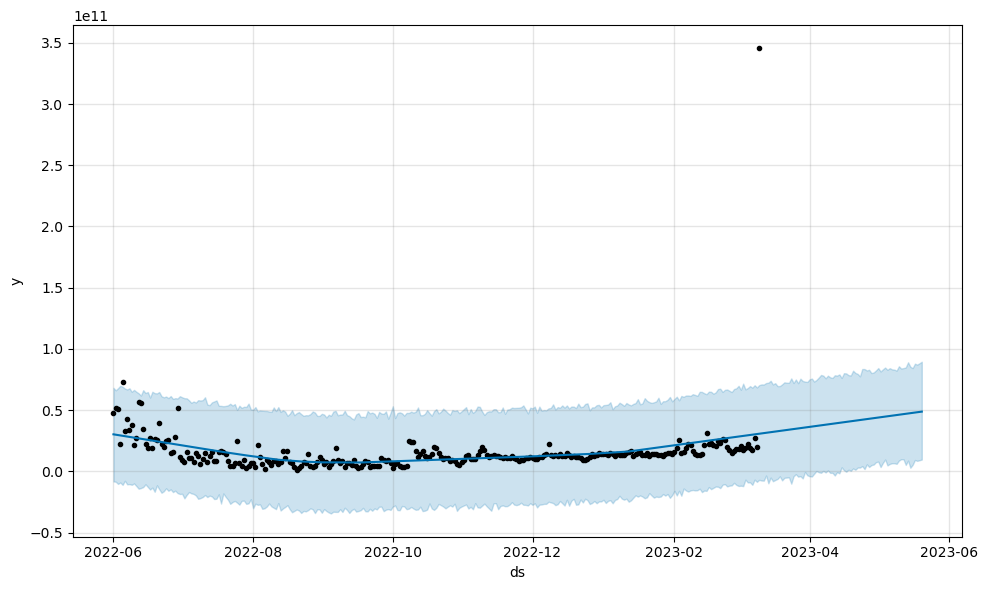

In [85]:
plot1 = model.plot(forecast)

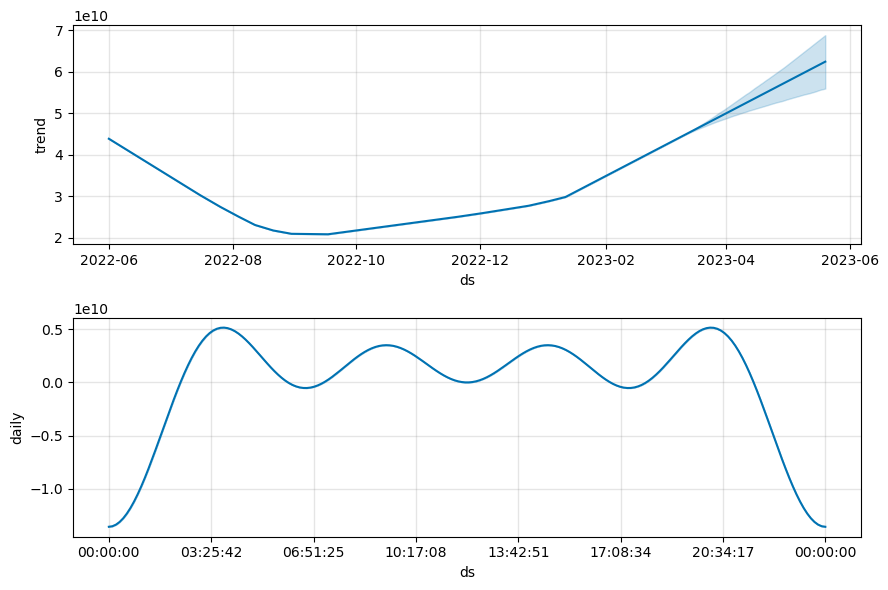

In [86]:
plt2 = model.plot_components(forecast)

In [87]:
# Define a function for the rolling forecast using ARIMA model
def prophet_rolling_forecast(train, window_size=7):
    """
    Perform a rolling forecast using a Prophet model with specified window size.
    Parameters:
    train (array-like): The training data.
    window_size (int): The size of the rolling window.
    Returns:
    predictions (list): The forecasts for the test data.
    model (object): new Prophet model
    """
    predictions = []
    
    for i in range(0, len(train) - window_size):
        # Fit the Prophet model on a window of data and make a one-step forecast
        window_data = train.iloc[i: i + window_size,:]
        print(window_data) 
        model = Prophet(interval_width=0.95, daily_seasonality=True)
        model_fit = model.fit(window_data)
        yhat = model_fit.make_future_dataframe(periods=1,freq='D')
        _yhat = model_fit.predict(yhat)
        #yhat = model_fit.forecast()[0]
        # Add the forecast to the list of predictions
        predictions.append(_yhat)
    return predictions, model

In [88]:
# Use the function to forecast the test data
rolling_forecast,model = prophet_rolling_forecast(train, window_size=7)
# Add the rolling forecast to the DataFrame

          ds            y
0 2022-06-01  47331137724
1 2022-06-02  52125073354
2 2022-06-03  50925847852
3 2022-06-04  22076581780
4 2022-06-05  73286894729
5 2022-06-06  33258057747
6 2022-06-07  42772752073

Initial log joint probability = -30.4279
Iteration  1. Log joint probability =    6.58582. Improved by 37.0137.
Iteration  2. Log joint probability =    7.05525. Improved by 0.469434.
Iteration  3. Log joint probability =    7.50466. Improved by 0.449415.
Iteration  4. Log joint probability =    7.63642. Improved by 0.131758.
Iteration  5. Log joint probability =    7.63731. Improved by 0.000888362.
Iteration  6. Log joint probability =    7.63909. Improved by 0.00178187.
Iteration  7. Log joint probability =    7.63938. Improved by 0.000285748.
Iteration  8. Log joint probability =    7.63941. Improved by 3.1103e-05.
Iteration  9. Log joint probability =    7.63949. Improved by 7.72465e-05.
Iteration 10. Log joint probability =    7.64003. Improved by 0.00054227.
Iteration 11. Lo

In [173]:
pd.concat(rolling_forecast).head(21)

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2022-06-01  2.873260e+09  1.960398e+10  7.753260e+10  2.873260e+09   
1 2022-06-02  1.863761e+09  2.096422e+10  7.598015e+10  1.863761e+09   
2 2022-06-03  8.542612e+08  1.953984e+10  7.525978e+10  8.542612e+08   
3 2022-06-04 -1.552383e+08  1.823149e+10  7.379184e+10 -1.552383e+08   
4 2022-06-05 -1.164738e+09  1.483926e+10  7.062762e+10 -1.164738e+09   
5 2022-06-06 -2.174237e+09  1.694643e+10  7.382844e+10 -2.174237e+09   
6 2022-06-07 -3.183737e+09  1.289404e+10  6.936913e+10 -3.183737e+09   
7 2022-06-08 -4.193237e+09  1.115299e+10  7.200379e+10 -4.193237e+09   
0 2022-06-02  2.967584e+09  2.176867e+10  8.401679e+10  2.967584e+09   
1 2022-06-03  8.429310e+08  2.093637e+10  7.888083e+10  8.429310e+08   
2 2022-06-04 -1.281722e+09  1.933741e+10  7.497704e+10 -1.281722e+09   
3 2022-06-05 -3.406375e+09  1.469964e+10  7.230210e+10 -3.406375e+09   
4 2022-06-06 -5.531028e+09  1.551729e+10  6.912610e+10 -5.531028e+09   
5 2022-06-07 -7.655681e+09  1.031651e+10  6.995155e+10 -7.655681e+09   
6 2022-06-08 -9.780334e+09  1.017239e+10  6.711997e+10 -9.780334e+09   
7 2022-06-09 -1.190499e+10  5.662313e+09  6.370069e+10 -1.190499e+10   
0 2022-06-03  2.764600e+09  1.828783e+10  7.449830e+10  2.764600e+09   
1 2022-06-04  1.096290e+09  1.564603e+10  7.528289e+10  1.096290e+09   
2 2022-06-05 -5.720202e+08  1.401731e+10  7.274541e+10 -5.720202e+08   
3 2022-06-06 -2.240330e+09  1.184142e+10  6.826664e+10 -2.240330e+09   
4 2022-06-07 -3.908640e+09  1.235655e+10  6.769498e+10 -3.908640e+09   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  2.873260e+09    4.602576e+10          4.602576e+10          4.602576e+10   
1  1.863761e+09    4.602576e+10          4.602576e+10          4.602576e+10   
2  8.542612e+08    4.602576e+10          4.602576e+10          4.602576e+10   
3 -1.552383e+08    4.602576e+10          4.602576e+10          4.602576e+10   
4 -1.164738e+09    4.602576e+10          4.602576e+10          4.602576e+10   
5 -2.174237e+09    4.602576e+10          4.602576e+10          4.602576e+10   
6 -3.183737e+09    4.602576e+10          4.602576e+10          4.602576e+10   
7 -4.193236e+09    4.602576e+10          4.602576e+10          4.602576e+10   
0  2.967584e+09    4.746309e+10          4.746309e+10          4.746309e+10   
1  8.429310e+08    4.746309e+10          4.746309e+10          4.746309e+10   
2 -1.281722e+09    4.746309e+10          4.746309e+10          4.746309e+10   
3 -3.406375e+09    4.746309e+10          4.746309e+10          4.746309e+10   
4 -5.531028e+09    4.746309e+10          4.746309e+10          4.746309e+10   
5 -7.655681e+09    4.746309e+10          4.746309e+10          4.746309e+10   
6 -9.780334e+09    4.746309e+10          4.746309e+10          4.746309e+10   
7 -1.190499e+10    4.746309e+10          4.746309e+10          4.746309e+10   
0  2.764600e+09    4.421625e+10          4.421625e+10          4.421625e+10   
1  1.096290e+09    4.421625e+10          4.421625e+10          4.421625e+10   
2 -5.720202e+08    4.421625e+10          4.421625e+10          4.421625e+10   
3 -2.240330e+09    4.421625e+10          4.421625e+10          4.421625e+10   
4 -3.908640e+09    4.421625e+10          4.421625e+10          4.421625e+10   

          daily   daily_lower   daily_upper  multiplicative_terms  \
0  4.602576e+10  4.602576e+10  4.602576e+10                   0.0   
1  4.602576e+10  4.602576e+10  4.602576e+10                   0.0   
2  4.602576e+10  4.602576e+10  4.602576e+10                   0.0   
3  4.602576e+10  4.602576e+10  4.602576e+10                   0.0   
4  4.602576e+10  4.602576e+10  4.602576e+10                   0.0   
5  4.602576e+10  4.602576e+10  4.602576e+10                   0.0   
6  4.602576e+10  4.602576e+10  4.602576e+10                   0.0   
7  4.602576e+10  4.602576e+10  4.602576e+10                   0.0   
0  4.746309e+10  4.746309e+10  4.746309e+10                   0.0

In [25]:
from prophet.diagnostics import cross_validation

In [26]:
df_cv = cross_validation(model, initial='182 days', period='7 days', horizon = '30 days')

INFO:prophet:Making 11 forecasts with cutoffs between 2022-11-30 00:00:00 and 2023-02-08 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       303.758    0.00501066       83.0578           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       306.485   0.000826245       78.7455     0.09596      0.2532      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       306.765   1.77125e-06       58.1708      0.9572      0.9572      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       306.765   5.28879e-08       74.4822   8.188e-10       0.001      480  LS failed, Hessian reset 
     330       306.765   1.73024e-08       63.2483           1           1      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

In [27]:
df_cv.head()

ds          yhat    yhat_lower    yhat_upper            y     cutoff
0 2022-12-01  1.213977e+10 -1.454558e+09  2.658034e+10  11162022995 2022-11-30
1 2022-12-02  1.218747e+10 -2.925880e+09  2.710139e+10  10079736726 2022-11-30
2 2022-12-03  1.223517e+10 -1.446906e+09  2.622983e+10  10129823063 2022-11-30
3 2022-12-04  1.228287e+10 -1.500787e+09  2.529994e+10  11503217981 2022-11-30
4 2022-12-05  1.233058e+10 -1.612635e+09  2.733522e+10  11762112804 2022-11-30

In [129]:
#cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
#df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

In [28]:
from prophet.diagnostics import performance_metrics

In [29]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0   3 days  1.017069e+19  3.189152e+09  2.071988e+09  0.142416  0.090363   
1   4 days  6.944162e+18  2.635178e+09  1.698105e+09  0.127864  0.068672   
2   5 days  2.888937e+18  1.699687e+09  1.164435e+09  0.094402  0.046911   
3   6 days  4.160957e+18  2.039842e+09  1.293761e+09  0.086458  0.047418   
4   7 days  1.126741e+19  3.356696e+09  1.879970e+09  0.103762  0.062193   
5   8 days  1.532461e+19  3.914666e+09  2.405972e+09  0.128342  0.086918   
6   9 days  1.867292e+19  4.321217e+09  2.815007e+09  0.153931  0.113533   
7  10 days  1.224259e+19  3.498941e+09  2.359555e+09  0.144163  0.097020   
8  11 days  8.250466e+18  2.872362e+09  1.853224e+09  0.122265  0.067102   
9  12 days  4.782295e+18  2.186846e+09  1.429367e+09  0.096871  0.052389   
10 13 days  7.254615e+18  2.693439e+09  1.758346e+09  0.103000  0.070317   
11 14 days  1.777349e+19  4.215861e+09  2.530605e+09  0.125866  0.075110   
12 15 days  1.978667e+19  4.448221e+09  2.798732e+09  0.138415  0.081297   
13 16 days  2.236466e+19  4.729129e+09  3.092803e+09  0.159656  0.128129   
14 17 days  1.282612e+19  3.581357e+09  2.478332e+09  0.148409  0.128231   
15 18 days  9.840607e+18  3.136974e+09  2.155702e+09  0.139476  0.114778   
16 19 days  6.289037e+18  2.507795e+09  1.665584e+09  0.110191  0.066790   
17 20 days  8.725274e+18  2.953857e+09  1.925362e+09  0.111202  0.068443   
18 21 days  1.935650e+19  4.399602e+09  2.602143e+09  0.126876  0.077364   
19 22 days  2.154804e+19  4.641986e+09  2.931310e+09  0.141901  0.090396   
20 23 days  2.341087e+19  4.838478e+09  3.141207e+09  0.157996  0.100593   
21 24 days  1.338869e+19  3.659056e+09  2.547560e+09  0.148745  0.105786   
22 25 days  1.000358e+19  3.162843e+09  2.169379e+09  0.135203  0.088463   
23 26 days  6.653061e+18  2.579353e+09  1.728863e+09  0.109404  0.067168   
24 27 days  8.845793e+18  2.974188e+09  1.912770e+09  0.105176  0.067168   
25 28 days  2.181404e+19  4.670551e+09  2.851274e+09  0.132178  0.078270   
26 29 days  2.453628e+19  4.953411e+09  3.287655e+09  0.151364  0.100310   
27 30 days  3.273403e+21  5.721366e+10  1.339774e+10  0.191354  0.128882   

       smape  coverage  
0   0.141447  1.000000  
1   0.120897  1.000000  
2   0.086575  1.000000  
3   0.086200  1.000000  
4   0.111304  0.969697  
5   0.141252  0.969697  
6   0.166819  0.969697  
7   0.149259  1.000000  
8   0.121255  1.000000  
9   0.094675  1.000000  
10  0.107649  1.000000  
11  0.139851  0.969697  
12  0.154171  0.969697  
13  0.174331  0.969697  
14  0.152800  1.000000  
15  0.139120  1.000000  
16  0.108614  1.000000  
17  0.116503  1.000000  
18  0.142362  0.969697  
19  0.159708  0.969697  
20  0.174336  0.969697  
21  0.154108  1.000000  
22  0.135958  1.000000  
23  0.109113  1.000000  
24  0.111856  1.000000  
25  0.150225  0.969697  
26  0.172743  0.969697  
27  0.239066  0.939394

In [30]:
from prophet.plot import plot_cross_validation_metric

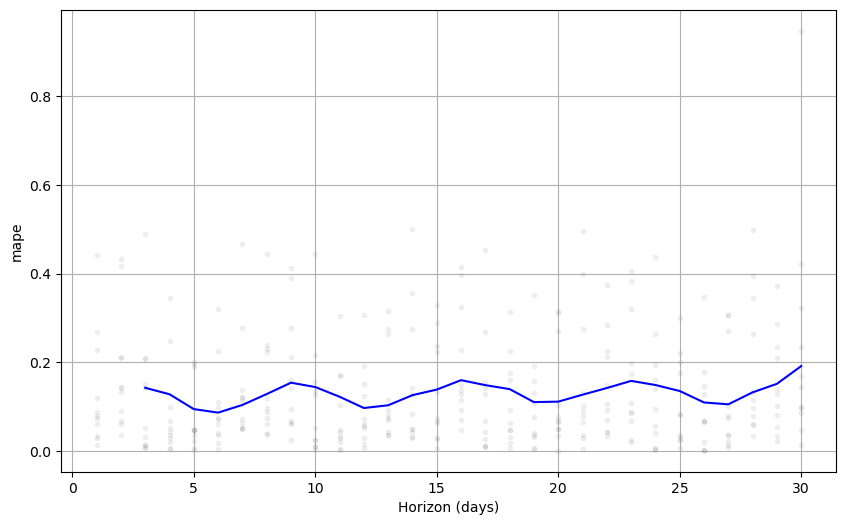

In [31]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [33]:
from dask.distributed import Client

In [34]:
%%capture
client = Client()  # connect to the cluster

df_cv = cross_validation(model, initial='182 days', period='7 days', horizon = '30 days', parallel="dask")

2023-05-31 01:12:18,383 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_q/03xxdv4s0237s6w4rjfjmpt00000gn/T/dask-worker-space/worker-m3kw4yyr', purging
2023-05-31 01:12:18,384 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_q/03xxdv4s0237s6w4rjfjmpt00000gn/T/dask-worker-space/worker-ncsbnowi', purging
2023-05-31 01:12:18,386 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_q/03xxdv4s0237s6w4rjfjmpt00000gn/T/dask-worker-space/worker-5u_quvn8', purging
2023-05-31 01:12:18,387 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_q/03xxdv4s0237s6w4rjfjmpt00000gn/T/dask-worker-space/worker-bfrrmvtg', purging
INFO:prophet:Making 11 forecasts with cutoffs between 2022-11-30 00:00:00 and 2023-02-08 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:61662' processes=4 threads=4, memory=8.00 GiB>
/Users/alphonsologan/opt/anaconda3/lib/pyt

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       425.943   0.000401546       78.3821      0.3113           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       426.121   0.000195245        76.864   2.082e-06       0.001      231  LS failed, Hessian reset 
     192       426.136   1.13193e-08       69.4313      0.1928      0.1928      282   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       454.692     0.0042758       248.051   4.715e-05       0.001      140  LS failed, Hessian reset 
      99       455.221    0.00242399       74.7765           1           1      152   
    Iter      log prob        ||dx||      ||grad||    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       378.952   6.79269e-05       71.7167      0.2799      0.2799      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       379.636   4.81137e-07       74.5925      0.5105      0.5105      256   
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       410.265   0.000559612       62.1852           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        380.38   7.96617e-05       75.3806      0.3573           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       411.476   6.94345e-06       84.2415   9.065e-08       0.001      284  LS failed, Hessian reset 
     399        381.19   0.000158801    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       395.426   0.000129187       79.6766      0.5032      0.5032      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       395.443   3.19828e-08        67.417      0.2945           1      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       320.217    0.00031482       75.1879        0.73        0.73      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       321.006   0.000808701       75.9136   1.004e-05       0.001      189  LS failed, Hessian reset 
Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       321.208    1.6343e-12       79.9293   5.545e-09      0.3758      306   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        348.62     0.0621024       188.851           1           1      138   
    Iter      log prob        ||

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       362.934    0.00036236       88.4678      0.3388      0.3388      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        350.97   0.000101149       74.2535           1           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       350.981   6.63511e-05       82.0461   8.341e-07       0.001      371  LS failed, Hessian reset 
     199       365.189   1.32116e-08       67.6593      0.2679      0.2679      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       365.189   7.39617e-09       67.5867       0.336       0.336      275   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     256       350.985   7.15996e-09       68.7434      0.3764      0.3764      423   
Optimization terminated normally: 
  Convergence detected: absolute param

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       303.758    0.00501066       83.0578           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       306.485   0.000826245       78.7455     0.09596      0.2532      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       306.765   1.77125e-06       58.1708      0.9572      0.9572      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       306.765   5.28879e-08       74.4822   8.188e-10       0.001      480  LS failed, Hessian reset 
     330       306.765   1.73024e-08       63.2483           1           1      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       333.443    0.00104291       61.7755      0.2491      0.2491      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       335.619   0.000151517       68.2036      0.2999      0.2999      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       335.858   0.000579456       81.7543   6.642e-06       0.001      364  LS failed, Hessian reset 
     299       336.216    0.00147995        58.484           1           1      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       336.221   3.10626e-08       57.1392      0.2915      0.2915      487   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.869    0.00108372        90.285      0.5679      0.5679      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       443.936   0.000736163       92.9668    0.006958      0.2099      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       443.977   0.000973672       85.9655   1.047e-05       0.001      300  LS failed, Hessian reset 
     299       444.141   8.92782e-08       77.9572      0.2856      0.2856      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       444.141   9.49491e-07       85.6345    1.07e-08       0.001      477  LS failed, Hessian reset 
     322       444.142   8.66491e-09       74.3479      0.2918      0.2918      494   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [35]:
import itertools
import numpy as np

In [36]:
cutoffs=df_cv['cutoff'].unique()
cutoffs

array(['2022-11-30T00:00:00.000000000', '2022-12-07T00:00:00.000000000',
       '2022-12-14T00:00:00.000000000', '2022-12-21T00:00:00.000000000',
       '2022-12-28T00:00:00.000000000', '2023-01-04T00:00:00.000000000',
       '2023-01-11T00:00:00.000000000', '2023-01-18T00:00:00.000000000',
       '2023-01-25T00:00:00.000000000', '2023-02-01T00:00:00.000000000',
       '2023-02-08T00:00:00.000000000'], dtype='datetime64[ns]')

In [37]:
%%capture
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=7)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b31e0d0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -137.868
Iteration  1. Log joint probability =     140.15. Improved by 278.018.
Iteration  2. Log joint probability =    430.903. Improved by 290.753.
Iteration  3. Log joint probability =    437.186. Improved by 6.28347.
Iteration  4. Log joint probability =    511.127. Improved by 73.9403.
Iteration  5. Log joint probability =    605.064. Improved by 93.937.
Iteration  6. Log joint probability =    626.316. Improved by 21.2522.
Iteration  7. Log joint probability =    629.689. Improved by 3.37346.
Iteration  8. Log joint probability =     637.43. Improved by 7.74064.
Iteration  9. Log joint probability =    640.084. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -24.7598
Iteration  1. Log joint probability =    156.363. Improved by 181.123.
Iteration  2. Log joint probability =    268.935. Improved by 112.572.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -11.9137


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  3. Log joint probability =    300.497. Improved by 31.5621.
Iteration  4. Log joint probability =    302.949. Improved by 2.45154.
Iteration  1. Log joint probability =    141.799. Improved by 153.713.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -4.63266
Iteration  5. Log joint probability =    305.622. Improved by 2.67364.


Iteration  6. Log joint probability =    306.115. Improved by 0.49229.
Iteration  2. Log joint probability =    245.806. Improved by 104.007.
Iteration  1. Log joint probability =    26.6036. Improved by 31.2362.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  7. Log joint probability =      306.4. Improved by 0.285233.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -18.1845
Iteration  8. Log joint probability =    306.559. Improved by 0.158781.
Iteration  3. Log joint probability =    272.266. Improved by 26.4595.
Iteration  2. Log joint probability =    226.925. Improved by 200.322.
Iteration  9. Log joint probability =    306.746. Improved by 0.187279.
Iteration  4. Log joint probability =    273.743. Improved by 1.47688.
Iteration  1. Log joint probability =    148.381. Improved by 166.565.
Iteration  3. Log joint probability =    250.876. Improved by 23.9504.
Iteration  5. Log joint probability =    283.0

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 30. Log joint probability =    307.119. Improved by 0.000132723.
Iteration 19. Log joint probability =    294.759. Improved by 0.00169432.
Iteration 39. Log joint probability =    271.851. Improved by 9.25338e-08.
Iteration 40. Log joint probability =    271.851. Improved by 2.63791e-07.
Iteration 31. Log joint probability =    307.119. Improved by 3.34618e-05.
Iteration 41. Log joint probability =    271.851. Improved by 1.0114e-08.
Iteration 20. Log joint probability =    294.763. Improved by 0.00363475.
Iteration 42. Log joint probability =    271.851. Improved by 1.50163e-07.
Iteration 32. Log joint probability =    307.119. Improved by 6.69839e-05.
Iteration 21. Log joint probability =    294.764. Improved by 0.00113593.
Iteration 43. Log joint probability =    271.851. Improved by 7.65903e-08.
Iteration 33. Log joint probability =    307.119. Improved by 3.87832e-05.
Iteration 44. Log joint probability =    271.851. Improved by 3.29875e-08.
Iteration 22. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 25. Log joint probability =    294.768. Improved by 0.000273092.
Iteration 37. Log joint probability =    307.119. Improved by 3.24862e-06.
Iteration 26. Log joint probability =    294.768. Improved by 0.000186436.
Iteration 38. Log joint probability =    307.119. Improved by 3.34158e-07.
Iteration 27. Log joint probability =    294.768. Improved by 0.000207914.
Iteration 39. Log joint probability =    307.119. Improved by 5.05969e-07.
Iteration 28. Log joint probability =    294.768. Improved by 7.07339e-05.
Iteration 40. Log joint probability =    307.119. Improved by 1.89583e-06.
Iteration 29. Log joint probability =    294.768. Improved by 0.000126806.
Iteration 41. Log joint probability =    307.119. Improved by 5.7314e-07.
Iteration 30. Log joint probability =    294.768. Improved by 1.95182e-08.
Iteration 42. Log joint probability =    307.119. Improved by 9.92133e-07.
Iteration 31. Log joint probability =    294.768. Improved by 6.51046e-07.
Iteration 43. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 33. Log joint probability =    294.768. Improved by 7.64533e-05.
Iteration 34. Log joint probability =    294.769. Improved by 4.03853e-05.
Iteration 35. Log joint probability =    294.769. Improved by 2.38341e-05.
Iteration 36. Log joint probability =    294.769. Improved by 5.71384e-06.
Iteration 37. Log joint probability =    294.769. Improved by 4.59795e-06.
Iteration 38. Log joint probability =    294.769. Improved by 1.5175e-06.
Iteration 39. Log joint probability =    294.769. Improved by 7.62182e-07.
Iteration 40. Log joint probability =    294.769. Improved by 1.0802e-06.
Iteration 41. Log joint probability =    294.769. Improved by 5.40633e-07.
Iteration 42. Log joint probability =    294.769. Improved by 2.21414e-07.
Iteration 43. Log joint probability =    294.769. Improved by 1.02883e-07.
Iteration 44. Log joint probability =    294.769. Improved by 1.24267e-07.
Iteration 45. Log joint probability =    294.769. Improved by 4.44227e-08.
Iteration 46. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.108       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -31.7057
Iteration  1. Log joint probability =    159.556. Improved by 191.261.
Iteration  2. Log joint probability =    260.993. Improved by 101.437.
Iteration  3. Log joint probability =    314.522. Improved by 53.5297.
Iteration  4. Log joint probability =    314.991. Improved by 0.468416.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =    316.505. Improved by 1.51412.
Iteration  6. Log joint probability =    316.993. Improved by 0.487693.
Iteration  7. Log joint probability =        319. Improved by 2.00757.
Iteration  1. Log joint probability =    47.5016. Improved by 86.5855.
Iteration  8. Log joint probability =    319.138. Improved by 0.137401.
Iteration  9. Log joint probability =    319.394. Improved by 0.256528.
Iteration 10. Log joint probability =    319.503. Improved by 0.10848.
Iteration  2. Log joint probability =    285.161. Improved by 237.659.
Iteration 11. Log joint probability =    319.619. Improved by 0.116966.
Iteration 12. Log joint probability =    319.666. Improved by 0.0466803.
Iteration 13. Log joint probability =    319.743. Improved by 0.0765054.
Iteration  3. Log joint probability =    328.527. Improved by 43.3662.
Iteration 14. Log joint probability =    319.778. Improved by 0.035734.
Iteration  4. Log joint probability =    330.034. Improved by 1.5076

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.166       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.7814
Iteration 17. Log joint probability =    319.818. Improved by 0.00893288.
Iteration  6. Log joint probability =    330.627. Improved by 0.559183.
Iteration  7. Log joint probability =    330.769. Improved by 0.141853.
Iteration 18. Log joint probability =    319.819. Improved by 0.00116976.
Iteration 19. Log joint probability =    319.819. Improved by 0.000706435.
Iteration  8. Log joint probability =     330.94. Improved by 0.171236.
Iteration  1. Log joint probability =    74.9531. Improved by 120.734.
Iteration 20. Log joint probability =    319.821. Improved by 0.00157202.
Iteration  9. Log joint probabili

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 17. Log joint probability =     344.26. Improved by 0.0030663.
Iteration 44. Log joint probability =    331.582. Improved by 0.0166889.
Iteration 54. Log joint probability =    319.832. Improved by 1.88406e-08.
Iteration  2. Log joint probability =    70.3119. Improved by 52.9455.
Iteration 45. Log joint probability =    331.591. Improved by 0.00832668.
Iteration 55. Log joint probability =    319.832. Improved by 1.23104e-08.
Iteration 18. Log joint probability =    344.266. Improved by 0.00588582.
Iteration 46. Log joint probability =    331.597. Improved by 0.00623593.
Iteration 56. Log joint probability =    319.832. Improved by 1.98384e-09.
Iteration  3. Log joint probability =    338.714. Improved by 268.402.
Iteration 47. Log joint probability =    331.602. Improved by 0.00544371.
Iteration  4. Log joint probability =    344.008. Improved by 5.29418.
Iteration 19. Log joint probability =    344.269. Improved by 0.00382857.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 48. Log joint probability =    331.606. Improved by 0.00397623.
Iteration  5. Log joint probability =    350.776. Improved by 6.76773.
Iteration 49. Log joint probability =    331.607. Improved by 0.000346737.
Iteration  6. Log joint probability =    352.781. Improved by 2.00502.
Iteration 50. Log joint probability =    331.608. Improved by 0.00123214.
Iteration  7. Log joint probability =    355.534. Improved by 2.75311.
Iteration 20. Log joint probability =    344.273. Improved by 0.00340491.
Iteration 51. Log joint probability =    331.608. Improved by 8.01218e-05.
Iteration  8. Log joint probability =     356.14. Improved by 0.606154.
Iteration 52. Log joint probability =    331.609. Improved by 0.00138221.
Iteration 21. Log joint probability =    344.279. Improved by 0.00598087.
Iteration  9. Log joint probability =     356.45. Improved by 0.30979.
Iteration 53. Log joint probability =    331.612. Improved by 0.00278078.
Iteration 54. Log joint probability =    331.613. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 43. Log joint probability =    344.346. Improved by 0.000300161.
Iteration 44. Log joint probability =    344.348. Improved by 0.00199431.
Iteration 45. Log joint probability =    344.354. Improved by 0.00539665.
Iteration 46. Log joint probability =    344.356. Improved by 0.00242095.
Iteration 47. Log joint probability =    344.356. Improved by 5.27106e-05.
Iteration 48. Log joint probability =    344.357. Improved by 0.000543583.
Iteration 49. Log joint probability =    344.358. Improved by 0.00102865.
Iteration 50. Log joint probability =    344.358. Improved by 0.000450547.
Iteration 51. Log joint probability =    344.359. Improved by 0.000625989.
Iteration 52. Log joint probability =    344.359. Improved by 0.000137497.
Iteration 53. Log joint probability =    344.359. Improved by 0.000198284.
Iteration 54. Log joint probability =    344.359. Improved by 0.000102718.
Iteration 55. Log joint probability =    344.359. Improved by 1.17111e-05.
Iteration 56. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 82. Log joint probability =     344.36. Improved by 7.14561e-05.
Iteration  2. Log joint probability =    315.187. Improved by 279.239.
Iteration 83. Log joint probability =     344.36. Improved by 1.66566e-05.
Iteration  3. Log joint probability =    357.183. Improved by 41.9961.
Iteration 84. Log joint probability =     344.36. Improved by 4.91111e-05.
Iteration  4. Log joint probability =    358.113. Improved by 0.929327.
Iteration  5. Log joint probability =    366.021. Improved by 7.9084.
Iteration 85. Log joint probability =     344.36. Improved by 7.44013e-06.
Iteration  6. Log joint probability =    367.472. Improved by 1.45069.
Iteration  7. Log joint probability =    368.351. Improved by 0.879171.
Iteration 86. Log joint probability =     344.36. Improved by 6.3302e-06.
Iteration  8. Log joint probability =    368.437. Improved by 0.0862272.
Iteration  9. Log joint probability =    368.967. Improved by 0.529835.
Iteration 10. Log joint probability =    369.255. Impr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 37. Log joint probability =    369.829. Improved by 1.31566e-06.
Iteration 38. Log joint probability =    369.829. Improved by 4.06363e-06.
Iteration 39. Log joint probability =    369.829. Improved by 1.18297e-06.
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 40. Log joint probability =    369.829. Improved by 1.97718e-06.
       1      -12.4955             0       243.563       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.3544
Iteration 41. Log joint probability =    369.829. Improved by 5.32329e-07.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 42. Log joint probability =    369.829. Improved by 9.93611e-07.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -75.1194
Iteration 43. Log joint probability =    369.829. Improved by 2.04783e-07.
Iteration  1. Log joint probability =    172.099. Improved by 238.453.
Iteration 44. Log joint probability =    369.829. Improved by 5.51454e-07.
Iteration 45. Log joint probability =    369.829. Improved by 8.22136e-08.
Iteration  2. Log joint probability =    243.456. Improved by 71.3568.
Iteration  1. Log joint probability =    169.078. Improved by 244.198.


Iteration 46. Log joint probability =    369.829. Improved by 2.44425e-07.
Iteration 47. Log joint probability =    369.829. Improved by 9.63743e-08.
Iteration  3. Log joint probability =    373.416. Improved by 129.961.
Iteration 48. Log joint probability =    369.829. Improved by 1.10659e-07.
Iteration  4. Log joint probability =    373.431. Improved by 0.0147132.
Iteration  2. Log joint probability =    310.218. Improved by 141.14.
Iteration 49. Log joint probability =    369.829. Improved by 1.9922e-08.
Iteration 50. Log joint probability =    369.829. Improved by 7.63815e-08.
Iteration  5. Log joint probability =    380.444. Improved by 7.01334.
Iteration  6. Log joint probability =    381.364. Improved by 0.91922.
Iteration 51. Log joint probability =    369.829. Improved by 3.35365e-08.
Iteration  3. Log joint probability =    355.878. Improved by 45.6598.
Iteration  7. Log joint probability =    381.413. Improved by 0.0493331.
Iteration 52. Log joint probability =    369.829. I

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Iteration  9. Log joint probability =    382.233. Improved by 0.258016.
Iteration  6. Log joint probability =    390.862. Improved by 2.47233.
Iteration 10. Log joint probability =    382.392. Improved by 0.158877.
Iteration  7. Log joint probability =    390.954. Improved by 0.0917482.
Iteration 11. Log joint probability =     382.52. Improved by 0.127967.
Iteration  8. Log joint probability =    391.058. Improved by 0.104871.
Iteration 12. Log joint probability =    382.651. Improved by 0.130515.
Iteration  9. Log joint probability =    391.093. Improved by 0.0347601.
Iteration 13. Log joint probability =    382.708. Improved by 0.0575265.
Iteration 10. Log joint probability =    391.723. Improved by 0.629647.
Iteration 14. Log joint probability =    382.745. Improved by 0.0370497.
Iteration 11. Log joint probability =     392.02. Improved by 0.296852.
Iteration 15. Log joint probability =    382.773. Improved by 0.0276717.
Iteration 12. Log joint probability =    392.166. Improved 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 56. Log joint probability =    382.828. Improved by 1.32461e-07.
Iteration 57. Log joint probability =    382.828. Improved by 5.74711e-07.
Iteration 58. Log joint probability =    382.828. Improved by 8.54996e-08.
Iteration 59. Log joint probability =    382.828. Improved by 2.72485e-07.
Iteration 60. Log joint probability =    382.828. Improved by 3.34495e-08.
Iteration 61. Log joint probability =    382.828. Improved by 1.14387e-07.
Iteration 62. Log joint probability =    382.828. Improved by 6.94852e-08.
Iteration 63. Log joint probability =    382.828. Improved by 6.55287e-08.
Iteration 64. Log joint probability =    382.828. Improved by 2.44609e-08.
Iteration 65. Log joint probability =    382.828. Improved by 7.17404e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -137.868
Iteration  1. Log joint probability =     140.15. Improved by 278.018.
Iteration  2. Log joint probability =    430.884. Improved by 290.734.
Iteration  3. Log joint probability =    447.956. Improved by 17.0719.
Iteration  4. Log joint probability =    528.073. Improved by 80.1171.
Iteration  5. Log joint probability =    603.462. Improved by 75.3889.
Iteration  6. Log joint probability =    625.259. Improved by 21.7969.
Iteration  7. Log joint probability =    629.341. Improved by 4.08246.
Iteration  8. Log joint probability =     635.86. Improved by 6.51866.
Iteration  9. Log joint probability =    638.309.

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b34e070>
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -4.63266
Iteration  1. Log joint probability =    25.6534. Improved by 30.286.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    226.475. Improved by 200.822.
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -18.1845
Iteration  3. Log joint probability =    252.069. Improved by 25.5937.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -24.7598


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  4. Log joint probability =     254.82. Improved by 2.7507.
Iteration  5. Log joint probability =    258.428. Improved by 3.60766.
Iteration  1. Log joint probability =    148.293. Improved by 166.477.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  6. Log joint probability =    263.539. Improved by 5.11121.
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -11.9137
Iteration  1. Log joint probability =    156.292. Improved by 181.052.
Iteration  7. Log joint probability =    267.431. Improved by 3.89207.


Iteration  2. Log joint probability =    257.476. Improved by 109.183.
Iteration  8. Log joint probability =    269.256. Improved by 1.82528.
Iteration  9. Log joint probability =    269.343. Improved by 0.0865525.
Iteration  1. Log joint probability =    141.816. Improved by 153.73.
Iteration  2. Log joint probability =    268.757. Improved by 112.465.
Iteration 10. Log joint probability =    269.757. Improved by 0.414597.
Iteration  3. Log joint probability =    286.868. Improved by 29.3918.
Iteration 11. Log joint probability =    270.224. Improved by 0.466708.
Iteration 12. Log joint probability =    270.537. Improved by 0.312836.
Iteration  2. Log joint probability =    245.701. Improved by 103.885.
Iteration  4. Log joint probability =    289.401. Improved by 2.53303.
Iteration  3. Log joint probability =    299.559. Improved by 30.8017.
Iteration 13. Log joint probability =    270.685. Improved by 0.147815.
Iteration 14. Log joint probability =    270.745. Improved by 0.0604188.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 42. Log joint probability =    282.963. Improved by 5.42614e-08.
Iteration 28. Log joint probability =     293.68. Improved by 3.78063e-05.
Iteration 29. Log joint probability =    306.058. Improved by 8.08209e-05.
Iteration 43. Log joint probability =    282.963. Improved by 3.23422e-08.
Iteration 44. Log joint probability =    282.963. Improved by 2.34422e-10.
Iteration 30. Log joint probability =    306.058. Improved by 3.45393e-05.
Iteration 29. Log joint probability =     293.68. Improved by 2.00302e-05.
Iteration 31. Log joint probability =    306.058. Improved by 1.19303e-05.
Iteration 30. Log joint probability =     293.68. Improved by 8.82946e-06.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 32. Log joint probability =    306.058. Improved by 1.10001e-05.
Iteration 31. Log joint probability =     293.68. Improved by 4.00258e-06.
Iteration 33. Log joint probability =    306.058. Improved by 5.61242e-06.
Iteration 32. Log joint probability =     293.68. Improved by 7.4606e-07.
Iteration 34. Log joint probability =    306.058. Improved by 9.96818e-08.
Iteration 33. Log joint probability =     293.68. Improved by 1.44441e-06.
Iteration 35. Log joint probability =    306.058. Improved by 5.96701e-07.
Iteration 34. Log joint probability =     293.68. Improved by 1.16019e-06.
Iteration 36. Log joint probability =    306.058. Improved by 5.75702e-06.
Iteration 35. Log joint probability =     293.68. Improved by 4.84748e-07.
Iteration 37. Log joint probability =    306.058. Improved by 1.06559e-06.
Iteration 38. Log joint probability =    306.058. Improved by 4.76864e-07.
Iteration 36. Log joint probability =     293.68. Improved by 3.94194e-07.
Iteration 39. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -31.7057
Iteration  1. Log joint probability =    159.578. Improved by 191.284.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =     259.98. Improved by 100.402.
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.0839
Iteration  3. Log joint probability =    312.712. Improved by 52.7316.
Iteration  1. Log joint probability =    47.0864. Improved by 86.1703.
Iteration  4. Log joint probability =    313.419. Improved by 0.70751.
Iteration  5. Log joint probability =    315.112. Improved by 1.69305.
Iteration  6. Log joint probability =    315.671. Improved by 0.55821.
Iteration  2. Log joint probability =    284.895. Improved by 237.808.
Iteration  7. Log joint probability =    315.749. Improved by 0.0786607.
Iteration  8. Log joint probability =    316.81

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.146       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 10. Log joint probability =    330.118. Improved by 0.0108382.

Initial log joint probability = -45.7814
Iteration 18. Log joint probability =    318.931. Improved by 0.0204522.
Iteration 19. Log joint probability =     318.94. Improved by 0.00958297.
Iteration 11. Log joint probability =    330.174. Improved by 0.0560352.
Iteration 20. Log joint probability =    318.941. Improved by 0.000734909.
Iteration 12. Log joint probability =    330.242. Improved by 0.0678247.
Iteration 21. Log joint probability =    318.941. Improved by 0.000223183.
Iteration 13. Log joint probability =    330.267. Improved by 0.0252332.
Iteration  1. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    16.8458. Improved by 69.0382.
Iteration 18. Log joint probability =    330.323. Improved by 0.00873486.
Iteration 27. Log joint probability =    318.948. Improved by 0.000118936.
Iteration 19. Log joint probability =    330.336. Improved by 0.0132312.
Iteration 28. Log joint probability =    318.948. Improved by 0.000283377.
Iteration  4. Log joint probability =    341.944. Improved by 1.20578.
Iteration 20. Log joint probability =    330.348. Improved by 0.0123503.
Iteration 29. Log joint probability =    318.948. Improved by 8.50033e-05.
Iteration  2. Log joint probability =    69.6601. Improved by 52.8143.
Iteration 30. Log joint probability =    318.949. Improved by 0.000257609.
Iteration 21. Log joint probability =    330.359. Improved by 0.0102996.
Iteration  5. Log joint probability =     342.03. Improved by 0.0864096.
Iteration 31. Log joint probability =    318.949. Improved by 0.000121748.
Iteration 22. Log joint probability =    330.3

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 61. Log joint probability =    330.528. Improved by 0.000160875.
Iteration 24. Log joint probability =    343.139. Improved by 0.000349911.
Iteration 39. Log joint probability =    355.956. Improved by 3.33983e-06.
Iteration 62. Log joint probability =    330.529. Improved by 0.000638245.
Iteration 40. Log joint probability =    355.956. Improved by 4.34933e-07.
Iteration 63. Log joint probability =     330.53. Improved by 0.0012566.
Iteration 41. Log joint probability =    355.956. Improved by 7.19299e-07.
Iteration 25. Log joint probability =    343.139. Improved by 0.000179472.
Iteration 64. Log joint probability =     330.53. Improved by 5.81517e-05.
Iteration 42. Log joint probability =    355.956. Improved by 6.73696e-07.
Iteration 65. Log joint probability =     330.53. Improved by 0.000245056.
Iteration 26. Log joint probability =     343.14. Improved by 0.000279733.
Iteration 66. Log joint probability =    330.531. Improved by 0.000109058.
Iteration 43. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 76. Log joint probability =    330.533. Improved by 0.00013166.
Iteration 77. Log joint probability =    330.533. Improved by 4.44817e-05.
Iteration 31. Log joint probability =    343.141. Improved by 0.000536283.
Iteration 78. Log joint probability =    330.533. Improved by 6.58499e-05.
Iteration 32. Log joint probability =    343.142. Improved by 0.00122073.
Iteration 79. Log joint probability =    330.533. Improved by 2.83059e-05.
Iteration 80. Log joint probability =    330.533. Improved by 3.52607e-05.
Iteration 33. Log joint probability =    343.142. Improved by 0.000163635.
Iteration 81. Log joint probability =    330.533. Improved by 5.60505e-06.
Iteration 82. Log joint probability =    330.533. Improved by 4.87083e-06.
Iteration 83. Log joint probability =    330.533. Improved by 3.92399e-06.
Iteration 34. Log joint probability =    343.143. Improved by 0.000143026.
Iteration 84. Log joint probability =    330.533. Improved by 7.47713e-06.
Iteration 85. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 66. Log joint probability =    343.145. Improved by 9.2415e-06.
Iteration 67. Log joint probability =    343.145. Improved by 2.07788e-05.
Iteration 68. Log joint probability =    343.145. Improved by 1.97072e-05.
Iteration 69. Log joint probability =    343.145. Improved by 4.55129e-06.
Iteration 70. Log joint probability =    343.145. Improved by 3.9087e-05.
Iteration 71. Log joint probability =    343.145. Improved by 6.97379e-05.
Iteration 72. Log joint probability =    343.145. Improved by 1.45585e-05.
Iteration 73. Log joint probability =    343.145. Improved by 1.13932e-06.
Iteration 74. Log joint probability =    343.145. Improved by 1.8808e-05.
Iteration 75. Log joint probability =    343.145. Improved by 4.39474e-05.
Iteration 76. Log joint probability =    343.145. Improved by 1.93402e-05.
Iteration 77. Log joint probability =    343.145. Improved by 3.87798e-06.
Iteration 78. Log joint probability =    343.145. Improved by 5.75106e-06.
Iteration 79. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 84. Log joint probability =    343.145. Improved by 3.94482e-07.
Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -58.8193
Iteration 85. Log joint probability =    343.145. Improved by 1.30495e-07.
Iteration  1. Log joint probability =    35.4764. Improved by 94.2957.
Iteration 86. Log joint probability =    343.145. Improved by 3.63762e-07.
Iteration  2. Log joint probability =    314.883. Improved by 279.407.
Iteration 87. Log joint probability =    343.145. Improved by 2.52114e-07.
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0      

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  4. Log joint probability =    357.392. Improved by 0.0337373.
Iteration  5. Log joint probability =    365.016. Improved by 7.62398.
Iteration  1. Log joint probability =    172.018. Improved by 238.372.
Iteration 89. Log joint probability =    343.145. Improved by 4.01509e-07.
Iteration  6. Log joint probability =     366.33. Improved by 1.31358.
Iteration  7. Log joint probability =    367.252. Improved by 0.921758.
Iteration 90. Log joint probability =    343.145. Improved by 4.14711e-08.
Iteration  2. Log joint probability =    242.872. Improved by 70.8536.
Iteration  8. Log joint probability =    367.259. Improved by 0.0071645.
Iteration  9. Log joint probability =    367.275. Improved by 0.0155918.
Iteration 91. Log joint probability =    343.145. Improved by 5.57473e-07.
Iteration 10. Log joint probability =    367.519. Improved by 0.244853.
Iteration  3. Log joint probability =    370.157. Improved by 127.286.
Iteration 11. Log joint probability =     367.94. Improve

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 49. Log joint probability =     368.76. Improved by 1.8624e-08.
Iteration 43. Log joint probability =    381.594. Improved by 4.0467e-06.
Iteration 50. Log joint probability =     368.76. Improved by 3.71608e-08.
Iteration 44. Log joint probability =    381.594. Improved by 9.75369e-06.
Iteration 51. Log joint probability =     368.76. Improved by 2.82761e-07.
Iteration 45. Log joint probability =    381.594. Improved by 8.22909e-06.
Iteration 52. Log joint probability =     368.76. Improved by 4.02503e-08.
Iteration 46. Log joint probability =    381.594. Improved by 6.42439e-06.
Iteration 53. Log joint probability =     368.76. Improved by 1.48196e-07.
Iteration 54. Log joint probability =     368.76. Improved by 5.58112e-08.
Iteration 47. Log joint probability =    381.594. Improved by 7.02296e-06.
Iteration 55. Log joint probability =     368.76. Improved by 3.67299e-08.
Iteration 48. Log joint probability =    381.594. Improved by 9.84585e-06.
Iteration 56. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 56. Log joint probability =    381.595. Improved by 4.5466e-06.
Iteration 57. Log joint probability =    381.595. Improved by 4.23378e-07.
Iteration 58. Log joint probability =    381.595. Improved by 3.81745e-07.
Iteration 59. Log joint probability =    381.595. Improved by 2.19503e-06.
Iteration 60. Log joint probability =    381.595. Improved by 3.97584e-07.
Iteration 61. Log joint probability =    381.595. Improved by 9.61866e-07.
Iteration 62. Log joint probability =    381.595. Improved by 3.32781e-07.
Iteration 63. Log joint probability =    381.595. Improved by 5.5915e-07.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.795       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -75.1194
Iteration 64. Log jo

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 65. Log joint probability =    381.595. Improved by 1.95628e-08.
Iteration 66. Log joint probability =    381.595. Improved by 1.75026e-07.
Iteration  1. Log joint probability =    169.091. Improved by 244.21.
Iteration 67. Log joint probability =    381.595. Improved by 6.26308e-08.
Iteration 68. Log joint probability =    381.595. Improved by 4.42178e-08.
Iteration 69. Log joint probability =    381.595. Improved by 1.39491e-08.
Iteration  2. Log joint probability =    307.197. Improved by 138.107.
Iteration 70. Log joint probability =    381.595. Improved by 1.07743e-08.
Iteration 71. Log joint probability =    381.595. Improved by 2.84871e-09.
Iteration  3. Log joint probability =    385.685. Improved by 78.4875.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  4. Log joint probability =    385.888. Improved by 0.203487.
Iteration  5. Log joint probability =     387.09. Improved by 1.20215.
Iteration  6. Log joint probability =    387.531. Improved by 0.440861.
Iteration  7. Log joint probability =    387.905. Improved by 0.374221.
Iteration  8. Log joint probability =    388.692. Improved by 0.786658.
Iteration  9. Log joint probability =    389.168. Improved by 0.475536.
Iteration 10. Log joint probability =    389.398. Improved by 0.23017.
Iteration 11. Log joint probability =    389.668. Improved by 0.269749.
Iteration 12. Log joint probability =    389.809. Improved by 0.141801.
Iteration 13. Log joint probability =    389.964. Improved by 0.154708.
Iteration 14. Log joint probability =    389.978. Improved by 0.013891.
Iteration 15. Log joint probability =    390.031. Improved by 0.0529575.
Iteration 16. Log joint probability =    390.087. Improved by 0.056352.
Iteration 17. Log joint probability =     390.14. Improved by 0.0

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -137.868


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239f90e80>


Iteration  1. Log joint probability =     140.15. Improved by 278.018.
Iteration  2. Log joint probability =    430.903. Improved by 290.753.
Iteration  3. Log joint probability =    437.186. Improved by 6.28347.
Iteration  4. Log joint probability =    511.127. Improved by 73.9403.
Iteration  5. Log joint probability =    605.064. Improved by 93.937.
Iteration  6. Log joint probability =    626.316. Improved by 21.2522.
Iteration  7. Log joint probability =    629.689. Improved by 3.37346.
Iteration  8. Log joint probability =     637.43. Improved by 7.74064.
Iteration  9. Log joint probability =    640.084. Improved by 2.65429.
Iteration 10. Log joint probability =    640.343. Improved by 0.259173.
Iteration 11. Log joint probability =    640.528. Improved by 0.184658.
Iteration 12. Log joint probability =    640.547. Improved by 0.0189955.
Iteration 13. Log joint probability =    641.094. Improved by 0.54685.
Iteration 14. Log joint probability =     641.29. Improved by 0.196508.
It

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -18.1845
Iteration  1. Log joint probability =    148.381. Improved by 166.565.
Iteration  2. Log joint probability =    257.657. Improved by 109.276.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -4.63266


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  3. Log joint probability =    287.903. Improved by 30.2461.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -24.7598
Iteration  1. Log joint probability =    26.6036. Improved by 31.2362.
Iteration  4. Log joint probability =    290.492. Improved by 2.58921.
Iteration  5. Log joint probability =    293.313. Improved by 2.82071.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -11.9137
Iteration  1. Log joint probability =    156.363. Improved by 181.123.
Iteration  2. Log joint probability =    226.925. Improved by 200.322.
Iteration  6. Log joint probability =     293.68. Improved by 0.366523.
Iteration  3. Log joint probability =    250.876. Improved by 23.9504.
Iteration  2. Log joint probability =    268.935. Improved by 112.572.
Iteration  1. Log joint probability =    141.799. Improved by 153.713.
Iteration  4. Log joint probability =    250.937. Improved by 0.0614074.
Iteration  7. Log joint probability =    294.099. Improved by 0.419018.
Iteration  5. Log joint probability =    269.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 43. Log joint probability =    271.851. Improved by 7.65903e-08.
Iteration 28. Log joint probability =    294.768. Improved by 7.07339e-05.
Iteration 24. Log joint probability =    307.116. Improved by 0.00025589.
Iteration 44. Log joint probability =    271.851. Improved by 3.29875e-08.
Iteration 45. Log joint probability =    271.851. Improved by 1.88743e-08.
Iteration 29. Log joint probability =    294.768. Improved by 0.000126806.
Iteration 25. Log joint probability =    307.118. Improved by 0.00132436.
Iteration 46. Log joint probability =    271.851. Improved by 9.02708e-09.
Iteration 30. Log joint probability =    294.768. Improved by 1.95182e-08.
Iteration 26. Log joint probability =    307.118. Improved by 0.000418302.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 31. Log joint probability =    294.768. Improved by 6.51046e-07.
Iteration 27. Log joint probability =    307.118. Improved by 0.00013913.
Iteration 32. Log joint probability =    294.768. Improved by 6.88831e-06.
Iteration 28. Log joint probability =    307.119. Improved by 0.00022852.
Iteration 29. Log joint probability =    307.119. Improved by 2.52148e-05.
Iteration 33. Log joint probability =    294.768. Improved by 7.64533e-05.
Iteration 30. Log joint probability =    307.119. Improved by 0.000132723.
Iteration 34. Log joint probability =    294.769. Improved by 4.03853e-05.
Iteration 31. Log joint probability =    307.119. Improved by 3.34618e-05.
Iteration 35. Log joint probability =    294.769. Improved by 2.38341e-05.
Iteration 32. Log joint probability =    307.119. Improved by 6.69839e-05.
Iteration 36. Log joint probability =    294.769. Improved by 5.71384e-06.
Iteration 33. Log joint probability =    307.119. Improved by 3.87832e-05.
Iteration 37. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 47. Log joint probability =    294.769. Improved by 2.68492e-08.
Iteration 48. Log joint probability =    294.769. Improved by 2.15732e-08.
Iteration 49. Log joint probability =    294.769. Improved by 7.13715e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.108       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -31.7057
Iteration  1. Log joint probability =    159.556. Improved by 191.261.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.0839
Iteration  2. Log joint probability =    260.993. Improved by 101.437.
Iteration  1. Log joint probability =    47.5016. Improved by 86.5855.


Iteration  3. Log joint probability =    314.522. Improved by 53.5297.
Iteration  2. Log joint probability =    285.161. Improved by 237.659.
Iteration  4. Log joint probability =    314.991. Improved by 0.468416.
Iteration  5. Log joint probability =    316.505. Improved by 1.51412.
Iteration  6. Log joint probability =    316.993. Improved by 0.487693.
Iteration  3. Log joint probability =    328.527. Improved by 43.3662.
Iteration  7. Log joint probability =        319. Improved by 2.00757.
Iteration  4. Log joint probability =    330.034. Improved by 1.50764.
Iteration  8. Log joint probability =    319.138. Improved by 0.137401.
Iteration  9. Log joint probability =    319.394. Improved by 0.256528.
Iteration  5. Log joint probability =    330.068. Improved by 0.033827.
Iteration 10. Log joint probability =    319.503. Improved by 0.10848.
Iteration  6. Log joint probability =    330.627. Improved by 0.559183.
Iteration 11. Log joint probability =    319.619. Improved by 0.116966.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 24. Log joint probability =    331.448. Improved by 0.0104427.
Iteration 29. Log joint probability =    319.832. Improved by 0.000258983.
Iteration 25. Log joint probability =     331.45. Improved by 0.00208491.
Iteration 30. Log joint probability =    319.832. Improved by 0.000135318.
Iteration 26. Log joint probability =    331.462. Improved by 0.0118111.
Iteration  1. Log joint probability =    74.9531. Improved by 120.734.
Iteration 31. Log joint probability =    319.832. Improved by 4.16517e-05.
Iteration 27. Log joint probability =    331.462. Improved by 0.000738188.
Iteration 32. Log joint probability =    319.832. Improved by 5.65747e-05.
Iteration 28. Log joint probability =    331.475. Improved by 0.0123172.
Iteration 33. Log joint probability =    319.832. Improved by 3.02349e-05.
Iteration  2. Log joint probability =    300.881. Improved by 225.928.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 33. Log joint probability =    331.501. Improved by 0.00271332.
Iteration  1. Log joint probability =    17.3664. Improved by 69.5587.
Iteration  4. Log joint probability =    343.098. Improved by 1.2295.
Iteration 38. Log joint probability =    319.832. Improved by 5.56687e-06.
Iteration 34. Log joint probability =     331.51. Improved by 0.00907371.
Iteration 39. Log joint probability =    319.832. Improved by 3.68093e-06.
Iteration 35. Log joint probability =    331.514. Improved by 0.00392928.
Iteration  5. Log joint probability =    343.173. Improved by 0.0756973.
Iteration  2. Log joint probability =    70.3119. Improved by 52.9455.
Iteration 40. Log joint probability =    319.832. Improved by 1.77037e-06.
Iteration 36. Log joint probability =    331.522. Improved by 0.00761497.
Iteration 37. Log joint probability =    331.527. Improved by 0.00486182.
Iteration 41. Log joint probability =    319.832. Improved by 6.75408e-07.
Iteration  6. Log joint probability =    343.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 21. Log joint probability =    357.144. Improved by 0.00348062.
Iteration 58. Log joint probability =    331.614. Improved by 0.00034974.
Iteration 16. Log joint probability =    344.257. Improved by 0.0384134.
Iteration 22. Log joint probability =    357.144. Improved by 0.000518162.
Iteration 59. Log joint probability =    331.615. Improved by 0.00061242.
Iteration 23. Log joint probability =    357.146. Improved by 0.00197055.
Iteration 17. Log joint probability =     344.26. Improved by 0.0030663.
Iteration 24. Log joint probability =    357.147. Improved by 0.000450644.
Iteration 25. Log joint probability =    357.148. Improved by 0.00100808.
Iteration 18. Log joint probability =    344.266. Improved by 0.00588582.
Iteration 60. Log joint probability =    331.615. Improved by 9.04644e-05.
Iteration 26. Log joint probability =    357.148. Improved by 0.000674428.
Iteration 61. Log joint probability =    331.615. Improved by 4.92262e-05.
Iteration 27. Log joint probability

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 87. Log joint probability =    331.616. Improved by 1.06378e-08.
Iteration 31. Log joint probability =    344.322. Improved by 4.00284e-05.
Iteration 88. Log joint probability =    331.616. Improved by 7.28414e-08.
Iteration 89. Log joint probability =    331.616. Improved by 1.64322e-08.
Iteration 32. Log joint probability =    344.327. Improved by 0.0045212.
Iteration 90. Log joint probability =    331.616. Improved by 7.08746e-08.
Iteration 91. Log joint probability =    331.616. Improved by 1.62225e-08.
Iteration 33. Log joint probability =    344.336. Improved by 0.00963692.
Iteration 92. Log joint probability =    331.616. Improved by 7.1385e-08.
Iteration 34. Log joint probability =    344.338. Improved by 0.00152884.
Iteration 93. Log joint probability =    331.616. Improved by 6.44206e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 35. Log joint probability =    344.339. Improved by 0.000627742.
Iteration 36. Log joint probability =     344.34. Improved by 0.00108899.
Iteration 37. Log joint probability =    344.341. Improved by 0.00109862.
Iteration 38. Log joint probability =    344.341. Improved by 0.000678288.
Iteration 39. Log joint probability =    344.343. Improved by 0.00145731.
Iteration 40. Log joint probability =    344.344. Improved by 0.000734004.
Iteration 41. Log joint probability =    344.345. Improved by 0.00103585.
Iteration 42. Log joint probability =    344.346. Improved by 0.00136267.
Iteration 43. Log joint probability =    344.346. Improved by 0.000300161.
Iteration 44. Log joint probability =    344.348. Improved by 0.00199431.
Iteration 45. Log joint probability =    344.354. Improved by 0.00539665.
Iteration 46. Log joint probability =    344.356. Improved by 0.00242095.
Iteration 47. Log joint probability =    344.356. Improved by 5.27106e-05.
Iteration 48. Log joint probabili

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.708       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -58.8193
Iteration 77. Log joint probability =     344.36. Improved by 1.81475e-05.
Iteration 78. Log joint probability =     344.36. Improved by 1.26512e-05.
Iteration  1. Log joint probability =    35.9478. Improved by 94.7672.
Iteration 79. Log joint probability =     344.36. Improved by 2.19396e-05.
Iteration  2. Log joint probability =    315.187. Improved by 279.239.
Iteration 80. Log joint probability =     344.36. Improved by 4.5334e-06.
Iteration  3. Log joint probability =    357.183. Improved by 41.9961.
Iteration 81. Log joint probability =     344.36. Improved by 3.39815e-05.
Iteration  4. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 30. Log joint probability =    369.829. Improved by 2.77627e-05.
Iteration 95. Log joint probability =     344.36. Improved by 7.83972e-08.
Iteration 31. Log joint probability =    369.829. Improved by 7.25049e-05.
Iteration  1. Log joint probability =    172.099. Improved by 238.453.
Iteration 96. Log joint probability =     344.36. Improved by 7.68366e-08.
Iteration 32. Log joint probability =    369.829. Improved by 7.39824e-06.
Iteration 33. Log joint probability =    369.829. Improved by 4.24379e-05.
Iteration 97. Log joint probability =     344.36. Improved by 6.98213e-08.
Iteration 34. Log joint probability =    369.829. Improved by 1.48119e-05.
Iteration  2. Log joint probability =    243.456. Improved by 71.3568.
Iteration 35. Log joint probability =    369.829. Improved by 7.37621e-06.
Iteration 98. Log joint probability =     344.36. Improved by 3.29768e-08.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =    380.444. Improved by 7.01334.
Iteration  1. Log joint probability =    169.078. Improved by 244.198.
Iteration 39. Log joint probability =    369.829. Improved by 1.18297e-06.
Iteration  6. Log joint probability =    381.364. Improved by 0.91922.
Iteration 40. Log joint probability =    369.829. Improved by 1.97718e-06.
Iteration  7. Log joint probability =    381.413. Improved by 0.0493331.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    369.829. Improved by 5.32329e-07.
Iteration  8. Log joint probability =    381.975. Improved by 0.562157.
Iteration 42. Log joint probability =    369.829. Improved by 9.93611e-07.
Iteration  2. Log joint probability =    310.218. Improved by 141.14.
Iteration  9. Log joint probability =    382.233. Improved by 0.258016.
Iteration 43. Log joint probability =    369.829. Improved by 2.04783e-07.
Iteration 10. Log joint probability =    382.392. Improved by 0.158877.
Iteration 44. Log joint probability =    369.829. Improved by 5.51454e-07.
Iteration 11. Log joint probability =     382.52. Improved by 0.127967.
Iteration  3. Log joint probability =    355.878. Improved by 45.6598.
Iteration 45. Log joint probability =    369.829. Improved by 8.22136e-08.
Iteration 12. Log joint probability =    382.651. Improved by 0.130515.
Iteration 13. Log joint probability =    382.708. Improved by 0.0575265.
Iteration  4. Log joint probability =    370.312. I

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 21. Log joint probability =    382.796. Improved by 0.00100059.
Iteration 12. Log joint probability =    392.166. Improved by 0.146596.
Iteration 22. Log joint probability =    382.797. Improved by 0.000884749.
Iteration 13. Log joint probability =    392.247. Improved by 0.0802228.
Iteration 23. Log joint probability =    382.799. Improved by 0.00165918.
Iteration 14. Log joint probability =    392.276. Improved by 0.0289778.
Iteration 24. Log joint probability =    382.799. Improved by 0.000432504.
Iteration 15. Log joint probability =    392.289. Improved by 0.0139583.
Iteration 25. Log joint probability =    382.801. Improved by 0.00178438.
Iteration 16. Log joint probability =    392.307. Improved by 0.0176402.
Iteration 26. Log joint probability =    382.801. Improved by 0.000144595.
Iteration 17. Log joint probability =    392.317. Improved by 0.00942429.
Iteration 27. Log joint probability =    382.803. Improved by 0.00164697.
Iteration 18. Log joint probability =    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 61. Log joint probability =    382.828. Improved by 1.14387e-07.
Iteration 62. Log joint probability =    382.828. Improved by 6.94852e-08.
Iteration 63. Log joint probability =    382.828. Improved by 6.55287e-08.
Iteration 64. Log joint probability =    382.828. Improved by 2.44609e-08.
Iteration 65. Log joint probability =    382.828. Improved by 7.17404e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab8ce20>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -137.868
Iteration  1. Log joint probability =     140.15. Improved by 278.018.
Iteration  2. Log joint probability =    430.884. Improved by 290.734.
Iteration  3. Log joint probability =    447.956. Improved by 17.0719.
Iteration  4. Log joint probability =    528.073. Improved by 80.1171.
Iteration  5. Log joint probability =    603.462. Improved by 75.3889.
Iteration  6. Log joint probability =    625.259. Improved by 21.7969.
Iteration  7. Log joint probability =    629.341. Improved by 4.08246.
Iteration  8. Log joint probability =     635.86. Improved by 6.51866.
Iteration  9. Log joint probability =    638.309.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -24.7598
Iteration  1. Log joint probability =    156.292. Improved by 181.052.
Iteration  2. Log joint probability =    268.757. Improved by 112.465.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  3. Log joint probability =    299.559. Improved by 30.8017.


Iteration  4. Log joint probability =    301.896. Improved by 2.33732.
Iteration  5. Log joint probability =    304.588. Improved by 2.69218.

Initial log joint probability = -18.1845
Iteration  6. Log joint probability =    305.037. Improved by 0.449033.
Iteration  7. Log joint probability =    305.358. Improved by 0.320722.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    148.293. Improved by 166.477.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -4.63266
Iteration  8. Log joint probability =    305.494. Improved by 0.135741.
Iteration  2. Log joint probability =    257.476. Improved by 109.183.
Iteration  9. Log joint probability =     305.69. Improved by 0.195898.
Iteration  1. Log joint probability =    25.6534. Improved by 30.286.
Iteration 10. Log joint probability =    305.771. Improved by 0.081321.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792      

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 32. Log joint probability =     293.68. Improved by 7.4606e-07.
Iteration 33. Log joint probability =     293.68. Improved by 1.44441e-06.
Iteration 34. Log joint probability =     293.68. Improved by 1.16019e-06.
Iteration 35. Log joint probability =     293.68. Improved by 4.84748e-07.
Iteration 36. Log joint probability =     293.68. Improved by 3.94194e-07.
Iteration 37. Log joint probability =     293.68. Improved by 3.51827e-07.
Iteration 38. Log joint probability =     293.68. Improved by 1.53885e-07.
Iteration 39. Log joint probability =     293.68. Improved by 2.5022e-07.
Iteration 40. Log joint probability =     293.68. Improved by 1.42903e-07.
Iteration 41. Log joint probability =     293.68. Improved by 4.78843e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -31.7057
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.0839
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.146       1e-12       0.001       19   
Optimization t

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 15. Log joint probability =    330.293. Improved by 0.0231813.
Iteration 17. Log joint probability =     318.91. Improved by 0.0031063.
Iteration  9. Log joint probability =    342.866. Improved by 0.125126.
Iteration 16. Log joint probability =    330.296. Improved by 0.00325964.
Iteration 18. Log joint probability =    318.931. Improved by 0.0204522.
Iteration 17. Log joint probability =    330.314. Improved by 0.0179719.
Iteration 19. Log joint probability =     318.94. Improved by 0.00958297.
Iteration 10. Log joint probability =    342.902. Improved by 0.0359559.
Iteration  1. Log joint probability =    16.8458. Improved by 69.0382.
Iteration 18. Log joint probability =    330.323. Improved by 0.00873486.
Iteration 20. Log joint probability =    318.941. Improved by 0.000734909.
Iteration 21. Log joint probability =    318.941. Improved by 0.000223183.
Iteration 19. Log joint probability =    330.336. Improved by 0.0132312.
Iteration 11. Log joint probability =    342.91

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 68. Log joint probability =    330.531. Improved by 0.00019344.
Iteration 46. Log joint probability =    355.956. Improved by 2.38353e-07.
Iteration 69. Log joint probability =    330.531. Improved by 7.89053e-05.
Iteration 47. Log joint probability =    355.956. Improved by 2.13357e-08.
Iteration 35. Log joint probability =    343.143. Improved by 7.51519e-05.
Iteration 70. Log joint probability =    330.531. Improved by 0.000290623.
Iteration 48. Log joint probability =    355.956. Improved by 8.86985e-10.
Iteration 71. Log joint probability =    330.532. Improved by 0.000622056.
Iteration 36. Log joint probability =    343.143. Improved by 0.000224534.
Iteration 72. Log joint probability =    330.532. Improved by 3.57118e-05.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 73. Log joint probability =    330.532. Improved by 0.00015503.
Iteration 74. Log joint probability =    330.532. Improved by 0.000268717.Iteration 37. Log joint probability =    343.143. Improved by 3.05644e-05.

Iteration 75. Log joint probability =    330.532. Improved by 0.000111827.
Iteration 76. Log joint probability =    330.533. Improved by 0.00013166.
Iteration 38. Log joint probability =    343.143. Improved by 0.000263162.
Iteration 77. Log joint probability =    330.533. Improved by 4.44817e-05.
Iteration 78. Log joint probability =    330.533. Improved by 6.58499e-05.
Iteration 39. Log joint probability =    343.144. Improved by 0.0008191.
Iteration 79. Log joint probability =    330.533. Improved by 2.83059e-05.
Iteration 80. Log joint probability =    330.533. Improved by 3.52607e-05.
Iteration 40. Log joint probability =    343.144. Improved by 0.000175063.
Iteration 81. Log joint probability =    330.533. Improved by 5.60505e-06.
Iteration 82. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 75. Log joint probability =    343.145. Improved by 4.39474e-05.
Iteration 76. Log joint probability =    343.145. Improved by 1.93402e-05.
Iteration 77. Log joint probability =    343.145. Improved by 3.87798e-06.
Iteration 78. Log joint probability =    343.145. Improved by 5.75106e-06.
Iteration 79. Log joint probability =    343.145. Improved by 3.04192e-06.
Iteration 80. Log joint probability =    343.145. Improved by 4.37983e-07.
Iteration 81. Log joint probability =    343.145. Improved by 9.35877e-07.
Iteration 82. Log joint probability =    343.145. Improved by 2.46667e-06.
Iteration 83. Log joint probability =    343.145. Improved by 1.45918e-07.
Iteration 84. Log joint probability =    343.145. Improved by 3.94482e-07.
Iteration 85. Log joint probability =    343.145. Improved by 1.30495e-07.
Iteration 86. Log joint probability =    343.145. Improved by 3.63762e-07.
Iteration 87. Log joint probability =    343.145. Improved by 2.52114e-07.
Iteration 88. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 93. Log joint probability =    343.145. Improved by 3.34203e-08.
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.3544
Iteration  2. Log joint probability =    314.883. Improved by 279.407.
Iteration 94. Log joint probability =    343.145. Improved by 2.03797e-07.
Iteration  3. Log joint probability =    357.359. Improved by 42.4757.
Iteration  1. Log joint probability =    172.018. Improved by 238.372.
Iteration 95. Log joint probability =    343.145. Improved by 9.24219e-08.
Iteration  4. Log joint probability =    357.392. Improved by 0.0337373.


Iteration  5. Log joint probability =    365.016. Improved by 7.62398.
Iteration 96. Log joint probability =    343.145. Improved by 1.68312e-07.
Iteration  6. Log joint probability =     366.33. Improved by 1.31358.
Iteration  2. Log joint probability =    242.872. Improved by 70.8536.
Iteration  7. Log joint probability =    367.252. Improved by 0.921758.
Iteration 97. Log joint probability =    343.145. Improved by 9.97019e-08.
Iteration  8. Log joint probability =    367.259. Improved by 0.0071645.
Iteration  3. Log joint probability =    370.157. Improved by 127.286.
Iteration  9. Log joint probability =    367.275. Improved by 0.0155918.
Iteration 98. Log joint probability =    343.145. Improved by 1.84919e-07.
Iteration 10. Log joint probability =    367.519. Improved by 0.244853.
Iteration  4. Log joint probability =    371.383. Improved by 1.22548.
Iteration 11. Log joint probability =     367.94. Improved by 0.420545.
Iteration  5. Log joint probability =    378.916. Improved

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 39. Log joint probability =     368.76. Improved by 9.74648e-06.
Iteration 31. Log joint probability =    381.594. Improved by 7.94807e-05.
Iteration 32. Log joint probability =    381.594. Improved by 0.000308902.
Iteration 40. Log joint probability =     368.76. Improved by 1.10102e-07.
Iteration 41. Log joint probability =     368.76. Improved by 6.23656e-07.
Iteration 33. Log joint probability =    381.594. Improved by 0.000149814.
Iteration 34. Log joint probability =    381.594. Improved by 1.08484e-05.
Iteration 42. Log joint probability =     368.76. Improved by 4.85443e-06.
Iteration 35. Log joint probability =    381.594. Improved by 1.98679e-06.
Iteration 43. Log joint probability =     368.76. Improved by 8.78504e-08.
Iteration 44. Log joint probability =     368.76. Improved by 3.46795e-07.
Iteration 36. Log joint probability =    381.594. Improved by 1.21023e-05.
Iteration 45. Log joint probability =     368.76. Improved by 2.63171e-06.
Iteration 37. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 56. Log joint probability =    381.595. Improved by 4.5466e-06.
Iteration 57. Log joint probability =    381.595. Improved by 4.23378e-07.
Iteration 58. Log joint probability =    381.595. Improved by 3.81745e-07.
Iteration 59. Log joint probability =    381.595. Improved by 2.19503e-06.
Iteration 60. Log joint probability =    381.595. Improved by 3.97584e-07.
Iteration 61. Log joint probability =    381.595. Improved by 9.61866e-07.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.795       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 62. Log joint probability =    381.595. Improved by 3.32781e-07.

Initial log joint probability = -75.1194
Iteration 63. Log joint probability =    381.595. Improved by 5.5915e-07.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 64. Log joint probability =    381.595. Improved by 3.05585e-07.
Iteration  1. Log joint probability =    169.091. Improved by 244.21.
Iteration 65. Log joint probability =    381.595. Improved by 1.95628e-08.
Iteration 66. Log joint probability =    381.595. Improved by 1.75026e-07.
Iteration 67. Log joint probability =    381.595. Improved by 6.26308e-08.
Iteration 68. Log joint probability =    381.595. Improved by 4.42178e-08.
Iteration  2. Log joint probability =    307.197. Improved by 138.107.
Iteration 69. Log joint probability =    381.595. Improved by 1.39491e-08.
Iteration 70. Log joint probability =    381.595. Improved by 1.07743e-08.
Iteration  3. Log joint probability =    385.685. Improved by 78.4875.
Iteration 71. Log joint probability =    381.595. Improved by 2.84871e-09.
Iteration  4. Log joint probability =    385.888. Improved by 0.203487.
Iteration  5. Log joint probability =     387.09. Improved by 1.20215.
Iteration  6. Log joint probability =    387.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  9. Log joint probability =    389.168. Improved by 0.475536.
Iteration 10. Log joint probability =    389.398. Improved by 0.23017.
Iteration 11. Log joint probability =    389.668. Improved by 0.269749.
Iteration 12. Log joint probability =    389.809. Improved by 0.141801.
Iteration 13. Log joint probability =    389.964. Improved by 0.154708.
Iteration 14. Log joint probability =    389.978. Improved by 0.013891.
Iteration 15. Log joint probability =    390.031. Improved by 0.0529575.
Iteration 16. Log joint probability =    390.087. Improved by 0.056352.
Iteration 17. Log joint probability =     390.14. Improved by 0.0527575.
Iteration 18. Log joint probability =    390.165. Improved by 0.0249484.
Iteration 19. Log joint probability =    390.172. Improved by 0.00753991.
Iteration 20. Log joint probability =    390.178. Improved by 0.00521128.
Iteration 21. Log joint probability =    390.185. Improved by 0.00725521.
Iteration 22. Log joint probability =     390.19. Improv

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -137.868
Iteration  1. Log joint probability =     140.15. Improved by 278.018.
Iteration  2. Log joint probability =    430.903. Improved by 290.753.
Iteration  3. Log joint probability =    437.186. Improved by 6.28347.
Iteration  4. Log joint probability =    511.127. Improved by 73.9403.
Iteration  5. Log joint probability =    605.064. Improved by 93.937.
Iteration  6. Log joint probability =    626.316. Improved by 21.2522.
Iteration  7. Log joint probability =    629.689. Improved by 3.37346.
Iteration  8. Log joint probability =     637.43. Improved by 7.74064.
Iteration  9. Log joint probability =    640.084. 

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239f9c730>
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -18.1845
Iteration  1. Log joint probability =    148.381. Improved by 166.565.
Iteration  2. Log joint probability =    257.657. Improved by 109.276.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -24.7598
Iteration  3. Log joint probability =    287.903. Improved by 30.2461.
Iteration  4. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -4.63266
Iteration  7. Log joint probability =    294.099. Improved by 0.419018.
Iteration  3. Log joint probability =    300.497. Improved by 31.5621.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -11.9137
Iteration  8. Log joint probability =     294.16. Improved by 0.0615419.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    26.6036. Improved by 31.2362.
Iteration  4. Log joint probability =    302.949. Improved by 2.45154.
Iteration  9. Log joint probability =    294.409. Improved by 0.248512.
Iteration  5. Log joint probability =    305.622. Improved by 2.67364.
Iteration  2. Log joint probability =    226.925. Improved by 200.322.
Iteration  1. Log joint probability =    141.799. Improved by 153.713.
Iteration  6. Log joint probability =    306.115. Improved by 0.49229.
Iteration 10. Log joint probability =    294.476. Improved by 0.0667758.
Iteration  7. Log joint probability =      306.4. Improved by 0.285233.
Iteration  3. Log joint probability =    250.876. Improved by 23.9504.
Iteration 11. Log joint probability =    294.579. Improved by 0.103049.
Iteration  4. Log joint probability =    250.937. Improved by 0.0614074.
Iteration  2. Log joint probability =    245.806. Improved by 104.007.
Iteration  8. Log joint probability =    306.559. Improved by 0.158781

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    271.851. Improved by 1.0114e-08.
Iteration 29. Log joint probability =    307.119. Improved by 2.52148e-05.
Iteration 42. Log joint probability =    271.851. Improved by 1.50163e-07.
Iteration 32. Log joint probability =    294.768. Improved by 6.88831e-06.
Iteration 30. Log joint probability =    307.119. Improved by 0.000132723.
Iteration 43. Log joint probability =    271.851. Improved by 7.65903e-08.
Iteration 44. Log joint probability =    271.851. Improved by 3.29875e-08.
Iteration 33. Log joint probability =    294.768. Improved by 7.64533e-05.
Iteration 31. Log joint probability =    307.119. Improved by 3.34618e-05.
Iteration 45. Log joint probability =    271.851. Improved by 1.88743e-08.
Iteration 46. Log joint probability =    271.851. Improved by 9.02708e-09.
Iteration 32. Log joint probability =    307.119. Improved by 6.69839e-05.
Iteration 34. Log joint probability =    294.769. Improved by 4.03853e-05.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 35. Log joint probability =    294.769. Improved by 2.38341e-05.
Iteration 33. Log joint probability =    307.119. Improved by 3.87832e-05.
Iteration 34. Log joint probability =    307.119. Improved by 1.72623e-05.
Iteration 36. Log joint probability =    294.769. Improved by 5.71384e-06.
Iteration 35. Log joint probability =    307.119. Improved by 7.22269e-06.
Iteration 37. Log joint probability =    294.769. Improved by 4.59795e-06.
Iteration 36. Log joint probability =    307.119. Improved by 4.70528e-06.
Iteration 38. Log joint probability =    294.769. Improved by 1.5175e-06.
Iteration 37. Log joint probability =    307.119. Improved by 3.24862e-06.
Iteration 39. Log joint probability =    294.769. Improved by 7.62182e-07.
Iteration 38. Log joint probability =    307.119. Improved by 3.34158e-07.
Iteration 40. Log joint probability =    294.769. Improved by 1.0802e-06.
Iteration 39. Log joint probability =    307.119. Improved by 5.05969e-07.
Iteration 41. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 47. Log joint probability =    294.769. Improved by 2.68492e-08.
Iteration 48. Log joint probability =    294.769. Improved by 2.15732e-08.
Iteration 49. Log joint probability =    294.769. Improved by 7.13715e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.108       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -31.7057
Iteration  1. Log joint probability =    159.556. Improved by 191.261.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    260.993. Improved by 101.437.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.0839
Iteration  3. Log joint probability =    314.522. Improved by 53.5297.
Iteration  4. Log joint probability =    314.991. Improved by 0.468416.
Iteration  1. Log joint probability =    47.5016. Improved by 86.5855.
Iteration  5. Log joint probability =    316.505. Improved by 1.51412.
Iteration  6. Log joint probability =    316.993. Improved by 0.487693.
Iteration  2. Log joint probability =    285.161. Improved by 237.659.
Iteration  7. Log joint probability =        319. Improved by 2.00757.
Iteration  8. Log joint probability =    319.13

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 13. Log joint probability =     331.27. Improved by 0.0257768.
Iteration 22. Log joint probability =    319.827. Improved by 0.000843051.
Iteration 14. Log joint probability =    331.276. Improved by 0.00599989.
Iteration 23. Log joint probability =    319.829. Improved by 0.002219.
Iteration  1. Log joint probability =    74.9531. Improved by 120.734.
Iteration 15. Log joint probability =    331.296. Improved by 0.0202113.
Iteration 24. Log joint probability =    319.829. Improved by 0.00062228.
Iteration 16. Log joint probability =    331.308. Improved by 0.0116322.
Iteration 25. Log joint probability =    319.831. Improved by 0.00118789.
Iteration 17. Log joint probability =    331.323. Improved by 0.0153373.
Iteration  2. Log joint probability =    300.881. Improved by 225.928.
Iteration 26. Log joint probability =    319.831. Improved by 7.25898e-05.
Iteration 18. Log joint probability =    331.338. Improved by 0.0151572.
Iteration 27. Log joint probability =    319.831.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 30. Log joint probability =    319.832. Improved by 0.000135318.
Iteration 22. Log joint probability =    331.399. Improved by 0.0238822.
Iteration  4. Log joint probability =    343.098. Improved by 1.2295.
Iteration 23. Log joint probability =    331.437. Improved by 0.0380745.
Iteration 31. Log joint probability =    319.832. Improved by 4.16517e-05.
Iteration 24. Log joint probability =    331.448. Improved by 0.0104427.
Iteration 32. Log joint probability =    319.832. Improved by 5.65747e-05.
Iteration  1. Log joint probability =    17.3664. Improved by 69.5587.
Iteration  5. Log joint probability =    343.173. Improved by 0.0756973.
Iteration 25. Log joint probability =     331.45. Improved by 0.00208491.
Iteration 33. Log joint probability =    319.832. Improved by 3.02349e-05.
Iteration 26. Log joint probability =    331.462. Improved by 0.0118111.
Iteration 34. Log joint probability =    319.832. Improved by 2.77345e-05.
Iteration  6. Log joint probability =    343.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 18. Log joint probability =    344.266. Improved by 0.00588582.
Iteration 52. Log joint probability =    331.609. Improved by 0.00138221.Iteration 24. Log joint probability =    357.147. Improved by 0.000450644.

Iteration 53. Log joint probability =    331.612. Improved by 0.00278078.
Iteration 25. Log joint probability =    357.148. Improved by 0.00100808.
Iteration 54. Log joint probability =    331.613. Improved by 0.00114808.
Iteration 19. Log joint probability =    344.269. Improved by 0.00382857.
Iteration 26. Log joint probability =    357.148. Improved by 0.000674428.
Iteration 55. Log joint probability =    331.613. Improved by 8.04552e-05.
Iteration 27. Log joint probability =    357.149. Improved by 0.000252245.
Iteration 20. Log joint probability =    344.273. Improved by 0.00340491.
Iteration 56. Log joint probability =    331.614. Improved by 0.000299886.
Iteration 28. Log joint probability =    357.149. Improved by 9.94561e-05.
Iteration 57. Log joint probabil

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 81. Log joint probability =    331.616. Improved by 5.86764e-07.
Iteration 33. Log joint probability =    344.336. Improved by 0.00963692.
Iteration 82. Log joint probability =    331.616. Improved by 1.41058e-06.
Iteration 83. Log joint probability =    331.616. Improved by 5.56566e-07.
Iteration 34. Log joint probability =    344.338. Improved by 0.00152884.
Iteration 84. Log joint probability =    331.616. Improved by 3.04909e-07.
Iteration 85. Log joint probability =    331.616. Improved by 2.40771e-08.
Iteration 35. Log joint probability =    344.339. Improved by 0.000627742.
Iteration 86. Log joint probability =    331.616. Improved by 7.21987e-08.
Iteration 87. Log joint probability =    331.616. Improved by 1.06378e-08.
Iteration 36. Log joint probability =     344.34. Improved by 0.00108899.
Iteration 88. Log joint probability =    331.616. Improved by 7.28414e-08.
Iteration 89. Log joint probability =    331.616. Improved by 1.64322e-08.
Iteration 37. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    344.345. Improved by 0.00103585.
Iteration 42. Log joint probability =    344.346. Improved by 0.00136267.
Iteration 43. Log joint probability =    344.346. Improved by 0.000300161.
Iteration 44. Log joint probability =    344.348. Improved by 0.00199431.
Iteration 45. Log joint probability =    344.354. Improved by 0.00539665.
Iteration 46. Log joint probability =    344.356. Improved by 0.00242095.
Iteration 47. Log joint probability =    344.356. Improved by 5.27106e-05.
Iteration 48. Log joint probability =    344.357. Improved by 0.000543583.
Iteration 49. Log joint probability =    344.358. Improved by 0.00102865.
Iteration 50. Log joint probability =    344.358. Improved by 0.000450547.
Iteration 51. Log joint probability =    344.359. Improved by 0.000625989.
Iteration 52. Log joint probability =    344.359. Improved by 0.000137497.
Iteration 53. Log joint probability =    344.359. Improved by 0.000198284.
Iteration 54. Log joint probabi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


       1      -11.3931             0       235.708       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -58.8193
Iteration 79. Log joint probability =     344.36. Improved by 2.19396e-05.
Iteration 80. Log joint probability =     344.36. Improved by 4.5334e-06.
Iteration  1. Log joint probability =    35.9478. Improved by 94.7672.
Iteration 81. Log joint probability =     344.36. Improved by 3.39815e-05.
Iteration  2. Log joint probability =    315.187. Improved by 279.239.
Iteration 82. Log joint probability =     344.36. Improved by 7.14561e-05.
Iteration  3. Log joint probability =    357.183. Improved by 41.9961.
Iteration 83. Log joint probability =     344.36. Improved by 1.66566e-05.
Iteration  4. Log joint probability =    358.113. Improved by 0.929327.
Iteration  5. Log joint probability =    366.021. Improved by 7.9084.
Iteration 84. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 92. Log joint probability =     344.36. Improved by 4.5361e-07.
Iteration 22. Log joint probability =    369.826. Improved by 0.00221624.
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.563       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.3544
Iteration 23. Log joint probability =    369.827. Improved by 0.000499285.
Iteration 93. Log joint probability =     344.36. Improved by 2.37795e-07.
Iteration 24. Log joint probability =    369.828. Improved by 0.00120777.
Iteration 25. Log joint probability =    369.828. Improved by 0.000492455.
Iteration 94. Log joint probability =     344.36. Improved by 3.0141e-07.
Iteration 26. Log joint probability =    369.828. Improved by 0.000121948.
Iteration  1. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 38. Log joint probability =    369.829. Improved by 4.06363e-06.
Iteration 11. Log joint probability =     382.52. Improved by 0.127967.
Iteration  1. Log joint probability =    169.078. Improved by 244.198.
Iteration 39. Log joint probability =    369.829. Improved by 1.18297e-06.Iteration 12. Log joint probability =    382.651. Improved by 0.130515.

Iteration 13. Log joint probability =    382.708. Improved by 0.0575265.
Iteration 40. Log joint probability =    369.829. Improved by 1.97718e-06.
Iteration 14. Log joint probability =    382.745. Improved by 0.0370497.
Iteration 41. Log joint probability =    369.829. Improved by 5.32329e-07.
Iteration  2. Log joint probability =    310.218. Improved by 141.14.
Iteration 15. Log joint probability =    382.773. Improved by 0.0276717.
Iteration 42. Log joint probability =    369.829. Improved by 9.93611e-07.
Iteration 16. Log joint probability =    382.791. Improved by 0.0185629.
Iteration 43. Log joint probability =    369.829

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 28. Log joint probability =    382.804. Improved by 0.00103587.
Iteration 13. Log joint probability =    392.247. Improved by 0.0802228.
Iteration 29. Log joint probability =    382.804. Improved by 0.000458161.
Iteration 14. Log joint probability =    392.276. Improved by 0.0289778.
Iteration 30. Log joint probability =    382.807. Improved by 0.00273352.
Iteration 15. Log joint probability =    392.289. Improved by 0.0139583.
Iteration 31. Log joint probability =    382.816. Improved by 0.00901346.
Iteration 16. Log joint probability =    392.307. Improved by 0.0176402.
Iteration 32. Log joint probability =    382.817. Improved by 0.00125899.
Iteration 17. Log joint probability =    392.317. Improved by 0.00942429.
Iteration 33. Log joint probability =    382.823. Improved by 0.00519981.
Iteration 18. Log joint probability =    392.317. Improved by 0.000401593.
Iteration 34. Log joint probability =    382.824. Improved by 0.00158524.
Iteration 19. Log joint probability =   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b31e1f0>



Initial log joint probability = -137.868
Iteration  1. Log joint probability =     140.15. Improved by 278.018.
Iteration  2. Log joint probability =    430.884. Improved by 290.734.
Iteration  3. Log joint probability =    447.956. Improved by 17.0719.
Iteration  4. Log joint probability =    528.073. Improved by 80.1171.
Iteration  5. Log joint probability =    603.462. Improved by 75.3889.
Iteration  6. Log joint probability =    625.259. Improved by 21.7969.
Iteration  7. Log joint probability =    629.341. Improved by 4.08246.
Iteration  8. Log joint probability =     635.86. Improved by 6.51866.
Iteration  9. Log joint probability =    638.309. Improved by 2.44968.
Iteration 10. Log joint probability =     638.85. Improved by 0.540392.
Iteration 11. Log joint probability =    639.382. Improved by 0.532054.
Iteration 12. Log joint probability =    639.483. Improved by 0.100729.
Iteration 13. Log joint probability =    639.862. Improved by 0.379196.
Iteration 14. Log joint probabi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -4.63266
Iteration  1. Log joint probability =    25.6534. Improved by 30.286.
Iteration  2. Log joint probability =    226.475. Improved by 200.822.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -24.7598


Iteration  3. Log joint probability =    252.069. Improved by 25.5937.
Iteration  4. Log joint probability =     254.82. Improved by 2.7507.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes Iteration  5. Log joint probability =    258.428. Improved by 3.60766.

       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -11.9137


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    156.292. Improved by 181.052.
Iteration  6. Log joint probability =    263.539. Improved by 5.11121.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  7. Log joint probability =    267.431. Improved by 3.89207.
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -18.1845
Iteration  8. Log joint probability =    269.256. Improved by 1.82528.
Iteration  9. Log joint probability =    269.343. Improved by 0.0865525.
Iteration  1. Log joint probability =    141.816. Improved by 153.73.
Iteration  2. Log joint probability =    268.757. Improved by 112.465.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 10. Log joint probability =    269.757. Improved by 0.414597.
Iteration 11. Log joint probability =    270.224. Improved by 0.466708.
Iteration  1. Log joint probability =    148.293. Improved by 166.477.
Iteration  3. Log joint probability =    299.559. Improved by 30.8017.
Iteration 12. Log joint probability =    270.537. Improved by 0.312836.
Iteration  2. Log joint probability =    245.701. Improved by 103.885.
Iteration 13. Log joint probability =    270.685. Improved by 0.147815.
Iteration 14. Log joint probability =    270.745. Improved by 0.0604188.
Iteration  4. Log joint probability =    301.896. Improved by 2.33732.
Iteration  2. Log joint probability =    257.476. Improved by 109.183.
Iteration 15. Log joint probability =    270.773. Improved by 0.027714.
Iteration  3. Log joint probability =    271.495. Improved by 25.7945.
Iteration  5. Log joint probability =    304.588. Improved by 2.69218.
Iteration 16. Log joint probability =    270.807. Improved by 0.034382

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 26. Log joint probability =    306.058. Improved by 9.36898e-05.
Iteration 22. Log joint probability =     293.68. Improved by 0.000629371.
Iteration 40. Log joint probability =    282.963. Improved by 5.27814e-08.
Iteration 41. Log joint probability =    282.963. Improved by 1.54914e-07.
Iteration 27. Log joint probability =    306.058. Improved by 1.16484e-06.
Iteration 23. Log joint probability =     293.68. Improved by 0.000214361.
Iteration 42. Log joint probability =    282.963. Improved by 5.42614e-08.
Iteration 43. Log joint probability =    282.963. Improved by 3.23422e-08.
Iteration 28. Log joint probability =    306.058. Improved by 5.84164e-06.
Iteration 24. Log joint probability =     293.68. Improved by 8.51379e-05.
Iteration 44. Log joint probability =    282.963. Improved by 2.34422e-10.
Iteration 29. Log joint probability =    306.058. Improved by 8.08209e-05.
Iteration 25. Log joint probability =     293.68. Improved by 0.000161365.
Iteration 30. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 31. Log joint probability =    306.058. Improved by 1.19303e-05.
Iteration 27. Log joint probability =     293.68. Improved by 4.83996e-06.
Iteration 32. Log joint probability =    306.058. Improved by 1.10001e-05.
Iteration 28. Log joint probability =     293.68. Improved by 3.78063e-05.
Iteration 33. Log joint probability =    306.058. Improved by 5.61242e-06.
Iteration 29. Log joint probability =     293.68. Improved by 2.00302e-05.
Iteration 34. Log joint probability =    306.058. Improved by 9.96818e-08.
Iteration 30. Log joint probability =     293.68. Improved by 8.82946e-06.
Iteration 35. Log joint probability =    306.058. Improved by 5.96701e-07.
Iteration 31. Log joint probability =     293.68. Improved by 4.00258e-06.
Iteration 36. Log joint probability =    306.058. Improved by 5.75702e-06.
Iteration 37. Log joint probability =    306.058. Improved by 1.06559e-06.
Iteration 32. Log joint probability =     293.68. Improved by 7.4606e-07.
Iteration 38. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 37. Log joint probability =     293.68. Improved by 3.51827e-07.
Iteration 38. Log joint probability =     293.68. Improved by 1.53885e-07.
Iteration 39. Log joint probability =     293.68. Improved by 2.5022e-07.
Iteration 40. Log joint probability =     293.68. Improved by 1.42903e-07.
Iteration 41. Log joint probability =     293.68. Improved by 4.78843e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -31.7057


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    159.578. Improved by 191.284.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.0839
Iteration  2. Log joint probability =     259.98. Improved by 100.402.
Iteration  1. Log joint probability =    47.0864. Improved by 86.1703.
Iteration  3. Log joint probability =    312.712. Improved by 52.7316.
Iteration  4. Log joint probability =    313.419. Improved by 0.70751.
Iteration  2. Log joint probability =    284.895. Improved by 237.808.
Iteration  5. Log joint probability =    315.112. Improved by 1.69305.
Iteration  6. Log joint probability =    315.671. Improved by 0.55821.
Iteration  7. Log joint probability =    315.749.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 13. Log joint probability =    330.267. Improved by 0.0252332.
Iteration 20. Log joint probability =    318.941. Improved by 0.000734909.
Initial log joint probability = -11.2203Iteration 14. Log joint probability =     330.27. Improved by 0.00261082.

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.146       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.7814
Iteration 21. Log joint probability =    318.941. Improved by 0.000223183.
Iteration 15. Log joint probability =    330.293. Improved by 0.0231813.
Iteration 22. Log joint probability =    318.942. Improved by 0.000445572.
Iteration 16. Log joint probability =    330.296. Improved by 0.00325964.
Iteration 23. Log joint probability =    318.942. Improved by 0.000583828.
Iteration 17. Log joint

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 33. Log joint probability =    318.949. Improved by 1.73474e-05.
Iteration 26. Log joint probability =    330.446. Improved by 0.00905496.
Iteration  5. Log joint probability =     342.03. Improved by 0.0864096.
Iteration 27. Log joint probability =    330.447. Improved by 0.00120294.
Iteration 34. Log joint probability =    318.949. Improved by 0.000355564.
Iteration 28. Log joint probability =    330.458. Improved by 0.0103349.
Iteration 35. Log joint probability =     318.95. Improved by 4.05691e-05.
Iteration  1. Log joint probability =    16.8458. Improved by 69.0382.
Iteration  6. Log joint probability =    342.466. Improved by 0.436301.
Iteration 29. Log joint probability =    330.477. Improved by 0.0196672.
Iteration 36. Log joint probability =     318.95. Improved by 0.000207643.
Iteration 37. Log joint probability =     318.95. Improved by 0.000126971.
Iteration 30. Log joint probability =    330.481. Improved by 0.00353987.
Iteration  7. Log joint probability =    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 36. Log joint probability =    355.956. Improved by 7.43209e-06.
Iteration 69. Log joint probability =    330.531. Improved by 7.89053e-05.
Iteration 70. Log joint probability =    330.531. Improved by 0.000290623.
Iteration 37. Log joint probability =    355.956. Improved by 1.04338e-06.
Iteration 26. Log joint probability =     343.14. Improved by 0.000279733.
Iteration 38. Log joint probability =    355.956. Improved by 2.77875e-06.
Iteration 71. Log joint probability =    330.532. Improved by 0.000622056.
Iteration 72. Log joint probability =    330.532. Improved by 3.57118e-05.
Iteration 39. Log joint probability =    355.956. Improved by 3.33983e-06.
Iteration 27. Log joint probability =     343.14. Improved by 0.000331634.
Iteration 73. Log joint probability =    330.532. Improved by 0.00015503.
Iteration 40. Log joint probability =    355.956. Improved by 4.34933e-07.
Iteration 74. Log joint probability =    330.532. Improved by 0.000268717.
Iteration 41. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 85. Log joint probability =    330.533. Improved by 1.54862e-06.
Iteration 86. Log joint probability =    330.533. Improved by 7.94323e-06.
Iteration 34. Log joint probability =    343.143. Improved by 0.000143026.
Iteration 87. Log joint probability =    330.533. Improved by 2.7004e-06.
Iteration 88. Log joint probability =    330.533. Improved by 5.63733e-06.
Iteration 89. Log joint probability =    330.533. Improved by 6.10096e-06.
Iteration 35. Log joint probability =    343.143. Improved by 7.51519e-05.
Iteration 90. Log joint probability =    330.533. Improved by 1.76435e-06.
Iteration 91. Log joint probability =    330.533. Improved by 1.01436e-05.
Iteration 36. Log joint probability =    343.143. Improved by 0.000224534.
Iteration 92. Log joint probability =    330.533. Improved by 1.73712e-05.
Iteration 93. Log joint probability =    330.533. Improved by 4.92849e-06.
Iteration 37. Log joint probability =    343.143. Improved by 3.05644e-05.
Iteration 94. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 65. Log joint probability =    343.145. Improved by 2.83782e-05.
Iteration 66. Log joint probability =    343.145. Improved by 9.2415e-06.
Iteration 67. Log joint probability =    343.145. Improved by 2.07788e-05.
Iteration 68. Log joint probability =    343.145. Improved by 1.97072e-05.
Iteration 69. Log joint probability =    343.145. Improved by 4.55129e-06.
Iteration 70. Log joint probability =    343.145. Improved by 3.9087e-05.
Iteration 71. Log joint probability =    343.145. Improved by 6.97379e-05.
Iteration 72. Log joint probability =    343.145. Improved by 1.45585e-05.
Iteration 73. Log joint probability =    343.145. Improved by 1.13932e-06.
Iteration 74. Log joint probability =    343.145. Improved by 1.8808e-05.
Iteration 75. Log joint probability =    343.145. Improved by 4.39474e-05.
Iteration 76. Log joint probability =    343.145. Improved by 1.93402e-05.
Iteration 77. Log joint probability =    343.145. Improved by 3.87798e-06.
Iteration 78. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 83. Log joint probability =    343.145. Improved by 1.45918e-07.
Iteration  1. Log joint probability =    35.4764. Improved by 94.2957.
Iteration 84. Log joint probability =    343.145. Improved by 3.94482e-07.
Iteration 85. Log joint probability =    343.145. Improved by 1.30495e-07.
Iteration  2. Log joint probability =    314.883. Improved by 279.407.
Iteration 86. Log joint probability =    343.145. Improved by 3.63762e-07.
Iteration  3. Log joint probability =    357.359. Improved by 42.4757.
Iteration  4. Log joint probability =    357.392. Improved by 0.0337373.
Iteration 87. Log joint probability =    343.145. Improved by 2.52114e-07.
Iteration  5. Log joint probability =    365.016. Improved by 7.62398.
Iteration  6. Log joint probability =     366.33. Improved by 1.31358.
Iteration  7. Log joint probability =    367.252. Improved by 0.921758.
Iteration 88. Log joint probability =    343.145. Improved by 2.18519e-07.
Iteration  8. Log joint probability =    367.259. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.3544
Iteration 92. Log joint probability =    343.145. Improved by 1.23237e-06.
Iteration 15. Log joint probability =    368.599. Improved by 0.0266934.
Iteration 16. Log joint probability =    368.667. Improved by 0.0686069.
Iteration 17. Log joint probability =    368.681. Improved by 0.0133923.
Iteration 93. Log joint probability =    343.145. Improved by 3.34203e-08.
Iteration 18. Log joint probability =    368.715. Improved by 0.0348897.
Iteration  1. Log joint probability =    172.018. Improved by 238.372.
Iteration 94. Log joint probability =    343.145. Improved by 2.03797e-07.
Iteration 19. Log joint probability =    368.719. Improved by 0.00377453.
Iteration 20. Log joint probability =    368.738. Improved by 0.0183368.
Iteration 95. L

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 52. Log joint probability =     368.76. Improved by 4.02503e-08.
Iteration 33. Log joint probability =    381.594. Improved by 0.000149814.
Iteration 53. Log joint probability =     368.76. Improved by 1.48196e-07.
Iteration 34. Log joint probability =    381.594. Improved by 1.08484e-05.
Iteration 54. Log joint probability =     368.76. Improved by 5.58112e-08.
Iteration 35. Log joint probability =    381.594. Improved by 1.98679e-06.
Iteration 55. Log joint probability =     368.76. Improved by 3.67299e-08.
Iteration 36. Log joint probability =    381.594. Improved by 1.21023e-05.
Iteration 56. Log joint probability =     368.76. Improved by 1.5945e-08.
Iteration 37. Log joint probability =    381.594. Improved by 1.97083e-06.
Iteration 57. Log joint probability =     368.76. Improved by 1.3687e-08.
Iteration 38. Log joint probability =    381.594. Improved by 1.07737e-05.
Iteration 58. Log joint probability =     368.76. Improved by 1.15783e-08.
Iteration 39. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 44. Log joint probability =    381.594. Improved by 9.75369e-06.
Iteration 45. Log joint probability =    381.594. Improved by 8.22909e-06.
Iteration 46. Log joint probability =    381.594. Improved by 6.42439e-06.
Iteration 47. Log joint probability =    381.594. Improved by 7.02296e-06.
Iteration 48. Log joint probability =    381.594. Improved by 9.84585e-06.
Iteration 49. Log joint probability =    381.594. Improved by 7.53021e-05.
Iteration 50. Log joint probability =    381.594. Improved by 8.86726e-06.
Iteration 51. Log joint probability =    381.595. Improved by 3.67017e-05.
Iteration 52. Log joint probability =    381.595. Improved by 3.26719e-06.
Iteration 53. Log joint probability =    381.595. Improved by 3.07067e-06.
Iteration 54. Log joint probability =    381.595. Improved by 2.09935e-05.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 56. Log joint probability =    381.595. Improved by 4.5466e-06.
Iteration 57. Log joint probability =    381.595. Improved by 4.23378e-07.
Iteration  1. Log joint probability =    169.091. Improved by 244.21.
Iteration 58. Log joint probability =    381.595. Improved by 3.81745e-07.
Iteration 59. Log joint probability =    381.595. Improved by 2.19503e-06.
Iteration 60. Log joint probability =    381.595. Improved by 3.97584e-07.
Iteration  2. Log joint probability =    307.197. Improved by 138.107.
Iteration 61. Log joint probability =    381.595. Improved by 9.61866e-07.
Iteration 62. Log joint probability =    381.595. Improved by 3.32781e-07.
Iteration 63. Log joint probability =    381.595. Improved by 5.5915e-07.
Iteration  3. Log joint probability =    385.685. Improved by 78.4875.
Iteration 64. Log joint probability =    381.595. Improved by 3.05585e-07.
Iteration 65. Log joint probability =    381.595. Improved by 1.95628e-08.
Iteration  4. Log joint probability =   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 13. Log joint probability =    389.964. Improved by 0.154708.
Iteration 14. Log joint probability =    389.978. Improved by 0.013891.
Iteration 15. Log joint probability =    390.031. Improved by 0.0529575.
Iteration 16. Log joint probability =    390.087. Improved by 0.056352.
Iteration 17. Log joint probability =     390.14. Improved by 0.0527575.
Iteration 18. Log joint probability =    390.165. Improved by 0.0249484.
Iteration 19. Log joint probability =    390.172. Improved by 0.00753991.
Iteration 20. Log joint probability =    390.178. Improved by 0.00521128.
Iteration 21. Log joint probability =    390.185. Improved by 0.00725521.
Iteration 22. Log joint probability =     390.19. Improved by 0.0054446.
Iteration 23. Log joint probability =    390.199. Improved by 0.00816707.
Iteration 24. Log joint probability =    390.203. Improved by 0.00412654.
Iteration 25. Log joint probability =    390.212. Improved by 0.00928103.
Iteration 26. Log joint probability =    390.215

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239f9c7c0>


Initial log joint probability = -137.868
Iteration  1. Log joint probability =     140.15. Improved by 278.018.
Iteration  2. Log joint probability =    430.903. Improved by 290.753.
Iteration  3. Log joint probability =    437.186. Improved by 6.28347.
Iteration  4. Log joint probability =    511.127. Improved by 73.9403.
Iteration  5. Log joint probability =    605.064. Improved by 93.937.
Iteration  6. Log joint probability =    626.316. Improved by 21.2522.
Iteration  7. Log joint probability =    629.689. Improved by 3.37346.
Iteration  8. Log joint probability =     637.43. Improved by 7.74064.
Iteration  9. Log joint probability =    640.084. Improved by 2.65429.
Iteration 10. Log joint probability =    640.343. Improved by 0.259173.
Iteration 11. Log joint probability =    640.528. Improved by 0.184658.
Iteration 12. Log joint probability =    640.547. Improved by 0.0189955.
Iteration 13. Log joint probability =    641.094. Improved by 0.54685.
Iteration 14. Log joint probabili

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -11.9137
Iteration  1. Log joint probability =    141.799. Improved by 153.713.
Iteration  2. Log joint probability =    245.806. Improved by 104.007.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -18.1845
Iteration  3. Log joint probability =    272.266. Improved by 26.4595.
Iteration  4. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 14. Log joint probability =    284.042. Improved by 0.0015499.
Iteration  4. Log joint probability =    290.492. Improved by 2.58921.
Iteration 15. Log joint probability =    284.046. Improved by 0.00433194.
Initial log joint probability = -9.49637Iteration  1. Log joint probability =    26.6036. Improved by 31.2362.

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 16. Log joint probability =    284.047. Improved by 0.000665061.
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -24.7598
Iteration  5. Log joint probability =    293.313. Improved by 2.82071.
Iteration 17. Log joint probability =    284.049. Improved by 0.00232152.
Iteration 18. Log joint probability =    284.049. Improved by 5.81465e-05.


Iteration  6. Log joint probability =     293.68. Improved by 0.366523.
Iteration  2. Log joint probability =    226.925. Improved by 200.322.
Iteration 19. Log joint probability =     284.05. Improved by 0.00118311.
Iteration  1. Log joint probability =    156.363. Improved by 181.123.Iteration 20. Log joint probability =     284.05. Improved by 6.5868e-05.

Iteration  7. Log joint probability =    294.099. Improved by 0.419018.
Iteration 21. Log joint probability =    284.051. Improved by 0.000594649.
Iteration  3. Log joint probability =    250.876. Improved by 23.9504.
Iteration  4. Log joint probability =    250.937. Improved by 0.0614074.
Iteration 22. Log joint probability =    284.051. Improved by 0.000331284.
Iteration  8. Log joint probability =     294.16. Improved by 0.0615419.
Iteration  2. Log joint probability =    268.935. Improved by 112.572.
Iteration  5. Log joint probability =    269.122. Improved by 18.1851.
Iteration 23. Log joint probability =    284.051. Improve

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 17. Log joint probability =    294.753. Improved by 0.0220697.
Iteration 22. Log joint probability =     271.85. Improved by 0.000151769.
Iteration 11. Log joint probability =    306.945. Improved by 0.115314.
Iteration 23. Log joint probability =     271.85. Improved by 0.000447211.
Iteration 18. Log joint probability =    294.758. Improved by 0.00497217.
Iteration 24. Log joint probability =     271.85. Improved by 0.000167768.
Iteration 12. Log joint probability =    306.961. Improved by 0.0162888.
Iteration 25. Log joint probability =    271.851. Improved by 0.000231415.
Iteration 19. Log joint probability =    294.759. Improved by 0.00169432.
Iteration 13. Log joint probability =     307.05. Improved by 0.0882167.
Iteration 26. Log joint probability =    271.851. Improved by 0.000166829.
Iteration 27. Log joint probability =    271.851. Improved by 7.03417e-05.
Iteration 20. Log joint probability =    294.763. Improved by 0.00363475.
Iteration 28. Log joint probability =

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 32. Log joint probability =    294.768. Improved by 6.88831e-06.
Iteration 28. Log joint probability =    307.119. Improved by 0.00022852.
Iteration 33. Log joint probability =    294.768. Improved by 7.64533e-05.
Iteration 29. Log joint probability =    307.119. Improved by 2.52148e-05.
Iteration 34. Log joint probability =    294.769. Improved by 4.03853e-05.
Iteration 30. Log joint probability =    307.119. Improved by 0.000132723.
Iteration 31. Log joint probability =    307.119. Improved by 3.34618e-05.
Iteration 35. Log joint probability =    294.769. Improved by 2.38341e-05.
Iteration 36. Log joint probability =    294.769. Improved by 5.71384e-06.
Iteration 32. Log joint probability =    307.119. Improved by 6.69839e-05.
Iteration 33. Log joint probability =    307.119. Improved by 3.87832e-05.
Iteration 37. Log joint probability =    294.769. Improved by 4.59795e-06.
Iteration 34. Log joint probability =    307.119. Improved by 1.72623e-05.
Iteration 38. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 48. Log joint probability =    294.769. Improved by 2.15732e-08.
Iteration 49. Log joint probability =    294.769. Improved by 7.13715e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.108       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -31.7057
Iteration  1. Log joint probability =    159.556. Improved by 191.261.
Iteration  2. Log joint probability =    260.993. Improved by 101.437.
Iteration  3. Log joint probability =    314.522. Improved by 53.5297.
Iteration  4. Log joint probability =    314.991. Improved by 0.468416.
Iteration  5. Log joint probability =    316.505. Improved by 1.51412.
Iteration  6. Log joint probability =    316.993. Improved by 0.487693.
Iteration  7. Log joint probability =        319. Improved by 2.00757.
Iteration  8. Log joint probability =    319.138. Improved by 0.137401.
Iteration  9. Log joint probability =    319.3

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 18. Log joint probability =    319.819. Improved by 0.00116976.
Iteration 19. Log joint probability =    319.819. Improved by 0.000706435.
Iteration 20. Log joint probability =    319.821. Improved by 0.00157202.
Iteration  1. Log joint probability =    47.5016. Improved by 86.5855.
Iteration 21. Log joint probability =    319.826. Improved by 0.00476489.
Iteration 22. Log joint probability =    319.827. Improved by 0.000843051.
Iteration 23. Log joint probability =    319.829. Improved by 0.002219.
Iteration  2. Log joint probability =    285.161. Improved by 237.659.
Iteration 24. Log joint probability =    319.829. Improved by 0.00062228.
Iteration 25. Log joint probability =    319.831. Improved by 0.00118789.
Iteration 26. Log joint probability =    319.831. Improved by 7.25898e-05.
Iteration  3. Log joint probability =    328.527. Improved by 43.3662.
Iteration 27. Log joint probability =    319.831. Improved by 0.000204109.
Iteration  4. Log joint probability =    330.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Iteration 25. Log joint probability =     331.45. Improved by 0.00208491.
Iteration 49. Log joint probability =    319.832. Improved by 1.31652e-07.
Iteration  1. Log joint probability =    74.9531. Improved by 120.734.
Iteration 26. Log joint probability =    331.462. Improved by 0.0118111.
Iteration 50. Log joint probability =    319.832. Improved by 4.10588e-08.
Iteration 27. Log joint probability =    331.462. Improved by 0.000738188.
Iteration 51. Log joint probability =    319.832. Improved by 5.97716e-08.
Iteration 28. Log joint probability =    331.475. Improved by 0.0123172.
Iteration 52. Log joint probability =    319.832. Improved by 2.91202e-08.
Iteration 29. Log joint probability =    331.475. Improved by 0.000773136.
Iteration  2. Log joint probability =    300.881. Improved by 225.928.
Iteration 53. Log joint probability =    319.832. Improved by 2.19744e-08.
Iteration 30. Log joint probability =    331.487. Improved by 0.0114202.
Initial log joint probability = -11.198

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Iteration 31. Log joint probability =    331.488. Improved by 0.00157203.
Iteration  3. Log joint probability =    341.868. Improved by 40.9867.
Iteration 55. Log joint probability =    319.832. Improved by 1.23104e-08.Iteration 32. Log joint probability =    331.499. Improved by 0.0101096.

Iteration 33. Log joint probability =    331.501. Improved by 0.00271332.
Iteration  4. Log joint probability =    343.098. Improved by 1.2295.
Iteration 56. Log joint probability =    319.832. Improved by 1.98384e-09.
Iteration  1. Log joint probability =    17.3664. Improved by 69.5587.
Iteration 34. Log joint probability =     331.51. Improved by 0.00907371.
Iteration 35. Log joint probability =    331.514. Improved by 0.00392928.
Iteration  5. Log joint probability =    343.173. Improved by 0.0756973.
Iteration 36. Log joint probability =    331.522. Improved by 0.00761497.
Iteration  2. Log joint probability =    70.3119. Improved by 52.9455.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 37. Log joint probability =    331.527. Improved by 0.00486182.
Iteration  6. Log joint probability =    343.621. Improved by 0.447333.
Iteration 38. Log joint probability =    331.533. Improved by 0.00586801.
Iteration 39. Log joint probability =    331.539. Improved by 0.00686999.
Iteration  3. Log joint probability =    338.714. Improved by 268.402.
Iteration 40. Log joint probability =    331.544. Improved by 0.00404607.
Iteration  7. Log joint probability =    343.752. Improved by 0.131322.
Iteration  4. Log joint probability =    344.008. Improved by 5.29418.
Iteration 41. Log joint probability =    331.553. Improved by 0.00916927.
Iteration  5. Log joint probability =    350.776. Improved by 6.76773.
Iteration 42. Log joint probability =    331.554. Improved by 0.00111098.
Iteration  8. Log joint probability =    343.895. Improved by 0.143298.
Iteration 43. Log joint probability =    331.565. Improved by 0.0116947.
Iteration  6. Log joint probability =    352.781. Impr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 32. Log joint probability =    344.327. Improved by 0.0045212.
Iteration 93. Log joint probability =    331.616. Improved by 6.44206e-09.
Iteration 33. Log joint probability =    344.336. Improved by 0.00963692.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 34. Log joint probability =    344.338. Improved by 0.00152884.
Iteration 35. Log joint probability =    344.339. Improved by 0.000627742.
Iteration 36. Log joint probability =     344.34. Improved by 0.00108899.
Iteration 37. Log joint probability =    344.341. Improved by 0.00109862.
Iteration 38. Log joint probability =    344.341. Improved by 0.000678288.
Iteration 39. Log joint probability =    344.343. Improved by 0.00145731.
Iteration 40. Log joint probability =    344.344. Improved by 0.000734004.
Iteration 41. Log joint probability =    344.345. Improved by 0.00103585.
Iteration 42. Log joint probability =    344.346. Improved by 0.00136267.
Iteration 43. Log joint probability =    344.346. Improved by 0.000300161.
Iteration 44. Log joint probability =    344.348. Improved by 0.00199431.
Iteration 45. Log joint probability =    344.354. Improved by 0.00539665.
Iteration 46. Log joint probability =    344.356. Improved by 0.00242095.
Iteration 47. Log joint probabilit

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.708       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 64. Log joint probability =    344.359. Improved by 1.50918e-05.
Initial log joint probability = -58.8193

Iteration 65. Log joint probability =    344.359. Improved by 1.40454e-05.
Iteration  1. Log joint probability =    35.9478. Improved by 94.7672.
Iteration 66. Log joint probability =    344.359. Improved by 2.00866e-05.
Iteration  2. Log joint probability =    315.187. Improved by 279.239.
Iteration 67. Log joint probability =    344.359. Improved by 1.2433e-05.
Iteration 68. Log joint probability =    344.359. Improved by 1.98007e-05.
Iteration  3. Log joint probability =    357.183. Improved by 41.9961.
Iteration 69. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.563       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.3544
Iteration 45. Log joint probability =    369.829. Improved by 8.22136e-08.
Iteration 91. Log joint probability =     344.36. Improved by 1.28764e-06.
Iteration 46. Log joint probability =    369.829. Improved by 2.44425e-07.
Iteration 47. Log joint probability =    369.829. Improved by 9.63743e-08.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 92. Log joint probability =     344.36. Improved by 4.5361e-07.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 48. Log joint probability =    369.829. Improved by 1.10659e-07.
Iteration  1. Log joint probability =    172.099. Improved by 238.453.

Initial log joint probability = -75.1194
Iteration 49. Log joint probability =    369.829. Improved by 1.9922e-08.
Iteration 93. Log joint probability =     344.36. Improved by 2.37795e-07.


Iteration 50. Log joint probability =    369.829. Improved by 7.63815e-08.
Iteration  2. Log joint probability =    243.456. Improved by 71.3568.
Iteration  1. Log joint probability =    169.078. Improved by 244.198.
Iteration 51. Log joint probability =    369.829. Improved by 3.35365e-08.
Iteration 94. Log joint probability =     344.36. Improved by 3.0141e-07.
Iteration 52. Log joint probability =    369.829. Improved by 4.9663e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  3. Log joint probability =    373.416. Improved by 129.961.
Iteration 95. Log joint probability =     344.36. Improved by 7.83972e-08.
Iteration  4. Log joint probability =    373.431. Improved by 0.0147132.
Iteration  2. Log joint probability =    310.218. Improved by 141.14.
Iteration 96. Log joint probability =     344.36. Improved by 7.68366e-08.Iteration  5. Log joint probability =    380.444. Improved by 7.01334.

Iteration  6. Log joint probability =    381.364. Improved by 0.91922.
Iteration 97. Log joint probability =     344.36. Improved by 6.98213e-08.
Iteration  3. Log joint probability =    355.878. Improved by 45.6598.
Iteration  7. Log joint probability =    381.413. Improved by 0.0493331.
Iteration  8. Log joint probability =    381.975. Improved by 0.562157.
Iteration  4. Log joint probability =    370.312. Improved by 14.4339.
Iteration 98. Log joint probability =     344.36. Improved by 3.29768e-08.
Iteration  5. Log joint probability =     388.39. Improve

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 11. Log joint probability =     392.02. Improved by 0.296852.
Iteration 15. Log joint probability =    382.773. Improved by 0.0276717.
Iteration 16. Log joint probability =    382.791. Improved by 0.0185629.
Iteration 12. Log joint probability =    392.166. Improved by 0.146596.
Iteration 17. Log joint probability =    382.792. Improved by 0.000949542.
Iteration 13. Log joint probability =    392.247. Improved by 0.0802228.
Iteration 18. Log joint probability =    382.793. Improved by 0.00105357.
Iteration 14. Log joint probability =    392.276. Improved by 0.0289778.
Iteration 19. Log joint probability =    382.795. Improved by 0.00128948.
Iteration 15. Log joint probability =    392.289. Improved by 0.0139583.
Iteration 16. Log joint probability =    392.307. Improved by 0.0176402.
Iteration 20. Log joint probability =    382.795. Improved by 0.000735527.
Iteration 21. Log joint probability =    382.796. Improved by 0.00100059.
Iteration 17. Log joint probability =    392.3

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 55. Log joint probability =    382.828. Improved by 4.29361e-08.
Iteration 56. Log joint probability =    382.828. Improved by 1.32461e-07.
Iteration 57. Log joint probability =    382.828. Improved by 5.74711e-07.
Iteration 58. Log joint probability =    382.828. Improved by 8.54996e-08.
Iteration 59. Log joint probability =    382.828. Improved by 2.72485e-07.
Iteration 60. Log joint probability =    382.828. Improved by 3.34495e-08.
Iteration 61. Log joint probability =    382.828. Improved by 1.14387e-07.
Iteration 62. Log joint probability =    382.828. Improved by 6.94852e-08.
Iteration 63. Log joint probability =    382.828. Improved by 6.55287e-08.
Iteration 64. Log joint probability =    382.828. Improved by 2.44609e-08.
Iteration 65. Log joint probability =    382.828. Improved by 7.17404e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b3745b0>



Initial log joint probability = -137.868
Iteration  1. Log joint probability =     140.15. Improved by 278.018.
Iteration  2. Log joint probability =    430.884. Improved by 290.734.
Iteration  3. Log joint probability =    447.956. Improved by 17.0719.
Iteration  4. Log joint probability =    528.073. Improved by 80.1171.
Iteration  5. Log joint probability =    603.462. Improved by 75.3889.
Iteration  6. Log joint probability =    625.259. Improved by 21.7969.
Iteration  7. Log joint probability =    629.341. Improved by 4.08246.
Iteration  8. Log joint probability =     635.86. Improved by 6.51866.
Iteration  9. Log joint probability =    638.309. Improved by 2.44968.
Iteration 10. Log joint probability =     638.85. Improved by 0.540392.
Iteration 11. Log joint probability =    639.382. Improved by 0.532054.
Iteration 12. Log joint probability =    639.483. Improved by 0.100729.
Iteration 13. Log joint probability =    639.862. Improved by 0.379196.
Iteration 14. Log joint probabi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -24.7598
Iteration  1. Log joint probability =    156.292. Improved by 181.052.
Iteration  2. Log joint probability =    268.757. Improved by 112.465.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  3. Log joint probability =    299.559. Improved by 30.8017.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -4.63266
Iteration  4. Log joint probability =    301.896. Improved by 2.33732.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  5. Log joint probability =    304.588. Improved by 2.69218.
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -11.9137
Iteration  1. Log joint probability =    25.6534. Improved by 30.286.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  6. Log joint probability =    305.037. Improved by 0.449033.
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -18.1845
Iteration  2. Log joi

Iteration  7. Log joint probability =    305.358. Improved by 0.320722.
Iteration  1. Log joint probability =    141.816. Improved by 153.73.
Iteration  8. Log joint probability =    305.494. Improved by 0.135741.
Iteration  3. Log joint probability =    252.069. Improved by 25.5937.
Iteration  1. Log joint probability =    148.293. Improved by 166.477.
Iteration  4. Log joint probability =     254.82. Improved by 2.7507.
Iteration  9. Log joint probability =     305.69. Improved by 0.195898.
Iteration  5. Log joint probability =    258.428. Improved by 3.60766.
Iteration  2. Log joint probability =    245.701. Improved by 103.885.
Iteration  6. Log joint probability =    263.539. Improved by 5.11121.
Iteration 10. Log joint probability =    305.771. Improved by 0.081321.
Iteration  2. Log joint probability =    257.476. Improved by 109.183.
Iteration  7. Log joint probability =    267.431. Improved by 3.89207.
Iteration 11. Log joint probability =    305.876. Improved by 0.104564.
Ite

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 25. Log joint probability =     293.68. Improved by 0.000161365.
Iteration 36. Log joint probability =    306.058. Improved by 5.75702e-06.
Iteration 26. Log joint probability =     293.68. Improved by 4.43194e-05.
Iteration 37. Log joint probability =    306.058. Improved by 1.06559e-06.
Iteration 38. Log joint probability =    306.058. Improved by 4.76864e-07.
Iteration 27. Log joint probability =     293.68. Improved by 4.83996e-06.
Iteration 28. Log joint probability =     293.68. Improved by 3.78063e-05.
Iteration 39. Log joint probability =    306.058. Improved by 1.18855e-06.
Iteration 40. Log joint probability =    306.058. Improved by 4.29604e-07.
Iteration 29. Log joint probability =     293.68. Improved by 2.00302e-05.
Iteration 41. Log joint probability =    306.058. Improved by 3.34529e-09.
Iteration 30. Log joint probability =     293.68. Improved by 8.82946e-06.
Iteration 31. Log joint probability =     293.68. Improved by 4.00258e-06.
Iteration 32. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 33. Log joint probability =     293.68. Improved by 1.44441e-06.
Iteration 34. Log joint probability =     293.68. Improved by 1.16019e-06.
Iteration 35. Log joint probability =     293.68. Improved by 4.84748e-07.
Iteration 36. Log joint probability =     293.68. Improved by 3.94194e-07.
Iteration 37. Log joint probability =     293.68. Improved by 3.51827e-07.
Iteration 38. Log joint probability =     293.68. Improved by 1.53885e-07.
Iteration 39. Log joint probability =     293.68. Improved by 2.5022e-07.
Iteration 40. Log joint probability =     293.68. Improved by 1.42903e-07.
Iteration 41. Log joint probability =     293.68. Improved by 4.78843e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -31.7057
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.0839
Iteration  1. Log joint probability =    159.578. Improved by 191.284.
Iteration  1. Log joint probability =    47.0864. Improved by 86.1703.
Iteration  2. Log joint probability =     259.98. Improved by 100.402.
Iteration  2. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 10. Log joint probability =    330.118. Improved by 0.0108382.
Iteration 13. Log joint probability =    318.794. Improved by 0.0372414.
Iteration 11. Log joint probability =    330.174. Improved by 0.0560352.
Iteration  4. Log joint probability =    341.944. Improved by 1.20578.
Iteration 14. Log joint probability =    318.873. Improved by 0.079092.
Iteration 12. Log joint probability =    330.242. Improved by 0.0678247.
Iteration 15. Log joint probability =    318.907. Improved by 0.0337682.
Iteration 13. Log joint probability =    330.267. Improved by 0.0252332.
Iteration 16. Log joint probability =    318.907. Improved by 0.00039656.
Iteration  5. Log joint probability =     342.03. Improved by 0.0864096.
Iteration 14. Log joint probability =     330.27. Improved by 0.00261082.
Iteration 17. Log joint probability =     318.91. Improved by 0.0031063.
Iteration 18. Log joint probability =    318.931. Improved by 0.0204522.
Iteration 15. Log joint probability =    330.293. Im

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 31. Log joint probability =    318.949. Improved by 0.000121748.
Iteration 27. Log joint probability =    330.447. Improved by 0.00120294.
Iteration 12. Log joint probability =    342.932. Improved by 0.0157275.
Iteration 28. Log joint probability =    330.458. Improved by 0.0103349.
Iteration 32. Log joint probability =    318.949. Improved by 0.000357344.
Iteration  1. Log joint probability =    16.8458. Improved by 69.0382.
Iteration 29. Log joint probability =    330.477. Improved by 0.0196672.
Iteration 33. Log joint probability =    318.949. Improved by 1.73474e-05.
Iteration 13. Log joint probability =    342.965. Improved by 0.0337687.
Iteration 30. Log joint probability =    330.481. Improved by 0.00353987.
Iteration 34. Log joint probability =    318.949. Improved by 0.000355564.
Iteration 31. Log joint probability =    330.482. Improved by 0.00149426.
Iteration 35. Log joint probability =     318.95. Improved by 4.05691e-05.
Iteration  2. Log joint probability =   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 31. Log joint probability =    343.141. Improved by 0.000536283.
Iteration 66. Log joint probability =    330.531. Improved by 0.000109058.
Iteration 34. Log joint probability =    355.956. Improved by 1.2203e-05.
Iteration 67. Log joint probability =    330.531. Improved by 0.000170202.
Iteration 35. Log joint probability =    355.956. Improved by 1.56214e-05.
Iteration 68. Log joint probability =    330.531. Improved by 0.00019344.
Iteration 32. Log joint probability =    343.142. Improved by 0.00122073.
Iteration 36. Log joint probability =    355.956. Improved by 7.43209e-06.
Iteration 69. Log joint probability =    330.531. Improved by 7.89053e-05.
Iteration 37. Log joint probability =    355.956. Improved by 1.04338e-06.
Iteration 70. Log joint probability =    330.531. Improved by 0.000290623.
Iteration 33. Log joint probability =    343.142. Improved by 0.000163635.
Iteration 38. Log joint probability =    355.956. Improved by 2.77875e-06.
Iteration 71. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 40. Log joint probability =    343.144. Improved by 0.000175063.
Iteration 85. Log joint probability =    330.533. Improved by 1.54862e-06.
Iteration 86. Log joint probability =    330.533. Improved by 7.94323e-06.
Iteration 87. Log joint probability =    330.533. Improved by 2.7004e-06.
Iteration 41. Log joint probability =    343.144. Improved by 3.24031e-06.
Iteration 88. Log joint probability =    330.533. Improved by 5.63733e-06.
Iteration 89. Log joint probability =    330.533. Improved by 6.10096e-06.
Iteration 42. Log joint probability =    343.144. Improved by 5.88898e-05.
Iteration 90. Log joint probability =    330.533. Improved by 1.76435e-06.
Iteration 91. Log joint probability =    330.533. Improved by 1.01436e-05.
Iteration 43. Log joint probability =    343.144. Improved by 1.30177e-05.
Iteration 92. Log joint probability =    330.533. Improved by 1.73712e-05.
Iteration 93. Log joint probability =    330.533. Improved by 4.92849e-06.
Iteration 44. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 71. Log joint probability =    343.145. Improved by 6.97379e-05.
Iteration 72. Log joint probability =    343.145. Improved by 1.45585e-05.
Iteration 73. Log joint probability =    343.145. Improved by 1.13932e-06.
Iteration 74. Log joint probability =    343.145. Improved by 1.8808e-05.
Iteration 75. Log joint probability =    343.145. Improved by 4.39474e-05.
Iteration 76. Log joint probability =    343.145. Improved by 1.93402e-05.
Iteration 77. Log joint probability =    343.145. Improved by 3.87798e-06.
Iteration 78. Log joint probability =    343.145. Improved by 5.75106e-06.
Iteration 79. Log joint probability =    343.145. Improved by 3.04192e-06.
Iteration 80. Log joint probability =    343.145. Improved by 4.37983e-07.
Iteration 81. Log joint probability =    343.145. Improved by 9.35877e-07.
Iteration 82. Log joint probability =    343.145. Improved by 2.46667e-06.
Iteration 83. Log joint probability =    343.145. Improved by 1.45918e-07.
Iteration 84. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 89. Log joint probability =    343.145. Improved by 4.01509e-07.
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -58.8193
Iteration 90. Log joint probability =    343.145. Improved by 4.14711e-08.
Iteration  1. Log joint probability =    35.4764. Improved by 94.2957.
Iteration 91. Log joint probability =    343.145. Improved by 5.57473e-07.
Iteration  2. Log joint probability =    314.883. Improved by 279.407.
Iteration 92. Log joint probability =    343.145. Improved by 1.23237e-06.
Iteration 93. Log joint probability =    343.145. Improved by 3.34203e-08.
Iteration  3. Log joint probability =    357.359. Improved by 42.4757.
Iteration  4. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 17. Log joint probability =    368.681. Improved by 0.0133923.
Iteration 100. Log joint probability =    343.145. Improved by 2.73325e-07.
Iteration 18. Log joint probability =    368.715. Improved by 0.0348897.
Iteration 19. Log joint probability =    368.719. Improved by 0.00377453.
Iteration  1. Log joint probability =    172.018. Improved by 238.372.
Iteration 101. Log joint probability =    343.145. Improved by 5.48599e-07.
Iteration 20. Log joint probability =    368.738. Improved by 0.0183368.
Iteration 21. Log joint probability =     368.74. Improved by 0.00231322.
Iteration 22. Log joint probability =     368.75. Improved by 0.0105293.Iteration 102. Log joint probability =    343.145. Improved by 1.47353e-07.

Iteration  2. Log joint probability =    242.872. Improved by 70.8536.
Iteration 23. Log joint probability =    368.755. Improved by 0.00460267.
Iteration 24. Log joint probability =    368.757. Improved by 0.00221955.
Iteration 103. Log joint probability =    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 40. Log joint probability =     368.76. Improved by 1.10102e-07.
Iteration 19. Log joint probability =    381.575. Improved by 0.00798958.
Iteration 41. Log joint probability =     368.76. Improved by 6.23656e-07.
Iteration 20. Log joint probability =    381.583. Improved by 0.00711839.
Iteration 42. Log joint probability =     368.76. Improved by 4.85443e-06.
Iteration 21. Log joint probability =    381.584. Improved by 0.00120239.
Iteration 43. Log joint probability =     368.76. Improved by 8.78504e-08.
Iteration 22. Log joint probability =    381.588. Improved by 0.00426321.
Iteration 44. Log joint probability =     368.76. Improved by 3.46795e-07.
Iteration 23. Log joint probability =    381.589. Improved by 0.00129573.
Iteration 45. Log joint probability =     368.76. Improved by 2.63171e-06.
Iteration 24. Log joint probability =    381.592. Improved by 0.00217909.
Iteration 46. Log joint probability =     368.76. Improved by 1.00443e-06.
Iteration 25. Log joint probabi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    381.594. Improved by 6.50534e-06.
Iteration 42. Log joint probability =    381.594. Improved by 9.78365e-06.
Iteration 43. Log joint probability =    381.594. Improved by 4.0467e-06.
Iteration 44. Log joint probability =    381.594. Improved by 9.75369e-06.
Iteration 45. Log joint probability =    381.594. Improved by 8.22909e-06.
Iteration 46. Log joint probability =    381.594. Improved by 6.42439e-06.
Iteration 47. Log joint probability =    381.594. Improved by 7.02296e-06.
Iteration 48. Log joint probability =    381.594. Improved by 9.84585e-06.
Iteration 49. Log joint probability =    381.594. Improved by 7.53021e-05.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.795       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progres

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 51. Log joint probability =    381.595. Improved by 3.67017e-05.
Iteration 52. Log joint probability =    381.595. Improved by 3.26719e-06.
Iteration 53. Log joint probability =    381.595. Improved by 3.07067e-06.Iteration  1. Log joint probability =    169.091. Improved by 244.21.

Iteration 54. Log joint probability =    381.595. Improved by 2.09935e-05.
Iteration 55. Log joint probability =    381.595. Improved by 8.94181e-06.
Iteration 56. Log joint probability =    381.595. Improved by 4.5466e-06.Iteration  2. Log joint probability =    307.197. Improved by 138.107.

Iteration 57. Log joint probability =    381.595. Improved by 4.23378e-07.
Iteration 58. Log joint probability =    381.595. Improved by 3.81745e-07.
Iteration 59. Log joint probability =    381.595. Improved by 2.19503e-06.
Iteration  3. Log joint probability =    385.685. Improved by 78.4875.
Iteration 60. Log joint probability =    381.595. Improved by 3.97584e-07.Iteration  4. Log joint probability =   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 18. Log joint probability =    390.165. Improved by 0.0249484.
Iteration 19. Log joint probability =    390.172. Improved by 0.00753991.
Iteration 20. Log joint probability =    390.178. Improved by 0.00521128.
Iteration 21. Log joint probability =    390.185. Improved by 0.00725521.
Iteration 22. Log joint probability =     390.19. Improved by 0.0054446.
Iteration 23. Log joint probability =    390.199. Improved by 0.00816707.
Iteration 24. Log joint probability =    390.203. Improved by 0.00412654.
Iteration 25. Log joint probability =    390.212. Improved by 0.00928103.
Iteration 26. Log joint probability =    390.215. Improved by 0.00299865.
Iteration 27. Log joint probability =    390.225. Improved by 0.00959356.
Iteration 28. Log joint probability =    390.226. Improved by 0.00154688.
Iteration 29. Log joint probability =    390.237. Improved by 0.0109416.
Iteration 30. Log joint probability =    390.237. Improved by 0.000401655.
Iteration 31. Log joint probability =   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -151.684
Iteration  1. Log joint probability =    140.144. Improved by 291.827.
Iteration  2. Log joint probability =    430.917. Improved by 290.773.
Iteration  3. Log joint probability =    432.561. Improved by 1.64403.
Iteration  4. Log joint probability =    507.329. Improved by 74.7677.
Iteration  5. Log joint probability =    605.629. Improved by 98.3005.
Iteration  6. Log joint probability =    626.766. Improved by 21.1373.
Iteration  7. Log joint probability =     630.16. Improved by 3.39368.
Iteration  8. Log joint probability =    637.948. Improved by 7.7878.
Iteration  9. Log joint probability =    640.502. 

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239f90d00>
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -38.5753
Iteration  1. Log joint probability =    158.853. Improved by 197.428.
Iteration  2. Log joint probability =    261.808. Improved by 102.955.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -18.4482


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  3. Log joint probability =    307.438. Improved by 45.6294.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32Iteration  1. Log joint probability =    68.1223. Improved by 86.5705.

Iteration  4. Log joint probability =    307.807. Improved by 0.368829.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -25.7293
Iteration  2. Log joint p

Iteration  5. Log joint probability =     308.02. Improved by 0.213848.
Iteration  1. Log joint probability =    151.566. Improved by 183.566.
Iteration  3. Log joint probability =    272.692. Improved by 35.3127.
Iteration  6. Log joint probability =     308.11. Improved by 0.0896064.
Iteration  1. Log joint probability =    140.425. Improved by 166.154.
Iteration  4. Log joint probability =      273.3. Improved by 0.607422.
Iteration  2. Log joint probability =     256.16. Improved by 104.595.
Iteration  7. Log joint probability =    308.243. Improved by 0.133182.
Iteration  5. Log joint probability =    273.399. Improved by 0.09875.
Iteration  2. Log joint probability =    163.854. Improved by 23.4288.
Iteration  8. Log joint probability =    308.308. Improved by 0.0644131.
Iteration  3. Log joint probability =     281.72. Improved by 25.5599.
Iteration  6. Log joint probability =    273.538. Improved by 0.138994.
Iteration  4. Log joint probability =    282.544. Improved by 0.82444

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 36. Log joint probability =    273.723. Improved by 1.83686e-05.
Iteration 48. Log joint probability =    286.326. Improved by 1.99587e-08.
Iteration 32. Log joint probability =    308.549. Improved by 0.00429806.
Iteration 49. Log joint probability =    286.326. Improved by 1.09616e-08.
Iteration 37. Log joint probability =    273.723. Improved by 4.02823e-05.
Iteration 50. Log joint probability =    286.326. Improved by 1.57922e-08.
Iteration 38. Log joint probability =    273.723. Improved by 2.03509e-05.Iteration 33. Log joint probability =     308.55. Improved by 0.000169397.

Iteration 51. Log joint probability =    286.326. Improved by 6.13414e-09.
Iteration 39. Log joint probability =    273.723. Improved by 7.49206e-06.
Iteration 34. Log joint probability =    308.551. Improved by 0.00087062.
Iteration 40. Log joint probability =    273.723. Improved by 1.96451e-06.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 35. Log joint probability =    308.551. Improved by 0.000758551.
Iteration 41. Log joint probability =    273.723. Improved by 3.59807e-06.
Iteration 42. Log joint probability =    273.723. Improved by 2.20584e-06.
Iteration 36. Log joint probability =    308.552. Improved by 0.000236117.
Iteration 43. Log joint probability =    273.723. Improved by 1.99017e-06.
Iteration 37. Log joint probability =    308.553. Improved by 0.00124676.
Iteration 44. Log joint probability =    273.723. Improved by 1.14761e-06.
Iteration 38. Log joint probability =    308.555. Improved by 0.00251973.
Iteration 45. Log joint probability =    273.723. Improved by 5.07316e-07.
Iteration 39. Log joint probability =    308.555. Improved by 0.000172425.
Iteration 46. Log joint probability =    273.723. Improved by 8.35104e-08.
Iteration 40. Log joint probability =    308.556. Improved by 0.000550206.
Iteration 47. Log joint probability =    273.723. Improved by 2.229e-08.
Iteration 48. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 46. Log joint probability =    308.558. Improved by 0.000435305.
Iteration 47. Log joint probability =    308.558. Improved by 0.00025637.
Iteration 48. Log joint probability =    308.558. Improved by 0.000382176.
Iteration 49. Log joint probability =    308.559. Improved by 0.000300053.
Iteration 50. Log joint probability =    308.559. Improved by 0.00026034.
Iteration 51. Log joint probability =    308.559. Improved by 0.000403977.
Iteration 52. Log joint probability =     308.56. Improved by 0.000134906.
Iteration 53. Log joint probability =     308.56. Improved by 0.000595576.
Iteration 54. Log joint probability =    308.561. Improved by 0.00114656.
Iteration 55. Log joint probability =    308.562. Improved by 0.000379603.
Iteration 56. Log joint probability =    308.562. Improved by 0.000698075.
Iteration 57. Log joint probability =    308.563. Improved by 0.000217256.
Iteration 58. Log joint probability =    308.563. Improved by 0.000101558.
Iteration 59. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    158.037. Improved by 203.558.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.8994


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    277.387. Improved by 119.35.
Iteration  1. Log joint probability =    65.5662. Improved by 118.466.
Iteration  3. Log joint probability =    307.246. Improved by 29.8584.
Iteration  2. Log joint probability =    289.776. Improved by 224.21.
Iteration  4. Log joint probability =    312.775. Improved by 5.52974.
Iteration  5. Log joint probability =    320.773. Improved by 7.99778.
Iteration  6. Log joint probability =    321.324. Improved by 0.550502.
Iteration  7. Log joint probability =      321.6. Improved by 0.276199.
Iteration  3. Log joint probability =    331.652. Improved by 41.8759.
Iteration  8. Log joint probability =    321.808. Improved by 0.208012.
Iteration  9. Log joint probability =    322.075. Improved by 0.267199.
Iteration  4. Log joint probability =    332.811. Improved by 1.15873.
Iteration 10. Log joint probability =    322.187. Improved by 0.111975.
Iteration 11. Log joint probability =    322.203. Improved by 0.0157766.
I

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 22. Log joint probability =    322.357. Improved by 6.44184e-05.
Iteration 11. Log joint probability =    333.689. Improved by 0.00559872.
Iteration 23. Log joint probability =    322.357. Improved by 2.54312e-05.
Iteration 24. Log joint probability =    322.358. Improved by 0.000584984.
Iteration  1. Log joint probability =    89.3665. Improved by 148.963.
Iteration 12. Log joint probability =    333.706. Improved by 0.016602.
Iteration 25. Log joint probability =    322.358. Improved by 2.30512e-05.
Iteration 26. Log joint probability =    322.358. Improved by 0.000381302.
Iteration  2. Log joint probability =    303.891. Improved by 214.525.
Iteration 13. Log joint probability =    333.732. Improved by 0.0260735.
Iteration 27. Log joint probability =    322.359. Improved by 7.85378e-05.
Iteration 28. Log joint probability =    322.359. Improved by 7.38844e-05.
Iteration 14. Log joint probability =    333.805. Improved by 0.0726472.
Iteration 29. Log joint probability =    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 22. Log joint probability =    346.785. Improved by 0.00368771.
Iteration 23. Log joint probability =    346.787. Improved by 0.00135763.
Iteration 26. Log joint probability =    333.912. Improved by 0.00105095.
Iteration 24. Log joint probability =    346.788. Improved by 0.0014067.
Iteration 27. Log joint probability =    333.913. Improved by 0.000817936.
Iteration 25. Log joint probability =    346.789. Improved by 0.000697184.
Iteration 26. Log joint probability =     346.79. Improved by 0.000875086.
Iteration 28. Log joint probability =    333.913. Improved by 0.000409514.Iteration 27. Log joint probability =     346.79. Improved by 0.00014255.

Iteration 28. Log joint probability =     346.79. Improved by 0.000569837.
Iteration 29. Log joint probability =    333.914. Improved by 0.000488614.
Iteration 29. Log joint probability =    346.791. Improved by 0.000266518.
Iteration 30. Log joint probability =    346.791. Improved by 6.95548e-05.
Iteration 30. Log joint probabi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 43. Log joint probability =    333.915. Improved by 2.11801e-06.
Iteration 44. Log joint probability =    333.915. Improved by 5.07908e-06.
Iteration 45. Log joint probability =    333.915. Improved by 4.70051e-07.
Iteration 46. Log joint probability =    333.915. Improved by 7.08813e-06.
Iteration 47. Log joint probability =    333.915. Improved by 2.26145e-05.
Iteration 48. Log joint probability =    333.915. Improved by 6.992e-06.
Iteration 49. Log joint probability =    333.915. Improved by 1.21605e-06.
Iteration 50. Log joint probability =    333.915. Improved by 4.07641e-07.
Iteration 51. Log joint probability =    333.915. Improved by 1.24814e-06.
Iteration 52. Log joint probability =    333.915. Improved by 3.60502e-07.
Iteration 53. Log joint probability =    333.915. Improved by 1.3426e-06.
Iteration 54. Log joint probability =    333.915. Improved by 9.97738e-08.
Iteration 55. Log joint probability =    333.915. Improved by 1.71468e-06.
Iteration 56. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.239       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.0079
Iteration 60. Log joint probability =    333.915. Improved by 1.68321e-07.
Iteration 61. Log joint probability =    333.915. Improved by 8.77521e-08.
Iteration  1. Log joint probability =    39.3357. Improved by 105.344.
Iteration 62. Log joint probability =    333.915. Improved by 8.25843e-08.
Iteration  2. Log joint probability =     306.19. Improved by 266.854.
Iteration 63. Log joint probability =    333.915. Improved by 1.50556e-07.
Iteration 64. Log joint probability =    333.915. Improved by 3.07861e-08.
Iteration  3. Log joint probability =    349.535. Improved by 43.3453.
Iteration  4. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 84. Log joint probability =    333.915. Improved by 1.09395e-07.
Iteration 85. Log joint probability =    333.915. Improved by 6.37429e-08.
Iteration 86. Log joint probability =    333.915. Improved by 6.5794e-08.
Iteration 87. Log joint probability =    333.915. Improved by 3.88129e-08.
Iteration 88. Log joint probability =    333.915. Improved by 1.61737e-08.
Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.708       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -72.6349
Iteration 89. Log joint probability =    333.915. Improved by 8.66044e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    55.4709. Improved by 128.106.
Iteration  2. Log joint probability =    320.526. Improved by 265.055.
Iteration  3. Log joint probability =    367.511. Improved by 46.9852.
Iteration  4. Log joint probability =    369.182. Improved by 1.67138.
Iteration  5. Log joint probability =    369.247. Improved by 0.064095.
Iteration  6. Log joint probability =    369.826. Improved by 0.579816.
Iteration  7. Log joint probability =    370.041. Improved by 0.214235.
Iteration  8. Log joint probability =    370.169. Improved by 0.128671.
Iteration  9. Log joint probability =    370.241. Improved by 0.0720603.
Iteration 10. Log joint probability =    370.306. Improved by 0.0642026.
Iteration 11. Log joint probability =    370.431. Improved by 0.1256.
Iteration 12. Log joint probability =    370.588. Improved by 0.156556.
Iteration 13. Log joint probability =     370.64. Improved by 0.0525459.
Iteration 14. Log joint probability =    370.641. Improved by 0.000

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.563       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 27. Log joint probability =     370.97. Improved by 0.00936871.

Initial log joint probability = -80.1699
Iteration 28. Log joint probability =    370.973. Improved by 0.00342834.
Iteration 29. Log joint probability =    370.984. Improved by 0.0104138.
Iteration 30. Log joint probability =    370.987. Improved by 0.00360966.
Iteration  1. Log joint probability =    175.079. Improved by 255.249.
Iteration 31. Log joint probability =    370.996. Improved by 0.00830498.
Iteration 32. Log joint probability =    371.002. Improved by 0.00617225.
Iteration 33. Log joint probability =    371.008. Improved by 0.00608753.
Iteration  2. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 67. Log joint probability =    384.427. Improved by 3.30455e-08.
Iteration 102. Log joint probability =    371.112. Improved by 1.20163e-05.
Iteration 68. Log joint probability =    384.427. Improved by 1.24707e-08.
Iteration 103. Log joint probability =    371.112. Improved by 2.16354e-05.
Iteration 69. Log joint probability =    384.427. Improved by 5.31486e-09.
Iteration  1. Log joint probability =    168.332. Improved by 257.267.
Iteration 104. Log joint probability =    371.112. Improved by 8.97781e-06.
Iteration 105. Log joint probability =    371.112. Improved by 1.59416e-07.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 106. Log joint probability =    371.112. Improved by 3.48805e-06.
Iteration 107. Log joint probability =    371.112. Improved by 5.16764e-06.
Iteration  2. Log joint probability =    274.172. Improved by 105.84.
Iteration 108. Log joint probability =    371.112. Improved by 2.2446e-06.
Iteration 109. Log joint probability =    371.112. Improved by 3.82424e-07.
Iteration  3. Log joint probability =    294.809. Improved by 20.6363.
Iteration 110. Log joint probability =    371.112. Improved by 4.5127e-07.
Iteration  4. Log joint probability =    358.802. Improved by 63.9937.
Iteration 111. Log joint probability =    371.112. Improved by 1.70838e-07.
Iteration  5. Log joint probability =     374.62. Improved by 15.8179.
Iteration 112. Log joint probability =    371.112. Improved by 6.9936e-07.
Iteration 113. Log joint probability =    371.112. Improved by 1.31859e-06.
Iteration  6. Log joint probability =    388.693. Improved by 14.0731.
Iteration 114. Log joint probability =   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 14. Log joint probability =    393.968. Improved by 0.0839937.
Iteration 15. Log joint probability =    394.009. Improved by 0.0417451.
Iteration 16. Log joint probability =    394.015. Improved by 0.00535734.
Iteration 17. Log joint probability =    394.028. Improved by 0.0129609.
Iteration 18. Log joint probability =    394.033. Improved by 0.00494618.
Iteration 19. Log joint probability =    394.034. Improved by 0.00140458.
Iteration 20. Log joint probability =    394.034. Improved by 6.77074e-05.
Iteration 21. Log joint probability =    394.035. Improved by 0.000869712.
Iteration 22. Log joint probability =    394.036. Improved by 0.00110874.
Iteration 23. Log joint probability =     394.04. Improved by 0.00395978.
Iteration 24. Log joint probability =    394.042. Improved by 0.0020041.
Iteration 25. Log joint probability =    394.043. Improved by 0.00150889.
Iteration 26. Log joint probability =    394.044. Improved by 0.000868765.
Iteration 27. Log joint probability =  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b324f40>



Initial log joint probability = -151.684
Iteration  1. Log joint probability =    140.142. Improved by 291.826.
Iteration  2. Log joint probability =    430.852. Improved by 290.71.
Iteration  3. Log joint probability =    443.798. Improved by 12.946.
Iteration  4. Log joint probability =    493.726. Improved by 49.9282.
Iteration  5. Log joint probability =    605.594. Improved by 111.868.
Iteration  6. Log joint probability =    625.793. Improved by 20.1987.
Iteration  7. Log joint probability =    629.548. Improved by 3.75475.
Iteration  8. Log joint probability =    637.098. Improved by 7.55034.
Iteration  9. Log joint probability =    639.481. Improved by 2.38267.
Iteration 10. Log joint probability =    639.912. Improved by 0.431084.
Iteration 11. Log joint probability =    639.954. Improved by 0.0423399.
Iteration 12. Log joint probability =    640.125. Improved by 0.170702.
Iteration 13. Log joint probability =    640.621. Improved by 0.496469.
Iteration 14. Log joint probabil

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -38.5753
Iteration  1. Log joint probability =    156.632. Improved by 195.207.
Iteration  2. Log joint probability =    268.953. Improved by 112.321.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -25.7293
Iteration  3. Log joint probability =    302.245. Improved by 33.2919.
Initial log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32
Iteration  1. Log joint probability =    141.727. Improved by 167.456.
Iteration  5. Log joint probability =    307.548. Improved by 2.61952.
Iteration  1. Log joint probability =    30.4106. Improved by 48.8588.
Iteration  6. Log joint probability =    308.146. Improved by 0.59752.
Iteration  1. Log joint probability =    148.706. Improved by 180.706.


Iteration  7. Log joint probability =    308.346. Improved by 0.19984.
Iteration  2. Log joint probability =    245.752. Improved by 104.025.
Iteration  2. Log joint probability =    227.835. Improved by 197.424.
Iteration  8. Log joint probability =    308.549. Improved by 0.203084.
Iteration  3. Log joint probability =    274.003. Improved by 28.2513.
Iteration  2. Log joint probability =    257.798. Improved by 109.092.
Iteration  9. Log joint probability =    308.731. Improved by 0.181789.
Iteration  3. Log joint probability =    240.071. Improved by 12.2359.
Iteration  4. Log joint probability =    275.876. Improved by 1.87246.
Iteration  4. Log joint probability =    251.095. Improved by 11.0247.
Iteration 10. Log joint probability =    308.812. Improved by 0.0813993.
Iteration  5. Log joint probability =    285.133. Improved by 9.25708.
Iteration  3. Log joint probability =    290.013. Improved by 32.2151.
Iteration  5. Log joint probability =    270.963. Improved by 19.8674.
It

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 23. Log joint probability =    296.802. Improved by 0.000969309.
Iteration 34. Log joint probability =    309.104. Improved by 3.61283e-06.
Iteration 24. Log joint probability =    296.803. Improved by 0.00027755.
Iteration 35. Log joint probability =    309.104. Improved by 2.01329e-06.
Iteration 25. Log joint probability =    296.803. Improved by 0.000467095.
Iteration 36. Log joint probability =    309.104. Improved by 2.38834e-07.
Iteration 37. Log joint probability =    309.104. Improved by 1.18704e-06.
Iteration 26. Log joint probability =    296.803. Improved by 7.83476e-05.
Iteration 38. Log joint probability =    309.104. Improved by 5.32712e-07.
Iteration 27. Log joint probability =    296.803. Improved by 0.000258663.
Iteration 39. Log joint probability =    309.104. Improved by 5.95576e-08.
Iteration 28. Log joint probability =    296.803. Improved by 4.68903e-05.
Iteration 40. Log joint probability =    309.104. Improved by 3.38583e-07.
Iteration 29. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 35. Log joint probability =    296.804. Improved by 3.60749e-06.
Iteration 36. Log joint probability =    296.804. Improved by 2.257e-06.
Iteration 37. Log joint probability =    296.804. Improved by 7.76876e-08.
Iteration 38. Log joint probability =    296.804. Improved by 1.03035e-07.
Iteration 39. Log joint probability =    296.804. Improved by 2.85534e-08.
Iteration 40. Log joint probability =    296.804. Improved by 1.15318e-06.
Iteration 41. Log joint probability =    296.804. Improved by 1.482e-07.
Iteration 42. Log joint probability =    296.804. Improved by 4.63573e-07.
Iteration 43. Log joint probability =    296.804. Improved by 1.86285e-07.
Iteration 44. Log joint probability =    296.804. Improved by 2.30923e-07.
Iteration 45. Log joint probability =    296.804. Improved by 1.08072e-07.
Iteration 46. Log joint probability =    296.804. Improved by 7.77283e-08.
Iteration 47. Log joint probability =    296.804. Improved by 3.12763e-08.
Iteration 48. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.5212
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.8994
Iteration  1. Log joint probability =    159.475. Improved by 204.997.
Iteration  1. Log joint probability =    49.0346. Improved by 101.934.
Iteration  2. Log joint probability =     285.41. Improved by 236.375.
Iteration  2. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 13. Log joint probability =    322.136. Improved by 0.0140016.
Iteration 16. Log joint probability =    334.065. Improved by 0.00307734.
Iteration 14. Log joint probability =    322.215. Improved by 0.079438.
Iteration 15. Log joint probability =    322.257. Improved by 0.0423221.
Iteration 17. Log joint probability =     334.11. Improved by 0.0446012.
Iteration  1. Log joint probability =    76.1765. Improved by 135.773.
Iteration 16. Log joint probability =    322.266. Improved by 0.00849909.
Iteration 18. Log joint probability =    334.124. Improved by 0.0143302.
Iteration 19. Log joint probability =    334.127. Improved by 0.00324549.
Iteration 17. Log joint probability =    322.277. Improved by 0.011063.
Iteration 18. Log joint probability =    322.281. Improved by 0.00422417.
Iteration 20. Log joint probability =    334.137. Improved by 0.00989448.
Iteration  2. Log joint probability =    300.977. Improved by 224.8.
Iteration 19. Log joint probability =    322.281. Impr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 43. Log joint probability =    334.146. Improved by 9.91638e-07.
Iteration 13. Log joint probability =    346.084. Improved by 0.0239198.
Iteration 41. Log joint probability =    322.291. Improved by 9.24616e-07.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.219       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.0079
Iteration 44. Log joint probability =    334.146. Improved by 1.13531e-07.
Iteration 42. Log joint probability =    322.291. Improved by 3.68113e-07.
Iteration 45. Log joint probability =    334.146. Improved by 6.83011e-07.
Iteration 14. Log joint probability =    346.123. Improved by 0.0390262.
Iteration 43. Log joint probability =    322.291. Improved by 3.89424e-07.
Iteration 46. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  6. Log joint probability =    354.535. Improved by 1.8575.
Iteration 55. Log joint probability =    334.147. Improved by 1.12768e-06.
Iteration  7. Log joint probability =    357.328. Improved by 2.79247.
Iteration 20. Log joint probability =    346.148. Improved by 0.000964039.
Iteration 56. Log joint probability =    334.147. Improved by 2.43294e-07.
Iteration 57. Log joint probability =    334.147. Improved by 3.49424e-07.
Iteration  8. Log joint probability =    358.028. Improved by 0.699984.
Iteration  9. Log joint probability =    358.241. Improved by 0.2132.
Iteration 58. Log joint probability =    334.147. Improved by 3.90073e-07.
Iteration 21. Log joint probability =    346.157. Improved by 0.00895441.
Iteration 10. Log joint probability =    358.466. Improved by 0.225019.
Iteration 59. Log joint probability =    334.147. Improved by 1.15759e-07.
Iteration 22. Log joint probability =    346.175. Improved by 0.0181246.Iteration 11. Log joint probability =    358.635.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 26. Log joint probability =    346.185. Improved by 0.00201325.
Iteration 19. Log joint probability =    358.958. Improved by 0.0172814.
Iteration 27. Log joint probability =    346.188. Improved by 0.00225829.
Iteration 20. Log joint probability =     358.96. Improved by 0.00131602.
Iteration 21. Log joint probability =     358.97. Improved by 0.0100894.
Iteration 22. Log joint probability =    358.974. Improved by 0.00392415.
Iteration 28. Log joint probability =     346.19. Improved by 0.00199188.
Iteration 23. Log joint probability =    358.974. Improved by 0.000643805.
Iteration 29. Log joint probability =    346.192. Improved by 0.002154.
Iteration 24. Log joint probability =    358.976. Improved by 0.00204088.
Iteration 25. Log joint probability =    358.976. Improved by 5.12188e-05.
Iteration 30. Log joint probability =    346.195. Improved by 0.00294024.
Iteration 26. Log joint probability =    358.978. Improved by 0.00142476.
Iteration 27. Log joint probability =   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    346.227. Improved by 0.00401819.
Iteration 42. Log joint probability =     346.23. Improved by 0.00256528.
Iteration 43. Log joint probability =    346.231. Improved by 0.00151844.
Iteration 44. Log joint probability =    346.232. Improved by 0.000755838.
Iteration 45. Log joint probability =    346.233. Improved by 0.000885978.
Iteration 46. Log joint probability =    346.233. Improved by 0.000573652.
Iteration 47. Log joint probability =    346.234. Improved by 0.000232297.
Iteration 48. Log joint probability =    346.234. Improved by 0.000517496.
Iteration 49. Log joint probability =    346.234. Improved by 0.000114174.
Iteration 50. Log joint probability =    346.234. Improved by 4.48269e-05.
Iteration 51. Log joint probability =    346.234. Improved by 5.06797e-05.
Iteration 52. Log joint probability =    346.234. Improved by 0.000154963.
Iteration 53. Log joint probability =    346.234. Improved by 1.81545e-05.
Iteration 54. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -72.6349
Iteration 81. Log joint probability =    346.235. Improved by 9.80072e-08.
Iteration 82. Log joint probability =    346.235. Improved by 1.73418e-07.
Iteration  1. Log joint probability =    37.5262. Improved by 110.161.
Iteration 83. Log joint probability =    346.235. Improved by 7.39818e-08.
Iteration  2. Log joint probability =    315.477. Improved by 277.951.
Iteration 84. Log joint probability =    346.235. Improved by 1.95952e-07.
Iteration 85. Log joint probability =    346.235. Improved by 4.38706e-08.
Iteration  3. Log joint probability =    350.408. Improved by 34.9313.
Iteration  4. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes Iteration  6. Log joint probability =    370.449. Improved by 2.554.

       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Iteration 87. Log joint probability =    346.235. Improved by 7.82962e-08.
Initial log joint probability = -80.1699
Iteration  7. Log joint probability =    370.689. Improved by 0.239414.
Iteration  8. Log joint probability =    371.332. Improved by 0.643481.
Iteration 88. Log joint probability =    346.235. Improved by 1.73915e-07.
Iteration  9. Log joint probability =    371.621. Improved by 0.288415.
Iteration  1. Log joint probability =    172.384. Improved by 252.553.
Iteration 10. Log joint probability =    371.756. Improved by 0.135513.
Iteration 89. Log joint probability =  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 34. Log joint probability =    371.919. Improved by 1.567e-05.
Iteration 23. Log joint probability =    384.533. Improved by 0.000876963.
Iteration  1. Log joint probability =    169.024. Improved by 257.958.
Iteration 35. Log joint probability =    371.919. Improved by 1.17181e-05.
Iteration 24. Log joint probability =    384.534. Improved by 0.00176419.
Iteration 36. Log joint probability =    371.919. Improved by 2.32618e-06.
Iteration 25. Log joint probability =    384.539. Improved by 0.00451469.
Iteration 26. Log joint probability =    384.539. Improved by 0.000326283.
Iteration 37. Log joint probability =    371.919. Improved by 7.92189e-07.
Iteration  2. Log joint probability =    318.375. Improved by 149.352.
Iteration 38. Log joint probability =    371.919. Improved by 2.93691e-07.
Iteration 27. Log joint probability =    384.541. Improved by 0.00192103.
Iteration 39. Log joint probability =    371.919. Improved by 2.06196e-06.
Iteration 28. Log joint probability = 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 14. Log joint probability =    393.319. Improved by 0.0130169.
Iteration 41. Log joint probability =    384.545. Improved by 0.000302418.
Iteration 15. Log joint probability =    393.338. Improved by 0.0187173.
Iteration 42. Log joint probability =    384.545. Improved by 2.62672e-05.Iteration 16. Log joint probability =    393.339. Improved by 0.00127315.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Iteration 43. Log joint probability =    384.545. Improved by 1.86789e-05.
Iteration 17. Log joint probability =    393.342. Improved by 0.00306562.
Iteration 44. Log joint probability =    384.545. Improved by 5.68629e-07.
Iteration 18. Log joint probability =    393.342. Improved by 0.000490316.
Iteration 45. Log joint probability =    384.545. Improved by 5.62012e-05.
Iteration 19. Log joint probability =    393.347. Improved by 0.00413782.
Iteration 46. Log joint probability =    384.545. Improved by 0.000142005.
Iteration 20. Log joint probability =    393.356. Improved by 0.00985741.
Iteration 21. Log joint probability =    393.357. Improved by 0.000859293.
Iteration 47. Log joint probability =    384.545. Improved by 6.00406e-06.
Iteration 22. Log joint probability =    393.359. Improved by 0.00139397.
Iteration 48. Log joint probability =    384.545. Improved by 1.61927e-05.
Iteration 23. Log joint probability =    393.359. Improved by 0.000525159.Iteration 49. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 57. Log joint probability =    393.376. Improved by 6.5452e-06.
Iteration 58. Log joint probability =    393.376. Improved by 7.76971e-06.
Iteration 59. Log joint probability =    393.376. Improved by 5.44098e-06.
Iteration 60. Log joint probability =    393.376. Improved by 1.29096e-05.
Iteration 61. Log joint probability =    393.376. Improved by 2.04517e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -151.684
Iteration  1. Log joint probability =    140.144. Improved by 291.827.
Iteration  2. Log joint probability =    430.917. Improved by 290.773.
Iteration  3. Log joint probability =    432.561. Improved by 1.64403.
Iteration  4. Log joint probability =    507.329. Improved by 74.7677.
Iteration  5. Log joint probability =    605.629. Improved by 98.3005.
Iteration  6. Log joint probability =    626.766. Improved by 21.1373.
Iteration  7. Log joint probability =     630.16. Improved by 3.39368.
Iteration  8. Log joint probability =    637.948. Improved by 7.7878.
Iteration  9. Log joint probability =    640.502. 

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab8c970>


eration 15. Log joint probability =    641.915. Improved by 0.170595.
Iteration 16. Log joint probability =    641.989. Improved by 0.073582.
Iteration 17. Log joint probability =    642.123. Improved by 0.134129.
Iteration 18. Log joint probability =    642.125. Improved by 0.00252148.
Iteration 19. Log joint probability =    642.136. Improved by 0.0110175.
Iteration 20. Log joint probability =    642.209. Improved by 0.0724814.
Iteration 21. Log joint probability =    642.213. Improved by 0.00423557.
Iteration 22. Log joint probability =    642.217. Improved by 0.00421753.
Iteration 23. Log joint probability =    642.249. Improved by 0.0312481.
Iteration 24. Log joint probability =     642.26. Improved by 0.0115668.
Iteration 25. Log joint probability =    642.277. Improved by 0.0164435.
Iteration 26. Log joint probability =    642.285. Improved by 0.00863997.
Iteration 27. Log joint probability =    642.291. Improved by 0.00558007.
Iteration 28. Log joint probability =    642.292. I

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -25.7293
Iteration  1. Log joint probability =    140.425. Improved by 166.154.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  2. Log joint probability =    163.854. Improved by 23.4288.

Initial log joint probability = -18.4482


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    68.1223. Improved by 86.5705.
Iteration  3. Log joint probability =    267.443. Improved by 103.589.
Iteration  4. Log joint probability =    269.852. Improved by 2.40954.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32
Iteration  5. Log joint probability =    280.282. Improved by 10.4296.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  6. Log joint probability =    282.746. Improved by 2.46396.
Iteration  2. Log joint probability =     237.38. Improved by 169.257.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -38.5753
Iteration  7. Log joint probability =    284.333. Improved by 1.58754.
Iteration  1. Log joint probability =    151.566. Improved by 183.566.
Iteration  8. Log joint probability =     285.15. Improved by 0.816437.
Iteration  3. Log joint probability =    272.692. Improved by 35.3127.
Iteration  9. Log joint probability =    285.797. Improved by 0.646809.
Iteration  4. Log joint probability =      273.3. Improved by 0.607422.
Iteration  1. Log joint probability =    158.8

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 32. Log joint probability =    273.723. Improved by 0.000322844.
Iteration 43. Log joint probability =    297.026. Improved by 6.56756e-08.
Iteration 23. Log joint probability =    308.514. Improved by 0.000485237.
Iteration 44. Log joint probability =    297.026. Improved by 7.80267e-09.
Iteration 33. Log joint probability =    273.723. Improved by 0.00010988.
Iteration 34. Log joint probability =    273.723. Improved by 5.57107e-05.Iteration 24. Log joint probability =    308.519. Improved by 0.00465753.



/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 35. Log joint probability =    273.723. Improved by 5.49603e-05.
Iteration 25. Log joint probability =     308.52. Improved by 0.00123827.
Iteration 36. Log joint probability =    273.723. Improved by 1.83686e-05.
Iteration 26. Log joint probability =    308.523. Improved by 0.00301803.
Iteration 37. Log joint probability =    273.723. Improved by 4.02823e-05.
Iteration 38. Log joint probability =    273.723. Improved by 2.03509e-05.
Iteration 27. Log joint probability =    308.527. Improved by 0.0035033.
Iteration 39. Log joint probability =    273.723. Improved by 7.49206e-06.
Iteration 28. Log joint probability =    308.527. Improved by 0.000704753.
Iteration 40. Log joint probability =    273.723. Improved by 1.96451e-06.
Iteration 29. Log joint probability =    308.533. Improved by 0.00534406.
Iteration 41. Log joint probability =    273.723. Improved by 3.59807e-06.
Iteration 42. Log joint probability =    273.723. Improved by 2.20584e-06.
Iteration 30. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 42. Log joint probability =    308.557. Improved by 0.000535284.
Iteration 43. Log joint probability =    308.557. Improved by 0.000127852.
Iteration 44. Log joint probability =    308.557. Improved by 0.000503397.
Iteration 45. Log joint probability =    308.557. Improved by 0.000163107.
Iteration 46. Log joint probability =    308.558. Improved by 0.000435305.
Iteration 47. Log joint probability =    308.558. Improved by 0.00025637.
Iteration 48. Log joint probability =    308.558. Improved by 0.000382176.
Iteration 49. Log joint probability =    308.559. Improved by 0.000300053.
Iteration 50. Log joint probability =    308.559. Improved by 0.00026034.
Iteration 51. Log joint probability =    308.559. Improved by 0.000403977.
Iteration 52. Log joint probability =     308.56. Improved by 0.000134906.
Iteration 53. Log joint probability =     308.56. Improved by 0.000595576.
Iteration 54. Log joint probability =    308.561. Improved by 0.00114656.
Iteration 55. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    158.037. Improved by 203.558.
Iteration 88. Log joint probability =    308.563. Improved by 2.18663e-06.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.8994
Iteration 89. Log joint probability =    308.563. Improved by 1.10779e-06.
Iteration  2. Log joint probability =    277.387. Improved by 119.35.
Iteration 90. Log joint probability =    308.563. Improved by 3.49551e-07.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    65.5662. Improved by 118.466.
Iteration  3. Log joint probability =    307.246. Improved by 29.8584.
Iteration 91. Log joint probability =    308.563. Improved by 5.24175e-07.
Iteration  4. Log joint probability =    312.775. Improved by 5.52974.
Iteration  2. Log joint probability =    289.776. Improved by 224.21.
Iteration  5. Log joint probability =    320.773. Improved by 7.99778.
Iteration  6. Log joint probability =    321.324. Improved by 0.550502.
Iteration 92. Log joint probability =    308.563. Improved by 2.09162e-07.
Iteration  7. Log joint probability =      321.6. Improved by 0.276199.
Iteration  8. Log joint probability =    321.808. Improved by 0.208012.
Iteration  3. Log joint probability =    331.652. Improved by 41.8759.
Iteration 93. Log joint probability =    308.563. Improved by 2.55826e-07.
Iteration  9. Log joint probability =    322.075. Improved by 0.267199.
Iteration  4. Log joint probability =    332.811. Improved by 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 15. Log joint probability =    322.349. Improved by 0.00798657.
Iteration 16. Log joint probability =    322.354. Improved by 0.00490729.
Iteration  7. Log joint probability =    333.395. Improved by 0.116233.
Iteration 17. Log joint probability =    322.354. Improved by 0.000319479.
Iteration 18. Log joint probability =    322.356. Improved by 0.00221096.
Iteration  8. Log joint probability =    333.531. Improved by 0.135532.
Iteration 19. Log joint probability =    322.356. Improved by 8.66891e-05.
Iteration 20. Log joint probability =    322.356. Improved by 3.24317e-05.
Iteration  9. Log joint probability =     333.65. Improved by 0.119088.
Iteration 21. Log joint probability =    322.357. Improved by 0.00118701.
Iteration 10. Log joint probability =    333.684. Improved by 0.0339309.
Iteration 22. Log joint probability =    322.357. Improved by 6.44184e-05.
Iteration 23. Log joint probability =    322.357. Improved by 2.54312e-05.
Iteration 24. Log joint probability =   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 33. Log joint probability =    322.359. Improved by 9.76334e-06.
Iteration 16. Log joint probability =    333.859. Improved by 0.0382178.
Iteration 34. Log joint probability =    322.359. Improved by 3.60692e-06.
Iteration 35. Log joint probability =    322.359. Improved by 9.43464e-07.
Iteration  1. Log joint probability =    89.3665. Improved by 148.963.
Iteration 17. Log joint probability =    333.863. Improved by 0.00364149.
Iteration 36. Log joint probability =    322.359. Improved by 2.26396e-06.
Iteration 37. Log joint probability =    322.359. Improved by 7.80539e-07.
Iteration 18. Log joint probability =    333.865. Improved by 0.00225574.
Iteration 38. Log joint probability =    322.359. Improved by 3.43787e-07.
Iteration  2. Log joint probability =    303.891. Improved by 214.525.
Iteration 19. Log joint probability =    333.872. Improved by 0.00665714.
Iteration 39. Log joint probability =    322.359. Improved by 4.66518e-07.
Iteration 40. Log joint probability = 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  9. Log joint probability =    345.735. Improved by 0.999018.
Iteration 10. Log joint probability =     346.08. Improved by 0.345479.
Iteration 25. Log joint probability =    333.911. Improved by 0.00188668.
Iteration 11. Log joint probability =     346.21. Improved by 0.129289.
Iteration 12. Log joint probability =    346.415. Improved by 0.205564.
Iteration 13. Log joint probability =    346.541. Improved by 0.125406.
Iteration 26. Log joint probability =    333.912. Improved by 0.00105095.
Iteration 14. Log joint probability =    346.632. Improved by 0.0913197.
Iteration 27. Log joint probability =    333.913. Improved by 0.000817936.
Iteration 15. Log joint probability =    346.691. Improved by 0.0595163.
Iteration 16. Log joint probability =    346.723. Improved by 0.0317418.
Iteration 17. Log joint probability =    346.748. Improved by 0.0245997.
Iteration 28. Log joint probability =    333.913. Improved by 0.000409514.
Iteration 18. Log joint probability =    346.753. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 48. Log joint probability =    333.915. Improved by 6.992e-06.
Iteration 49. Log joint probability =    333.915. Improved by 1.21605e-06.
Iteration 50. Log joint probability =    333.915. Improved by 4.07641e-07.
Iteration 51. Log joint probability =    333.915. Improved by 1.24814e-06.
Iteration 52. Log joint probability =    333.915. Improved by 3.60502e-07.
Iteration 53. Log joint probability =    333.915. Improved by 1.3426e-06.
Iteration 54. Log joint probability =    333.915. Improved by 9.97738e-08.
Iteration 55. Log joint probability =    333.915. Improved by 1.71468e-06.
Iteration 56. Log joint probability =    333.915. Improved by 4.08772e-06.
Iteration 57. Log joint probability =    333.915. Improved by 1.66775e-06.
Iteration 58. Log joint probability =    333.915. Improved by 2.52465e-06.
Iteration 59. Log joint probability =    333.915. Improved by 7.91692e-07.
Iteration 60. Log joint probability =    333.915. Improved by 1.68321e-07.
Iteration 61. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 70. Log joint probability =    333.915. Improved by 1.88687e-07.
Iteration  1. Log joint probability =    39.3357. Improved by 105.344.
Iteration 71. Log joint probability =    333.915. Improved by 1.28741e-08.
Iteration 72. Log joint probability =    333.915. Improved by 1.81428e-07.
Iteration  2. Log joint probability =     306.19. Improved by 266.854.
Iteration 73. Log joint probability =    333.915. Improved by 1.30475e-08.
Iteration  3. Log joint probability =    349.535. Improved by 43.3453.
Iteration  4. Log joint probability =    351.168. Improved by 1.63233.
Iteration 74. Log joint probability =    333.915. Improved by 1.93623e-07.
Iteration  5. Log joint probability =    353.805. Improved by 2.63778.
Iteration 75. Log joint probability =    333.915. Improved by 3.37462e-08.
Iteration  6. Log joint probability =    354.715. Improved by 0.910093.
Iteration  7. Log joint probability =    355.151. Improved by 0.435358.
Iteration  8. Log joint probability =    356.406. I

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 25. Log joint probability =    358.689. Improved by 0.00039253.
Iteration 85. Log joint probability =    333.915. Improved by 6.37429e-08.
Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.708       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -72.6349
Iteration 26. Log joint probability =    358.691. Improved by 0.00146874.
Iteration 27. Log joint probability =    358.691. Improved by 0.000354658.
Iteration 28. Log joint probability =    358.691. Improved by 0.000159289.
Iteration 86. Log joint probability =    333.915. Improved by 6.5794e-08.
Iteration 29. Log joint probability =    358.692. Improved by 0.000315143.
Iteration  1. Log joint probability =    55.4709. Improved by 128.106.
Iteration 30. Log joint 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =    369.247. Improved by 0.064095.
Iteration 36. Log joint probability =    358.692. Improved by 5.86644e-06.
Iteration  6. Log joint probability =    369.826. Improved by 0.579816.
Iteration 37. Log joint probability =    358.692. Improved by 7.92577e-06.
Iteration  7. Log joint probability =    370.041. Improved by 0.214235.
Iteration 38. Log joint probability =    358.692. Improved by 8.94545e-10.
Iteration  8. Log joint probability =    370.169. Improved by 0.128671.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  9. Log joint probability =    370.241. Improved by 0.0720603.
Iteration 10. Log joint probability =    370.306. Improved by 0.0642026.
Iteration 11. Log joint probability =    370.431. Improved by 0.1256.
Iteration 12. Log joint probability =    370.588. Improved by 0.156556.
Iteration 13. Log joint probability =     370.64. Improved by 0.0525459.
Iteration 14. Log joint probability =    370.641. Improved by 0.000278137.
Iteration 15. Log joint probability =    370.716. Improved by 0.0754082.
Iteration 16. Log joint probability =    370.783. Improved by 0.0671054.
Iteration 17. Log joint probability =    370.806. Improved by 0.0234401.
Iteration 18. Log joint probability =    370.817. Improved by 0.0102674.
Iteration 19. Log joint probability =    370.835. Improved by 0.0187272.
Iteration 20. Log joint probability =    370.849. Improved by 0.0140375.
Iteration 21. Log joint probability =    370.863. Improved by 0.013514.
Iteration 22. Log joint probability =    370.881. Impr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.563       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -80.1699
Iteration 43. Log joint probability =    371.082. Improved by 0.00250126.
Iteration 44. Log joint probability =    371.087. Improved by 0.00550328.
Iteration 45. Log joint probability =    371.096. Improved by 0.00888068.
Iteration  1. Log joint probability =    175.079. Improved by 255.249.
Iteration 46. Log joint probability =      371.1. Improved by 0.00390593.
Iteration 47. Log joint probability =    371.106. Improved by 0.00527471.
Iteration 48. Log joint probability =    371.107. Improved by 0.00163789.
Iteration  2. Log joint probability =    214.089. Improved by 39.01.
Iteration 49. Log joint probabili

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -88.935
Iteration 69. Log joint probability =    384.427. Improved by 5.31486e-09.
Iteration 120. Log joint probability =    371.112. Improved by 3.75951e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    168.332. Improved by 257.267.
Iteration  2. Log joint probability =    274.172. Improved by 105.84.
Iteration  3. Log joint probability =    294.809. Improved by 20.6363.
Iteration  4. Log joint probability =    358.802. Improved by 63.9937.
Iteration  5. Log joint probability =     374.62. Improved by 15.8179.
Iteration  6. Log joint probability =    388.693. Improved by 14.0731.
Iteration  7. Log joint probability =    389.419. Improved by 0.72554.
Iteration  8. Log joint probability =    391.891. Improved by 2.47267.
Iteration  9. Log joint probability =    392.715. Improved by 0.823734.
Iteration 10. Log joint probability =    393.318. Improved by 0.603264.
Iteration 11. Log joint probability =    393.422. Improved by 0.103901.
Iteration 12. Log joint probability =    393.772. Improved by 0.349275.
Iteration 13. Log joint probability =    393.884. Improved by 0.111912.
Iteration 14. Log joint probability =    393.968. Improved by 0.0839937.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239f90bb0>


Initial log joint probability = -151.684
Iteration  1. Log joint probability =    140.142. Improved by 291.826.
Iteration  2. Log joint probability =    430.852. Improved by 290.71.
Iteration  3. Log joint probability =    443.798. Improved by 12.946.
Iteration  4. Log joint probability =    493.726. Improved by 49.9282.
Iteration  5. Log joint probability =    605.594. Improved by 111.868.
Iteration  6. Log joint probability =    625.793. Improved by 20.1987.
Iteration  7. Log joint probability =    629.548. Improved by 3.75475.
Iteration  8. Log joint probability =    637.098. Improved by 7.55034.
Iteration  9. Log joint probability =    639.481. Improved by 2.38267.
Iteration 10. Log joint probability =    639.912. Improved by 0.431084.
Iteration 11. Log joint probability =    639.954. Improved by 0.0423399.
Iteration 12. Log joint probability =    640.125. Improved by 0.170702.
Iteration 13. Log joint probability =    640.621. Improved by 0.496469.
Iteration 14. Log joint probabili

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -25.7293


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    141.727. Improved by 167.456.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -38.5753
Iteration  2. Log joint probability =    245.752. Improved by 104.025.
Iteration  1. Log joint probability =    148.706. Improved by 180.706.
Iteration  3. Log joint probability =    274.003. Improved by 28.2513.
Iteration  1. Log joint probability =    156.632. Improved by 195.207.
Iteration  4. Log joint probability =    275.876. Improved by 1.87246.
Iteration  2. Log joint probability =    257.798. Improved by 109.092.
Iteration  5. Log joint probability =    285.133. Improved by 9.25708.
Iteration  2. Log joint probability =    268.953. Improved by 112.321.
Iteration  6. Log joint probability =    285.553.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 10. Log joint probability =        286. Improved by 0.000513331.
Iteration  4. Log joint probability =    304.929. Improved by 2.68435.
Iteration 11. Log joint probability =    286.081. Improved by 0.0802031.
Iteration  1. Log joint probability =    30.4106. Improved by 48.8588.
Iteration 12. Log joint probability =    286.114. Improved by 0.0332846.
Iteration  6. Log joint probability =    295.773. Improved by 0.455075.
Iteration 13. Log joint probability =     286.12. Improved by 0.00584162.
Iteration  5. Log joint probability =    307.548. Improved by 2.61952.
Iteration 14. Log joint probability =    286.141. Improved by 0.0216592.
Iteration  2. Log joint probability =    227.835. Improved by 197.424.
Iteration  7. Log joint probability =    296.107. Improved by 0.33391.
Iteration  6. Log joint probability =    308.146. Improved by 0.59752.
Iteration 15. Log joint probability =    286.149. Improved by 0.0081363.
Iteration 16. Log joint probability =    286.153. Improved by

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 25. Log joint probability =    309.103. Improved by 0.000480453.
Iteration 32. Log joint probability =    273.973. Improved by 6.66466e-06.
Iteration 24. Log joint probability =    296.803. Improved by 0.00027755.
Iteration 33. Log joint probability =    273.973. Improved by 5.02049e-06.
Iteration 26. Log joint probability =    309.103. Improved by 0.000315978.
Iteration 34. Log joint probability =    273.973. Improved by 7.11491e-06.
Iteration 25. Log joint probability =    296.803. Improved by 0.000467095.
Iteration 35. Log joint probability =    273.973. Improved by 3.89568e-07.
Iteration 27. Log joint probability =    309.104. Improved by 0.000138215.
Iteration 36. Log joint probability =    273.973. Improved by 5.45228e-06.
Iteration 26. Log joint probability =    296.803. Improved by 7.83476e-05.
Iteration 28. Log joint probability =    309.104. Improved by 4.95372e-05.
Iteration 37. Log joint probability =    273.973. Improved by 1.52825e-06.
Iteration 27. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 34. Log joint probability =    309.104. Improved by 3.61283e-06.
Iteration 32. Log joint probability =    296.804. Improved by 1.27022e-05.
Iteration 35. Log joint probability =    309.104. Improved by 2.01329e-06.
Iteration 36. Log joint probability =    309.104. Improved by 2.38834e-07.
Iteration 33. Log joint probability =    296.804. Improved by 6.01257e-06.
Iteration 37. Log joint probability =    309.104. Improved by 1.18704e-06.
Iteration 34. Log joint probability =    296.804. Improved by 8.37365e-06.
Iteration 38. Log joint probability =    309.104. Improved by 5.32712e-07.
Iteration 35. Log joint probability =    296.804. Improved by 3.60749e-06.
Iteration 39. Log joint probability =    309.104. Improved by 5.95576e-08.
Iteration 36. Log joint probability =    296.804. Improved by 2.257e-06.
Iteration 40. Log joint probability =    309.104. Improved by 3.38583e-07.
Iteration 37. Log joint probability =    296.804. Improved by 7.76876e-08.
Iteration 41. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 43. Log joint probability =    296.804. Improved by 1.86285e-07.
Iteration 44. Log joint probability =    296.804. Improved by 2.30923e-07.
Iteration 45. Log joint probability =    296.804. Improved by 1.08072e-07.
Iteration 46. Log joint probability =    296.804. Improved by 7.77283e-08.
Iteration 47. Log joint probability =    296.804. Improved by 3.12763e-08.
Iteration 48. Log joint probability =    296.804. Improved by 1.47726e-08.
Iteration 49. Log joint probability =    296.804. Improved by 2.91462e-08.
Iteration 50. Log joint probability =    296.804. Improved by 2.34519e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.5212
Iteration  1. Log joint probability =    159.475. Improved by 204.997.
Iteration  2. Log joint probability =    265.595. Improved by 106.12.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.8994
Iteration  3. Log joint probability =     274.08. Improved by 8.48527.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  4. Log joint probability =    285.639. Improved by 11.5587.
Iteration  5. Log joint probability =    307.154. Improved by 21.5151.
Iteration  1. Log joint probability =    49.0346. Improved by 101.934.
Iteration  6. Log joint probability =    312.693. Improved by 5.5387.
Iteration  7. Log joint probability =    318.094. Improved by 5.40107.
Iteration  2. Log joint probability =     285.41. Improved by 236.375.
Iteration  8. Log joint probability =    320.557. Improved by 2.46324.
Iteration  9. Log joint probability =    321.027. Improved by 0.469898.
Iteration  3. Log joint probability =    328.675. Improved by 43.2655.
Iteration 10. Log joint probability =    321.692. Improved by 0.664884.
Iteration 11. Log joint probability =    322.023. Improved by 0.330841.
Iteration  4. Log joint probability =    328.804. Improved by 0.128744.
Iteration  5. Log joint probability =    330.725. Improved by 1.92125.
Iteration 12. Log joint probability =    322.122. Improved by 0.098757.
It

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 19. Log joint probability =    334.127. Improved by 0.00324549.
Iteration 25. Log joint probability =    322.291. Improved by 0.00020801.
Iteration 20. Log joint probability =    334.137. Improved by 0.00989448.
Iteration 26. Log joint probability =    322.291. Improved by 0.000101547.
Iteration 21. Log joint probability =     334.14. Improved by 0.00291274.
Iteration 27. Log joint probability =    322.291. Improved by 9.45294e-05.
Iteration  1. Log joint probability =    76.1765. Improved by 135.773.
Iteration 22. Log joint probability =    334.142. Improved by 0.0017262.
Iteration 28. Log joint probability =    322.291. Improved by 2.39656e-05.
Iteration 23. Log joint probability =    334.144. Improved by 0.00237267.
Iteration 29. Log joint probability =    322.291. Improved by 7.91119e-05.
Iteration 24. Log joint probability =    334.145. Improved by 0.000697375.
Iteration  2. Log joint probability =    300.977. Improved by 224.8.
Iteration 30. Log joint probability =    3

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 37. Log joint probability =    334.146. Improved by 1.09047e-05.
Iteration  8. Log joint probability =    345.796. Improved by 0.136943.
Iteration 43. Log joint probability =    322.291. Improved by 3.89424e-07.
Iteration 38. Log joint probability =    334.146. Improved by 7.92558e-05.
Iteration  1. Log joint probability =    19.1467. Improved by 85.1546.
Iteration 44. Log joint probability =    322.291. Improved by 7.38974e-08.
Iteration 39. Log joint probability =    334.146. Improved by 4.13412e-05.
Iteration  9. Log joint probability =    345.938. Improved by 0.142052.
Iteration 40. Log joint probability =    334.146. Improved by 1.65344e-05.
Iteration 45. Log joint probability =    322.291. Improved by 2.01646e-07.
Iteration 46. Log joint probability =    322.291. Improved by 1.24738e-07.
Iteration  2. Log joint probability =    66.4383. Improved by 47.2916.
Iteration 41. Log joint probability =    334.146. Improved by 8.94146e-07.
Iteration 10. Log joint probability =  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 46. Log joint probability =    334.146. Improved by 6.7914e-07.
Iteration  5. Log joint probability =    352.678. Improved by 6.87204.
Iteration 13. Log joint probability =    346.084. Improved by 0.0239198.
Iteration 47. Log joint probability =    334.146. Improved by 6.81035e-07.
Iteration  6. Log joint probability =    354.535. Improved by 1.8575.
Iteration  7. Log joint probability =    357.328. Improved by 2.79247.
Iteration 48. Log joint probability =    334.146. Improved by 3.81666e-07.
Iteration 14. Log joint probability =    346.123. Improved by 0.0390262.
Iteration  8. Log joint probability =    358.028. Improved by 0.699984.
Iteration 49. Log joint probability =    334.146. Improved by 3.66425e-07.
Iteration  9. Log joint probability =    358.241. Improved by 0.2132.
Iteration 50. Log joint probability =    334.146. Improved by 1.19142e-06.
Iteration 15. Log joint probability =    346.126. Improved by 0.00272118.
Iteration 51. Log joint probability =    334.146. Im

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 25. Log joint probability =    358.976. Improved by 5.12188e-05.
Iteration 26. Log joint probability =    358.978. Improved by 0.00142476.
Iteration 24. Log joint probability =    346.181. Improved by 0.000677083.
Iteration 27. Log joint probability =    358.978. Improved by 0.000405762.
Iteration 25. Log joint probability =    346.183. Improved by 0.00270964.
Iteration 28. Log joint probability =    358.978. Improved by 0.000226722.
Iteration 29. Log joint probability =    358.979. Improved by 0.000118575.
Iteration 26. Log joint probability =    346.185. Improved by 0.00201325.
Iteration 30. Log joint probability =    358.979. Improved by 0.000111877.
Iteration 31. Log joint probability =    358.979. Improved by 5.36028e-05.
Iteration 27. Log joint probability =    346.188. Improved by 0.00225829.
Iteration 32. Log joint probability =    358.979. Improved by 2.24545e-05.
Iteration 28. Log joint probability =     346.19. Improved by 0.00199188.
Iteration 33. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 34. Log joint probability =    346.203. Improved by 0.00326491.
Iteration 35. Log joint probability =    346.205. Improved by 0.00178168.
Iteration 36. Log joint probability =    346.207. Improved by 0.00161019.
Iteration 37. Log joint probability =    346.211. Improved by 0.00377687.
Iteration 38. Log joint probability =     346.22. Improved by 0.0095733.
Iteration 39. Log joint probability =    346.221. Improved by 0.001274.
Iteration 40. Log joint probability =    346.223. Improved by 0.00150456.
Iteration 41. Log joint probability =    346.227. Improved by 0.00401819.
Iteration 42. Log joint probability =     346.23. Improved by 0.00256528.
Iteration 43. Log joint probability =    346.231. Improved by 0.00151844.
Iteration 44. Log joint probability =    346.232. Improved by 0.000755838.
Iteration 45. Log joint probability =    346.233. Improved by 0.000885978.
Iteration 46. Log joint probability =    346.233. Improved by 0.000573652.
Iteration 47. Log joint probability = 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -72.6349
Iteration 75. Log joint probability =    346.235. Improved by 9.91333e-08.
Iteration 76. Log joint probability =    346.235. Improved by 1.71199e-07.
Iteration  1. Log joint probability =    37.5262. Improved by 110.161.
Iteration 77. Log joint probability =    346.235. Improved by 8.26362e-08.
Iteration  2. Log joint probability =    315.477. Improved by 277.951.
Iteration 78. Log joint probability =    346.235. Improved by 1.39008e-07.
Iteration  3. Log joint probability =    350.408. Improved by 34.9313.
Iteration 79. Log joint probability =    346.235. Improved by 1.26945e-07.
Iteration  4. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 15. Log joint probability =    371.841. Improved by 0.00156074.
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -80.1699
Iteration 16. Log joint probability =    371.869. Improved by 0.0281212.
Iteration 86. Log joint probability =    346.235. Improved by 2.10072e-07.
Iteration 17. Log joint probability =     371.89. Improved by 0.0214763.
Iteration 18. Log joint probability =    371.896. Improved by 0.00589331.
Iteration 87. Log joint probability =    346.235. Improved by 7.82962e-08.
Iteration  1. Log joint probability =    172.384. Improved by 252.553.
Iteration 19. Log joint probability =    371.902. Improved by 0.00612072.
Iteration 88. Log joint probability =    346.235. Improved by 1.73915e-07.
Iteration 20. Log joint probability =     371.91. Improved by 0.00751246.
Iteration  2

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 18. Log joint probability =    384.498. Improved by 0.00404745.
Iteration 38. Log joint probability =    371.919. Improved by 2.93691e-07.
Iteration  1. Log joint probability =    169.024. Improved by 257.958.
Iteration 98. Log joint probability =    346.235. Improved by 1.36091e-07.
Iteration 19. Log joint probability =    384.498. Improved by 2.07303e-05.
Iteration 39. Log joint probability =    371.919. Improved by 2.06196e-06.
Iteration 20. Log joint probability =    384.503. Improved by 0.00507678.
Iteration 99. Log joint probability =    346.235. Improved by 2.26077e-08.
Iteration 40. Log joint probability =    371.919. Improved by 3.12109e-07.
Iteration 21. Log joint probability =    384.524. Improved by 0.0210928.
Iteration  2. Log joint probability =    318.375. Improved by 149.352.
Iteration 41. Log joint probability =    371.919. Improved by 1.19202e-06.
Iteration 22. Log joint probability =    384.532. Improved by 0.00806953.
Iteration 100. Log joint probability =

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 24. Log joint probability =    384.534. Improved by 0.00176419.
Iteration 43. Log joint probability =    371.919. Improved by 2.23754e-08.
Iteration  3. Log joint probability =    380.067. Improved by 61.6918.
Iteration 44. Log joint probability =    371.919. Improved by 4.90604e-08.
Iteration 25. Log joint probability =    384.539. Improved by 0.00451469.
Iteration  4. Log joint probability =    382.797. Improved by 2.73044.
Iteration 45. Log joint probability =    371.919. Improved by 3.12689e-07.
Iteration 26. Log joint probability =    384.539. Improved by 0.000326283.
Iteration  5. Log joint probability =    388.695. Improved by 5.89817.
Iteration 27. Log joint probability =    384.541. Improved by 0.00192103.
Iteration  6. Log joint probability =    392.102. Improved by 3.40699.
Iteration 46. Log joint probability =    371.919. Improved by 1.49772e-07.
Iteration  7. Log joint probability =    392.455. Improved by 0.352711.
Iteration 47. Log joint probability =    371.91

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 13. Log joint probability =    393.306. Improved by 0.0308731.
Iteration 34. Log joint probability =    384.544. Improved by 3.76758e-05.
Iteration 35. Log joint probability =    384.544. Improved by 4.38262e-05.Iteration 14. Log joint probability =    393.319. Improved by 0.0130169.

Iteration 15. Log joint probability =    393.338. Improved by 0.0187173.
Iteration 36. Log joint probability =    384.544. Improved by 2.65571e-05.
Iteration 16. Log joint probability =    393.339. Improved by 0.00127315.
Iteration 37. Log joint probability =    384.544. Improved by 5.14994e-05.
Iteration 17. Log joint probability =    393.342. Improved by 0.00306562.
Iteration 38. Log joint probability =    384.544. Improved by 3.0741e-05.
Iteration 39. Log joint probability =    384.544. Improved by 2.63376e-05.
Iteration 18. Log joint probability =    393.342. Improved by 0.000490316.
Iteration 40. Log joint probability =    384.544. Improved by 5.88653e-05.
Iteration 19. Log joint probabilit

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -151.684
Iteration  1. Log joint probability =    140.144. Improved by 291.827.
Iteration  2. Log joint probability =    430.917. Improved by 290.773.
Iteration  3. Log joint probability =    432.561. Improved by 1.64403.
Iteration  4. Log joint probability =    507.329. Improved by 74.7677.
Iteration  5. Log joint probability =    605.629. Improved by 98.3005.
Iteration  6. Log joint probability =    626.766. Improved by 21.1373.
Iteration  7. Log joint probability =     630.16. Improved by 3.39368.
Iteration  8. Log joint probability =    637.948. Improved by 7.7878.
Iteration  9. Log joint probability =    640.502. 

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab3cf10>


ty =    641.745. Improved by 0.218947.
Iteration 15. Log joint probability =    641.915. Improved by 0.170595.
Iteration 16. Log joint probability =    641.989. Improved by 0.073582.
Iteration 17. Log joint probability =    642.123. Improved by 0.134129.
Iteration 18. Log joint probability =    642.125. Improved by 0.00252148.
Iteration 19. Log joint probability =    642.136. Improved by 0.0110175.
Iteration 20. Log joint probability =    642.209. Improved by 0.0724814.
Iteration 21. Log joint probability =    642.213. Improved by 0.00423557.
Iteration 22. Log joint probability =    642.217. Improved by 0.00421753.
Iteration 23. Log joint probability =    642.249. Improved by 0.0312481.
Iteration 24. Log joint probability =     642.26. Improved by 0.0115668.
Iteration 25. Log joint probability =    642.277. Improved by 0.0164435.
Iteration 26. Log joint probability =    642.285. Improved by 0.00863997.
Iteration 27. Log joint probability =    642.291. Improved by 0.00558007.
Iteration 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32
Iteration  1. Log joint probability =    151.566. Improved by 183.566.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -25.7293
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -18.4482
Iteration  2. Log joint probability =     256.16. Improved by 104.595.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -38.5753
Iteration  1. Log joint probability =    140.425. Improved by 166.154.


Iteration  3. Log joint probability =     281.72. Improved by 25.5599.
Iteration  1. Log joint probability =    68.1223. Improved by 86.5705.
Iteration  4. Log joint probability =    282.544. Improved by 0.824441.
Iteration  2. Log joint probability =    163.854. Improved by 23.4288.
Iteration  5. Log joint probability =    289.453. Improved by 6.90839.
Iteration  1. Log joint probability =    158.853. Improved by 197.428.
Iteration  6. Log joint probability =     295.15. Improved by 5.69671.
Iteration  2. Log joint probability =     237.38. Improved by 169.257.
Iteration  7. Log joint probability =    295.583. Improved by 0.433718.
Iteration  8. Log joint probability =    295.969. Improved by 0.385866.
Iteration  2. Log joint probability =    261.808. Improved by 102.955.
Iteration  3. Log joint probability =    267.443. Improved by 103.589.
Iteration  9. Log joint probability =    296.282. Improved by 0.31249.
Iteration  4. Log joint probability =    269.852. Improved by 2.40954.
Ite

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Iteration 45. Log joint probability =    286.326. Improved by 3.7421e-08.
Iteration 29. Log joint probability =     273.72. Improved by 0.000623988.
Iteration 46. Log joint probability =    286.326. Improved by 3.8981e-08.
Iteration 23. Log joint probability =    308.514. Improved by 0.000485237.
Iteration 47. Log joint probability =    286.326. Improved by 2.96956e-08.
Iteration 30. Log joint probability =    273.722. Improved by 0.00121575.
Iteration 48. Log joint probability =    286.326. Improved by 1.99587e-08.
Iteration 24. Log joint probability =    308.519. Improved by 0.00465753.
Iteration 31. Log joint probability =    273.722. Improved by 0.000632369.
Iteration 49. Log joint probability =    286.326. Improved by 1.09616e-08.
Iteration 25. Log joint probability =     308.52. Improved by 0.00123827.Iteration 32. Log joint probability =    273.723. Improved by 0.000322844.

Iteration 50. Log joint probability =    286.326. Improved by 1.57922e-08.
Iteration 51. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 35. Log joint probability =    273.723. Improved by 5.49603e-05.
Iteration 28. Log joint probability =    308.527. Improved by 0.000704753.
Iteration 36. Log joint probability =    273.723. Improved by 1.83686e-05.
Iteration 37. Log joint probability =    273.723. Improved by 4.02823e-05.
Iteration 29. Log joint probability =    308.533. Improved by 0.00534406.
Iteration 38. Log joint probability =    273.723. Improved by 2.03509e-05.
Iteration 30. Log joint probability =    308.541. Improved by 0.00830985.
Iteration 39. Log joint probability =    273.723. Improved by 7.49206e-06.
Iteration 31. Log joint probability =    308.545. Improved by 0.00417932.
Iteration 40. Log joint probability =    273.723. Improved by 1.96451e-06.
Iteration 32. Log joint probability =    308.549. Improved by 0.00429806.
Iteration 41. Log joint probability =    273.723. Improved by 3.59807e-06.
Iteration 42. Log joint probability =    273.723. Improved by 2.20584e-06.
Iteration 33. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 44. Log joint probability =    308.557. Improved by 0.000503397.
Iteration 45. Log joint probability =    308.557. Improved by 0.000163107.
Iteration 46. Log joint probability =    308.558. Improved by 0.000435305.
Iteration 47. Log joint probability =    308.558. Improved by 0.00025637.
Iteration 48. Log joint probability =    308.558. Improved by 0.000382176.
Iteration 49. Log joint probability =    308.559. Improved by 0.000300053.
Iteration 50. Log joint probability =    308.559. Improved by 0.00026034.
Iteration 51. Log joint probability =    308.559. Improved by 0.000403977.
Iteration 52. Log joint probability =     308.56. Improved by 0.000134906.
Iteration 53. Log joint probability =     308.56. Improved by 0.000595576.
Iteration 54. Log joint probability =    308.561. Improved by 0.00114656.
Iteration 55. Log joint probability =    308.562. Improved by 0.000379603.
Iteration 56. Log joint probability =    308.562. Improved by 0.000698075.
Iteration 57. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    158.037. Improved by 203.558.
Iteration 88. Log joint probability =    308.563. Improved by 2.18663e-06.
Iteration 89. Log joint probability =    308.563. Improved by 1.10779e-06.
Iteration  2. Log joint probability =    277.387. Improved by 119.35.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 90. Log joint probability =    308.563. Improved by 3.49551e-07.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  3. Log joint probability =    307.246. Improved by 29.8584.

Initial log joint probability = -52.8994
Iteration 91. Log joint probability =    308.563. Improved by 5.24175e-07.
Iteration  4. Log joint probability =    312.775. Improved by 5.52974.
Iteration  5. Log joint probability =    320.773. Improved by 7.99778.
Iteration 92. Log joint probability =    308.563. Improved by 2.09162e-07.
Iteration  1. Log joint probability =    65.5662. Improved by 118.466.
Iteration  6. Log joint probability =    321.324. Improved by 0.550502.
Iteration  7. Log joint probability 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 14. Log joint probability =    322.341. Improved by 0.0145523.
Iteration 15. Log joint probability =    322.349. Improved by 0.00798657.
Iteration  5. Log joint probability =    332.859. Improved by 0.0475863.
Iteration 16. Log joint probability =    322.354. Improved by 0.00490729.
Iteration 17. Log joint probability =    322.354. Improved by 0.000319479.
Iteration  6. Log joint probability =    333.279. Improved by 0.420395.
Iteration 18. Log joint probability =    322.356. Improved by 0.00221096.
Iteration 19. Log joint probability =    322.356. Improved by 8.66891e-05.
Iteration  7. Log joint probability =    333.395. Improved by 0.116233.
Iteration 20. Log joint probability =    322.356. Improved by 3.24317e-05.
Iteration 21. Log joint probability =    322.357. Improved by 0.00118701.
Iteration  8. Log joint probability =    333.531. Improved by 0.135532.
Iteration 22. Log joint probability =    322.357. Improved by 6.44184e-05.
Iteration 23. Log joint probability =    3

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 35. Log joint probability =    322.359. Improved by 9.43464e-07.
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.166       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.5969
Iteration 36. Log joint probability =    322.359. Improved by 2.26396e-06.
Iteration 16. Log joint probability =    333.859. Improved by 0.0382178.
Iteration 37. Log joint probability =    322.359. Improved by 7.80539e-07.
Iteration 17. Log joint probability =    333.863. Improved by 0.00364149.
Iteration 38. Log joint probability =    322.359. Improved by 3.43787e-07.
Iteration  1. Log joint probability =    89.3665. Improved by 148.963.
Iteration 39. Log joint probability =    322.359. Improved by 4.66518e-07.
Iteration 18. Log joint 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  7. Log joint probability =    343.297. Improved by 0.493235.
Iteration 23. Log joint probability =    333.908. Improved by 0.00394694.
Iteration  8. Log joint probability =    344.736. Improved by 1.43879.
Iteration  9. Log joint probability =    345.735. Improved by 0.999018.
Iteration 24. Log joint probability =    333.909. Improved by 0.000794999.
Iteration 10. Log joint probability =     346.08. Improved by 0.345479.
Iteration 11. Log joint probability =     346.21. Improved by 0.129289.
Iteration 25. Log joint probability =    333.911. Improved by 0.00188668.
Iteration 12. Log joint probability =    346.415. Improved by 0.205564.
Iteration 13. Log joint probability =    346.541. Improved by 0.125406.
Iteration 26. Log joint probability =    333.912. Improved by 0.00105095.
Iteration 14. Log joint probability =    346.632. Improved by 0.0913197.
Iteration 27. Log joint probability =    333.913. Improved by 0.000817936.
Iteration 15. Log joint probability =    346.691. Im

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 49. Log joint probability =    333.915. Improved by 1.21605e-06.
Iteration 50. Log joint probability =    333.915. Improved by 4.07641e-07.
Iteration 51. Log joint probability =    333.915. Improved by 1.24814e-06.
Iteration 52. Log joint probability =    333.915. Improved by 3.60502e-07.
Iteration 53. Log joint probability =    333.915. Improved by 1.3426e-06.
Iteration 54. Log joint probability =    333.915. Improved by 9.97738e-08.
Iteration 55. Log joint probability =    333.915. Improved by 1.71468e-06.
Iteration 56. Log joint probability =    333.915. Improved by 4.08772e-06.
Iteration 57. Log joint probability =    333.915. Improved by 1.66775e-06.
Iteration 58. Log joint probability =    333.915. Improved by 2.52465e-06.
Iteration 59. Log joint probability =    333.915. Improved by 7.91692e-07.
Iteration 60. Log joint probability =    333.915. Improved by 1.68321e-07.
Iteration 61. Log joint probability =    333.915. Improved by 8.77521e-08.
Iteration 62. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.239       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.0079
Iteration 67. Log joint probability =    333.915. Improved by 7.41065e-08.
Iteration 68. Log joint probability =    333.915. Improved by 1.56694e-07.
Iteration  1. Log joint probability =    39.3357. Improved by 105.344.
Iteration 69. Log joint probability =    333.915. Improved by 3.40137e-08.
Iteration  2. Log joint probability =     306.19. Improved by 266.854.
Iteration 70. Log joint probability =    333.915. Improved by 1.88687e-07.
Iteration 71. Log joint probability =    333.915. Improved by 1.28741e-08.
Iteration  3. Log joint probability =    349.535. Improved by 43.3453.
Iteration  4. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 30. Log joint probability =    358.692. Improved by 0.000114841.
Iteration 85. Log joint probability =    333.915. Improved by 6.37429e-08.
Iteration 31. Log joint probability =    358.692. Improved by 2.8578e-05.
Iteration  1. Log joint probability =    55.4709. Improved by 128.106.
Iteration 32. Log joint probability =    358.692. Improved by 7.5666e-05.
Iteration 86. Log joint probability =    333.915. Improved by 6.5794e-08.
Iteration 33. Log joint probability =    358.692. Improved by 3.35927e-05.
Iteration 34. Log joint probability =    358.692. Improved by 9.15106e-06.
Iteration  2. Log joint probability =    320.526. Improved by 265.055.
Iteration 87. Log joint probability =    333.915. Improved by 3.88129e-08.
Iteration 35. Log joint probability =    358.692. Improved by 1.56182e-05.
Iteration 88. Log joint probability =    333.915. Improved by 1.61737e-08.
Iteration 36. Log joint probability =    358.692. Improved by 5.86644e-06.
Iteration  3. Log joint probability 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration  7. Log joint probability =    370.041. Improved by 0.214235.
Iteration  8. Log joint probability =    370.169. Improved by 0.128671.
Iteration  9. Log joint probability =    370.241. Improved by 0.0720603.
Iteration 10. Log joint probability =    370.306. Improved by 0.0642026.
Iteration 11. Log joint probability =    370.431. Improved by 0.1256.
Iteration 12. Log joint probability =    370.588. Improved by 0.156556.
Iteration 13. Log joint probability =     370.64. Improved by 0.0525459.
Iteration 14. Log joint probability =    370.641. Improved by 0.000278137.
Iteration 15. Log joint probability =    370.716. Improved by 0.0754082.
Iteration 16. Log joint probability =    370.783. Improved by 0.0671054.
Iteration 17. Log joint probability =    370.806. Improved by 0.0234401.
Iteration 18. Log joint probability =    370.817. Improved by 0.0102674.
Iteration 19. Log joint probability =    370.835. Improved by 0.0187272.
Iteration 20. Log joint probability =    370.849. Impro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    371.077. Improved by 0.0190755.
Iteration 42. Log joint probability =    371.079. Improved by 0.00241485.
Iteration 43. Log joint probability =    371.082. Improved by 0.00250126.
Iteration  1. Log joint probability =    175.079. Improved by 255.249.
Iteration 44. Log joint probability =    371.087. Improved by 0.00550328.
Iteration 45. Log joint probability =    371.096. Improved by 0.00888068.
Iteration 46. Log joint probability =      371.1. Improved by 0.00390593.
Iteration  2. Log joint probability =    214.089. Improved by 39.01.
Iteration 47. Log joint probability =    371.106. Improved by 0.00527471.
Iteration 48. Log joint probability =    371.107. Improved by 0.00163789.
Iteration  3. Log joint probability =    369.373. Improved by 155.284.
Iteration 49. Log joint probability =    371.108. Improved by 0.00097025.
Iteration 50. Log joint probability =    371.109. Improved by 0.00105825.
Iteration  4. Log joint probability =    374.319. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 117. Log joint probability =    371.112. Improved by 1.16222e-07.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 118. Log joint probability =    371.112. Improved by 7.38843e-08.

Initial log joint probability = -88.935
Iteration 119. Log joint probability =    371.112. Improved by 7.57079e-08.
Iteration 120. Log joint probability =    371.112. Improved by 3.75951e-09.
Iteration  1. Log joint probability =    168.332. Improved by 257.267.
Iteration  2. Log joint probability =    274.172. Improved by 105.84.
Iteration  3. Log joint probability =    294.809. Improved by 20.6363.
Iteration  4. Log joint probability =    358.802. Improved by 63.9937.
Iteration  5. Log joint probabil

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23a3c9070>



Initial log joint probability = -151.684
Iteration  1. Log joint probability =    140.142. Improved by 291.826.
Iteration  2. Log joint probability =    430.852. Improved by 290.71.
Iteration  3. Log joint probability =    443.798. Improved by 12.946.
Iteration  4. Log joint probability =    493.726. Improved by 49.9282.
Iteration  5. Log joint probability =    605.594. Improved by 111.868.
Iteration  6. Log joint probability =    625.793. Improved by 20.1987.
Iteration  7. Log joint probability =    629.548. Improved by 3.75475.
Iteration  8. Log joint probability =    637.098. Improved by 7.55034.
Iteration  9. Log joint probability =    639.481. Improved by 2.38267.
Iteration 10. Log joint probability =    639.912. Improved by 0.431084.
Iteration 11. Log joint probability =    639.954. Improved by 0.0423399.
Iteration 12. Log joint probability =    640.125. Improved by 0.170702.
Iteration 13. Log joint probability =    640.621. Improved by 0.496469.
Iteration 14. Log joint probabil

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -18.4482
Iteration  1. Log joint probability =    30.4106. Improved by 48.8588.
Iteration  2. Log joint probability =    227.835. Improved by 197.424.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -25.7293
Iteration  3. Log joint probability =    240.071. Improved by 12.2359.
Iteration  1. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  8. Log joint probability =    272.857. Improved by 0.267871.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32
Iteration  9. Log joint probability =    273.253. Improved by 0.396407.
Iteration  3. Log joint probability =    274.003. Improved by 28.2513.
Iteration 10. Log joint probability =    273.393. Improved by 0.139943.
Iteration 11. Log joint probability =    273.607. Improved by 0.213524.
Iteration  4. Log joint probability =    275.876. Improved by 1.87246.
Iteration 12. Log joint probability =    273.688. Improved by 0.0817728.
Iteration  5. Log joint probability =    285.133. Improved by 9.25708.
Iteration  1. Log joint probability =    148.706

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -38.5753
Iteration  6. Log joint probability =    285.553. Improved by 0.420383.
Iteration 14. Log joint probability =     273.88. Improved by 0.0392826.
Iteration 15. Log joint probability =    273.902. Improved by 0.0221927.
Iteration  7. Log joint probability =    285.884. Improved by 0.330944.
Iteration  2. Log joint probability =    257.798. Improved by 109.092.Iteration 16. Log joint probability =    273.937. Improved by 0.0351637.

Iteration  8. Log joint probability =    285.994. Improved by 0.110043.
Iteration  9. Log joint probability =        286. Improved by 0.00573578.Iteration 17. Log joint probability = 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 36. Log joint probability =    286.159. Improved by 7.42668e-07.
Iteration 18. Log joint probability =    296.794. Improved by 0.00109416.
Iteration 17. Log joint probability =    309.093. Improved by 0.00860451.
Iteration 37. Log joint probability =    286.159. Improved by 9.80939e-07.
Iteration 38. Log joint probability =    286.159. Improved by 5.87263e-07.
Iteration 18. Log joint probability =    309.093. Improved by 7.22748e-05.
Iteration 19. Log joint probability =    296.798. Improved by 0.00425895.
Iteration 39. Log joint probability =    286.159. Improved by 2.09272e-07.
Iteration 19. Log joint probability =    309.093. Improved by 0.000312693.
Iteration 40. Log joint probability =    286.159. Improved by 2.01879e-09.
Iteration 20. Log joint probability =    296.799. Improved by 0.000383705.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 20. Log joint probability =    309.093. Improved by 3.54933e-05.
Iteration 21. Log joint probability =    296.801. Improved by 0.00216679.
Iteration 21. Log joint probability =    309.094. Improved by 0.000469892.
Iteration 22. Log joint probability =    296.801. Improved by 0.000421193.
Iteration 22. Log joint probability =      309.1. Improved by 0.00642515.
Iteration 23. Log joint probability =    296.802. Improved by 0.000969309.
Iteration 23. Log joint probability =    309.101. Improved by 0.00113193.
Iteration 24. Log joint probability =    309.103. Improved by 0.00134176.
Iteration 24. Log joint probability =    296.803. Improved by 0.00027755.
Iteration 25. Log joint probability =    309.103. Improved by 0.000480453.
Iteration 25. Log joint probability =    296.803. Improved by 0.000467095.
Iteration 26. Log joint probability =    309.103. Improved by 0.000315978.
Iteration 27. Log joint probability =    309.104. Improved by 0.000138215.
Iteration 26. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 43. Log joint probability =    296.804. Improved by 1.86285e-07.
Iteration 44. Log joint probability =    296.804. Improved by 2.30923e-07.
Iteration 45. Log joint probability =    296.804. Improved by 1.08072e-07.
Iteration 46. Log joint probability =    296.804. Improved by 7.77283e-08.
Iteration 47. Log joint probability =    296.804. Improved by 3.12763e-08.
Iteration 48. Log joint probability =    296.804. Improved by 1.47726e-08.
Iteration 49. Log joint probability =    296.804. Improved by 2.91462e-08.
Iteration 50. Log joint probability =    296.804. Improved by 2.34519e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.5212


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    159.475. Improved by 204.997.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.8994
Iteration  2. Log joint probability =    265.595. Improved by 106.12.
Iteration  1. Log joint probability =    49.0346. Improved by 101.934.
Iteration  3. Log joint probability =     274.08. Improved by 8.48527.
Iteration  4. Log joint probability =    285.639. Improved by 11.5587.
Iteration  2. Log joint probability =     285.41. Improved by 236.375.
Iteration  5. Log joint probability =    307.154. Improved by 21.5151.
Iteration  3. Log joint probability =    328.675. Improved by 43.2655.
Iteration  4. Log joint probability =    328.804. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 34. Log joint probability =    322.291. Improved by 1.83413e-06.
Iteration 32. Log joint probability =    334.146. Improved by 1.52358e-06.
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.146       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.5969
Iteration 35. Log joint probability =    322.291. Improved by 7.23639e-06.
Iteration 33. Log joint probability =    334.146. Improved by 8.79113e-06.
Iteration 34. Log joint probability =    334.146. Improved by 1.66496e-06.
Iteration 36. Log joint probability =    322.291. Improved by 2.63137e-06.
Iteration 35. Log joint probability =    334.146. Improved by 5.26999e-06.
Iteration 37. Log joint probability =    322.291. Improved by 3.04445e-06.
Iteration 36. Log

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  6. Log joint probability =    345.529. Improved by 0.463974.
Iteration 49. Log joint probability =    334.146. Improved by 3.66425e-07.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.219       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 50. Log joint probability =    334.146. Improved by 1.19142e-06.

Initial log joint probability = -66.0079
Iteration  7. Log joint probability =     345.66. Improved by 0.130404.
Iteration 51. Log joint probability =    334.146. Improved by 8.60293e-06.
Iteration 52. Log joint probability =    334.146. Improved by 2.18404e-06.
Iteration  8. Log joint probability =    345.796. Improved by 0.136943.
Iteration 53. Log joint probability =    334.147. Improved by 4.31819e-06.
Iteration  1. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 12. Log joint probability =    358.684. Improved by 0.0483825.
Iteration 16. Log joint probability =    346.132. Improved by 0.00590225.
Iteration 13. Log joint probability =    358.791. Improved by 0.107872.
Iteration 14. Log joint probability =    358.843. Improved by 0.0516323.
Iteration 15. Log joint probability =    358.891. Improved by 0.0483822.
Iteration 17. Log joint probability =    346.137. Improved by 0.0049867.
Iteration 16. Log joint probability =    358.906. Improved by 0.0145068.
Iteration 18. Log joint probability =    346.139. Improved by 0.00245788.Iteration 17. Log joint probability =    358.939. Improved by 0.0327462.

Iteration 18. Log joint probability =    358.941. Improved by 0.00231754.
Iteration 19. Log joint probability =    346.147. Improved by 0.00783197.
Iteration 19. Log joint probability =    358.958. Improved by 0.0172814.
Iteration 20. Log joint probability =     358.96. Improved by 0.00131602.
Iteration 20. Log joint probability =    346.14

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 33. Log joint probability =      346.2. Improved by 0.000670561.
Iteration 34. Log joint probability =    346.203. Improved by 0.00326491.
Iteration 35. Log joint probability =    346.205. Improved by 0.00178168.
Iteration 36. Log joint probability =    346.207. Improved by 0.00161019.
Iteration 37. Log joint probability =    346.211. Improved by 0.00377687.
Iteration 38. Log joint probability =     346.22. Improved by 0.0095733.
Iteration 39. Log joint probability =    346.221. Improved by 0.001274.
Iteration 40. Log joint probability =    346.223. Improved by 0.00150456.
Iteration 41. Log joint probability =    346.227. Improved by 0.00401819.
Iteration 42. Log joint probability =     346.23. Improved by 0.00256528.
Iteration 43. Log joint probability =    346.231. Improved by 0.00151844.
Iteration 44. Log joint probability =    346.232. Improved by 0.000755838.
Iteration 45. Log joint probability =    346.233. Improved by 0.000885978.
Iteration 46. Log joint probability = 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 72. Log joint probability =    346.235. Improved by 1.2663e-07.
Iteration 73. Log joint probability =    346.235. Improved by 1.34973e-07.
Iteration  1. Log joint probability =    37.5262. Improved by 110.161.
Iteration 74. Log joint probability =    346.235. Improved by 1.45947e-07.
Iteration  2. Log joint probability =    315.477. Improved by 277.951.
Iteration 75. Log joint probability =    346.235. Improved by 9.91333e-08.
Iteration 76. Log joint probability =    346.235. Improved by 1.71199e-07.
Iteration  3. Log joint probability =    350.408. Improved by 34.9313.
Iteration  4. Log joint probability =    352.244. Improved by 1.83565.
Iteration 77. Log joint probability =    346.235. Improved by 8.26362e-08.
Iteration  5. Log joint probability =    367.895. Improved by 15.6514.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  6. Log joint probability =    370.449. Improved by 2.554.
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 78. Log joint probability =    346.235. Improved by 1.39008e-07.
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -80.1699
Iteration  7. Log joint probability =    370.689. Improved by 0.239414.
Iteration  8. Log joint probability =    371.332. Improved by 0.643481.
Iteration 79. Log joint probability =    346.235. Improved by 1.26945e-07.
Iteration  9. Log joint probability =    371.621. Improved by 0.288415.
Iteration 10. Log joint probability =    371.756. Improved by 0.135513.
Iteration  1. Log joint probability =    172.384. Improved by 252.553.
Iteration 80. Log joint probability =  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.795       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 39. Log joint probability =    371.919. Improved by 2.06196e-06.

Initial log joint probability = -88.935
Iteration 27. Log joint probability =    384.541. Improved by 0.00192103.
Iteration 96. Log joint probability =    346.235. Improved by 2.20198e-07.
Iteration 40. Log joint probability =    371.919. Improved by 3.12109e-07.
Iteration 28. Log joint probability =    384.543. Improved by 0.00127145.
Iteration 41. Log joint probability =    371.919. Improved by 1.19202e-06.
Iteration 29. Log joint probability =    384.543. Improved by 0.000341656.
Iteration  1. Log joint probability =    169.024. Improved by 257.958.
Iteration 97. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 37. Log joint probability =    384.544. Improved by 5.14994e-05.
Iteration 49. Log joint probability =    371.919. Improved by 1.73231e-08.
Iteration  5. Log joint probability =    388.695. Improved by 5.89817.
Iteration 38. Log joint probability =    384.544. Improved by 3.0741e-05.
Iteration 50. Log joint probability =    371.919. Improved by 1.20588e-09.
Iteration  6. Log joint probability =    392.102. Improved by 3.40699.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 39. Log joint probability =    384.544. Improved by 2.63376e-05.
Iteration  7. Log joint probability =    392.455. Improved by 0.352711.
Iteration 40. Log joint probability =    384.544. Improved by 5.88653e-05.
Iteration  8. Log joint probability =    392.692. Improved by 0.237207.
Iteration 41. Log joint probability =    384.545. Improved by 0.000302418.
Iteration  9. Log joint probability =    393.026. Improved by 0.333821.
Iteration 42. Log joint probability =    384.545. Improved by 2.62672e-05.
Iteration 10. Log joint probability =     393.18. Improved by 0.153911.
Iteration 43. Log joint probability =    384.545. Improved by 1.86789e-05.
Iteration 11. Log joint probability =    393.248. Improved by 0.0679283.
Iteration 44. Log joint probability =    384.545. Improved by 5.68629e-07.
Iteration 12. Log joint probability =    393.275. Improved by 0.0269682.
Iteration 45. Log joint probability =    384.545. Improved by 5.62012e-05.
Iteration 13. Log joint probability =    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 51. Log joint probability =    393.376. Improved by 2.35538e-06.
Iteration 52. Log joint probability =    393.376. Improved by 1.33554e-05.
Iteration 53. Log joint probability =    393.376. Improved by 1.74334e-06.
Iteration 54. Log joint probability =    393.376. Improved by 1.36095e-05.
Iteration 55. Log joint probability =    393.376. Improved by 3.36832e-06.
Iteration 56. Log joint probability =    393.376. Improved by 1.06341e-05.
Iteration 57. Log joint probability =    393.376. Improved by 6.5452e-06.
Iteration 58. Log joint probability =    393.376. Improved by 7.76971e-06.
Iteration 59. Log joint probability =    393.376. Improved by 5.44098e-06.
Iteration 60. Log joint probability =    393.376. Improved by 1.29096e-05.
Iteration 61. Log joint probability =    393.376. Improved by 2.04517e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -151.684
Iteration  1. Log joint probability =    140.144. Improved by 291.827.
Iteration  2. Log joint probability =    430.917. Improved by 290.773.
Iteration  3. Log joint probability =    432.561. Improved by 1.64403.
Iteration  4. Log joint probability =    507.329. Improved by 74.7677.
Iteration  5. Log joint probability =    605.629. Improved by 98.3005.
Iteration  6. Log joint probability =    626.766. Improved by 21.1373.
Iteration  7. Log joint probability =     630.16. Improved by 3.39368.
Iteration  8. Log joint probability =    637.948. Improved by 7.7878.
Iteration  9. Log joint probability =    640.502. 

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23a3c9070>
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -18.4482
Iteration  1. Log joint probability =    68.1223. Improved by 86.5705.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -38.5753


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =     237.38. Improved by 169.257.
Iteration  1. Log joint probability =    158.853. Improved by 197.428.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32
Iteration  3. Log joint probability =    272.692. Improved by 35.3127.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  4. Log joint probability =      273.3. Improved by 0.607422.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -25.7293
Iteration  2. Log joint probability =    261.808. Improved by 102.955.
Iteration  1. Log joint probability =    151.566. Improved by 183.566.
Iteration  5. Log joint probability =    273.399. Improved by 0.09875.
Iteration  6. Log joint probability =    273.538. Improved by 0.138994.
Iteration  3. Log joint probability =    307.438. Improved by 45.6294.
Iteration  1. Log joint probability =    140.425. Improved by 166.154.
Iteration  7. Log joint probability =    273.587. Improved by 0.0498617.
Iteration  2. Log joint probability =     256

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 47. Log joint probability =    286.326. Improved by 2.96956e-08.
Iteration 28. Log joint probability =    308.527. Improved by 0.000704753.
Iteration 38. Log joint probability =    273.723. Improved by 2.03509e-05.
Iteration 48. Log joint probability =    286.326. Improved by 1.99587e-08.
Iteration 49. Log joint probability =    286.326. Improved by 1.09616e-08.
Iteration 39. Log joint probability =    273.723. Improved by 7.49206e-06.
Iteration 29. Log joint probability =    308.533. Improved by 0.00534406.
Iteration 50. Log joint probability =    286.326. Improved by 1.57922e-08.
Iteration 40. Log joint probability =    273.723. Improved by 1.96451e-06.
Iteration 51. Log joint probability =    286.326. Improved by 6.13414e-09.
Iteration 30. Log joint probability =    308.541. Improved by 0.00830985.
Iteration 41. Log joint probability =    273.723. Improved by 3.59807e-06.
Iteration 31. Log joint probability =    308.545. Improved by 0.00417932.
Iteration 42. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 32. Log joint probability =    308.549. Improved by 0.00429806.
Iteration 43. Log joint probability =    273.723. Improved by 1.99017e-06.
Iteration 44. Log joint probability =    273.723. Improved by 1.14761e-06.
Iteration 33. Log joint probability =     308.55. Improved by 0.000169397.
Iteration 45. Log joint probability =    273.723. Improved by 5.07316e-07.
Iteration 34. Log joint probability =    308.551. Improved by 0.00087062.
Iteration 46. Log joint probability =    273.723. Improved by 8.35104e-08.
Iteration 35. Log joint probability =    308.551. Improved by 0.000758551.
Iteration 47. Log joint probability =    273.723. Improved by 2.229e-08.
Iteration 48. Log joint probability =    273.723. Improved by 6.71269e-08.Iteration 36. Log joint probability =    308.552. Improved by 0.000236117.

Iteration 49. Log joint probability =    273.723. Improved by 2.72037e-08.
Iteration 37. Log joint probability =    308.553. Improved by 0.00124676.
Iteration 50. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 42. Log joint probability =    308.557. Improved by 0.000535284.
Iteration 43. Log joint probability =    308.557. Improved by 0.000127852.
Iteration 44. Log joint probability =    308.557. Improved by 0.000503397.
Iteration 45. Log joint probability =    308.557. Improved by 0.000163107.
Iteration 46. Log joint probability =    308.558. Improved by 0.000435305.
Iteration 47. Log joint probability =    308.558. Improved by 0.00025637.
Iteration 48. Log joint probability =    308.558. Improved by 0.000382176.
Iteration 49. Log joint probability =    308.559. Improved by 0.000300053.
Iteration 50. Log joint probability =    308.559. Improved by 0.00026034.
Iteration 51. Log joint probability =    308.559. Improved by 0.000403977.
Iteration 52. Log joint probability =     308.56. Improved by 0.000134906.
Iteration 53. Log joint probability =     308.56. Improved by 0.000595576.
Iteration 54. Log joint probability =    308.561. Improved by 0.00114656.
Iteration 55. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 93. Log joint probability =    308.563. Improved by 2.55826e-07.
Iteration  1. Log joint probability =    158.037. Improved by 203.558.
Iteration 94. Log joint probability =    308.563. Improved by 7.62875e-08.
Iteration  2. Log joint probability =    277.387. Improved by 119.35.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 95. Log joint probability =    308.563. Improved by 2.24139e-09.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.8994
Iteration  3. Log joint probability =    307.246. Improved by 29.8584.
Iteration  4. Log joint probability =    312.775. Improved by 5.52974.
Iteration  5. Log joint probability =    320.773. Improved by 7.99778.
Iteration  1. Log joint probability =    65.5662. Improved by 118.466.
Iteration  6. Log joint probability =    321.324. Improved by 0.550502.
Iteration  7. Log joint probability =      321.6. Improved by 0.276199.
Iteration  8. Log joint probability =    321.808. Improved by 0.208012.
Iteration  2. Log joint probability =    2

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 24. Log joint probability =    322.358. Improved by 0.000584984.
Iteration  1. Log joint probability =    89.3665. Improved by 148.963.
Iteration 25. Log joint probability =    322.358. Improved by 2.30512e-05.
Iteration 10. Log joint probability =    333.684. Improved by 0.0339309.
Iteration 26. Log joint probability =    322.358. Improved by 0.000381302.
Iteration 27. Log joint probability =    322.359. Improved by 7.85378e-05.
Iteration  2. Log joint probability =    303.891. Improved by 214.525.
Iteration 11. Log joint probability =    333.689. Improved by 0.00559872.
Iteration 28. Log joint probability =    322.359. Improved by 7.38844e-05.
Iteration 29. Log joint probability =    322.359. Improved by 3.4691e-05.
Iteration 12. Log joint probability =    333.706. Improved by 0.016602.
Iteration  3. Log joint probability =    313.223. Improved by 9.33136.
Iteration 30. Log joint probability =    322.359. Improved by 7.30865e-06.
Iteration  4. Log joint probability =    316

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 23. Log joint probability =    346.787. Improved by 0.00135763.
Iteration 24. Log joint probability =    346.788. Improved by 0.0014067.
Iteration 25. Log joint probability =    333.911. Improved by 0.00188668.
Iteration 25. Log joint probability =    346.789. Improved by 0.000697184.
Iteration 26. Log joint probability =     346.79. Improved by 0.000875086.
Iteration 26. Log joint probability =    333.912. Improved by 0.00105095.
Iteration 27. Log joint probability =     346.79. Improved by 0.00014255.
Iteration 28. Log joint probability =     346.79. Improved by 0.000569837.
Iteration 27. Log joint probability =    333.913. Improved by 0.000817936.
Iteration 29. Log joint probability =    346.791. Improved by 0.000266518.
Iteration 30. Log joint probability =    346.791. Improved by 6.95548e-05.
Iteration 28. Log joint probability =    333.913. Improved by 0.000409514.
Iteration 31. Log joint probability =    346.791. Improved by 9.54469e-05.
Iteration 32. Log joint probabi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 42. Log joint probability =    333.915. Improved by 4.24329e-06.
Iteration 43. Log joint probability =    333.915. Improved by 2.11801e-06.
Iteration 44. Log joint probability =    333.915. Improved by 5.07908e-06.
Iteration 45. Log joint probability =    333.915. Improved by 4.70051e-07.
Iteration 46. Log joint probability =    333.915. Improved by 7.08813e-06.
Iteration 47. Log joint probability =    333.915. Improved by 2.26145e-05.
Iteration 48. Log joint probability =    333.915. Improved by 6.992e-06.
Iteration 49. Log joint probability =    333.915. Improved by 1.21605e-06.
Iteration 50. Log joint probability =    333.915. Improved by 4.07641e-07.
Iteration 51. Log joint probability =    333.915. Improved by 1.24814e-06.
Iteration 52. Log joint probability =    333.915. Improved by 3.60502e-07.
Iteration 53. Log joint probability =    333.915. Improved by 1.3426e-06.
Iteration 54. Log joint probability =    333.915. Improved by 9.97738e-08.
Iteration 55. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -66.0079
Iteration 62. Log joint probability =    333.915. Improved by 8.25843e-08.
Iteration 63. Log joint probability =    333.915. Improved by 1.50556e-07.
Iteration  1. Log joint probability =    39.3357. Improved by 105.344.
Iteration 64. Log joint probability =    333.915. Improved by 3.07861e-08.
Iteration  2. Log joint probability =     306.19. Improved by 266.854.
Iteration 65. Log joint probability =    333.915. Improved by 1.47591e-07.
Iteration  3. Log joint probability =    349.535. Improved by 43.3453.
Iteration 66. Log joint probability =    333.915. Improved by 1.07017e-07.
Iteration  4. Log joint probability =    351.168. Improved by 1.63233.
Iteration  5. Log joint probability =    353.805. Improved by 2.63778.
Iteration 67. Log joint probability =    333.915. Improved by 7.41065e-08.
Iteration  6. Log joint probability =    354.715. Improved by 0.910093.
Iteration  7. Log joint probability =    355.151. Improved by 0.435358.
Iteration 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    55.4709. Improved by 128.106.
Iteration 86. Log joint probability =    333.915. Improved by 6.5794e-08.
Iteration  2. Log joint probability =    320.526. Improved by 265.055.
Iteration 87. Log joint probability =    333.915. Improved by 3.88129e-08.
Iteration 88. Log joint probability =    333.915. Improved by 1.61737e-08.
Iteration  3. Log joint probability =    367.511. Improved by 46.9852.
Iteration  4. Log joint probability =    369.182. Improved by 1.67138.
Iteration 89. Log joint probability =    333.915. Improved by 8.66044e-09.
Iteration  5. Log joint probability =    369.247. Improved by 0.064095.
Iteration  6. Log joint probability =    369.826. Improved by 0.579816.
Iteration  7. Log joint probability =    370.041. Improved by 0.214235.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  8. Log joint probability =    370.169. Improved by 0.128671.
Iteration  9. Log joint probability =    370.241. Improved by 0.0720603.
Iteration 10. Log joint probability =    370.306. Improved by 0.0642026.
Iteration 11. Log joint probability =    370.431. Improved by 0.1256.
Iteration 12. Log joint probability =    370.588. Improved by 0.156556.
Iteration 13. Log joint probability =     370.64. Improved by 0.0525459.
Iteration 14. Log joint probability =    370.641. Improved by 0.000278137.
Iteration 15. Log joint probability =    370.716. Improved by 0.0754082.
Iteration 16. Log joint probability =    370.783. Improved by 0.0671054.
Iteration 17. Log joint probability =    370.806. Improved by 0.0234401.
Iteration 18. Log joint probability =    370.817. Improved by 0.0102674.
Iteration 19. Log joint probability =    370.835. Improved by 0.0187272.
Iteration 20. Log joint probability =    370.849. Improved by 0.0140375.
Iteration 21. Log joint probability =    370.863. Impr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 35. Log joint probability =    371.021. Improved by 0.00615869.
Iteration 36. Log joint probability =    371.029. Improved by 0.00742379.
Iteration 37. Log joint probability =    371.034. Improved by 0.00499729.
Iteration  2. Log joint probability =    214.089. Improved by 39.01.
Iteration 38. Log joint probability =    371.043. Improved by 0.00932446.
Iteration 39. Log joint probability =    371.044. Improved by 0.00102987.
Iteration  3. Log joint probability =    369.373. Improved by 155.284.
Iteration 40. Log joint probability =    371.058. Improved by 0.0138725.
Iteration 41. Log joint probability =    371.077. Improved by 0.0190755.
Iteration  4. Log joint probability =    374.319. Improved by 4.94585.
Iteration 42. Log joint probability =    371.079. Improved by 0.00241485.
Iteration  5. Log joint probability =    381.868. Improved by 7.54888.
Iteration 43. Log joint probability =    371.082. Improved by 0.00250126.
Iteration  6. Log joint probability =    382.986. Impr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 109. Log joint probability =    371.112. Improved by 3.82424e-07.
Iteration 110. Log joint probability =    371.112. Improved by 4.5127e-07.
Iteration 111. Log joint probability =    371.112. Improved by 1.70838e-07.
Iteration 112. Log joint probability =    371.112. Improved by 6.9936e-07.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -88.935
Iteration 113. Log joint probability =    371.112. Improved by 1.31859e-06.
Iteration 114. Log joint probability =    371.112. Improved by 6.38313e-07.
Iteration 115. Log joint probability =    371.112. Improved by 2.2305e-07.Iteration  1. Log joint probability =    168.332. Improved by 257.267.



Iteration 116. Log joint probability =    371.112. Improved by 1.60173e-07.
Iteration 117. Log joint probability =    371.112. Improved by 1.16222e-07.
Iteration 118. Log joint probability =    371.112. Improved by 7.38843e-08.
Iteration  2. Log joint probability =    274.172. Improved by 105.84.
Iteration 119. Log joint probability =    371.112. Improved by 7.57079e-08.
Iteration 120. Log joint probability =    371.112. Improved by 3.75951e-09.
Iteration  3. Log joint probability =    294.809. Improved by 20.6363.
Iteration  4. Log joint probability =    358.802. Improved by 63.9937.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =     374.62. Improved by 15.8179.
Iteration  6. Log joint probability =    388.693. Improved by 14.0731.
Iteration  7. Log joint probability =    389.419. Improved by 0.72554.
Iteration  8. Log joint probability =    391.891. Improved by 2.47267.
Iteration  9. Log joint probability =    392.715. Improved by 0.823734.
Iteration 10. Log joint probability =    393.318. Improved by 0.603264.
Iteration 11. Log joint probability =    393.422. Improved by 0.103901.
Iteration 12. Log joint probability =    393.772. Improved by 0.349275.
Iteration 13. Log joint probability =    393.884. Improved by 0.111912.
Iteration 14. Log joint probability =    393.968. Improved by 0.0839937.
Iteration 15. Log joint probability =    394.009. Improved by 0.0417451.
Iteration 16. Log joint probability =    394.015. Improved by 0.00535734.
Iteration 17. Log joint probability =    394.028. Improved by 0.0129609.
Iteration 18. Log joint probability =    394.033. Improved by 0

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -151.684


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff238eb14f0>


Iteration  1. Log joint probability =    140.142. Improved by 291.826.
Iteration  2. Log joint probability =    430.852. Improved by 290.71.
Iteration  3. Log joint probability =    443.798. Improved by 12.946.
Iteration  4. Log joint probability =    493.726. Improved by 49.9282.
Iteration  5. Log joint probability =    605.594. Improved by 111.868.
Iteration  6. Log joint probability =    625.793. Improved by 20.1987.
Iteration  7. Log joint probability =    629.548. Improved by 3.75475.
Iteration  8. Log joint probability =    637.098. Improved by 7.55034.
Iteration  9. Log joint probability =    639.481. Improved by 2.38267.
Iteration 10. Log joint probability =    639.912. Improved by 0.431084.
Iteration 11. Log joint probability =    639.954. Improved by 0.0423399.
Iteration 12. Log joint probability =    640.125. Improved by 0.170702.
Iteration 13. Log joint probability =    640.621. Improved by 0.496469.
Iteration 14. Log joint probability =    640.736. Improved by 0.114757.
It

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -25.7293
Iteration  1. Log joint probability =    141.727. Improved by 167.456.
Iteration  2. Log joint probability =    245.752. Improved by 104.025.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



Initial log joint probability = -18.4482
Iteration  3. Log joint probability =    274.003. Improved by 28.2513.
Iteration  4. Log joint probability =    275.876. Improved by 1.87246.
Iteration  1. Log joint probability =    30.4106. Improved by 48.8588.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  5. Log joint probability =    285.133. Improved by 9.25708.

Initial log joint probability = -32
Iteration  6. Log joint probability =    285.553. Improved by 0.420383.
Iteration  2. Log joint probability =    227.835. Improved by 197.424.
Iteration  7. Log joint probability =    285.884. Improved by 0.330944.
Iteration  8. Log joint probability =    285.994. Improved by 0.110043.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  9. Log joint probability =        286. Improved by 0.00573578.
Iteration  1. Log joint probability =    148.706. Improved by 180.706.
Iteration  3. Log joint probability =    240.071. Improved by 12.2359.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -38.5753
Iteration 10. Log joint probability =        286. Improved by 0.000513331.
Iteration  4. Log joint probability =    251.095. Improved by 11.0247.
Iteration 11. Log joint probability =    286.081. Improved by 0.0802031.
Iteration  2. Log joint probability =    257.798. Improved by 109.092.
Iteration  5. Log joint probability =    270.963. Improved by 19.8674.
Iteration 12. Log joint probability =   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 13. Log joint probability =     286.12. Improved by 0.00584162.
Iteration  7. Log joint probability =    272.589. Improved by 0.5762.
Iteration 14. Log joint probability =    286.141. Improved by 0.0216592.
Iteration  8. Log joint probability =    272.857. Improved by 0.267871.
Iteration  3. Log joint probability =    290.013. Improved by 32.2151.
Iteration 15. Log joint probability =    286.149. Improved by 0.0081363.
Iteration  9. Log joint probability =    273.253. Improved by 0.396407.
Iteration  2. Log joint probability =    268.953. Improved by 112.321.
Iteration  4. Log joint probability =    292.581. Improved by 2.5686.
Iteration 16. Log joint probability =    286.153. Improved by 0.00337223.
Iteration 10. Log joint probability =    273.393. Improved by 0.139943.
Iteration 17. Log joint probability =    286.154. Improved by 0.00107249.
Iteration 11. Log joint probability =    273.607. Improved by 0.213524.
Iteration 18. Log joint probability =    286.156. Improved by 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Iteration 19. Log joint probability =    296.798. Improved by 0.00425895.
Iteration 39. Log joint probability =    273.973. Improved by 1.13335e-06.
Iteration 19. Log joint probability =    309.093. Improved by 0.000312693.
Iteration 40. Log joint probability =    273.973. Improved by 5.11353e-08.
Iteration 20. Log joint probability =    296.799. Improved by 0.000383705.
Iteration 20. Log joint probability =    309.093. Improved by 3.54933e-05.
Iteration 41. Log joint probability =    273.973. Improved by 5.89882e-07.
Iteration 42. Log joint probability =    273.973. Improved by 6.05024e-09.
Iteration 21. Log joint probability =    296.801. Improved by 0.00216679.
Iteration 21. Log joint probability =    309.094. Improved by 0.000469892.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 22. Log joint probability =      309.1. Improved by 0.00642515.
Iteration 22. Log joint probability =    296.801. Improved by 0.000421193.
Iteration 23. Log joint probability =    309.101. Improved by 0.00113193.
Iteration 23. Log joint probability =    296.802. Improved by 0.000969309.
Iteration 24. Log joint probability =    309.103. Improved by 0.00134176.
Iteration 24. Log joint probability =    296.803. Improved by 0.00027755.
Iteration 25. Log joint probability =    309.103. Improved by 0.000480453.
Iteration 25. Log joint probability =    296.803. Improved by 0.000467095.
Iteration 26. Log joint probability =    309.103. Improved by 0.000315978.
Iteration 26. Log joint probability =    296.803. Improved by 7.83476e-05.
Iteration 27. Log joint probability =    309.104. Improved by 0.000138215.
Iteration 28. Log joint probability =    309.104. Improved by 4.95372e-05.
Iteration 27. Log joint probability =    296.803. Improved by 0.000258663.
Iteration 29. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 44. Log joint probability =    296.804. Improved by 2.30923e-07.
Iteration 45. Log joint probability =    296.804. Improved by 1.08072e-07.
Iteration 46. Log joint probability =    296.804. Improved by 7.77283e-08.
Iteration 47. Log joint probability =    296.804. Improved by 3.12763e-08.
Iteration 48. Log joint probability =    296.804. Improved by 1.47726e-08.
Iteration 49. Log joint probability =    296.804. Improved by 2.91462e-08.
Iteration 50. Log joint probability =    296.804. Improved by 2.34519e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.5212
Iteration  1. Log joint probability =    159.475. Improved by 204.997.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.8994
Iteration  2. Log joint probability =    265.595. Improved by 106.12.
Iteration  3. Log joint probability =     274.08. Improved by 8.48527.
Iteration  1. Log joint probability =    49.0346. Improved by 101.934.
Iteration  4. Log joint probability =    285.639. Improved by 11.5587.
Iteration  5. Log joint probability =    307.154. Improved by 21.5151.
Iteration  2. Log joint probability =     285.41. Improved by 236.375.
Iteration  6. Log joint probability =    312.693. Improved by 5.5387.
Iteration  7. Log joint probability =    318.094. Improved by 5.40107.
Iteration  3. Log joint probability =    328.675. I

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 39. Log joint probability =    322.291. Improved by 1.63607e-06.
Iteration 36. Log joint probability =    334.146. Improved by 1.19116e-06.
Iteration 40. Log joint probability =    322.291. Improved by 2.42246e-07.
Iteration 37. Log joint probability =    334.146. Improved by 1.09047e-05.
Iteration 41. Log joint probability =    322.291. Improved by 9.24616e-07.
Iteration  1. Log joint probability =    76.1765. Improved by 135.773.
Iteration 38. Log joint probability =    334.146. Improved by 7.92558e-05.
Iteration 42. Log joint probability =    322.291. Improved by 3.68113e-07.
Iteration 39. Log joint probability =    334.146. Improved by 4.13412e-05.
Iteration 43. Log joint probability =    322.291. Improved by 3.89424e-07.
Iteration 40. Log joint probability =    334.146. Improved by 1.65344e-05.
Iteration 41. Log joint probability =    334.146. Improved by 8.94146e-07.
Iteration  2. Log joint probability =    300.977. Improved by 224.8.
Iteration 44. Log joint probability

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 49. Log joint probability =    334.146. Improved by 3.66425e-07.
Iteration  6. Log joint probability =    345.529. Improved by 0.463974.
Iteration 50. Log joint probability =    334.146. Improved by 1.19142e-06.
Iteration  1. Log joint probability =    19.1467. Improved by 85.1546.
Iteration  7. Log joint probability =     345.66. Improved by 0.130404.
Iteration 51. Log joint probability =    334.146. Improved by 8.60293e-06.
Iteration 52. Log joint probability =    334.146. Improved by 2.18404e-06.
Iteration  2. Log joint probability =    66.4383. Improved by 47.2916.
Iteration  8. Log joint probability =    345.796. Improved by 0.136943.
Iteration 53. Log joint probability =    334.147. Improved by 4.31819e-06.
Iteration 54. Log joint probability =    334.147. Improved by 2.33049e-06.
Iteration  9. Log joint probability =    345.938. Improved by 0.142052.
Iteration  3. Log joint probability =    338.312. Improved by 271.873.
Iteration 55. Log joint probability =    334.147.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 15. Log joint probability =    358.891. Improved by 0.0483822.
Iteration 16. Log joint probability =    358.906. Improved by 0.0145068.
Iteration 16. Log joint probability =    346.132. Improved by 0.00590225.
Iteration 17. Log joint probability =    358.939. Improved by 0.0327462.
Iteration 18. Log joint probability =    358.941. Improved by 0.00231754.
Iteration 17. Log joint probability =    346.137. Improved by 0.0049867.
Iteration 19. Log joint probability =    358.958. Improved by 0.0172814.
Iteration 20. Log joint probability =     358.96. Improved by 0.00131602.
Iteration 18. Log joint probability =    346.139. Improved by 0.00245788.
Iteration 21. Log joint probability =     358.97. Improved by 0.0100894.
Iteration 22. Log joint probability =    358.974. Improved by 0.00392415.
Iteration 19. Log joint probability =    346.147. Improved by 0.00783197.
Iteration 23. Log joint probability =    358.974. Improved by 0.000643805.
Iteration 20. Log joint probability =    34

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 34. Log joint probability =    346.203. Improved by 0.00326491.
Iteration 35. Log joint probability =    346.205. Improved by 0.00178168.
Iteration 36. Log joint probability =    346.207. Improved by 0.00161019.
Iteration 37. Log joint probability =    346.211. Improved by 0.00377687.
Iteration 38. Log joint probability =     346.22. Improved by 0.0095733.
Iteration 39. Log joint probability =    346.221. Improved by 0.001274.
Iteration 40. Log joint probability =    346.223. Improved by 0.00150456.
Iteration 41. Log joint probability =    346.227. Improved by 0.00401819.
Iteration 42. Log joint probability =     346.23. Improved by 0.00256528.
Iteration 43. Log joint probability =    346.231. Improved by 0.00151844.
Iteration 44. Log joint probability =    346.232. Improved by 0.000755838.
Iteration 45. Log joint probability =    346.233. Improved by 0.000885978.
Iteration 46. Log joint probability =    346.233. Improved by 0.000573652.
Iteration 47. Log joint probability = 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    37.5262. Improved by 110.161.
Iteration 72. Log joint probability =    346.235. Improved by 1.2663e-07.
Iteration  2. Log joint probability =    315.477. Improved by 277.951.
Iteration 73. Log joint probability =    346.235. Improved by 1.34973e-07.
Iteration 74. Log joint probability =    346.235. Improved by 1.45947e-07.
Iteration  3. Log joint probability =    350.408. Improved by 34.9313.
Iteration  4. Log joint probability =    352.244. Improved by 1.83565.
Iteration 75. Log joint probability =    346.235. Improved by 9.91333e-08.
Iteration  5. Log joint probability =    367.895. Improved by 15.6514.
Iteration  6. Log joint probability =    370.449. Improved by 2.554.
Iteration 76. Log joint probability =    346.235. Improved by 1.71199e-07.
Iteration  7. Log joint probability =    370.689. Improved by 0.239414.
Iteration  8. Log joint probability =    371.332. Improved by 0.643481.
Iteration 77. Log joint probability =    346.235. Improved

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 79. Log joint probability =    346.235. Improved by 1.26945e-07.
Iteration 13. Log joint probability =    371.838. Improved by 0.073212.
Iteration 14. Log joint probability =    371.839. Improved by 0.0015091.
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -80.1699
Iteration 80. Log joint probability =    346.235. Improved by 1.34176e-07.
Iteration 15. Log joint probability =    371.841. Improved by 0.00156074.
Iteration 16. Log joint probability =    371.869. Improved by 0.0281212.
Iteration 81. Log joint probability =    346.235. Improved by 9.80072e-08.
Iteration  1. Log joint probability =    172.384. Improved by 252.553.
Iteration 17. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 95. Log joint probability =    346.235. Improved by 2.50067e-07.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.795       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 42. Log joint probability =    371.919. Improved by 4.91568e-07.
Iteration 24. Log joint probability =    384.534. Improved by 0.00176419.

Initial log joint probability = -88.935
Iteration 25. Log joint probability =    384.539. Improved by 0.00451469.
Iteration 43. Log joint probability =    371.919. Improved by 2.23754e-08.
Iteration 96. Log joint probability =    346.235. Improved by 2.20198e-07.
Iteration 44. Log joint probability =    371.919. Improved by 4.90604e-08.
Iteration 26. Log joint probability =    384.539. Improved by 0.000326283.
Iteration  1. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration  4. Log joint probability =    382.797. Improved by 2.73044.
Iteration 34. Log joint probability =    384.544. Improved by 3.76758e-05.
Iteration  5. Log joint probability =    388.695. Improved by 5.89817.
Iteration 35. Log joint probability =    384.544. Improved by 4.38262e-05.
Iteration  6. Log joint probability =    392.102. Improved by 3.40699.
Iteration 36. Log joint probability =    384.544. Improved by 2.65571e-05.
Iteration  7. Log joint probability =    392.455. Improved by 0.352711.
Iteration 37. Log joint probability =    384.544. Improved by 5.14994e-05.
Iteration  8. Log joint probability =    392.692. Improved by 0.237207.
Iteration 38. Log joint probability =    384.544. Improved by 3.0741e-05.
Iteration  9. Log joint probability =    393.026. Improved by 0.333821.
Iteration 39. Log joint probability =    384.544. Improved by 2.63376e-05.
Iteration 10. Log joint probability =     393.18. Improved by 0.153911.
Iteration 40. Log joint probability =    384.544. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 56. Log joint probability =    393.376. Improved by 1.06341e-05.
Iteration 57. Log joint probability =    393.376. Improved by 6.5452e-06.
Iteration 58. Log joint probability =    393.376. Improved by 7.76971e-06.
Iteration 59. Log joint probability =    393.376. Improved by 5.44098e-06.
Iteration 60. Log joint probability =    393.376. Improved by 1.29096e-05.
Iteration 61. Log joint probability =    393.376. Improved by 2.04517e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab0f3d0>



Initial log joint probability = -165.499
Iteration  1. Log joint probability =    140.137. Improved by 305.636.
Iteration  2. Log joint probability =    430.896. Improved by 290.759.
Iteration  3. Log joint probability =    591.929. Improved by 161.033.
Iteration  4. Log joint probability =    632.183. Improved by 40.2537.
Iteration  5. Log joint probability =     639.24. Improved by 7.0571.
Iteration  6. Log joint probability =    640.397. Improved by 1.15635.
Iteration  7. Log joint probability =    640.622. Improved by 0.225339.
Iteration  8. Log joint probability =    641.526. Improved by 0.904564.
Iteration  9. Log joint probability =    641.665. Improved by 0.138132.
Iteration 10. Log joint probability =    641.926. Improved by 0.261495.
Iteration 11. Log joint probability =     642.05. Improved by 0.124027.
Iteration 12. Log joint probability =    642.079. Improved by 0.0292886.
Iteration 13. Log joint probability =    642.115. Improved by 0.0360114.
Iteration 14. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.8155
Iteration  1. Log joint probability =    152.571. Improved by 198.387.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.5448


Iteration  2. Log joint probability =    224.338. Improved by 71.7668.
Iteration  1. Log joint probability =    138.294. Improved by 177.839.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.3908


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    244.013. Improved by 105.718.
Iteration  3. Log joint probability =    243.482. Improved by 19.1444.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32.2637
Iteration  4. Log joint probability =    257.839. Improved by 14.3562.
Iteration  1. Log joint probability =    159.492. Improved by 211.883.
Iteration  3. Log joint probability =     273.76. Improved by 29.7473.
Iteration  5. Log joint probability =    290.975. Improved by 33.1364.


Iteration  2. Log joint probability =    221.787. Improved by 62.2953.
Iteration  1. Log joint probability =    96.1549. Improved by 128.419.
Iteration  6. Log joint probability =    292.124. Improved by 1.14844.
Iteration  4. Log joint probability =    277.012. Improved by 3.25227.
Iteration  5. Log joint probability =    284.796. Improved by 7.78388.
Iteration  6. Log joint probability =     285.44. Improved by 0.643977.
Iteration  2. Log joint probability =    238.226. Improved by 142.071.Iteration  7. Log joint probability =    294.476. Improved by 2.3528.

Iteration  3. Log joint probability =    295.482. Improved by 73.6949.
Iteration  7. Log joint probability =    285.607. Improved by 0.166801.
Iteration  8. Log joint probability =    285.867. Improved by 0.260373.
Iteration  4. Log joint probability =    297.955. Improved by 2.47278.
Iteration  9. Log joint probability =    286.087. Improved by 0.219282.
Iteration  8. Log joint probability =    295.587. Improved by 1.1103.
Iter

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 31. Log joint probability =    296.761. Improved by 0.000653133.
Iteration 30. Log joint probability =    273.905. Improved by 0.000159898.
Iteration 31. Log joint probability =    273.905. Improved by 7.32471e-05.
Iteration 44. Log joint probability =    308.585. Improved by 0.000588322.
Iteration 32. Log joint probability =    296.761. Improved by 0.000235984.
Iteration 32. Log joint probability =    273.905. Improved by 4.31581e-06.
Iteration 45. Log joint probability =    308.585. Improved by 0.000566169.
Iteration 46. Log joint probability =    308.586. Improved by 0.000655465.
Iteration 47. Log joint probability =    308.586. Improved by 0.000517455.
Iteration 33. Log joint probability =    273.905. Improved by 4.70244e-06.
Iteration 33. Log joint probability =    296.762. Improved by 0.000166312.
Iteration 48. Log joint probability =    308.587. Improved by 0.00075265.
Iteration 49. Log joint probability =    308.588. Improved by 0.000429799.
Iteration 34. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 58. Log joint probability =    296.762. Improved by 2.0016e-06.
Iteration 94. Log joint probability =    308.615. Improved by 0.000588502.
Iteration 95. Log joint probability =    308.615. Improved by 8.30919e-05.
Iteration 59. Log joint probability =    296.762. Improved by 1.63234e-06.
Iteration 96. Log joint probability =    308.615. Improved by 3.79573e-05.
Iteration 97. Log joint probability =    308.615. Improved by 0.000143311.
Iteration 60. Log joint probability =    296.762. Improved by 3.62256e-07.
Iteration 98. Log joint probability =    308.615. Improved by 0.000282743.
Iteration 99. Log joint probability =    308.615. Improved by 7.85675e-05.
Iteration 61. Log joint probability =    296.762. Improved by 1.18602e-06.
Iteration 100. Log joint probability =    308.615. Improved by 0.000134318.
Iteration 101. Log joint probability =    308.616. Improved by 3.97435e-05.
Iteration 62. Log joint probability =    296.762. Improved by 4.95053e-08.
Iteration 102. Log joint

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 114. Log joint probability =    308.616. Improved by 1.45416e-06.
Iteration 115. Log joint probability =    308.616. Improved by 1.90758e-05.
Iteration 116. Log joint probability =    308.616. Improved by 3.26792e-05.
Iteration 117. Log joint probability =    308.616. Improved by 1.2993e-05.
Iteration 118. Log joint probability =    308.616. Improved by 2.11525e-05.
Iteration 119. Log joint probability =    308.616. Improved by 7.55393e-06.
Iteration 120. Log joint probability =    308.616. Improved by 1.6528e-06.
Iteration 121. Log joint probability =    308.616. Improved by 2.48869e-07.
Iteration 122. Log joint probability =    308.616. Improved by 2.34309e-06.
Iteration 123. Log joint probability =    308.616. Improved by 5.00966e-06.
Iteration 124. Log joint probability =    308.616. Improved by 1.46079e-07.
Iteration 125. Log joint probability =    308.616. Improved by 1.03973e-06.
Iteration 126. Log joint probability =    308.616. Improved by 9.06484e-08.
Iteration 127.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.108       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.3368
Iteration  1. Log joint probability =    156.079. Improved by 215.415.
Iteration  2. Log joint probability =    277.872. Improved by 121.794.
Iteration  3. Log joint probability =    304.719. Improved by 26.8461.
Iteration  4. Log joint probability =    312.357. Improved by 7.63799.
Iteration  5. Log joint probability =    320.494. Improved by 8.13717.
Iteration  6. Log joint probability =    321.392. Improved by 0.898146.
Iteration  7. Log joint probability =    321.741. Improved by 0.348967.
Iteration  8. Log joint probability =    322.085. Improved by 0.344496.
Iteration  9. Log joint probability =    322.2

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -66.7149
Iteration  1. Log joint probability =    78.3942. Improved by 145.109.
Iteration  2. Log joint probability =    291.587. Improved by 213.193.
Iteration  3. Log joint probability =    331.348. Improved by 39.7602.
Iteration  4. Log joint probability =    332.517. Improved by 1.16927.
Iteration  5. Log joint probability =    332.678. Improved by 0.161263.
Iteration  6. Log joint probability =    333.081. Improved by 0.403091.
Iteration  7. Log joint probability =    333.238. Improved by 0.156645.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  8. Log joint probability =    333.371. Improved by 0.13297.
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.166       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -73.4124
Iteration  9. Log joint probability =    333.489. Improved by 0.117708.
Iteration 10. Log joint probability =    333.553. Improved by 0.0646851.
Iteration  1. Log joint probability =    99.2381. Improved by 172.651.
Iteration 11. Log joint probability =    333.634. Improved by 0.0808512.
Iteration  2. Log joint probability =      304.5. Improved by 205.262.
Iteration 12. Log joint probability =    333.668. Improved by 0.0344532.
Iteration  3. Log joint probability =    318.931. Improved by 14.4305.
Iteration 13. Log joint probability =    3

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 39. Log joint probability =    346.767. Improved by 6.67994e-08.
Iteration 40. Log joint probability =    346.767. Improved by 1.27813e-06.
Iteration 31. Log joint probability =    333.759. Improved by 0.00220398.
Iteration 41. Log joint probability =    346.767. Improved by 4.92368e-07.
Iteration  1. Log joint probability =    54.2787. Improved by 134.102.
Iteration 32. Log joint probability =     333.76. Improved by 0.00032365.
Iteration 42. Log joint probability =    346.767. Improved by 1.12738e-07.
Iteration 43. Log joint probability =    346.767. Improved by 2.63906e-07.
Iteration  2. Log joint probability =     309.07. Improved by 254.792.
Iteration 33. Log joint probability =     333.76. Improved by 0.000374151.
Iteration 44. Log joint probability =    346.767. Improved by 1.29293e-07.
Iteration 45. Log joint probability =    346.767. Improved by 3.38102e-08.
Iteration  3. Log joint probability =    354.884. Improved by 45.8136.
Iteration 34. Log joint probability =  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 10. Log joint probability =    357.558. Improved by 0.0853649.
Iteration 11. Log joint probability =    357.645. Improved by 0.0876436.
Iteration 12. Log joint probability =    357.665. Improved by 0.0198797.
Iteration 38. Log joint probability =    333.762. Improved by 0.0011594.
Iteration 13. Log joint probability =    357.802. Improved by 0.136849.
Iteration 14. Log joint probability =    357.921. Improved by 0.118793.
Iteration 39. Log joint probability =    333.763. Improved by 0.000277629.
Iteration 15. Log joint probability =    357.991. Improved by 0.0702049.
Iteration 16. Log joint probability =    358.057. Improved by 0.0656365.
Iteration 40. Log joint probability =    333.763. Improved by 0.000534659.
Iteration 17. Log joint probability =    358.079. Improved by 0.0223898.
Iteration 18. Log joint probability =    358.085. Improved by 0.00558122.
Iteration 41. Log joint probability =    333.763. Improved by 0.000240007.
Iteration 19. Log joint probability =    358.1

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 59. Log joint probability =    333.764. Improved by 3.12119e-06.
Iteration 54. Log joint probability =    358.304. Improved by 0.000587013.
Iteration 55. Log joint probability =    358.304. Improved by 0.000167384.
Iteration 60. Log joint probability =    333.764. Improved by 3.87845e-05.
Iteration 56. Log joint probability =    358.304. Improved by 0.000470064.
Iteration  1. Log joint probability =    68.3616. Improved by 154.812.
Iteration 57. Log joint probability =    358.304. Improved by 0.000266416.
Iteration 61. Log joint probability =    333.764. Improved by 7.34499e-05.
Iteration  2. Log joint probability =    322.758. Improved by 254.397.
Iteration 58. Log joint probability =    358.305. Improved by 0.000425932.
Iteration 59. Log joint probability =    358.305. Improved by 0.000324879.
Iteration 62. Log joint probability =    333.764. Improved by 1.48648e-05.
Iteration 60. Log joint probability =    358.306. Improved by 0.000323957.
Iteration  3. Log joint probabili

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    371.437. Improved by 0.00394324.
Iteration 96. Log joint probability =    333.765. Improved by 8.51212e-07.
Iteration  1. Log joint probability =    176.612. Improved by 270.597.
Iteration 42. Log joint probability =    371.438. Improved by 0.00171783.
Iteration 97. Log joint probability =    333.765. Improved by 4.72517e-08.
Iteration 43. Log joint probability =     371.44. Improved by 0.0017712.
Iteration  2. Log joint probability =    183.801. Improved by 7.18913.
Iteration 98. Log joint probability =    333.765. Improved by 1.50084e-06.
Iteration 44. Log joint probability =    371.441. Improved by 0.000944009.
Iteration 99. Log joint probability =    333.765. Improved by 2.6395e-06.
Iteration 45. Log joint probability =    371.442. Improved by 0.00129085.
Iteration  3. Log joint probability =    307.527. Improved by 123.726.
Iteration  4. Log joint probability =    308.442. Improved by 0.914509.
Iteration 100. Log joint probability =    333.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 59. Log joint probability =    371.444. Improved by 1.02676e-05.
Iteration 14. Log joint probability =    342.598. Improved by 3.19532.
Iteration 60. Log joint probability =    371.444. Improved by 5.59694e-06.
Iteration 61. Log joint probability =    371.444. Improved by 9.79352e-06.
Iteration 15. Log joint probability =    344.331. Improved by 1.73333.
Iteration 62. Log joint probability =    371.444. Improved by 8.05577e-06.
Iteration 16. Log joint probability =    345.134. Improved by 0.802978.
Iteration 63. Log joint probability =    371.444. Improved by 7.95126e-06.
Iteration 17. Log joint probability =    350.114. Improved by 4.98043.
Iteration 64. Log joint probability =    371.444. Improved by 1.07306e-05.
Iteration 18. Log joint probability =    363.208. Improved by 13.094.
Iteration 19. Log joint probability =    366.632. Improved by 3.42388.
Iteration 65. Log joint probability =    371.444. Improved by 2.09889e-06.
Iteration 20. Log joint probability =    369.598.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 95. Log joint probability =    371.444. Improved by 2.45978e-06.
Iteration 96. Log joint probability =    371.444. Improved by 1.96791e-06.
Iteration 97. Log joint probability =    371.444. Improved by 1.5501e-06.
Iteration 98. Log joint probability =    371.444. Improved by 3.29853e-06.
Iteration 99. Log joint probability =    371.444. Improved by 9.22959e-06.
Iteration 100. Log joint probability =    371.444. Improved by 1.82916e-06.
Iteration 101. Log joint probability =    371.444. Improved by 6.2944e-07.
Iteration 102. Log joint probability =    371.444. Improved by 1.30441e-06.
Iteration 103. Log joint probability =    371.444. Improved by 9.22086e-07.
Iteration 104. Log joint probability =    371.444. Improved by 9.48319e-07.
Iteration 105. Log joint probability =    371.444. Improved by 1.39901e-06.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 106. Log joint probability =    371.444. Improved by 3.73633e-07.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -102.75
Iteration 107. Log joint probability =    371.444. Improved by 1.93863e-06.
Iteration 108. Log joint probability =    371.444. Improved by 5.01127e-06.
Iteration  1. Log joint probability =    167.601. Improved by 270.352.
Iteration 109. Log joint probability =    371.444. Improved by 2.2866e-07.
Iteration 110. Log joint probability =    371.444. Improved by 7.05136e-07.
Iteration  2. Log joint probability =    313.455. Improved by 145.854.
Iteration 111. Log joint probability =    371.444. Improved by 3.19597e-07.
Iteration  3. Log join

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 22. Log joint probability =    394.111. Improved by 0.00359884.
Iteration 23. Log joint probability =    394.114. Improved by 0.00237614.
Iteration 24. Log joint probability =    394.115. Improved by 0.00110029.
Iteration 25. Log joint probability =    394.115. Improved by 0.000503539.
Iteration 26. Log joint probability =    394.115. Improved by 4.57069e-05.
Iteration 27. Log joint probability =    394.116. Improved by 0.000248447.
Iteration 28. Log joint probability =    394.116. Improved by 7.81375e-05.
Iteration 29. Log joint probability =    394.116. Improved by 0.00010145.
Iteration 30. Log joint probability =    394.116. Improved by 1.95318e-05.
Iteration 31. Log joint probability =    394.116. Improved by 7.98125e-05.
Iteration 32. Log joint probability =    394.116. Improved by 3.08964e-05.
Iteration 33. Log joint probability =    394.116. Improved by 1.67742e-05.
Iteration 34. Log joint probability =    394.116. Improved by 8.41805e-06.
Iteration 35. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -165.499
Iteration  1. Log joint probability =    140.142. Improved by 305.641.
Iteration  2. Log joint probability =    430.782. Improved by 290.639.
Iteration  3. Log joint probability =    592.277. Improved by 161.496.
Iteration  4. Log joint probability =    632.011. Improved by 39.7339.
Iteration  5. Log joint probability =    639.463. Improved by 7.45163.
Iteration  6. Log joint probability =    641.286. Improved by 1.8237.
Iteration  7. Log joint probability =    641.428. Improved by 0.141526.
Iteration  8. Log joint probability =    641.458. Improved by 0.0298311.
Iteration  9. Log joint probability =    641.70

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab3cf10>


108.
Iteration 28. Log joint probability =    642.949. Improved by 6.98456e-05.
Iteration 29. Log joint probability =     642.95. Improved by 0.0011466.
Iteration 30. Log joint probability =     642.95. Improved by 0.000123863.
Iteration 31. Log joint probability =     642.95. Improved by 0.000420863.
Iteration 32. Log joint probability =    642.951. Improved by 0.000308831.
Iteration 33. Log joint probability =    642.951. Improved by 0.000276693.
Iteration 34. Log joint probability =    642.951. Improved by 0.000103581.
Iteration 35. Log joint probability =    642.951. Improved by 5.80534e-05.
Iteration 36. Log joint probability =    642.951. Improved by 4.3286e-07.
Iteration 37. Log joint probability =    642.951. Improved by 2.33149e-05.
Iteration 38. Log joint probability =    642.951. Improved by 1.77242e-05.
Iteration 39. Log joint probability =    642.951. Improved by 1.60148e-05.
Iteration 40. Log joint probability =    642.951. Improved by 1.10522e-05.
Iteration 41. Log joint

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.5448
Iteration  1. Log joint probability =    141.117. Improved by 180.662.
Iteration  2. Log joint probability =    244.078. Improved by 102.961.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32.2637
Iteration  3. Log joint probability =    261.407. Improved by 17.3288.
Iteration  4. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =    276.616. Improved by 0.121601.

Initial log joint probability = -45.8155
Iteration  6. Log joint probability =    279.708. Improved by 3.09134.
Iteration  1. Log joint probability =    54.3016. Improved by 86.5653.
Iteration  7. Log joint probability =    285.028. Improved by 5.32063.
Iteration  8. Log joint probability =    285.746. Improved by 0.717269.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.3908


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    234.189. Improved by 179.888.
Iteration  1. Log joint probability =    150.549. Improved by 196.364.
Iteration  9. Log joint probability =    286.199. Improved by 0.453786.
Iteration 10. Log joint probability =    286.878. Improved by 0.678758.
Iteration  3. Log joint probability =    268.893. Improved by 34.7041.
Iteration  1. Log joint probability =    158.121. Improved by 210.512.
Iteration  2. Log joint probability =    197.387. Improved by 46.8383.
Iteration 11. Log joint probability =    287.171. Improved by 0.292319.
Iteration 12. Log joint probability =    287.195. Improved by 0.0240088.
Iteration 13. Log joint probability =    287.215. Improved by 0.0203668.
Iteration  4. Log joint probability =     269.22. Improved by 0.326848.
Iteration  2. Log joint probability =    239.644. Improved by 81.5233.
Iteration  3. Log joint probability =    214.033. Improved by 16.6456.
Iteration 14. Log joint probability =    287.527. Improved by 0.31229

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    298.401. Improved by 3.78317e-06.
Iteration 29. Log joint probability =    275.677. Improved by 1.94525e-05.
Iteration 39. Log joint probability =    310.689. Improved by 2.53163e-06.
Iteration 42. Log joint probability =    298.401. Improved by 2.78595e-06.
Iteration 40. Log joint probability =    310.689. Improved by 6.3255e-07.
Iteration 30. Log joint probability =    275.677. Improved by 7.37644e-06.
Iteration 41. Log joint probability =    310.689. Improved by 4.32106e-07.
Iteration 43. Log joint probability =    298.401. Improved by 3.208e-07.
Iteration 42. Log joint probability =    310.689. Improved by 4.24019e-07.
Iteration 44. Log joint probability =    298.401. Improved by 2.19325e-06.
Iteration 31. Log joint probability =    275.677. Improved by 3.02845e-06.
Iteration 45. Log joint probability =    298.401. Improved by 2.23196e-07.
Iteration 43. Log joint probability =    310.689. Improved by 2.27755e-07.
Iteration 46. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 39. Log joint probability =    275.677. Improved by 1.21587e-07.
Iteration 40. Log joint probability =    275.677. Improved by 6.29215e-08.
Iteration 41. Log joint probability =    275.677. Improved by 7.88913e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.3368
Iteration  1. Log joint probability =    158.841. Improved by 218.178.
Iteration  2. Log joint probability =    250.125. Improved by 91.2837.
Iteration  3. Log joint probability =    258.814. Improved by 8.68973.
Iteration  4. Log joint probability =    283.745. Improved by 24.9311.
Iteration  5. Log joint probability =    309.597. Improved by 25.8518.
Iteration  6. Log joint probability =     312.85. Improved by 3.2533.
Iteration  7. Log joint probability =    313.317. Improved by 0.466804.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  8. Log joint probability =    315.054. Improved by 1.73684.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Iteration  9. Log joint probability =    318.721. Improved by 3.66729.
Initial log joint probability = -66.7149
Iteration 10. Log joint probability =    319.034. Improved by 0.312985.
Iteration 11. Log joint probability =     321.35. Improved by 2.31552.
Iteration  1. Log joint probability =    57.4443. Improved by 124.159.
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.146       1e-12       0.001       19   
Optimization terminated with error: 
  Li

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    82.7862. Improved by 156.199.
Iteration 16. Log joint probability =    323.483. Improved by 0.0153907.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.219       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -79.8234
Iteration  3. Log joint probability =    313.189. Improved by 25.5459.
Iteration 17. Log joint probability =    323.642. Improved by 0.159034.
Iteration  2. Log joint probability =    302.183. Improved by 219.396.
Iteration 18. Log joint probability =    323.721. Improved by 0.0787165.
Iteration  4. Log joint probability =    315.647. Improved by 2.4579.
Iteration 19. Log joint probability =     323.75. Improved by 0.0296142.
Iteration  5. Log joint probability =    33

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 35. Log joint probability =    360.248. Improved by 4.49277e-06.
Iteration 36. Log joint probability =    360.248. Improved by 1.82643e-06.
Iteration 28. Log joint probability =    347.949. Improved by 1.79691e-05.
Iteration 37. Log joint probability =    360.248. Improved by 1.07069e-06.
Iteration 29. Log joint probability =    347.949. Improved by 1.44088e-07.
Iteration 38. Log joint probability =    360.248. Improved by 6.27156e-07.
Iteration 30. Log joint probability =    347.949. Improved by 2.18397e-05.
Iteration 39. Log joint probability =    360.248. Improved by 1.15248e-07.
Iteration 40. Log joint probability =    360.248. Improved by 5.85849e-07.
Iteration 31. Log joint probability =    347.949. Improved by 0.000131067.
Iteration 41. Log joint probability =    360.248. Improved by 2.77084e-07.
Iteration 32. Log joint probability =    347.949. Improved by 4.3975e-05.
Iteration 42. Log joint probability =    360.248. Improved by 1.41418e-07.
Iteration 33. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 38. Log joint probability =     347.95. Improved by 2.70939e-06.
Iteration 39. Log joint probability =     347.95. Improved by 2.08602e-06.
Iteration 40. Log joint probability =     347.95. Improved by 2.12022e-06.
Iteration 41. Log joint probability =     347.95. Improved by 7.44295e-07.
Iteration 42. Log joint probability =     347.95. Improved by 4.98047e-07.
Iteration 43. Log joint probability =     347.95. Improved by 8.28652e-08.
Iteration 44. Log joint probability =     347.95. Improved by 2.68188e-07.
Iteration 45. Log joint probability =     347.95. Improved by 2.67328e-08.
Iteration 46. Log joint probability =     347.95. Improved by 1.44339e-07.
Iteration 47. Log joint probability =     347.95. Improved by 8.15078e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -86.4504
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.9854
Iteration  1. Log joint probability =    46.2745. Improved by 132.725.
Iteration  1. Log joint probability =    173.697. Improved by 267.683.
Iteration  2. Log joint probability =    318.124. Improved by 271.85.
Iteration  2. Log join

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
Iteration  5. Log joint probability =    382.885. Improved by 8.87946.
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.795       1e-12       0.001       22   
Iteration  6. Log joint probability =    372.151. Improved by 1.72829.
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -102.75
Iteration  6. Log joint probability =    382.949. Improved by 0.0638788.
Iteration  7. Log joint probability =    372.494. Improved by 0.343059.
Iteration  7. Log joint probability =    384.678. Improved by 1.72899.
Iteration  8. Log joint probability =    372.644. Improved by 0.150465.
Iteration  1. Log joint probability =    168.758. Improved by 271.508.
Iteration  8. Log joint probability =    385.185. Improved by 0.506956.
Iteration  9. Log joint probability =    372.7

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 28. Log joint probability =    394.545. Improved by 0.00493204.
Iteration 39. Log joint probability =    373.029. Improved by 1.32808e-06.
Iteration 29. Log joint probability =    394.545. Improved by 0.000225517.
Iteration 40. Log joint probability =    373.029. Improved by 3.2908e-07.
Iteration 30. Log joint probability =    394.546. Improved by 0.000579461.
Iteration 41. Log joint probability =    373.029. Improved by 4.87151e-06.
Iteration 42. Log joint probability =    373.029. Improved by 2.10569e-06.
Iteration 31. Log joint probability =    394.546. Improved by 0.000475434.
Iteration 43. Log joint probability =    373.029. Improved by 5.57993e-07.
Iteration 32. Log joint probability =    394.547. Improved by 0.000289576.
Iteration 44. Log joint probability =    373.029. Improved by 8.73164e-07.
Iteration 33. Log joint probability =    394.547. Improved by 0.000651698.
Iteration 45. Log joint probability =    373.029. Improved by 2.64928e-07.
Iteration 34. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 42. Log joint probability =    394.554. Improved by 6.82838e-05.
Iteration 43. Log joint probability =    394.554. Improved by 1.26982e-05.
Iteration 44. Log joint probability =    394.554. Improved by 9.60962e-06.
Iteration 45. Log joint probability =    394.554. Improved by 2.52283e-06.
Iteration 46. Log joint probability =    394.554. Improved by 1.28551e-05.
Iteration 47. Log joint probability =    394.554. Improved by 3.76206e-05.
Iteration 48. Log joint probability =    394.554. Improved by 4.75344e-06.
Iteration 49. Log joint probability =    394.554. Improved by 1.16194e-06.
Iteration 50. Log joint probability =    394.554. Improved by 6.77814e-06.
Iteration 51. Log joint probability =    394.554. Improved by 1.65758e-05.
Iteration 52. Log joint probability =    394.554. Improved by 7.01445e-06.
Iteration 53. Log joint probability =    394.554. Improved by 7.55839e-06.
Iteration 54. Log joint probability =    394.554. Improved by 1.22176e-06.
Iteration 55. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b34efd0>



Initial log joint probability = -165.499
Iteration  1. Log joint probability =    140.137. Improved by 305.636.
Iteration  2. Log joint probability =    430.896. Improved by 290.759.
Iteration  3. Log joint probability =    591.929. Improved by 161.033.
Iteration  4. Log joint probability =    632.183. Improved by 40.2537.
Iteration  5. Log joint probability =     639.24. Improved by 7.0571.
Iteration  6. Log joint probability =    640.397. Improved by 1.15635.
Iteration  7. Log joint probability =    640.622. Improved by 0.225339.
Iteration  8. Log joint probability =    641.526. Improved by 0.904564.
Iteration  9. Log joint probability =    641.665. Improved by 0.138132.
Iteration 10. Log joint probability =    641.926. Improved by 0.261495.
Iteration 11. Log joint probability =     642.05. Improved by 0.124027.
Iteration 12. Log joint probability =    642.079. Improved by 0.0292886.
Iteration 13. Log joint probability =    642.115. Improved by 0.0360114.
Iteration 14. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.8155
Iteration  1. Log joint probability =    152.571. Improved by 198.387.
Iteration  2. Log joint probability =    224.338. Improved by 71.7668.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32.2637


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    96.1549. Improved by 128.419.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    243.482. Improved by 19.1444.
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.3908
Iteration  4. Log joint probability =    257.839. Improved by 14.3562.
Iteration  2. Log joint probability =    238.226. Improved by 142.071.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.5448
Iteration  5. Log joint probability =    290.975. Improved by 33.1364.
Iteration  1. Log joint probability =    159.492. Improved by 211.883.
Iteration  3. Log joint probability =    272.876. Improved by 34.65.
Iteration  6. Log joint probability =    292.124. Improved by 1.14844.
Iteration  4. Log joint probability =    273.467. Improved by 0.591062.
Iteration  1. Log joint probability =    138.294. Improved by 177.839.
Iteration  2. Log joint probability =    221.787. Improved by 62.2953.
Iteration  5. Log joint probability =    273.467. Improved by 0.000280238.
Iteration  7. Log joint probability =    294.476. Improved by 2.3528.
Iteration  8. Log joint probability =    295.587. Improved by 1.1103.
Iteration  2. Log joint probability =  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 50. Log joint probability =    308.589. Improved by 0.000860648.
Iteration 40. Log joint probability =    273.905. Improved by 2.19006e-05.
Iteration 37. Log joint probability =    296.762. Improved by 2.1678e-05.
Iteration 51. Log joint probability =    308.589. Improved by 0.000175153.
Iteration 41. Log joint probability =    273.905. Improved by 8.59546e-06.
Iteration 52. Log joint probability =     308.59. Improved by 0.0010974.
Iteration 38. Log joint probability =    296.762. Improved by 3.52845e-05.
Iteration 53. Log joint probability =     308.59. Improved by 0.000121388.
Iteration 42. Log joint probability =    273.905. Improved by 3.21667e-06.
Iteration 54. Log joint probability =    308.591. Improved by 0.000998704.
Iteration 39. Log joint probability =    296.762. Improved by 9.31131e-07.
Iteration 43. Log joint probability =    273.905. Improved by 9.64974e-07.
Iteration 55. Log joint probability =    308.591. Improved by 0.000357748.
Iteration 56. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 55. Log joint probability =    296.762. Improved by 2.34239e-08.
Iteration 84. Log joint probability =    308.608. Improved by 0.000305294.
Iteration 85. Log joint probability =    308.609. Improved by 0.00104176.
Iteration 56. Log joint probability =    296.762. Improved by 1.40732e-06.
Iteration 86. Log joint probability =    308.612. Improved by 0.00264666.
Iteration 57. Log joint probability =    296.762. Improved by 3.84377e-06.
Iteration 87. Log joint probability =    308.613. Improved by 0.00113742.
Iteration 88. Log joint probability =    308.613. Improved by 0.0002651.
Iteration 58. Log joint probability =    296.762. Improved by 2.0016e-06.
Iteration 89. Log joint probability =    308.613. Improved by 0.000132806.
Iteration 90. Log joint probability =    308.614. Improved by 9.56655e-05.
Iteration 59. Log joint probability =    296.762. Improved by 1.63234e-06.
Iteration 91. Log joint probability =    308.614. Improved by 0.000233786.
Iteration 60. Log joint probabi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 112. Log joint probability =    308.616. Improved by 3.12109e-06.
Iteration 113. Log joint probability =    308.616. Improved by 1.51197e-05.
Iteration 114. Log joint probability =    308.616. Improved by 1.45416e-06.
Iteration 115. Log joint probability =    308.616. Improved by 1.90758e-05.
Iteration 116. Log joint probability =    308.616. Improved by 3.26792e-05.
Iteration 117. Log joint probability =    308.616. Improved by 1.2993e-05.
Iteration 118. Log joint probability =    308.616. Improved by 2.11525e-05.
Iteration 119. Log joint probability =    308.616. Improved by 7.55393e-06.
Iteration 120. Log joint probability =    308.616. Improved by 1.6528e-06.
Iteration 121. Log joint probability =    308.616. Improved by 2.48869e-07.
Iteration 122. Log joint probability =    308.616. Improved by 2.34309e-06.
Iteration 123. Log joint probability =    308.616. Improved by 5.00966e-06.
Iteration 124. Log joint probability =    308.616. Improved by 1.46079e-07.
Iteration 125.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.108       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.3368
Iteration  1. Log joint probability =    156.079. Improved by 215.415.
Iteration  2. Log joint probability =    277.872. Improved by 121.794.
Iteration  3. Log joint probability =    304.719. Improved by 26.8461.
Iteration  4. Log joint probability =    312.357. Improved by 7.63799.
Iteration  5. Log joint probability =    320.494. Improved by 8.13717.
Iteration  6. Log joint probability =    321.392. Improved by 0.898146.
Iteration  7. Log joint probability =    321.741. Improved by 0.348967.
Iteration  8. Log joint probability =    322.085. Improved by 0.344496.
Iteration  9. Log joint probability =    322.2

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 27. Log joint probability =    322.385. Improved by 3.62272e-05.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.7149
Iteration 28. Log joint probability =    322.385. Improved by 4.15784e-06.
Iteration 29. Log joint probability =    322.385. Improved by 1.76138e-05.
Iteration 30. Log joint probability =    322.385. Improved by 6.46691e-07.
Iteration  1. Log joint probability =    78.3942. Improved by 145.109.
Iteration 31. Log joint probability =    322.385. Improved by 9.1417e-07.
Iteration 32. Log joint probability =    322.385. Improved by 9.41662e-06.
Iteration  2. Log joint probability =    291.587. Improved by 213.193.
Iteration 33. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =    332.678. Improved by 0.161263.
Iteration  6. Log joint probability =    333.081. Improved by 0.403091.
Iteration  7. Log joint probability =    333.238. Improved by 0.156645.
Iteration  8. Log joint probability =    333.371. Improved by 0.13297.
Iteration  9. Log joint probability =    333.489. Improved by 0.117708.
Iteration 10. Log joint probability =    333.553. Improved by 0.0646851.
Iteration 11. Log joint probability =    333.634. Improved by 0.0808512.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.166       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -73.4124
Iteration 12. Log joint probability =    333.668. Improved by 0.0344532.
Iteration 13. Log joint probability =    333.676. Improved by 0.00792659.
Iteration  1. Log joint probability =    99.2381. Improved by 172.651.
Iteration 14. Log joint probability =    333.681. Improved by 0.00426949.
Iteration  2. Log joint probability =      304.5. Improved by 205.262.
Iteration 15. Log joint probability =    333.685. Improved by 0.00459563.
Iteration  3. Log joint probability =    318.931. Improved by 14.4305.
Iteration 16. Log joint probability =    333.693. Improved by 0.0077056.
Iteration  4. Log joint probability 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 38. Log joint probability =    333.762. Improved by 0.0011594.
Iteration 48. Log joint probability =    346.767. Improved by 2.3103e-08.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.239       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -79.8234
Iteration 49. Log joint probability =    346.767. Improved by 3.33648e-09.
Iteration 39. Log joint probability =    333.763. Improved by 0.000277629.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    54.2787. Improved by 134.102.
Iteration 40. Log joint probability =    333.763. Improved by 0.000534659.
Iteration  2. Log joint probability =     309.07. Improved by 254.792.
Iteration 41. Log joint probability =    333.763. Improved by 0.000240007.
Iteration 42. Log joint probability =    333.764. Improved by 0.000276386.
Iteration  3. Log joint probability =    354.884. Improved by 45.8136.
Iteration  4. Log joint probability =    356.494. Improved by 1.61059.
Iteration 43. Log joint probability =    333.764. Improved by 2.06433e-05.
Iteration  5. Log joint probability =    356.535. Improved by 0.0403146.
Iteration  6. Log joint probability =    357.105. Improved by 0.570512.
Iteration 44. Log joint probability =    333.764. Improved by 4.57643e-05.
Iteration  7. Log joint probability =    357.292. Improved by 0.186596.
Iteration  8. Log joint probability =    357.433. Improved by 0.141151.
Iteration  9. Log joint probability =    357.472. Im

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


       1      -11.3931             0       235.708       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -86.4504
Iteration 64. Log joint probability =    333.765. Improved by 6.85179e-06.
Iteration 48. Log joint probability =    358.302. Improved by 0.000617724.
Iteration 49. Log joint probability =    358.302. Improved by 1.45865e-05.
Iteration 65. Log joint probability =    333.765. Improved by 1.45463e-05.
Iteration 50. Log joint probability =    358.302. Improved by 0.000690731.
Iteration 51. Log joint probability =    358.302. Improved by 3.25842e-06.
Iteration  1. Log joint probability =    68.3616. Improved by 154.812.
Iteration 66. Log joint probability =    333.765. Improved by 4.17274e-06.
Iteration 52. Log joint probability =    358.303. Improved by 0.000667234.
Iteration 53. Log joint probability =    358.303. Improved by 4.25162e-05.
Iter

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 36. Log joint probability =    371.428. Improved by 0.00975065.
Iteration 112. Log joint probability =    358.311. Improved by 1.07529e-06.
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.563       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.9854
Iteration 98. Log joint probability =    333.765. Improved by 1.50084e-06.
Iteration 113. Log joint probability =    358.311. Improved by 3.84267e-07.
Iteration 37. Log joint probability =    371.429. Improved by 0.00117451.
Iteration 114. Log joint probability =    358.311. Improved by 6.57182e-07.
Iteration 99. Log joint probability =    333.765. Improved by 2.6395e-06.
Iteration 38. Log joint probability =     371.43. Improved by 0.0012837.
Iteration 115. Log 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 105. Log joint probability =    333.765. Improved by 8.94727e-08.
Iteration 45. Log joint probability =    371.442. Improved by 0.00129085.
Iteration  7. Log joint probability =    312.388. Improved by 1.15438.
Iteration 106. Log joint probability =    333.765. Improved by 1.73854e-07.
Iteration 46. Log joint probability =    371.443. Improved by 0.000648156.
Iteration 107. Log joint probability =    333.765. Improved by 6.76472e-08.
Iteration 47. Log joint probability =    371.443. Improved by 0.00014116.
Iteration  8. Log joint probability =    316.009. Improved by 3.62074.
Iteration 48. Log joint probability =    371.443. Improved by 0.000125784.
Iteration 108. Log joint probability =    333.765. Improved by 3.04984e-08.
Iteration 49. Log joint probability =    371.443. Improved by 0.000148243.
Iteration 109. Log joint probability =    333.765. Improved by 9.22279e-09.
Iteration  9. Log joint probability =    322.375. Improved by 6.36595.
Iteration 50. Log joint probabilit

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 51. Log joint probability =    371.444. Improved by 7.16788e-06.
Iteration 52. Log joint probability =    371.444. Improved by 8.24421e-06.
Iteration 11. Log joint probability =     336.15. Improved by 8.9514.
Iteration 53. Log joint probability =    371.444. Improved by 9.91729e-06.
Iteration 12. Log joint probability =    337.646. Improved by 1.4958.
Iteration 54. Log joint probability =    371.444. Improved by 5.84061e-06.
Iteration 13. Log joint probability =    339.402. Improved by 1.75636.
Iteration 55. Log joint probability =    371.444. Improved by 1.01514e-05.
Iteration 56. Log joint probability =    371.444. Improved by 5.87946e-06.
Iteration 14. Log joint probability =    342.598. Improved by 3.19532.
Iteration 57. Log joint probability =    371.444. Improved by 9.79427e-06.
Iteration 58. Log joint probability =    371.444. Improved by 6.41971e-06.
Iteration 15. Log joint probability =    344.331. Improved by 1.73333.
Iteration 16. Log joint probability =    345.13

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 92. Log joint probability =    371.444. Improved by 9.24505e-06.
Iteration 93. Log joint probability =    371.444. Improved by 1.8168e-05.
Iteration 94. Log joint probability =    371.444. Improved by 1.83961e-06.
Iteration 95. Log joint probability =    371.444. Improved by 2.45978e-06.
Iteration 96. Log joint probability =    371.444. Improved by 1.96791e-06.
Iteration 97. Log joint probability =    371.444. Improved by 1.5501e-06.
Iteration 98. Log joint probability =    371.444. Improved by 3.29853e-06.
Iteration 99. Log joint probability =    371.444. Improved by 9.22959e-06.
Iteration 100. Log joint probability =    371.444. Improved by 1.82916e-06.
Iteration 101. Log joint probability =    371.444. Improved by 6.2944e-07.
Iteration 102. Log joint probability =    371.444. Improved by 1.30441e-06.
Iteration 103. Log joint probability =    371.444. Improved by 9.22086e-07.
Iteration 104. Log joint probability =    371.444. Improved by 9.48319e-07.
Iteration 105. Log join

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 111. Log joint probability =    371.444. Improved by 3.19597e-07.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -102.75
Iteration 112. Log joint probability =    371.444. Improved by 6.49497e-07.
Iteration 113. Log joint probability =    371.444. Improved by 2.42854e-07.
Iteration  1. Log joint probability =    167.601. Improved by 270.352.
Iteration 114. Log joint probability =    371.444. Improved by 9.44749e-07.
Iteration 115. Log joint probability =    371.444. Improved by 2.1107e-06.
Iteration  2. Log joint probability =    313.455. Improved by 145.854.
Iteration 116. Log joint probability =    371.444. Improved by 8.68483e-07.
Iteration  3. Log join

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 20. Log joint probability =    394.104. Improved by 0.00508941.
Iteration 21. Log joint probability =    394.108. Improved by 0.00362344.
Iteration 22. Log joint probability =    394.111. Improved by 0.00359884.
Iteration 23. Log joint probability =    394.114. Improved by 0.00237614.
Iteration 24. Log joint probability =    394.115. Improved by 0.00110029.
Iteration 25. Log joint probability =    394.115. Improved by 0.000503539.
Iteration 26. Log joint probability =    394.115. Improved by 4.57069e-05.
Iteration 27. Log joint probability =    394.116. Improved by 0.000248447.
Iteration 28. Log joint probability =    394.116. Improved by 7.81375e-05.
Iteration 29. Log joint probability =    394.116. Improved by 0.00010145.
Iteration 30. Log joint probability =    394.116. Improved by 1.95318e-05.
Iteration 31. Log joint probability =    394.116. Improved by 7.98125e-05.
Iteration 32. Log joint probability =    394.116. Improved by 3.08964e-05.
Iteration 33. Log joint probabi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -165.499
Iteration  1. Log joint probability =    140.142. Improved by 305.641.
Iteration  2. Log joint probability =    430.782. Improved by 290.639.
Iteration  3. Log joint probability =    592.277. Improved by 161.496.
Iteration  4. Log joint probability =    632.011. Improved by 39.7339.
Iteration  5. Log joint probability =    639.463. Improved by 7.45163.
Iteration  6. Log joint probability =    641.286. Improved by 1.8237.
Iteration  7. Log joint probability =    641.428. Improved by 0.141526.
Iteration  8. Log joint probability =    641.458. Improved by 0.0298311.
Iteration  9. Log joint probability =    641.70

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239872910>


bility =    642.758. Improved by 0.0921574.
Iteration 15. Log joint probability =    642.813. Improved by 0.0547154.
Iteration 16. Log joint probability =    642.869. Improved by 0.0560254.
Iteration 17. Log joint probability =    642.911. Improved by 0.0416382.
Iteration 18. Log joint probability =    642.927. Improved by 0.0164878.
Iteration 19. Log joint probability =    642.927. Improved by 0.000479352.
Iteration 20. Log joint probability =    642.933. Improved by 0.00600692.
Iteration 21. Log joint probability =    642.941. Improved by 0.00759654.
Iteration 22. Log joint probability =    642.941. Improved by 0.00011071.
Iteration 23. Log joint probability =    642.945. Improved by 0.00390694.
Iteration 24. Log joint probability =    642.947. Improved by 0.00144114.
Iteration 25. Log joint probability =    642.949. Improved by 0.00204157.
Iteration 26. Log joint probability =    642.949. Improved by 4.44799e-06.
Iteration 27. Log joint probability =    642.949. Improved by 0.000135

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.5448
Iteration  1. Log joint probability =    141.117. Improved by 180.662.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    244.078. Improved by 102.961.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.8155
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.3908
Iteration  3. Log joint probability =    261.407. Improved by 17.3288.
Iteration  4. Log joint probability =    276.495. Improved by 15.0883.
Iteration  1. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  7. Log joint probability =    285.028. Improved by 5.32063.
Iteration  2. Log joint probability =    239.644. Improved by 81.5233.
Iteration  2. Log joint probability =    197.387. Improved by 46.8383.
Iteration  8. Log joint probability =    285.746. Improved by 0.717269.
Iteration  1. Log joint probability =    54.3016. Improved by 86.5653.
Iteration  9. Log joint probability =    286.199. Improved by 0.453786.
Iteration 10. Log joint probability =    286.878. Improved by 0.678758.
Iteration  3. Log joint probability =    261.978. Improved by 22.3337.
Iteration  3. Log joint probability =    214.033. Improved by 16.6456.
Iteration 11. Log joint probability =    287.171. Improved by 0.292319.
Iteration  2. Log joint probability =    234.189. Improved by 179.888.
Iteration 12. Log joint probability =    287.195. Improved by 0.0240088.
Iteration  4. Log joint probability =    293.084. Improved by 31.1065.
Iteration  4. Log joint probability =    260.827. Improved by 46.7939.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 25. Log joint probability =    275.677. Improved by 0.000102992.
Iteration 41. Log joint probability =    310.689. Improved by 4.32106e-07.
Iteration 43. Log joint probability =    298.401. Improved by 3.208e-07.
Iteration 26. Log joint probability =    275.677. Improved by 6.03749e-05.
Iteration 42. Log joint probability =    310.689. Improved by 4.24019e-07.
Iteration 44. Log joint probability =    298.401. Improved by 2.19325e-06.
Iteration 43. Log joint probability =    310.689. Improved by 2.27755e-07.
Iteration 45. Log joint probability =    298.401. Improved by 2.23196e-07.
Iteration 27. Log joint probability =    275.677. Improved by 3.37733e-05.
Iteration 44. Log joint probability =    310.689. Improved by 6.82365e-08.
Iteration 46. Log joint probability =    298.401. Improved by 1.12642e-06.
Iteration 28. Log joint probability =    275.677. Improved by 2.49186e-05.
Iteration 45. Log joint probability =    310.689. Improved by 1.43573e-07.
Iteration 47. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 54. Log joint probability =    298.401. Improved by 1.71484e-08.
Iteration 33. Log joint probability =    275.677. Improved by 4.08356e-08.
Iteration 55. Log joint probability =    298.401. Improved by 2.81956e-08.
Iteration 56. Log joint probability =    298.401. Improved by 4.08431e-09.
Iteration 34. Log joint probability =    275.677. Improved by 2.8047e-06.
Iteration 35. Log joint probability =    275.677. Improved by 1.07465e-06.
Iteration 36. Log joint probability =    275.677. Improved by 4.71022e-07.
Iteration 37. Log joint probability =    275.677. Improved by 1.59692e-07.
Iteration 38. Log joint probability =    275.677. Improved by 1.07303e-07.
Iteration 39. Log joint probability =    275.677. Improved by 1.21587e-07.
Iteration 40. Log joint probability =    275.677. Improved by 6.29215e-08.
Iteration 41. Log joint probability =    275.677. Improved by 7.88913e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.3368
Iteration  1. Log joint probability =    158.841. Improved by 218.178.
Iteration  2. Log joint probability =    250.125. Improved by 91.2837.
Iteration  3. Log joint probability =    258.814. Improved by 8.68973.
Iteration  4. Log joint probability =    283.745. Improved by 24.9311.
Iteration  5. Log joint probability =    309.597. Improved by 25.8518.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  6. Log joint probability =     312.85. Improved by 3.2533.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Iteration  7. Log joint probability =    313.317. Improved by 0.466804.
Initial log joint probability = -66.7149
Iteration  8. Log joint probability =    315.054. Improved by 1.73684.
Iteration  9. Log joint probability =    318.721. Improved by 3.66729.
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 10. Log joint probability =    319.034. Improved by 0.312985.
Iteration  1. Log joint probability =    57.4443. Improved by 124.159.
       1      -11.2203             0       223.146       

Iteration 11. Log joint probability =     321.35. Improved by 2.31552.
Iteration 12. Log joint probability =    322.637. Improved by 1.28665.
Iteration  2. Log joint probability =    287.643. Improved by 230.199.
Iteration 13. Log joint probability =    323.187. Improved by 0.550154.
Iteration  1. Log joint probability =    82.7862. Improved by 156.199.
Iteration 14. Log joint probability =    323.435. Improved by 0.248233.
Iteration 15. Log joint probability =    323.467. Improved by 0.0324303.
Iteration  3. Log joint probability =    313.189. Improved by 25.5459.
Iteration 16. Log joint probability =    323.483. Improved by 0.0153907.
Iteration  2. Log joint probability =    302.183. Improved by 219.396.
Iteration 17. Log joint probability =    323.642. Improved by 0.159034.
Iteration  4. Log joint probability =    315.647. Improved by 2.4579.
Iteration 18. Log joint probability =    323.721. Improved by 0.0787165.
Iteration  5. Log joint probability =    331.872. Improved by 16.2253

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  7. Log joint probability =    334.341. Improved by 0.0689259.
Iteration 20. Log joint probability =    323.768. Improved by 0.0175859.
Iteration  8. Log joint probability =    334.438. Improved by 0.0968634.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  4. Log joint probability =    342.561. Improved by 0.175646.
Iteration 21. Log joint probability =    323.771. Improved by 0.00353379.
       1      -11.1987             0       229.219       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -79.8234
Iteration 22. Log joint probability =    323.779. Improved by 0.00818479.
Iteration  9. Log joint probability =    334.456. Improved by 0.0183584.
Iteration 23. Log joint probability =     323.78. Improved by 0.000220672.
Iteration  5. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 33. Log joint probability =    360.248. Improved by 4.55786e-06.
Iteration 31. Log joint probability =    347.949. Improved by 0.000131067.
Iteration 34. Log joint probability =    360.248. Improved by 8.01765e-06.
Iteration 32. Log joint probability =    347.949. Improved by 4.3975e-05.
Iteration 35. Log joint probability =    360.248. Improved by 4.49277e-06.
Iteration 36. Log joint probability =    360.248. Improved by 1.82643e-06.
Iteration 33. Log joint probability =    347.949. Improved by 6.61769e-05.
Iteration 37. Log joint probability =    360.248. Improved by 1.07069e-06.
Iteration 34. Log joint probability =     347.95. Improved by 3.73801e-05.
Iteration 38. Log joint probability =    360.248. Improved by 6.27156e-07.
Iteration 39. Log joint probability =    360.248. Improved by 1.15248e-07.
Iteration 35. Log joint probability =     347.95. Improved by 1.80075e-05.
Iteration 40. Log joint probability =    360.248. Improved by 5.85849e-07.
Iteration 36. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 44. Log joint probability =     347.95. Improved by 2.68188e-07.
Iteration 45. Log joint probability =     347.95. Improved by 2.67328e-08.
Iteration 46. Log joint probability =     347.95. Improved by 1.44339e-07.
Iteration 47. Log joint probability =     347.95. Improved by 8.15078e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -86.4504
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.9854
Iteration  1. Log joint probability =    46.2745. Improved by 132.725.
Iteration  2. Log joint probability =    318.124. Improved by 271.85.
Iteration  1. Log joint probability =    173.697. Improved by 267.683.
Iteration  3. Log join

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 10. Log joint probability =    385.378. Improved by 0.0302959.
Iteration 11. Log joint probability =    372.932. Improved by 0.0452376.
Iteration 11. Log joint probability =    385.417. Improved by 0.0393896.
Iteration  1. Log joint probability =    168.758. Improved by 271.508.
Iteration 12. Log joint probability =    372.957. Improved by 0.0249631.
Iteration 12. Log joint probability =    385.551. Improved by 0.134042.
Iteration 13. Log joint probability =    385.591. Improved by 0.039947.
Iteration 13. Log joint probability =     372.99. Improved by 0.0338067.
Iteration  2. Log joint probability =    327.035. Improved by 158.277.
Iteration 14. Log joint probability =    385.638. Improved by 0.0471194.
Iteration 14. Log joint probability =    373.004. Improved by 0.01395.
Iteration 15. Log joint probability =    385.677. Improved by 0.0384834.
Iteration  3. Log joint probability =    384.787. Improved by 57.7524.
Iteration 16. Log joint probability =    385.705. Improved by

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 38. Log joint probability =    373.029. Improved by 7.45462e-06.
Iteration 25. Log joint probability =    394.538. Improved by 0.00144371.
Iteration 39. Log joint probability =    373.029. Improved by 1.32808e-06.
Iteration 26. Log joint probability =    394.539. Improved by 0.000326932.
Iteration 40. Log joint probability =    373.029. Improved by 3.2908e-07.
Iteration 27. Log joint probability =     394.54. Improved by 0.00164136.
Iteration 41. Log joint probability =    373.029. Improved by 4.87151e-06.
Iteration 28. Log joint probability =    394.545. Improved by 0.00493204.
Iteration 42. Log joint probability =    373.029. Improved by 2.10569e-06.
Iteration 29. Log joint probability =    394.545. Improved by 0.000225517.
Iteration 43. Log joint probability =    373.029. Improved by 5.57993e-07.
Iteration 30. Log joint probability =    394.546. Improved by 0.000579461.
Iteration 44. Log joint probability =    373.029. Improved by 8.73164e-07.
Iteration 31. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    394.554. Improved by 8.9803e-05.
Iteration 42. Log joint probability =    394.554. Improved by 6.82838e-05.
Iteration 43. Log joint probability =    394.554. Improved by 1.26982e-05.
Iteration 44. Log joint probability =    394.554. Improved by 9.60962e-06.
Iteration 45. Log joint probability =    394.554. Improved by 2.52283e-06.
Iteration 46. Log joint probability =    394.554. Improved by 1.28551e-05.
Iteration 47. Log joint probability =    394.554. Improved by 3.76206e-05.
Iteration 48. Log joint probability =    394.554. Improved by 4.75344e-06.
Iteration 49. Log joint probability =    394.554. Improved by 1.16194e-06.
Iteration 50. Log joint probability =    394.554. Improved by 6.77814e-06.
Iteration 51. Log joint probability =    394.554. Improved by 1.65758e-05.
Iteration 52. Log joint probability =    394.554. Improved by 7.01445e-06.
Iteration 53. Log joint probability =    394.554. Improved by 7.55839e-06.
Iteration 54. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab813d0>



Initial log joint probability = -165.499
Iteration  1. Log joint probability =    140.137. Improved by 305.636.
Iteration  2. Log joint probability =    430.896. Improved by 290.759.
Iteration  3. Log joint probability =    591.929. Improved by 161.033.
Iteration  4. Log joint probability =    632.183. Improved by 40.2537.
Iteration  5. Log joint probability =     639.24. Improved by 7.0571.
Iteration  6. Log joint probability =    640.397. Improved by 1.15635.
Iteration  7. Log joint probability =    640.622. Improved by 0.225339.
Iteration  8. Log joint probability =    641.526. Improved by 0.904564.
Iteration  9. Log joint probability =    641.665. Improved by 0.138132.
Iteration 10. Log joint probability =    641.926. Improved by 0.261495.
Iteration 11. Log joint probability =     642.05. Improved by 0.124027.
Iteration 12. Log joint probability =    642.079. Improved by 0.0292886.
Iteration 13. Log joint probability =    642.115. Improved by 0.0360114.
Iteration 14. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.5448
Iteration  1. Log joint probability =    138.294. Improved by 177.839.
Iteration  2. Log joint probability =    244.013. Improved by 105.718.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32.2637
Iteration  3. Log joint probability =     273.76. Improved by 29.7473.
Iteration  4. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =    284.796. Improved by 7.78388.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.8155
Iteration  1. Log joint probability =    96.1549. Improved by 128.419.
Iteration  6. Log joint probability =     285.44. Improved by 0.643977.
Iteration  7. Log joint probability =    285.607. Improved by 0.166801.
Initial log joint probability = -9.49637


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.3908
Iteration  8. Log joint probability =    285.867. Improved by 0.260373.
Iteration  2. Log joint probability =    238.226. Improved by 142.071.
Iteration  9. Log joint probability =    286.087. Improved by 0.219282.
Iteration  1. Log joint probability =    152.571. Improved by 198.387.
Iteration 10. Log joint probability =     286.21. Improved by 0.12315.
Iteration  1. Log joint probability =    159.492. Improved by 211.883.
Iteration  3. Log joint probability =    272.876. Improved by 34.65.
Iteration 11. Log joint probability =    286.246. Improved by 0.0360332.
Iteration 12. Log joint probability =    286.312. Improved by 0.0656568.
Iteration  2. L

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 34. Log joint probability =    308.579. Improved by 0.000381545.
Iteration 35. Log joint probability =    308.579. Improved by 0.000903964.
Iteration 29. Log joint probability =    273.905. Improved by 3.50402e-05.
Iteration 23. Log joint probability =    296.756. Improved by 0.00459732.
Iteration 36. Log joint probability =     308.58. Improved by 0.00021208.
Iteration 30. Log joint probability =    273.905. Improved by 0.000159898.
Iteration 37. Log joint probability =    308.581. Improved by 0.00102666.
Iteration 24. Log joint probability =    296.756. Improved by 0.000904446.
Iteration 38. Log joint probability =    308.581. Improved by 0.000215102.
Iteration 31. Log joint probability =    273.905. Improved by 7.32471e-05.
Iteration 39. Log joint probability =    308.582. Improved by 0.000982033.
Iteration 25. Log joint probability =    296.759. Improved by 0.00220746.
Iteration 40. Log joint probability =    308.582. Improved by 0.000332539.
Iteration 32. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 91. Log joint probability =    308.614. Improved by 0.000233786.
Iteration 54. Log joint probability =    296.762. Improved by 1.12155e-06.
Iteration 92. Log joint probability =    308.614. Improved by 1.10133e-05.
Iteration 93. Log joint probability =    308.614. Improved by 0.000340602.
Iteration 55. Log joint probability =    296.762. Improved by 2.34239e-08.
Iteration 56. Log joint probability =    296.762. Improved by 1.40732e-06.
Iteration 94. Log joint probability =    308.615. Improved by 0.000588502.
Iteration 95. Log joint probability =    308.615. Improved by 8.30919e-05.
Iteration 57. Log joint probability =    296.762. Improved by 3.84377e-06.
Iteration 96. Log joint probability =    308.615. Improved by 3.79573e-05.
Iteration 97. Log joint probability =    308.615. Improved by 0.000143311.
Iteration 58. Log joint probability =    296.762. Improved by 2.0016e-06.
Iteration 98. Log joint probability =    308.615. Improved by 0.000282743.
Iteration 59. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 116. Log joint probability =    308.616. Improved by 3.26792e-05.
Iteration 117. Log joint probability =    308.616. Improved by 1.2993e-05.
Iteration 118. Log joint probability =    308.616. Improved by 2.11525e-05.
Iteration 119. Log joint probability =    308.616. Improved by 7.55393e-06.
Iteration 120. Log joint probability =    308.616. Improved by 1.6528e-06.
Iteration 121. Log joint probability =    308.616. Improved by 2.48869e-07.
Iteration 122. Log joint probability =    308.616. Improved by 2.34309e-06.
Iteration 123. Log joint probability =    308.616. Improved by 5.00966e-06.
Iteration 124. Log joint probability =    308.616. Improved by 1.46079e-07.
Iteration 125. Log joint probability =    308.616. Improved by 1.03973e-06.
Iteration 126. Log joint probability =    308.616. Improved by 9.06484e-08.
Iteration 127. Log joint probability =    308.616. Improved by 1.03173e-06.
Iteration 128. Log joint probability =    308.616. Improved by 1.08861e-07.
Iteration 129.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.108       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.3368


Iteration  1. Log joint probability =    156.079. Improved by 215.415.
Iteration  2. Log joint probability =    277.872. Improved by 121.794.
Iteration  3. Log joint probability =    304.719. Improved by 26.8461.
Iteration  4. Log joint probability =    312.357. Improved by 7.63799.
Iteration  5. Log joint probability =    320.494. Improved by 8.13717.
Iteration  6. Log joint probability =    321.392. Improved by 0.898146.
Iteration  7. Log joint probability =    321.741. Improved by 0.348967.
Iteration  8. Log joint probability =    322.085. Improved by 0.344496.
Iteration  9. Log joint probability =    322.233. Improved by 0.147953.
Iteration 10. Log joint probability =     322.31. Improved by 0.0768738.
Iteration 11. Log joint probability =     322.34. Improved by 0.0298233.
Iteration 12. Log joint probability =    322.348. Improved by 0.00794142.
Iteration 13. Log joint probability =    322.367. Improved by 0.0188704.
Iteration 14. Log joint probability =    322.374. Improved by 0.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.7149
Iteration  1. Log joint probability =    78.3942. Improved by 145.109.
Iteration  2. Log joint probability =    291.587. Improved by 213.193.
Iteration  3. Log joint probability =    331.348. Improved by 39.7602.
Iteration  4. Log joint probability =    332.517. Improved by 1.16927.
Iteration  5. Log joint probability =    332.678. Improved by 0.161263.
Iteration  6. Log joint probability =    333.081. Improved by 0.403091.
Iteration  7. Log joint probability =    333.238. Improved by 0.156645.
Iteration  8. Log joint probability =    333.371. Improved by 0.13297.
Iteration  9. Log joint probability =    333.4

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -73.4124
Iteration 14. Log joint probability =    333.681. Improved by 0.00426949.
Iteration  1. Log joint probability =    99.2381. Improved by 172.651.
Iteration 15. Log joint probability =    333.685. Improved by 0.00459563.
Iteration  2. Log joint probability =      304.5. Improved by 205.262.
Iteration 16. Log joint probability =    333.693. Improved by 0.0077056.
Iteration 17. Log joint probability =    333.694. Improved by 0.000728044.
Iteration  3. Log joint probability =    318.931. Improved by 14.4305.
Iteration  4. Log joint probability =     338.51. Improved by 19.5788.
Iteration  5. Log joint probability =    343.046. Improved by 4.53609.
Iteration 18. Log joint probability =    333.705. Improved by 0.0113526.
Iteration  6. Log joint probability =    345.202. Improved by 2.15598.
Iteration  7. Log joint probability =    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 36. Log joint probability =    346.767. Improved by 3.63581e-06.
Iteration 37. Log joint probability =    346.767. Improved by 5.71766e-07.
Iteration 38. Log joint probability =    346.767. Improved by 2.19401e-06.
Iteration 34. Log joint probability =     333.76. Improved by 0.00021889.
Iteration 39. Log joint probability =    346.767. Improved by 6.67994e-08.
Iteration  1. Log joint probability =    54.2787. Improved by 134.102.
Iteration 40. Log joint probability =    346.767. Improved by 1.27813e-06.
Iteration 35. Log joint probability =    333.761. Improved by 0.000456681.
Iteration 41. Log joint probability =    346.767. Improved by 4.92368e-07.
Iteration  2. Log joint probability =     309.07. Improved by 254.792.
Iteration 42. Log joint probability =    346.767. Improved by 1.12738e-07.
Iteration 36. Log joint probability =    333.761. Improved by 7.54657e-05.
Iteration 43. Log joint probability =    346.767. Improved by 2.63906e-07.
Iteration  3. Log joint probabilit

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 12. Log joint probability =    357.665. Improved by 0.0198797.
Iteration 42. Log joint probability =    333.764. Improved by 0.000276386.
Iteration 13. Log joint probability =    357.802. Improved by 0.136849.
Iteration 14. Log joint probability =    357.921. Improved by 0.118793.
Iteration 15. Log joint probability =    357.991. Improved by 0.0702049.
Iteration 43. Log joint probability =    333.764. Improved by 2.06433e-05.
Iteration 16. Log joint probability =    358.057. Improved by 0.0656365.
Iteration 17. Log joint probability =    358.079. Improved by 0.0223898.
Iteration 44. Log joint probability =    333.764. Improved by 4.57643e-05.
Iteration 18. Log joint probability =    358.085. Improved by 0.00558122.
Iteration 19. Log joint probability =    358.103. Improved by 0.0189049.
Iteration 45. Log joint probability =    333.764. Improved by 3.66508e-05.
Iteration 20. Log joint probability =    358.113. Improved by 0.0094988.
Iteration 21. Log joint probability =    358

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 39. Log joint probability =    358.295. Improved by 0.000973608.
Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.708       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 55. Log joint probability =    333.764. Improved by 1.27131e-05.

Initial log joint probability = -86.4504
Iteration 40. Log joint probability =    358.295. Improved by 0.000743194.
Iteration 41. Log joint probability =    358.296. Improved by 0.000399216.
Iteration 56. Log joint probability =    333.764. Improved by 2.5721e-05.
Iteration 42. Log joint probability =    358.297. Improved by 0.00135029.
Iteration  1. Log joint probability =    68.3616. Improved by 154.812.
Iteration 43. Log joint probability =      358.3. Improved by 0.00247982.
Iteration 57. Log joint 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 100. Log joint probability =    333.765. Improved by 1.03728e-06.
Iteration 50. Log joint probability =    371.444. Improved by 7.10368e-05.
Iteration 101. Log joint probability =    333.765. Improved by 5.75273e-07.
Iteration  1. Log joint probability =    176.612. Improved by 270.597.
Iteration 51. Log joint probability =    371.444. Improved by 7.16788e-06.
Iteration 102. Log joint probability =    333.765. Improved by 2.45762e-08.
Iteration 52. Log joint probability =    371.444. Improved by 8.24421e-06.
Iteration  2. Log joint probability =    183.801. Improved by 7.18913.
Iteration 103. Log joint probability =    333.765. Improved by 1.57364e-07.
Iteration 53. Log joint probability =    371.444. Improved by 9.91729e-06.
Iteration  3. Log joint probability =    307.527. Improved by 123.726.
Iteration 104. Log joint probability =    333.765. Improved by 2.64864e-07.
Iteration 54. Log joint probability =    371.444. Improved by 5.84061e-06.
Iteration  4. Log joint probabil

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 10. Log joint probability =    327.199. Improved by 4.82403.
Iteration 62. Log joint probability =    371.444. Improved by 8.05577e-06.
Iteration 63. Log joint probability =    371.444. Improved by 7.95126e-06.
Iteration 11. Log joint probability =     336.15. Improved by 8.9514.
Iteration 64. Log joint probability =    371.444. Improved by 1.07306e-05.
Iteration 65. Log joint probability =    371.444. Improved by 2.09889e-06.
Iteration 12. Log joint probability =    337.646. Improved by 1.4958.
Iteration 66. Log joint probability =    371.444. Improved by 1.7703e-05.
Iteration 13. Log joint probability =    339.402. Improved by 1.75636.
Iteration 67. Log joint probability =    371.444. Improved by 3.99834e-05.
Iteration 68. Log joint probability =    371.444. Improved by 1.81756e-07.
Iteration 14. Log joint probability =    342.598. Improved by 3.19532.
Iteration 69. Log joint probability =    371.444. Improved by 5.40854e-06.
Iteration 15. Log joint probability =    344.331

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 103. Log joint probability =    371.444. Improved by 9.22086e-07.
Iteration 104. Log joint probability =    371.444. Improved by 9.48319e-07.
Iteration 105. Log joint probability =    371.444. Improved by 1.39901e-06.
Iteration 106. Log joint probability =    371.444. Improved by 3.73633e-07.
Iteration 107. Log joint probability =    371.444. Improved by 1.93863e-06.
Iteration 108. Log joint probability =    371.444. Improved by 5.01127e-06.
Iteration 109. Log joint probability =    371.444. Improved by 2.2866e-07.
Iteration 110. Log joint probability =    371.444. Improved by 7.05136e-07.
Iteration 111. Log joint probability =    371.444. Improved by 3.19597e-07.
Iteration 112. Log joint probability =    371.444. Improved by 6.49497e-07.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 113. Log joint probability =    371.444. Improved by 2.42854e-07.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -102.75
Iteration 114. Log joint probability =    371.444. Improved by 9.44749e-07.
Iteration 115. Log joint probability =    371.444. Improved by 2.1107e-06.
Iteration  1. Log joint probability =    167.601. Improved by 270.352.
Iteration 116. Log joint probability =    371.444. Improved by 8.68483e-07.
Iteration 117. Log joint probability =    371.444. Improved by 1.15732e-06.
Iteration  2. Log joint probability =    313.455. Improved by 145.854.
Iteration 118. Log joint probability =    371.444. Improved by 5.5484e-07.
Iteration 119. Log join

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 13. Log joint probability =    393.969. Improved by 0.139397.
Iteration 14. Log joint probability =    394.032. Improved by 0.0632518.
Iteration 15. Log joint probability =    394.042. Improved by 0.00979103.
Iteration 16. Log joint probability =    394.066. Improved by 0.0241253.
Iteration 17. Log joint probability =    394.087. Improved by 0.0210458.
Iteration 18. Log joint probability =    394.093. Improved by 0.0059561.
Iteration 19. Log joint probability =    394.099. Improved by 0.00596671.
Iteration 20. Log joint probability =    394.104. Improved by 0.00508941.
Iteration 21. Log joint probability =    394.108. Improved by 0.00362344.
Iteration 22. Log joint probability =    394.111. Improved by 0.00359884.
Iteration 23. Log joint probability =    394.114. Improved by 0.00237614.
Iteration 24. Log joint probability =    394.115. Improved by 0.00110029.
Iteration 25. Log joint probability =    394.115. Improved by 0.000503539.
Iteration 26. Log joint probability =    39

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff238c6a820>


Initial log joint probability = -165.499
Iteration  1. Log joint probability =    140.142. Improved by 305.641.
Iteration  2. Log joint probability =    430.782. Improved by 290.639.
Iteration  3. Log joint probability =    592.277. Improved by 161.496.
Iteration  4. Log joint probability =    632.011. Improved by 39.7339.
Iteration  5. Log joint probability =    639.463. Improved by 7.45163.
Iteration  6. Log joint probability =    641.286. Improved by 1.8237.
Iteration  7. Log joint probability =    641.428. Improved by 0.141526.
Iteration  8. Log joint probability =    641.458. Improved by 0.0298311.
Iteration  9. Log joint probability =    641.702. Improved by 0.2443.
Iteration 10. Log joint probability =    642.302. Improved by 0.599461.
Iteration 11. Log joint probability =    642.334. Improved by 0.0321401.
Iteration 12. Log joint probability =    642.601. Improved by 0.267546.
Iteration 13. Log joint probability =    642.666. Improved by 0.0646866.
Iteration 14. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.5448
Iteration  1. Log joint probability =    141.117. Improved by 180.662.
Iteration  2. Log joint probability =    244.078. Improved by 102.961.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32.2637
Iteration  3. Log joint probability =    261.407. Improved by 17.3288.
Iteration  1. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 11. Log joint probability =    287.171. Improved by 0.292319.
Iteration  5. Log joint probability =    271.998. Improved by 2.77727.
Iteration 12. Log joint probability =    287.195. Improved by 0.0240088.
Iteration  1. Log joint probability =    158.121. Improved by 210.512.
Iteration 13. Log joint probability =    287.215. Improved by 0.0203668.
Iteration  6. Log joint probability =    273.878. Improved by 1.87993.
Iteration 14. Log joint probability =    287.527. Improved by 0.312294.Iteration  7. Log joint probability =    274.924. Improved by 1.04693.

Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.8155
Iteration  2. Log joint probability =    23

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 16. Log joint probability =    287.746. Improved by 0.0563477.
Iteration 17. Log joint probability =    287.747. Improved by 0.000220451.
Iteration  8. Log joint probability =    274.938. Improved by 0.0132676.
Iteration 18. Log joint probability =    287.751. Improved by 0.00486621.
Iteration  1. Log joint probability =    150.549. Improved by 196.364.
Iteration  9. Log joint probability =    275.105. Improved by 0.167408.
Iteration  3. Log joint probability =    261.978. Improved by 22.3337.
Iteration 19. Log joint probability =    287.793. Improved by 0.0411541.
Iteration 10. Log joint probability =    275.361. Improved by 0.256256.
Iteration 20. Log joint probability =    287.814. Improved by 0.0214917.
Iteration  2. Log joint probability =    197.387. Improved by 46.8383.
Iteration 21. Log joint probability =    287.817. Improved by 0.00288129.
Iteration  4. Log joint probability =    293.084. Improved by 31.1065.
Iteration 11. Log joint probability =    275.513. Improve

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 28. Log joint probability =    275.677. Improved by 2.49186e-05.
Iteration 27. Log joint probability =      298.4. Improved by 0.00134507.
Iteration 33. Log joint probability =    310.689. Improved by 4.60446e-05.
Iteration 28. Log joint probability =      298.4. Improved by 0.000325169.
Iteration 29. Log joint probability =    275.677. Improved by 1.94525e-05.
Iteration 34. Log joint probability =    310.689. Improved by 1.06067e-05.
Iteration 29. Log joint probability =    298.401. Improved by 0.000207563.
Iteration 35. Log joint probability =    310.689. Improved by 2.36822e-06.
Iteration 30. Log joint probability =    298.401. Improved by 0.000221862.
Iteration 30. Log joint probability =    275.677. Improved by 7.37644e-06.
Iteration 36. Log joint probability =    310.689. Improved by 8.34454e-06.
Iteration 31. Log joint probability =    298.401. Improved by 6.33265e-06.
Iteration 37. Log joint probability =    310.689. Improved by 4.58392e-06.
Iteration 32. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 48. Log joint probability =    298.401. Improved by 4.54075e-07.
Iteration 40. Log joint probability =    275.677. Improved by 6.29215e-08.
Iteration 49. Log joint probability =    298.401. Improved by 1.84457e-07.
Iteration 50. Log joint probability =    298.401. Improved by 1.77106e-07.
Iteration 41. Log joint probability =    275.677. Improved by 7.88913e-09.
Iteration 51. Log joint probability =    298.401. Improved by 8.27305e-08.
Iteration 52. Log joint probability =    298.401. Improved by 1.19892e-07.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 53. Log joint probability =    298.401. Improved by 6.50761e-08.
Iteration 54. Log joint probability =    298.401. Improved by 1.71484e-08.
Iteration 55. Log joint probability =    298.401. Improved by 2.81956e-08.
Iteration 56. Log joint probability =    298.401. Improved by 4.08431e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.3368
Iteration  1. Log joint probability =    158.841. Improved by 218.178.
Iteration  2. Log joint probability =    250.125. Improved by 91.2837.
Iteration  3. Log joint probability =    258.814. Improved by 8.68973.
Iteration  4. Log joint probability =    283.745. Improved by 24.9311.
Iteration  5. Log joint probability =    309.597. Improved by 25.8518.
Iteration  6. Log joint probability =     312.85. Improved by 3.2533.
Iteration  7. Log joint probability =    313.317. Improved by 0.466804.
Iteration  8. Log joint probability =    315.054. Improved by 1.73684.
Iteration  9. Log joint probability =    318.721.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 11. Log joint probability =     321.35. Improved by 2.31552.
Iteration 12. Log joint probability =    322.637. Improved by 1.28665.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.7149
Iteration 13. Log joint probability =    323.187. Improved by 0.550154.
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.146       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 14. Log joint probability =    323.435. Improved by 

Iteration  1. Log joint probability =    57.4443. Improved by 124.159.
Iteration 16. Log joint probability =    323.483. Improved by 0.0153907.
Iteration 17. Log joint probability =    323.642. Improved by 0.159034.
Iteration  1. Log joint probability =    82.7862. Improved by 156.199.
Iteration 18. Log joint probability =    323.721. Improved by 0.0787165.
Iteration 19. Log joint probability =     323.75. Improved by 0.0296142.
Iteration  2. Log joint probability =    287.643. Improved by 230.199.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 20. Log joint probability =    323.768. Improved by 0.0175859.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.219       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -79.8234
Iteration  2. Log joint probability =    302.183. Improved by 219.396.
Iteration 21. Log joint probability =    323.771. Improved by 0.00353379.
Iteration  3. Log joint probability =    313.189. Improved by 25.5459.
Iteration 22. Log joint probability =    323.779. Improved by 0.00818479.
Iteration 23. Log joint probability =     323.78. Improved by 0.000220672.
Iteration  3. Log joint probability =    342.385. Improved by 40.2023.
Iteration  4. Log joint probability =    315.647. Improved by 2.4579.
Iteration 24. Log joint probability = 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 30. Log joint probability =    360.248. Improved by 2.30771e-05.
Iteration 25. Log joint probability =    347.948. Improved by 7.56473e-05.
Iteration 39. Log joint probability =    335.702. Improved by 8.70742e-08.
Iteration 31. Log joint probability =    360.248. Improved by 7.23806e-06.
Iteration 26. Log joint probability =    347.949. Improved by 0.00064705.
Iteration 40. Log joint probability =    335.702. Improved by 1.45139e-07.
Iteration 32. Log joint probability =    360.248. Improved by 1.27293e-05.
Iteration 41. Log joint probability =    335.702. Improved by 1.24251e-06.
Iteration 27. Log joint probability =    347.949. Improved by 0.000295064.
Iteration 33. Log joint probability =    360.248. Improved by 4.55786e-06.
Iteration 42. Log joint probability =    335.702. Improved by 4.94199e-07.
Iteration 34. Log joint probability =    360.248. Improved by 8.01765e-06.
Iteration 43. Log joint probability =    335.702. Improved by 8.66879e-09.
Iteration 28. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 37. Log joint probability =    360.248. Improved by 1.07069e-06.
Iteration 30. Log joint probability =    347.949. Improved by 2.18397e-05.
Iteration 38. Log joint probability =    360.248. Improved by 6.27156e-07.
Iteration 31. Log joint probability =    347.949. Improved by 0.000131067.
Iteration 39. Log joint probability =    360.248. Improved by 1.15248e-07.
Iteration 32. Log joint probability =    347.949. Improved by 4.3975e-05.
Iteration 40. Log joint probability =    360.248. Improved by 5.85849e-07.
Iteration 41. Log joint probability =    360.248. Improved by 2.77084e-07.
Iteration 33. Log joint probability =    347.949. Improved by 6.61769e-05.
Iteration 42. Log joint probability =    360.248. Improved by 1.41418e-07.
Iteration 34. Log joint probability =     347.95. Improved by 3.73801e-05.
Iteration 43. Log joint probability =    360.248. Improved by 7.17703e-08.
Iteration 44. Log joint probability =    360.248. Improved by 1.48005e-08.
Iteration 35. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 39. Log joint probability =     347.95. Improved by 2.08602e-06.
Iteration 40. Log joint probability =     347.95. Improved by 2.12022e-06.
Iteration 41. Log joint probability =     347.95. Improved by 7.44295e-07.
Iteration 42. Log joint probability =     347.95. Improved by 4.98047e-07.
Iteration 43. Log joint probability =     347.95. Improved by 8.28652e-08.
Iteration 44. Log joint probability =     347.95. Improved by 2.68188e-07.
Iteration 45. Log joint probability =     347.95. Improved by 2.67328e-08.
Iteration 46. Log joint probability =     347.95. Improved by 1.44339e-07.
Iteration 47. Log joint probability =     347.95. Improved by 8.15078e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -86.4504
Iteration  1. Log joint probability =    46.2745. Improved by 132.725.
Iteration  2. Log joint probability =    318.124. Improved by 271.85.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.9854
Iteration  3. Log joint probability =    363.833. Improved by 45.7092.
Iteration  4. Log joint probability =     365.43. Improved by 1.59702.
Iteration  1. Log joint probability =    173.697. Improved by 267.683.
Iteration  5. Log joint probability =    370.422. Improved by 4.99209.
Iteration  2. Log joint probability =    305.975. Improved by 132.277.
Iteration  6. Log joint probability =    372.151. Improved by 1.72829.
Iteration  3. Log joint probability =    368.627. Improved by 62.6518.
Iteration  7. Log joint probability =    372.494. Improved by 0.343059.
Iteration  8. Log joint probability =    372.644

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.795       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -102.75
Iteration 10. Log joint probability =    372.886. Improved by 0.151535.
Iteration  6. Log joint probability =    382.949. Improved by 0.0638788.
Iteration  7. Log joint probability =    384.678. Improved by 1.72899.
Iteration 11. Log joint probability =    372.932. Improved by 0.0452376.
Iteration  8. Log joint probability =    385.185. Improved by 0.506956.
Iteration  1. Log joint probability =    168.758. Improved by 271.508.
Iteration 12. Log joint probability =    372.957. Improved by 0.0249631.
Iteration  9. Log joint probability =    385.347. Improved by 0.162022.
Iteration 10. Log joint probability =    3

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 25. Log joint probability =    394.538. Improved by 0.00144371.
Iteration 41. Log joint probability =    373.029. Improved by 4.87151e-06.
Iteration 26. Log joint probability =    394.539. Improved by 0.000326932.
Iteration 42. Log joint probability =    373.029. Improved by 2.10569e-06.
Iteration 27. Log joint probability =     394.54. Improved by 0.00164136.
Iteration 43. Log joint probability =    373.029. Improved by 5.57993e-07.
Iteration 28. Log joint probability =    394.545. Improved by 0.00493204.
Iteration 44. Log joint probability =    373.029. Improved by 8.73164e-07.
Iteration 29. Log joint probability =    394.545. Improved by 0.000225517.
Iteration 45. Log joint probability =    373.029. Improved by 2.64928e-07.
Iteration 30. Log joint probability =    394.546. Improved by 0.000579461.
Iteration 46. Log joint probability =    373.029. Improved by 5.19616e-07.
Iteration 31. Log joint probability =    394.546. Improved by 0.000475434.
Iteration 47. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 38. Log joint probability =    394.553. Improved by 0.00149483.
Iteration 39. Log joint probability =    394.553. Improved by 0.000410869.
Iteration 40. Log joint probability =    394.554. Improved by 0.000390081.
Iteration 41. Log joint probability =    394.554. Improved by 8.9803e-05.
Iteration 42. Log joint probability =    394.554. Improved by 6.82838e-05.
Iteration 43. Log joint probability =    394.554. Improved by 1.26982e-05.
Iteration 44. Log joint probability =    394.554. Improved by 9.60962e-06.
Iteration 45. Log joint probability =    394.554. Improved by 2.52283e-06.
Iteration 46. Log joint probability =    394.554. Improved by 1.28551e-05.
Iteration 47. Log joint probability =    394.554. Improved by 3.76206e-05.
Iteration 48. Log joint probability =    394.554. Improved by 4.75344e-06.
Iteration 49. Log joint probability =    394.554. Improved by 1.16194e-06.
Iteration 50. Log joint probability =    394.554. Improved by 6.77814e-06.
Iteration 51. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239832670>


Initial log joint probability = -165.499
Iteration  1. Log joint probability =    140.137. Improved by 305.636.
Iteration  2. Log joint probability =    430.896. Improved by 290.759.
Iteration  3. Log joint probability =    591.929. Improved by 161.033.
Iteration  4. Log joint probability =    632.183. Improved by 40.2537.
Iteration  5. Log joint probability =     639.24. Improved by 7.0571.
Iteration  6. Log joint probability =    640.397. Improved by 1.15635.
Iteration  7. Log joint probability =    640.622. Improved by 0.225339.
Iteration  8. Log joint probability =    641.526. Improved by 0.904564.
Iteration  9. Log joint probability =    641.665. Improved by 0.138132.
Iteration 10. Log joint probability =    641.926. Improved by 0.261495.
Iteration 11. Log joint probability =     642.05. Improved by 0.124027.
Iteration 12. Log joint probability =    642.079. Improved by 0.0292886.
Iteration 13. Log joint probability =    642.115. Improved by 0.0360114.
Iteration 14. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.5448


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    138.294. Improved by 177.839.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32.2637
Iteration  2. Log joint probability =    244.013. Improved by 105.718.
Iteration  1. Log joint probability =    96.1549. Improved by 128.419.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.3908
Iteration  3. Log joint probability =     273.76. Improved by 29.7473.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  2. Log joint probability =    238.226. Improved by 142.071.

Initial log joint probability = -45.8155
Iteration  4. Log joint probability =    277.012. Improved by 3.25227.
Iteration  5. Log joi

Iteration  6. Log joint probability =     285.44. Improved by 0.643977.
Iteration  3. Log joint probability =    272.876. Improved by 34.65.
Iteration  7. Log joint probability =    285.607. Improved by 0.166801.
Iteration  8. Log joint probability =    285.867. Improved by 0.260373.
Iteration  1. Log joint probability =    152.571. Improved by 198.387.
Iteration  4. Log joint probability =    273.467. Improved by 0.591062.
Iteration  9. Log joint probability =    286.087. Improved by 0.219282.
Iteration  2. Log joint probability =    221.787. Improved by 62.2953.
Iteration 10. Log joint probability =     286.21. Improved by 0.12315.
Iteration  5. Log joint probability =    273.467. Improved by 0.000280238.
Iteration 11. Log joint probability =    286.246. Improved by 0.0360332.
Iteration  2. Log joint probability =    224.338. Improved by 71.7668.
Iteration 12. Log joint probability =    286.312. Improved by 0.0656568.
Iteration  6. Log joint probability =    273.572. Improved by 0.10

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 36. Log joint probability =     308.58. Improved by 0.00021208.
Iteration 20. Log joint probability =    296.749. Improved by 0.00786522.
Iteration 37. Log joint probability =    308.581. Improved by 0.00102666.
Iteration 30. Log joint probability =    273.905. Improved by 0.000159898.
Iteration 38. Log joint probability =    308.581. Improved by 0.000215102.
Iteration 21. Log joint probability =     296.75. Improved by 0.000374424.
Iteration 39. Log joint probability =    308.582. Improved by 0.000982033.
Iteration 31. Log joint probability =    273.905. Improved by 7.32471e-05.
Iteration 40. Log joint probability =    308.582. Improved by 0.000332539.
Iteration 22. Log joint probability =    296.751. Improved by 0.00119496.
Iteration 32. Log joint probability =    273.905. Improved by 4.31581e-06.
Iteration 41. Log joint probability =    308.583. Improved by 0.000829502.
Iteration 23. Log joint probability =    296.756. Improved by 0.00459732.
Iteration 42. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 89. Log joint probability =    308.613. Improved by 0.000132806.
Iteration 48. Log joint probability =    296.762. Improved by 1.30977e-06.
Iteration 90. Log joint probability =    308.614. Improved by 9.56655e-05.
Iteration 91. Log joint probability =    308.614. Improved by 0.000233786.
Iteration 49. Log joint probability =    296.762. Improved by 1.92468e-06.
Iteration 92. Log joint probability =    308.614. Improved by 1.10133e-05.
Iteration 93. Log joint probability =    308.614. Improved by 0.000340602.
Iteration 94. Log joint probability =    308.615. Improved by 0.000588502.
Iteration 50. Log joint probability =    296.762. Improved by 9.89016e-06.
Iteration 95. Log joint probability =    308.615. Improved by 8.30919e-05.
Iteration 96. Log joint probability =    308.615. Improved by 3.79573e-05.
Iteration 51. Log joint probability =    296.762. Improved by 2.64325e-07.
Iteration 97. Log joint probability =    308.615. Improved by 0.000143311.
Iteration 98. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 133. Log joint probability =    308.616. Improved by 8.15766e-07.
Iteration 134. Log joint probability =    308.616. Improved by 3.70718e-07.
Iteration 135. Log joint probability =    308.616. Improved by 7.29871e-07.
Iteration 136. Log joint probability =    308.616. Improved by 5.22222e-07.
Iteration 137. Log joint probability =    308.616. Improved by 5.86166e-07.
Iteration 138. Log joint probability =    308.616. Improved by 5.70566e-07.
Iteration 139. Log joint probability =    308.616. Improved by 5.8602e-07.
Iteration 140. Log joint probability =    308.616. Improved by 5.41002e-07.
Iteration 141. Log joint probability =    308.616. Improved by 6.62478e-07.
Iteration 142. Log joint probability =    308.616. Improved by 3.26264e-07.
Iteration 143. Log joint probability =    308.616. Improved by 9.60824e-07.
Iteration 144. Log joint probability =    308.616. Improved by 1.70448e-08.
Iteration 145. Log joint probability =    308.616. Improved by 1.31001e-06.
Iteration 146

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.108       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.3368
Iteration  1. Log joint probability =    156.079. Improved by 215.415.
Iteration  2. Log joint probability =    277.872. Improved by 121.794.
Iteration  3. Log joint probability =    304.719. Improved by 26.8461.
Iteration  4. Log joint probability =    312.357. Improved by 7.63799.
Iteration  5. Log joint probability =    320.494. Improved by 8.13717.
Iteration  6. Log joint probability =    321.392. Improved by 0.898146.
Iteration  7. Log joint probability =    321.741. Improved by 0.348967.
Iteration  8. Log joint probability =    322.085. Improved by 0.344496.
Iteration  9. Log joint probability =    322.2

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.7149
Iteration  1. Log joint probability =    78.3942. Improved by 145.109.
Iteration  2. Log joint probability =    291.587. Improved by 213.193.
Iteration  3. Log joint probability =    331.348. Improved by 39.7602.
Iteration  4. Log joint probability =    332.517. Improved by 1.16927.
Iteration  5. Log joint probability =    332.678. Improved by 0.161263.
Iteration  6. Log joint probability =    333.081. Improved by 0.403091.
Iteration  7. Log joint probability =    333.238. Improved by 0.156645.
Iteration  8. Log joint probability =    333.371. Improved by 0.13297.
Iteration  9. Log joint probability =    333.4

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


       1      -11.2203             0       223.166       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -73.4124


Iteration 17. Log joint probability =    333.694. Improved by 0.000728044.
Iteration  1. Log joint probability =    99.2381. Improved by 172.651.
Iteration 18. Log joint probability =    333.705. Improved by 0.0113526.
Iteration  2. Log joint probability =      304.5. Improved by 205.262.
Iteration 19. Log joint probability =    333.724. Improved by 0.0189816.
Iteration 20. Log joint probability =    333.726. Improved by 0.00196345.
Iteration  3. Log joint probability =    318.931. Improved by 14.4305.
Iteration  4. Log joint probability =     338.51. Improved by 19.5788.
Iteration  5. Log joint probability =    343.046. Improved by 4.53609.
Iteration 21. Log joint probability =     333.73. Improved by 0.00364485.
Iteration  6. Log joint probability =    345.202. Improved by 2.15598.
Iteration  7. Log joint probability =    345.298. Improved by 0.0959244.
Iteration 22. Log joint probability =     333.73. Improved by 0.000708698.
Iteration  8. Log joint probability =     345.55. Improve

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 20. Log joint probability =    346.761. Improved by 0.00257426.
Iteration 21. Log joint probability =    346.763. Improved by 0.00155294.
Iteration 28. Log joint probability =    333.751. Improved by 0.00229722.
Iteration 22. Log joint probability =    346.764. Improved by 0.00126038.
Iteration  1. Log joint probability =    54.2787. Improved by 134.102.
Iteration 23. Log joint probability =    346.765. Improved by 0.00119474.
Iteration 29. Log joint probability =    333.755. Improved by 0.00430385.
Iteration 24. Log joint probability =    346.766. Improved by 0.000651155.
Iteration 25. Log joint probability =    346.766. Improved by 0.000141949.
Iteration  2. Log joint probability =     309.07. Improved by 254.792.
Iteration 30. Log joint probability =    333.757. Improved by 0.00172639.
Iteration 26. Log joint probability =    346.767. Improved by 0.000605011.
Iteration 27. Log joint probability =    346.767. Improved by 0.00025433.
Iteration 31. Log joint probability =    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 42. Log joint probability =    333.764. Improved by 0.000276386.
Iteration 27. Log joint probability =    358.237. Improved by 0.0424795.
Iteration 28. Log joint probability =    358.257. Improved by 0.0195489.
Iteration 43. Log joint probability =    333.764. Improved by 2.06433e-05.
Iteration 29. Log joint probability =    358.258. Improved by 0.00134542.
Iteration 30. Log joint probability =    358.262. Improved by 0.0044082.
Iteration 44. Log joint probability =    333.764. Improved by 4.57643e-05.
Iteration 31. Log joint probability =    358.264. Improved by 0.0017932.
Iteration 32. Log joint probability =    358.268. Improved by 0.00380185.
Iteration 33. Log joint probability =     358.27. Improved by 0.00234984.
Iteration 45. Log joint probability =    333.764. Improved by 3.66508e-05.
Iteration 34. Log joint probability =    358.272. Improved by 0.00218476.
Iteration 35. Log joint probability =    358.277. Improved by 0.00436363.
Iteration 46. Log joint probability = 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 59. Log joint probability =    333.764. Improved by 3.12119e-06.
Iteration 63. Log joint probability =    358.307. Improved by 0.000611401.
Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.708       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -86.4504
Iteration 64. Log joint probability =    358.308. Improved by 0.00107521.
Iteration 60. Log joint probability =    333.764. Improved by 3.87845e-05.
Iteration 65. Log joint probability =    358.308. Improved by 0.000505929.
Iteration 66. Log joint probability =    358.309. Improved by 0.000584905.
Iteration  1. Log joint probability =    68.3616. Improved by 154.812.
Iteration 67. Log joint probability =    358.309. Improved by 1.64308e-05.
Iteration 61. Log join

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 89. Log joint probability =    333.765. Improved by 2.27923e-06.
Iteration 33. Log joint probability =    371.413. Improved by 0.00253687.
Iteration 90. Log joint probability =    333.765. Improved by 3.17402e-06.
Iteration 34. Log joint probability =    371.414. Improved by 0.00113996.
Iteration 35. Log joint probability =    371.418. Improved by 0.00396319.
Iteration 91. Log joint probability =    333.765. Improved by 1.04826e-06.
Iteration 36. Log joint probability =    371.428. Improved by 0.00975065.
Iteration 92. Log joint probability =    333.765. Improved by 4.45749e-06.
Iteration 37. Log joint probability =    371.429. Improved by 0.00117451.
Iteration 93. Log joint probability =    333.765. Improved by 1.06568e-05.
Iteration 38. Log joint probability =     371.43. Improved by 0.0012837.
Iteration 94. Log joint probability =    333.765. Improved by 4.15697e-06.
Iteration 39. Log joint probability =     371.43. Improved by 0.000322602.
Iteration 95. Log joint probabil

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 50. Log joint probability =    371.444. Improved by 7.10368e-05.
Iteration 104. Log joint probability =    333.765. Improved by 2.64864e-07.
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.563       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.9854
Iteration 51. Log joint probability =    371.444. Improved by 7.16788e-06.
Iteration 105. Log joint probability =    333.765. Improved by 8.94727e-08.
Iteration 52. Log joint probability =    371.444. Improved by 8.24421e-06.
Iteration  1. Log joint probability =    176.612. Improved by 270.597.
Iteration 106. Log joint probability =    333.765. Improved by 1.73854e-07.
Iteration 53. Log joint probability =    371.444. Improved by 9.91729e-06.
Iteration 107. Log

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =    310.625. Improved by 2.18268.
Iteration 57. Log joint probability =    371.444. Improved by 9.79427e-06.
Iteration  6. Log joint probability =    311.234. Improved by 0.609159.
Iteration 58. Log joint probability =    371.444. Improved by 6.41971e-06.
Iteration 59. Log joint probability =    371.444. Improved by 1.02676e-05.
Iteration  7. Log joint probability =    312.388. Improved by 1.15438.
Iteration 60. Log joint probability =    371.444. Improved by 5.59694e-06.
Iteration 61. Log joint probability =    371.444. Improved by 9.79352e-06.
Iteration  8. Log joint probability =    316.009. Improved by 3.62074.
Iteration 62. Log joint probability =    371.444. Improved by 8.05577e-06.
Iteration  9. Log joint probability =    322.375. Improved by 6.36595.
Iteration 63. Log joint probability =    371.444. Improved by 7.95126e-06.
Iteration 10. Log joint probability =    327.199. Improved by 4.82403.
Iteration 64. Log joint probability =    371.444

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -102.75
Iteration 103. Log joint probability =    371.444. Improved by 9.22086e-07.
Iteration 104. Log joint probability =    371.444. Improved by 9.48319e-07.
Iteration  1. Log joint probability =    167.601. Improved by 270.352.
Iteration 105. Log joint probability =    371.444. Improved by 1.39901e-06.
Iteration 106. Log joint probability =    371.444. Improved by 3.73633e-07.
Iteration  2. Log joint probability =    313.455. Improved by 145.854.
Iteration 107. Log joint probability =    371.444. Improved by 1.93863e-06.
Iteration  3. Log joint probability =    373.325. Improved by 59.8702.
Iteration 108. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 32. Log joint probability =    394.116. Improved by 3.08964e-05.
Iteration 33. Log joint probability =    394.116. Improved by 1.67742e-05.
Iteration 34. Log joint probability =    394.116. Improved by 8.41805e-06.
Iteration 35. Log joint probability =    394.116. Improved by 4.60201e-06.
Iteration 36. Log joint probability =    394.116. Improved by 1.80139e-06.
Iteration 37. Log joint probability =    394.116. Improved by 5.47172e-07.
Iteration 38. Log joint probability =    394.116. Improved by 1.24034e-06.
Iteration 39. Log joint probability =    394.116. Improved by 3.18975e-07.
Iteration 40. Log joint probability =    394.116. Improved by 2.23761e-08.
Iteration 41. Log joint probability =    394.116. Improved by 3.51753e-07.
Iteration 42. Log joint probability =    394.116. Improved by 9.22644e-08.
Iteration 43. Log joint probability =    394.116. Improved by 1.70837e-08.
Iteration 44. Log joint probability =    394.116. Improved by 6.99963e-08.
Iteration 45. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23983a6a0>



Initial log joint probability = -165.499
Iteration  1. Log joint probability =    140.142. Improved by 305.641.
Iteration  2. Log joint probability =    430.782. Improved by 290.639.
Iteration  3. Log joint probability =    592.277. Improved by 161.496.
Iteration  4. Log joint probability =    632.011. Improved by 39.7339.
Iteration  5. Log joint probability =    639.463. Improved by 7.45163.
Iteration  6. Log joint probability =    641.286. Improved by 1.8237.
Iteration  7. Log joint probability =    641.428. Improved by 0.141526.
Iteration  8. Log joint probability =    641.458. Improved by 0.0298311.
Iteration  9. Log joint probability =    641.702. Improved by 0.2443.
Iteration 10. Log joint probability =    642.302. Improved by 0.599461.
Iteration 11. Log joint probability =    642.334. Improved by 0.0321401.
Iteration 12. Log joint probability =    642.601. Improved by 0.267546.
Iteration 13. Log joint probability =    642.666. Improved by 0.0646866.
Iteration 14. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -32.2637
Iteration  1. Log joint probability =    54.3016. Improved by 86.5653.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    234.189. Improved by 179.888.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -39.5448
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -45.8155


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  3. Log joint probability =    268.893. Improved by 34.7041.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -52.3908


Iteration  1. Log joint probability =    141.117. Improved by 180.662.
Iteration  4. Log joint probability =     269.22. Improved by 0.326848.
Iteration  1. Log joint probability =    150.549. Improved by 196.364.
Iteration  5. Log joint probability =    271.998. Improved by 2.77727.
Iteration  2. Log joint probability =    244.078. Improved by 102.961.
Iteration  2. Log joint probability =    197.387. Improved by 46.8383.
Iteration  1. Log joint probability =    158.121. Improved by 210.512.
Iteration  6. Log joint probability =    273.878. Improved by 1.87993.
Iteration  7. Log joint probability =    274.924. Improved by 1.04693.
Iteration  3. Log joint probability =    261.407. Improved by 17.3288.
Iteration  2. Log joint probability =    239.644. Improved by 81.5233.
Iteration  3. Log joint probability =    214.033. Improved by 16.6456.
Iteration  4. Log joint probability =    276.495. Improved by 15.0883.
Iteration  8. Log joint probability =    274.938. Improved by 0.0132676.
Ite

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 43. Log joint probability =    310.689. Improved by 2.27755e-07.
Iteration 48. Log joint probability =    298.401. Improved by 4.54075e-07.
Iteration 44. Log joint probability =    310.689. Improved by 6.82365e-08.
Iteration 49. Log joint probability =    298.401. Improved by 1.84457e-07.
Iteration 35. Log joint probability =    275.677. Improved by 1.07465e-06.
Iteration 45. Log joint probability =    310.689. Improved by 1.43573e-07.
Iteration 50. Log joint probability =    298.401. Improved by 1.77106e-07.
Iteration 46. Log joint probability =    310.689. Improved by 4.40229e-08.
Iteration 36. Log joint probability =    275.677. Improved by 4.71022e-07.
Iteration 51. Log joint probability =    298.401. Improved by 8.27305e-08.
Iteration 47. Log joint probability =    310.689. Improved by 1.95324e-08.
Iteration 52. Log joint probability =    298.401. Improved by 1.19892e-07.
Iteration 37. Log joint probability =    275.677. Improved by 1.59692e-07.
Iteration 48. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    275.677. Improved by 7.88913e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.3368
Iteration  1. Log joint probability =    158.841. Improved by 218.178.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.146       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.7149

Initial log joint probability = -73.4124
Iteration  2. Log joint probability =    250.125. Improved by 91.2837.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987        

Iteration  3. Log joint probability =    258.814. Improved by 8.68973.
Iteration  1. Log joint probability =    82.7862. Improved by 156.199.
Iteration  1. Log joint probability =    57.4443. Improved by 124.159.
Iteration  4. Log joint probability =    283.745. Improved by 24.9311.
Iteration  1. Log joint probability =    29.0777. Improved by 108.901.
Iteration  5. Log joint probability =    309.597. Improved by 25.8518.
Iteration  2. Log joint probability =    302.183. Improved by 219.396.
Iteration  2. Log joint probability =    287.643. Improved by 230.199.
Iteration  2. Log joint probability =    41.6526. Improved by 12.575.
Iteration  6. Log joint probability =     312.85. Improved by 3.2533.
Iteration  3. Log joint probability =    342.385. Improved by 40.2023.
Iteration  3. Log joint probability =    313.189. Improved by 25.5459.
Iteration  7. Log joint probability =    313.317. Improved by 0.466804.
Iteration  8. Log joint probability =    315.054. Improved by 1.73684.
Iterati

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 45. Log joint probability =    360.248. Improved by 2.0451e-08.
Iteration 50. Log joint probability =     323.79. Improved by 5.98103e-08.
Iteration 31. Log joint probability =    347.949. Improved by 0.000131067.
Iteration 46. Log joint probability =    360.248. Improved by 1.23626e-08.
Iteration 51. Log joint probability =     323.79. Improved by 1.29154e-07.
Iteration 47. Log joint probability =    360.248. Improved by 6.92341e-09.
Iteration 32. Log joint probability =    347.949. Improved by 4.3975e-05.
Iteration 52. Log joint probability =     323.79. Improved by 7.21878e-08.
Iteration 53. Log joint probability =     323.79. Improved by 3.97594e-08.Iteration 33. Log joint probability =    347.949. Improved by 6.61769e-05.



/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 54. Log joint probability =     323.79. Improved by 1.65927e-08.
Iteration 34. Log joint probability =     347.95. Improved by 3.73801e-05.
Iteration 55. Log joint probability =     323.79. Improved by 8.42533e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 35. Log joint probability =     347.95. Improved by 1.80075e-05.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 36. Log joint probability =     347.95. Improved by 6.42425e-06.
Iteration 37. Log joint probability =     347.95. Improved by 3.5967e-06.
Iteration 38. Log joint probability =     347.95. Improved by 2.70939e-06.
Iteration 39. Log joint probability =     347.95. Improved by 2.08602e-06.
Iteration 40. Log joint probability =     347.95. Improved by 2.12022e-06.
Iteration 41. Log joint probability =     347.95. Improved by 7.44295e-07.
Iteration 42. Log joint probability =     347.95. Improved by 4.98047e-07.
Iteration 43. Log joint probability =     347.95. Improved by 8.28652e-08.
Iteration 44. Log joint probability =     347.95. Improved by 2.68188e-07.
Iteration 45. Log joint probability =     347.95. Improved by 2.67328e-08.
Iteration 46. Log joint probability =     347.95. Improved by 1.44339e-07.
Iteration 47. Log joint probability =     347.95. Improved by 8.15078e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -86.4504


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    46.2745. Improved by 132.725.
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.9854
Iteration  2. Log joint probability =    318.124. Improved by 271.85.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    173.697. Improved by 267.683.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.795       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -102.75
Iteration  3. Log joint probability =    363.833. Improved by 45.7092.
Iteration  2. Log joint probability =    305.975. Improved by 132.277.
Iteration  4. Log joint probability =     365.43. Improved by 1.59702.
Iteration  1. Log joint probability =    168.758. Improved by 271.508.
Iteration  3. Log joint probability =    368.627. Improved by 62.6518.
Iteration  5. Log joint probability =    370.422. Improved by 4.99209.
Iteration  6. Log joint probability =    372.151. Improved by 1.72829.
Iteration  2. Log joint probability =    327.035. I

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 38. Log joint probability =    373.029. Improved by 7.45462e-06.
Iteration 30. Log joint probability =    394.546. Improved by 0.000579461.
Iteration 39. Log joint probability =    373.029. Improved by 1.32808e-06.
Iteration 31. Log joint probability =    394.546. Improved by 0.000475434.
Iteration 40. Log joint probability =    373.029. Improved by 3.2908e-07.
Iteration 32. Log joint probability =    394.547. Improved by 0.000289576.
Iteration 41. Log joint probability =    373.029. Improved by 4.87151e-06.
Iteration 33. Log joint probability =    394.547. Improved by 0.000651698.
Iteration 42. Log joint probability =    373.029. Improved by 2.10569e-06.
Iteration 34. Log joint probability =    394.547. Improved by 4.81264e-06.
Iteration 43. Log joint probability =    373.029. Improved by 5.57993e-07.
Iteration 35. Log joint probability =    394.549. Improved by 0.00114404.
Iteration 44. Log joint probability =    373.029. Improved by 8.73164e-07.
Iteration 36. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 45. Log joint probability =    394.554. Improved by 2.52283e-06.
Iteration 46. Log joint probability =    394.554. Improved by 1.28551e-05.
Iteration 47. Log joint probability =    394.554. Improved by 3.76206e-05.
Iteration 48. Log joint probability =    394.554. Improved by 4.75344e-06.
Iteration 49. Log joint probability =    394.554. Improved by 1.16194e-06.
Iteration 50. Log joint probability =    394.554. Improved by 6.77814e-06.
Iteration 51. Log joint probability =    394.554. Improved by 1.65758e-05.
Iteration 52. Log joint probability =    394.554. Improved by 7.01445e-06.
Iteration 53. Log joint probability =    394.554. Improved by 7.55839e-06.
Iteration 54. Log joint probability =    394.554. Improved by 1.22176e-06.
Iteration 55. Log joint probability =    394.554. Improved by 5.0092e-06.
Iteration 56. Log joint probability =    394.554. Improved by 2.03729e-07.
Iteration 57. Log joint probability =    394.554. Improved by 4.20816e-07.
Iteration 58. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff235f8c550>



Initial log joint probability = -179.315
Iteration  1. Log joint probability =    140.137. Improved by 319.451.
Iteration  2. Log joint probability =    430.896. Improved by 290.759.
Iteration  3. Log joint probability =    591.933. Improved by 161.038.
Iteration  4. Log joint probability =    632.183. Improved by 40.25.
Iteration  5. Log joint probability =     639.24. Improved by 7.05687.
Iteration  6. Log joint probability =    640.397. Improved by 1.1564.
Iteration  7. Log joint probability =    640.622. Improved by 0.225273.
Iteration  8. Log joint probability =    641.527. Improved by 0.904595.
Iteration  9. Log joint probability =    641.665. Improved by 0.13812.
Iteration 10. Log joint probability =    641.926. Improved by 0.261488.
Iteration 11. Log joint probability =     642.05. Improved by 0.124042.
Iteration 12. Log joint probability =    642.079. Improved by 0.0292726.
Iteration 13. Log joint probability =    642.116. Improved by 0.0360246.
Iteration 14. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -53.3603
Iteration  1. Log joint probability =    138.246. Improved by 191.606.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -46.0792


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    245.078. Improved by 106.832.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.6311


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    96.6034. Improved by 142.683.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.2063
Iteration  3. Log joint probability =    273.229. Improved by 28.1514.


Iteration  4. Log joint probability =    277.016. Improved by 3.7869.
Iteration  1. Log joint probability =    152.574. Improved by 212.205.
Iteration  2. Log joint probability =    238.141. Improved by 141.538.
Iteration  5. Log joint probability =    284.775. Improved by 7.75843.
Iteration  6. Log joint probability =    285.439. Improved by 0.664245.
Iteration  3. Log joint probability =    272.856. Improved by 34.7151.
Iteration  1. Log joint probability =    159.491. Improved by 225.697.
Iteration  7. Log joint probability =    285.611. Improved by 0.171778.
Iteration  2. Log joint probability =    223.172. Improved by 70.5979.
Iteration  4. Log joint probability =    273.452. Improved by 0.595144.
Iteration  8. Log joint probability =    285.859. Improved by 0.248405.
Iteration  9. Log joint probability =    286.094. Improved by 0.235099.
Iteration  5. Log joint probability =    273.452. Improved by 0.000576411.
Iteration 10. Log joint probability =    286.204. Improved by 0.10977

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 38. Log joint probability =     297.05. Improved by 5.32714e-07.
Iteration 29. Log joint probability =    273.893. Improved by 1.0124e-05.
Iteration 35. Log joint probability =    308.449. Improved by 0.000953342.
Iteration 39. Log joint probability =     297.05. Improved by 1.75728e-08.
Iteration 36. Log joint probability =     308.45. Improved by 0.000383053.
Iteration 30. Log joint probability =    273.893. Improved by 3.32547e-05.
Iteration 40. Log joint probability =     297.05. Improved by 3.6664e-09.
Iteration 37. Log joint probability =    308.451. Improved by 0.00112122.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 31. Log joint probability =    273.893. Improved by 0.000143154.
Iteration 38. Log joint probability =    308.451. Improved by 0.000248993.
Iteration 39. Log joint probability =    308.452. Improved by 0.00117961.
Iteration 32. Log joint probability =    273.893. Improved by 2.69391e-05.
Iteration 40. Log joint probability =    308.453. Improved by 0.000367752.
Iteration 41. Log joint probability =    308.454. Improved by 0.00105516.
Iteration 33. Log joint probability =    273.893. Improved by 1.33209e-06.
Iteration 42. Log joint probability =    308.454. Improved by 0.000413114.
Iteration 34. Log joint probability =    273.893. Improved by 7.54078e-06.
Iteration 43. Log joint probability =    308.455. Improved by 0.000928913.
Iteration 35. Log joint probability =    273.893. Improved by 1.90837e-05.
Iteration 44. Log joint probability =    308.456. Improved by 0.000564131.
Iteration 45. Log joint probability =    308.456. Improved by 0.00078807.
Iteration 36. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 71. Log joint probability =    308.475. Improved by 0.000638934.
Iteration 72. Log joint probability =    308.476. Improved by 0.000882938.
Iteration 73. Log joint probability =    308.476. Improved by 0.000455743.
Iteration 74. Log joint probability =    308.477. Improved by 0.000929376.
Iteration 75. Log joint probability =    308.478. Improved by 0.000514937.
Iteration 76. Log joint probability =    308.478. Improved by 0.000823384.
Iteration 77. Log joint probability =    308.479. Improved by 0.000648454.
Iteration 78. Log joint probability =     308.48. Improved by 0.000625877.
Iteration 79. Log joint probability =    308.481. Improved by 0.000848167.
Iteration 80. Log joint probability =    308.481. Improved by 0.000484592.
Iteration 81. Log joint probability =    308.482. Improved by 0.000902236.
Iteration 82. Log joint probability =    308.482. Improved by 0.000542791.
Iteration 83. Log joint probability =    308.483. Improved by 0.000866477.
Iteration 84. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 177. Log joint probability =    308.503. Improved by 1.86303e-05.

Initial log joint probability = -80.5304
Iteration 178. Log joint probability =    308.503. Improved by 2.73658e-05.
Iteration 179. Log joint probability =    308.503. Improved by 1.4183e-05.
Iteration  1. Log joint probability =    156.037. Improved by 229.189.
Iteration 180. Log joint probability =    308.503. Improved by 3.01981e-05.
Iteration  1. Log joint probability =    78.6119. Improved by 159.142.
Iteration 181. Log joint probability =    308.503. Improved by 1.33963e-05.
Iteration 182. Log joint probability =    308.503. Improved by 2.82106e-05.
Iteration 183. Log j

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.166       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -87.2279
Iteration 29. Log joint probability =    322.361. Improved by 1.45019e-05.
Iteration 15. Log joint probability =    333.682. Improved by 0.00506864.
Iteration 213. Log joint probability =    308.504. Improved by 5.50371e-06.
Iteration 30. Log joint probability =    322.362. Improved by 5.21823e-06.
Iteration 214. Log joint probability =    308.504. Improved by 1.72823e-06.
Iteration 31. Log joint probability =    322.362. Improved by 4.428e-06.
Iteration 215. Log joint probability =    308.504. Improved by 7.1184e-07.
Iteration 16. Log joint probability =     333.69. Improved by 0.00731043.
Iteration 216. Log 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  8. Log joint probability =     345.55. Improved by 0.252177.
Iteration 21. Log joint probability =    333.726. Improved by 0.00327394.
Iteration 42. Log joint probability =    322.362. Improved by 4.33632e-08.
Iteration  9. Log joint probability =    346.137. Improved by 0.586792.
Iteration 10. Log joint probability =    346.423. Improved by 0.285304.
Iteration 43. Log joint probability =    322.362. Improved by 3.74465e-08.
Iteration 22. Log joint probability =    333.727. Improved by 0.00106506.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 44. Log joint probability =    322.362. Improved by 2.00848e-08.
Iteration 11. Log joint probability =    346.465. Improved by 0.0425474.
Iteration 45. Log joint probability =    322.362. Improved by 3.64793e-09.
Iteration 12. Log joint probability =    346.598. Improved by 0.133208.
Iteration 23. Log joint probability =    333.732. Improved by 0.00439144.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 13. Log joint probability =    346.615. Improved by 0.0168803.
Iteration 14. Log joint probability =    346.688. Improved by 0.0729594.
Iteration 24. Log joint probability =    333.741. Improved by 0.00930901.
Iteration 15. Log joint probability =     346.72. Improved by 0.0316183.
Iteration 16. Log joint probability =    346.733. Improved by 0.0133116.
Iteration 25. Log joint probability =    333.744. Improved by 0.00269352.
Iteration 17. Log joint probability =    346.745. Improved by 0.0123234.
Iteration 18. Log joint probability =    346.749. Improved by 0.00404486.
Iteration 26. Log joint probability =    333.744. Improved by 0.000625841.
Iteration 19. Log joint probability =    346.759. Improved by 0.00974933.
Iteration 20. Log joint probability =    346.762. Improved by 0.00244008.
Iteration 21. Log joint probability =    346.763. Improved by 0.00169089.
Iteration 27. Log joint probability =    333.746. Improved by 0.00131045.
Iteration 22. Log joint probability =    3

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 45. Log joint probability =     333.76. Improved by 0.000117157.
Iteration 46. Log joint probability =     333.76. Improved by 4.33201e-05.
Iteration 47. Log joint probability =     333.76. Improved by 0.000105797.
Iteration 48. Log joint probability =     333.76. Improved by 6.56185e-05.
Iteration 49. Log joint probability =     333.76. Improved by 6.37025e-05.
Iteration 50. Log joint probability =     333.76. Improved by 0.000107389.
Iteration 51. Log joint probability =    333.761. Improved by 2.48303e-05.
Iteration 52. Log joint probability =    333.761. Improved by 0.000151932.
Iteration 53. Log joint probability =    333.761. Improved by 0.000312523.
Iteration 54. Log joint probability =    333.761. Improved by 1.7155e-05.
Iteration 55. Log joint probability =    333.761. Improved by 8.11242e-05.
Iteration 56. Log joint probability =    333.761. Improved by 0.000131122.
Iteration 57. Log joint probability =    333.761. Improved by 5.59013e-05.
Iteration 58. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.239       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.6389
Iteration 80. Log joint probability =    333.761. Improved by 1.59122e-06.
Iteration 81. Log joint probability =    333.761. Improved by 4.73379e-07.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    54.5282. Improved by 148.167.
Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 82. Log joint probability =    333.761. Improved by 2.0357e-06.
       1      -11.3931             0       235.708       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -100.266
Iteration  2. Log joint probability =    309.109. Improved by 254.581.
Iteration 83. Log joint probability =    333.761. Improved by 4.97395e-07.
Iteration  3. Log joint probability =    354.926. Improved by 45.817.
Iteration  1. Log joint probability =    68.5743. Improved by 168.84.
Iteration 84. Log joint probability =    333.761. Improved by 1.87999e-06.
Iteration  4. Log joint probability =    356.527. Improved by 1.60091.
Iteration 85. Log joint probability =   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 44. Log joint probability =     358.32. Improved by 0.00230301.
Iteration 22. Log joint probability =    371.317. Improved by 0.0117447.
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.563       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 45. Log joint probability =    358.321. Improved by 0.00043922.

Initial log joint probability = -107.801
Iteration 46. Log joint probability =    358.321. Improved by 0.000291752.
Iteration 105. Log joint probability =    333.762. Improved by 5.2763e-07.
Iteration 23. Log joint probability =     371.32. Improved by 0.00282284.
Iteration 47. Log joint probability =    358.321. Improved by 0.000298105.
Iteration 106. Log joint probability =    333.762. Improved by 4.27531e-07.
Iteration 24. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 70. Log joint probability =    358.329. Improved by 4.70858e-05.
Iteration 37. Log joint probability =    371.433. Improved by 0.00112105.
Iteration 71. Log joint probability =    358.329. Improved by 4.33576e-05.
Iteration 72. Log joint probability =    358.329. Improved by 3.08731e-05.
Iteration 38. Log joint probability =    371.434. Improved by 0.0011851.
Iteration 12. Log joint probability =     369.15. Improved by 2.15915.
Iteration 73. Log joint probability =    358.329. Improved by 5.95879e-05.
Iteration 13. Log joint probability =    375.528. Improved by 6.37767.
Iteration 74. Log joint probability =    358.329. Improved by 2.0064e-05.
Iteration 39. Log joint probability =    371.435. Improved by 0.000542656.
Iteration 75. Log joint probability =    358.329. Improved by 5.54955e-05.
Iteration 76. Log joint probability =    358.329. Improved by 3.68872e-05.
Iteration 40. Log joint probability =    371.437. Improved by 0.00217245.
Iteration 77. Log joint probability = 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 62. Log joint probability =    371.448. Improved by 3.35855e-05.
Iteration 52. Log joint probability =    384.895. Improved by 2.70621e-06.
Iteration 53. Log joint probability =    384.895. Improved by 8.2054e-07.
Iteration 63. Log joint probability =    371.448. Improved by 6.45144e-05.
Iteration 54. Log joint probability =    384.895. Improved by 1.10927e-07.
Iteration 55. Log joint probability =    384.895. Improved by 5.76444e-07.
Iteration 64. Log joint probability =    371.448. Improved by 2.85496e-05.
Iteration 56. Log joint probability =    384.895. Improved by 2.62661e-07.
Iteration 65. Log joint probability =    371.448. Improved by 3.91851e-05.
Iteration 57. Log joint probability =    384.895. Improved by 5.17934e-08.
Iteration 58. Log joint probability =    384.895. Improved by 1.19822e-07.
Iteration 66. Log joint probability =    371.448. Improved by 1.8516e-05.
Iteration 59. Log joint probability =    384.895. Improved by 2.7793e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 67. Log joint probability =    371.448. Improved by 8.7683e-06.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 68. Log joint probability =    371.448. Improved by 4.52484e-06.
Iteration 69. Log joint probability =    371.448. Improved by 4.71837e-07.
Iteration 70. Log joint probability =    371.448. Improved by 4.50147e-07.
Iteration 71. Log joint probability =    371.448. Improved by 6.43064e-07.
Iteration 72. Log joint probability =    371.448. Improved by 3.19252e-07.
Iteration 73. Log joint probability =    371.448. Improved by 7.23983e-07.
Iteration 74. Log joint probability =    371.448. Improved by 2.42194e-07.
Iteration 75. Log joint probability =    371.448. Improved by 9.34317e-07.
Iteration 76. Log joint probability =    371.448. Improved by 1.63001e-08.
Iteration 77. Log joint probability =    371.448. Improved by 9.44755e-07.
Iteration 78. Log joint probability =    371.448. Improved by 2.26974e-07.
Iteration 79. Log joint probability =    371.448. Improved by 6.87434e-07.
Iteration 80. Log joint probability =    371.448. Improved by 4.95423e-07.
Iteration 81. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -116.566


Iteration  1. Log joint probability =    167.588. Improved by 284.154.
Iteration  2. Log joint probability =    313.703. Improved by 146.115.
Iteration  3. Log joint probability =    373.087. Improved by 59.3838.
Iteration  4. Log joint probability =    383.412. Improved by 10.3256.
Iteration  5. Log joint probability =    384.262. Improved by 0.849202.
Iteration  6. Log joint probability =    390.875. Improved by 6.61297.
Iteration  7. Log joint probability =    392.363. Improved by 1.48887.
Iteration  8. Log joint probability =    392.646. Improved by 0.282896.
Iteration  9. Log joint probability =    392.994. Improved by 0.347503.
Iteration 10. Log joint probability =    393.545. Improved by 0.551414.
Iteration 11. Log joint probability =    393.761. Improved by 0.215589.
Iteration 12. Log joint probability =     393.83. Improved by 0.0687756.
Iteration 13. Log joint probability =     393.97. Improved by 0.140159.
Iteration 14. Log joint probability =    394.032. Improved by 0.06204

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -179.315
Iteration  1. Log joint probability =    140.142. Improved by 319.457.
Iteration  2. Log joint probability =    430.781. Improved by 290.639.
Iteration  3. Log joint probability =    592.463. Improved by 161.681.
Iteration  4. Log joint probability =    632.048. Improved by 39.5857.
Iteration  5. Log joint probability =      639.5. Improved by 7.45174.
Iteration  6. Log joint probability =    641.331. Improved by 1.83035.
Iteration  7. Log joint probability =    641.469. Improved by 0.138914.
Iteration  8. Log joint probability =    641.501. Improved by 0.0316463.
Iteration  9. Log joint probability =    641.7

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff238a45bb0>


48.
Iteration 28. Log joint probability =    642.992. Improved by 7.83355e-05.
Iteration 29. Log joint probability =    642.992. Improved by 0.000246388.
Iteration 30. Log joint probability =    642.993. Improved by 6.58707e-05.
Iteration 31. Log joint probability =    642.993. Improved by 0.000128172.
Iteration 32. Log joint probability =    642.993. Improved by 2.477e-05.
Iteration 33. Log joint probability =    642.993. Improved by 6.93274e-05.
Iteration 34. Log joint probability =    642.993. Improved by 2.73003e-05.
Iteration 35. Log joint probability =    642.993. Improved by 1.50897e-05.
Iteration 36. Log joint probability =    642.993. Improved by 1.63103e-05.
Iteration 37. Log joint probability =    642.993. Improved by 9.04579e-06.
Iteration 38. Log joint probability =    642.993. Improved by 4.43341e-06.
Iteration 39. Log joint probability =    642.993. Improved by 2.20487e-06.
Iteration 40. Log joint probability =    642.993. Improved by 5.82541e-07.
Iteration 41. Log joint

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.6311
Iteration  1. Log joint probability =    150.645. Improved by 210.276.
Iteration  2. Log joint probability =    166.303. Improved by 15.6579.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -53.3603
Iteration  3. Log joint probability =    240.531. Improved by 74.2279.
Iteration  1. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =     275.49. Improved by 9.37935.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -46.0792
Iteration  6. Log joint probability =    277.965. Improved by 2.47499.
Iteration  2. Log joint probability =    242.096. Improved by 101.022.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.2063
Iteration  7. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  9. Log joint probability =    296.908. Improved by 0.611973.
Iteration  1. Log joint probability =    158.197. Improved by 224.403.
Iteration  4. Log joint probability =    254.567. Improved by 4.10852.
Iteration 10. Log joint probability =    297.459. Improved by 0.550646.
Iteration  5. Log joint probability =    268.485. Improved by 13.9179.
Iteration  2. Log joint probability =    234.508. Improved by 178.771.
Iteration 11. Log joint probability =    297.856. Improved by 0.396783.
Iteration  2. Log joint probability =    240.226. Improved by 82.0291.
Iteration 12. Log joint probability =    298.155. Improved by 0.29915.
Iteration  6. Log joint probability =    280.543. Improved by 12.0581.
Iteration  3. Log joint probability =    268.868. Improved by 34.3597.
Iteration  7. Log joint probability =    283.365. Improved by 2.82219.
Iteration 13. Log joint probability =    298.172. Improved by 0.0173808.
Iteration 14. Log joint probability =    298.319. Improved by 0.146918.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 37. Log joint probability =    310.712. Improved by 7.00916e-07.
Iteration 28. Log joint probability =    275.702. Improved by 0.000152323.
Iteration 48. Log joint probability =    287.819. Improved by 8.28396e-09.
Iteration 38. Log joint probability =    310.712. Improved by 9.94142e-06.
Iteration 29. Log joint probability =    275.702. Improved by 7.08515e-05.
Iteration 39. Log joint probability =    310.712. Improved by 3.8255e-06.
Iteration 40. Log joint probability =    310.712. Improved by 4.07616e-07.
Iteration 30. Log joint probability =    275.702. Improved by 1.18654e-05.
Iteration 41. Log joint probability =    310.712. Improved by 2.22523e-06.
Iteration 31. Log joint probability =    275.702. Improved by 3.4846e-05.
Iteration 42. Log joint probability =    310.712. Improved by 1.08438e-06.
Iteration 32. Log joint probability =    275.702. Improved by 4.6905e-07.
Iteration 43. Log joint probability =    310.712. Improved by 9.65044e-08.
Iteration 44. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 37. Log joint probability =    275.702. Improved by 2.98615e-08.
Iteration 38. Log joint probability =    275.702. Improved by 1.17911e-05.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 39. Log joint probability =    275.702. Improved by 1.51564e-06.
Iteration 40. Log joint probability =    275.702. Improved by 2.23289e-06.
Iteration 41. Log joint probability =    275.702. Improved by 1.2725e-06.
Iteration 42. Log joint probability =    275.702. Improved by 4.06109e-07.
Iteration 43. Log joint probability =    275.702. Improved by 1.13487e-06.
Iteration 44. Log joint probability =    275.702. Improved by 4.03543e-07.
Iteration 45. Log joint probability =    275.702. Improved by 3.19004e-07.
Iteration 46. Log joint probability =    275.702. Improved by 1.34635e-07.
Iteration 47. Log joint probability =    275.702. Improved by 4.55765e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -73.1523
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -80.5304
Iteration  1. Log joint probability =    158.799. Improved by 231.952.
Iteration  1. Log joint probability =    57.8596. Improved by 138.39.
Iteration  2. Log joint probability =    239.435. Improved by 80.6358.
Iteration  2. Log join

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 11. Log joint probability =    323.205. Improved by 0.4503.
Iteration 10. Log joint probability =    335.143. Improved by 0.665596.
Iteration 12. Log joint probability =    323.482. Improved by 0.27689.
Iteration 11. Log joint probability =      335.4. Improved by 0.256935.
Iteration  2. Log joint probability =    302.233. Improved by 219.127.
Iteration 13. Log joint probability =     323.52. Improved by 0.0386181.
Iteration 12. Log joint probability =    335.537. Improved by 0.136983.
Iteration 13. Log joint probability =    335.581. Improved by 0.044717.
Iteration 14. Log joint probability =    323.648. Improved by 0.127749.
Iteration 14. Log joint probability =    335.641. Improved by 0.0595625.
Iteration  3. Log joint probability =    342.279. Improved by 40.0461.
Iteration 15. Log joint probability =    323.659. Improved by 0.0104835.
Iteration 16. Log joint probability =    323.733. Improved by 0.0740768.
Iteration 15. Log joint probability =    335.643. Improved by 0.0

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 27. Log joint probability =     323.81. Improved by 0.000493931.
Iteration 26. Log joint probability =    335.721. Improved by 0.000305345.
Iteration 10. Log joint probability =    347.343. Improved by 0.486928.
Iteration 28. Log joint probability =     323.81. Improved by 6.43798e-05.
Iteration 27. Log joint probability =    335.721. Improved by 0.000157597.
Iteration  1. Log joint probability =    29.5688. Improved by 123.208.
Iteration 11. Log joint probability =    347.653. Improved by 0.309858.
Iteration 29. Log joint probability =     323.81. Improved by 0.000348549.
Iteration 28. Log joint probability =    335.722. Improved by 0.000195798.
Iteration 30. Log joint probability =     323.81. Improved by 8.82486e-05.
Iteration 12. Log joint probability =    347.793. Improved by 0.14058.
Iteration 29. Log joint probability =    335.722. Improved by 6.00875e-05.
Iteration  2. Log joint probability =    40.3031. Improved by 10.7343.
Iteration 31. Log joint probability =     3

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 46. Log joint probability =    323.811. Improved by 2.13861e-08.
Iteration 16. Log joint probability =    360.223. Improved by 0.0362493.
Iteration 24. Log joint probability =    347.961. Improved by 0.000432316.
Iteration 17. Log joint probability =    360.229. Improved by 0.00607806.
Iteration 47. Log joint probability =    323.811. Improved by 6.64365e-08.
Iteration 48. Log joint probability =    323.811. Improved by 3.89675e-08.
Iteration 18. Log joint probability =    360.245. Improved by 0.0155023.
Iteration 25. Log joint probability =    347.961. Improved by 0.00024215.
Iteration 49. Log joint probability =    323.811. Improved by 1.62053e-08.
Iteration 19. Log joint probability =    360.247. Improved by 0.00217155.
Iteration 50. Log joint probability =    323.811. Improved by 7.72934e-09.
Iteration 20. Log joint probability =    360.257. Improved by 0.0103656.
Iteration 26. Log joint probability =    347.962. Improved by 0.000161351.
Iteration 21. Log joint probabilit

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 23. Log joint probability =    360.264. Improved by 0.00267582.
Iteration 28. Log joint probability =    347.962. Improved by 0.000143316.
Iteration 24. Log joint probability =    360.265. Improved by 0.000965089.
Iteration 29. Log joint probability =    347.962. Improved by 6.59158e-05.
Iteration 25. Log joint probability =    360.265. Improved by 0.000428492.
Iteration 30. Log joint probability =    347.962. Improved by 3.67976e-05.
Iteration 26. Log joint probability =    360.265. Improved by 0.000148.
Iteration 27. Log joint probability =    360.266. Improved by 0.000293308.
Iteration 31. Log joint probability =    347.962. Improved by 1.42338e-05.
Iteration 28. Log joint probability =    360.266. Improved by 8.96435e-05.
Iteration 32. Log joint probability =    347.962. Improved by 6.81989e-06.
Iteration 29. Log joint probability =    360.266. Improved by 7.9539e-05.
Iteration 33. Log joint probability =    347.962. Improved by 6.75995e-06.
Iteration 30. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -100.266
Iteration  1. Log joint probability =    46.7017. Improved by 146.968.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    318.247. Improved by 271.545.
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -107.801
Iteration  3. Log joint probability =    363.772. Improved by 45.5253.
Iteration  1. Log joint probability =    173.752. Improved by 281.553.
Iteration  4. Log joint probability =     365.45. Improved by 1.6773.
Iteration  2. Log joint probability =    306.035. Improved by 132.283.
Iteration  5. Log joint probability =     370.44. Improved by 4.99088.
Iteration  3. Log joint probability =    364.967. Improved by 58.9324.
Iteration  6. Log joint probability =    372.168. Improved by 1.72733.
Iteration  7. Log joint probability =    372.511. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 28. Log joint probability =    386.037. Improved by 8.88285e-06.
Iteration  2. Log joint probability =    326.759. Improved by 158.012.
Iteration 29. Log joint probability =    386.037. Improved by 0.000297376.
Iteration 22. Log joint probability =    373.044. Improved by 0.000566533.
Iteration 30. Log joint probability =    386.038. Improved by 0.000147487.
Iteration 23. Log joint probability =    373.045. Improved by 0.000280913.
Iteration  3. Log joint probability =     383.98. Improved by 57.2208.
Iteration 31. Log joint probability =    386.038. Improved by 2.04283e-05.
Iteration 24. Log joint probability =    373.045. Improved by 2.29703e-05.
Iteration 32. Log joint probability =    386.038. Improved by 5.28562e-05.
Iteration  4. Log joint probability =    389.119. Improved by 5.13875.
Iteration 33. Log joint probability =    386.038. Improved by 2.22213e-05.
Iteration 25. Log joint probability =    373.045. Improved by 1.83865e-05.
Iteration 34. Log joint probability =

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    373.045. Improved by 5.23397e-08.
Iteration 19. Log joint probability =    394.496. Improved by 6.48499e-05.
Iteration 42. Log joint probability =    373.045. Improved by 2.87718e-07.
Iteration 20. Log joint probability =    394.501. Improved by 0.00503263.
Iteration 43. Log joint probability =    373.045. Improved by 1.16518e-09.
Iteration 21. Log joint probability =    394.509. Improved by 0.00823006.
Iteration 22. Log joint probability =    394.511. Improved by 0.00246997.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 23. Log joint probability =    394.516. Improved by 0.00443955.
Iteration 24. Log joint probability =    394.517. Improved by 0.00105383.
Iteration 25. Log joint probability =    394.519. Improved by 0.00227976.
Iteration 26. Log joint probability =     394.52. Improved by 0.000421637.
Iteration 27. Log joint probability =    394.521. Improved by 0.0015043.
Iteration 28. Log joint probability =    394.522. Improved by 0.000430608.
Iteration 29. Log joint probability =    394.522. Improved by 2.46639e-05.
Iteration 30. Log joint probability =    394.522. Improved by 9.55611e-05.
Iteration 31. Log joint probability =    394.522. Improved by 3.36597e-05.
Iteration 32. Log joint probability =    394.522. Improved by 6.92506e-05.
Iteration 33. Log joint probability =    394.522. Improved by 5.89514e-05.
Iteration 34. Log joint probability =    394.522. Improved by 4.90808e-05.
Iteration 35. Log joint probability =    394.522. Improved by 6.25227e-05.
Iteration 36. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -179.315


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b324190>


Iteration  1. Log joint probability =    140.137. Improved by 319.451.
Iteration  2. Log joint probability =    430.896. Improved by 290.759.
Iteration  3. Log joint probability =    591.933. Improved by 161.038.
Iteration  4. Log joint probability =    632.183. Improved by 40.25.
Iteration  5. Log joint probability =     639.24. Improved by 7.05687.
Iteration  6. Log joint probability =    640.397. Improved by 1.1564.
Iteration  7. Log joint probability =    640.622. Improved by 0.225273.
Iteration  8. Log joint probability =    641.527. Improved by 0.904595.
Iteration  9. Log joint probability =    641.665. Improved by 0.13812.
Iteration 10. Log joint probability =    641.926. Improved by 0.261488.
Iteration 11. Log joint probability =     642.05. Improved by 0.124042.
Iteration 12. Log joint probability =    642.079. Improved by 0.0292726.
Iteration 13. Log joint probability =    642.116. Improved by 0.0360246.
Iteration 14. Log joint probability =    642.175. Improved by 0.0591916.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.6311
Iteration  1. Log joint probability =    152.574. Improved by 212.205.
Iteration  2. Log joint probability =    223.172. Improved by 70.5979.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -53.3603
Iteration  3. Log joint probability =    260.763. Improved by 37.591.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  4. Log joint probability =    277.002. Improved by 16.2389.
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -46.0792
Iteration  5. Log joint probability =    295.027. Improved by 18.025.
Iteration  1. Log joint probability =    138.246. Improved by 191.606.
Iteration  6. Log joint probability =    295.741. Improved by 0.713557.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  7. Log joint probability =    295.872. Improved by 0.130936.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.2063
Iteration  1. Log joint probability =    96.6034. Improved by 142.683.
Iteration  8. Log joint probability =    296.313. Improved by 0.440883.
Iteration  9. Log joint probability =    296.502. Improved by 0.189034.
Iteration  2. Log joint probability =    245.078. Improved by 106.832.
Iteration 10. Log joint probability =    296.692. Improved by 0.189975.
Iteration  2. Log joint probability =    238.141. Improved by 141.538.
Iteration 11. Log joint probability =    296.747. Improved by 0.0558555.
Iteration  1. Log joint probability =    15

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 28. Log joint probability =    308.445. Improved by 0.00137212.
Iteration 33. Log joint probability =    286.386. Improved by 1.62496e-07.
Iteration 23. Log joint probability =    273.893. Improved by 0.000463551.
Iteration 29. Log joint probability =    308.445. Improved by 0.000179614.
Iteration 34. Log joint probability =    286.386. Improved by 9.46322e-07.
Iteration 30. Log joint probability =    308.446. Improved by 0.00114645.
Iteration 24. Log joint probability =    273.893. Improved by 0.000137508.
Iteration 35. Log joint probability =    286.386. Improved by 3.53711e-07.
Iteration 31. Log joint probability =    308.446. Improved by 0.000428733.
Iteration 36. Log joint probability =    286.386. Improved by 4.72481e-07.
Iteration 25. Log joint probability =    273.893. Improved by 0.000282931.
Iteration 32. Log joint probability =    308.447. Improved by 0.000855252.
Iteration 37. Log joint probability =    286.386. Improved by 2.09612e-07.
Iteration 33. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 43. Log joint probability =    308.455. Improved by 0.000928913.
Iteration 33. Log joint probability =    273.893. Improved by 1.33209e-06.
Iteration 44. Log joint probability =    308.456. Improved by 0.000564131.
Iteration 45. Log joint probability =    308.456. Improved by 0.00078807.
Iteration 34. Log joint probability =    273.893. Improved by 7.54078e-06.
Iteration 46. Log joint probability =    308.457. Improved by 0.000688767.
Iteration 35. Log joint probability =    273.893. Improved by 1.90837e-05.
Iteration 47. Log joint probability =    308.458. Improved by 0.000663208.
Iteration 48. Log joint probability =    308.459. Improved by 0.000820362.
Iteration 36. Log joint probability =    273.894. Improved by 7.70512e-05.
Iteration 49. Log joint probability =    308.459. Improved by 0.000630138.
Iteration 37. Log joint probability =    273.894. Improved by 1.65389e-06.
Iteration 50. Log joint probability =     308.46. Improved by 0.000864157.
Iteration 51. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 72. Log joint probability =    308.476. Improved by 0.000882938.
Iteration 73. Log joint probability =    308.476. Improved by 0.000455743.
Iteration 74. Log joint probability =    308.477. Improved by 0.000929376.
Iteration 75. Log joint probability =    308.478. Improved by 0.000514937.
Iteration 76. Log joint probability =    308.478. Improved by 0.000823384.
Iteration 77. Log joint probability =    308.479. Improved by 0.000648454.
Iteration 78. Log joint probability =     308.48. Improved by 0.000625877.
Iteration 79. Log joint probability =    308.481. Improved by 0.000848167.
Iteration 80. Log joint probability =    308.481. Improved by 0.000484592.
Iteration 81. Log joint probability =    308.482. Improved by 0.000902236.
Iteration 82. Log joint probability =    308.482. Improved by 0.000542791.
Iteration 83. Log joint probability =    308.483. Improved by 0.000866477.
Iteration 84. Log joint probability =    308.484. Improved by 0.000483726.
Iteration 85. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 140. Log joint probability =    308.502. Improved by 1.36447e-05.
Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.108       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -73.1523
Iteration 141. Log joint probability =    308.502. Improved by 0.000165466.
Iteration 142. Log joint probability =    308.502. Improved by 0.000261066.
Iteration 143. Log joint probability =    308.502. Improved by 0.000123309.
Iteration 144. Log joint probability =    308.502. Improved by 0.000153071.
Iteration  1. Log joint probability =    156.037. Improved by 229.189.
Iteration 145. Log joint probability =    308.502. Improved by 7.80966e-07.
Iteration 146. Log joint probability =    308.502. Improved by 4.03099e-05.
Iteration 147.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -80.5304
Iteration  5. Log joint probability =    320.427. Improved by 8.18885.
Iteration 152. Log joint probability =    308.502. Improved by 2.95791e-05.
Iteration  6. Log joint probability =    321.355. Improved by 0.927547.
Iteration 153. Log joint probability =    308.502. Improved by 1.37002e-05.
Iteration  7. Log joint probability =    321.729. Improved by 0.374571.
Iteration 154. Log joint probability =    308.502. Improved by 2.60786e-05.
Iteration 155. Log joint probability =    308.503. Improved by 1.455e-05.
Iteration  8. Log joint probability =    322.051. Improved by 0.321971.
Iteration  1. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 32. Log joint probability =    322.362. Improved by 7.07683e-06.
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.166       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -87.2279
Iteration 180. Log joint probability =    308.503. Improved by 3.01981e-05.
Iteration 13. Log joint probability =    333.673. Improved by 0.00828914.
Iteration 33. Log joint probability =    322.362. Improved by 1.29181e-06.


Iteration 181. Log joint probability =    308.503. Improved by 1.33963e-05.
Iteration 34. Log joint probability =    322.362. Improved by 5.18201e-07.
Iteration 182. Log joint probability =    308.503. Improved by 2.82106e-05.
Iteration 14. Log joint probability =    333.677. Improved by 0.00386773.
Iteration 35. Log joint probability =    322.362. Improved by 2.36904e-06.
Iteration 183. Log joint probability =    308.503. Improved by 1.48191e-05.
Iteration  1. Log joint probability =    99.4032. Improved by 186.631.
Iteration 36. Log joint probability =    322.362. Improved by 1.1267e-06.
Iteration 184. Log joint probability =    308.503. Improved by 2.22146e-05.
Iteration 15. Log joint probability =    333.682. Improved by 0.00506864.
Iteration 37. Log joint probability =    322.362. Improved by 5.47775e-07.
Iteration 185. Log joint probability =    308.503. Improved by 2.45851e-05.
Iteration 38. Log joint probability =    322.362. Improved by 2.26927e-08.
Iteration  2. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 195. Log joint probability =    308.503. Improved by 3.3376e-05.
Iteration 10. Log joint probability =    346.423. Improved by 0.285304.
Iteration 196. Log joint probability =    308.503. Improved by 9.79958e-06.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 11. Log joint probability =    346.465. Improved by 0.0425474.
Iteration 197. Log joint probability =    308.503. Improved by 2.77999e-05.
Iteration 21. Log joint probability =    333.726. Improved by 0.00327394.
Iteration 12. Log joint probability =    346.598. Improved by 0.133208.
Iteration 198. Log joint probability =    308.503. Improved by 1.89754e-05.
Iteration 13. Log joint probability =    346.615. Improved by 0.0168803.
Iteration 199. Log joint probability =    308.503. Improved by 1.93775e-05.
Iteration 22. Log joint probability =    333.727. Improved by 0.00106506.
Iteration 14. Log joint probability =    346.688. Improved by 0.0729594.
Iteration 200. Log joint probability =    308.503. Improved by 2.69239e-05.
Iteration 15. Log joint probability =     346.72. Improved by 0.0316183.
Iteration 201. Log joint probability =    308.503. Improved by 9.47124e-06.
Iteration 23. Log joint probability =    333.732. Improved by 0.00439144.
Iteration 16. Log joint probabilit

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    346.768. Improved by 3.05064e-06.
Iteration 36. Log joint probability =    333.759. Improved by 0.00142129.
Iteration 42. Log joint probability =    346.768. Improved by 2.53802e-06.
Iteration 37. Log joint probability =    333.759. Improved by 0.000556723.
Iteration 43. Log joint probability =    346.768. Improved by 9.41293e-07.
Iteration 44. Log joint probability =    346.768. Improved by 6.13816e-07.
Iteration 38. Log joint probability =    333.759. Improved by 4.67756e-06.
Iteration 45. Log joint probability =    346.768. Improved by 9.0844e-07.
Iteration 46. Log joint probability =    346.768. Improved by 1.2489e-07.
Iteration 47. Log joint probability =    346.768. Improved by 6.32287e-07.
Iteration 39. Log joint probability =     333.76. Improved by 0.000139164.
Iteration 48. Log joint probability =    346.768. Improved by 1.64525e-07.
Iteration 40. Log joint probability =     333.76. Improved by 2.75423e-05.
Iteration 49. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 44. Log joint probability =     333.76. Improved by 3.46223e-05.
Iteration 45. Log joint probability =     333.76. Improved by 0.000117157.
Iteration 46. Log joint probability =     333.76. Improved by 4.33201e-05.
Iteration 47. Log joint probability =     333.76. Improved by 0.000105797.
Iteration 48. Log joint probability =     333.76. Improved by 6.56185e-05.
Iteration 49. Log joint probability =     333.76. Improved by 6.37025e-05.
Iteration 50. Log joint probability =     333.76. Improved by 0.000107389.
Iteration 51. Log joint probability =    333.761. Improved by 2.48303e-05.
Iteration 52. Log joint probability =    333.761. Improved by 0.000151932.
Iteration 53. Log joint probability =    333.761. Improved by 0.000312523.
Iteration 54. Log joint probability =    333.761. Improved by 1.7155e-05.
Iteration 55. Log joint probability =    333.761. Improved by 8.11242e-05.
Iteration 56. Log joint probability =    333.761. Improved by 0.000131122.
Iteration 57. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

       1      -11.1987             0       229.239       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.6389
Iteration 79. Log joint probability =    333.761. Improved by 1.04043e-06.
Iteration  1. Log joint probability =    54.5282. Improved by 148.167.
Iteration 80. Log joint probability =    333.761. Improved by 1.59122e-06.
Iteration  2. Log joint probability =    309.109. Improved by 254.581.Iteration 81. Log joint probability =    333.761. Improved by 4.73379e-07.

Iteration 82. Log joint probability =    333.761. Improved by 2.0357e-06.
Iteration  3. Log joint probability =    354.926. Improved by 45.817.
Iteration  4. Log joint probability =    356.527. Improved by 1.60091.
Iteration 83. Log joint probabilit

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 25. Log joint probability =    358.184. Improved by 0.00115614.
Iteration 93. Log joint probability =    333.761. Improved by 1.28194e-06.
Iteration 26. Log joint probability =    358.209. Improved by 0.0251414.
Iteration 27. Log joint probability =    358.252. Improved by 0.042524.
Iteration  1. Log joint probability =    68.5743. Improved by 168.84.
Iteration 94. Log joint probability =    333.761. Improved by 7.27255e-07.
Iteration 28. Log joint probability =    358.271. Improved by 0.0193903.
Iteration 29. Log joint probability =    358.272. Improved by 0.00118001.
Iteration 95. Log joint probability =    333.761. Improved by 1.80096e-06.
Iteration  2. Log joint probability =    322.787. Improved by 254.212.
Iteration 30. Log joint probability =    358.277. Improved by 0.00447573.
Iteration 31. Log joint probability =    358.278. Improved by 0.00162807.
Iteration 96. Log joint probability =    333.761. Improved by 6.14755e-07.
Iteration 32. Log joint probability =    358.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 46. Log joint probability =    358.321. Improved by 0.000291752.
Iteration 47. Log joint probability =    358.321. Improved by 0.000298105.
Iteration  1. Log joint probability =    176.634. Improved by 284.435.
Iteration 104. Log joint probability =    333.762. Improved by 8.69951e-07.
Iteration 11. Log joint probability =    371.108. Improved by 0.028747.
Iteration 48. Log joint probability =    358.322. Improved by 0.000459851.
Iteration 12. Log joint probability =    371.114. Improved by 0.00536734.
Iteration 49. Log joint probability =    358.322. Improved by 9.47348e-05.
Iteration 105. Log joint probability =    333.762. Improved by 5.2763e-07.
Iteration 50. Log joint probability =    358.323. Improved by 0.000587645.
Iteration  2. Log joint probability =    183.259. Improved by 6.62493.
Iteration 51. Log joint probability =    358.323. Improved by 0.000107784.
Iteration 13. Log joint probability =    371.165. Improved by 0.0510802.
Iteration 106. Log joint probability =

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 75. Log joint probability =    358.329. Improved by 5.54955e-05.
Iteration 27. Log joint probability =    371.404. Improved by 0.011822.
Iteration 14. Log joint probability =    377.545. Improved by 2.01722.
Iteration 76. Log joint probability =    358.329. Improved by 3.68872e-05.
Iteration 15. Log joint probability =    378.727. Improved by 1.18221.
Iteration 28. Log joint probability =    371.406. Improved by 0.00194973.
Iteration 77. Log joint probability =    358.329. Improved by 4.2165e-05.
Iteration 16. Log joint probability =    382.487. Improved by 3.76023.
Iteration 78. Log joint probability =    358.329. Improved by 4.66992e-05.
Iteration 29. Log joint probability =    371.408. Improved by 0.00223476.
Iteration 17. Log joint probability =    383.504. Improved by 1.01717.
Iteration 79. Log joint probability =    358.329. Improved by 3.46978e-05.
Iteration 18. Log joint probability =    383.597. Improved by 0.092491.
Iteration 80. Log joint probability =    358.329. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 50. Log joint probability =    371.447. Improved by 8.54652e-06.
Iteration 52. Log joint probability =    384.895. Improved by 2.70621e-06.
Iteration 53. Log joint probability =    384.895. Improved by 8.2054e-07.
Iteration 51. Log joint probability =    371.448. Improved by 4.53866e-05.
Iteration 54. Log joint probability =    384.895. Improved by 1.10927e-07.
Iteration 55. Log joint probability =    384.895. Improved by 5.76444e-07.
Iteration 52. Log joint probability =    371.448. Improved by 2.412e-05.
Iteration 56. Log joint probability =    384.895. Improved by 2.62661e-07.
Iteration 53. Log joint probability =    371.448. Improved by 3.95923e-05.
Iteration 57. Log joint probability =    384.895. Improved by 5.17934e-08.
Iteration 54. Log joint probability =    371.448. Improved by 3.17524e-05.
Iteration 58. Log joint probability =    384.895. Improved by 1.19822e-07.
Iteration 59. Log joint probability =    384.895. Improved by 2.7793e-09.
Iteration 55. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 56. Log joint probability =    371.448. Improved by 5.53527e-05.
Iteration 57. Log joint probability =    371.448. Improved by 0.000155866.
Iteration 58. Log joint probability =    371.448. Improved by 1.7108e-05.
Iteration 59. Log joint probability =    371.448. Improved by 1.35779e-05.
Iteration 60. Log joint probability =    371.448. Improved by 2.53221e-05.
Iteration 61. Log joint probability =    371.448. Improved by 2.38938e-06.
Iteration 62. Log joint probability =    371.448. Improved by 3.35855e-05.
Iteration 63. Log joint probability =    371.448. Improved by 6.45144e-05.
Iteration 64. Log joint probability =    371.448. Improved by 2.85496e-05.
Iteration 65. Log joint probability =    371.448. Improved by 3.91851e-05.
Iteration 66. Log joint probability =    371.448. Improved by 1.8516e-05.
Iteration 67. Log joint probability =    371.448. Improved by 8.7683e-06.
Iteration 68. Log joint probability =    371.448. Improved by 4.52484e-06.
Iteration 69. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 88. Log joint probability =    371.448. Improved by 4.96004e-08.
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -116.566
Iteration 89. Log joint probability =    371.448. Improved by 1.05216e-07.
Iteration  1. Log joint probability =    167.588. Improved by 284.154.
Iteration 90. Log joint probability =    371.448. Improved by 2.77896e-07.
Iteration 91. Log joint probability =    371.448. Improved by 8.37122e-08.
Iteration  2. Log joint probability =    313.703. Improved by 146.115.
Iteration 92. Log joint probability =    371.448. Improved by 1.67601e-07.
Iteration 93. Log joint probability =    371.448. Improved by 5.37194e-08.
Iteration  3. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 13. Log joint probability =     393.97. Improved by 0.140159.
Iteration 14. Log joint probability =    394.032. Improved by 0.0620472.
Iteration 15. Log joint probability =    394.042. Improved by 0.010217.
Iteration 16. Log joint probability =    394.067. Improved by 0.0245719.
Iteration 17. Log joint probability =    394.088. Improved by 0.0211596.
Iteration 18. Log joint probability =    394.093. Improved by 0.00572531.
Iteration 19. Log joint probability =    394.099. Improved by 0.00596725.
Iteration 20. Log joint probability =    394.105. Improved by 0.00548421.
Iteration 21. Log joint probability =    394.107. Improved by 0.00245868.
Iteration 22. Log joint probability =    394.112. Improved by 0.00431277.
Iteration 23. Log joint probability =    394.114. Improved by 0.00263596.
Iteration 24. Log joint probability =    394.115. Improved by 0.000808783.
Iteration 25. Log joint probability =    394.115. Improved by 0.000153976.
Iteration 26. Log joint probability =    39

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b374490>


Initial log joint probability = -179.315
Iteration  1. Log joint probability =    140.142. Improved by 319.457.
Iteration  2. Log joint probability =    430.781. Improved by 290.639.
Iteration  3. Log joint probability =    592.463. Improved by 161.681.
Iteration  4. Log joint probability =    632.048. Improved by 39.5857.
Iteration  5. Log joint probability =      639.5. Improved by 7.45174.
Iteration  6. Log joint probability =    641.331. Improved by 1.83035.
Iteration  7. Log joint probability =    641.469. Improved by 0.138914.
Iteration  8. Log joint probability =    641.501. Improved by 0.0316463.
Iteration  9. Log joint probability =    641.743. Improved by 0.242188.
Iteration 10. Log joint probability =    642.339. Improved by 0.595935.
Iteration 11. Log joint probability =    642.381. Improved by 0.041647.
Iteration 12. Log joint probability =    642.639. Improved by 0.258547.
Iteration 13. Log joint probability =    642.709. Improved by 0.0699858.
Iteration 14. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -46.0792
Iteration  1. Log joint probability =    55.7374. Improved by 101.817.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.6311


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    234.508. Improved by 178.771.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -53.3603
Iteration  3. Log joint probability =    268.868. Improved by 34.3597.
Iteration  1. Log joint probability =    150.645. Improved by 210.276.
Iteration  4. Log joint probability =    269.237. Improved by 0.369412.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    166.303. Improved by 15.6579.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.2063
Iteration  1. Log joint probability =    141.074. Improved by 194.434.
Iteration  5. Log joint probability =    272.018. Improved by 2.78012.
Iteration  3. Log joint probability =    240.531. Improved by 74.2279.
Iteration  6. Log joint probability =    273.904. Improved by 1.88689.
Iteration  1. Log joint probability =    158.197. Improved by 224.403.
Iteration  2. Log joint probability =    242.096. Improved by 101.022.
Iteration  7. Log joint probability =    274.948. Improved by 1.0438.
Iteration  4. Log joint probability =    266.111. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 37. Log joint probability =    275.702. Improved by 2.98615e-08.
Iteration 50. Log joint probability =     298.48. Improved by 3.10146e-08.
Iteration 42. Log joint probability =    310.712. Improved by 1.08438e-06.
Iteration 51. Log joint probability =     298.48. Improved by 1.88246e-08.
Iteration 43. Log joint probability =    310.712. Improved by 9.65044e-08.
Iteration 38. Log joint probability =    275.702. Improved by 1.17911e-05.
Iteration 52. Log joint probability =     298.48. Improved by 8.29147e-09.
Iteration 44. Log joint probability =    310.712. Improved by 5.34962e-07.
Iteration 39. Log joint probability =    275.702. Improved by 1.51564e-06.
Iteration 45. Log joint probability =    310.712. Improved by 3.41439e-08.
Iteration 40. Log joint probability =    275.702. Improved by 2.23289e-06.
Iteration 46. Log joint probability =    310.712. Improved by 2.19502e-07.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 47. Log joint probability =    310.712. Improved by 1.17101e-07.
Iteration 41. Log joint probability =    275.702. Improved by 1.2725e-06.
Iteration 48. Log joint probability =    310.712. Improved by 1.1458e-07.
Iteration 42. Log joint probability =    275.702. Improved by 4.06109e-07.
Iteration 49. Log joint probability =    310.712. Improved by 5.25787e-08.
Iteration 50. Log joint probability =    310.712. Improved by 3.69482e-10.
Iteration 43. Log joint probability =    275.702. Improved by 1.13487e-06.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 44. Log joint probability =    275.702. Improved by 4.03543e-07.
Iteration 45. Log joint probability =    275.702. Improved by 3.19004e-07.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 46. Log joint probability =    275.702. Improved by 1.34635e-07.
Iteration 47. Log joint probability =    275.702. Improved by 4.55765e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -73.1523
Iteration  1. Log joint probability =    158.799. Improved by 231.952.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -80.5304
Iteration  2. Log joint probability =    239.435. Improved by 80.6358.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    57.8596. Improved by 138.39.
Iteration  3. Log joint probability =    302.772. Improved by 63.3371.
Iteration  2. Log joint probability =    287.746. Improved by 229.886.
Iteration  4. Log joint probability =    305.593. Improved by 2.82045.
Iteration  5. Log joint probability =    312.013. Improved by 6.42078.
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.146       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  6. Log joint probability =     315.61. Improved by 3.59667.

Initial log joint probability = -87.2279
Iteration  3. Log joint probability =    312.777. Improved by 25.0305.
Iteration  7. Log joint probability =    320.754. Improved by 5.14392.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  8. Log joint probability =    321.888. Improved by 1.13364.
Iteration  4. Log joint probability =    315.614. Improved by 2.83781.
Iteration  9. Log joint probability =    322.268. Improved by 0.38081.
Iteration  5. Log joint probability =    331.887. Improved by 16.2731.
Iteration  1. Log joint probability =    83.1057. Improved by 170.334.
Iteration 10. Log joint probability =    322.755. Improved by 0.486097.
Iteration  6. Log joint probability =     334.29. Improved by 2.40292.
Iteration 11. Log joint probability =    323.205. Improved by 0.4503.
Iteration  7. Log joint probability =    334.361. Improved by 0.0708011.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    302.233. Improved by 219.127.
Iteration  8. Log joint probability =    334.456. Improved by 0.0948179.
Iteration 12. Log joint probability =    323.482. Improved by 0.27689.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.219       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.6389
Iteration  9. Log joint probability =    334.477. Improved by 0.0212395.
Iteration 13. Log joint probability =     323.52. Improved by 0.0386181.
Iteration 14. Log joint probability =    323.648. Improved by 0.127749.
Iteration 10. Log joint probability =    335.143. Improved by 0.665596.
Iteration  3. Log joint probability =    342.279. Improved by 40.0461.
Iteration 15. Log joint probability =    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 49. Log joint probability =    323.811. Improved by 1.62053e-08.
Iteration 31. Log joint probability =    360.266. Improved by 2.19258e-05.
Iteration 26. Log joint probability =    347.962. Improved by 0.000161351.
Iteration 50. Log joint probability =    323.811. Improved by 7.72934e-09.
Iteration 32. Log joint probability =    360.266. Improved by 2.58278e-05.
Iteration 27. Log joint probability =    347.962. Improved by 9.66322e-05.
Iteration 33. Log joint probability =    360.266. Improved by 8.35594e-07.
Iteration 28. Log joint probability =    347.962. Improved by 0.000143316.
Iteration 34. Log joint probability =    360.266. Improved by 1.70156e-06.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 35. Log joint probability =    360.266. Improved by 1.83821e-05.
Iteration 29. Log joint probability =    347.962. Improved by 6.59158e-05.
Iteration 36. Log joint probability =    360.266. Improved by 9.88784e-06.
Iteration 30. Log joint probability =    347.962. Improved by 3.67976e-05.
Iteration 37. Log joint probability =    360.266. Improved by 4.69067e-06.
Iteration 31. Log joint probability =    347.962. Improved by 1.42338e-05.
Iteration 38. Log joint probability =    360.266. Improved by 4.54607e-07.
Iteration 39. Log joint probability =    360.266. Improved by 2.72965e-06.
Iteration 32. Log joint probability =    347.962. Improved by 6.81989e-06.
Iteration 40. Log joint probability =    360.266. Improved by 4.60591e-07.
Iteration 33. Log joint probability =    347.962. Improved by 6.75995e-06.
Iteration 41. Log joint probability =    360.266. Improved by 3.99774e-07.
Iteration 34. Log joint probability =    347.962. Improved by 1.62996e-06.
Iteration 42. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =    347.962. Improved by 8.4789e-07.
Iteration 42. Log joint probability =    347.962. Improved by 4.84855e-07.
Iteration 43. Log joint probability =    347.962. Improved by 2.91827e-07.
Iteration 44. Log joint probability =    347.962. Improved by 2.7465e-07.
Iteration 45. Log joint probability =    347.962. Improved by 2.09332e-07.
Iteration 46. Log joint probability =    347.962. Improved by 1.21969e-07.
Iteration 47. Log joint probability =    347.962. Improved by 1.67123e-08.
Iteration 48. Log joint probability =    347.962. Improved by 4.14121e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -100.266
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -107.801
Iteration  1. Log joint probability =    46.7017. Improved by 146.968.
Iteration  1. Log joint probability =    173.752. Improved by 281.553.
Iteration  2. Log joint probability =    318.247. Improved by 271.545.
Iteration  2. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 13. Log joint probability =     385.73. Improved by 0.0255983.
Iteration 11. Log joint probability =    372.949. Improved by 0.045256.
Iteration 14. Log joint probability =    385.868. Improved by 0.137768.
Iteration  1. Log joint probability =    168.747. Improved by 285.313.
Iteration 12. Log joint probability =    372.974. Improved by 0.0248396.
Iteration 15. Log joint probability =    385.892. Improved by 0.0244147.
Iteration 16. Log joint probability =    385.946. Improved by 0.0540459.
Iteration 13. Log joint probability =    373.007. Improved by 0.0337817.
Iteration 17. Log joint probability =    385.969. Improved by 0.0232228.
Iteration  2. Log joint probability =    326.759. Improved by 158.012.
Iteration 18. Log joint probability =        386. Improved by 0.0310507.
Iteration 14. Log joint probability =    373.022. Improved by 0.0143687.
Iteration 19. Log joint probability =    386.019. Improved by 0.0188372.
Iteration 15. Log joint probability =    373.026. Improve

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 39. Log joint probability =    373.045. Improved by 3.97412e-07.
Iteration 25. Log joint probability =    394.519. Improved by 0.00227976.
Iteration 40. Log joint probability =    373.045. Improved by 1.43256e-08.
Iteration 26. Log joint probability =     394.52. Improved by 0.000421637.
Iteration 41. Log joint probability =    373.045. Improved by 5.23397e-08.
Iteration 27. Log joint probability =    394.521. Improved by 0.0015043.
Iteration 42. Log joint probability =    373.045. Improved by 2.87718e-07.
Iteration 28. Log joint probability =    394.522. Improved by 0.000430608.
Iteration 43. Log joint probability =    373.045. Improved by 1.16518e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 29. Log joint probability =    394.522. Improved by 2.46639e-05.
Iteration 30. Log joint probability =    394.522. Improved by 9.55611e-05.
Iteration 31. Log joint probability =    394.522. Improved by 3.36597e-05.
Iteration 32. Log joint probability =    394.522. Improved by 6.92506e-05.
Iteration 33. Log joint probability =    394.522. Improved by 5.89514e-05.
Iteration 34. Log joint probability =    394.522. Improved by 4.90808e-05.
Iteration 35. Log joint probability =    394.522. Improved by 6.25227e-05.
Iteration 36. Log joint probability =    394.522. Improved by 5.93468e-05.
Iteration 37. Log joint probability =    394.522. Improved by 3.31325e-05.
Iteration 38. Log joint probability =    394.522. Improved by 0.000108498.
Iteration 39. Log joint probability =    394.522. Improved by 0.000333263.
Iteration 40. Log joint probability =    394.523. Improved by 0.000180434.
Iteration 41. Log joint probability =    394.523. Improved by 5.22518e-05.
Iteration 42. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239893820>



Initial log joint probability = -179.315
Iteration  1. Log joint probability =    140.137. Improved by 319.451.
Iteration  2. Log joint probability =    430.896. Improved by 290.759.
Iteration  3. Log joint probability =    591.933. Improved by 161.038.
Iteration  4. Log joint probability =    632.183. Improved by 40.25.
Iteration  5. Log joint probability =     639.24. Improved by 7.05687.
Iteration  6. Log joint probability =    640.397. Improved by 1.1564.
Iteration  7. Log joint probability =    640.622. Improved by 0.225273.
Iteration  8. Log joint probability =    641.527. Improved by 0.904595.
Iteration  9. Log joint probability =    641.665. Improved by 0.13812.
Iteration 10. Log joint probability =    641.926. Improved by 0.261488.
Iteration 11. Log joint probability =     642.05. Improved by 0.124042.
Iteration 12. Log joint probability =    642.079. Improved by 0.0292726.
Iteration 13. Log joint probability =    642.116. Improved by 0.0360246.
Iteration 14. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -46.0792
Iteration  1. Log joint probability =    96.6034. Improved by 142.683.
Iteration  2. Log joint probability =    238.141. Improved by 141.538.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  3. Log joint probability =    272.856. Improved by 34.7151.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.2063
Iteration  4. Log joint probability =    273.452. Improved by 0.595144.
Iteration  5. Log joint probability =    273.452. Improved by 0.000576411.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  6. Log joint probability =    273.558. Improved

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  8. Log joint probability =    273.718. Improved by 0.0507349.
Iteration  2. Log joint probability =    220.497. Improved by 61.0057.
Iteration  1. Log joint probability =    138.246. Improved by 191.606.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  9. Log joint probability =    273.785. Improved by 0.0675548.

Initial log joint probability = -59.6311
Iteration 10. Log joint probability =    273.787. Improved by 0.0021039.
Iteration  3. Log joint probability =    292.413. Improved by 71.9163.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    152.574. Improved by 212.205.
Iteration  4. Log joint probability =    297.081. Improved by 4.66791.
Iteration  2. Log joint probability =    245.078. Improved by 106.832.
Iteration 11. Log joint probability =    273.793. Improved by 0.0058099.
Iteration  5. Log joint probability =    305.467. Improved by 8.38674.
Iteration 12. Log joint probability =      273.8. Improved by 0.00681108.
Iteration  6. Log joint probability =    307.105. Improved by 1.63762.
Iteration  3. Log joint probability =    273.229. Improved by 28.1514.
Iteration  7. Log joint probability =    307.543. Improved by 0.437928.
Iteration  2. Log joint probability =    223.172. Improved by 70.5979.
Iteration 13. Log joint probability =      273.8. Improved by 0.000184878.
Iteration  8. Log joint probability =     307.85. Improved by 0.306984.
Iteration  4. Log joint probability =    277.016. Improved by 3.7869.
Iteration 14. Log joint probability =    273.813. Improved by 0.012

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 43. Log joint probability =    273.894. Improved by 1.21242e-05.
Iteration 51. Log joint probability =    308.461. Improved by 0.000432858.
Iteration 44. Log joint probability =    273.894. Improved by 1.6825e-06.
Iteration 52. Log joint probability =    308.462. Improved by 0.00108825.
Iteration 53. Log joint probability =    308.462. Improved by 0.000273211.
Iteration 45. Log joint probability =    273.894. Improved by 1.52469e-06.
Iteration 54. Log joint probability =    308.463. Improved by 0.00115933.
Iteration 46. Log joint probability =    273.894. Improved by 2.3179e-06.
Iteration 55. Log joint probability =    308.463. Improved by 0.000347203.
Iteration 56. Log joint probability =    308.464. Improved by 0.000943006.
Iteration 47. Log joint probability =    273.894. Improved by 8.57014e-07.
Iteration 57. Log joint probability =    308.465. Improved by 0.000661012.
Iteration 48. Log joint probability =    273.894. Improved by 1.90756e-07.
Iteration 58. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 63. Log joint probability =    308.469. Improved by 0.000751141.
Iteration 64. Log joint probability =     308.47. Improved by 0.000852643.
Iteration 65. Log joint probability =    308.471. Improved by 0.000438166.
Iteration 66. Log joint probability =    308.471. Improved by 0.000926888.
Iteration 67. Log joint probability =    308.472. Improved by 0.000506072.
Iteration 68. Log joint probability =    308.473. Improved by 0.000820382.
Iteration 69. Log joint probability =    308.473. Improved by 0.000642657.
Iteration 70. Log joint probability =    308.474. Improved by 0.000714788.
Iteration 71. Log joint probability =    308.475. Improved by 0.000638934.
Iteration 72. Log joint probability =    308.476. Improved by 0.000882938.
Iteration 73. Log joint probability =    308.476. Improved by 0.000455743.
Iteration 74. Log joint probability =    308.477. Improved by 0.000929376.
Iteration 75. Log joint probability =    308.478. Improved by 0.000514937.
Iteration 76. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 156. Log joint probability =    308.503. Improved by 2.92718e-05.
Iteration 157. Log joint probability =    308.503. Improved by 1.20035e-05.
Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.108       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -73.1523
Iteration 158. Log joint probability =    308.503. Improved by 3.11047e-05.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -80.5304
Iterat

Iteration 162. Log joint probability =    308.503. Improved by 2.81386e-05.
Iteration  1. Log joint probability =    78.6119. Improved by 159.142.
Iteration 163. Log joint probability =    308.503. Improved by 1.90051e-05.
Iteration  2. Log joint probability =    278.269. Improved by 122.232.
Iteration 164. Log joint probability =    308.503. Improved by 2.14396e-05.
Iteration  2. Log joint probability =    291.608. Improved by 212.996.
Iteration 165. Log joint probability =    308.503. Improved by 2.48427e-05.
Iteration 166. Log joint probability =    308.503. Improved by 1.68852e-05.
Iteration  3. Log joint probability =    302.949. Improved by 24.6805.
Iteration  3. Log joint probability =     331.34. Improved by 39.7328.
Iteration 167. Log joint probability =    308.503. Improved by 2.64588e-05.
Iteration  4. Log joint probability =    312.238. Improved by 9.28887.
Iteration 168. Log joint probability =    308.503. Improved by 1.5762e-05.
Iteration  5. Log joint probability =    32

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 173. Log joint probability =    308.503. Improved by 1.78914e-05.
       1      -11.2203             0       223.166       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -87.2279
Iteration 10. Log joint probability =    322.282. Improved by 0.0776327.
Iteration  6. Log joint probability =    333.077. Improved by 0.402921.
Iteration 174. Log joint probability =    308.503. Improved by 2.54859e-05.
Iteration 11. Log joint probability =    322.318. Improved by 0.0359736.
Iteration 175. Log joint probability =    308.503. Improved by 1.66002e-05.
Iteration 12. Log joint probability =    322.318. Improved by 0.000200531.
Iteration  7. Log joint probability =    333.234. Improved by 0.157506.
Iteration 13. Log joint 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 33. Log joint probability =    346.768. Improved by 9.52842e-05.
Iteration 213. Log joint probability =    308.504. Improved by 5.50371e-06.
Iteration 26. Log joint probability =    333.744. Improved by 0.000625841.
Iteration 34. Log joint probability =    346.768. Improved by 2.19866e-05.
Iteration 214. Log joint probability =    308.504. Improved by 1.72823e-06.
Iteration 215. Log joint probability =    308.504. Improved by 7.1184e-07.
Iteration 35. Log joint probability =    346.768. Improved by 1.12698e-07.
Iteration 27. Log joint probability =    333.746. Improved by 0.00131045.
Iteration 36. Log joint probability =    346.768. Improved by 1.2143e-06.
Iteration 216. Log joint probability =    308.504. Improved by 1.33516e-06.
Iteration 217. Log joint probability =    308.504. Improved by 6.06046e-07.
Iteration 37. Log joint probability =    346.768. Improved by 1.83822e-05.
Iteration 28. Log joint probability =    333.748. Improved by 0.00194322.
Iteration 218. Log joint

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 45. Log joint probability =    346.768. Improved by 9.0844e-07.
Iteration 46. Log joint probability =    346.768. Improved by 1.2489e-07.
Iteration 33. Log joint probability =    333.757. Improved by 0.000517202.
Iteration 47. Log joint probability =    346.768. Improved by 6.32287e-07.
Iteration 34. Log joint probability =    333.757. Improved by 8.56684e-05.
Iteration 48. Log joint probability =    346.768. Improved by 1.64525e-07.
Iteration 49. Log joint probability =    346.768. Improved by 1.16655e-07.
Iteration 35. Log joint probability =    333.758. Improved by 0.000606544.
Iteration 50. Log joint probability =    346.768. Improved by 1.20084e-07.
Iteration 51. Log joint probability =    346.768. Improved by 6.8589e-08.
Iteration 36. Log joint probability =    333.759. Improved by 0.00142129.
Iteration 52. Log joint probability =    346.768. Improved by 3.24948e-08.
Iteration 37. Log joint probability =    333.759. Improved by 0.000556723.
Iteration 53. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 40. Log joint probability =     333.76. Improved by 2.75423e-05.
Iteration 41. Log joint probability =     333.76. Improved by 0.00012286.
Iteration 42. Log joint probability =     333.76. Improved by 3.15386e-05.
Iteration 43. Log joint probability =     333.76. Improved by 0.000121612.
Iteration 44. Log joint probability =     333.76. Improved by 3.46223e-05.
Iteration 45. Log joint probability =     333.76. Improved by 0.000117157.
Iteration 46. Log joint probability =     333.76. Improved by 4.33201e-05.
Iteration 47. Log joint probability =     333.76. Improved by 0.000105797.
Iteration 48. Log joint probability =     333.76. Improved by 6.56185e-05.
Iteration 49. Log joint probability =     333.76. Improved by 6.37025e-05.
Iteration 50. Log joint probability =     333.76. Improved by 0.000107389.
Iteration 51. Log joint probability =    333.761. Improved by 2.48303e-05.
Iteration 52. Log joint probability =    333.761. Improved by 0.000151932.
Iteration 53. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 77. Log joint probability =    333.761. Improved by 8.01667e-06.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.239       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.6389
Iteration 78. Log joint probability =    333.761. Improved by 1.17308e-06.
Iteration  1. Log joint probability =    54.5282. Improved by 148.167.
Iteration 79. Log joint probability =    333.761. Improved by 1.04043e-06.
Iteration  2. Log joint probability =    309.109. Improved by 254.581.
Iteration 80. Log joint probability =    333.761. Improved by 1.59122e-06.
Iteration 81. Log joint probability =    333.761. Improved by 4.73379e-07.
Iteration  3. Log joint probability =    354.926. Improved by 45.817.
Iteration  4. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 10. Log joint probability =    357.579. Improved by 0.0847328.
Iteration 85. Log joint probability =    333.761. Improved by 3.83143e-07.
Iteration  1. Log joint probability =    68.5743. Improved by 168.84.
Iteration 11. Log joint probability =    357.665. Improved by 0.0857384.
Iteration 12. Log joint probability =    357.684. Improved by 0.0195914.
Iteration 86. Log joint probability =    333.761. Improved by 2.23904e-06.
Iteration  2. Log joint probability =    322.787. Improved by 254.212.
Iteration 13. Log joint probability =    357.819. Improved by 0.13508.
Iteration 14. Log joint probability =    357.939. Improved by 0.119134.
Iteration 87. Log joint probability =    333.761. Improved by 1.06416e-07.
Iteration 15. Log joint probability =    358.008. Improved by 0.069384.
Iteration  3. Log joint probability =    369.043. Improved by 46.2561.
Iteration 16. Log joint probability =    358.073. Improved by 0.0653119.
Iteration 88. Log joint probability =    333.761. Improv

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


       1      -12.4955             0       243.563       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -107.801
Iteration  6. Log joint probability =    370.855. Improved by 0.321299.
Iteration 21. Log joint probability =    358.143. Improved by 0.0139465.
Iteration 22. Log joint probability =    358.156. Improved by 0.012929.
Iteration  7. Log joint probability =    370.977. Improved by 0.122147.
Iteration 91. Log joint probability =    333.761. Improved by 9.31682e-07.
Iteration 23. Log joint probability =    358.164. Improved by 0.00879362.
Iteration  1. Log joint probability =    176.634. Improved by 284.435.
Iteration 24. Log joint probability =    358.183. Improved by 0.0184762.
Iteration 92. Log joint probability =    333.761. Improved by 1.34487e-06.
Iteration  8. Log joint probability =    371.042. Improved by 0.064884.
Iteration 25. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 37. Log joint probability =    384.894. Improved by 2.68253e-05.
Iteration 74. Log joint probability =    358.329. Improved by 2.0064e-05.
Iteration 38. Log joint probability =    371.434. Improved by 0.0011851.
Iteration 38. Log joint probability =    384.895. Improved by 0.000282196.
Iteration 75. Log joint probability =    358.329. Improved by 5.54955e-05.
Iteration 39. Log joint probability =    384.895. Improved by 8.75061e-06.
Iteration 76. Log joint probability =    358.329. Improved by 3.68872e-05.
Iteration 39. Log joint probability =    371.435. Improved by 0.000542656.
Iteration 40. Log joint probability =    384.895. Improved by 6.87694e-06.
Iteration 77. Log joint probability =    358.329. Improved by 4.2165e-05.
Iteration 41. Log joint probability =    384.895. Improved by 0.000117759.
Iteration 40. Log joint probability =    371.437. Improved by 0.00217245.
Iteration 78. Log joint probability =    358.329. Improved by 4.66992e-05.
Iteration 42. Log joint probab

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 101. Log joint probability =     358.33. Improved by 4.5228e-06.
Iteration 54. Log joint probability =    371.448. Improved by 3.17524e-05.
Iteration 102. Log joint probability =     358.33. Improved by 2.23457e-06.
Iteration 103. Log joint probability =     358.33. Improved by 1.23284e-06.
Iteration 55. Log joint probability =    371.448. Improved by 2.5658e-05.
Iteration 104. Log joint probability =     358.33. Improved by 9.07331e-08.
Iteration 56. Log joint probability =    371.448. Improved by 5.53527e-05.
Iteration 105. Log joint probability =     358.33. Improved by 2.48513e-07.
Iteration 106. Log joint probability =     358.33. Improved by 8.51376e-08.
Iteration 57. Log joint probability =    371.448. Improved by 0.000155866.
Iteration 107. Log joint probability =     358.33. Improved by 2.43006e-07.
Iteration 108. Log joint probability =     358.33. Improved by 6.85946e-08.
Iteration 58. Log joint probability =    371.448. Improved by 1.7108e-05.
Iteration 109. Log j

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 61. Log joint probability =    371.448. Improved by 2.38938e-06.
Iteration 62. Log joint probability =    371.448. Improved by 3.35855e-05.
Iteration 63. Log joint probability =    371.448. Improved by 6.45144e-05.
Iteration 64. Log joint probability =    371.448. Improved by 2.85496e-05.
Iteration 65. Log joint probability =    371.448. Improved by 3.91851e-05.
Iteration 66. Log joint probability =    371.448. Improved by 1.8516e-05.
Iteration 67. Log joint probability =    371.448. Improved by 8.7683e-06.
Iteration 68. Log joint probability =    371.448. Improved by 4.52484e-06.
Iteration 69. Log joint probability =    371.448. Improved by 4.71837e-07.
Iteration 70. Log joint probability =    371.448. Improved by 4.50147e-07.
Iteration 71. Log joint probability =    371.448. Improved by 6.43064e-07.
Iteration 72. Log joint probability =    371.448. Improved by 3.19252e-07.
Iteration 73. Log joint probability =    371.448. Improved by 7.23983e-07.
Iteration 74. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -14.828             0       252.812       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 93. Log joint probability =    371.448. Improved by 5.37194e-08.

Initial log joint probability = -116.566
Iteration 94. Log joint probability =    371.448. Improved by 2.3237e-08.
Iteration  1. Log joint probability =    167.588. Improved by 284.154.
Iteration 95. Log joint probability =    371.448. Improved by 3.02708e-08.
Iteration 96. Log joint probability =    371.448. Improved by 1.52597e-08.
Iteration  2. Log joint probability =    313.703. Improved by 146.115.
Iteration 97. Log joint probability =    371.448. Improved by 1.68549e-08.
Iteration 98. Log joint probability =    371.448. Improved by 8.93647e-09.
Iteration  3. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =    384.262. Improved by 0.849202.
Iteration  6. Log joint probability =    390.875. Improved by 6.61297.
Iteration  7. Log joint probability =    392.363. Improved by 1.48887.
Iteration  8. Log joint probability =    392.646. Improved by 0.282896.
Iteration  9. Log joint probability =    392.994. Improved by 0.347503.
Iteration 10. Log joint probability =    393.545. Improved by 0.551414.
Iteration 11. Log joint probability =    393.761. Improved by 0.215589.
Iteration 12. Log joint probability =     393.83. Improved by 0.0687756.
Iteration 13. Log joint probability =     393.97. Improved by 0.140159.
Iteration 14. Log joint probability =    394.032. Improved by 0.0620472.
Iteration 15. Log joint probability =    394.042. Improved by 0.010217.
Iteration 16. Log joint probability =    394.067. Improved by 0.0245719.
Iteration 17. Log joint probability =    394.088. Improved by 0.0211596.
Iteration 18. Log joint probability =    394.093. Improved by 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239872fd0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -179.315
Iteration  1. Log joint probability =    140.142. Improved by 319.457.
Iteration  2. Log joint probability =    430.781. Improved by 290.639.
Iteration  3. Log joint probability =    592.463. Improved by 161.681.
Iteration  4. Log joint probability =    632.048. Improved by 39.5857.
Iteration  5. Log joint probability =      639.5. Improved by 7.45174.
Iteration  6. Log joint probability =    641.331. Improved by 1.83035.
Iteration  7. Log joint probability =    641.469. Improved by 0.138914.
Iteration  8. Log joint probability =    641.501. Improved by 0.0316463.
Iteration  9. Log joint probability =    641.7

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -46.0792


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -53.3603
Iteration  1. Log joint probability =    55.7374. Improved by 101.817.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -66.2063
Iteration  2. Log joint probability =    234.508. Improved by 178.771.
Iteration  1. Log joint probability =    141.074. Improved by 194.434.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    268.868. Improved by 34.3597.
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.6311


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    158.197. Improved by 224.403.
Iteration  2. Log joint probability =    242.096. Improved by 101.022.
Iteration  1. Log joint probability =    150.645. Improved by 210.276.
Iteration  4. Log joint probability =    269.237. Improved by 0.369412.
Iteration  2. Log joint probability =    240.226. Improved by 82.0291.
Iteration  5. Log joint probability =    272.018. Improved by 2.78012.
Iteration  3. Log joint probability =    250.459. Improved by 8.36264.
Iteration  4. Log joint probability =    254.567. Improved by 4.10852.
Iteration  2. Log joint probability =    166.303. Improved by 15.6579.
Iteration  6. Log joint probability =    273.904. Improved by 1.88689.
Iteration  5. Log joint probability =    268.485. Improved by 13.9179.
Iteration  3. Log joint probability =    291.524. Improved by 51.2978.
Iteration  7. Log joint probability =    274.948. Improved by 1.0438.
Iteration  6. Log joint probability =    280.543. Improved by 12.0581.
Iterat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 43. Log joint probability =    310.712. Improved by 9.65044e-08.
Iteration 46. Log joint probability =     298.48. Improved by 1.07925e-07.
Iteration 44. Log joint probability =    310.712. Improved by 5.34962e-07.
Iteration 36. Log joint probability =    275.702. Improved by 7.77804e-07.
Iteration 47. Log joint probability =     298.48. Improved by 1.2883e-07.
Iteration 45. Log joint probability =    310.712. Improved by 3.41439e-08.
Iteration 48. Log joint probability =     298.48. Improved by 4.23094e-08.
Iteration 37. Log joint probability =    275.702. Improved by 2.98615e-08.
Iteration 46. Log joint probability =    310.712. Improved by 2.19502e-07.
Iteration 49. Log joint probability =     298.48. Improved by 1.21767e-08.
Iteration 47. Log joint probability =    310.712. Improved by 1.17101e-07.
Iteration 50. Log joint probability =     298.48. Improved by 3.10146e-08.
Iteration 38. Log joint probability =    275.702. Improved by 1.17911e-05.
Iteration 51. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 42. Log joint probability =    275.702. Improved by 4.06109e-07.
Iteration 43. Log joint probability =    275.702. Improved by 1.13487e-06.
Iteration 44. Log joint probability =    275.702. Improved by 4.03543e-07.
Iteration 45. Log joint probability =    275.702. Improved by 3.19004e-07.
Iteration 46. Log joint probability =    275.702. Improved by 1.34635e-07.
Iteration 47. Log joint probability =    275.702. Improved by 4.55765e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -73.1523
Iteration  1. Log joint probability =    158.799. Improved by 231.952.
Iteration  2. Log joint probability =    239.435. Improved by 80.6358.
Iteration  3. Log joint probability =    302.772. Improved by 63.3371.
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -80.5304
Iteration  4. Log joint probability =    305.593. Improved by 2.82045.
Iteration  5. Log joint probability =    312.013. Improved by 6.42078.
Iteration  6. Log joint probability =     315.61. Improved by 3.59667.
Iteration  1. Log joint probability =    57.8596. Improved by 138.39.
Iteration  7. Log joint probability =    320.754. Improved by 5.14392.
Iteration  8. Log joint probability =    321.888. Improved by 1.13364.
Iteration  9. Log joint probability =    322.268. Improved by 0.38081.
Iteration  2. Log joint probability =    287.746. Improved by 229.886.
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.146       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 10. Log joint probability =    322.755. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 11. Log joint probability =    323.205. Improved by 0.4503.
Iteration  3. Log joint probability =    312.777. Improved by 25.0305.
Iteration 12. Log joint probability =    323.482. Improved by 0.27689.
Iteration  1. Log joint probability =    83.1057. Improved by 170.334.
Iteration 13. Log joint probability =     323.52. Improved by 0.0386181.
Iteration  4. Log joint probability =    315.614. Improved by 2.83781.
Iteration 14. Log joint probability =    323.648. Improved by 0.127749.
Iteration  5. Log joint probability =    331.887. Improved by 16.2731.
Iteration  6. Log joint probability =     334.29. Improved by 2.40292.
Iteration 15. Log joint probability =    323.659. Improved by 0.0104835.
Iteration  2. Log joint probability =    302.233. Improved by 219.127.
Iteration  7. Log joint probability =    334.361. Improved by 0.0708011.
Iteration 16. Log joint probability =    323.733. Improved by 0.0740768.
Iteration  8. Log joint probability =    334.456. Improved by 0.09481

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 17. Log joint probability =     323.77. Improved by 0.0373339.
Iteration  9. Log joint probability =    334.477. Improved by 0.0212395.
Iteration  3. Log joint probability =    342.279. Improved by 40.0461.
Iteration 18. Log joint probability =    323.771. Improved by 0.00101754.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.219       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.6389
Iteration 10. Log joint probability =    335.143. Improved by 0.665596.
Iteration 19. Log joint probability =    323.793. Improved by 0.0215187.
Iteration  4. Log joint probability =    342.505. Improved by 0.226668.
Iteration 11. Log joint probability =      335.4. Improved by 0.256935.
Iteration 20. Log joint probability =

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 26. Log joint probability =    347.962. Improved by 0.000161351.
Iteration 29. Log joint probability =    360.266. Improved by 7.9539e-05.
Iteration 27. Log joint probability =    347.962. Improved by 9.66322e-05.
Iteration 30. Log joint probability =    360.266. Improved by 2.98411e-05.
Iteration 31. Log joint probability =    360.266. Improved by 2.19258e-05.
Iteration 28. Log joint probability =    347.962. Improved by 0.000143316.
Iteration 32. Log joint probability =    360.266. Improved by 2.58278e-05.
Iteration 29. Log joint probability =    347.962. Improved by 6.59158e-05.
Iteration 33. Log joint probability =    360.266. Improved by 8.35594e-07.
Iteration 30. Log joint probability =    347.962. Improved by 3.67976e-05.
Iteration 34. Log joint probability =    360.266. Improved by 1.70156e-06.
Iteration 35. Log joint probability =    360.266. Improved by 1.83821e-05.
Iteration 31. Log joint probability =    347.962. Improved by 1.42338e-05.
Iteration 36. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 42. Log joint probability =    347.962. Improved by 4.84855e-07.
Iteration 43. Log joint probability =    347.962. Improved by 2.91827e-07.
Iteration 44. Log joint probability =    347.962. Improved by 2.7465e-07.
Iteration 45. Log joint probability =    347.962. Improved by 2.09332e-07.
Iteration 46. Log joint probability =    347.962. Improved by 1.21969e-07.
Iteration 47. Log joint probability =    347.962. Improved by 1.67123e-08.
Iteration 48. Log joint probability =    347.962. Improved by 4.14121e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -100.266


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -107.801
Iteration  1. Log joint probability =    46.7017. Improved by 146.968.
Iteration  1. Log joint probability =    173.752. Improved by 281.553.
Iteration  2. Log joint probability =    318.247. Improved by 271.545.
Iteration  2. Log joint probability =    306.035. Improved by 132.283.
Iteration  3. Log joint probability =    363.772. Improved by 45.5253.
Iteration  3. Log joint probability =    364.967. Improved by 58.9324.
Iteration  4. Log joint probability =     365.45. Improved by 1.6773.
Iteration  4. Log joint probability =    372.983. Improved by 8.01626.
Iteration  5. Log joint probability =     370.44. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 13. Log joint probability =    373.007. Improved by 0.0337817.Iteration 17. Log joint probability =    385.969. Improved by 0.0232228.

Iteration 18. Log joint probability =        386. Improved by 0.0310507.
Iteration 14. Log joint probability =    373.022. Improved by 0.0143687.
Iteration  1. Log joint probability =    168.747. Improved by 285.313.
Iteration 19. Log joint probability =    386.019. Improved by 0.0188372.
Iteration 20. Log joint probability =    386.028. Improved by 0.00848699.
Iteration 15. Log joint probability =    373.026. Improved by 0.00400639.
Iteration 21. Log joint probability =    386.033. Improved by 0.00513954.
Iteration 16. Log joint probability =    373.035. Improved by 0.00906291.
Iteration  2. Log joint probability =    326.759. Improved by 158.012.
Iteration 22. Log joint probability =    386.035. Improved by 0.00163533.
Iteration 23. Log joint probability =    386.035. Improved by 0.000214871.
Iteration 17. Log joint probability =    373.039

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 36. Log joint probability =    373.045. Improved by 1.77784e-06.
Iteration 20. Log joint probability =    394.501. Improved by 0.00503263.
Iteration 37. Log joint probability =    373.045. Improved by 6.75766e-07.
Iteration 21. Log joint probability =    394.509. Improved by 0.00823006.
Iteration 38. Log joint probability =    373.045. Improved by 5.14785e-07.
Iteration 22. Log joint probability =    394.511. Improved by 0.00246997.
Iteration 39. Log joint probability =    373.045. Improved by 3.97412e-07.
Iteration 23. Log joint probability =    394.516. Improved by 0.00443955.
Iteration 40. Log joint probability =    373.045. Improved by 1.43256e-08.
Iteration 24. Log joint probability =    394.517. Improved by 0.00105383.
Iteration 41. Log joint probability =    373.045. Improved by 5.23397e-08.
Iteration 25. Log joint probability =    394.519. Improved by 0.00227976.
Iteration 42. Log joint probability =    373.045. Improved by 2.87718e-07.
Iteration 26. Log joint probabi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 28. Log joint probability =    394.522. Improved by 0.000430608.
Iteration 29. Log joint probability =    394.522. Improved by 2.46639e-05.
Iteration 30. Log joint probability =    394.522. Improved by 9.55611e-05.
Iteration 31. Log joint probability =    394.522. Improved by 3.36597e-05.
Iteration 32. Log joint probability =    394.522. Improved by 6.92506e-05.
Iteration 33. Log joint probability =    394.522. Improved by 5.89514e-05.
Iteration 34. Log joint probability =    394.522. Improved by 4.90808e-05.
Iteration 35. Log joint probability =    394.522. Improved by 6.25227e-05.
Iteration 36. Log joint probability =    394.522. Improved by 5.93468e-05.
Iteration 37. Log joint probability =    394.522. Improved by 3.31325e-05.
Iteration 38. Log joint probability =    394.522. Improved by 0.000108498.
Iteration 39. Log joint probability =    394.522. Improved by 0.000333263.
Iteration 40. Log joint probability =    394.523. Improved by 0.000180434.
Iteration 41. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -179.315


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab04c70>


Iteration  1. Log joint probability =    140.137. Improved by 319.451.
Iteration  2. Log joint probability =    430.896. Improved by 290.759.
Iteration  3. Log joint probability =    591.933. Improved by 161.038.
Iteration  4. Log joint probability =    632.183. Improved by 40.25.
Iteration  5. Log joint probability =     639.24. Improved by 7.05687.
Iteration  6. Log joint probability =    640.397. Improved by 1.1564.
Iteration  7. Log joint probability =    640.622. Improved by 0.225273.
Iteration  8. Log joint probability =    641.527. Improved by 0.904595.
Iteration  9. Log joint probability =    641.665. Improved by 0.13812.
Iteration 10. Log joint probability =    641.926. Improved by 0.261488.
Iteration 11. Log joint probability =     642.05. Improved by 0.124042.
Iteration 12. Log joint probability =    642.079. Improved by 0.0292726.
Iteration 13. Log joint probability =    642.116. Improved by 0.0360246.
Iteration 14. Log joint probability =    642.175. Improved by 0.0591916.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0       182.334       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -46.0792
Iteration  1. Log joint probability =    96.6034. Improved by 142.683.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.815       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -53.3603
Iteration  2. Log joint probability =    238.141. Improved by 141.538.
Iteration  3. Log joint probability =    272.856. Improved by 34.7151.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.027       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  1. Log joint probability =    138.246. Improved by 191.606.

Initial log joint probability = -66.2063
Iteration  4. Log joint probability =    273.452. Improved by 0.595144.
Iteration  5. Log joint probability =    273.452. Improved by 0.000576411.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  1. Log joint probability =    159.491. Improved by 225.697.
       1      -9.35368             0       195.611       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.6311
Iteration  6. Log joint probability =    273.558. Improved by 0.106177.
Iteration  2. Log joint probability =    245.078. Improved by 106.832.
Iteration  7. Log joint probability =    273.667. Improved by 0.10846.
Iteration  3. Log joint probability =    273.229. Improved by 28.1514.
Iteration  8. Log joint probability =    273.718. Improved by 0.0507349.
Iteration  1. Log joint probability =    152.574. Improved by 212.205.
Iteration  2. Log joint probability =    220.497. Improved by 61.0057.
Iteration  4. Log joint probability =    277.0

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Iteration 44. Log joint probability =    308.456. Improved by 0.000564131.
Iteration 39. Log joint probability =    273.894. Improved by 7.63443e-06.
Iteration 45. Log joint probability =    308.456. Improved by 0.00078807.
Iteration 46. Log joint probability =    308.457. Improved by 0.000688767.
Iteration 40. Log joint probability =    273.894. Improved by 3.49711e-05.
Iteration 47. Log joint probability =    308.458. Improved by 0.000663208.
Iteration 41. Log joint probability =    273.894. Improved by 1.01387e-05.
Iteration 48. Log joint probability =    308.459. Improved by 0.000820362.
Iteration 49. Log joint probability =    308.459. Improved by 0.000630138.
Iteration 42. Log joint probability =    273.894. Improved by 1.7368e-05.
Iteration 50. Log joint probability =     308.46. Improved by 0.000864157.
Iteration 43. Log joint probability =    273.894. Improved by 1.21242e-05.
Iteration 51. Log joint probability =    308.461. Improved by 0.000432858.
Iteration 52. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 64. Log joint probability =     308.47. Improved by 0.000852643.
Iteration 65. Log joint probability =    308.471. Improved by 0.000438166.
Iteration 66. Log joint probability =    308.471. Improved by 0.000926888.
Iteration 67. Log joint probability =    308.472. Improved by 0.000506072.
Iteration 68. Log joint probability =    308.473. Improved by 0.000820382.
Iteration 69. Log joint probability =    308.473. Improved by 0.000642657.
Iteration 70. Log joint probability =    308.474. Improved by 0.000714788.
Iteration 71. Log joint probability =    308.475. Improved by 0.000638934.
Iteration 72. Log joint probability =    308.476. Improved by 0.000882938.
Iteration 73. Log joint probability =    308.476. Improved by 0.000455743.
Iteration 74. Log joint probability =    308.477. Improved by 0.000929376.
Iteration 75. Log joint probability =    308.478. Improved by 0.000514937.
Iteration 76. Log joint probability =    308.478. Improved by 0.000823384.
Iteration 77. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 156. Log joint probability =    308.503. Improved by 2.92718e-05.
       1      -10.0098             0       209.108       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -73.1523
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.9554             0       216.595       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -80.5304
Iteration 157. Log joint probability =    308.503. Improved by 1.20035e-05.
Iteration 158. Log joint probability =    308.503. Improved by 3.11047e-05.
Iterat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 175. Log joint probability =    308.503. Improved by 1.66002e-05.
Iteration 13. Log joint probability =    322.325. Improved by 0.00638844.
Iteration  8. Log joint probability =    333.367. Improved by 0.132899.
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.166       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -87.2279
Iteration 176. Log joint probability =    308.503. Improved by 2.315e-05.
Iteration 14. Log joint probability =    322.342. Improved by 0.0178001.
Iteration 177. Log joint probability =    308.503. Improved by 1.86303e-05.
Iteration  9. Log joint probability =    333.485. Improved by 0.117729.
Iteration 15. Log joint probability =     322.35. Improved by 0.00737441.
Iteration 178. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 210. Log joint probability =    308.504. Improved by 1.74611e-06.
Iteration 25. Log joint probability =    333.744. Improved by 0.00269352.
Iteration 28. Log joint probability =    346.767. Improved by 0.000228192.
Iteration 211. Log joint probability =    308.504. Improved by 4.56114e-07.
Iteration 29. Log joint probability =    346.767. Improved by 0.000150524.
Iteration 212. Log joint probability =    308.504. Improved by 2.78759e-06.
Iteration 26. Log joint probability =    333.744. Improved by 0.000625841.
Iteration 30. Log joint probability =    346.768. Improved by 7.42126e-05.
Iteration 213. Log joint probability =    308.504. Improved by 5.50371e-06.
Iteration 31. Log joint probability =    346.768. Improved by 8.78832e-06.
Iteration 214. Log joint probability =    308.504. Improved by 1.72823e-06.
Iteration 27. Log joint probability =    333.746. Improved by 0.00131045.
Iteration 32. Log joint probability =    346.768. Improved by 2.57403e-06.
Iteration 215. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 44. Log joint probability =    346.768. Improved by 6.13816e-07.
Iteration 34. Log joint probability =    333.757. Improved by 8.56684e-05.
Iteration 45. Log joint probability =    346.768. Improved by 9.0844e-07.
Iteration 46. Log joint probability =    346.768. Improved by 1.2489e-07.
Iteration 35. Log joint probability =    333.758. Improved by 0.000606544.
Iteration 47. Log joint probability =    346.768. Improved by 6.32287e-07.
Iteration 48. Log joint probability =    346.768. Improved by 1.64525e-07.
Iteration 36. Log joint probability =    333.759. Improved by 0.00142129.
Iteration 49. Log joint probability =    346.768. Improved by 1.16655e-07.
Iteration 50. Log joint probability =    346.768. Improved by 1.20084e-07.
Iteration 37. Log joint probability =    333.759. Improved by 0.000556723.
Iteration 51. Log joint probability =    346.768. Improved by 6.8589e-08.
Iteration 38. Log joint probability =    333.759. Improved by 4.67756e-06.
Iteration 52. Log joint proba

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 41. Log joint probability =     333.76. Improved by 0.00012286.
Iteration 42. Log joint probability =     333.76. Improved by 3.15386e-05.
Iteration 43. Log joint probability =     333.76. Improved by 0.000121612.
Iteration 44. Log joint probability =     333.76. Improved by 3.46223e-05.
Iteration 45. Log joint probability =     333.76. Improved by 0.000117157.
Iteration 46. Log joint probability =     333.76. Improved by 4.33201e-05.
Iteration 47. Log joint probability =     333.76. Improved by 0.000105797.
Iteration 48. Log joint probability =     333.76. Improved by 6.56185e-05.
Iteration 49. Log joint probability =     333.76. Improved by 6.37025e-05.
Iteration 50. Log joint probability =     333.76. Improved by 0.000107389.
Iteration 51. Log joint probability =    333.761. Improved by 2.48303e-05.
Iteration 52. Log joint probability =    333.761. Improved by 0.000151932.
Iteration 53. Log joint probability =    333.761. Improved by 0.000312523.
Iteration 54. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.1987             0       229.239       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.6389
Iteration 78. Log joint probability =    333.761. Improved by 1.17308e-06.
Iteration 79. Log joint probability =    333.761. Improved by 1.04043e-06.
Iteration  1. Log joint probability =    54.5282. Improved by 148.167.
Iteration 80. Log joint probability =    333.761. Improved by 1.59122e-06.
Iteration  2. Log joint probability =    309.109. Improved by 254.581.
Iteration 81. Log joint probability =    333.761. Improved by 4.73379e-07.
Iteration  3. Log joint probability =    354.926. Improved by 45.817.
Iteration 82. Log joint probability =    333.761. Improved by 2.0357e-06.
Iteration  4. Log joint probabi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 11. Log joint probability =    357.665. Improved by 0.0857384.
Iteration 86. Log joint probability =    333.761. Improved by 2.23904e-06.
Iteration  1. Log joint probability =    68.5743. Improved by 168.84.
Iteration 12. Log joint probability =    357.684. Improved by 0.0195914.
Iteration 13. Log joint probability =    357.819. Improved by 0.13508.
Iteration 87. Log joint probability =    333.761. Improved by 1.06416e-07.
Iteration 14. Log joint probability =    357.939. Improved by 0.119134.
Iteration  2. Log joint probability =    322.787. Improved by 254.212.
Iteration 88. Log joint probability =    333.761. Improved by 2.23907e-06.
Iteration 15. Log joint probability =    358.008. Improved by 0.069384.
Iteration 16. Log joint probability =    358.073. Improved by 0.0653119.
Iteration  3. Log joint probability =    369.043. Improved by 46.2561.
Iteration 89. Log joint probability =    333.761. Improved by 4.50865e-07.
Iteration 17. Log joint probability =    358.096. Impr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 24. Log joint probability =    358.183. Improved by 0.0184762.
Iteration  8. Log joint probability =    371.042. Improved by 0.064884.
Iteration 25. Log joint probability =    358.184. Improved by 0.00115614.
Iteration 94. Log joint probability =    333.761. Improved by 7.27255e-07.
Iteration 26. Log joint probability =    358.209. Improved by 0.0251414.
Iteration  1. Log joint probability =    176.634. Improved by 284.435.
Iteration 27. Log joint probability =    358.252. Improved by 0.042524.
Iteration  9. Log joint probability =    371.049. Improved by 0.00646419.
Iteration 95. Log joint probability =    333.761. Improved by 1.80096e-06.
Iteration 28. Log joint probability =    358.271. Improved by 0.0193903.
Iteration  2. Log joint probability =    183.259. Improved by 6.62493.
Iteration 29. Log joint probability =    358.272. Improved by 0.00118001.
Iteration 10. Log joint probability =     371.08. Improved by 0.0310426.
Iteration 30. Log joint probability =    358.277. 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 34. Log joint probability =    371.418. Improved by 0.0014666.
Iteration 31. Log joint probability =    384.891. Improved by 0.00230617.
Iteration 69. Log joint probability =    358.329. Improved by 3.44144e-05.
Iteration 70. Log joint probability =    358.329. Improved by 4.70858e-05.
Iteration 32. Log joint probability =    384.892. Improved by 0.00148113.
Iteration 35. Log joint probability =    371.422. Improved by 0.00355531.
Iteration 33. Log joint probability =    384.893. Improved by 0.000171994.
Iteration 71. Log joint probability =    358.329. Improved by 4.33576e-05.
Iteration 36. Log joint probability =    371.432. Improved by 0.0100127.
Iteration 34. Log joint probability =    384.894. Improved by 0.000961774.
Iteration 72. Log joint probability =    358.329. Improved by 3.08731e-05.
Iteration 73. Log joint probability =    358.329. Improved by 5.95879e-05.
Iteration 35. Log joint probability =    384.894. Improved by 0.000350016.
Iteration 37. Log joint probabil

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 99. Log joint probability =     358.33. Improved by 6.54588e-06.
Iteration 53. Log joint probability =    371.448. Improved by 3.95923e-05.
Iteration 100. Log joint probability =     358.33. Improved by 1.11909e-05.
Iteration 54. Log joint probability =    371.448. Improved by 3.17524e-05.
Iteration 101. Log joint probability =     358.33. Improved by 4.5228e-06.
Iteration 102. Log joint probability =     358.33. Improved by 2.23457e-06.
Iteration 55. Log joint probability =    371.448. Improved by 2.5658e-05.
Iteration 103. Log joint probability =     358.33. Improved by 1.23284e-06.
Iteration 104. Log joint probability =     358.33. Improved by 9.07331e-08.
Iteration 56. Log joint probability =    371.448. Improved by 5.53527e-05.
Iteration 105. Log joint probability =     358.33. Improved by 2.48513e-07.
Iteration 57. Log joint probability =    371.448. Improved by 0.000155866.
Iteration 106. Log joint probability =     358.33. Improved by 8.51376e-08.
Iteration 107. Log j

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 62. Log joint probability =    371.448. Improved by 3.35855e-05.
Iteration 63. Log joint probability =    371.448. Improved by 6.45144e-05.
Iteration 64. Log joint probability =    371.448. Improved by 2.85496e-05.
Iteration 65. Log joint probability =    371.448. Improved by 3.91851e-05.
Iteration 66. Log joint probability =    371.448. Improved by 1.8516e-05.
Iteration 67. Log joint probability =    371.448. Improved by 8.7683e-06.
Iteration 68. Log joint probability =    371.448. Improved by 4.52484e-06.
Iteration 69. Log joint probability =    371.448. Improved by 4.71837e-07.
Iteration 70. Log joint probability =    371.448. Improved by 4.50147e-07.
Iteration 71. Log joint probability =    371.448. Improved by 6.43064e-07.
Iteration 72. Log joint probability =    371.448. Improved by 3.19252e-07.
Iteration 73. Log joint probability =    371.448. Improved by 7.23983e-07.
Iteration 74. Log joint probability =    371.448. Improved by 2.42194e-07.
Iteration 75. Log joint pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 92. Log joint probability =    371.448. Improved by 1.67601e-07.
Iteration  1. Log joint probability =    167.588. Improved by 284.154.
Iteration 93. Log joint probability =    371.448. Improved by 5.37194e-08.
Iteration 94. Log joint probability =    371.448. Improved by 2.3237e-08.
Iteration  2. Log joint probability =    313.703. Improved by 146.115.
Iteration 95. Log joint probability =    371.448. Improved by 3.02708e-08.
Iteration 96. Log joint probability =    371.448. Improved by 1.52597e-08.
Iteration  3. Log joint probability =    373.087. Improved by 59.3838.
Iteration  4. Log joint probability =    383.412. Improved by 10.3256.
Iteration 97. Log joint probability =    371.448. Improved by 1.68549e-08.
Iteration  5. Log joint probability =    384.262. Improved by 0.849202.
Iteration 98. Log joint probability =    371.448. Improved by 8.93647e-09.
Iteration  6. Log joint probability =    390.875. Improved by 6.61297.
Iteration  7. Log joint probability =    392.363.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  8. Log joint probability =    392.646. Improved by 0.282896.
Iteration  9. Log joint probability =    392.994. Improved by 0.347503.
Iteration 10. Log joint probability =    393.545. Improved by 0.551414.
Iteration 11. Log joint probability =    393.761. Improved by 0.215589.
Iteration 12. Log joint probability =     393.83. Improved by 0.0687756.
Iteration 13. Log joint probability =     393.97. Improved by 0.140159.
Iteration 14. Log joint probability =    394.032. Improved by 0.0620472.
Iteration 15. Log joint probability =    394.042. Improved by 0.010217.
Iteration 16. Log joint probability =    394.067. Improved by 0.0245719.
Iteration 17. Log joint probability =    394.088. Improved by 0.0211596.
Iteration 18. Log joint probability =    394.093. Improved by 0.00572531.
Iteration 19. Log joint probability =    394.099. Improved by 0.00596725.
Iteration 20. Log joint probability =    394.105. Improved by 0.00548421.
Iteration 21. Log joint probability =    394.107. Impr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -50.0085             0       355.991       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b60c340>



Initial log joint probability = -179.315
Iteration  1. Log joint probability =    140.142. Improved by 319.457.
Iteration  2. Log joint probability =    430.781. Improved by 290.639.
Iteration  3. Log joint probability =    592.463. Improved by 161.681.
Iteration  4. Log joint probability =    632.048. Improved by 39.5857.
Iteration  5. Log joint probability =      639.5. Improved by 7.45174.
Iteration  6. Log joint probability =    641.331. Improved by 1.83035.
Iteration  7. Log joint probability =    641.469. Improved by 0.138914.
Iteration  8. Log joint probability =    641.501. Improved by 0.0316463.
Iteration  9. Log joint probability =    641.743. Improved by 0.242188.
Iteration 10. Log joint probability =    642.339. Improved by 0.595935.
Iteration 11. Log joint probability =    642.381. Improved by 0.041647.
Iteration 12. Log joint probability =    642.639. Improved by 0.258547.
Iteration 13. Log joint probability =    642.709. Improved by 0.0699858.
Iteration 14. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.66696             0        182.31       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -46.0792
Iteration  1. Log joint probability =    55.7374. Improved by 101.817.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    234.508. Improved by 178.771.
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.51547             0       189.792       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -53.3603
Iteration  3. Log joint probability =    268.868. Improved by 34.3597.
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.35368             0       195.588       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -59.6311
Iteration  1. Log joint probability =    141.074. Improved by 194.434.
Iteration  4. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =    272.018. Improved by 2.78012.
Iteration  1. Log joint probability =    150.645. Improved by 210.276.
Iteration  2. Log joint probability =    242.096. Improved by 101.022.
Iteration  6. Log joint probability =    273.904. Improved by 1.88689.
Iteration  7. Log joint probability =    274.948. Improved by 1.0438.
Iteration  2. Log joint probability =    166.303. Improved by 15.6579.
Iteration  3. Log joint probability =    250.459. Improved by 8.36264.
Iteration  4. Log joint probability =    254.567. Improved by 4.10852.
Iteration  8. Log joint probability =    274.962. Improved by 0.0136515.
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.49637             0       202.006       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  5. Log j

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    158.197. Improved by 224.403.
Iteration 10. Log joint probability =    275.386. Improved by 0.255286.
Iteration  7. Log joint probability =    283.365. Improved by 2.82219.
Iteration  4. Log joint probability =    266.111. Improved by 25.5798.
Iteration  8. Log joint probability =    285.628. Improved by 2.26274.
Iteration  5. Log joint probability =     275.49. Improved by 9.37935.
Iteration 11. Log joint probability =    275.539. Improved by 0.153044.
Iteration  9. Log joint probability =    286.839. Improved by 1.21075.
Iteration  2. Log joint probability =    240.226. Improved by 82.0291.
Iteration  6. Log joint probability =    277.965. Improved by 2.47499.
Iteration 10. Log joint probability =    287.099. Improved by 0.26049.
Iteration 12. Log joint probability =    275.545. Improved by 0.00644947.
Iteration 11. Log joint probability =     287.24. Improved by 0.140541.
Iteration  7. Log joint probability =    295.644. Improved by 17.6794.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 36. Log joint probability =    275.702. Improved by 7.77804e-07.
Iteration 44. Log joint probability =     298.48. Improved by 4.51235e-07.
Iteration 36. Log joint probability =    310.712. Improved by 8.1456e-07.
Iteration 45. Log joint probability =     298.48. Improved by 1.93462e-07.
Iteration 37. Log joint probability =    275.702. Improved by 2.98615e-08.
Iteration 37. Log joint probability =    310.712. Improved by 7.00916e-07.
Iteration 46. Log joint probability =     298.48. Improved by 1.07925e-07.
Iteration 38. Log joint probability =    310.712. Improved by 9.94142e-06.
Iteration 47. Log joint probability =     298.48. Improved by 1.2883e-07.
Iteration 38. Log joint probability =    275.702. Improved by 1.17911e-05.
Iteration 39. Log joint probability =    310.712. Improved by 3.8255e-06.
Iteration 48. Log joint probability =     298.48. Improved by 4.23094e-08.
Iteration 39. Log joint probability =    275.702. Improved by 1.51564e-06.
Iteration 40. Log joint prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 44. Log joint probability =    310.712. Improved by 5.34962e-07.
Iteration 42. Log joint probability =    275.702. Improved by 4.06109e-07.
Iteration 45. Log joint probability =    310.712. Improved by 3.41439e-08.
Iteration 43. Log joint probability =    275.702. Improved by 1.13487e-06.
Iteration 46. Log joint probability =    310.712. Improved by 2.19502e-07.
Iteration 44. Log joint probability =    275.702. Improved by 4.03543e-07.
Iteration 47. Log joint probability =    310.712. Improved by 1.17101e-07.
Iteration 48. Log joint probability =    310.712. Improved by 1.1458e-07.
Iteration 45. Log joint probability =    275.702. Improved by 3.19004e-07.
Iteration 49. Log joint probability =    310.712. Improved by 5.25787e-08.
Iteration 46. Log joint probability =    275.702. Improved by 1.34635e-07.
Iteration 50. Log joint probability =    310.712. Improved by 3.69482e-10.
Iteration 47. Log joint probability =    275.702. Improved by 4.55765e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.0098             0       209.086       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -73.1523
Iteration  1. Log joint probability =    158.799. Improved by 231.952.
Iteration  2. Log joint probability =    239.435. Improved by 80.6358.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    302.772. Improved by 63.3371.
       1      -10.9554             0       216.575       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -80.5304
Iteration  4. Log joint probability =    305.593. Improved by 2.82045.


Iteration  5. Log joint probability =    312.013. Improved by 6.42078.
Iteration  6. Log joint probability =     315.61. Improved by 3.59667.
Iteration  1. Log joint probability =    57.8596. Improved by 138.39.
Iteration  7. Log joint probability =    320.754. Improved by 5.14392.
Iteration  8. Log joint probability =    321.888. Improved by 1.13364.
Iteration  9. Log joint probability =    322.268. Improved by 0.38081.
Iteration  2. Log joint probability =    287.746. Improved by 229.886.
Iteration 10. Log joint probability =    322.755. Improved by 0.486097.
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.2203             0       223.146       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -87.2279
Iteration 11. Log joint probability =    323.205.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  3. Log joint probability =    312.777. Improved by 25.0305.
Iteration 12. Log joint probability =    323.482. Improved by 0.27689.
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 13. Log joint probability =     323.52. Improved by 0.0386181.
       1      -11.1987             0       229.219       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -93.6389
Iteration  4. Log joint probability =    315.614. Improved by 2.83781.
Iteration  1. Log joint probability =    83.1057. Improved by 170.334.
Iteration 14. Log joint probability =    323.648. Improved by 0.127749.
Iteration  5. Log joint probability =    331.887. Improved by 16.2731.
Iteration 15. Log joint probability =    323.659. Improved by 0.0104835.


Iteration  6. Log joint probability =     334.29. Improved by 2.40292.
Iteration  2. Log joint probability =    302.233. Improved by 219.127.
Iteration 16. Log joint probability =    323.733. Improved by 0.0740768.
Iteration  1. Log joint probability =    29.5688. Improved by 123.208.
Iteration  7. Log joint probability =    334.361. Improved by 0.0708011.
Iteration 17. Log joint probability =     323.77. Improved by 0.0373339.
Iteration  8. Log joint probability =    334.456. Improved by 0.0948179.
Iteration 18. Log joint probability =    323.771. Improved by 0.00101754.
Iteration  2. Log joint probability =    40.3031. Improved by 10.7343.
Iteration  9. Log joint probability =    334.477. Improved by 0.0212395.
Iteration  3. Log joint probability =    342.279. Improved by 40.0461.
Iteration 19. Log joint probability =    323.793. Improved by 0.0215187.
Iteration 10. Log joint probability =    335.143. Improved by 0.665596.
Iteration 20. Log joint probability =    323.801. Improved by

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 43. Log joint probability =    335.722. Improved by 5.94616e-09.
Iteration 33. Log joint probability =    360.266. Improved by 8.35594e-07.
Iteration 26. Log joint probability =    347.962. Improved by 0.000161351.
Iteration 34. Log joint probability =    360.266. Improved by 1.70156e-06.
Iteration 35. Log joint probability =    360.266. Improved by 1.83821e-05.
Iteration 27. Log joint probability =    347.962. Improved by 9.66322e-05.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 36. Log joint probability =    360.266. Improved by 9.88784e-06.
Iteration 28. Log joint probability =    347.962. Improved by 0.000143316.
Iteration 37. Log joint probability =    360.266. Improved by 4.69067e-06.
Iteration 29. Log joint probability =    347.962. Improved by 6.59158e-05.
Iteration 38. Log joint probability =    360.266. Improved by 4.54607e-07.
Iteration 39. Log joint probability =    360.266. Improved by 2.72965e-06.
Iteration 30. Log joint probability =    347.962. Improved by 3.67976e-05.
Iteration 40. Log joint probability =    360.266. Improved by 4.60591e-07.
Iteration 31. Log joint probability =    347.962. Improved by 1.42338e-05.
Iteration 41. Log joint probability =    360.266. Improved by 3.99774e-07.
Iteration 32. Log joint probability =    347.962. Improved by 6.81989e-06.
Iteration 42. Log joint probability =    360.266. Improved by 2.72116e-07.
Iteration 43. Log joint probability =    360.266. Improved by 2.47766e-07.
Iteration 33. Log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 38. Log joint probability =    347.962. Improved by 2.02378e-08.
Iteration 39. Log joint probability =    347.962. Improved by 1.68112e-08.
Iteration 40. Log joint probability =    347.962. Improved by 2.80479e-07.
Iteration 41. Log joint probability =    347.962. Improved by 8.4789e-07.
Iteration 42. Log joint probability =    347.962. Improved by 4.84855e-07.
Iteration 43. Log joint probability =    347.962. Improved by 2.91827e-07.
Iteration 44. Log joint probability =    347.962. Improved by 2.7465e-07.
Iteration 45. Log joint probability =    347.962. Improved by 2.09332e-07.
Iteration 46. Log joint probability =    347.962. Improved by 1.21969e-07.
Iteration 47. Log joint probability =    347.962. Improved by 1.67123e-08.
Iteration 48. Log joint probability =    347.962. Improved by 4.14121e-09.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.3931             0       235.689       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -100.266
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.4955             0       243.544       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -107.801
Iteration  1. Log joint probability =    46.7017. Improved by 146.968.
Iteration  1. Log joint probability =    173.752. Improved by 281.553.
Iteration  2. Log joint probability =    318.247. Improved by 271.545.
Iteration  2. Log joi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 11. Log joint probability =    372.949. Improved by 0.045256.
Iteration 12. Log joint probability =    385.704. Improved by 0.227373.
Iteration  1. Log joint probability =    168.747. Improved by 285.313.
Iteration 13. Log joint probability =     385.73. Improved by 0.0255983.
Iteration 12. Log joint probability =    372.974. Improved by 0.0248396.
Iteration 14. Log joint probability =    385.868. Improved by 0.137768.
Iteration 15. Log joint probability =    385.892. Improved by 0.0244147.
Iteration 13. Log joint probability =    373.007. Improved by 0.0337817.
Iteration  2. Log joint probability =    326.759. Improved by 158.012.
Iteration 16. Log joint probability =    385.946. Improved by 0.0540459.
Iteration 17. Log joint probability =    385.969. Improved by 0.0232228.
Iteration 14. Log joint probability =    373.022. Improved by 0.0143687.
Iteration 18. Log joint probability =        386. Improved by 0.0310507.
Iteration  3. Log joint probability =     383.98. Improved

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 39. Log joint probability =    373.045. Improved by 3.97412e-07.
Iteration 25. Log joint probability =    394.519. Improved by 0.00227976.
Iteration 40. Log joint probability =    373.045. Improved by 1.43256e-08.
Iteration 26. Log joint probability =     394.52. Improved by 0.000421637.
Iteration 41. Log joint probability =    373.045. Improved by 5.23397e-08.
Iteration 27. Log joint probability =    394.521. Improved by 0.0015043.
Iteration 42. Log joint probability =    373.045. Improved by 2.87718e-07.
Iteration 28. Log joint probability =    394.522. Improved by 0.000430608.
Iteration 43. Log joint probability =    373.045. Improved by 1.16518e-09.
Iteration 29. Log joint probability =    394.522. Improved by 2.46639e-05.
Iteration 30. Log joint probability =    394.522. Improved by 9.55611e-05.


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 31. Log joint probability =    394.522. Improved by 3.36597e-05.
Iteration 32. Log joint probability =    394.522. Improved by 6.92506e-05.
Iteration 33. Log joint probability =    394.522. Improved by 5.89514e-05.
Iteration 34. Log joint probability =    394.522. Improved by 4.90808e-05.
Iteration 35. Log joint probability =    394.522. Improved by 6.25227e-05.
Iteration 36. Log joint probability =    394.522. Improved by 5.93468e-05.
Iteration 37. Log joint probability =    394.522. Improved by 3.31325e-05.
Iteration 38. Log joint probability =    394.522. Improved by 0.000108498.
Iteration 39. Log joint probability =    394.522. Improved by 0.000333263.
Iteration 40. Log joint probability =    394.523. Improved by 0.000180434.
Iteration 41. Log joint probability =    394.523. Improved by 5.22518e-05.
Iteration 42. Log joint probability =    394.523. Improved by 1.46584e-05.
Iteration 43. Log joint probability =    394.523. Improved by 3.4297e-05.
Iteration 44. Log joint pr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b324940>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.082   5.36019e-05        283.56           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       641.282   1.81018e-06       290.015      0.3308           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       641.306   3.43959e-05       427.904    7.27e-08       0.001      340  LS failed, Hessian reset 
     253       641.312   7.19149e-09       298.581      0.5096      0.5096      383   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       284.966    0.00333765       401.947   7.757e-06       0.001      116  LS failed, Hessian reset 
      92       285.643   3.71298e-05       351.656   9.219e-08       0.001      198  LS failed, Hessian reset 
      99       285.647   2.23525e-06       274.765       0.276           1      208   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       285.649   3.93619e-10       193.752    8.04e-05           1      231   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       277.381   2.77926e-05       319.519      0.2203           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       279.064   0.000829014       429.831   2.038e-06       0.001      294  LS failed, Hessian reset 
     199       279.261   0.000368863       354.993           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       281.336   1.73092e-05       398.477      0.5142      0.5142      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       281.362   2.66612e-05       429.995   6.983e-08       0.001      484  LS failed, Hessian reset 
     354       281.368   6.87404e-09       283.745      0.3274      0.3274      547   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       270.552    0.00195968       407.423           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       270.796   3.46888e-05       431.826    7.11e-08       0.001      225  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       270.806   2.32672e-07       434.359      0.4235      0.4235      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       270.807    1.3387e-06       539.601   3.366e-09       0.001      351  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     230       270.807   7.14175e-09        412.81      0.2725      0.2725      368   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       296.443   0.000847234       346.039      0.6751      0.6751      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       300.642    0.00152858       404.189   5.871e-06       0.001      245  LS failed, Hessian reset 
     199       301.717   4.74338e-07       376.657      0.2039      0.2039      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       301.745   3.84967e-05       315.528   9.935e-08       0.001      389  LS failed, Hessian reset 
     254       301.754   9.12486e-09        360.78     0.08124           1      434   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      25       303.614   0.000338584       213.112   1.393e-06       0.001       71  LS failed, Hessian reset 
      99       310.642    0.00049624       429.032      0.2829           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       313.849   1.76894e-05       243.486           1           1      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       313.862   1.56972e-05        365.75   3.672e-08       0.001      392  LS failed, Hessian reset 
     265       313.865   2.47467e-07       338.426   6.662e-10       0.001      496  LS failed, Hessian reset 
     275       313.865   6.60591e-09        220.68      0.3459      0.9904      510   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      32       318.913    0.00111138       274.199   3.503e-06       0.001       75  LS failed, Hessian reset 
      51       319.194   0.000389039       305.174   9.886e-07       0.001      137  LS failed, Hessian reset 
      82       319.376   0.000401555       364.708   1.169e-06       0.001      212  LS failed, Hessian reset 
      99       319.464   3.37171e-05       368.231       1.724      0.4834      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       323.028   0.000341983       392.659    7.19e-07       0.001      393  LS failed, Hessian reset 
     199       323.091   2.47312e-06       213.391       1.335      0.4356      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       323.093   1.13258e-06       292.258   3.014e-09       0.001      493  LS failed, Hessian reset 
     229       323.094   5.65291e-09       291.895     0.07799     0.07799      508   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       332.922    0.00304117       396.584   9.808e-06       0.001      124  LS failed, Hessian reset 
      99       333.474   4.58478e-06       262.921           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       333.482    1.1791e-05       357.311   3.772e-08       0.001      261  LS failed, Hessian reset 
     162       333.483   6.63713e-07       296.412   1.985e-09       0.001      358  LS failed, Hessian reset 
     176       333.484   7.88063e-09       309.053      0.8185      0.8185      380   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.143    3.7144e-06       193.931      0.3492      0.3492      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       346.163   0.000881793         240.6   2.258e-06       0.001      233  LS failed, Hessian reset 
     199        346.96   0.000414114       209.509           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       347.114   5.25473e-06       328.566      0.4557           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       347.533   5.63738e-05       279.295      0.3441      0.3441      592   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       347.726   3.10989e-06    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       358.215    0.00186576       285.715   5.229e-06       0.001      157  LS failed, Hessian reset 
      99       358.763    0.00012145       404.233        0.22      0.5161      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       358.901   0.000113375       326.356   3.318e-07       0.001      257  LS failed, Hessian reset 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179        358.93   1.11436e-06       329.495   3.129e-09       0.001      375  LS failed, Hessian reset 
     199        358.93   1.53227e-07       399.084      0.8953      0.8953      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204        358.93   5.04799e-09       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       374.143   1.27722e-05       295.841      0.3748           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       375.253     0.0006732        414.16   1.691e-06       0.001      565  LS failed, Hessian reset 
     299       375.508   0.000280231       319.935      0.7674      0.7674      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       376.348   4.00016e-07       304.134      0.6834      0.6834      712   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     417        376.35    1.6935e-06       360.354   4.135e-09       0.001      776  LS failed, Hessian reset 
      99       382.951   0.000380423       389.789           1           1      136   
    Iter      log prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       383.521   2.66355e-05       287.245           1           1      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       383.771   0.000738047       330.252   2.758e-06       0.001      434  LS failed, Hessian reset 
     299       384.232   1.96786e-06       317.852      0.8453      0.8453      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       384.235   5.47622e-06       292.167   1.414e-08       0.001      556  LS failed, Hessian reset 
     343       384.237   6.41535e-09       365.202      0.3311      0.3311      610   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b324b80>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       639.527   0.000544464       381.665      0.2924           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       639.535   0.000121358       313.155    3.18e-07       0.001      170  LS failed, Hessian reset 
     188       639.706   3.41624e-07       245.923    1.01e-09       0.001      332  LS failed, Hessian reset 
     194       639.706   2.62056e-09       314.013     0.03329           1      344   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       290.471   0.000242812       414.869      0.4818      0.4818      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       292.723   1.08069e-06       378.994      0.3257           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       292.764   5.52136e-07       321.001   1.497e-09       0.001      391  LS failed, Hessian reset 
     288       292.764   4.32488e-09       357.361      0.3691           1      422   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       268.331   0.000360464       429.801      0.6636      0.6636      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       269.026    0.00170106       411.664   4.425e-06       0.001      191  LS failed, Hessian reset 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       269.852   7.07433e-06       400.393      0.5792      0.5792      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       280.467   0.000650366       395.439   1.462e-06       0.001      173  LS failed, Hessian reset 
     239       269.967   7.14906e-05        417.48   1.415e-07       0.001      379  LS failed, Hessian reset 
      99       280.811   0.000137645       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        297.21    0.00113497       343.817      0.3414           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       301.578    0.00328043       474.167    6.76e-06       0.001      259  LS failed, Hessian reset 
     199       302.702   1.50759e-06       394.059      0.3774           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       302.758   4.53509e-05       401.721    1.32e-07       0.001      398  LS failed, Hessian reset 
     285       302.769   9.80957e-09       406.855      0.2814           1      467   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       311.208    0.00400531       461.515   8.139e-06       0.001      172  LS failed, Hessian reset 
      99       311.451   0.000745449       283.006      0.5427      0.5427      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       312.015   3.62433e-09       424.339     0.02838     0.02838      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       331.185    0.00439341       383.107    1.07e-05       0.001      120  LS failed, Hessian reset 
      65       318.626    0.00138572       332.724   2.976e-06       0.001      128  LS failed, Hessian reset 
      99       332.129   8.53549e-06       225.053           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       319.188   1.26515e-05       258.312      0.6751      0.6751      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       332.137   1.40994e-05       399.191   3.021e-08       0.001      239  LS failed, Hessian reset 
     167        319.44   3.56694e-06       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       344.239    0.00209481       276.267      0.6256      0.6256      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       346.824    1.1125e-05       407.592      0.8503      0.8503      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       347.515   0.000732214       249.281   2.075e-06       0.001      311  LS failed, Hessian reset 
     299       347.842   0.000115437       425.604           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       347.867   4.51557e-06       341.757   1.316e-08       0.001      546  LS failed, Hessian reset 
     399       347.874   3.46713e-07       303.566      0.3952      0.3952      615   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       355.369   0.000536585       380.656   1.481e-06       0.001      126  LS failed, Hessian reset 
      99       355.698   0.000661929       333.305       1.586      0.6675      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       356.967    0.00145929       370.421   4.878e-06       0.001      240  LS failed, Hessian reset 
     177       357.418   0.000262339       328.881   7.276e-07       0.001      356  LS failed, Hessian reset 
     199       357.477    1.6724e-05       297.781           1           1      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       358.227    0.00190818         295.6   3.873e-06       0.001      559  LS failed, Hessian reset 
     299       358.384   0.000187011       337.371      0.5143   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     422       358.764   7.61567e-07        373.03   2.148e-09       0.001      848  LS failed, Hessian reset 
     446       358.764   6.13513e-09       398.306     0.08238           1      891   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       368.918   0.000241546       259.843   8.495e-07       0.001       98  LS failed, Hessian reset 
      91       370.154    0.00225919        393.68    6.89e-06       0.001      194  LS failed, Hessian reset 
      86       381.808   0.000479413       279.878   1.533e-06       0.001      152  LS failed, Hessian reset 
      99       370.738   0.000248925       324.806      0.6495      0.6495      203   
    Iter    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     418       375.074   3.83163e-05       309.281    1.06e-07       0.001      815  LS failed, Hessian reset 
     462       375.088   4.14047e-07       301.477   1.223e-09       0.001      919  LS failed, Hessian reset 
     467       375.088   6.00242e-09       255.247      0.1769      0.1769      927   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23873abb0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.082   5.36019e-05        283.56           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       641.282   1.81018e-06       290.015      0.3308           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       641.306   3.43959e-05       427.904    7.27e-08       0.001      340  LS failed, Hessian reset 
     253       641.312   7.19149e-09       298.581      0.5096      0.5096      383   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       270.552    0.00195968       407.423           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       270.796   3.46888e-05       431.826    7.11e-08       0.001      225  LS failed, Hessian reset 
     199       270.806   2.32672e-07       434.359      0.4235      0.4235      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       270.807    1.3387e-06       539.601   3.366e-09       0.001      351  LS failed, Hessian reset 
     230       270.807   7.14175e-09        412.81      0.2725      0.2725      368   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       284.966    0.00333765       401.947   7.757e-06       0.001      116  LS failed, Hessian reset 
      92       285.643   3.71298e-05       351.656   9.219e-08       0.001      198  LS failed, Hessian reset 
      99       285.647   2.23525e-06       274.765       0.276           1      208   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       285.649   3.93619e-10       193.752    8.04e-05           1      231   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       296.443   0.000847234       346.039      0.6751      0.6751      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       300.642    0.00152858       404.189   5.871e-06       0.001      245  LS failed, Hessian reset 
     199       301.717   4.74338e-07       376.657      0.2039      0.2039      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       301.745   3.84967e-05       315.528   9.935e-08       0.001      389  LS failed, Hessian reset 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       301.754   9.12486e-09        360.78     0.08124           1      434   
Optimization terminated normally: 
  Convergence detected: absolute

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       281.336   1.73092e-05       398.477      0.5142      0.5142      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       281.362   2.66612e-05       429.995   6.983e-08       0.001      484  LS failed, Hessian reset 
     354       281.368   6.87404e-09       283.745      0.3274      0.3274      547   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      25       303.614   0.000338584       213.112   1.393e-06       0.001       71  LS failed, Hessian reset 
      99       310.642    0.00049624       429.032      0.2829           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       313.849   1.76894e-05       243.486           1           1      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       313.862   1.56972e-05        365.75   3.672e-08       0.001      392  LS failed, Hessian reset 
     265       313.865   2.47467e-07       338.426   6.662e-10       0.001      496  LS failed, Hessian reset 
     275       313.865   6.60591e-09        220.68      0.3459      0.9904      510   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      32       318.913    0.00111138       274.199   3.503e-06       0.001       75  LS failed, Hessian reset 
      51       319.194   0.000389039       305.174   9.886e-07       0.001      137  LS failed, Hessian reset 
      82       319.376   0.000401555       364.708   1.169e-06       0.001      212  LS failed, Hessian reset 
      99       319.464   3.37171e-05       368.231       1.724      0.4834      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       323.028   0.000341983       392.659    7.19e-07       0.001      393  LS failed, Hessian reset 
     199       323.091   2.47312e-06       213.391       1.335      0.4356      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       323.093   1.13258e-06       292.258   3.014e-09   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       332.922    0.00304117       396.584   9.808e-06       0.001      124  LS failed, Hessian reset 
      99       333.474   4.58478e-06       262.921           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       333.482    1.1791e-05       357.311   3.772e-08       0.001      261  LS failed, Hessian reset 
     162       333.483   6.63713e-07       296.412   1.985e-09       0.001      358  LS failed, Hessian reset 
     176       333.484   7.88063e-09       309.053      0.8185      0.8185      380   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.143    3.7144e-06       193.931      0.3492      0.3492      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       346.163   0.000881793         240.6   2.258e-06       0.001      233  LS failed, Hessian reset 
     199        346.96   0.000414114       209.509           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       347.114   5.25473e-06       328.566      0.4557           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       347.533   5.63738e-05       279.295      0.3441      0.3441      592   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       347.726   3.10989e-06    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       358.215    0.00186576       285.715   5.229e-06       0.001      157  LS failed, Hessian reset 
      99       358.763    0.00012145       404.233        0.22      0.5161      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       358.901   0.000113375       326.356   3.318e-07       0.001      257  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     179        358.93   1.11436e-06       329.495   3.129e-09       0.001      375  LS failed, Hessian reset 
     199        358.93   1.53227e-07       399.084      0.8953      0.8953      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204        358.93   5.04799e-09       338.801      0.4302      0.4302      404   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       371.844    0.00214626        366.53   6.342e-06       0.001      146  LS failed, Hessian reset 
      99       372.511   5.07037e-05       266.457     0.07884           1      195   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160        373.19    0.00213473       405.039   4.616e-06       0.001      339  LS failed,

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       376.348   4.00016e-07       304.134      0.6834      0.6834      712   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     417        376.35    1.6935e-06       360.354   4.135e-09       0.001      776  LS failed, Hessian reset 
     429        376.35   3.92953e-09       274.528      0.1299      0.1299      792   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       382.951   0.000380423       389.789           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       383.111   0.000227457       296.011   7.645e-07       0.001      196  LS failed, Hessian reset 
     199       383.521   2.66355e-05       287.245           1           1      315   
    Iter      log prob        ||dx||      ||grad

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     242       383.771   0.000738047       330.252   2.758e-06       0.001      434  LS failed, Hessian reset 
     299       384.232   1.96786e-06       317.852      0.8453      0.8453      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       384.235   5.47622e-06       292.167   1.414e-08       0.001      556  LS failed, Hessian reset 
     343       384.237   6.41535e-09       365.202      0.3311      0.3311      610   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239f9c730>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       639.527   0.000544464       381.665      0.2924           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       639.535   0.000121358       313.155    3.18e-07       0.001      170  LS failed, Hessian reset 
     188       639.706   3.41624e-07       245.923    1.01e-09       0.001      332  LS failed, Hessian reset 
     194       639.706   2.62056e-09       314.013     0.03329           1      344   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       280.467   0.000650366       395.439   1.462e-06       0.001      173  LS failed, Hessian reset 
      99       280.811   0.000137645       342.482           1           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       281.573   7.44841e-07       458.285           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       281.574   8.97919e-07       420.861   2.054e-09       0.001      373  LS failed, Hessian reset 
     231       281.574   7.96915e-09       479.326      0.8438      0.8438      401   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       290.471   0.000242812       414.869      0.4818      0.4818      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       292.723   1.08069e-06       378.994      0.3257           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       292.764   5.52136e-07       321.001   1.497e-09       0.001      391  LS failed, Hessian reset 
      99        297.21    0.00113497       343.817      0.3414           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       292.764   4.32488e-09       357.361      0.3691           1      422   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     151       301.578    0.00328043       474.167    6.76e-06       0.001      259  LS failed, Hessian reset 
     199       302.702   1.50759e-06       394.059      0.3774           1      321   
    Iter

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     114       269.026    0.00170106       411.664   4.425e-06       0.001      191  LS failed, Hessian reset 
     199       269.852   7.07433e-06       400.393      0.5792      0.5792      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       269.967   7.14906e-05        417.48   1.415e-07       0.001      379  LS failed, Hessian reset 
     273       269.988   1.22495e-06       398.416   2.803e-09       0.001      462  LS failed, Hessian reset 
     299       269.988   1.68401e-08       441.235      0.3779           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       269.988   5.94846e-09       342.774      0.6826      0.6826      499   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       311.208    0.00400531       461.515   8.139e-06       0.001      172  LS failed, Hessian reset 
      99       311.451   0.000745449       283.006      0.5427      0.5427      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       312.015   3.62433e-09       424.339     0.02838     0.02838      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       318.626    0.00138572       332.724   2.976e-06       0.001      128  LS failed, Hessian reset 
      99       319.188   1.26515e-05       258.312      0.6751      0.6751      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       331.185    0.00439341       383.107    1.07e-05       0.001      120  LS failed, Hessian reset 
      99       332.129   8.53549e-06       225.053           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167        319.44   3.56694e-06       302.001   8.253e-09       0.001      290  LS failed, Hessian reset 
     188       319.441   3.35433e-09       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       344.239    0.00209481       276.267      0.6256      0.6256      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       346.824    1.1125e-05       407.592      0.8503      0.8503      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       347.515   0.000732214       249.281   2.075e-06       0.001      311  LS failed, Hessian reset 
     299       347.842   0.000115437       425.604           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       347.867   4.51557e-06       341.757   1.316e-08       0.001      546  LS failed, Hessian reset 
     399       347.874   3.46713e-07       303.566      0.3952      0.3952      615   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       347.966   1.41777e-07       347.576      0.2427

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       355.369   0.000536585       380.656   1.481e-06       0.001      126  LS failed, Hessian reset 
      99       355.698   0.000661929       333.305       1.586      0.6675      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       356.967    0.00145929       370.421   4.878e-06       0.001      240  LS failed, Hessian reset 
     177       357.418   0.000262339       328.881   7.276e-07       0.001      356  LS failed, Hessian reset 
     199       357.477    1.6724e-05       297.781           1           1      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       358.227    0.00190818         295.6   3.873e-06       0.001      559  LS failed, Hessian reset 
     299       358.384   0.000187011       337.371      0.5143   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       368.918   0.000241546       259.843   8.495e-07       0.001       98  LS failed, Hessian reset 
      91       370.154    0.00225919        393.68    6.89e-06       0.001      194  LS failed, Hessian reset 
      86       381.808   0.000479413       279.878   1.533e-06       0.001      152  LS failed, Hessian reset 
      99       370.738   0.000248925       324.806      0.6495      0.6495      203   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.878   2.97925e-05       261.555           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       381.893   1.72029e-06       3

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       373.057    3.4311e-05       315.522      0.3256           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       373.568   0.000932638        424.08    2.02e-06       0.001      624  LS failed, Hessian reset 
     399       374.969   4.53267e-05         425.9           1           1      737   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       375.074   3.83163e-05       309.281    1.06e-07       0.001      815  LS failed, Hessian reset 
     462       375.088   4.14047e-07       301.477   1.223e-09       0.001      919  LS failed, Hessian reset 
     467       375.088   6.00242e-09       255.247      0.1769      0.1769      927   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23879b100>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.082   5.36019e-05        283.56           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       641.282   1.81018e-06       290.015      0.3308           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       641.306   3.43959e-05       427.904    7.27e-08       0.001      340  LS failed, Hessian reset 
     253       641.312   7.19149e-09       298.581      0.5096      0.5096      383   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       270.552    0.00195968       407.423           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       270.796   3.46888e-05       431.826    7.11e-08       0.001      225  LS failed, Hessian reset 
     199       270.806   2.32672e-07       434.359      0.4235      0.4235      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       270.807    1.3387e-06       539.601   3.366e-09       0.001      351  LS failed, Hessian reset 
     230       270.807   7.14175e-09        412.81      0.2725      0.2725      368   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       284.966    0.00333765       401.947   7.757e-06       0.001      116  LS failed, Hessian reset 
      92       285.643   3.71298e-05       351.656   9.219e-08       0.001      198  LS failed, Hessian reset 
      99       285.647   2.23525e-06       274.765       0.276           1      208   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       285.649   3.93619e-10       193.752    8.04e-05           1      231   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       277.381   2.77926e-05       319.519      0.2203           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       279.064   0.000829014       429.831   2.038e-06       0.001      294  LS failed, Hessian reset 
     199       279.261   0.000368863       354.993           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       281.336   1.73092e-05       398.477      0.5142      0.5142      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       281.362   2.66612e-05       429.995   6.983e-08       0.001      484  LS failed, Hessian reset 
     354       281.368   6.87404e-09       283.745      0.3274      0.3274      547   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       296.443   0.000847234       346.039      0.6751      0.6751      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       300.642    0.00152858       404.189   5.871e-06       0.001      245  LS failed, Hessian reset 
     199       301.717   4.74338e-07       376.657      0.2039      0.2039      323   
    Iter

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     254       301.754   9.12486e-09        360.78     0.08124           1      434   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      25       303.614   0.000338584       213.112   1.393e-06       0.001       71  LS failed, Hessian reset 
      99       310.642    0.00049624       429.032      0.2829           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       313.849   1.76894e-05       243.486           1           1      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       313.862   1.56972e-05        365.75   3.672e-08       0.001      392  LS failed, Hessian reset 
     265       313.865   2.47467e-07       338.426   6.662e-10       0.001      496  LS failed, Hessian reset 
     275       313.865   6.60591e-09        220.68      0.3459      0.9904      510   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      32       318.913    0.00111138       274.199   3.503e-06       0.001       75  LS failed, Hessian reset 
      51       319.194   0.000389039       305.174   9.886e-07       0.001      137  LS failed, Hessian reset 
      82       319.376   0.000401555       364.708   1.169e-06       0.001      212  LS failed, Hessian reset 
      99       319.464   3.37171e-05       368.231       1.724      0.4834      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       323.028   0.000341983       392.659    7.19e-07       0.001      393  LS failed, Hessian reset 
     199       323.091   2.47312e-06       213.391       1.335      0.4356      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       323.093   1.13258e-06       292.258   3.014e-09       0.001      493  LS failed, Hessian reset 
     229       323.094   5.65291e-09       291.895     0.07799     0.07799      508   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       332.922    0.00304117       396.584   9.808e-06       0.001      124  LS failed, Hessian reset 
      99       333.474   4.58478e-06       262.921           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       333.482    1.1791e-05       357.311   3.772e-08       0.001      261  LS failed, Hessian reset 
     162       333.483   6.63713e-07       296.412   1.985e-09       0.001      358  LS failed, Hessian reset 
     176       333.484   7.88063e-09       309.053      0.8185      0.8185      380   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       345.143    3.7144e-06       193.931      0.3492      0.3492      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       346.163   0.000881793         240.6   2.258e-06       0.001      233  LS failed, Hessian reset 
     199        346.96   0.000414114       209.509           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       347.114   5.25473e-06       328.566      0.4557           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       347.533   5.63738e-05       279.295      0.3441      0.3441      592   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       347.726   3.10989e-06    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       358.215    0.00186576       285.715   5.229e-06       0.001      157  LS failed, Hessian reset 
      99       358.763    0.00012145       404.233        0.22      0.5161      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       358.901   0.000113375       326.356   3.318e-07       0.001      257  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     179        358.93   1.11436e-06       329.495   3.129e-09       0.001      375  LS failed, Hessian reset 
     199        358.93   1.53227e-07       399.084      0.8953      0.8953      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204        358.93   5.04799e-09       338.801      0.4302      0.4302      404   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      67       371.844    0.00214626        366.53   6.342e-06       0.001      146  LS failed, Hessian reset 
      99       372.511   5.07037e-05       266.457     0.07884           1      195   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160        373.19    0.00213473       405.039   4.616e-06       0.001      339  LS failed, Hessian reset 
     199       374.143   1.27722e-05       295.841      0.3748           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       375.253     0.0006732        414.16   1.691e-06       0.001      565  LS failed, Hessian reset 
     299       375.508   0.000280231       319.935      0.7674      0.7674      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       376.348   4.00016e-07       304.134      0.6834      0.6834      712   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     417        376.35    1.6935e-06       360.354   4.135e-09       0.001      776  LS failed, Hessian reset 
     429        376.35   3.92953e-09       274.528      0.1299      0.1299      792   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       382.951   0.000380423       389.789           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     107       383.111   0.000227457       296.011   7.645e-07       0.001      196  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       383.521   2.66355e-05       287.245           1           1      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       383.771   0.000738047       330.252   2.758e-06       0.001      434  LS failed, Hessian reset 
     299       384.232   1.96786e-06       317.852      0.8453      0.8453      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       384.235   5.47622e-06       292.167   1.414e-08       0.001      556  LS failed, Hessian reset 
     343       384.237   6.41535e-09       365.202      0.3311      0.3311      610   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab04670>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       639.527   0.000544464       381.665      0.2924           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       639.535   0.000121358       313.155    3.18e-07       0.001      170  LS failed, Hessian reset 
     188       639.706   3.41624e-07       245.923    1.01e-09       0.001      332  LS failed, Hessian reset 
     194       639.706   2.62056e-09       314.013     0.03329           1      344   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       268.331   0.000360464       429.801      0.6636      0.6636      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       269.026    0.00170106       411.664   4.425e-06       0.001      191  LS failed, Hessian reset 
     199       269.852   7.07433e-06       400.393      0.5792      0.5792      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       269.967   7.14906e-05        417.48   1.415e-07       0.001      379  LS failed, Hessian reset 
     273       269.988   1.22495e-06       398.416   2.803e-09       0.001      462  LS failed, Hessian reset 
     299       269.988   1.68401e-08       441.235      0.3779           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       280.467   0.000650366       395.439   1.462e-06       0.001      173  LS failed, Hessian reset 
      99       280.811   0.000137645       342.482           1           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       281.573   7.44841e-07       458.285           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       281.574   8.97919e-07       420.861   2.054e-09       0.001      373  LS failed, Hessian reset 
     231       281.574   7.96915e-09       479.326      0.8438      0.8438      401   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       290.471   0.000242812       414.869      0.4818      0.4818      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       292.723   1.08069e-06       378.994      0.3257           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     271       292.764   5.52136e-07       321.001   1.497e-09       0.001      391  LS failed, Hessian reset 
     288       292.764   4.32488e-09       357.361      0.3691           1      422   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99        297.21    0.00113497       343.817      0.3414           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     151       301.578    0.00328043       474.167    6.76e-06       0.001      259  LS failed, Hessian reset 
     199       302.702   1.50759e-06       394.059      0.3774           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       302.758   4.53509e-05       401.721    1.32e-07       0.001      398  LS failed, Hessian reset 
     285       302.769   9.80957e-09       406.855      0.2814           1      467   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       311.208    0.00400531       461.515   8.139e-06       0.001      172  LS failed, Hessian reset 
      99       311.451   0.000745449       283.006      0.5427      0.5427      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       312.015   3.62433e-09       424.339     0.02838     0.02838      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      65       318.626    0.00138572       332.724   2.976e-06       0.001      128  LS failed, Hessian reset 
      99       319.188   1.26515e-05       258.312      0.6751      0.6751      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167        319.44   3.56694e-06       302.001   8.253e-09       0.001      290  LS failed, Hessian reset 
     188       319.441   3.35433e-09       305.817     0.00617           1      325   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       331.185    0.00439341       383.107    1.07e-05       0.001      120  LS failed, Hessian reset 
      99       332.129   8.53549e-06       225.053           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       332.137   1.40994e-05       399.191   3.021e-08       0.001      239  LS failed, Hessian reset 
     148        332.14   8.17106e-09       316.973      0.1605      0.4294      287   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       344.239    0.00209481       276.267      0.6256      0.6256      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       346.824    1.1125e-05       407.592      0.8503      0.8503      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       347.515   0.000732214       249.281   2.075e-06       0.001      311  LS failed, Hessian reset 
     299       347.842   0.000115437       425.604           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       347.867   4.51557e-06       341.757   1.316e-08       0.001      546  LS failed, Hessian reset 
     399       347.874   3.46713e-07       303.566      0.3952      0.3952      615   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       355.369   0.000536585       380.656   1.481e-06       0.001      126  LS failed, Hessian reset 
      99       355.698   0.000661929       333.305       1.586      0.6675      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       368.918   0.000241546       259.843   8.495e-07       0.001       98  LS failed, Hessian reset 
     119       356.967    0.00145929       370.421   4.878e-06       0.001      240  LS failed, Hessian reset 
      91       370.154    0.00225919        393.68    6.89e-06       0.001      194  LS failed, Hessian reset 
      99       370.738   0.000248925       324.806      0.6495      0.6495      203   
    Iter      log prob  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       373.057    3.4311e-05       315.522      0.3256           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     332       358.743   2.12122e-05       293.773   6.196e-08       0.001      644  LS failed, Hessian reset 
     315       373.568   0.000932638        424.08    2.02e-06       0.001      624  LS failed, Hessian reset 
     387       358.759   2.79562e-05       447.652   7.045e-08       0.001      759  LS failed, Hessian reset 
      86       381.808   0.000479413       279.878   1.533e-06       0.001      152  LS failed, Hessian reset 
      99       381.878   2.97925e-05       261.555           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       358.764    9.2499e-07       342.151           1    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     462       375.088   4.14047e-07       301.477   1.223e-09       0.001      919  LS failed, Hessian reset 
     467       375.088   6.00242e-09       255.247      0.1769      0.1769      927   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239872c70>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.082   5.36019e-05        283.56           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       641.282   1.81018e-06       290.015      0.3308           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       641.306   3.43959e-05       427.904    7.27e-08       0.001      340  LS failed, Hessian reset 
     253       641.312   7.19149e-09       298.581      0.5096      0.5096      383   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       270.552    0.00195968       407.423           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       270.796   3.46888e-05       431.826    7.11e-08       0.001      225  LS failed, Hessian reset 
     199       270.806   2.32672e-07       434.359      0.4235      0.4235      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       270.807    1.3387e-06       539.601   3.366e-09       0.001      351  LS failed, Hessian reset 
     230       270.807   7.14175e-09        412.81      0.2725      0.2725      368   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       296.443   0.000847234       346.039      0.6751      0.6751      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       300.642    0.00152858       404.189   5.871e-06       0.001      245  LS failed, Hessian reset 
     199       301.717   4.74338e-07       376.657      0.2039      0.2039      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       301.745   3.84967e-05       315.528   9.935e-08       0.001      389  LS failed, Hessian reset 
     254       301.754   9.12486e-09        360.78     0.08124           1      434   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       284.966    0.00333765       401.947   7.757e-06       0.001      116  LS failed, Hessian reset 
      92       285.643   3.71298e-05       351.656   9.219e-08       0.001      198  LS failed, Hessian reset 
      99       285.647   2.23525e-06       274.765       0.276           1      208   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       285.649   3.93619e-10       193.752    8.04e-05           1      231   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       277.381   2.77926e-05       319.519      0.2203           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       279.064   0.000829014       429.831   2.038e-06       0.001      294  LS failed, Hessian reset 
     199       279.261   0.000368863       354.993           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       281.336   1.73092e-05       398.477      0.5142      0.5142      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       281.362   2.66612e-05       429.995   6.983e-08       0.001      484  LS failed, Hessian reset 
     354       281.368   6.87404e-09       283.745      0.3274      0.3274      547   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      25       303.614   0.000338584       213.112   1.393e-06       0.001       71  LS failed, Hessian reset 
      99       310.642    0.00049624       429.032      0.2829           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       313.849   1.76894e-05       243.486           1           1      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       313.862   1.56972e-05        365.75   3.672e-08       0.001      392  LS failed, Hessian reset 
     265       313.865   2.47467e-07       338.426   6.662e-10       0.001      496  LS failed, Hessian reset 
     275       313.865   6.60591e-09        220.68      0.3459      0.9904      510   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      32       318.913    0.00111138       274.199   3.503e-06       0.001       75  LS failed, Hessian reset 
      51       319.194   0.000389039       305.174   9.886e-07       0.001      137  LS failed, Hessian reset 
      82       319.376   0.000401555       364.708   1.169e-06       0.001      212  LS failed, Hessian reset 
      99       319.464   3.37171e-05       368.231       1.724      0.4834      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       323.028   0.000341983       392.659    7.19e-07       0.001      393  LS failed, Hessian reset 
     199       323.091   2.47312e-06       213.391       1.335      0.4356      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       323.093   1.13258e-06       292.258   3.014e-09   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       332.922    0.00304117       396.584   9.808e-06       0.001      124  LS failed, Hessian reset 
      99       333.474   4.58478e-06       262.921           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       333.482    1.1791e-05       357.311   3.772e-08       0.001      261  LS failed, Hessian reset 
     162       333.483   6.63713e-07       296.412   1.985e-09       0.001      358  LS failed, Hessian reset 
     176       333.484   7.88063e-09       309.053      0.8185      0.8185      380   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       345.143    3.7144e-06       193.931      0.3492      0.3492      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       346.163   0.000881793         240.6   2.258e-06       0.001      233  LS failed, Hessian reset 
     199        346.96   0.000414114       209.509           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       347.114   5.25473e-06       328.566      0.4557           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       347.533   5.63738e-05       279.295      0.3441      0.3441      592   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       347.726   3.10989e-06       239.875    9.38e-09       0.001      700  LS failed, Hessian reset 
     488       347.727   5.30211e-07       348.424   1.432e-09       0.001      779  LS failed, Hessian reset 
     496       347.727   3.38392e-09       282.439      0.1388      0.1388      791   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       358.215    0.00186576       285.715   5.229e-06       0.001      157  LS failed, Hessian reset 
      99       358.763    0.00012145       404.233        0.22      0.5161      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       358.901   0.000113375       326.356   3.318e-07       0.001      257  LS failed, Hessian reset 
     179        358.93   1.11436e-06       329.495   3.129e-09       0.001      375  LS failed, Hessian reset 
     199        358.93   1.53227e-07       399.084      0.8953      0.8953      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204        358.93   5.04799e-09       338.801      0.4302      0.4302      404   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       371.844    0.00214626        366.53   6.342e-06       0.001      146  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       372.511   5.07037e-05       266.457     0.07884           1      195   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160        373.19    0.00213473       405.039   4.616e-06       0.001      339  LS failed, Hessian reset 
     199       374.143   1.27722e-05       295.841      0.3748           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       375.253     0.0006732        414.16   1.691e-06       0.001      565  LS failed, Hessian reset 
     299       375.508   0.000280231       319.935      0.7674      0.7674      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       376.348   4.00016e-07       304.134      0.6834      0.6834      712   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     417        376.35    1.6935e-06       360.354   4.135e-09       0.001      776  LS failed, Hessian reset 
     429        376.35   3.92953e-09       274.528      0.1299      0.1299      792   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       382.951   0.000380423       389.789           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       383.111   0.000227457       296.011   7.645e-07       0.001      196  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       383.521   2.66355e-05       287.245           1           1      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       383.771   0.000738047       330.252   2.758e-06       0.001      434  LS failed, Hessian reset 
     299       384.232   1.96786e-06       317.852      0.8453      0.8453      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       384.235   5.47622e-06       292.167   1.414e-08       0.001      556  LS failed, Hessian reset 
     343       384.237   6.41535e-09       365.202      0.3311      0.3311      610   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab04670>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       639.527   0.000544464       381.665      0.2924           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       639.535   0.000121358       313.155    3.18e-07       0.001      170  LS failed, Hessian reset 
     188       639.706   3.41624e-07       245.923    1.01e-09       0.001      332  LS failed, Hessian reset 
     194       639.706   2.62056e-09       314.013     0.03329           1      344   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       268.331   0.000360464       429.801      0.6636      0.6636      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       269.026    0.00170106       411.664   4.425e-06       0.001      191  LS failed, Hessian reset 
     199       269.852   7.07433e-06       400.393      0.5792      0.5792      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       269.967   7.14906e-05        417.48   1.415e-07       0.001      379  LS failed, Hessian reset 
     273       269.988   1.22495e-06       398.416   2.803e-09       0.001      462  LS failed, Hessian reset 
     299       269.988   1.68401e-08       441.235      0.3779           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        297.21    0.00113497       343.817      0.3414           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     151       301.578    0.00328043       474.167    6.76e-06       0.001      259  LS failed, Hessian reset 
     199       302.702   1.50759e-06       394.059      0.3774           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       302.758   4.53509e-05       401.721    1.32e-07       0.001      398  LS failed, Hessian reset 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       302.769   9.80957e-09       406.855      0.2814           1      467   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       290.471   0.000242812       414.869      0.4818      0.4818      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       292.723   1.08069e-06       378.994      0.3257           1      260   
    Iter

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     271       292.764   5.52136e-07       321.001   1.497e-09       0.001      391  LS failed, Hessian reset 
     288       292.764   4.32488e-09       357.361      0.3691           1      422   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       280.467   0.000650366       395.439   1.462e-06       0.001      173  LS failed, Hessian reset 
      99       280.811   0.000137645       342.482           1           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       281.573   7.44841e-07       458.285           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     210       281.574   8.97919e-07       420.861   2.054e-09       0.001      373  LS failed, Hessian reset 
     231       281.574   7.96915e-09       479.326      0.8438      0.8438      401   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       311.208    0.00400531       461.515   8.139e-06       0.001      172  LS failed, Hessian reset 
      99       311.451   0.000745449       283.006      0.5427      0.5427      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       312.015   3.62433e-09       424.339     0.02838     0.02838      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       318.626    0.00138572       332.724   2.976e-06       0.001      128  LS failed, Hessian reset 
      99       319.188   1.26515e-05       258.312      0.6751      0.6751      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167        319.44   3.56694e-06       302.001   8.253e-09       0.001      290  LS failed, Hessian reset 
     188       319.441   3.35433e-09       305.817     0.00617           1      325   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       331.185    0.00439341       383.107    1.07e-05       0.001      120  LS failed, Hessian reset 
      99       332.129   8.53549e-06       225.053           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       344.239    0.00209481       276.267      0.6256      0.6256      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       332.137   1.40994e-05       399.191   3.021e-08       0.001      239  LS failed, Hessian reset 
     148        332.14   8.17106e-09       316.973      0.1605      0.4294      287   
Optimization terminated normally: 
  Convergence detected: absolute

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       347.842   0.000115437       425.604           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       347.867   4.51557e-06       341.757   1.316e-08       0.001      546  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       347.874   3.46713e-07       303.566      0.3952      0.3952      615   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       347.966   1.41777e-07       347.576      0.2427      0.7629      746   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       349.901   1.27909e-06        296.43      0.2039           1      876   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     616       349.902    5.3935e-09       363.992      0.1285      0.1285      900   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       355.369   0.000536585       380.656   1.481e-06       0.001      126  LS failed, Hessian reset 
      99       355.698   0.000661929       333.305       1.586      0.6675      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       356.967    0.00145929       370.421   4.878e-06       0.001      240  LS failed, Hessian reset 
      47       368.918   0.000241546       259.843   8.495e-07       0.001       98  LS failed, Hessian reset 
     177       357.418   0.000262339       328.881   7.276e-07       0.001      356  LS failed, Hessian reset 
     199       357.477    1.6724e-05       297.781           1           1      384   
    Iter      log prob  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       373.057    3.4311e-05       315.522      0.3256           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     387       358.759   2.79562e-05       447.652   7.045e-08       0.001      759  LS failed, Hessian reset 
     399       358.764    9.2499e-07       342.151           1           1      777   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       358.764   7.61567e-07        373.03   2.148e-09       0.001      848  LS failed, Hessian reset 
     315       373.568   0.000932638        424.08    2.02e-06       0.001      624  LS failed, Hessian reset 
     446       358.764   6.13513e-09       398.306     0.08238           1      891   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was b

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       374.969   4.53267e-05         425.9           1           1      737   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       381.893   1.72029e-06       369.049   5.938e-09       0.001      287  LS failed, Hessian reset 
     418       375.074   3.83163e-05       309.281    1.06e-07       0.001      815  LS failed, Hessian reset 
     165       381.894    9.9006e-09       317.053     0.02746           1      307   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     462       375.088   4.14047e-07       301.477   1.223e-09       0.001      919  LS failed, Hessian reset 
     467       375.088   6.00242e-09       255.247      0.1769      0.1769      927   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       642.044    0.00035752       274.849   1.337e-06       0.001      124  LS failed, Hessian reset 
      99       642.249   3.53389e-05       317.823      0.1799           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       642.265   1.10251e-06        269.05   3.001e-09       0.001      280  LS failed, Hessian reset 
     167       642.265   5.13536e-09       291.678      0.1748      0.1748      305   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       299.193   0.000965316       390.301   3.014e-06       0.001      146  LS failed, Hessian reset 
      99        299.56   0.000133429       252.064           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       299.615   0.000153383       456.774    3.96e-07       0.001      274  LS failed, Hessian reset 
     191        299.66   2.57442e-06       438.578   7.355e-09       0.001      374  LS failed, Hessian reset 
     198        299.66   1.37267e-09       305.866    0.001492           1      388   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       270.318   0.000901424       364.487           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       271.889   0.000403993       406.131    1.17e-06       0.001      264  LS failed, Hessian reset 
     199       272.046   6.76148e-05       356.104       2.938           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295        272.59   5.00265e-05       445.114   1.124e-07       0.001      502  LS failed, Hessian reset 
     299       272.614   5.42925e-05        384.88      0.3268           1      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       273.052    1.7703e-06       278.631   5.289e-09       0.001      645  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      75       285.267   0.000431355       326.213   9.337e-07       0.001      146  LS failed, Hessian reset 
      99       285.349   2.43853e-05       410.163           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       287.254     0.0016823       434.005   4.305e-06       0.001      261  LS failed, Hessian reset 
     199       289.505   8.32422e-05       262.398       4.603      0.4603      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       294.754   0.000156011       455.963           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       295.271   1.76489e-05       305.431           1           1      595   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       295.299   1.10803e-05       388.565   2.482e-08       0.001      703  LS failed, Hessian reset 
     477         295.3   9.74746e-09       323.824     0.08305           1      747   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       284.014    0.00807323       409.232           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       284.875   6.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     191       284.878   9.54934e-09       450.313        0.21        0.21      293   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       308.974     0.0023153       443.184   7.082e-06       0.001      147  LS failed, Hessian reset 
      99       309.425   6.88311e-05       280.739           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       311.208   0.000562834       374.911      0.6113      0.6113      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248        311.34   1.56523e-09       317.451   9.991e-05           1      379   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       321.806    0.00190497       275.599   5.375e-06       0.001      100  LS failed, Hessian reset 
      99       323.152   0.000151511       361.573     0.02059      0.1318      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       323.159   0.000477367       302.338    1.32e-06       0.001      222  LS failed, Hessian reset 
     191       323.342   5.13646e-09       296.881      0.2135      0.2135      356   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       337.173    7.3147e-05        325.66           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       346.887    0.00187603       295.282   5.268e-06       0.001      109  LS failed, Hessian reset 
      99       347.386   0.000166327       310.425           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185        338.41   0.000187218       363.317   7.482e-07       0.001      331  LS failed, Hessian reset 
     199       338.547   0.000140095       418.325      0.5436      0.5436      349   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     273       351.138   8.17541e-05       390.728   1.939e-07       0.001      534  LS failed, Hessian reset 
     299       351.153   4.36735e-06       315.485      0.7372      0.7372      571   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       351.154   1.50001e-09       245.283     0.06095      0.1826      631   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      78       360.363    0.00285503        336.36   8.045e-06       0.001      162  LS failed, Hessian reset 
      99       361.008   0.000376356       295.109           1           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41        372.53   0.000336443       325.116   1.466e-06       0.001       91  LS failed, Hessian reset 
     191       361.953    0.00128359        347.74   2.757e-06       0.001      354  LS failed, Hessian reset 
     199       362.223   2.27793e-05        284.43      0.4115      0.4115      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       374.324   0.000154511        269.73      0.7189      0.7189      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       376.742   5.88474e-05       314.464      0.1899           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     352       377.777    0.00170251       327.662   4.677e-06       0.001      591  LS failed, Hessian reset 
     399       378.207   7.93932e-06       338.195      0.4214      0.4214      653   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     482       378.434   8.63796e-06       414.726   2.007e-08       0.001      804  LS failed, Hessian reset 
     499       378.435   2.86715e-07       369.527      0.2364      0.9223      826   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     517       378.435   7.11453e-09       290.601      0.1047           1      852   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45        384.24   0.000297033       305.923   9.385e-07       0.001       98  LS failed, Hessian reset 
      81       384.336    0.00013865       264.005   3.204e-07       0.001      187  LS failed, Hessian reset 
      99       384.354   6.62577e-07       270.843      0.3103           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       384.636   0.000486126       275.866   1.128e-06       0.001      295  LS failed, Hessian reset 
     199       384.718   8.23174e-08       217.031           1           1      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       384.718     9.216e-09       240.874      0.2606      0.8359      417   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was b

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b324940>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       640.836   3.76877e-05       428.959           1           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       640.872   6.98209e-05       314.168   2.035e-07       0.001      231  LS failed, Hessian reset 
     199       640.884   8.26125e-08       355.228           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       640.884   3.99007e-09       366.116     0.03154           1      331   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       289.196    0.00050079       239.295      0.2765           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       290.157   0.000747853        208.78   1.981e-06       0.001      207  LS failed, Hessian reset 
     199       291.727   5.00983e-06       361.785      0.3223      0.3223      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       291.802   0.000185792        497.43   5.534e-07       0.001      388  LS failed, Hessian reset 
     292       291.905    6.4849e-06       323.134   2.062e-08       0.001      521  LS failed, Hessian reset 
     299       291.906   4.76202e-07       333.444      0.3876     0.03876      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80        278.63   0.000932995       440.632   2.464e-06       0.001      137  LS failed, Hessian reset 
      99       279.395   0.000105005       292.121           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       279.482   2.59517e-05       495.636   5.918e-08       0.001      230  LS failed, Hessian reset 
     183       279.489    1.6669e-07       321.366   4.834e-10       0.001      342  LS failed, Hessian reset 
     197       279.489   9.92644e-09        302.51      0.5695      0.5695      359   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       269.599   0.000185031        395.01        0.72        0.72      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       270.659    0.00096283       342.995   1.996e-06       0.001      206  LS failed, Hessian reset 
     199       270.948   4.90688e-06       330.575      0.8939      0.8939      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     204       270.959   2.15784e-05        368.12   5.748e-08       0.001      351  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       270.967   8.51999e-07       412.411   2.096e-09       0.001      480  LS failed, Hessian reset 
     279       270.967    9.0998e-09       339.162     0.08855           1      498   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      92       302.202    0.00112129       417.702   2.859e-06       0.001      164  LS failed, Hessian reset 
      99       302.458   0.000144745       350.236      0.6487      0.6487      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       302.804   2.08685e-06        363.06      0.1899      0.5339      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       304.013   0.000278279       315.218   8.391e-07       0.001      422  LS failed, Hessian reset 
     299       304.895   0.000863802       313.521      0.7662      0.7662      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       305.224   6.84978e-05       359.191   1.773e-07       0.001      544  LS failed, Hessian reset 
     349       305.262   2.85479e-05       475.851   7.505e-08       0.001      615  LS failed, Hessian reset 
     363       305.267   6.14952e-07       252.379   1.898e-09       0.001      674  LS failed, Hessian reset 
     399       305.269    3.2984e-06       336.675      0.6951      0.6951      718   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407       305.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       314.993    0.00112259       355.147     0.03494     0.03494      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       317.498    0.00124022       410.591   2.382e-06       0.001      265  LS failed, Hessian reset 
     199       318.567   4.20252e-05       441.137      0.4442      0.4442      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       318.633   8.06814e-07       433.064   2.333e-09       0.001      405  LS failed, Hessian reset 
     271       318.633   2.00798e-09       403.924      0.1371      0.1371      425   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      94       324.179    0.00309374       340.518   1.191e-05       0.001      158  LS failed, Hessian reset 
      99       324.825   0.000502131       408.932      0.2742           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       325.165   3.40043e-05       380.829   8.873e-08       0.001      264  LS failed, Hessian reset 
     196       325.171   9.50625e-09       367.697      0.1353      0.1353      327   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       339.601     0.0012926       354.776   3.625e-06       0.001      127  LS failed, Hessian reset 
      99       339.994    0.00012371        378.35           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       340.211   7.25326e-06       365.961    1.67e-08       0.001      329  LS failed, Hessian reset 
     199       340.212   4.68858e-08       313.079           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       340.212   3.91215e-09       319.565      0.2323      0.2323      385   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       350.706   0.000505982       343.336   1.337e-06       0.001      157  LS failed, Hessian reset 
      99        350.87    0.00014578       322.668      0.8741      0.8741      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       351.042   9.19056e-06       320.916   2.239e-08       0.001      267  LS failed, Hessian reset 
     165       351.043   5.14317e-09       280.449     0.07453     0.07453      304   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       359.965    0.00166504       391.588   5.667e-06       0.001      112  LS failed, Hessian reset 
      99       361.495    0.00164517       342.327           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       363.338   6.44822e-09       323.523      0.3913      0.3913      281   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       372.943    0.00117129       459.542   3.008e-06       0.001       96  LS failed, Hessian reset 
      99       375.444    0.00145953       284.372           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     183       378.368    0.00222041       431.942   5.977e-06       0.001      342  LS failed, Hessian reset 
     199       378.843    2.1044e-05        257.68      0.1703           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       378.894   8.67061e-09       287.487      0.7664      0.7664      447   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       387.653   0.000990887       400.556   2.398e-06       0.001      159  LS failed, Hessian reset 
      99        387.89   4.46608e-05       302.446       0.362       0.362      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135         388.1   3.05088e-05       260.352   7.814e-08       0.001      253  LS failed, Hessian reset 
     176       388.107   2.94862e-09       325.135    0.003295           1      312   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff235f8cdf0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       642.044    0.00035752       274.849   1.337e-06       0.001      124  LS failed, Hessian reset 
      99       642.249   3.53389e-05       317.823      0.1799           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       642.265   1.10251e-06        269.05   3.001e-09       0.001      280  LS failed, Hessian reset 
     167       642.265   5.13536e-09       291.678      0.1748      0.1748      305   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       284.014    0.00807323       409.232           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       284.875   6.35485e-06       489.818   1.391e-08       0.001      248  LS failed, Hessian reset 
     191       284.878   9.54934e-09       450.313        0.21        0.21      293   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       270.318   0.000901424       364.487           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       271.889   0.000403993       406.131    1.17e-06       0.001      264  LS failed, Hessian reset 
     199       272.046   6.76148e-05       356.104       2.938           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295        272.59   5.00265e-05       445.114   1.124e-07       0.001      502  LS failed, Hessian reset 
     299       272.614   5.42925e-05        384.88      0.3268           1      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       273.052    1.7703e-06       278.631   5.289e-09       0.001      645  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       273.052   3.54469e-08        333.26      0.2252      0.8992      682   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429       273.069   1.49502e-05       425.567   4.076e-08       0.001      759  LS failed, Hessian reset 
     455       273.071   7.96136e-09       255.883     0.03513           1      799   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      80       299.193   0.000965316       390.301   3.014e-06       0.001      146  LS failed, Hessian reset 
      99        299.56   0.000133429       252.064           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       299.615   0.000153383       456.774    3.96e-07       0.001      274  LS failed, Hessian reset 
     191        299.66   2.57442e-06       438.578   7.355e-09       0.001      374  LS failed, Hessian reset 
     198        299.66   1.37267e-09       305.866    0.001492           1      388   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       285.267   0.000431355       326.213   9.337e-07       0.001      146  LS failed, Hessian reset 
      99       285.349   2.43853e-05       410.163           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       287.254     0.0016823       434.005   4.305e-06       0.001      261  LS failed, Hessian reset 
     199       289.505   8.32422e-05       262.398       4.603      0.4603      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       294.754   0.000156011       455.963           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       295.271   1.76489e-05       305.431           1           1      595   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       308.974     0.0023153       443.184   7.082e-06       0.001      147  LS failed, Hessian reset 
      99       309.425   6.88311e-05       280.739           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       311.208   0.000562834       374.911      0.6113      0.6113      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248        311.34   1.56523e-09       317.451   9.991e-05           1      379   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       321.806    0.00190497       275.599   5.375e-06       0.001      100  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       323.152   0.000151511       361.573     0.02059      0.1318      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       323.159   0.000477367       302.338    1.32e-06       0.001      222  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       323.342   5.13646e-09       296.881      0.2135      0.2135      356   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       337.173    7.3147e-05        325.66           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     185        338.41   0.000187218       363.317   7.482e-07       0.001      331  LS failed, Hessian reset 
     199       338.547   0.000140095       418.325      0.5436      0.5436      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     295       339.276   1.29395e-05       385.635   3.082e-08       0.001      502  LS failed, Hessian reset 
     299       339.279   5.27598e-07       241.446       0.283       0.283      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328        339.28   3.23336e-07       357.031   7.915e-10       0.001      584  LS failed, Hessian reset 
     337        339.28   9.79678e-09       370.179      0.2021      0.2021      597   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       346.887    0.00187603       295.282   5.268e-06       0.001      109  LS failed, Hessian reset 
      99       347.386   0.000166327       310.425           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       349.486   2.17823e-05       386.926           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       350.079   0.000288541       370.455   8.086e-07       0.001      414  LS failed, Hessian reset 
     273       351.138   8.17541e-05       390.728   1.939e-07       0.001      534  LS failed, Hessian reset 
     299       351.153   4.36735e-06       315.485      0.7372      0.7372      571   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       360.363    0.00285503        336.36   8.045e-06       0.001      162  LS failed, Hessian reset 
      99       361.008   0.000376356       295.109           1           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       361.953    0.00128359        347.74   2.757e-06       0.001      354  LS failed, Hessian reset 
     199       362.223   2.27793e-05        284.43      0.4115      0.4115      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       362.258   3.01184e-06       328.025   8.938e-09       0.001      456  LS failed, Hessian reset 
     260       362.259    8.8325e-09       328.588       0.233       0.233      499   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41        372.53   0.000336443       325.116   1.466e-06       0.001       91  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       374.324   0.000154511        269.73      0.7189      0.7189      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45        384.24   0.000297033       305.923   9.385e-07       0.001       98  LS failed, Hessian reset 
     149         375.7   0.000659954       245.507   1.374e-06       0.001      267  LS failed, Hessian reset 
     199       376.147    2.4748e-05       276.546      0.2866           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       384.336    0.00013865       264.005   3.204e-07       0.001      187  LS failed, Hessian reset 
      99       384.354   6.62577e-07       270.843      0.3103           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     482       378.434   8.63796e-06       414.726   2.007e-08       0.001      804  LS failed, Hessian reset 
     499       378.435   2.86715e-07       369.527      0.2364      0.9223      826   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     517       378.435   7.11453e-09       290.601      0.1047           1      852   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       640.836   3.76877e-05       428.959           1           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       640.872   6.98209e-05       314.168   2.035e-07       0.001      231  LS failed, Hessian reset 
     199       640.884   8.26125e-08       355.228           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       640.884   3.99007e-09       366.116     0.03154           1      331   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80        278.63   0.000932995       440.632   2.464e-06       0.001      137  LS failed, Hessian reset 
      99       279.395   0.000105005       292.121           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       279.482   2.59517e-05       495.636   5.918e-08       0.001      230  LS failed, Hessian reset 
     183       279.489    1.6669e-07       321.366   4.834e-10       0.001      342  LS failed, Hessian reset 
     197       279.489   9.92644e-09        302.51      0.5695      0.5695      359   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       269.599   0.000185031        395.01        0.72        0.72      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       270.659    0.00096283       342.995   1.996e-06       0.001      206  LS failed, Hessian reset 
     199       270.948   4.90688e-06       330.575      0.8939      0.8939      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       270.959   2.15784e-05        368.12   5.748e-08       0.001      351  LS failed, Hessian reset 
     268       270.967   8.51999e-07       412.411   2.096e-09       0.001      480  LS failed, Hessian reset 
     279       270.967    9.0998e-09       339.162     0.08855           1      498   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       289.196    0.00050079       239.295      0.2765           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     124       290.157   0.000747853        208.78   1.981e-06       0.001      207  LS failed, Hessian reset 
     199       291.727   5.00983e-06       361.785      0.3223      0.3223      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     227       291.802   0.000185792        497.43   5.534e-07       0.001      388  LS failed, Hessian reset 
     292       291.905    6.4849e-06       323.134   2.062e-08       0.001      521  LS failed, Hessian reset 
     299       291.906   4.76202e-07       333.444      0.3876     0.03876      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



     339       291.907   6.67668e-09       259.244      0.1303      0.1303      582   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      92       302.202    0.00112129       417.702   2.859e-06       0.001      164  LS failed, Hessian reset 
      99       302.458   0.000144745       350.236      0.6487      0.6487      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       302.804   2.08685e-06        363.06      0.1899      0.5339      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       304.013   0.000278279       315.218   8.391e-07       0.001      422  LS failed, Hessian reset 
     299       304.895   0.000863802       313.521      0.7662      0.7662      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       305.224   6.84978e-05       359.191   1.773e-07       0.001      544  LS failed, Hessian reset 
     349       305.262   2.85479e-05       475.851   7.505e-08       0.001      615  LS failed, Hessian reset 
     363       305.267   6.14952e-07       252.379   1.898e-09       0.001      674  LS failed, Hessian reset 
     399       305.269    3.2984e-06       336.675      0.6951      0.6951      718   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407       305.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       314.993    0.00112259       355.147     0.03494     0.03494      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       317.498    0.00124022       410.591   2.382e-06       0.001      265  LS failed, Hessian reset 
     199       318.567   4.20252e-05       441.137      0.4442      0.4442      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       318.633   8.06814e-07       433.064   2.333e-09       0.001      405  LS failed, Hessian reset 
     271       318.633   2.00798e-09       403.924      0.1371      0.1371      425   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       324.179    0.00309374       340.518   1.191e-05       0.001      158  LS failed, Hessian reset 
      99       324.825   0.000502131       408.932      0.2742           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       325.165   3.40043e-05       380.829   8.873e-08       0.001      264  LS failed, Hessian reset 
     196       325.171   9.50625e-09       367.697      0.1353      0.1353      327   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       339.601     0.0012926       354.776   3.625e-06       0.001      127  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       339.994    0.00012371        378.35           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       340.211   7.25326e-06       365.961    1.67e-08       0.001      329  LS failed, Hessian reset 
     199       340.212   4.68858e-08       313.079           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       340.212   3.91215e-09       319.565      0.2323      0.2323      385   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       350.706   0.000505982       343.336   1.337e-06       0.001      157  LS failed, Hessian reset 
      99        350.87    0.00014578       322.668      0.8741      0.8741      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       351.042   9.19056e-06       320.916   2.239e-08       0.001      267  LS failed, Hessian reset 
     165       351.043   5.14317e-09       280.449     0.07453     0.07453      304   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       359.965    0.00166504       391.588   5.667e-06       0.001      112  LS failed, Hessian reset 
      99       361.495    0.00164517       342.327           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       363.338   6.44822e-09       323.523      0.3913      0.3913      281   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       372.943    0.00117129       459.542   3.008e-06       0.001       96  LS failed, Hessian reset 
      99       375.444    0.00145953       284.372           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       378.368    0.00222041       431.942   5.977e-06       0.001      342  LS failed, Hessian reset 
     199       378.843    2.1044e-05        257.68      0.1703           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       378.894   8.67061e-09       287.487      0.7664      0.7664      447   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      91       387.653   0.000990887       400.556   2.398e-06       0.001      159  LS failed, Hessian reset 
      99        387.89   4.46608e-05       302.446       0.362       0.362      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     135         388.1   3.05088e-05       260.352   7.814e-08       0.001      253  LS failed, Hessian reset 
     176       388.107   2.94862e-09       325.135    0.003295           1      312   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23a3c2fd0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       642.044    0.00035752       274.849   1.337e-06       0.001      124  LS failed, Hessian reset 
      99       642.249   3.53389e-05       317.823      0.1799           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       642.265   1.10251e-06        269.05   3.001e-09       0.001      280  LS failed, Hessian reset 
     167       642.265   5.13536e-09       291.678      0.1748      0.1748      305   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       299.193   0.000965316       390.301   3.014e-06       0.001      146  LS failed, Hessian reset 
      99        299.56   0.000133429       252.064           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       299.615   0.000153383       456.774    3.96e-07       0.001      274  LS failed, Hessian reset 
     191        299.66   2.57442e-06       438.578   7.355e-09       0.001      374  LS failed, Hessian reset 
     198        299.66   1.37267e-09       305.866    0.001492           1      388   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       285.267   0.000431355       326.213   9.337e-07       0.001      146  LS failed, Hessian reset 
      99       285.349   2.43853e-05       410.163           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       287.254     0.0016823       434.005   4.305e-06       0.001      261  LS failed, Hessian reset 
     199       289.505   8.32422e-05       262.398       4.603      0.4603      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       294.754   0.000156011       455.963           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       295.271   1.76489e-05       305.431           1           1      595   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       284.014    0.00807323       409.232           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       295.299   1.10803e-05       388.565   2.482e-08       0.001      703  LS failed, Hessian reset 
     477         295.3   9.74746e-09       323.824     0.08305           1      747   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     156       284.875   6.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       270.318   0.000901424       364.487           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       271.889   0.000403993       406.131    1.17e-06       0.001      264  LS failed, Hessian reset 
     199       272.046   6.76148e-05       356.104       2.938           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295        272.59   5.00265e-05       445.114   1.124e-07       0.001      502  LS failed, Hessian reset 
     299       272.614   5.42925e-05        384.88      0.3268           1      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       273.052    1.7703e-06       278.631   5.289e-09       0.001      645  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       308.974     0.0023153       443.184   7.082e-06       0.001      147  LS failed, Hessian reset 
      99       309.425   6.88311e-05       280.739           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       311.208   0.000562834       374.911      0.6113      0.6113      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248        311.34   1.56523e-09       317.451   9.991e-05           1      379   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       321.806    0.00190497       275.599   5.375e-06       0.001      100  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       323.152   0.000151511       361.573     0.02059      0.1318      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       323.159   0.000477367       302.338    1.32e-06       0.001      222  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       323.342   5.13646e-09       296.881      0.2135      0.2135      356   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       337.173    7.3147e-05        325.66           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     185        338.41   0.000187218       363.317   7.482e-07       0.001      331  LS failed, Hessian reset 
     199       338.547   0.000140095       418.325      0.5436      0.5436      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       339.276   1.29395e-05       385.635   3.082e-08       0.001      502  LS failed, Hessian reset 
     299       339.279   5.27598e-07       241.446       0.283       0.283      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328        339.28   3.23336e-07       357.031   7.915e-10       0.001      584  LS failed, Hessian reset 
     337        339.28   9.79678e-09       370.179      0.2021      0.2021      597   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       346.887    0.00187603       295.282   5.268e-06       0.001      109  LS failed, Hessian reset 
      99       347.386   0.000166327       310.425           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       349.486   2.17823e-05       386.926           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       350.079   0.000288541       370.455   8.086e-07       0.001      414  LS failed, Hessian reset 
     273       351.138   8.17541e-05       390.728   1.939e-07       0.001      534  LS failed, Hessian reset 
     299       351.153   4.36735e-06       315.485      0.7372      0.7372      571   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       360.363    0.00285503        336.36   8.045e-06       0.001      162  LS failed, Hessian reset 
      99       361.008   0.000376356       295.109           1           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       361.953    0.00128359        347.74   2.757e-06       0.001      354  LS failed, Hessian reset 
     199       362.223   2.27793e-05        284.43      0.4115      0.4115      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       362.258   3.01184e-06       328.025   8.938e-09       0.001      456  LS failed, Hessian reset 
     260       362.259    8.8325e-09       328.588       0.233       0.233      499   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41        372.53   0.000336443       325.116   1.466e-06       0.001       91  LS failed, Hessian reset 
      99       374.324   0.000154511        269.73      0.7189      0.7189      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149         375.7   0.000659954       245.507   1.374e-06       0.001      267  LS failed, Hessian reset 
     199       376.147    2.4748e-05       276.546      0.2866           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       376.742   5.88474e-05       314.464      0.1899           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       377.777    0.00170251       327.662   4.677e-06       0.001      591  LS failed, Hessian reset 
      45        384.24   0.000297033       305.923   9.385e-07       0.001       98  LS failed, Hessian reset 
     399       378.207   7.93932e-06       338.195      0.4214      0.4214      653   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       384.336    0.00013865       264.005   3.204e-07       0.001      187  LS failed, Hessian reset 
      99       384.354   6.62577e-07       270.843      0.3103           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     216       384.718     9.216e-09       240.874      0.2606      0.8359      417   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       640.836   3.76877e-05       428.959           1           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       640.872   6.98209e-05       314.168   2.035e-07       0.001      231  LS failed, Hessian reset 
     199       640.884   8.26125e-08       355.228           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       640.884   3.99007e-09       366.116     0.03154           1      331   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       269.599   0.000185031        395.01        0.72        0.72      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       270.659    0.00096283       342.995   1.996e-06       0.001      206  LS failed, Hessian reset 
     199       270.948   4.90688e-06       330.575      0.8939      0.8939      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     204       270.959   2.15784e-05        368.12   5.748e-08       0.001      351  LS failed, Hessian reset 
     268       270.967   8.51999e-07       412.411   2.096e-09       0.001      480  LS failed, Hessian reset 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       270.967    9.0998e-09       339.162     0.08855           1      498   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      80        278.63   0.000932995       440.632   2.464e-06       0.001      137  LS failed, Hessian reset 
      99       279.395   0.000105005       292.121           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       279.482   2.59517e-05       495.636   5.918e-08       0.001      230  LS failed, Hessian reset 
     183       279.489    1.6669e-07       321.366   4.834e-10       0.001      342  LS failed, Hessian reset 
     197       279.489   9.92644e-09        302.51      0.5695      0.5695      359   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       302.202    0.00112129       417.702   2.859e-06       0.001      164  LS failed, Hessian reset 
      99       302.458   0.000144745       350.236      0.6487      0.6487      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       302.804   2.08685e-06        363.06      0.1899      0.5339      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       289.196    0.00050079       239.295      0.2765           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       304.013   0.000278279       315.218   8.391e-07       0.001      422  LS failed, Hessian reset 
     124       290.157   0.000747853        208.78   1.981e-06       0.001      207  LS failed, Hessian reset 
     299       304.895   0.000863802       313.521      0.7662      0.7662      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       291.727   5.00983e-06       361.785      0.3223      0.3223      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       305.224   6.84978e-05       359.191   1.773e-07

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       314.993    0.00112259       355.147     0.03494     0.03494      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       317.498    0.00124022       410.591   2.382e-06       0.001      265  LS failed, Hessian reset 
     199       318.567   4.20252e-05       441.137      0.4442      0.4442      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       318.633   8.06814e-07       433.064   2.333e-09       0.001      405  LS failed, Hessian reset 
     271       318.633   2.00798e-09       403.924      0.1371      0.1371      425   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      94       324.179    0.00309374       340.518   1.191e-05       0.001      158  LS failed, Hessian reset 
      99       324.825   0.000502131       408.932      0.2742           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       325.165   3.40043e-05       380.829   8.873e-08       0.001      264  LS failed, Hessian reset 
     196       325.171   9.50625e-09       367.697      0.1353      0.1353      327   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       339.601     0.0012926       354.776   3.625e-06       0.001      127  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       339.994    0.00012371        378.35           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       350.706   0.000505982       343.336   1.337e-06       0.001      157  LS failed, Hessian reset 
      99        350.87    0.00014578       322.668      0.8741      0.8741      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       340.211   7.25326e-06       365.961    1.67e-08       0.001      329  LS failed, Hessian reset 
     199       340.212   4.68858e-08       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       359.965    0.00166504       391.588   5.667e-06       0.001      112  LS failed, Hessian reset 
      99       361.495    0.00164517       342.327           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       363.338   6.44822e-09       323.523      0.3913      0.3913      281   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       372.943    0.00117129       459.542   3.008e-06       0.001       96  LS failed, Hessian reset 
      99       375.444    0.00145953       284.372           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       378.368    0.00222041       431.942   5.977e-06       0.001      342  LS failed, Hessian reset 
     199       378.843    2.1044e-05        257.68      0.1703           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       378.894   8.67061e-09       287.487      0.7664      0.7664      447   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       387.653   0.000990887       400.556   2.398e-06       0.001      159  LS failed, Hessian reset 
      99        387.89   4.46608e-05       302.446       0.362       0.362      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135         388.1   3.05088e-05       260.352   7.814e-08       0.001      253  LS failed, Hessian reset 
     176       388.107   2.94862e-09       325.135    0.003295           1      312   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239832bb0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       642.044    0.00035752       274.849   1.337e-06       0.001      124  LS failed, Hessian reset 
      99       642.249   3.53389e-05       317.823      0.1799           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       642.265   1.10251e-06        269.05   3.001e-09       0.001      280  LS failed, Hessian reset 
     167       642.265   5.13536e-09       291.678      0.1748      0.1748      305   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       270.318   0.000901424       364.487           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     159       271.889   0.000403993       406.131    1.17e-06       0.001      264  LS failed, Hessian reset 
     199       272.046   6.76148e-05       356.104       2.938           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295        272.59   5.00265e-05       445.114   1.124e-07       0.001      502  LS failed, Hessian reset 
     299       272.614   5.42925e-05        384.88      0.3268           1      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       284.014    0.00807323       409.232           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       273.052    1.7703e-06       278.631   5.289e-09       0.001      645  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      75       285.267   0.000431355       326.213   9.337e-07       0.001      146  LS failed, Hessian reset 
      99       285.349   2.43853e-05       410.163           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       287.254     0.0016823       434.005   4.305e-06       0.001      261  LS failed, Hessian reset 
     199       289.505   8.32422e-05       262.398       4.603      0.4603      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       294.754   0.000156011       455.963           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       295.271   1.76489e-05       305.431           1           1      595   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     477         295.3   9.74746e-09       323.824     0.08305           1      747   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      80       299.193   0.000965316       390.301   3.014e-06       0.001      146  LS failed, Hessian reset 
      99        299.56   0.000133429       252.064           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       299.615   0.000153383       456.774    3.96e-07       0.001      274  LS failed, Hessian reset 
     191        299.66   2.57442e-06       438.578   7.355e-09       0.001      374  LS failed, Hessian reset 
     198        299.66   1.37267e-09       305.866    0.001492           1      388   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       308.974     0.0023153       443.184   7.082e-06       0.001      147  LS failed, Hessian reset 
      99       309.425   6.88311e-05       280.739           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       311.208   0.000562834       374.911      0.6113      0.6113      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     248        311.34   1.56523e-09       317.451   9.991e-05           1      379   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       321.806    0.00190497       275.599   5.375e-06       0.001      100  LS failed, Hessian reset 
      99       323.152   0.000151511       361.573     0.02059      0.1318      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       323.159   0.000477367       302.338    1.32e-06       0.001      222  LS failed, Hessian reset 
     191       323.342   5.13646e-09       296.881      0.2135      0.2135      356   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       337.173    7.3147e-05        325.66           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       346.887    0.00187603       295.282   5.268e-06       0.001      109  LS failed, Hessian reset 
     185        338.41   0.000187218       363.317   7.482e-07       0.001      331  LS failed, Hessian reset 
     199       338.547   0.000140095       418.325      0.5436      0.5436      349   
      99       347.386   0.000166327       310.425           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       360.363    0.00285503        336.36   8.045e-06       0.001      162  LS failed, Hessian reset 
      99       361.008   0.000376356       295.109           1           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41        372.53   0.000336443       325.116   1.466e-06       0.001       91  LS failed, Hessian reset 
     191       361.953    0.00128359        347.74   2.757e-06       0.001      354  LS failed, Hessian reset 
     199       362.223   2.27793e-05        284.43      0.4115      0.4115      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       374.324   0.000154511       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     482       378.434   8.63796e-06       414.726   2.007e-08       0.001      804  LS failed, Hessian reset 
     499       378.435   2.86715e-07       369.527      0.2364      0.9223      826   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45        384.24   0.000297033       305.923   9.385e-07       0.001       98  LS failed, Hessian reset 
     517       378.435   7.11453e-09       290.601      0.1047           1      852   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      81       384.336    0.00013865       264.005   3.204e-07       0.001      187  LS failed, Hessian reset 
      99       384.354   6.62577e-07       270.843      0.3103           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       640.836   3.76877e-05       428.959           1           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       640.872   6.98209e-05       314.168   2.035e-07       0.001      231  LS failed, Hessian reset 
     199       640.884   8.26125e-08       355.228           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       640.884   3.99007e-09       366.116     0.03154           1      331   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       269.599   0.000185031        395.01        0.72        0.72      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       270.659    0.00096283       342.995   1.996e-06       0.001      206  LS failed, Hessian reset 
     199       270.948   4.90688e-06       330.575      0.8939      0.8939      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       270.959   2.15784e-05        368.12   5.748e-08       0.001      351  LS failed, Hessian reset 
     268       270.967   8.51999e-07       412.411   2.096e-09       0.001      480  LS failed, Hessian reset 
     279       270.967    9.0998e-09       339.162     0.08855           1      498   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       289.196    0.00050079       239.295      0.2765           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       290.157   0.000747853        208.78   1.981e-06       0.001      207  LS failed, Hessian reset 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       291.727   5.00983e-06       361.785      0.3223      0.3223      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       291.802   0.000185792        497.43   5.534e-07       0.001      388  LS failed, Hessian reset 
      80        278.63   0.000932995       440.632   2.464e-06       0.001      137  LS failed, Hessian reset 
      99       279.395   0.000105005       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      92       302.202    0.00112129       417.702   2.859e-06       0.001      164  LS failed, Hessian reset 
      99       302.458   0.000144745       350.236      0.6487      0.6487      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       302.804   2.08685e-06        363.06      0.1899      0.5339      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       304.013   0.000278279       315.218   8.391e-07       0.001      422  LS failed, Hessian reset 
     299       304.895   0.000863802       313.521      0.7662      0.7662      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       305.224   6.84978e-05       359.191   1.773e-07       0.001      544  LS failed, Hessian reset 
     349       305.262   2.85479e-05       475.851   7.505e-08       0.001      615  LS failed, Hessian reset 
     363       305.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       314.993    0.00112259       355.147     0.03494     0.03494      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       317.498    0.00124022       410.591   2.382e-06       0.001      265  LS failed, Hessian reset 
     199       318.567   4.20252e-05       441.137      0.4442      0.4442      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       318.633   8.06814e-07       433.064   2.333e-09       0.001      405  LS failed, Hessian reset 
     271       318.633   2.00798e-09       403.924      0.1371      0.1371      425   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       324.179    0.00309374       340.518   1.191e-05       0.001      158  LS failed, Hessian reset 
      99       324.825   0.000502131       408.932      0.2742           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       325.165   3.40043e-05       380.829   8.873e-08       0.001      264  LS failed, Hessian reset 
     196       325.171   9.50625e-09       367.697      0.1353      0.1353      327   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      70       339.601     0.0012926       354.776   3.625e-06       0.001      127  LS failed, Hessian reset 
      99       339.994    0.00012371        378.35           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       340.211   7.25326e-06       365.961    1.67e-08       0.001      329  LS failed, Hessian reset 
     199       340.212   4.68858e-08       313.079           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       340.212   3.91215e-09       319.565      0.2323      0.2323      385   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      86       350.706   0.000505982       343.336   1.337e-06       0.001      157  LS failed, Hessian reset 
      99        350.87    0.00014578       322.668      0.8741      0.8741      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       351.042   9.19056e-06       320.916   2.239e-08       0.001      267  LS failed, Hessian reset 
     165       351.043   5.14317e-09       280.449     0.07453     0.07453      304   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       359.965    0.00166504       391.588   5.667e-06       0.001      112  LS failed, Hessian reset 
      99       361.495    0.00164517       342.327           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       363.338   6.44822e-09       323.523      0.3913      0.3913      281   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      45       372.943    0.00117129       459.542   3.008e-06       0.001       96  LS failed, Hessian reset 
      99       375.444    0.00145953       284.372           1           1      165   
    Iter      log prob        ||dx||      ||grad||    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       387.653   0.000990887       400.556   2.398e-06       0.001      159  LS failed, Hessian reset 
      99        387.89   4.46608e-05       302.446       0.362       0.362      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135         388.1   3.05088e-05       260.352   7.814e-08       0.001      253  LS failed, Hessian reset 
     176       388.107   2.94862e-09       325.135    0.003295           1      312   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239f9c730>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       642.109    0.00041859       206.712   9.629e-07       0.001      166  LS failed, Hessian reset 
      99        642.16   2.29515e-05       194.315      0.8532      0.8532      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       642.162   4.64175e-06       268.677   2.047e-08       0.001      231  LS failed, Hessian reset 
     112       642.166   4.80831e-06       244.095   1.657e-08       0.001      281  LS failed, Hessian reset 
     135       642.166   2.38329e-07       278.294   6.867e-10       0.001      362  LS failed, Hessian reset 
     137       642.166   9.45653e-09       184.705     0.05658      0.6932      367   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      37       294.136   0.000657892        263.86    1.71e-06       0.001       88  LS failed, Hessian reset 
      99       294.311    6.3589e-08       375.869      0.5433      0.5433      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       295.163    0.00192406       439.321   5.836e-06       0.001      223  LS failed, Hessian reset 
     120       295.694   3.91002e-05       180.852   1.282e-07       0.001      284  LS failed, Hessian reset 
     199       300.258    0.00385324       356.731           1           1      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       302.832    0.00010465       423.726       0.596       0.596      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     199       285.498   1.51512e-06       405.414      0.2936           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       285.551    8.4259e-05       448.928   2.143e-07       0.001      346  LS failed, Hessian reset 
      99       268.913   0.000249649       369.307      0.5704      0.5704      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       269.934    9.0029e-05       254.119   4.054e-07       0.001      213  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     299       285.599   3.41937e-05       458.764      0.3399           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       285.603   2.09699e-05       484.184   4.821e-08       0.001      517  LS failed, Hessian reset 
     199       270.358   2.98512e-05        459.09           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       285.608   6.55734e-09       435.221      0.3352      0.3352      590   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     221       271.112   0.000473266       397.433   1.155e-06       0.001      381  LS failed, Hessian reset 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       271.278   4.17044e-06       346.512   1.409e-08       0.001      506  LS failed,

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     293       292.501   0.000529465       380.172   1.095e-06       0.001      477  LS failed, Hessian reset 
     299        292.57   0.000109567       420.415           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       293.012   9.16319e-05       490.502   2.958e-07       0.001      645  LS failed, Hessian reset 
     399       293.033   3.48304e-05       275.603      0.9264      0.9264      651   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     443       293.039    3.9716e-09       412.674      0.2315      0.2315      716   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80        309.13    0.00141513       388.312   5.265e-06       0.001      152  LS failed, Hessian reset 
      99        309.58   3.82369e-05        269.45           1           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       311.494   1.02094e-05       349.403           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       311.511   4.00158e-05       353.374   1.009e-07       0.001      415  LS failed, Hessian reset 
     268       311.516   1.20782e-06       415.768   3.121e-09       0.001      499  LS failed, Hessian reset 
     293       311.517   1.26434e-07       292.926   3.801e-10       0.001      568  LS failed, Hessian reset 
     298       311.517   6.66996e-09       289.076      0.2936   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       322.727   0.000748222       370.331   1.821e-06       0.001      131  LS failed, Hessian reset 
      99       322.913   3.80233e-06       317.885      0.3016      0.3016      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       323.284   0.000288985       341.455   7.639e-07       0.001      271  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        323.53   3.93049e-06       263.243      0.3381           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       335.101   0.000637388        248.64   1.803e-06       0.001      143  LS failed, Hessian reset 
     235       323.655   0.000476582       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     134       336.977   0.000796176       277.126   2.038e-06       0.001      279  LS failed, Hessian reset 
     194       337.839   1.21639e-05       395.868    3.03e-08       0.001      401  LS failed, Hessian reset 
     199       337.842   3.73143e-06       288.714       1.076      0.1076      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       337.843    6.6435e-09       241.376      0.1878      0.1878      474   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       346.788    0.00198192       336.955   5.525e-06       0.001      122  LS failed, Hessian reset 
      99       347.365   6.20192e-05        326.97      0.7111      0.7111      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       358.173   0.000114134       289.043   4.583e-07       0.001       92  LS failed, Hessian reset 
      74       358.646    0.00290968       364.839   6.797e-06       0.001      167  LS failed, Hessian reset 
      99       358.993   3.34442e-06         295.2      0.3561      0.3561      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       360.318     0.0020764       440.755   5.124e-06       0.001      295  LS failed, Hessian reset 
     175       361.007   0.000210467       409.726   5.845e-07       0.001      399  LS failed, Hessian reset 
     191        361.05   1.06473e-05       294.482   3.899e-08       0.001      456  LS failed, Hessian reset 
     199       361.052   1.51782e-06       344.923      0.2079           1      470   
    Iter      log prob        ||dx||      ||gr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       373.104   0.000484606       321.113    1.28e-06       0.001      146  LS failed, Hessian reset 
      99       373.384    8.6824e-06       247.005           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       384.882   7.38477e-07       285.857      0.7227      0.7227      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       373.985    0.00134284       326.727   4.676e-06       0.001      255  LS failed, Hessian reset 
     127        384.99   0.000261206       377.516   7.921e-07       0.001      219  LS failed, Hessian reset 
     158       385.025   2.73222e-06       2

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     317       375.604    0.00169319       208.876   5.356e-06       0.001      596  LS failed, Hessian reset 
     394       376.015   7.84861e-06       271.073   1.756e-08       0.001      738  LS failed, Hessian reset 
     399       376.016   4.96271e-07       300.369      0.2037           1      747   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429       376.017   1.84885e-06        254.04   4.436e-09       0.001      834  LS failed, Hessian reset 
     464       376.018   1.81801e-07        254.52   8.286e-10       0.001      917  LS failed, Hessian reset 
     484       376.018    9.1986e-08       355.522   2.704e-10       0.001      981  LS failed, Hessian reset 
     487       376.018   5.30377e-09       269.888      0.1919      0.9193      985   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b324880>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.378   0.000112317       319.958     0.08505      0.7107      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       641.381   4.25792e-05       279.551   1.331e-07       0.001      183  LS failed, Hessian reset 
     132       641.421   2.50613e-06       231.163   1.238e-08       0.001      266  LS failed, Hessian reset 
     151       641.422   4.96837e-07       220.165   1.834e-09       0.001      330  LS failed, Hessian reset 
     164       641.422   6.67937e-09       261.875      0.4193           1      349   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       284.441     0.0051007       403.319           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       286.546    0.00171462       464.184   4.204e-06       0.001      168  LS failed, Hessian reset 
     199       287.078   5.38733e-07       344.552           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       287.082   8.68695e-06       466.955   1.505e-08       0.001      346  LS failed, Hessian reset 
     242       287.084   5.80224e-09       337.073      0.3818      0.3818      391   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        268.09   0.000204453       309.309   6.154e-07       0.001      170  LS failed, Hessian reset 
      99       268.203   5.81992e-05       347.996      0.9932      0.9932      189   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       274.404   0.000821426       542.792      0.5523      0.5523      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       304.388   0.000390093       455.374      0.7604      0.7604      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     247       274.984   4.85788e-06       333.226   1.234e-08       0.001      423  LS failed, Hessian reset 
     299       274.993   3.85646e-07       314.839      0.3935      0.3935      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       274.993   9.61856e-09       326.454     0.06089      0.3743      511   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     133       305.573    0.00158677       232.872   4.728e-06       0.001      270  LS failed, Hessian reset 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       306.681   2.49043e-05       368.069   6.722e-08       0.001      378  LS failed, Hessian reset 
     199       306.685   3.01824e-07       319.577           1           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     399       294.384   3.50339e-06       400.823           1           1      662   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407       294.429   6.65114e-05       446.948   1.944e-07       0.001      716  LS failed, Hessian reset 
     468       294.457   2.06774e-06        369.37   4.053e-09       0.001      840  LS failed, Hessian reset 
     486       294.457   4.75366e-09       265.725    0.008906      0.8894      863   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       316.651   0.000235728       340.538           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       317.771    0.00165779        308.36   5.549e-06       0.001      206  LS failed, Hessian reset 
     199       318.302   8.67443e-06       458.403       0.305           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       318.311   1.41825e-05       279.234   4.114e-08       0.001      368  LS failed, Hessian reset 
     263       318.315   8.63324e-07       454.499   2.153e-09       0.001      496  LS failed, Hessian reset 
     276       318.315   5.89772e-09       305.825      0.4457      0.4457      512   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       325.102    0.00713635        396.57   1.743e-05       0.001      148  LS failed, Hessian reset 
      99       326.046   0.000107923       296.659           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       326.542   0.000234781       346.266   5.056e-07       0.001      308  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       326.573   6.70701e-07       238.225      0.5025      0.5025      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       326.57

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       351.325   2.63704e-05        340.78           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       326.576   3.65402e-07       291.977   8.888e-10       0.001      519  LS failed, Hessian reset 
     277       326.576   6.79354e-10       312.761     0.04506     0.04506      525   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       341.217    0.00122132       435.436      0.4794      0.4794      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       353.644    0.00243744       434.851    5.79e-06       0.001      300  LS failed, Hessian reset 
     199        354.07   0.000337736       296.073      0.9228      0.9228      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       342.561    0.00321237       380.01

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     345       354.791   8.76042e-09       331.704      0.3081           1      613   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       362.958   0.000584657        366.95   2.187e-06       0.001      163  LS failed, Hessian reset 
      99        363.21   0.000179256       375.068      0.7471      0.7471      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       364.409   3.52888e-05       355.581   7.774e-08       0.001      329  LS failed, Hessian reset 
     199       364.414   2.30012e-06       228.256      0.8017      0.8017      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       364.415   2.59697e-07       345.403    6.76e-10       0.001      418  LS failed, Hessian reset 
     234       364.415   4.00044e-09       308.842      0.4173      0.4173      433   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       377.373   2.30293e-06       339.699      0.3334      0.3334      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       377.686   0.000454665       319.383   9.724e-07       0.001      207  LS failed, Hessian reset 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       377.799   4.78351e-07       325.862   1.323e-09       0.001      308  LS failed, Hessian reset 
     183       377.799   8.86462e-09       321.953      0.2736      0.2736      329   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       388.874    5.7587e-05       388.071      0.7618      0.7618      143   
    Iter      log prob        ||dx||      ||grad||     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       642.109    0.00041859       206.712   9.629e-07       0.001      166  LS failed, Hessian reset 
      99        642.16   2.29515e-05       194.315      0.8532      0.8532      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       642.162   4.64175e-06       268.677   2.047e-08       0.001      231  LS failed, Hessian reset 
     112       642.166   4.80831e-06       244.095   1.657e-08       0.001      281  LS failed, Hessian reset 
     135       642.166   2.38329e-07       278.294   6.867e-10       0.001      362  LS failed, Hessian reset 
     137       642.166   9.45653e-09       184.705     0.05658      0.6932      367   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       268.913   0.000249649       369.307      0.5704      0.5704      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       269.934    9.0029e-05       254.119   4.054e-07       0.001      213  LS failed, Hessian reset 
     199       270.358   2.98512e-05        459.09           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       271.112   0.000473266       397.433   1.155e-06       0.001      381  LS failed, Hessian reset 
     286       271.278   4.17044e-06       346.512   1.409e-08       0.001      506  LS failed, Hessian reset 
     299        271.28    7.8469e-07       346.682           1           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39        284.33    0.00111174       379.841   3.243e-06       0.001       87  LS failed, Hessian reset 
      95       287.249    0.00286942       433.902   9.569e-06       0.001      193  LS failed, Hessian reset 
      99       287.712    0.00229612        387.63           1           1      197   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       289.554   0.000107274       408.319           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       283.082     0.0186282       384.649           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     293       292.501   0.000529465       380.172   1.095e-06       0.001      477  LS failed, Hessian reset 
     299        292.57   0.000109567       420.415           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       285.498   1.51512e-06       405.414      0.2936           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       285.551    8.4259e-05       448.928   2.143e-07       0.001      346  LS failed, Hessian reset 
     299       285.599   3.41937e-05       458.764      0.3399           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       293.012   9.16319e-05       490.502   2.958e-07       0.001      645  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80        309.13    0.00141513       388.312   5.265e-06       0.001      152  LS failed, Hessian reset 
      99        309.58   3.82369e-05        269.45           1           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       311.494   1.02094e-05       349.403           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       311.511   4.00158e-05       353.374   1.009e-07       0.001      415  LS failed, Hessian reset 
     268       311.516   1.20782e-06       415.768   3.121e-09       0.001      499  LS failed, Hessian reset 
     293       311.517   1.26434e-07       292.926   3.801e-10       0.001      568  LS failed, Hessian reset 
     298       311.517   6.66996e-09       289.076      0.2936   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       322.727   0.000748222       370.331   1.821e-06       0.001      131  LS failed, Hessian reset 
      99       322.913   3.80233e-06       317.885      0.3016      0.3016      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       323.284   0.000288985       341.455   7.639e-07       0.001      271  LS failed, Hessian reset 
     199        323.53   3.93049e-06       263.243      0.3381           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       335.101   0.000637388        248.64   1.803e-06       0.001      143  LS failed, Hessian reset 
      99        335.27   5.17357e-06       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version


     199       337.842   3.73143e-06       288.714       1.076      0.1076      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       337.843    6.6435e-09       241.376      0.1878      0.1878      474   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       346.788    0.00198192       336.955   5.525e-06       0.001      122  LS failed, Hessian reset 
      99       347.365   6.20192e-05        326.97      0.7111      0.7111      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       347.396   0.000100757       311.536   3.711e-07       0.001      226  LS failed, Hessian reset 
     154       347.416   1.19133e-06       373.499   3.343e-09       0.001      333  LS failed

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       358.173   0.000114134       289.043   4.583e-07       0.001       92  LS failed, Hessian reset 
      74       358.646    0.00290968       364.839   6.797e-06       0.001      167  LS failed, Hessian reset 
      99       358.993   3.34442e-06         295.2      0.3561      0.3561      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       360.318     0.0020764       440.755   5.124e-06       0.001      295  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     175       361.007   0.000210467       409.726   5.845e-07       0.001      399  LS failed, Hessian reset 
     191        361.05   1.06473e-05       294.482   3.899e-08       0.001      456  LS failed, Hessian reset 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       373.104   0.000484606       321.113    1.28e-06       0.001      146  LS failed, Hessian reset 
     199       361.052   1.51782e-06       344.923      0.2079           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       373.384    8.6824e-06       247.005           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       361.055   2.28041e-06        285.84   5.534e-09       0.001      536  LS failed, Hessian reset 
     122       373.985    0.00134284       326.727   4.676e-06    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     317       375.604    0.00169319       208.876   5.356e-06       0.001      596  LS failed, Hessian reset 
     394       376.015   7.84861e-06       271.073   1.756e-08       0.001      738  LS failed, Hessian reset 
     399       376.016   4.96271e-07       300.369      0.2037           1      747   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429       376.017   1.84885e-06        254.04   4.436e-09       0.001      834  LS failed, Hessian reset 
     464       376.018   1.81801e-07        254.52   8.286e-10       0.001      917  LS failed, Hessian reset 
     484       376.018    9.1986e-08       355.522   2.704e-10       0.001      981  LS failed, Hessian reset 
     487       376.018   5.30377e-09       269.888      0.1919      0.9193      985   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff238ec2670>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.378   0.000112317       319.958     0.08505      0.7107      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       641.381   4.25792e-05       279.551   1.331e-07       0.001      183  LS failed, Hessian reset 
     132       641.421   2.50613e-06       231.163   1.238e-08       0.001      266  LS failed, Hessian reset 
     151       641.422   4.96837e-07       220.165   1.834e-09       0.001      330  LS failed, Hessian reset 
     164       641.422   6.67937e-09       261.875      0.4193           1      349   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        268.09   0.000204453       309.309   6.154e-07       0.001      170  LS failed, Hessian reset 
      99       268.203   5.81992e-05       347.996      0.9932      0.9932      189   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       274.404   0.000821426       542.792      0.5523      0.5523      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       274.984   4.85788e-06       333.226   1.234e-08       0.001      423  LS failed, Hessian reset 
     299       274.993   3.85646e-07       314.839      0.3935      0.3935      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       274.993   9.61856e-09       326.454     0.06089      0.3743      511   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       284.441     0.0051007       403.319           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       286.546    0.00171462       464.184   4.204e-06       0.001      168  LS failed, Hessian reset 
Initial log joint probability = -9.35368
     199       287.078   5.38733e-07       344.552           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       287.082   8.68695e-06       466.955   1.505e-08       0.001      346  LS failed, Hessian reset 
     242       287.084   5.80224e-09       337.073      0.3818      0.3818      391   
Optimization terminated normally: 
  Convergence detected: absolute

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       294.369   8.75648e-06       315.158      0.3603           1      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       304.388   0.000390093       455.374      0.7604      0.7604      134        399       294.384   3.50339e-06       400.823           1           1      662   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407       294.429   6.65114e-05       446.948   1.944e-07       0.001      716  LS failed, Hessian reset 
     133       305.573    0.00158677       232.872   4.728e-06       0.001      270  LS failed, Hessian reset 
     468       294.457   2.06774e-06        369.37   4.053e-09       0.001      840  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       316.651   0.000235728       340.538           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       317.771    0.00165779        308.36   5.549e-06       0.001      206  LS failed, Hessian reset 
     199       318.302   8.67443e-06       458.403       0.305           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       318.311   1.41825e-05       279.234   4.114e-08       0.001      368  LS failed, Hessian reset 
     263       318.315   8.63324e-07       454.499   2.153e-09       0.001      496  LS failed, Hessian reset 
     276       318.315   5.89772e-09       305.825      0.4457      0.4457      512   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     231       326.575   8.49629e-07       286.454   2.329e-09       0.001      423  LS failed, Hessian reset 
     199       341.217    0.00122132       435.436      0.4794      0.4794      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       326.576   3.65402e-07       291.977   8.888e-10       0.001      519  LS failed, Hessian reset 
     277       326.576   6.79354e-10       312.761     0.04506     0.04506      525   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     205       342.561    0.00321237       380.014   6.549e-06       0.001      359  LS failed, Hessian reset 
     252       343.358   0.000120032       506.127    3.56e-07       0.001      452  LS failed, Hessian reset 
     288       343.381   7.35633e-09       290.918      0.7068     0.07068      507   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tol

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     192       353.644    0.00243744       434.851    5.79e-06       0.001      300  LS failed, Hessian reset 
     199        354.07   0.000337736       296.073      0.9228      0.9228      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       354.688   0.000300296       360.088   7.823e-07       0.001      383  LS failed, Hessian reset 
     290       354.788   7.66808e-06       368.561   1.953e-08       0.001      503  LS failed, Hessian reset 
     299        354.79   9.97913e-07        409.12           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       354.791   3.00504e-07       355.105   8.422e-10       0.001      591  LS failed, Hessian reset 
     345       354.791   8.76042e-09       331.704      0.3081           1      613   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       362.958   0.000584657        366.95   2.187e-06       0.001      163  LS failed, Hessian reset 
      99        363.21   0.000179256       375.068      0.7471      0.7471      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       364.409   3.52888e-05       355.581   7.774e-08       0.001      329  LS failed, Hessian reset 
     199       364.414   2.30012e-06       228.256      0.8017      0.8017      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       364.415   2.59697e-07       345.403    6.76e-10       0.001      418  LS failed, Hessian reset 
     234       364.415   4.00044e-09       308.842      0.4173      0.4173      433   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     157       388.996   5.88022e-09       352.125      0.2529      0.2529      225   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       642.109    0.00041859       206.712   9.629e-07       0.001      166  LS failed, Hessian reset 
      99        642.16   2.29515e-05       194.315      0.8532      0.8532      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       642.162   4.64175e-06       268.677   2.047e-08       0.001      231  LS failed, Hessian reset 
     112       642.166   4.80831e-06       244.095   1.657e-08       0.001      281  LS failed, Hessian reset 
     135       642.166   2.38329e-07       278.294   6.867e-10       0.001      362  LS failed, Hessian reset 
     137       642.166   9.45653e-09       184.705     0.05658      0.6932      367   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       268.913   0.000249649       369.307      0.5704      0.5704      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       269.934    9.0029e-05       254.119   4.054e-07       0.001      213  LS failed, Hessian reset Initial log joint probability = -9.51547

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       270.358   2.98512e-05        459.09           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       271.112   0.000473266       397.433   1.155e-06       0.001      381  LS failed, Hessian reset 
      99       283.082     0.0186282       384.649           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     299       285.599   3.41937e-05       458.764      0.3399           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       285.603   2.09699e-05       484.184   4.821e-08       0.001      517  LS failed, Hessian reset 
     362       285.608   6.55734e-09       435.221      0.3352      0.3352      590   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39        284.33    0.00111174       379.841   3.243e-06       0.001       87  LS failed, Hessian reset 
      95       287.249    0.00286942       433.902   9.569e-06       0.001      193  LS failed, Hessian reset 
      99       287.712    0.00229612        387.63           1           1      197   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     293       292.501   0.000529465       380.172   1.095e-06       0.001      477  LS failed, Hessian reset 
     299        292.57   0.000109567       420.415           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       293.012   9.16319e-05       490.502   2.958e-07       0.001      645  LS failed, Hessian reset 
     399       293.033   3.48304e-05       275.603      0.9264      0.9264      651   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     443       293.039    3.9716e-09       412.674      0.2315      0.2315      716   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      37       294.136   0.000657892        263.86    1.71e-06       0.001       88  LS failed,

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80        309.13    0.00141513       388.312   5.265e-06       0.001      152  LS failed, Hessian reset Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

      99        309.58   3.82369e-05        269.45           1           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       322.727   0.000748222       370.331   1.821e-06       0.001      131  LS failed, Hessian reset 
      99       322.913   3.80233e-06       317.885      0.3016      0.3016      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       311.494   1.02094e-05       349.403           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      62       335.101   0.000637388        248.64   1.803e-06       0.001      143  LS failed, Hessian reset 
      99        335.27   5.17357e-06       388.289      0.2038      0.2038      197   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       336.977   0.000796176       277.126   2.038e-06       0.001      279  LS failed, Hessian reset 
     194       337.839   1.21639e-05       395.868    3.03e-08       0.001      401  LS failed, Hessian reset 
     199       337.842   3.73143e-06       288.714       1.076      0.1076      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       337.843    6.6435e-09       241.376      0.1878      0.1878      474   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       346.788    0.00198192       336.955   5.525e-06       0.001      122  LS failed, Hessian reset 
      99       347.365   6.20192e-05        326.97      0.7111      0.7111      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       347.396   0.000100757       311.536   3.711e-07       0.001      226  LS failed, Hessian reset 
     154       347.416   1.19133e-06       373.499   3.343e-09       0.001      333  LS failed, Hessian reset 
     172       347.416   5.50707e-09       292.942      0.2499      0.2499      355   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       358.173   0.000114134       289.043   4.583e-07       0.001       92  LS failed, Hessian reset 
      74       358.646    0.00290968       364.839   6.797e-06       0.001      167  LS failed, Hessian reset 
      99       358.993   3.34442e-06         295.2      0.3561      0.3561      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955     133       360.318     0.0020764       440.755   5.124e-06       0.001      295  LS failed, Hessian reset 

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       361.007   0.000210467       409.726   5.845e-07       0.001      399  LS failed, Hessian reset 
     191        361.05   1.06473e-05       294.482   3.899e-08       0.001      456  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     429       376.017   1.84885e-06        254.04   4.436e-09       0.001      834  LS failed, Hessian reset 
     464       376.018   1.81801e-07        254.52   8.286e-10       0.001      917  LS failed, Hessian reset 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     484       376.018    9.1986e-08       355.522   2.704e-10       0.001      981  LS failed, Hessian reset 
     487       376.018   5.30377e-09       269.888      0.1919      0.9193      985   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       384.882   7.38477e-07       285.857      0.7227      0.7227      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127        384.99   0.000261206       377.516   7.921e-07       0.001      219  LS failed, Hessian reset 
     158       385.025   2.73222e-06       254.428   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.378   0.000112317       319.958     0.08505      0.7107      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       641.381   4.25792e-05       279.551   1.331e-07       0.001      183  LS failed, Hessian reset 
     132       641.421   2.50613e-06       231.163   1.238e-08       0.001      266  LS failed, Hessian reset 
     151       641.422   4.96837e-07       220.165   1.834e-09       0.001      330  LS failed, Hessian reset 
     164       641.422   6.67937e-09       261.875      0.4193           1      349   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        268.09   0.000204453       309.309   6.154e-07       0.001      170  LS failed, Hessian reset 
      99       268.203   5.81992e-05       347.996      0.9932      0.9932      189   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       274.404   0.000821426       542.792      0.5523      0.5523      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       274.984   4.85788e-06       333.226   1.234e-08       0.001      423  LS failed, Hessian reset 
     299       274.993   3.85646e-07       314.839      0.3935      0.3935      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       274.993   9.61856e-09       326.454     0.06089      0.3743      511   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93        291.56   0.000138586       271.831   5.949e-07       0.001      218  LS failed, Hessian reset 
      99        291.67   0.000131438       325.984       0.662       0.662      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       293.696   0.000760646       361.081   1.662e-06       0.001      388  LS failed, Hessian reset 
     199       293.924   0.000178786       425.781      0.6821      0.6821      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       284.441     0.0051007       403.319           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     133       305.573    0.00158677       232.872   4.728e-06       0.001      270  LS failed, Hessian reset 
     181       306.681   2.49043e-05       368.069   6.722e-08       0.001      378  LS failed, Hessian reset 
     199       306.685   3.01824e-07       319.577           1           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       306.686   5.31348e-07       374.354    1.31e-09       0.001      471  LS failed, Hessian reset 
     238       306.686   5.48695e-09       338.731     0.06729           1      501   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       316.651   0.000235728       340.538           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       317.771    0.00165779        308.36   5.549e-06       0.001      206  LS failed, Hessian reset 
     199       318.302   8.67443e-06       458.403       0.305           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       318.311   1.41825e-05       279.234   4.114e-08       0.001      368  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     263       318.315   8.63324e-07       454.499   2.153e-09       0.001      496  LS failed, Hessian reset 
     276       318.315   5.89772e-09       305.825      0.4457      0.4457      512   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       325.102    0.00713635        396.57   1.743e-05       0.001      148  LS failed, Hessian reset 
      99       326.046   0.000107923       296.659           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       326.542   0.000234781       346.266   5.056e-07       0.001      308  LS failed, Hessian reset 
     199       326.573   6.70701e-07       238.225      0.5025      0.5025      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     233       354.688   0.000300296       360.088   7.823e-07       0.001      383  LS failed, Hessian reset 
     290       354.788   7.66808e-06       368.561   1.953e-08       0.001      503  LS failed, Hessian reset 
     299        354.79   9.97913e-07        409.12           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       354.791   3.00504e-07       355.105   8.422e-10       0.001      591  LS failed, Hessian reset 
     345       354.791   8.76042e-09       331.704      0.3081           1      613   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       362.958   0.000584657        366.95   2.187e-06       0.001      163  LS failed, Hessian reset 
      99        363.21   0.000179256       375.068      0.7471      0.7471      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       377.373   2.30293e-06       339.699      0.3334      0.3334      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       377.686   0.000454665       319.383   9.724e-07       0.001      207  LS failed, Hessian reset 
     190       364.409   3.52888e-05       355.581   7.774e-08       0.001      329  LS failed, Hessian reset 
     199       364.414   2.30012e-06       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       388.874    5.7587e-05       388.071      0.7618      0.7618      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       388.996   5.88022e-09       352.125      0.2529      0.2529      225   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23bd233a0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       642.109    0.00041859       206.712   9.629e-07       0.001      166  LS failed, Hessian reset 
      99        642.16   2.29515e-05       194.315      0.8532      0.8532      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       642.162   4.64175e-06       268.677   2.047e-08       0.001      231  LS failed, Hessian reset 
     112       642.166   4.80831e-06       244.095   1.657e-08       0.001      281  LS failed, Hessian reset 
     135       642.166   2.38329e-07       278.294   6.867e-10       0.001      362  LS failed, Hessian reset 
     137       642.166   9.45653e-09       184.705     0.05658      0.6932      367   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       283.082     0.0186282       384.649           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       285.173   0.000774752       370.654   1.558e-06       0.001      228  LS failed, Hessian reset 
     199       285.498   1.51512e-06       405.414      0.2936           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       285.551    8.4259e-05       448.928   2.143e-07       0.001      346  LS failed, Hessian reset 
     299       285.599   3.41937e-05       458.764      0.3399           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       285.603   2.09699e-05       484.184   4.821e-08       0.001      517  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       268.913   0.000249649       369.307      0.5704      0.5704      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       269.934    9.0029e-05       254.119   4.054e-07       0.001      213  LS failed, Hessian reset 
      37       294.136   0.000657892        263.86    1.71e-06       0.001       88  LS failed, Hessian reset 
     199       270.358   2.98512e-05        459.09           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       271.112   0.000473266       397.433   1.155e-06       0.001      381  LS failed, Hessian reset 
      99       294.311    6.3589e-08       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     286       271.278   4.17044e-06       346.512   1.409e-08       0.001      506  LS failed, Hessian reset 
     299        271.28    7.8469e-07       346.682           1           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       295.694   3.91002e-05       180.852   1.282e-07       0.001      284  LS failed, Hessian reset 
     338       271.281   7.79288e-09       289.889      0.5566      0.5566      575   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       300.258    0.00385324       356.731           1           1      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       302.832    0.00010465       423.726       0.596       0.596      529   
    Iter

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     393       293.012   9.16319e-05       490.502   2.958e-07       0.001      645  LS failed, Hessian reset 
     399       293.033   3.48304e-05       275.603      0.9264      0.9264      651   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     443       293.039    3.9716e-09       412.674      0.2315      0.2315      716   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80        309.13    0.00141513       388.312   5.265e-06       0.001      152  LS failed, Hessian reset 
      99        309.58   3.82369e-05        269.45           1           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       311.494   1.02094e-05       349.403           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       311.511   4.00158e-05       353.374   1.009e-07       0.001      415  LS failed, Hessian reset 
     268       311.516   1.20782e-06       415.768   3.121e-09       0.001      499  LS failed, Hessian reset 
     293       311.517   1.26434e-07       292.926   3.801e-10       0.001      568  LS failed, Hessian reset 
     298       311.517   6.66996e-09       289.076      0.2936   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       322.727   0.000748222       370.331   1.821e-06       0.001      131  LS failed, Hessian reset 
      99       322.913   3.80233e-06       317.885      0.3016      0.3016      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       323.284   0.000288985       341.455   7.639e-07       0.001      271  LS failed, Hessian reset 
     199        323.53   3.93049e-06       263.243      0.3381           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     235       323.655   0.000476582       348.927   1.053e-06       0.001      427  LS failed, Hessian reset 
     248       323.715   9.99427e-09        311.91    0.001171           1      452   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       335.101   0.000637388        248.64   1.803e-06       0.001      143  LS failed, Hessian reset 
      99        335.27   5.17357e-06       388.289      0.2038      0.2038      197   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       336.977   0.000796176       277.126   2.038e-06       0.001      279  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     194       337.839   1.21639e-05       395.868    3.03e-08       0.001      401  LS failed, Hessian reset 
     199       337.842   3.73143e-06       288.714       1.076      0.1076      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       346.788    0.00198192       336.955   5.525e-06       0.001      122  LS failed, Hessian reset 
     246       337.843    6.6435e-09       241.376      0.1878      0.1878      474   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       347.365   6.20192e-05        326.97      0.7111      0.7111      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       347.396   0.000100757       311.536   3.711e-07       0.001      226  LS failed, Hessian reset 
     154       347.416   1.19133e-06       373.499   3.343e-09       0.001      333  LS failed, Hessian reset 
     1

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       358.173   0.000114134       289.043   4.583e-07       0.001       92  LS failed, Hessian reset 
      74       358.646    0.00290968       364.839   6.797e-06       0.001      167  LS failed, Hessian reset 
      99       358.993   3.34442e-06         295.2      0.3561      0.3561      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       360.318     0.0020764       440.755   5.124e-06       0.001      295  LS failed, Hessian reset 
     175       361.007   0.000210467       409.726   5.845e-07       0.001      399  LS failed, Hessian reset 
     191        361.05   1.06473e-05       294.482   3.899e-08       0.001      456  LS failed, Hessian reset 
     199       361.052   1.51782e-06       344.923      0.2079           1      470   
    Iter      log prob        ||dx||      ||gr

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     288       361.057   3.74583e-07       299.663   1.259e-09       0.001      704  LS failed, Hessian reset 
Initial log joint probability = -12.4955
     299       361.057   4.12461e-08        287.83      0.3776      0.3776      721   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       361.057   2.01632e-09       341.846      0.1467      0.1467      735   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      71       373.104   0.000484606       321.113    1.28e-06       0.001      146  LS failed, Hessian reset 
      99       373.384    8.6824e-06       247.005           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       373.985    0.00134284       326.727   4.676e-06       0.001      255  LS failed,

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     394       376.015   7.84861e-06       271.073   1.756e-08       0.001      738  LS failed, Hessian reset 
     399       376.016   4.96271e-07       300.369      0.2037           1      747   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       385.025   2.73222e-06       254.428   8.415e-09       0.001      301  LS failed, Hessian reset 
     199       385.026   6.79526e-07       364.098      0.2479           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429       376.017   1.84885e-06        254.04   4.436e-09       0.001      834  LS failed, Hessian reset 
     205       385.027   2.37376e-06        321.39   8.165e-09       0.001      397  LS failed, Hessian reset 
     216       385.028   3.67675e-09       258.778     0.03201     0.03201      412   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     4

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.378   0.000112317       319.958     0.08505      0.7107      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       641.381   4.25792e-05       279.551   1.331e-07       0.001      183  LS failed, Hessian reset 
     132       641.421   2.50613e-06       231.163   1.238e-08       0.001      266  LS failed, Hessian reset 
     151       641.422   4.96837e-07       220.165   1.834e-09       0.001      330  LS failed, Hessian reset 
     164       641.422   6.67937e-09       261.875      0.4193           1      349   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       284.441     0.0051007       403.319           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       286.546    0.00171462       464.184   4.204e-06       0.001      168  LS failed, Hessian reset 
     199       287.078   5.38733e-07       344.552           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       287.082   8.68695e-06       466.955   1.505e-08       0.001      346  LS failed, Hessian reset 
     242       287.084   5.80224e-09       337.073      0.3818      0.3818      391   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      93        291.56   0.000138586       271.831   5.949e-07       0.001      218  LS failed, Hessian reset 
      99        291.67   0.000131438       325.984       0.662       0.662      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       293.696   0.000760646       361.081   1.662e-06       0.001      388  LS failed, Hessian reset 
     199       293.924   0.000178786       425.781      0.6821      0.6821      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        268.09   0.000204453       309.309   6.154e-07       0.001      170  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       268.203   5.81992e-05       347.996      0.9932      0.9932      189   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       274.404   0.000821426       542.792      0.5523      0.5523      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       294.369   8.75648e-06       315.158      0.3603           1      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       274.984   4.85788e-06       333.226   1.234e-08       0.001      423  LS failed, Hessian reset 
     399       294.384   3.50339e-06       400.823           1           1      662   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       274.993   3.85646e-07    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     181       306.681   2.49043e-05       368.069   6.722e-08       0.001      378  LS failed, Hessian reset 
     199       306.685   3.01824e-07       319.577           1           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       306.686   5.31348e-07       374.354    1.31e-09       0.001      471  LS failed, Hessian reset 
     238       306.686   5.48695e-09       338.731     0.06729           1      501   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       316.651   0.000235728       340.538           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       317.771    0.00165779        308.36   5.549e-06       0.001      206  LS failed, Hessian reset 
     199       318.302   8.67443e-06       458.403       0.305           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       318.311   1.41825e-05       279.234   4.114e-08       0.001      368  LS failed, Hessian reset 
     263       318.315   8.63324e-07       454.499   2.153e-09       0.001      496  LS failed, Hessian reset 
     276       318.315   5.89772e-09       305.825      0.4457      0.4457      512   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       325.102    0.00713635        396.57   1.743e-05       0.001      148  LS failed, Hessian reset 
      99       326.046   0.000107923       296.659           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       336.938     0.0046335       372.146   1.128e-05       0.001      100  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       326.542   0.000234781       346.266   5.056e-07       0.001      308  LS failed, Hessian reset 
     199       326.573   6.70701e-07       238.225      0.5025      0.5025      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       338.316   0.000212782       354.271      0.2919           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       326.575   8.49629e-07       286.454   2.329e-09       0.001      423  LS failed, Hessian reset 
      99       351.325   2.63704e-05       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     290       354.788   7.66808e-06       368.561   1.953e-08       0.001      503  LS failed, Hessian reset 
     299        354.79   9.97913e-07        409.12           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       354.791   3.00504e-07       355.105   8.422e-10       0.001      591  LS failed, Hessian reset 
     345       354.791   8.76042e-09       331.704      0.3081           1      613   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       362.958   0.000584657        366.95   2.187e-06       0.001      163  LS failed, Hessian reset 
      99        363.21   0.000179256       375.068      0.7471      0.7471      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       364.409   3.52888e-05       355.581   7.774e-08       0.001      329  LS failed, Hessian reset 
     199       364.414   2.30012e-06       228.256      0.8017      0.8017      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       364.415   2.59697e-07       345.403    6.76e-10       0.001      418  LS failed, Hessian reset 
     234       364.415   4.00044e-09       308.842      0.4173      0.4173      433   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       377.373   2.30293e-06       339.699      0.3334      0.3334      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       377.686   0.000454665       319.383   9.724e-07       0.001      207  LS failed, Hessian reset 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       377.799   4.78351e-07       325.862   1.323e-09       0.001      308  LS failed, Hessian reset 
     183       377.799   8.86462e-09       321.953      0.2736      0.2736      329   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       388.874    5.7587e-05       388.071      0.7618      0.7618      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       388.996   5.88022e-09       352.125      0.2529      0.2529      225   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       642.178   0.000538415       246.845   2.273e-06       0.001      137  LS failed, Hessian reset 
      99       642.262   4.13172e-05       242.962      0.1988           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       642.296   4.99461e-06       264.633   1.185e-08       0.001      275  LS failed, Hessian reset 
     157       642.296   4.40094e-09       279.948     0.01521           1      304   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        282.79   0.000276012       364.466      0.7715      0.7715      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       283.561   0.000585222       428.409    1.34e-06       0.001      189  LS failed, Hessian reset 
     199       284.616   0.000105425       454.632      0.8229      0.8229      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       284.696   3.90535e-05       386.821   1.023e-07       0.001      378  LS failed, Hessian reset 
     299       285.296   2.99055e-07       371.401           1           1      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       285.297    5.6318e-09        312.09      0.2128      0.2128      506   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57        294.64   0.000884582       293.251   2.021e-06       0.001      117  LS failed, Hessian reset 
      99       295.445   0.000498926       245.781      0.2348      0.2348      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     176       300.894   0.000392905       420.951   1.103e-06       0.001      317  LS failed, Hessian reset 
     199       301.262   0.000197051       310.657      0.6042      0.6042      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       301.875   0.000566521       245.332   1.209e-06       0.001      492  LS failed, Hessian reset 
     299       302.299   3.78405e-05       357.875           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         288.1   0.000187575        340.33      0.3623      0.9253      135   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     342       273.598   0.000630283       452.884   1.418e-06       0.001      593  LS failed, Hessian reset 
     399       293.123   6.98805e-08       265.631      0.2302           1      682   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     404       293.123   1.25913e-09       389.648      0.1317      0.1317      689   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     399       273.961   8.80598e-07       477.284      0.6799      0.6799      664   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       273.962     5.717e-07       374.522   1.384e-09       0.001      730  LS failed, Hessian reset 
     441       273.963   8.88517e-09       473.026      0.4234      0.4234      751   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       308.132    0.00126748       398.431   4.178e-06       0.001      114  LS failed, Hessian reset 
      99       308.415   3.70603e-07       280.571      0.4281           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       308.501   4.86384e-05       260.125   1.355e-07       0.001      282  LS failed, Hessian reset 
     185       308.531   9.84979e-06       278.331   2.265e-08       0.001      390  LS failed, Hessian reset 
     199       308.533   3.11466e-07       260.067      0.6809      0.6809      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       308.533   3.83907e-07       219.357   9.195e-10       0.001      478  LS failed, Hessian reset 
     238       308.533   6.48784e-09       213.687      0.5938   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       323.188    0.00065354       282.006   1.781e-06       0.001      153  LS failed, Hessian reset 
      99       323.304   3.06802e-05       280.675      0.3755      0.3755      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       324.283    0.00149903       383.601   4.147e-06       0.001      313  LS failed, Hessian reset 
     199        324.56   0.000235131       284.769      0.5773      0.5773      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       334.204    0.00278014       288.432   7.176e-06       0.001      102  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       325.028   4.57895e-06       255.342      0.5837      0.5837      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       334.641    4.6435e-05       334.508   1.061e-07       0.001      202  LS failed, Hessian reset 
      99       334.647   6.58479e-06       303.018           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       334.661   4.44794e-05       313.533   1.318e-07       0.001      300  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       325.232   0.000298552       301.222   9.201e-07       0.001      638  LS failed, Hessian reset 
     167       335.259    0.00143212       376.919   4.216e-06       0.001      391  LS failed, Hessian reset 
     399        325.61   5.66461e-05       352.541      0.9419   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     500       339.693   2.80966e-06       261.957    9.03e-09       0.001     1012  LS failed, Hessian reset 
     548       339.695    1.9475e-06       290.872   4.665e-09       0.001     1127  LS failed, Hessian reset 
     570       339.695   7.87304e-09       278.931      0.3033      0.7845     1160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       358.415    0.00149136       296.769   4.493e-06       0.001       98  LS failed, Hessian reset 
      87       358.933   0.000512854       324.832   1.396e-06       0.001      189  LS failed, Hessian reset 
      99       359.005   6.82243e-06       320.201           1           1      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       360.153    0.00388388       386.171   1.043e-05       0.001      311  LS failed, Hessian reset 
     187       361.169   2.68753e-05       309.791   7.113e-08       0.001      415  LS failed, Hessian reset 
     199       361.172   8.07286e-07        262.38       2.508      0.2508      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       361.177   6.42724e-06       393.822   1.785e-08   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       373.742   0.000881457       281.313   2.134e-06       0.001      141  LS failed, Hessian reset 
      99       385.136      0.010631       403.925           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       374.119   0.000148303        240.98      0.5251      0.5251      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       374.373   1.14263e-05       289.544   2.833e-08       0.001      274  LS failed, Hessian reset 
     102       385.937    0.00186856       420.223   4.791e-06       0.001      179  LS failed, Hessian reset 
     164       374.378   3.31645e-06       2

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     265        375.71    0.00179272        403.51   4.376e-06       0.001      529  LS failed, Hessian reset 
     299         376.4    1.0263e-05       356.805       2.039      0.2039      576   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330        376.41   1.56918e-05       349.268    3.45e-08       0.001      649  LS failed, Hessian reset 
     362       376.413   4.98929e-10       298.593    0.001606           1      696   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239896730>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.403   0.000236026       278.005           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       641.431   6.33085e-05       359.159   2.321e-07       0.001      209  LS failed, Hessian reset 
     165       641.483   4.97736e-06       302.827   1.776e-08       0.001      322  LS failed, Hessian reset 
     180       641.484   2.71226e-09       223.033    0.007379           1      352   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       273.025   0.000115021       338.685      0.7586      0.7586      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       273.331   0.000700175       461.923   1.379e-06       0.001      206  LS failed, Hessian reset 
     199       273.525   1.39526e-06       421.518           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       273.526   9.80922e-09       367.323      0.2202      0.2202      323   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       291.923    0.00171832       417.172   3.832e-06       0.001      137  LS failed, Hessian reset 
      99       293.074   0.000107629       377.301      0.7792      0.7792      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     161       293.172   4.62493e-05       247.364   1.253e-07       0.001      281  LS failed, Hessian reset 
     199       293.205   6.78424e-07       287.127           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       293.209   2.05679e-06       349.527    4.74e-09       0.001      404  LS failed, Hessian reset 
     251        293.21   1.53372e-09        345.27      0.1759      0.1759      443   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       303.402     0.0024569       356.367      0.3616           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       304.165    0.00151506       389.379   3.945e-06       0.001      180  LS failed,

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes      179       304.429   2.77011e-06       357.385   1.045e-08       0.001      319  LS failed, Hessian reset 

     199       304.429   9.05922e-08        397.47      0.3666           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       283.718   0.000119719       372.228      0.7458      0.7458      119   
     225        304.43   2.36982e-07       245.194   6.244e-10       0.001      431  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241        304.43   3.46575e-09       341.419       0.207       0.207      455   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       286.098   1.19006e-05       480.933      0.4026      0.4026      249   
    Iter

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       316.769   0.000120946        407.41           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       317.777   5.34626e-06       233.872      0.2634      0.2634      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       317.781   8.41347e-09        257.21     0.02334       0.372      302   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       326.986   9.15565e-06        276.95      0.7873     0.07873      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       327.741    0.00255275       318.203   6.496e-06       0.001      299  LS failed, Hessian reset 
     199       327.846   0.000825434       177.546           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     264       328.357    9.6737e-06       355.606   2.856e-08       0.001      457  LS failed, Hessian reset 
     299       328.499   2.73354e-05       261.396      0.7472      0.7472      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330        328.51   8.04286e-06        349.59   2.049e-08       0.001      589  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       328.516   1.99865e-05        380.22   6.042e-08       0.001      667  LS failed, Hessian reset 
     396       328.519   4.92408e-07       290.931   1.503e-09       0.001      763  LS failed, Hessian reset 
     399       328.519   4.26972e-08       188.087      0.2834      0.2834      767   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        341.27   0.000164439       314.182           1   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     272       342.903   0.000128043       500.455   4.395e-07       0.001      504  LS failed, Hessian reset 
     149       351.532   1.76596e-07       376.569   5.303e-10       0.001      242  LS failed, Hessian reset 
     153       351.532   5.39629e-09       306.591      0.5031      0.5031      246   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     285       342.925   2.66813e-06       224.671   8.895e-09       0.001      561  LS failed, Hessian reset 
     290       342.925   4.49092e-09       231.314     0.02085     0.02085      570   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       364.294    1.4519e-05       256.613           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       364.311   2.28686e-05       439.672   6.852e-08       0.001      196  LS failed, Hessian reset 
     136       364.319   3.56352e-07       284.439   1.533e-09       0.001      273  LS failed, Hessian reset 
     180       364.353   5.65425e-05       439.754   1.515e-07       0.001      373  LS failed, Hessian reset 
     199       364.366   1.39727e-06       268.358       1.401      0.1401      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       364.367   1.66172e-06       278.297   3.772e-09       0.001      465  LS failed, Hessian reset 
     232       364.367   2.32287e-09       325.531     0.05981   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       376.409    0.00248248        406.11   6.987e-06       0.001      106  LS failed, Hessian reset 
      99       377.155    0.00078742       351.059           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     182       378.887    0.00240936       382.662   5.912e-06       0.001      314  LS failed, Hessian reset 
     199       379.404   4.41071e-05       235.615      0.4112      0.4112      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       379.429   6.04615e-09       283.713      0.5465     0.05465      444   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      87       388.436    0.00204764       397.935   4.728e-06       0.001      150  LS failed, Hessian reset 
      99        388.88   0.000186223       349.384      0.7175      0.7175      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       389.019   9.67111e-09       279.326     0.02379      0.5672      244   
Optimizat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       642.178   0.000538415       246.845   2.273e-06       0.001      137  LS failed, Hessian reset 
      99       642.262   4.13172e-05       242.962      0.1988           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       642.296   4.99461e-06       264.633   1.185e-08       0.001      275  LS failed, Hessian reset 
     157       642.296   4.40094e-09       279.948     0.01521           1      304   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        282.79   0.000276012       364.466      0.7715      0.7715      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       283.561   0.000585222       428.409    1.34e-06       0.001      189  LS failed, Hessian reset 
     199       284.616   0.000105425       454.632      0.8229      0.8229      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       284.696   3.90535e-05       386.821   1.023e-07       0.001      378  LS failed, Hessian reset 
     299       285.296   2.99055e-07       371.401           1           1      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       285.297    5.6318e-09        312.09      0.2128      0.2128      506   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         288.1   0.000187575        340.33      0.3623      0.9253      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     137        290.09   0.000338278       323.951   1.194e-06       0.001      251  LS failed, Hessian reset 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       291.558   5.31679e-05       360.767      0.7595      0.7595      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       268.687    0.00192507       432.846   5.022e-06       0.001      161  LS failed, Hessian reset 
      99       269.036   0.000313944       410.782      0.3474           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       292.666   0.000692726       397.067   1.437e-06       0.001      449  LS failed, Hessian reset 
     299       293.089   8.52418e-06       265.667      0.8734      0.8734      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     166       271.108   0.000158486       317.043   3.961e-07       0.001      288  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       271.165   2.12407e-05       301.456           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       293.119   2.38255e-05       443.926   6.639e-08       0.001      647  LS failed, Hessian reset 
     217       271.367   0.000100101       348.525   2.334e-07       0.001      391  LS failed, Hessian reset 
     399       293.123   6.98805e-08       265.631      0.2302           1      682   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     404       293.123   1.25913e-09       389.648      0.1317      0.1317      689   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       273.961   8.80598e-07       477.284      0.6799      0.6799      664   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       273.962     5.717e-07       374.522   1.384e-09       0.001      730  LS failed, Hessian reset 
     441       273.963   8.88517e-09       473.026      0.4234      0.4234      751   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     280       301.875   0.000566521       245.332   1.209e-06       0.001      492  LS failed, Hessian reset 
     299       302.299   3.78405e-05       357.875           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     338       302.404   4.00862e-05       208.584   9.292e-08       0.001      612  LS failed, Hessian reset 
     396       302.418   7.63961e-06       489.085   2.491e-08       0.001      735  LS failed, Hessian reset 
     399       302.419   9.19049e-07       226.595      0.7593      0.7593      738   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433       302.419   9.67274e-09       295.971           1           1      786   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       308.132    0.00126748       398.431   4.178e-06       0.001      114  LS failed, Hessian reset 
      99       308.415   3.70603e-07       280.571      0.4281           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       308.501   4.86384e-05       260.125   1.355e-07       0.001      282  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     185       308.531   9.84979e-06       278.331   2.265e-08       0.001      390  LS failed, Hessian reset 
     199       308.533   3.11466e-07       260.067      0.6809      0.6809      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       308.533   3.83907e-07       219.357   9.195e-10       0.001      478  LS failed, Hessian reset 
     238       308.533   6.48784e-09       213.687      0.5938      0.5938      504   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       323.188    0.00065354       282.006   1.781e-06       0.001      153  LS failed, Hessian reset 
      99       323.304   3.06802e-05       280.675      0.3755      0.3755      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       325.028   4.57895e-06       255.342      0.5837      0.5837      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       325.232   0.000298552       301.222   9.201e-07       0.001      638  LS failed, Hessian reset 
     399        325.61   5.66461e-05       352.541      0.9419      0.9419      672   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432        325.65   1.21501e-05       411.015   3.682e-08       0.001      747  LS failed, Hessian reset 
     471       325.652   1.37546e-07       320.286   3.772e-10       0.001      848  LS failed, Hessian reset 
     479       325.652   9.53095e-09       333.169       0.326           1      860   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       334.204    0.00278014       288.432   7.176e-06       0.001      102  LS failed, Hessian reset 
      99       348.466   0.000748351       356.802       0.237       0.237      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       334.641    4.6435e-05       334.508   1.061e-07       0.001      202  LS failed, Hessian reset 
      99       334.647   6.58479e-06       303.018           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     123       334.661   4.44794e-05       313.533   1.318e-07       0.001      300  LS failed, Hessian reset 
     199       349.531    0.00015319       461.037       3.061           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       335.259    0.00143212       376.919   4.216e-06       0.001      391  LS failed, Hessian reset 
     245       349.638   9.35812e-09       368.883      0.1874      0.1874      357   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       335.466   5.04035e-06       230.449      0.2538           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     244       336.827    0.00141638       324.985   6.387e-06       0.001      551  LS failed, Hessian reset 
     299       337.614   2.15266e-06       360.074           1           1      635   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        337.75   3.43683e-05       225.055      0.4819      0.4819      778   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     421       338.666    0.00158274       343.551   4.242e-06       0.001      860  LS failed, Hessian reset 
     499       339.693   1.49783e-05       311.142      0.5195           1      976   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     500       339.693   2.80966e-06       261.957    9.03e-09       0.001     1012  LS failed, Hessian reset 
     548       339.695    1.9475e-06       290.872   4.665e-09       0.001     1127  LS failed, Hessian reset 
     570       339.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       358.415    0.00149136       296.769   4.493e-06       0.001       98  LS failed, Hessian reset 
      87       358.933   0.000512854       324.832   1.396e-06       0.001      189  LS failed, Hessian reset 
      99       359.005   6.82243e-06       320.201           1           1      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       360.153    0.00388388       386.171   1.043e-05       0.001      311  LS failed, Hessian reset 
     187       361.169   2.68753e-05       309.791   7.113e-08       0.001      415  LS failed, Hessian reset 
      72       373.742   0.000881457       281.313   2.134e-06       0.001      141  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       385.136      0.010631       403.925           1           1      132        362       376.413   4.98929e-10       298.593    0.001606           1      696   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       385.937    0.00186856       420.223   4.791e-06       0.001      179  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       386.323   4.07892e-08       355.381      0.6969      0.6969      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       386.323   4.28674e-09       301.215      0.3614      0.3614      316   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.403   0.000236026       278.005           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       641.431   6.33085e-05       359.159   2.321e-07       0.001      209  LS failed, Hessian reset 
     165       641.483   4.97736e-06       302.827   1.776e-08       0.001      322  LS failed, Hessian reset 
     180       641.484   2.71226e-09       223.033    0.007379           1      352   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       283.718   0.000119719       372.228      0.7458      0.7458      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       286.098   1.19006e-05       480.933      0.4026      0.4026      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       286.126   1.74643e-05       390.659    3.19e-08       0.001      321  LS failed, Hessian reset 
     280       286.131   1.29696e-09       350.267      0.2326      0.2326      397   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       303.402     0.0024569       356.367      0.3616           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       304.165    0.00151506       389.379   3.945e-06       0.001      180  LS failed, Hessian reset 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       304.429   2.77011e-06       357.385   1.045e-08       0.001      319  LS failed, Hessian reset 
     199       304.429   9.05922e-08        397.47      0.3666           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       273.025   0.000115021       338.685      0.7586      0.7586      125   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       291.923    0.00171832       417.172   3.832e-06       0.001      137  LS failed, Hessian reset 
      99       293.074   0.000107629       377.301      0.7792      0.7792      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     161       293.172   4.62493e-05       247.364   1.253e-07       0.001      281  LS failed, Hessian reset 
     199       293.205   6.78424e-07       287.127           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       293.209   2.05679e-06       349.527    4.74e-09       0.001      404  LS failed, Hessian reset 
     251        293.21   1.53372e-09        345.27      0.1759      0.1759      443   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       316.769   0.000120946        407.41           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       317.777   5.34626e-06       233.872      0.2634      0.2634      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       317.781   8.41347e-09        257.21     0.02334       0.372      302   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       326.986   9.15565e-06        276.95      0.7873     0.07873      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     197       327.741    0.00255275       318.203   6.496e-06       0.001      299  LS failed, Hessian reset 
     199       327.846   0.000825434       177.546           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       328.357    9.6737e-06       355.606   2.856e-08       0.001      457  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       328.499   2.73354e-05       261.396      0.7472      0.7472      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330        328.51   8.04286e-06        349.59   2.049e-08       0.001      589  LS failed, Hessian reset 
      99        341.27   0.000164439       314.182           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.507   4.11457e-05       297.395           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       351.532   1.76596e-07       376.569   5.303e-10       0.001      242  LS failed, Hessian reset 
     153       351.532   5.39629e-09       306.591      0.5031      0.5031      246   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       364.294    1.4519e-05       256.613           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       364.311   2.28686e-05       439.672   6.852e-08       0.001      196  LS failed, Hessian reset 
     136       364.319   3.56352e-07       284.439   1.533e-09       0.001      273  LS failed, Hessian reset 
     180       364.353   5.65425e-05       439.754   1.515e-07       0.001      373  LS failed, Hessian reset 
     199       364.366   1.39727e-06       268.358       1.401      0.1401      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       364.367   1.66172e-06       278.297   3.772e-09       0.001      465  LS failed, Hessian reset 
     232       364.367   2.32287e-09       325.531     0.05981   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       376.409    0.00248248        406.11   6.987e-06       0.001      106  LS failed, Hessian reset 
      99       377.155    0.00078742       351.059           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       378.887    0.00240936       382.662   5.912e-06       0.001      314  LS failed, Hessian reset 
     199       379.404   4.41071e-05       235.615      0.4112      0.4112      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       388.436    0.00204764       397.935   4.728e-06       0.001      150  LS failed, Hessian reset 
      99        388.88   0.000186223       349.384      0.7175      0.7175      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       379.429   6.04615e-09       283.713      0.5465     0.05465      444   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     153       389.019   9.67111e-09       279.326     0.02379      0.5672      244   
Optimizat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       642.178   0.000538415       246.845   2.273e-06       0.001      137  LS failed, Hessian reset 
      99       642.262   4.13172e-05       242.962      0.1988           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       642.296   4.99461e-06       264.633   1.185e-08       0.001      275  LS failed, Hessian reset 
     157       642.296   4.40094e-09       279.948     0.01521           1      304   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         288.1   0.000187575        340.33      0.3623      0.9253      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137        290.09   0.000338278       323.951   1.194e-06       0.001      251  LS failed, Hessian reset 
     199       291.558   5.31679e-05       360.767      0.7595      0.7595      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       292.666   0.000692726       397.067   1.437e-06       0.001      449  LS failed, Hessian reset 
     299       293.089   8.52418e-06       265.667      0.8734      0.8734      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     374       293.119   2.38255e-05       443.926   6.639e-08       0.001      647  LS failed, Hessian reset 
     399       293.123   6.98805e-08       265.631      0.2302           1      682   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     404       293.123   1.25913e-09       389.648      0.1317      0.1317      689   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      94       268.687    0.00192507       432.846   5.022e-06       0.001      161  LS failed, Hessian reset 
      99       269.036   0.000313944       410.782      0.3474           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       271.108   0.000158486       317.043   3.961e-07       0.001      288  LS failed, Hessian reset 
     199       271.165   2.12407e-05       301.456           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       271.367   0.000100101       348.525   2.334e-07       0.001      391  LS failed, Hessian reset 
      57        294.64   0.000884582       293.251   2.021e-06       0.001      117  LS failed, Hessian reset 
     299       271.738   0.000660275        379.09      0.8157   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       295.445   0.000498926       245.781      0.2348      0.2348      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       273.598   0.000630283       452.884   1.418e-06       0.001      593  LS failed, Hessian reset 
     399       273.961   8.80598e-07       477.284      0.6799      0.6799      664   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        282.79   0.000276012       364.466      0.7715      0.7715      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       273.962     5.717e-07       374.522   1.384e-09       0.001      730  LS failed, Hessian reset 
     441       273.963   8.88517e-09       473.026      0.4234      0.4234      751   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     338       302.404   4.00862e-05       208.584   9.292e-08       0.001      612  LS failed, Hessian reset 
     299       285.296   2.99055e-07       371.401           1           1      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       285.297    5.6318e-09        312.09      0.2128      0.2128      506   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     396       302.418   7.63961e-06       489.085   2.491e-08       0.001      735  LS failed, Hessian reset 
     399       302.419   9.19049e-07       226.595      0.7593      0.7593      738   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433       302.419   9.67274e-09       295.971           1           1      786   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       308.132    0.00126748       398.431   4.178e-06       0.001      114  LS failed, Hessian reset 
      99       308.415   3.70603e-07       280.571      0.4281           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       308.501   4.86384e-05       260.125   1.355e-07       0.001      282  LS failed, Hessian reset 
     185       308.531   9.84979e-06       278.331   2.265e-08       0.001      390  LS failed, Hessian reset 
     199       308.533   3.11466e-07       260.067      0.6809      0.6809      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       308.533   3.83907e-07       219.357   9.195e-10       0.001      478  LS failed, Hessian reset 
     238       308.533   6.48784e-09       213.687      0.5938   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       323.188    0.00065354       282.006   1.781e-06       0.001      153  LS failed, Hessian reset 
      99       323.304   3.06802e-05       280.675      0.3755      0.3755      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       334.204    0.00278014       288.432   7.176e-06       0.001      102  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       334.641    4.6435e-05       334.508   1.061e-07       0.001      202  LS failed, Hessian reset 
      99       334.647   6.58479e-06       303.018           1           1      215   
  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       339.693   1.49783e-05       311.142      0.5195           1      976   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     500       339.693   2.80966e-06       261.957    9.03e-09       0.001     1012  LS failed, Hessian reset 
     548       339.695    1.9475e-06       290.872   4.665e-09       0.001     1127  LS failed, Hessian reset 
     570       339.695   7.87304e-09       278.931      0.3033      0.7845     1160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       358.415    0.00149136       296.769   4.493e-06       0.001       98  LS failed, Hessian reset 
      87       358.933   0.000512854       324.832   1.396e-06       0.001      189  LS failed, Hessian reset 
      99       359.005   6.82243e-06       320.201           1           1      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       360.153    0.00388388       386.171   1.043e-05       0.001      311  LS failed, Hessian reset 
     187       361.169   2.68753e-05       309.791   7.113e-08       0.001      415  LS failed, Hessian reset 
     199       361.172   8.07286e-07        262.38       2.508      0.2508      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     226       361.177   6.42724e-06       393.822   1.785e-08       0.001      517  LS failed, Hessian reset 
     259       361.181   4.83554e-07       313.023   1.447e-09       0.001      601  LS failed, Hessian reset 
     275       361.181   3.16866e-09       361.401     0.04944      0.9512      621   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       373.742   0.000881457       281.313   2.134e-06       0.001      141  LS failed, Hessian reset 
      99       374.119   0.000148303        240.98      0.5251      0.5251      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       385.136      0.0

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     330        376.41   1.56918e-05       349.268    3.45e-08       0.001      649  LS failed, Hessian reset 
     362       376.413   4.98929e-10       298.593    0.001606           1      696   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b34e130>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.403   0.000236026       278.005           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       641.431   6.33085e-05       359.159   2.321e-07       0.001      209  LS failed, Hessian reset 
     165       641.483   4.97736e-06       302.827   1.776e-08       0.001      322  LS failed, Hessian reset 
     180       641.484   2.71226e-09       223.033    0.007379           1      352   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       291.923    0.00171832       417.172   3.832e-06       0.001      137  LS failed, Hessian reset 
      99       293.074   0.000107629       377.301      0.7792      0.7792      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       293.172   4.62493e-05       247.364   1.253e-07       0.001      281  LS failed, Hessian reset 
     199       293.205   6.78424e-07       287.127           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       293.209   2.05679e-06       349.527    4.74e-09       0.001      404  LS failed, Hessian reset 
     251        293.21   1.53372e-09        345.27      0.1759      0.1759      443   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     225       286.126   1.74643e-05       390.659    3.19e-08       0.001      321  LS failed, Hessian reset 
     280       286.131   1.29696e-09       350.267      0.2326      0.2326      397   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       303.402     0.0024569       356.367      0.3616           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       304.165    0.00151506       389.379   3.945e-06       0.001      180  LS failed, Hessian reset 
     179       304.429   2.77011e-06       357.385   1.045e-08       0.001      319  LS failed, Hessian reset 
     199       304.429   9.05922e-08        397.47      0.3666           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     225        304.43   2.36982e-07       245.194   6.244e-10       0.001      431  LS failed, Hessian reset 
     241        304.43   3.46575e-09       341.419       0.207       0.207      455   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       316.769   0.000120946        407.41           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       317.777   5.34626e-06       233.872      0.2634      0.2634      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       317.781   8.41347e-09        257.21     0.02334       0.372      302   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       326.986   9.15565e-06        276.95      0.7873     0.07873      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       327.741    0.00255275       318.203   6.496e-06       0.001      299  LS failed, Hessian reset 
     199       327.846   0.000825434       177.546           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       328.357    9.6737e-06       355.606   2.856e-08       0.001      457  LS failed, Hessian reset 
     299       328.499   2.73354e-05       261.396      0.7472      0.7472      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330        328.51   8.04286e-06        349.59   2.049e-08       0.001      589  LS failed, Hessian reset 
     359       328.516   1.99865e-05        380.22   6.042e-08       0.001      667  LS failed, Hessian reset 
Initial log joint p

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199        341.72   3.50652e-05       352.368      0.5269      0.5269      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       351.532   1.76596e-07       376.569   5.303e-10       0.001      242  LS failed, Hessian reset 
     153       351.532   5.39629e-09       306.591      0.5031      0.5031      246   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     230       342.727    0.00044591       270.857   2.092e-06       0.001      414  LS failed, Hessian reset 
     272       342.903   0.000128043       500.455   4.395e-07       0.001      504  LS failed, Hessian reset 
     285       342.925   2.66813e-06       224.671   8.895e-09       0.001      561  LS failed, Hessian reset 
     290       342.925   4.49092e-09       231.314     0.02085     0.02085      570   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tol

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       364.294    1.4519e-05       256.613           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       364.311   2.28686e-05       439.672   6.852e-08       0.001      196  LS failed, Hessian reset 
     136       364.319   3.56352e-07       284.439   1.533e-09       0.001      273  LS failed, Hessian reset 
     180       364.353   5.65425e-05       439.754   1.515e-07       0.001      373  LS failed, Hessian reset 
     199       364.366   1.39727e-06       268.358       1.401      0.1401      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       364.367   1.66172e-06       278.297   3.772e-09       0.001      465  LS failed, Hessian reset 
     232       364.367   2.32287e-09       325.531     0.05981   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       376.409    0.00248248        406.11   6.987e-06       0.001      106  LS failed, Hessian reset 
      99       377.155    0.00078742       351.059           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       378.887    0.00240936       382.662   5.912e-06       0.001      314  LS failed, Hessian reset 
     199       379.404   4.41071e-05       235.615      0.4112      0.4112      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       379.429   6.04615e-09       283.713      0.5465     0.05465      444   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       642.178   0.000538415       246.845   2.273e-06       0.001      137  LS failed, Hessian reset 
      99       642.262   4.13172e-05       242.962      0.1988           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       642.296   4.99461e-06       264.633   1.185e-08       0.001      275  LS failed, Hessian reset 
     157       642.296   4.40094e-09       279.948     0.01521           1      304   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        282.79   0.000276012       364.466      0.7715      0.7715      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       283.561   0.000585222       428.409    1.34e-06       0.001      189  LS failed, Hessian reset 
     199       284.616   0.000105425       454.632      0.8229      0.8229      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       284.696   3.90535e-05       386.821   1.023e-07       0.001      378  LS failed, Hessian reset 
     299       285.296   2.99055e-07       371.401           1           1      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       285.297    5.6318e-09        312.09      0.2128      0.2128      506   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      94       268.687    0.00192507       432.846   5.022e-06       0.001      161  LS failed, Hessian reset 
      99       269.036   0.000313944       410.782      0.3474           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     166       271.108   0.000158486       317.043   3.961e-07       0.001      288  LS failed, Hessian reset 
     199       271.165   2.12407e-05       301.456           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       271.367   0.000100101       348.525   2.334e-07       0.001      391  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       271.738   0.000660275        379.09      0.8157      0.8157      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57        294.64   0.000884582       293.251   2.021e-06       0.001      117  LS failed, Hessian reset 
     342       273.598   0.000630283       452.884   1.418e-06       0.001      593  LS failed, Hessian reset 
      99       295.445   0.000498926       245.781      0.2348   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     396       302.418   7.63961e-06       489.085   2.491e-08       0.001      735  LS failed, Hessian reset      262       292.666   0.000692726       397.067   1.437e-06       0.001      449  LS failed, Hessian reset 

     399       302.419   9.19049e-07       226.595      0.7593      0.7593      738   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       293.089   8.52418e-06       265.667      0.8734      0.8734      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433       302.419   9.67274e-09       295.971           1           1      786   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     374       293.119   2.38255e-05       443.926   6.639e-08       0.001      647  LS failed, Hessian reset 
     399       293.123   6.98805e-08       265.631      0.2302           1      682   
    Iter      log prob        

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       308.132    0.00126748       398.431   4.178e-06       0.001      114  LS failed, Hessian reset 
      99       308.415   3.70603e-07       280.571      0.4281           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       308.501   4.86384e-05       260.125   1.355e-07       0.001      282  LS failed, Hessian reset 
     185       308.531   9.84979e-06       278.331   2.265e-08       0.001      390  LS failed, Hessian reset 
     199       308.533   3.11466e-07       260.067      0.6809      0.6809      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       308.533   3.83907e-07       219.357   9.195e-10       0.001      478  LS failed, Hessian reset 
     238       308.533   6.48784e-09       213.687      0.5938   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       323.188    0.00065354       282.006   1.781e-06       0.001      153  LS failed, Hessian reset 
      99       323.304   3.06802e-05       280.675      0.3755      0.3755      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       324.283    0.00149903       383.601   4.147e-06       0.001      313  LS failed, Hessian reset 
     199        324.56   0.000235131       284.769      0.5773      0.5773      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       334.204    0.00278014       288.432   7.176e-06       0.001      102  LS failed, Hessian reset 
      91       334.641    4.6435e-05       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       358.415    0.00149136       296.769   4.493e-06       0.001       98  LS failed, Hessian reset 
      87       358.933   0.000512854       324.832   1.396e-06       0.001      189  LS failed, Hessian reset 
      99       359.005   6.82243e-06       320.201           1           1      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       360.153    0.00388388       386.171   1.043e-05       0.001      311  LS failed, Hessian reset 
     187       361.169   2.68753e-05       309.791   7.113e-08       0.001      415  LS failed, Hessian reset 
     199       361.172   8.07286e-07        262.38       2.508      0.2508      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       361.177   6.42724e-06       393.822   1.785e-08   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       373.742   0.000881457       281.313   2.134e-06       0.001      141  LS failed, Hessian reset 
      99       374.119   0.000148303        240.98      0.5251      0.5251      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       374.373   1.14263e-05       289.544   2.833e-08       0.001      274  LS failed, Hessian reset 
      99       385.136      0.010631       403.925           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       374.378   3.31645e-06       236.134   1.031e-08       0.001      344  LS failed, Hessian reset 
     102       385.937    0.00186856       420.223   4.791e-06       0.001      179  LS failed, Hessian reset 
     199       374.379   1.32818e-07       321.828      0.6166      0.6166      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265        375.71    0.00179272        403.51   4.376e-06       0.001      529  LS failed, Hessian reset 
     199       386.323   4.07892e-08       355.381      0.6969    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b34e130>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.403   0.000236026       278.005           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       641.431   6.33085e-05       359.159   2.321e-07       0.001      209  LS failed, Hessian reset 
     165       641.483   4.97736e-06       302.827   1.776e-08       0.001      322  LS failed, Hessian reset 
     180       641.484   2.71226e-09       223.033    0.007379           1      352   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       303.402     0.0024569       356.367      0.3616           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       304.165    0.00151506       389.379   3.945e-06       0.001      180  LS failed, Hessian reset 
     179       304.429   2.77011e-06       357.385   1.045e-08       0.001      319  LS failed, Hessian reset 
     199       304.429   9.05922e-08        397.47      0.3666           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225        304.43   2.36982e-07       245.194   6.244e-10       0.001      431  LS failed, Hessian reset 
     241        304.43   3.46575e-09       341.419       0.207       0.207      455   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       291.923    0.00171832       417.172   3.832e-06       0.001      137  LS failed, Hessian reset 
      99       293.074   0.000107629       377.301      0.7792      0.7792      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       293.172   4.62493e-05       247.364   1.253e-07       0.001      281  LS failed, Hessian reset 
     199       293.205   6.78424e-07       287.127           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       283.718   0.000119719       372.228      0.7458      0.7458      119   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       273.025   0.000115021       338.685      0.7586      0.7586      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       273.331   0.000700175       461.923   1.379e-06       0.001      206  LS failed, Hessian reset 
     199       273.525   1.39526e-06       421.518           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       273.526   9.80922e-09       367.323      0.2202      0.2202      323   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       316.769   0.000120946        407.41           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       317.777   5.34626e-06       233.872      0.2634      0.2634      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       317.781   8.41347e-09        257.21     0.02334       0.372      302   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        341.27   0.000164439       314.182           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       326.986   9.15565e-06        276.95      0.7873     0.07873      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        341.72   3.50652e-05       352.368      0.5269      0.5269      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       327.741    0.00255275       318.203   6.496e-06       0.001      299  LS failed, Hessian reset 
     199       327.846   0.000825434       177.546           1           1      301   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       364.294    1.4519e-05       256.613           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       364.311   2.28686e-05       439.672   6.852e-08       0.001      196  LS failed, Hessian reset 
     136       364.319   3.56352e-07       284.439   1.533e-09       0.001      273  LS failed, Hessian reset 
     180       364.353   5.65425e-05       439.754   1.515e-07       0.001      373  LS failed, Hessian reset 
     199       364.366   1.39727e-06       268.358       1.401      0.1401      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       364.367   1.66172e-06       278.297   3.772e-09       0.001      465  LS failed, Hessian reset 
     232       364.367   2.32287e-09       325.531     0.05981   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       376.409    0.00248248        406.11   6.987e-06       0.001      106  LS failed, Hessian reset 
      99       377.155    0.00078742       351.059           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       378.887    0.00240936       382.662   5.912e-06       0.001      314  LS failed, Hessian reset 
     199       379.404   4.41071e-05       235.615      0.4112      0.4112      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       379.429   6.04615e-09       283.713      0.5465     0.05465      444   
Optimization terminated normally: 
  Convergence detected: absolute 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99        388.88   0.000186223       349.384      0.7175      0.7175      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       389.019   9.67111e-09       279.326     0.02379      0.5672      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b324910>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       657.246     0.0141646       72.5876           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       663.633   0.000395979       48.0706   7.656e-06       0.001      271  LS failed, Hessian reset 
     199       663.641   0.000213254       37.0983           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       663.824   1.26686e-06       25.3946           1           1      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       663.855   1.13665e-07       33.6446      0.2464      0.2464      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       663.856   1.31286e-08    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       374.799     0.0103845       49.6929           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       375.848   0.000161151       32.1913   5.235e-06       0.001      299  LS failed, Hessian reset 
     199       375.852   0.000142931       29.6076           1           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       375.948    2.9632e-07       26.6716   9.439e-09       0.001      431  LS failed, Hessian reset 
     268       375.948   3.51245e-08       22.8775      0.2353      0.6737      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       357.273     0.0197278        128.48      0.8507      0.8507      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       359.695   0.000452335        36.618   1.704e-05       0.001      256  LS failed, Hessian reset 
     199       359.816    0.00211848       29.3049           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       359.861    4.4078e-08       26.7674      0.2171           1      333   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       343.337    0.00459612       63.8955           1          

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.327     0.0150205       67.2673           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       391.544    0.00134297       61.8502   3.281e-05       0.001      223  LS failed, Hessian reset 
     188       391.597    0.00033217       39.3212   7.945e-06       0.001      342  LS failed, Hessian reset 
     199       391.602   6.96589e-06       25.1516           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       391.602    3.5545e-06       30.5246   1.055e-07       0.001      421  LS failed, Hessian reset 
     223       391.602   4.96854e-07       23.9725    1.53e-08       0.001      474  LS failed, Hessian reset 
     243       391.602   1.41671e-07       21.4551   4.144e-09   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.268     0.0161485       68.1157           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       408.137   0.000838591       50.3937   1.498e-05       0.001      288  LS failed, Hessian reset 
     199       408.151   5.67216e-05       29.3615      0.4521           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       420.263    0.00399691       101.874      0.7434      0.7434      128   
    Iter      log prob        ||dx||      ||g

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       454.833     0.0581461        201.37           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       457.503    0.00207487       88.3871   4.371e-05       0.001      240  LS failed, Hessian reset 
     199       457.588   2.66479e-06       31.6076       0.687       0.687      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       457.655    0.00111933       39.5822   2.974e-05       0.001      414  LS failed, Hessian reset 
     299       457.674   1.99279e-06       23.5901           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       457.674   5.41993e-08       28.0337      0.3345           1      480   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        483.13    0.00314314       51.8461      0.3175      0.3175      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       470.091     0.0168547       54.1348      0.4053           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       488.045    0.00127516        37.903   3.282e-05       0.001      271  LS failed, Hessian reset 
     199        488.08   7.86199e-06       36.7587      0.3937           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       474.904   0.000231967       37.3097           1           1      254   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       657.955     0.0123295       54.2569           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       660.564    0.00145478       133.683   2.735e-05       0.001      225  LS failed, Hessian reset 
     178       661.856   0.000472675       66.0193   8.493e-06       0.001      311  LS failed, Hessian reset 
     199       662.019   2.99355e-05       18.8753       0.535       0.535      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       662.098   1.66448e-06       36.2714      0.8503      0.8503      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347         662.1   1.19552e-07       36.1453           1           1      526   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       324.693    0.00378735       86.6392   8.951e-05       0.001      148  LS failed, Hessian reset 
      99       325.158   0.000917885       34.1822      0.3339      0.3339      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       325.297   0.000476534       29.9309   1.851e-05       0.001      238  LS failed, Hessian reset 
     146       325.304   3.46894e-06       26.1312   1.235e-07       0.001      295  LS failed, Hessian reset 
     162       325.305   3.39199e-07       23.6364   1.156e-08       0.001      356  LS failed, Hessian reset 
     168       325.305   3.31033e-09       23.1797     0.07917     0.07917      363   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.49637
    Iter   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       340.047     0.0136416       40.9647      0.7516      0.7516      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       355.942    0.00168012         35.17      0.1413           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       340.809   0.000142575       32.7614   4.556e-06       0.001      277  LS failed, Hessian reset 
     147       355.999   7.11126e-09       30.5897     0.04807     0.04807      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     192       340.923   0.000150984       30.2473   4.597e-06       0.00

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     445       341.111   1.87936e-08       28.5903      0.2311           1      763   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       386.412     0.0192166       67.3084      0.2546           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     121       387.741    0.00113108       38.8118   2.635e-05       0.001      190  LS failed, Hessian reset 
     152       387.831   0.000311063       29.6618   1.059e-05       0.001      274  LS failed, Hessian reset 
     173       387.846   0.000119662       40.2372   3.474e-06       0.001      353  LS failed, Hessian reset 
     199        387.85   1.07636e-06       29.3728           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214        387.85   7.35042e-07       26.3377   2.151e-08       0.001      463  LS failed, Hessian reset 
     225        387.85   7.80246e-09       28.8311     0.02189           1      482   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       403.902     0.0174441       53.4005      0.3743           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       404.331   3.18111e-08       33.2543      0.1957           1      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       419.545     0.0129276       110.695      0.7697      0.7697      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       436.446     0.0244762       67.8113      0.1879           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       420.916   0.000139436       37.9359   4.278e-06       0.001      253  LS failed, Hessian reset 
     199        420.92   1.86004e-07       31.9871      0.3464      0.3464      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218        420.92   6.38468e-07       26.9377   1.707e-08       0.001      368  L

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       449.533     0.0156482       57.4345      0.5121      0.5121      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       453.166    0.00638958       50.9781   0.0001723       0.001      262  LS failed, Hessian reset 
     197       453.354   0.000524759       38.9933   1.312e-05       0.001      323  LS failed, Hessian reset 
     199       453.359   0.000128726       28.0526      0.3065           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       453.372   0.000104771       33.8447   2.151e-06       0.001      421  LS failed, Hessian reset 
     299       453.454   0.000493325       36.2406      0.7202      0.7202      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       466.491    0.00336255       93.1167        0.57        0.57      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       468.184    0.00139586       68.1484   9.866e-06       0.001      186  LS failed, Hessian reset 
     159       469.763    0.00114609       61.9245   2.806e-05       0.001      289  LS failed, Hessian reset 
     199       469.931   0.000377735        35.418           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        470.52    0.00575529       37.8732           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       470.595   0.000360181        42.135   7.431e-06       0.001      555  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       479.381    0.00175018       76.7348      0.3093      0.3093      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       481.662    0.00102269       65.7475   1.058e-05       0.001      182  LS failed, Hessian reset 
     185        483.91   2.26079e-08       32.5952      0.2128           1      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff2398b0460>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       657.246     0.0141646       72.5876           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       663.633   0.000395979       48.0706   7.656e-06       0.001      271  LS failed, Hessian reset 
     199       663.641   0.000213254       37.0983           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       663.824   1.26686e-06       25.3946           1           1      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       663.855   1.13665e-07       33.6446      0.2464      0.2464      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       663.856   1.31286e-08    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       327.069     0.0013686       49.5506   2.381e-05       0.001      142  LS failed, Hessian reset 
      99       328.161    0.00205149       30.2483           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       328.226   4.02746e-05       31.8809   1.159e-06       0.001      251  LS failed, Hessian reset 
     157       328.227    4.3008e-09       32.2159       0.111       0.111      287   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       357.273     0.0197278        128.48      0.8507      0.8507      118   
    Iter      log prob        ||dx||      ||grad||    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.327     0.0150205       67.2673           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       391.544    0.00134297       61.8502   3.281e-05       0.001      223  LS failed, Hessian reset 
     188       391.597    0.00033217       39.3212   7.945e-06       0.001      342  LS failed, Hessian reset 
     199       391.602   6.96589e-06       25.1516           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       391.602    3.5545e-06       30.5246   1.055e-07       0.001      421  LS failed, Hessian reset 
     223       391.602   4.96854e-07       23.9725    1.53e-08       0.001      474  LS failed, Hessian reset 
     243       391.602   1.41671e-07       21.4551   4.144e-09   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.268     0.0161485       68.1157           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       408.137   0.000838591       50.3937   1.498e-05       0.001      288  LS failed, Hessian reset 
     199       408.151   5.67216e-05       29.3615      0.4521           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       408.154   2.02454e-08       29.4823      0.1979           1      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       420.263    0.00399691       101.874      0.7434      0.74

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     176       424.787   0.000287114       36.8424   9.826e-06       0.001      268  LS failed, Hessian reset 
     199       424.792   1.87967e-06       24.0582      0.4221           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       424.796   2.94974e-05       39.3382   8.336e-07       0.001      368  LS failed, Hessian reset 
      99       437.772    0.00315765       104.118      0.5396      0.5396      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       424.797    6.1036e-08       30.1843           1           1      431   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     169       441.568   0.000293706       34.9663   7.828e-06       0.001      264  LS failed

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       454.833     0.0581461        201.37           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       457.503    0.00207487       88.3871   4.371e-05       0.001      240  LS failed, Hessian reset 
     199       457.588   2.66479e-06       31.6076       0.687       0.687      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       457.655    0.00111933       39.5822   2.974e-05       0.001      414  LS failed, Hessian reset 
     299       457.674   1.99279e-06       23.5901           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       457.674   5.41993e-08       28.0337      0.3345           1      480   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       470.091     0.0168547       54.1348      0.4053           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       474.904   0.000231967       37.3097           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       475.024   0.000845794       54.5074   1.266e-05       0.001      310  LS failed, Hessian reset 
     288       475.081   1.30596e-06       29.3991   3.085e-08       0.001      459  LS failed, Hessian reset 
     296       475.081   2.58119e-08       27.0842      0.3626           1      473   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99        483.13    0.00314314       51.8461      0.3175      0.3175      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       488.045    0.00127516        37.903   3.282e-05       0.001      271  LS failed, Hessian reset 
     199        488.08   7.86199e-06       36.7587      0.3937           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       488.083    4.2897e-05       39.3831   1.084e-06       0.001      371  LS failed, Hessian reset 
     256       488.085   2.23001e-08       33.2597      0.1679      0.1679      414   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b783820>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       657.955     0.0123295       54.2569           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       660.564    0.00145478       133.683   2.735e-05       0.001      225  LS failed, Hessian reset 
     178       661.856   0.000472675       66.0193   8.493e-06       0.001      311  LS failed, Hessian reset 
     199       662.019   2.99355e-05       18.8753       0.535       0.535      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       662.098   1.66448e-06       36.2714      0.8503      0.8503      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347         662.1   1.19552e-07       36.1453           1           1      526   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       340.047     0.0136416       40.9647      0.7516      0.7516      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       340.809   0.000142575       32.7614   4.556e-06       0.001      277  LS failed, Hessian reset 
     192       340.923   0.000150984       30.2473   4.597e-06       0.001      373  LS failed, Hessian reset 
     199       340.925   8.61389e-06       33.4034       0.312           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       340.926   9.09563e-06       28.3826   4.057e-07       0.001      437  LS failed, Hessian reset 
     299       340.976    0.00283589       34.6229           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       341.106   1.82857e-05       25.6204      0.4285      0.4285      689   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     445       341.111   1.87936e-08       28.5903      0.2311           1      763   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      93       324.693    0.00378735       86.6392   8.951e-05       0.001      148  LS failed, Hessian reset 
      99       325.158   0.000917885       34.1822      0.3339      0.3339      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       325.297   0.000476534       29.9309   1.851e-05       0.001      238  LS failed, Hessian reset 
     146       325.304   3.46894e-06       26.1312   1.235e-07       0.001      295  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     162       325.305   3.39199e-07       23.6364   1.156e-08       0.001      356  LS failed, Hessian reset 
     168       325.305   3.31033e-09       23.1797     0.07917     0.07917      363   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       355.942    0.00168012         35.17      0.1413           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       355.999   7.11126e-09       30.5897     0.04807     0.04807      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       371.954    0.00168339       30.2248      0.5301      0.5301      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     137       372.028   3.92803e-06        32.808   1.384e-07       0.001      241  LS failed, Hessian reset 
     153       372.028   8.12529e-08       26.9649      0.6048      0.6048      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       403.902     0.0174441       53.4005      0.3743           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       386.412     0.0192166       67.3084      0.2546           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       387.741    0.00113108       38.8118   2.635e-05       0.001      190  LS failed, Hessian reset 
     174       404.331   3.18111e-08       33.2543      0.1957           1      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     152       387.831   0.000311063       29.6618   1.059e-05       0.0

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       419.545     0.0129276       110.695      0.7697      0.7697      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       420.916   0.000139436       37.9359   4.278e-06       0.001      253  LS failed, Hessian reset 
     199        420.92   1.86004e-07       31.9871      0.3464      0.3464      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218        420.92   6.38468e-07       26.9377   1.707e-08       0.001      368  LS failed, Hessian reset 
     225        420.92   4.42715e-08       28.3408      0.5768      0.5768      376   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       436.446     0.0244762       67.8113      0.1879           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       437.183   1.90485e-05       39.4575   5.668e-07       0.001      285  LS failed, Hessian reset 
     199       437.184    1.2011e-07       35.4716      0.1765           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       437.184   4.49187e-08       28.5436      0.5394      0.5394      314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       449.533     0.0156482       57.4345      0.5121      0.5121      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       453.166    0.00638958       50.9781   0.0001723       0.001      262  LS failed, Hessian reset 
     197       453.354   0.000524759       38.9933   1.312e-05       0.001      323  LS failed, Hessian reset 
     199       453.359   0.000128726       28.0526      0.3065           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     238       453.372   0.000104771       33.8447   2.151e-06       0.001      421  LS failed, Hessian reset 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       453.454   0.000493325       36.2406      0.7202      0.7202      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       466.491    0.00336255       93.1167        0.57        0.57      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       453.681   0.000352187       37.4803           1           1      627   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       468.184    0.00139586       68.1484   9.866e-06       0.001      186  LS failed, Hessian reset 
     496       453.821   4.25884e-08       35.2461      0.5117      0.5117      760   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        470.52    0.00575529       37.8732           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       470.595   0.000360181        42.135   7.431e-06       0.001      555  LS failed, Hessian reset 
     377         470.6   3.58162e-08        38.466      0.2344           1      616   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       479.381    0.00175018       76.7348      0.3093      0.3093      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       481.662    0.00102269       65.7475   1.058e-05       0.001      182  LS failed, Hessian reset 
     185        483.91   2.26079e-08       32.5952      0.2128           1      287   
Optimiza

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff238921af0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       657.246     0.0141646       72.5876           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       663.633   0.000395979       48.0706   7.656e-06       0.001      271  LS failed, Hessian reset 
     199       663.641   0.000213254       37.0983           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       663.824   1.26686e-06       25.3946           1           1      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       663.855   1.13665e-07       33.6446      0.2464      0.2464      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       663.856   1.31286e-08    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       343.337    0.00459612       63.8955           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       343.986    0.00303989       75.3085   6.583e-05       0.001      163  LS failed, Hessian reset 
     199       345.114   1.09282e-07       26.9998      0.3299      0.3299      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       345.115   2.94283e-05       27.0765   8.594e-07       0.001      372  LS failed, Hessian reset 
     243       345.116   3.59709e-08       33.5253        0.26           1      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       357.273     0.0197278        128.48      0.8507      0.8507      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       359.695   0.000452335        36.618   1.704e-05       0.001      256  LS failed, Hessian reset 
     199       359.816    0.00211848       29.3049           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       359.861    4.4078e-08       26.7674      0.2171           1      333   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      85       327.069     0.0013686       49.5506   2.381e-05       0.001      142  LS failed, Hessian reset 
      99       328.161    0.00205149       30.2483           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       328.226   4.02746e-05       31.8809   1.159e-06       0.001      251  LS failed, Hessian reset 
     157       328.227    4.3008e-09       32.2159       0.111       0.111      287   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       374.799     0.0103845       49.6929           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       375.848   0.000161151       32.1913   5.235e-06       0.001      299  LS failed, Hessian reset 
     199       375.852   0.000142931       29.6076           1           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       375.948    2.9632e-07       26.6716   9.439e-09       0.001      431  LS failed, Hessian reset 
     268       375.948   3.51245e-08       22.8775      0.2353      0.6737      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.327     0.0150205       67.2673           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       391.544    0.00134297       61.8502   3.281e-05       0.001      223  LS failed, Hessian reset 
     188       391.597    0.00033217       39.3212   7.945e-06       0.001      342  LS failed, Hessian reset 
     199       391.602   6.96589e-06       25.1516           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       391.602    3.5545e-06       30.5246   1.055e-07       0.001      421  LS failed, Hessian reset 
     223       391.602   4.96854e-07       23.9725    1.53e-08       0.001      474  LS failed, Hessian reset 
     243       391.602   1.41671e-07       21.4551   4.144e-09   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.268     0.0161485       68.1157           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       408.137   0.000838591       50.3937   1.498e-05       0.001      288  LS failed, Hessian reset 
     199       408.151   5.67216e-05       29.3615      0.4521           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     255       408.154   2.02454e-08       29.4823      0.1979           1      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       420.263    0.00399691       101.874      0.7434      0.7434      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       424.787   0.000287114       36.8424   9.826e-06       0.001      268  LS failed, Hessian reset 
     199       424.792   1.87967e-06       24.0582      0.4221           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       424.796   2.94974e-05       39.3382   8.336e-07       0.001      368  LS failed, Hessian reset 
     262       424.797    6.1036e-08       30.1843           1           1      431   
Optimiz

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       437.772    0.00315765       104.118      0.5396      0.5396      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       441.568   0.000293706       34.9663   7.828e-06       0.001      264  LS failed, Hessian reset 
     199       441.572   1.39417e-07       29.8745      0.4417      0.4417      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       441.572   5.77774e-09       40.1119      0.1159      0.1159      313   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       454.833     0.0581461        201.37           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       457.503    0.00207487       88.3871   4.371e-05       0.001      240  LS failed, Hessian reset 
     199       457.588   2.66479e-06       31.6076       0.687       0.687      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       457.655    0.00111933       39.5822   2.974e-05       0.001      414  LS failed, Hessian reset 
     299       457.674   1.99279e-06       23.5901           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       457.674   5.41993e-08       28.0337      0.3345           1      480   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       470.091     0.0168547       54.1348      0.4053           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       474.904   0.000231967       37.3097           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     207       475.024   0.000845794       54.5074   1.266e-05       0.001      310  LS failed, Hessian reset 
      99        483.13    0.00314314       51.8461      0.3175      0.3175      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       475.081   1.30596e-06       29.3991   3.085e-08       0.001      459  LS failed, Hessian reset 
     296       475.081   2.58119e-08       27.0842      0.3626           1      473   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     183       488.045    0.00127516        37.903   3.282e-05       0.001      271  LS failed, Hessian reset 
     199        488.08   7.86199e-06       36.7587      0.3937           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       488.083    4.2897e-05       39.3831   1.084e-06       0.001      371  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     256       488.085   2.23001e-08       33.2597      0.1679      0.1679      414   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239872c70>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       657.955     0.0123295       54.2569           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       660.564    0.00145478       133.683   2.735e-05       0.001      225  LS failed, Hessian reset 
     178       661.856   0.000472675       66.0193   8.493e-06       0.001      311  LS failed, Hessian reset 
     199       662.019   2.99355e-05       18.8753       0.535       0.535      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       662.098   1.66448e-06       36.2714      0.8503      0.8503      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347         662.1   1.19552e-07       36.1453           1           1      526   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       340.047     0.0136416       40.9647      0.7516      0.7516      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       340.809   0.000142575       32.7614   4.556e-06       0.001      277  LS failed, Hessian reset 
     192       340.923   0.000150984       30.2473   4.597e-06       0.001      373  LS failed, Hessian reset 
     199       340.925   8.61389e-06       33.4034       0.312           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       340.926   9.09563e-06       28.3826   4.057e-07       0.001      437  LS failed, Hessian reset 
     299       340.976    0.00283589       34.6229           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      93       324.693    0.00378735       86.6392   8.951e-05       0.001      148  LS failed, Hessian reset 
      99       325.158   0.000917885       34.1822      0.3339      0.3339      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       325.297   0.000476534       29.9309   1.851e-05       0.001      238  LS failed, Hessian reset 
     146       325.304   3.46894e-06       26.1312   1.235e-07       0.001      295  LS failed, Hessian reset 
     162       325.305   3.39199e-07       23.6364   1.156e-08       0.001      356  LS failed, Hessian reset 
     168       325.305   3.31033e-09       23.1797     0.07917     0.07917      363   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       355.942    0.00168012         35.17      0.1413           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       355.999   7.11126e-09       30.5897     0.04807     0.04807      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       371.954    0.00168339       30.2248      0.5301      0.5301      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       372.028   3.92803e-06        32.808   1.384e-07       0.001      241  LS failed, Hessian reset 
     153       372.028   8.12529e-08       26.9649      0.6048      0.6048      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       386.412     0.0192166       67.3084      0.2546           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       387.741    0.00113108       38.8118   2.635e-05       0.001      190  LS failed, Hessian reset 
     152       387.831   0.000311063       29.6618   1.059e-05       0.001      274  LS failed, Hessian reset 
     173       387.846   0.000119662       40.2372   3.474e-06       0.001      353  LS failed, Hessian reset 
     199        387.85   1.07636e-06       29.3728           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214        387.85   7.35042e-07       26.3377   2.151e-08       0.001      463  LS failed, Hessian reset 
     225        387.85   7.80246e-09       28.8311     0.02189   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       403.902     0.0174441       53.4005      0.3743           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     174       404.331   3.18111e-08       33.2543      0.1957           1      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       419.545     0.0129276       110.695      0.7697      0.7697      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       420.916   0.000139436       37.9359   4.278e-06       0.001      253  LS failed, Hessian reset 
     199        420.92   1.86004e-07       31.9871      0.3464      0.3464      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218        420.92   6.38468e-07       26.9377   1.707e-08       0.001      368  LS failed, Hessian reset 
     225        420.92   4.42715e-08       28.3408      0.5768      0.5768      376   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -1

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       436.446     0.0244762       67.8113      0.1879           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       437.183   1.90485e-05       39.4575   5.668e-07       0.001      285  LS failed, Hessian reset 
     199       437.184    1.2011e-07       35.4716      0.1765           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       437.184   4.49187e-08       28.5436      0.5394      0.5394      314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       449.533     0.0156482       57.4345      0.5121      0.5121      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       453.166    0.00638958       50.9781   0.0001723       0.001      262  LS failed, Hessian reset 
      99       466.491    0.00336255       93.1167        0.57        0.57      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       453.354   0.000524759       38.9933   1.312e-05       0.001      323  LS failed, Hessian reset 
     110       468.184    0.00139586       68.1484   9.866e-06       0.001      186  LS failed, Hessian reset 
     199       453.359   0.000128726       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     238       453.372   0.000104771       33.8447   2.151e-06       0.001      421  LS failed, Hessian reset 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       469.763    0.00114609       61.9245   2.806e-05       0.001      289  LS failed, Hessian reset 
     199       469.931   0.000377735        35.418           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       453.454   0.000493325       36.2406      0.7202      0.7202      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       479.381    0.00175018       76.7348      0.3093      0.3093      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        470.52    0.00575529       37.8732           1           1      472   
    Iter      log prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       657.246     0.0141646       72.5876           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       663.633   0.000395979       48.0706   7.656e-06       0.001      271  LS failed, Hessian reset 
     199       663.641   0.000213254       37.0983           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       663.824   1.26686e-06       25.3946           1           1      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       663.855   1.13665e-07       33.6446      0.2464      0.2464      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       663.856   1.31286e-08    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       327.069     0.0013686       49.5506   2.381e-05       0.001      142  LS failed, Hessian reset 
      99       328.161    0.00205149       30.2483           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       328.226   4.02746e-05       31.8809   1.159e-06       0.001      251  LS failed, Hessian reset 
     157       328.227    4.3008e-09       32.2159       0.111       0.111      287   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       374.799     0.0103845       49.6929           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       375.848   0.000161151       32.1913   5.235e-06       0.001      299  LS failed, Hessian reset 
     199       375.852   0.000142931       29.6076           1           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       375.948    2.9632e-07       26.6716   9.439e-09       0.001      431  LS failed, Hessian reset 
     268       375.948   3.51245e-08       22.8775      0.2353      0.6737      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       343.337    0.00459612       63.8955           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       343.986    0.00303989       75.3085   6.583e-05       0.001      163  LS failed, Hessian reset 
     199       345.114   1.09282e-07       26.9998      0.3299      0.3299      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       345.115   2.94283e-05       27.0765   8.594e-07       0.001      372  LS failed, Hessian reset 
     243       345.116   3.59709e-08       33.5253        0.26           1      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       357.273     0.0197278        128.48      0.8507      0.8507      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       359.695   0.000452335        36.618   1.704e-05       0.001      256  LS failed, Hessian reset 
     199       359.816    0.00211848       29.3049           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       359.861    4.4078e-08       26.7674      0.2171           1      333   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.327     0.0150205       67.2673           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       391.544    0.00134297       61.8502   3.281e-05       0.001      223  LS failed, Hessian reset 
     188       391.597    0.00033217       39.3212   7.945e-06       0.001      342  LS failed, Hessian reset 
     199       391.602   6.96589e-06       25.1516           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       391.602    3.5545e-06       30.5246   1.055e-07       0.001      421  LS failed, Hessian reset 
     223       391.602   4.96854e-07       23.9725    1.53e-08       0.001      474  LS failed, Hessian reset 
     243       391.602   1.41671e-07       21.4551   4.144e-09   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.268     0.0161485       68.1157           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       408.137   0.000838591       50.3937   1.498e-05       0.001      288  LS failed, Hessian reset 
     199       408.151   5.67216e-05       29.3615      0.4521           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       408.154   2.02454e-08       29.4823      0.1979           1      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       420.263    0.00399691       101.874      0.7434      0.7434      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       424.787   0.000287114       36.8424   9.826e-06       0.001      268  LS failed, Hessian reset 
     199       424.792   1.87967e-06       24.0582      0.4221           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       424.796   2.94974e-05       39.3382   8.336e-07       0.001      368  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     262       424.797    6.1036e-08       30.1843           1           1      431   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       437.772    0.00315765       104.118      0.5396      0.5396      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       441.568   0.000293706       34.9663   7.828e-06       0.001      264  LS failed, Hessian reset 
     199       441.572   1.39417e-07       29.8745      0.4417      0.4417      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       441.572   5.77774e-09       40.1119      0.1159      0.1159      313   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       454.833     0.0581461        201.37           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       457.503    0.00207487       88.3871   4.371e-05       0.001      240  LS failed, Hessian reset 
     199       457.588   2.66479e-06       31.6076       0.687       0.687      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       457.655    0.00111933       39.5822   2.974e-05       0.001      414  LS failed, Hessian reset 
     299       457.674   1.99279e-06       23.5901           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       457.674   5.41993e-08       28.0337      0.3345           1      480   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       470.091     0.0168547       54.1348      0.4053           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       474.904   0.000231967       37.3097           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       475.024   0.000845794       54.5074   1.266e-05       0.001      310  LS failed, Hessian reset 
     288       475.081   1.30596e-06       29.3991   3.085e-08       0.001      459  LS failed, Hessian reset 
     296       475.081   2.58119e-08       27.0842      0.3626           1      473   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        483.13    0.00314314       51.8461      0.3175      0.3175      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       488.045    0.00127516        37.903   3.282e-05       0.001      271  LS failed, Hessian reset 
     199        488.08   7.86199e-06       36.7587      0.3937           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       488.083    4.2897e-05       39.3831   1.084e-06       0.001      371  LS failed, Hessian reset 
     256       488.085   2.23001e-08       33.2597      0.1679      0.1679      414   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab819a0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       657.955     0.0123295       54.2569           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       660.564    0.00145478       133.683   2.735e-05       0.001      225  LS failed, Hessian reset 
     178       661.856   0.000472675       66.0193   8.493e-06       0.001      311  LS failed, Hessian reset 
     199       662.019   2.99355e-05       18.8753       0.535       0.535      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       662.098   1.66448e-06       36.2714      0.8503      0.8503      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347         662.1   1.19552e-07       36.1453           1           1      526   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       324.693    0.00378735       86.6392   8.951e-05       0.001      148  LS failed, Hessian reset 
      99       325.158   0.000917885       34.1822      0.3339      0.3339      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       325.297   0.000476534       29.9309   1.851e-05       0.001      238  LS failed, Hessian reset 
     146       325.304   3.46894e-06       26.1312   1.235e-07       0.001      295  LS failed, Hessian reset 
     162       325.305   3.39199e-07       23.6364   1.156e-08       0.001      356  LS failed, Hessian reset 
     168       325.305   3.31033e-09       23.1797     0.07917     0.07917      363   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       340.047     0.0136416       40.9647      0.7516      0.7516      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       340.809   0.000142575       32.7614   4.556e-06       0.001      277  LS failed, Hessian reset 
     192       340.923   0.000150984       30.2473   4.597e-06       0.001      373  LS failed, Hessian reset 
     199       340.925   8.61389e-06       33.4034       0.312           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     209       340.926   9.09563e-06       28.3826   4.057e-07       0.001      437  LS failed, Hessian reset 
      99       355.942    0.00168012         35.17      0.1413           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       355.999   7.11126e-09       30.5897     0.04807     0.04807      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     299       340.976    0.00283589       34.6229           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       341.106   1.82857e-05       25.6204      0.4285      0.4285      689   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     445       341.111   1.87936e-08       28.5903      0.2311           1      763   
Optimization terminated normally: 
  Convergence detected: relative gradi

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       371.954    0.00168339       30.2248      0.5301      0.5301      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       372.028   3.92803e-06        32.808   1.384e-07       0.001      241  LS failed, Hessian reset 
     153       372.028   8.12529e-08       26.9649      0.6048      0.6048      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       386.412     0.0192166       67.3084      0.2546           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       387.741    0.00113108       38.8118   2.635e-05       0.001      190  LS failed, Hessian reset 
     152       387.831   0.000311063       29.6618   1.059e-05       0.001      274  LS failed, Hessian reset 
     173       387.846   0.000119662       40.2372   3.474e-06       0.001      353  LS failed, Hessian reset 
     199        387.85   1.07636e-06       29.3728           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214        387.85   7.35042e-07       26.3377   2.151e-08       0.001      463  LS failed, Hessian reset 
     225        387.85   7.80246e-09       28.8311     0.02189   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
      99       403.902     0.0174441       53.4005      0.3743           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       404.331   3.18111e-08       33.2543      0.1957           1      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       419.545     0.0129276       110.695      0.7697      0.7697      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       420.916   0.000139436       37.9359   4.278e-06       0.001      253  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199        420.92   1.86004e-07       31.9871      0.3464      0.3464      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218        420.92   6.38468e-07       26.9377   1.707e-08       0.001      368  LS failed, Hessian reset 
     225        420.92   4.42715e-08       28.3408      0.5768      0.5768      376   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       436.446     0.0244762       67.8113      0.1879           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     183       437.183   1.90485e-05       39.4575   5.668e-07       0.001      285  LS failed, Hessian reset 
     199       437.184    1.2011e-07       35.4716      0.1765           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       437.184   4.49187e-08       28.5436      0.5394      0.5394      314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       449.533     0.0156482       57.4345      0.5121      0.5121      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       453.166    0.00638958       50.9781   0.0001723       0.001      262  LS failed, Hessian reset 
     197       453.354   0.000524759       38.9933   1.312e-05       0.001      323  LS failed, Hessian reset 
     199       453.359   0.000128726       28.0526      0.3065           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       453.372   0.000104771       33.8447   2.151e-06       0.001      421  LS failed, Hessian reset 
     299       453.454   0.000493325       36.2406      0.7202      0.7202      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       466.491    0.00336255       93.1167        0.57        0.57      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       468.184    0.00139586       68.1484   9.866e-06       0.001      186  LS failed, Hessian reset 
     159       469.763    0.00114609       61.9245   2.806e-05       0.001      289  LS failed, Hessian reset 
      99       479.381    0.00175018       76.7348      0.3093      0.3093      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       481.662    0.00102269       65.7475   1.058e-05       0.001      182  LS failed, Hessian reset 
     199       469.931   0.000377735        

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       658.529     0.0683368       418.607           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        659.09   0.000466512       66.8279    6.17e-06       0.001      171  LS failed, Hessian reset 
     167       663.459   0.000432594       45.8408   3.674e-06       0.001      306  LS failed, Hessian reset 
     199       664.288   0.000849152       43.1956           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       664.321   6.07981e-05       41.8468   1.424e-06       0.001      483  LS failed, Hessian reset 
     299       664.324     1.373e-07       38.9483       0.137           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       348.389    0.00237418       33.3853       0.335           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       348.552   0.000626683       33.1575   1.942e-05       0.001      328  LS failed, Hessian reset 
     199       348.561   3.87129e-05       32.1725      0.2577      0.2577      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       348.574   7.22183e-08        29.833      0.2159           1      391   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       332.224    0.00709305       98.5298   0.0001649       0.001      159  LS failed, Hessian reset 
      99        332.61    0.00229347       31.0115      0.3463           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       332.726   0.000228567        29.311   6.242e-06       0.001      273  LS failed, Hessian reset 
     173       332.732   8.85472e-09       28.5599    0.008552           1      318   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        378.84    0.00501504       44.3329           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       379.092   0.000476812       24.3864   1.177e-05       0.001      196  LS failed, Hessian reset 
     199       379.188   6.47823e-06       32.9411           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       379.395   0.000648741        26.944           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     319       379.414    3.2558e-05       31.9822   1.331e-06       0.001      506  LS failed, Hessian reset 
     353       379.414   4.37569e-08        28.194     0.08925           1      561   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       362.783     0.0013806       30.5293      0.2903      0.9464      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       363.006   0.000917321       54.8193   2.439e-05       0.001      245  LS failed, Hessian reset 
     199       363.039   1.05643e-07       29.9902     0.07342           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       363.116    0.00123775       50.7441   2.666e-05       0.001      387  LS failed

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       393.634    0.00129082       64.7631   1.724e-05       0.001      178  LS failed, Hessian reset 
      99       393.952    0.00883918       64.5197          10           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       395.185    0.00132801       41.1613   3.676e-05       0.001      273  LS failed, Hessian reset 
     179        395.28   0.000418116       35.9409   1.111e-05       0.001      366  LS failed, Hessian reset 
     199         395.3   1.19214e-05       27.3079      0.5044      0.5044      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       395.301   5.30141e-06       38.2175   1.411e-07       0.001      466  LS failed, Hessian reset 
Initial log joint probability = -10.9554
    Iter      log prob  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       405.939     0.0247687       110.293           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       410.986     0.0010485       39.8652   2.534e-05       0.001      284  LS failed, Hessian reset 
     199       410.999   0.000592293        30.774           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       411.014   5.99758e-08       29.8586      0.1722           1      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       426.583    0.00517681       76.8915           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       427.833   0.000482038       37.2206   8.842e-06       0.001      248  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     190       427.854   6.39759e-06       33.5568   2.022e-07       0.001      329  LS failed, Hessian reset 
     199       427.854   2.37206e-07       26.3868      0.1944           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       427.854   2.61771e-08       30.9697      0.4441      0.4441      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.896    0.00704213       38.9134           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       444.077    0.00121038       42.6896   2.876e-05       0.001      266  LS failed, Hessian reset 
     196       444.098    7.3827e-06       34.8462   2.397e-07       0.001      335  LS failed

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       456.387     0.0366061       66.4367           1           1      130         99       473.812    0.00950012        91.744      0.2178      0.2178      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       459.219    0.00164871       91.8229   1.834e-05       0.001      193  LS failed, Hessian reset 
     135        477.38   0.000925073       61.1876   1.773e-05       0.001      197  LS failed, Hessian reset 
     181       460.289   0.000624628       39.8497    1.15e-05       0.001      297  LS failed, Hessian reset 
     199         460.3   5.80156e-05       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       662.266     0.0418967       109.027           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       666.923   0.000544079       85.1587   6.491e-06       0.001      257  LS failed, Hessian reset 
     199       668.324    0.00381311       46.8164           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       668.535   1.64482e-05       31.7354      0.9802      0.9802      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       668.543   1.40257e-07        34.601      0.3451           1      488   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       352.202    0.00120096       56.6197    1.57e-05       0.001      153  LS failed, Hessian reset 
      99       352.926    0.00603841       47.3164      0.6003      0.6003      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148        353.65    0.00121148       38.2863   3.404e-05       0.001      270  LS failed, Hessian reset 
     172       353.677   4.76283e-07       29.2269   1.942e-08       0.001      341  LS failed, Hessian reset 
     184       353.677   1.74757e-09       29.4362   0.0004117        0.48      361   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       368.894     0.0021787        29.065      0.3336      0.3336      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       368.987   5.87007e-08       25.4285      0.3931      0.3931      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       337.862   0.000632476       38.9861   2.043e-05       0.001      166  LS failed, Hessian reset 
      99       337.934    0.00568948       39.3649           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       338.153   0.000123296       39.1901   3.999e-06       0.001      294  LS failed, Hessian reset 
     182       338.156   4.87689e-09       27.0341      0.1332      0.1332      341   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       383.856    0.00337666       43.2366      0.7552      0.7552      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        384.85    0.00462687       45.4338      0.8789      0.8789      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       384.947    0.00309154        72.433   7.529e-05       0.001      321  LS failed, Hessian reset 
     256       385.045   1.01633e-06       28.3445   2.749e-08       0.001      443  LS failed, Hessian reset 
     265       385.045   3.21042e-08       29.8839      0.1229      0.5302      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       399.886     0.0170905       61.8935       0.882       0.882      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       400.223    0.00804846       97.1241    0.000236       0.001      167  LS failed, Hessian reset 
     199       401.249   3.00006e-05        18.948      0.2582           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245        401.25   9.31062e-06       38.6714   2.744e-07       0.001      435  LS failed, Hessian reset 
     260        401.25   2.13924e-07       25.9879   8.941e-09       0.001      493  LS failed, Hessian reset 
     262        401.25   5.77599e-08       22.7336      0.4419           1      496   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.717      0.016622       113.998      0.6676      0.6676      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       415.868    0.00489764       120.648   0.0001165       0.001      188  LS failed, Hessian reset 
     199       417.427    0.00472447       41.2134      0.6514      0.6514      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       417.882   5.12542e-06       32.6499      0.2705           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360        417.91   5.85094e-06       31.1374   2.001e-07       0.001      567  LS failed, Hessian reset 
     381        417.91   1.34481e-06       30.2713   4.313e-08       0.001      637  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        430.53     0.0789122       128.153           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       434.327   0.000440644       34.8304   1.471e-05       0.001      280  LS failed, Hessian reset 
     199       434.336   9.20387e-06       29.0105      0.1684      0.4348      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       434.337   9.61784e-09       30.1525     0.07932     0.07932      361   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       445.847      0.064598       49.8069       2.512      0.2512      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        449.96   0.000812803       38.0553   8.668e-06       0.001      252  LS failed, Hessian reset 
     199       450.006   5.44767e-06       39.3047      0.3498      0.3498      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       450.235   0.000403908       30.7096   9.555e-06       0.001      378  LS failed, Hessian reset 
     277       450.305   0.000261097       33.6642   6.849e-06       0.001      478  LS failed, Hessian reset 
     299       450.311   1.03805e-05        36.817           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       462.613    0.00843369       76.1057      0.4535           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       466.111    0.00112334       77.7743   1.957e-05       0.001      186  LS failed, Hessian reset 
     166       466.858    0.00155525       34.7018   4.292e-05       0.001      282  LS failed, Hessian reset 
     199        466.91   1.08204e-06       31.2689     0.03819           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       466.929   0.000246444        37.678   5.616e-06       0.001      389  LS failed, Hessian reset 
     269       466.935   5.15278e-06       40.2862   1.195e-07       0.001      495  LS failed, Hessian reset 
     286       466.935   2.37508e-08       32.3602      0.3949   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       476.398      0.043093       135.029           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       480.354    0.00183449       119.606   1.109e-05       0.001      198  LS failed, Hessian reset 
     199       483.355   1.01438e-05       34.3966           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       484.263   1.07289e-05       34.5567      0.5098      0.5098      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       484.278   0.000227458       30.6054   5.333e-06       0.001      466  LS failed, Hessian reset 
     348       484.283   8.34343e-08       31.7784        0.47        0.47      525   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       486.868    0.00854818        153.06      0.5546      0.5546      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       496.985    0.00283857       39.8222      0.1437           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       496.995    0.00111212       43.9831   2.793e-05       0.001      315  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     249       497.028   8.09601e-07       33.9667   2.343e-08       0.001      426  LS failed, Hessian reset 
     260       497.028   8.13588e-08       32.7547      0.1685           1      443   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23622ef10>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       658.529     0.0683368       418.607           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        659.09   0.000466512       66.8279    6.17e-06       0.001      171  LS failed, Hessian reset 
     167       663.459   0.000432594       45.8408   3.674e-06       0.001      306  LS failed, Hessian reset 
     199       664.288   0.000849152       43.1956           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       664.321   6.07981e-05       41.8468   1.424e-06       0.001      483  LS failed, Hessian reset 
     299       664.324     1.373e-07       38.9483       0.137           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        378.84    0.00501504       44.3329           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       379.092   0.000476812       24.3864   1.177e-05       0.001      196  LS failed, Hessian reset 
     199       379.188   6.47823e-06       32.9411           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       379.395   0.000648741        26.944           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       379.414    3.2558e-05       31.9822   1.331e-06       0.001      506  LS failed, Hessian reset 
     353       379.414   4.37569e-08        28.194     0.08925           1      561   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       362.783     0.0013806       30.5293      0.2903      0.9464      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       363.006   0.000917321       54.8193   2.439e-05       0.001      245  LS failed, Hessian reset 
     199       363.039   1.05643e-07       29.9902     0.07342           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       363.116    0.00123775       50.7441   2.666e-05       0.001      387  LS failed, Hessian reset 
     294       363.165   3.50405e-06       30.3688   1.032e-07       0.001      518  LS failed, Hessian reset 
     299       363.165   5.39403e-07       28.3152      0.9487     0.09487      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       332.224    0.00709305       98.5298   0.0001649       0.001      159  LS failed, Hessian reset 
      99        332.61    0.00229347       31.0115      0.3463           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       332.726   0.000228567        29.311   6.242e-06       0.001      273  LS failed, Hessian reset 
     173       332.732   8.85472e-09       28.5599    0.008552           1      318   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       348.389    0.00237418       33.3853       0.335           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       348.552   0.000626683       33.1575   1.942e-05       0.001      328  LS failed, Hessian reset 
     199       348.561   3.87129e-05       32.1725      0.2577      0.2577      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       348.574   7.22183e-08        29.833      0.2159           1      391   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       393.634    0.00129082       64.7631   1.724e-05       0.001      178  LS failed, Hessian reset 
      99       393.952    0.00883918       64.5197          10           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       395.185    0.00132801       41.1613   3.676e-05       0.001      273  LS failed, Hessian reset 
     179        395.28   0.000418116       35.9409   1.111e-05       0.001      366  LS failed, Hessian reset 
     199         395.3   1.19214e-05       27.3079      0.5044      0.5044      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       395.301   5.30141e-06       38.2175   1.411e-07       0.001      466  LS failed, Hessian reset 
     242       395.301   4.38182e-08       28.3631           1   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.939     0.0247687       110.293           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       410.986     0.0010485       39.8652   2.534e-05       0.001      284  LS failed, Hessian reset 
     199       410.999   0.000592293        30.774           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       411.014   5.99758e-08       29.8586      0.1722           1      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       426.583    0.00517681       76.8915           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       427.833   0.000482038       37.2206   8.842e-06       0.001      248  LS failed, Hessian reset 
     190       427.854   6.39759e-06       33.5568   2.022e-07       0.001      329  LS failed, Hessian reset 
     199       427.854   2.37206e-07       26.3868      0.1944           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       427.854   2.61771e-08       30.9697      0.4441      0.4441      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.896    0.00704213       38.9134           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       444.077    0.00121038       42.6896   2.876e-05       0.001      266  LS failed, Hessian reset 
     196       444.098    7.3827e-06       34.8462   2.397e-07       0.001      335  LS failed, Hessian reset 
     199       444.098   5.18994e-06       29.6259           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       444.098   1.12035e-08       31.9553     0.04151           1      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       456.387     0.0366061       66.4367           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       459.219    0.00164871       91.8229   1.834e-05       0.001      193  LS failed, Hessian reset 
     181       460.289   0.000624628       39.8497    1.15e-05       0.001      297  LS failed, Hessian reset 
     199         460.3   5.80156e-05       39.1075           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       460.301    3.6955e-05       34.8689   8.726e-07       0.001      362  LS failed, Hessian reset 
     225       460.302    4.8511e-06       32.0097   1.216e-07       0.001      431  LS failed, Hessian reset 
     247       460.303   7.72943e-09       33.8022      0.1712   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       473.812    0.00950012        91.744      0.2178      0.2178      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135        477.38   0.000925073       61.1876   1.773e-05       0.001      197  LS failed, Hessian reset 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       477.525    0.00352081       70.0314   7.119e-05       0.001      306  LS failed, Hessian reset 
     199       477.595   3.00593e-05       37.3168      0.2697           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       483.335    0.00368549       54.7455      0.4459      0.4459      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       477.597   1.23765e-05       30.3341   3.101e-07       0.001      424  LS failed, Hessian reset

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     211        490.56    0.00110975       78.2785   2.537e-05       0.001      362  LS failed, Hessian reset 
     290       490.607   6.44409e-08       32.0353      0.4092       0.877      471   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab74b50>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       662.266     0.0418967       109.027           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       666.923   0.000544079       85.1587   6.491e-06       0.001      257  LS failed, Hessian reset 
     199       668.324    0.00381311       46.8164           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       668.535   1.64482e-05       31.7354      0.9802      0.9802      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       668.543   1.40257e-07        34.601      0.3451           1      488   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       368.894     0.0021787        29.065      0.3336      0.3336      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       368.987   5.87007e-08       25.4285      0.3931      0.3931      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       337.862   0.000632476       38.9861   2.043e-05       0.001      166  LS failed, Hessian reset 
      99       337.934    0.00568948       39.3649           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     155       338.153   0.000123296       39.1901   3.999e-06       0.001      294  LS failed, Hessian reset 
     182       338.156   4.87689e-09       27.0341      0.1332      0.1332      341   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       383.856    0.00337666       43.2366      0.7552      0.7552      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199        384.85    0.00462687       45.4338      0.8789      0.8789      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       384.947    0.00309154        72.433   7.529e-05       0.001      321  LS failed, Hessian reset 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       385.045   1.01633e-06       28.3445   2.749e-08       0.001      443  LS failed, Hessian reset 
     265       385.045   3.21042e-08       29.8839      0.1229      0.5302      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      93       352.202    0.00120096       56.6197    1.57e-05       0.001      153  LS failed, Hessian reset 
      99       352.926    0.00603841       47.3164      0.6003      0.6003      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       399.886     0.0170905       61.8935       0.882       0.882      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       400.223    0.00804846       97.1241    0.000236       0.001      167  LS failed, Hessian reset 
     199       401.249   3.00006e-05        18.948      0.2582           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245        401.25   9.31062e-06       38.6714   2.744e-07       0.001      435  LS failed, Hessian reset 
     260        401.25   2.13924e-07       25.9879   8.941e-09       0.001      493  LS failed, Hessian reset 
     262        401.25   5.77599e-08       22.7336      0.4419           1      496   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.717      0.016622       113.998      0.6676      0.6676      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       415.868    0.00489764       120.648   0.0001165       0.001      188  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       417.427    0.00472447       41.2134      0.6514      0.6514      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        430.53     0.0789122       128.153           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       417.882   5.12542e-06       32.6499      0.2705           1      453   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     166        449.96   0.000812803       38.0553   8.668e-06       0.001      252  LS failed, Hessian reset 
     199       450.006   5.44767e-06       39.3047      0.3498      0.3498      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       450.235   0.000403908       30.7096   9.555e-06       0.001      378  LS failed, Hessian reset 
     277       450.305   0.000261097       33.6642   6.849e-06       0.001      478  LS failed, Hessian reset 
     299       450.311   1.03805e-05        36.817           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       450.571   0.000199381       36.6515      0.4676      0.4676      632   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     460       450.934   7.38547e-05       31.4291    2.19e-06       0.001      750  LS failed, Hessian reset 
     499       450.937   3.93605e-06        33.145      0.2257           1      808   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     541       450.937   3.41611e-08       32.2852      0.2618           1      867   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       462.613    0.00843369       76.1057      0.4535           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       466.111    0.00112334       77.7743   1.957e-05       0.001      186  LS failed, Hessian reset 
     166       466.858    0.00155525       34.7018   4.292e-05       0.001      282  LS failed, Hessian reset 
     199        466.91   1.08204e-06       31.2689     0.03819           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       466.929   0.000246444        37.678   5.616e-06       0.001      389  LS failed, Hessian reset 
     269       466.935   5.15278e-06       40.2862   1.195e-07       0.001      495  LS failed, Hessian reset 
     286       466.935   2.37508e-08       32.3602      0.3949   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       476.398      0.043093       135.029           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       486.868    0.00854818        153.06      0.5546      0.5546      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       480.354    0.00183449       119.606   1.109e-05       0.001      198  LS failed, Hessian reset 
     199       496.985    0.00283857       39.8222      0.1437           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       483.355   1.01438e-05       34.3966           1           1      294   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       658.529     0.0683368       418.607           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        659.09   0.000466512       66.8279    6.17e-06       0.001      171  LS failed, Hessian reset 
     167       663.459   0.000432594       45.8408   3.674e-06       0.001      306  LS failed, Hessian reset 
     199       664.288   0.000849152       43.1956           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       664.321   6.07981e-05       41.8468   1.424e-06       0.001      483  LS failed, Hessian reset 
     299       664.324     1.373e-07       38.9483       0.137           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       332.224    0.00709305       98.5298   0.0001649       0.001      159  LS failed, Hessian reset 
      99        332.61    0.00229347       31.0115      0.3463           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       332.726   0.000228567        29.311   6.242e-06       0.001      273  LS failed, Hessian reset 
     173       332.732   8.85472e-09       28.5599    0.008552           1      318   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       348.389    0.00237418       33.3853       0.335           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       348.552   0.000626683       33.1575   1.942e-05       0.001      328  LS failed, Hessian reset 
     199       348.561   3.87129e-05       32.1725      0.2577      0.2577      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       348.574   7.22183e-08        29.833      0.2159           1      391   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       362.783     0.0013806       30.5293      0.2903      0.94

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     146       363.006   0.000917321       54.8193   2.439e-05       0.001      245  LS failed, Hessian reset 
     199       363.039   1.05643e-07       29.9902     0.07342           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       363.116    0.00123775       50.7441   2.666e-05       0.001      387  LS failed, Hessian reset 
     294       363.165   3.50405e-06       30.3688   1.032e-07       0.001      518  LS failed, Hessian reset 
     299       363.165   5.39403e-07       28.3152      0.9487     0.09487      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        378.84    0.00501504       44.3329           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     308       363.165    3.2233e-08       27.6805      0.3287           1      546   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     116       379.092   0.000476812       24.3864   1.177e-05       0.001      196  LS failed, Hessian reset 
     199       379.188   6.47823e-06       32.9411           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       379.395   0.000648741        26.944           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       379.414    3.2558e-05       31.9822   1.331e-06       0.001      506  LS failed, Hessian reset 
     353       379.414   4.37569e-08        28.194     0.08925           1      561   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       393.634    0.00129082       64.7631   1.724e-05       0.001      178  LS failed, Hessian reset 
      99       393.952    0.00883918       64.5197          10           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       395.185    0.00132801       41.1613   3.676e-05       0.001      273  LS failed, Hessian reset 
     179        395.28   0.000418116       35.9409   1.111e-05       0.001      366  LS failed, Hessian reset 
     199         395.3   1.19214e-05       27.3079      0.5044      0.5044      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       395.301   5.30141e-06       38.2175   1.411e-07       0.001      466  LS failed, Hessian reset 
     242       395.301   4.38182e-08       28.3631           1   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.939     0.0247687       110.293           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       410.986     0.0010485       39.8652   2.534e-05       0.001      284  LS failed, Hessian reset 
     199       410.999   0.000592293        30.774           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       411.014   5.99758e-08       29.8586      0.1722           1      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       426.583    0.00517681       76.8915           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       427.833   0.000482038       37.2206   8.842e-06       0.001      248  LS failed, Hessian reset 
      99       441.896    0.00704213       38.9134           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       427.854   6.39759e-06       33.5568   2.022e-07       0.001      329  LS failed, Hessian reset 
     199       427.854   2.37206e-07       26.3868      0.1944           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       456.387     0.0366061       66.4367           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       459.219    0.00164871       91.8229   1.834e-05       0.001      193  LS failed, Hessian reset 
     181       460.289   0.000624628       39.8497    1.15e-05       0.001      297  LS failed, Hessian reset 
     199         460.3   5.80156e-05       39.1075           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       460.301    3.6955e-05       34.8689   8.726e-07       0.001      362  LS failed, Hessian reset 
     225       460.302    4.8511e-06       32.0097   1.216e-07       0.001      431  LS failed, Hessian reset 
     247       460.303   7.72943e-09       33.8022      0.1712   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       473.812    0.00950012        91.744      0.2178      0.2178      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135        477.38   0.000925073       61.1876   1.773e-05       0.001      197  LS failed, Hessian reset 
     182       477.525    0.00352081       70.0314   7.119e-05       0.001      306  LS failed, Hessian reset 
     199       477.595   3.00593e-05       37.3168      0.2697           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       477.597   1.23765e-05       30.3341   3.101e-07       0.001      424  LS failed, Hessian reset 
     262       477.597   5.76382e-08       31.7011      0.6056      0.6056      465   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       483.335    0.00368549       54.7455      0.4459      0.4459      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       484.815     0.0113386       61.4132   0.0002792       0.001      178  LS failed, Hessian reset 
     159       488.761    0.00117325       62.3695   8.855e-06       0.001      257  LS failed, Hessian reset 
     199       490.502   0.000118977       34.8265       0.243       0.243      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211        490.56    0.00110975       78.2785   2.537e-05       0.001      362  LS failed, Hessian reset 
     290       490.607   6.44409e-08       32.0353      0.4092       0.877      471   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff235f8c550>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       662.266     0.0418967       109.027           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       666.923   0.000544079       85.1587   6.491e-06       0.001      257  LS failed, Hessian reset 
     199       668.324    0.00381311       46.8164           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       668.535   1.64482e-05       31.7354      0.9802      0.9802      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       668.543   1.40257e-07        34.601      0.3451           1      488   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       383.856    0.00337666       43.2366      0.7552      0.7552      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        384.85    0.00462687       45.4338      0.8789      0.8789      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       384.947    0.00309154        72.433   7.529e-05       0.001      321  LS failed, Hessian reset 
     256       385.045   1.01633e-06       28.3445   2.749e-08       0.001      443  LS failed, Hessian reset 
     265       385.045   3.21042e-08       29.8839      0.1229      0.5302      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       352.202    0.00120096       56.6197    1.57e-05       0.001      153  LS failed, Hessian reset 
      99       352.926    0.00603841       47.3164      0.6003      0.6003      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148        353.65    0.00121148       38.2863   3.404e-05       0.001      270  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     172       353.677   4.76283e-07       29.2269   1.942e-08       0.001      341  LS failed, Hessian reset 
     184       353.677   1.74757e-09       29.4362   0.0004117        0.48      361   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       337.862   0.000632476       38.9861   2.043e-05       0.001      166  LS failed, Hessian reset 
      99       337.934    0.00568948       39.3649           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     155       338.153   0.000123296       39.1901   3.999e-06       0.001      294  LS failed, Hessian reset 
     182       338.156   4.87689e-09       27.0341      0.1332      0.1332      341   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       368.894     0.0021787        29.065      0.3336      0.3336      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       368.987   5.87007e-08       25.4285      0.3931      0.3931      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       399.886     0.0170905       61.8935       0.882       0.882      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       400.223    0.00804846       97.1241    0.000236       0.001      167  LS failed, Hessian reset 
     199       401.249   3.00006e-05        18.948      0.2582           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245        401.25   9.31062e-06       38.6714   2.744e-07       0.001      435  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     260        401.25   2.13924e-07       25.9879   8.941e-09       0.001      493  LS failed, Hessian reset 
     262        401.25   5.77599e-08       22.7336      0.4419           1      496   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.717      0.016622       113.998      0.6676      0.6676      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       415.868    0.00489764       120.648   0.0001165       0.001      188  LS failed, Hessian reset 
     199       417.427    0.00472447       41.2134      0.6514      0.6514      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       417.882   5.12542e-06       32.6499      0.2705           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360        417.91   5.85094e-06       31.1374   2.001e-07       0.001      567  LS failed, Hessian reset 
     381        417.91   1.34481e-06       30.2713   4.313e-08       0.001      637  LS failed, Hessian reset 
      99        430.53     0.0789122       128.153           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     392        417.91   1.44611e-08       33.6439      0.1496           1      653   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     189       434.327   0.000440644       34.8304   1.471e-05       0.001      280  LS failed

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       445.847      0.064598       49.8069       2.512      0.2512      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        449.96   0.000812803       38.0553   8.668e-06       0.001      252  LS failed, Hessian reset 
     199       450.006   5.44767e-06       39.3047      0.3498      0.3498      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       450.235   0.000403908       30.7096   9.555e-06       0.001      378  LS failed, Hessian reset 
     277       450.305   0.000261097       33.6642   6.849e-06       0.001      478  LS failed, Hessian reset 
     299       450.311   1.03805e-05        36.817           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       462.613    0.00843369       76.1057      0.4535           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       466.111    0.00112334       77.7743   1.957e-05       0.001      186  LS failed, Hessian reset 
     166       466.858    0.00155525       34.7018   4.292e-05       0.001      282  LS failed, Hessian reset 
     199        466.91   1.08204e-06       31.2689     0.03819           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       466.929   0.000246444        37.678   5.616e-06       0.001      389  LS failed, Hessian reset 
     269       466.935   5.15278e-06       40.2862   1.195e-07       0.001      495  LS failed, Hessian reset 
     286       466.935   2.37508e-08       32.3602      0.3949   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       476.398      0.043093       135.029           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       480.354    0.00183449       119.606   1.109e-05       0.001      198  LS failed, Hessian reset 
     199       483.355   1.01438e-05       34.3966           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       484.263   1.07289e-05       34.5567      0.5098      0.5098      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       486.868    0.00854818        153.06      0.5546      0.5546      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       484.278   0.000227458       30.6054   5.333e-06       0.001      466  LS failed, Hessian reset 
     348       484.283   8.34343e-08       31.7784        0.47        0.47      525   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       496.985    0.00283857       39.8222      0.1437           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       496.995    0.00111212       43.9831   2.793e-05       0.001      315  LS failed, Hessian reset 
     249       497.028   8.09601e-07       33.96

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       658.529     0.0683368       418.607           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        659.09   0.000466512       66.8279    6.17e-06       0.001      171  LS failed, Hessian reset 
     167       663.459   0.000432594       45.8408   3.674e-06       0.001      306  LS failed, Hessian reset 
     199       664.288   0.000849152       43.1956           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       664.321   6.07981e-05       41.8468   1.424e-06       0.001      483  LS failed, Hessian reset 
     299       664.324     1.373e-07       38.9483       0.137           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       332.224    0.00709305       98.5298   0.0001649       0.001      159  LS failed, Hessian reset 
      99        332.61    0.00229347       31.0115      0.3463           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       332.726   0.000228567        29.311   6.242e-06       0.001      273  LS failed, Hessian reset 
     173       332.732   8.85472e-09       28.5599    0.008552           1      318   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       348.389    0.00237418       33.3853       0.335           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       348.552   0.000626683       33.1575   1.942e-05       0.001      328  LS failed, Hessian reset 
     199       348.561   3.87129e-05       32.1725      0.2577      0.2577      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       348.574   7.22183e-08        29.833      0.2159           1      391   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       362.783     0.0013806       30.5293      0.2903      0.9464      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       363.006   0.000917321       54.8193   2.439e-05       0.001      245  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       363.039   1.05643e-07       29.9902     0.07342           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       363.116    0.00123775       50.7441   2.666e-05       0.001      387  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     294       363.165   3.50405e-06       30.3688   1.032e-07       0.001      518  LS failed, Hessian reset 
     299       363.165   5.39403e-07       28.3152      0.9487     0.09487      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       363.165    3.2233e-08       27.6805      0.3287           1      546   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        378.84    0.00501504       44.3329           1           1      132   
    Ite

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       393.634    0.00129082       64.7631   1.724e-05       0.001      178  LS failed, Hessian reset 
      99       393.952    0.00883918       64.5197          10           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       395.185    0.00132801       41.1613   3.676e-05       0.001      273  LS failed, Hessian reset 
     179        395.28   0.000418116       35.9409   1.111e-05       0.001      366  LS failed, Hessian reset 
     199         395.3   1.19214e-05       27.3079      0.5044      0.5044      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       395.301   5.30141e-06       38.2175   1.411e-07       0.001      466  LS failed, Hessian reset 
     242       395.301   4.38182e-08       28.3631           1   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.939     0.0247687       110.293           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       410.986     0.0010485       39.8652   2.534e-05       0.001      284  LS failed, Hessian reset 
     199       410.999   0.000592293        30.774           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       411.014   5.99758e-08       29.8586      0.1722           1      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       426.583    0.00517681       76.8915           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       427.833   0.000482038       37.2206   8.842e-06       0.001      248  LS failed, Hessian reset 
     190       427.854   6.39759e-06       33.5568   2.022e-07       0.001      329  LS failed, Hessian reset 
     199       427.854   2.37206e-07       26.3868      0.1944           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       427.854   2.61771e-08       30.9697      0.4441      0.4441      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.896    0.00704213       38.9134           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       444.077    0.00121038       42.6896   2.876e-05       0.001      266  LS failed, Hessian reset 
     196       444.098    7.3827e-06       34.8462   2.397e-07       0.001      335  LS failed, Hessian reset 
     199       444.098   5.18994e-06       29.6259           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       444.098   1.12035e-08       31.9553     0.04151           1      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       456.387     0.0366061       66.4367           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       459.219    0.00164871       91.8229   1.834e-05       0.001      193  LS failed, Hessian reset 
     181       460.289   0.000624628       39.8497    1.15e-05       0.001      297  LS failed, Hessian reset 
     199         460.3   5.80156e-05       39.1075           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       460.301    3.6955e-05       34.8689   8.726e-07       0.001      362  LS failed, Hessian reset 
     225       460.302    4.8511e-06       32.0097   1.216e-07       0.001      431  LS failed, Hessian reset 
     247       460.303   7.72943e-09       33.8022      0.1712   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       473.812    0.00950012        91.744      0.2178      0.2178      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135        477.38   0.000925073       61.1876   1.773e-05       0.001      197  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       483.335    0.00368549       54.7455      0.4459      0.4459      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       477.525    0.00352081       70.0314   7.119e-05       0.001      306  LS failed, Hessian reset 
     199       477.595   3.00593e-05       37.3168      0.2697           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       484.815     0.0113386       61.4132   0.0002792       0.001      178  LS failed, Hessian reset 
     230       477.597   1.23765e-05       30.3341   3.101e-07       0.001      424  LS failed, Hessian reset 
     159       488.761    0.00117325       62.3695   8.855e-06       0.001      257  LS failed, Hessian reset 
     262       477.597   5.76382e-08       31.7011      0.6056      0.6056      465   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       662.266     0.0418967       109.027           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       666.923   0.000544079       85.1587   6.491e-06       0.001      257  LS failed, Hessian reset 
     199       668.324    0.00381311       46.8164           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       668.535   1.64482e-05       31.7354      0.9802      0.9802      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       668.543   1.40257e-07        34.601      0.3451           1      488   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       383.856    0.00337666       43.2366      0.7552      0.7552      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        384.85    0.00462687       45.4338      0.8789      0.8789      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       384.947    0.00309154        72.433   7.529e-05       0.001      321  LS failed, Hessian reset 
     256       385.045   1.01633e-06       28.3445   2.749e-08       0.001      443  LS failed, Hessian reset 
     265       385.045   3.21042e-08       29.8839      0.1229      0.5302      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       352.202    0.00120096       56.6197    1.57e-05       0.001      153  LS failed, Hessian reset 
      99       352.926    0.00603841       47.3164      0.6003      0.6003      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148        353.65    0.00121148       38.2863   3.404e-05       0.001      270  LS failed, Hessian reset 
     172       353.677   4.76283e-07       29.2269   1.942e-08       0.001      341  LS failed, Hessian reset 
     184       353.677   1.74757e-09       29.4362   0.0004117        0.48      361   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       337.862   0.000632476       38.9861   2.043e-05       0.001      166  LS failed, Hessian reset 
      99       337.934    0.00568948       39.3649           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       338.153   0.000123296       39.1901   3.999e-06       0.001      294  LS failed, Hessian reset 
     182       338.156   4.87689e-09       27.0341      0.1332      0.1332      341   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       368.894     0.0021787        29.065      0.3336      0.3336      131   
    Iter      log prob        ||dx||      ||grad||    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     152       368.987   5.87007e-08       25.4285      0.3931      0.3931      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       399.886     0.0170905       61.8935       0.882       0.882      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       400.223    0.00804846       97.1241    0.000236       0.001      167  LS failed, Hessian reset 
     199       401.249   3.00006e-05        18.948      0.2582           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245        401.25   9.31062e-06       38.6714   2.744e-07       0.001      435  LS failed, Hessian reset 
     260        401.25   2.13924e-07       25.9879   8.941e-09       0.001      493  LS failed, Hessian reset 
     262        401.25   5.77599e-08       22.7336      0.4419           1      496   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.717      0.016622       113.998      0.6676      0.6676      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       415.868    0.00489764       120.648   0.0001165       0.001      188  LS failed, Hessian reset 
     199       417.427    0.00472447       41.2134      0.6514      0.6514      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       417.882   5.12542e-06       32.6499      0.2705           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360        417.91   5.85094e-06       31.1374   2.001e-07       0.001      567  LS failed, Hessian reset 
     381        417.91   1.34481e-06       30.2713   4.313e-08       0.001      637  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     237       434.337   9.61784e-09       30.1525     0.07932     0.07932      361   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       445.847      0.064598       49.8069       2.512      0.2512      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        449.96   0.000812803       38.0553   8.668e-06       0.001      252  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       450.006   5.44767e-06       39.3047      0.3498      0.3498      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       450.235   0.000403908       30.7096   9.555e-06       0.001      378  LS failed, Hessian reset 
     277       450.305   0.000261097       33.6642   6.849e-06       0.001      478  LS failed, Hessian reset 
     299       450.311   1.03805e-05        36.817           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       450.571   0.000199381       36.6515      0.4676      0.4676      632   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     460       450.934   7.38547e-05       31.4291    2.19e-06       0.001      750  LS failed, Hessian reset 
     499       450.937   3.93605e-06        33.145      0.2257           1      808   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       462.613    0.00843369       76.1057      0.4535           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       466.111    0.00112334       77.7743   1.957e-05       0.001      186  LS failed, Hessian reset 
     166       466.858    0.00155525       34.7018   4.292e-05       0.001      282  LS failed, Hessian reset 
     199        466.91   1.08204e-06       31.2689     0.03819           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       466.929   0.000246444        37.678   5.616e-06       0.001      389  LS failed, Hessian reset 
     269       466.935   5.15278e-06       40.2862   1.195e-07       0.001      495  LS failed, Hessian reset 
     286       466.935   2.37508e-08       32.3602      0.3949   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       476.398      0.043093       135.029           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       486.868    0.00854818        153.06      0.5546      0.5546      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       480.354    0.00183449       119.606   1.109e-05       0.001      198  LS failed, Hessian reset 
     199       483.355   1.01438e-05       34.3966           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       496.985    0.00283857       39.8222      0.1437           1      268   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       659.653     0.0109923       103.831      0.1034      0.8878      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       663.472   0.000544198       52.7476   3.927e-06       0.001      247  LS failed, Hessian reset 
     199       664.298   1.21734e-05       30.5837      0.4003           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       664.311   0.000109042       39.3085   2.775e-06       0.001      379  LS failed, Hessian reset 
     291       664.318   6.99695e-08       31.4121           1           1      476   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        348.42    0.00255842       84.3038       0.577       0.577      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       348.628   0.000120516       35.1218   4.345e-06       0.001      191  LS failed, Hessian reset 
     154       348.632   6.48181e-08        22.896           1           1      238   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       332.289    0.00170786       48.0663      0.2762      0.2762      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       332.533     5.338e-08       22.0071      0.2943           1      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       378.838     0.0124289       35.0483      0.3858           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       379.178    2.6766e-07        33.342      0.3275           1      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233        379.18   3.71304e-06       33.6165   1.146e-07       0.001      353  LS failed, Hessian reset 
      99       362.757     0.0481258       64.4879           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       362.802    0.00135522       59.4591   2.102e-05       0.001      172  LS failed, Hessian reset 
     287       379.181    5.8329e-08       29.8197   1.868e-09       0.001      475  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     118        363.32    0.00081185        28.471   2.191e-05       0

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       392.853    0.00366027       60.1787      0.4585      0.4585      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       393.408    0.00193351       79.2287   3.945e-05       0.001      168  LS failed, Hessian reset 
     199       395.182    0.00629203       32.1278           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       395.271    0.00177294       25.8832   4.905e-05       0.001      336  LS failed, Hessian reset 
     271       395.344   9.27717e-09       33.9442     0.05941     0.05941      436   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       406.925      0.021152       50.0677      0.5687      0.5687      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       408.538     0.0014429       62.4399   1.263e-05       0.001      182  LS failed, Hessian reset 
     199       411.283   0.000165627       32.1939      0.6839      0.6839      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220        411.31   0.000134396       40.1876   4.073e-06       0.001      354  LS failed, Hessian reset 
     254       411.315   3.14435e-06       33.4058   9.552e-08       0.001      437  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     275       411.315    6.2234e-08       31.1289      0.5401      0.5401      471   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       423.829    0.00278592       44.7541           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        427.77    0.00103016       36.9345      0.2869           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       443.454   0.000945065       48.2927   1.075e-05       0.001      166  LS failed, Hessian reset 
      99       443.652     0.0149281       122.767           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       427.995    0.00023028       29.2516    5.25e-06       0.001      375  LS failed, Hessian reset 
     299           428   1.18467e-06       29.4081      0.2028           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140         444.5   8.10982e-05       30.0337   2.911e-06       0.001      252  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       455.067     0.0013851       48.2158   8.535e-06       0.001      145  LS failed, Hessian reset 
      99       456.905    0.00213479       66.0024      0.6629      0.6629      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       458.733   0.000911276       53.7616   1.134e-05       0.001      228  LS failed, Hessian reset 
     199       460.054   7.12936e-05       32.6816           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       460.102   0.000829537       56.3541   1.319e-05       0.001      424  LS failed, Hessian reset 
      99        473.11    0.00249985       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       460.134   4.63109e-06       32.2688      0.2721           1      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182        477.84    0.00113574       60.9052    2.65e-05       0.001      272  LS failed, Hessian reset 
     399       460.839    0.00165795       47.6474           1           1      657   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       477.867   5.28071e-05       33.7047       1.557      0.1557      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     460       461.024   3.01257e-08       34.2984       0.238           1      744   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     240       477.869   1.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       669.448    0.00310758       50.7486      0.3399      0.3399      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       674.343   0.000673592        41.378           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       674.908   3.51404e-06       36.9201           1           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326        674.91   2.81139e-05       45.1929   6.531e-07       0.001      454  LS failed, Hessian reset 
     357       674.912   8.23972e-08       40.8576       1.338      0.1338      496   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       354.828     0.0340756          67.7           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       355.539    0.00359643       109.404   8.084e-05       0.001      179  LS failed, Hessian reset 
     130       356.437   0.000500118       30.0572   1.835e-05       0.001      244  LS failed, Hessian reset 
     199       356.456    4.2948e-05        26.977           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       356.498   0.000310506       38.8563   8.301e-06       0.001      416  LS failed, Hessian reset 
     280        356.51   5.78898e-06       29.2102   2.131e-07       0.001      542  LS failed, Hessian reset 
     299        356.51   1.02563e-07       26.6857       1.997   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       371.303    0.00566841       32.8073      0.6095      0.6095      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       371.422   1.95748e-06       29.6816   6.934e-08       0.001      235  LS failed, Hessian reset 
     158       371.422   4.59173e-09        26.869     0.05355           1      261   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       339.923    0.00548785       63.8571   0.0001846       0.001      158  LS failed, Hessian reset 
      99       340.256     0.0016595       26.3002       1.473      0.3319      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       340.329   0.000630457       32.7258   1.943e-05       0.001      228  LS failed, Hessian reset 
     128       340.341   1.77691e-05        26.996   7.541e-07       0.001      288  LS failed, Hessian reset 
     162       340.343   9.65404e-06       30.9532     3.9e-07       0.001      386  LS failed, Hessian reset 
     182       340.343   8.01344e-06       32.7532   2.814e-07       0.001      451  LS failed, Hessian reset 
     198       340.343   3.77286e-08       28.8598      0.3484      0.8608      479   
Optimization terminated normally: 
  Convergen

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       386.834    0.00229713        30.783           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        387.06    0.00138965       31.8722   3.552e-05       0.001      216  LS failed, Hessian reset 
     160       387.096   4.14037e-05        35.428   1.168e-06       0.001      312  LS failed, Hessian reset 
     189       387.097   2.42199e-08       29.3834      0.3665           1      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       403.085    0.00225415       29.2125       1.153      0.2615      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       403.288   0.000496311       31.4671   1.303e-05       0.001      218  LS failed, Hessian reset 
     188       403.306   1.92239e-05       20.5577   4.606e-07       0.001      338  LS failed, Hessian reset 
     199       403.306   6.51193e-07       27.3683           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       403.306   1.63956e-06       33.8104   4.794e-08       0.001      431  LS failed, Hessian reset 
     231       403.306    3.7685e-08       28.7387     0.05495           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     146       419.501    0.00153256       70.2605   3.487e-05       0.001      222  LS failed, Hessian reset 
     190       419.749   0.000294417       28.9954   8.896e-06       0.001      362  LS failed, Hessian reset 
     199       419.765   9.72688e-05       29.9819           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       419.849   3.97597e-08       30.7097      0.2525      0.4146      492   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.136     0.0107763       54.9697      0.2284           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       433.987    0.00146917       87.5293    1.68e-05       0.001      181  LS failed, Hessian reset 
     193       435.778   0.000239325       25.7699   5.186e-06       0.001      329  LS failed, Hessian reset 
     199        435.78   1.50784e-05       31.2719      0.2219           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       435.781   5.26326e-09       21.7252     0.02062           1      375   
Optimization terminated normally: 
  Convergence detected: absolute

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     277       452.607   0.000617946       40.3579   1.669e-05       0.001      439  LS failed, Hessian reset 
     299       452.642     0.0017938       36.3266           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       452.728   3.20008e-05       31.3368   9.287e-07       0.001      580  LS failed, Hessian reset 
     375       452.728    1.8724e-08       32.4365     0.04792           1      621   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       463.588     0.0174456       59.0512      0.8022      0.8022      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       484.769      0.001878       40.2881   6.779e-06       0.001      168  LS failed, Hessian reset 
      99       485.269     0.0240399       91.7322           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       468.621    0.00265445       30.7843           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       486.069   0.000524324       35.9307   9.199e-06       0.001      276  L

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     341       469.051    0.00040291       48.1425   9.768e-06       0.001      468  LS failed, Hessian reset 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       469.125   0.000784317       35.6474           1           1      542   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       486.106   1.11263e-05       30.4278   3.844e-07       0.001      487  LS failed, Hessian reset 
     263       486.107   1.45665e-06       24.8514   4.842e-08       0.001      560  LS failed, Hessian reset 
     450       469.141   6.15062e-06       34.5712   1.849e-07       0.001      645  LS failed, Hessian reset 
     279       486.107     8.648e-08       28.4388      0.9038     0.09038      583   
Optimization terminated normally: 
      99       490.638    0.00593359       52.4047      0.5059      0.5059      128   
    Iter      log prob        ||dx||

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     121       494.169    0.00119176       83.4888   1.168e-05       0.001      191  LS failed, Hessian reset 
     170       498.027   0.000195396       41.1263   5.855e-06       0.001      284  LS failed, Hessian reset 
     199       498.037    2.4081e-06       37.9406      0.5219      0.5219      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     296       498.788   3.16008e-08       33.7361      0.3222      0.3222      446   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23bd23a00>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       659.653     0.0109923       103.831      0.1034      0.8878      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       663.472   0.000544198       52.7476   3.927e-06       0.001      247  LS failed, Hessian reset 
     199       664.298   1.21734e-05       30.5837      0.4003           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       664.311   0.000109042       39.3085   2.775e-06       0.001      379  LS failed, Hessian reset 
     291       664.318   6.99695e-08       31.4121           1           1      476   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       332.289    0.00170786       48.0663      0.2762      0.2762      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       332.533     5.338e-08       22.0071      0.2943           1      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       362.757     0.0481258       64.4879           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       362.802    0.00135522       59.4591   2.102e-05       0.001      172  LS failed, Hessian reset 
     118        363.32    0.00081185        28.471   2.191e-05       0.001      238  LS failed, Hessian reset 
     130       363.347   0.000260619       29.4987   8.009e-06       0.001      288  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       363.352   1.07417e-05       32.2603   3.401e-07       0.001      354  LS failed, Hessian reset 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      al

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       379.178    2.6766e-07        33.342      0.3275           1      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       348.628   0.000120516       35.1218   4.345e-06       0.001      191  LS failed, Hessian reset 
     233        379.18   3.71304e-06       33.6165   1.146e-07       0.001      353  LS failed, Hessian reset 
     154       348.632   6.48181e-08        22.896           1           1      238   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     287       379.181    5.8329e-08       29.8197   1.868e-09       0.001      475  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       392.853    0.00366027       60.1787      0.4585      0.4585      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       393.408    0.00193351       79.2287   3.945e-05       0.001      168  LS failed, Hessian reset 
     199       395.182    0.00629203       32.1278           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       395.271    0.00177294       25.8832   4.905e-05       0.001      336  LS failed, Hessian reset 
     271       395.344   9.27717e-09       33.9442     0.05941     0.05941      436   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       406.925      0.021152       50.0677      0.5687      0.5687      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       408.538     0.0014429       62.4399   1.263e-05       0.001      182  LS failed, Hessian reset 
     199       411.283   0.000165627       32.1939      0.6839      0.6839      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       423.829    0.00278592       44.7541           1           1      131   
    Iter      log prob        ||dx||      ||g

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       455.067     0.0013851       48.2158   8.535e-06       0.001      145  LS failed, Hessian reset 
      99       456.905    0.00213479       66.0024      0.6629      0.6629      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       458.733   0.000911276       53.7616   1.134e-05       0.001      228  LS failed, Hessian reset 
     199       460.054   7.12936e-05       32.6816           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       460.102   0.000829537       56.3541   1.319e-05       0.001      424  LS failed, Hessian reset 
     272       460.132    5.3901e-05       28.9221   1.385e-06       0.001      497  LS failed, Hessian reset 
     299       460.134   4.63109e-06       32.2688      0.2721   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       485.217     0.0102579       49.9321      0.7584      0.7584      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        473.11    0.00249985       66.2726      0.4675      0.4675      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       490.936   2.47916e-09        37.609      0.0177      0.4112      258   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     182        477.84    0.00113574       60.9052    2.65e-05       0.001      272  LS failed, Hessian reset 
     199       477.867   5.28071e-05       33.7047       1.557      0.1557

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       669.448    0.00310758       50.7486      0.3399      0.3399      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       674.343   0.000673592        41.378           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       674.908   3.51404e-06       36.9201           1           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326        674.91   2.81139e-05       45.1929   6.531e-07       0.001      454  LS failed, Hessian reset 
     357       674.912   8.23972e-08       40.8576       1.338      0.1338      496   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       354.828     0.0340756          67.7           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       355.539    0.00359643       109.404   8.084e-05       0.001      179  LS failed, Hessian reset 
     130       356.437   0.000500118       30.0572   1.835e-05       0.001      244  LS failed, Hessian reset 
     199       356.456    4.2948e-05        26.977           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       356.498   0.000310506       38.8563   8.301e-06       0.001      416  LS failed, Hessian reset 
     280        356.51   5.78898e-06       29.2102   2.131e-07       0.001      542  LS failed, Hessian reset 
     299        356.51   1.02563e-07       26.6857       1.997   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       339.923    0.00548785       63.8571   0.0001846       0.001      158  LS failed, Hessian reset 
      99       340.256     0.0016595       26.3002       1.473      0.3319      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       340.329   0.000630457       32.7258   1.943e-05       0.001      228  LS failed, Hessian reset 
     128       340.341   1.77691e-05        26.996   7.541e-07       0.001      288  LS failed, Hessian reset 
     162       340.343   9.65404e-06       30.9532     3.9e-07       0.001      386  LS failed, Hessian reset 
     182       340.343   8.01344e-06       32.7532   2.814e-07       0.001      451  LS failed, Hessian reset 
     198       340.343   3.77286e-08       28.8598      0.3484      0.8608      479   
Optimization terminated normally: 
  Convergen

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       371.303    0.00566841       32.8073      0.6095      0.6095      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       371.422   1.95748e-06       29.6816   6.934e-08       0.001      235  LS failed, Hessian reset 
     158       371.422   4.59173e-09        26.869     0.05355           1      261   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       386.834    0.00229713        30.783           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        387.06    0.00138965       31.8722   3.552e-05       0.001      216  LS failed, Hessian reset 
     160       387.096   4.14037e-05        35.428   1.168e-06       0.001      312  LS failed, Hessian reset 
     189       387.097   2.42199e-08       29.3834      0.3665           1      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       403.085    0.00225415       29.2125       1.153      0.2615      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       403.288   0.000496311       31.4671   1.303e-05       0.001      218  LS failed, Hessian reset 
     188       403.306   1.92239e-05       20.5577   4.606e-07       0.001      338  LS failed, Hessian reset 
     199       403.306   6.51193e-07       27.3683           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       403.306   1.63956e-06       33.8104   4.794e-08       0.001      431  LS failed, Hessian reset 
     231       403.306    3.7685e-08       28.7387     0.05495           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       416.448     0.0145356       45.5772           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       419.501    0.00153256       70.2605   3.487e-05       0.001      222  LS failed, Hessian reset 
     190       419.749   0.000294417       28.9954   8.896e-06       0.001      362  LS failed, Hessian reset 
     199       419.765   9.72688e-05       29.9819           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       419.849   3.97597e-08       30.7097      0.2525      0.4146      492   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.136     0.0107763       54.9697      0.2284           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       433.987    0.00146917       87.5293    1.68e-05       0.001      181  LS failed, Hessian reset 
     193       435.778   0.000239325       25.7699   5.186e-06       0.001      329  LS failed, Hessian reset 
     199        435.78   1.50784e-05       31.2719      0.2219           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       435.781   5.26326e-09       21.7252     0.02062           1      375   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       448.243    0.00628538       43.2573       0.959       0.959      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       451.703   0.000980671       64.1163   1.814e-05       0.001      188  LS failed, Hessian reset 
     199       452.417   5.12804e-05       25.3848      0.3408           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       452.607   0.000617946       40.3579   1.669e-05       0.001      439  LS failed, Hessian reset 
     299       452.642     0.0017938       36.3266           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       452.728   3.20008e-05       31.3368   9.287e-07       0.001      580  LS failed, Hessian reset 
     375       452.728    1.8724e-08       32.4365     0.04792           1      621   
Optimization terminated normally: 
  Conver

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       463.588     0.0174456       59.0512      0.8022      0.8022      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       468.621    0.00265445       30.7843           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       468.987   0.000873859       35.1517      0.9232      0.9232      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       484.769      0.001878       40.2881   6.779e-06       0.001      168  LS failed, Hessian reset 
      99       485.269     0.0240399       91.7322           1           1      171   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     121       494.169    0.00119176       83.4888   1.168e-05       0.001      191  LS failed, Hessian reset 
     170       498.027   0.000195396       41.1263   5.855e-06       0.001      284  LS failed, Hessian reset 
     199       498.037    2.4081e-06       37.9406      0.5219      0.5219      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       498.788   3.16008e-08       33.7361      0.3222      0.3222      446   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab3cf10>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       659.653     0.0109923       103.831      0.1034      0.8878      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       663.472   0.000544198       52.7476   3.927e-06       0.001      247  LS failed, Hessian reset 
     199       664.298   1.21734e-05       30.5837      0.4003           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       664.311   0.000109042       39.3085   2.775e-06       0.001      379  LS failed, Hessian reset 
     291       664.318   6.99695e-08       31.4121           1           1      476   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       378.838     0.0124289       35.0483      0.3858           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       379.178    2.6766e-07        33.342      0.3275           1      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233        379.18   3.71304e-06       33.6165   1.146e-07       0.001      353  LS failed, Hessian reset 
     287       379.181    5.8329e-08       29.8197   1.868e-09       0.001      475  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        348.42    0.00255842       84.3038       0.577       0.577      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       348.628   0.000120516       35.1218   4.345e-06       0.001      191  LS failed, Hessian reset 
     154       348.632   6.48181e-08        22.896           1           1      238   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       362.757     0.0481258       64.4879           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       362.802    0.00135522       59.4591   2.102e-05       0.001      172  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     118        363.32    0.00081185        28.471   2.191e-05       0.001      238  LS failed, Hessian reset 
     130       363.347   0.000260619       29.4987   8.009e-06       0.001      288  LS failed, Hessian reset 
     152       363.352   1.07417e-05       32.2603   3.401e-07       0.001      354  LS failed, Hessian reset 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       363.352   8.95043e-08       29.0348   3.057e-09       0.001      431  LS failed, Hessian reset 
     177       363.352   8.28315e-08        22.365      0.2719           1      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       332.289    0.00170786       48.0663      0.2762      0.2762      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       332.533     5.338e-08       22.0071 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       392.853    0.00366027       60.1787      0.4585      0.4585      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       393.408    0.00193351       79.2287   3.945e-05       0.001      168  LS failed, Hessian reset 
     199       395.182    0.00629203       32.1278           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       395.271    0.00177294       25.8832   4.905e-05       0.001      336  LS failed, Hessian reset 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       395.344   9.27717e-09       33.9442     0.05941     0.05941      436   
Optimization terminated normally: 
  Convergence detected: absolute

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       423.829    0.00278592       44.7541           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        427.77    0.00103016       36.9345      0.2869           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       427.995    0.00023028       29.2516    5.25e-06       0.001      375  LS failed, Hessian reset 
     299           428   1.18467e-06       29.4081      0.2028           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309           428   2.41297e-08       32.6348     0.06157           1      443   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      97       443.454   0.000945065       48.2927   1.075e-05       0.001      166  LS failed, Hessian reset 
      99       443.652     0.0149281       122.767           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140         444.5   8.10982e-05       30.0337   2.911e-06       0.001      252  LS failed, Hessian reset 
     183       444.504   5.38839e-06       36.8009    2.05e-07       0.001      350  LS failed, Hessian reset 
     199       444.504   7.13599e-08       25.9772           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       444.504   6.36251e-08       33.1659      0.2356           1      377   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        473.11    0.00249985       66.2726      0.4675      0.4675      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       455.067     0.0013851       48.2158   8.535e-06       0.001      145  LS failed, Hessian reset 
      99       456.905    0.00213479       66.0024      0.6629      0.6629      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       458.733   0.000911276       53.7616   1.134e-05       0.001      228  LS failed, Hessian reset 
     199       460.054   7.12936e-05       32.6816           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       485.217     0.0102579       49.9321      0.7584      0.7584      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       490.936   2.47916e-09        37.609      0.0177      0.4112      258   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       669.448    0.00310758       50.7486      0.3399      0.3399      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       674.343   0.000673592        41.378           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       674.908   3.51404e-06       36.9201           1           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326        674.91   2.81139e-05       45.1929   6.531e-07       0.001      454  LS failed, Hessian reset 
     357       674.912   8.23972e-08       40.8576       1.338      0.1338      496   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       354.828     0.0340756          67.7           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       355.539    0.00359643       109.404   8.084e-05       0.001      179  LS failed, Hessian reset 
     130       356.437   0.000500118       30.0572   1.835e-05       0.001      244  LS failed, Hessian reset 
     199       356.456    4.2948e-05        26.977           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       356.498   0.000310506       38.8563   8.301e-06       0.001      416  LS failed, Hessian reset 
     280        356.51   5.78898e-06       29.2102   2.131e-07       0.001      542  LS failed, Hessian reset 
     299        356.51   1.02563e-07       26.6857       1.997   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     162       340.343   9.65404e-06       30.9532     3.9e-07       0.001      386  LS failed, Hessian reset 
     182       340.343   8.01344e-06       32.7532   2.814e-07       0.001      451  LS failed, Hessian reset 
     198       340.343   3.77286e-08       28.8598      0.3484      0.8608      479   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       371.303    0.00566841       32.8073      0.6095      0.6095      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       371.422   1.95748e-06       29.6816   6.934e-08       0.001      235  LS failed, Hessian reset 
     158       371.422   4.59173e-09        26.869     0.05355           1      261   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       386.834    0.00229713        30.783           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        387.06    0.00138965       31.8722   3.552e-05       0.001      216  LS failed, Hessian reset 
     160       387.096   4.14037e-05        35.428   1.168e-06       0.001      312  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     189       387.097   2.42199e-08       29.3834      0.3665           1      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       403.085    0.00225415       29.2125       1.153      0.2615      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       403.288   0.000496311       31.4671   1.303e-05       0.001      218  LS failed, Hessian reset 
     188       403.306   1.92239e-05       20.5577   4.606e-07       0.001      338  LS failed, Hessian reset 
     199       403.306   6.51193e-07       27.3683           1           1      356   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       403.306   1.63956e-06       33.8104   4.794e-08       0.001      431  LS failed, Hessian reset 
     231       403.306    3.7685e-08       28.7387     0.05495           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       416.448     0.0145356       45.5772           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       419.501    0.00153256       70.2605   3.487e-05       0.001      222  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       419.749   0.000294417       28.9

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     193       435.778   0.000239325       25.7699   5.186e-06       0.001      329  LS failed, Hessian reset 
     199        435.78   1.50784e-05       31.2719      0.2219           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       435.781   5.26326e-09       21.7252     0.02062           1      375   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       448.243    0.00628538       43.2573       0.959       0.959      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       451.703   0.000980671       64.1163   1.814e-05       0.001      188  LS failed, Hessian reset 
     199       452.417   5.12804e-05       25.3848      0.3408           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       452.607   0.000617946       40.3579   1.669e-05       0.001      439  LS failed, Hessian reset 
     299       452.642     0.0017938       36.3266           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       452.728   3.20008e-05       31.3368   9.287e-07       0.001      580  LS failed, Hessian reset 
     375       452.728    1.8724e-08       32.4365     0.04792           1      621   
Optimization terminated normally: 
  Conver

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       463.588     0.0174456       59.0512      0.8022      0.8022      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       468.621    0.00265445       30.7843           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       468.987   0.000873859       35.1517      0.9232      0.9232      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       469.051    0.00040291       48.1425   9.768e-06       0.001      468  LS failed, Hessian reset 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       469.125   0.000784317       35.6474           1           1      542   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     450       469.141   6.15062e-06       34.5712   1.849e-07       0.001      645  LS failed, Hessian reset 
     470       469.141   4.04286e-08       36.8315      0.2525           1      676   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      97       484.769      0.001878       40.2881   6.779e-06       0.001      168  LS failed, Hessian reset 
      99       485.269     0.0240399       91.7322           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       486.069   0.000524324       35.9307   9.199e-06       0.001      276  LS failed, Hessian reset 
      99       490.638    0.00593359       52.4047      0.5059      0.5059      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     240       486.106   1.11263e-05       30.4278   3.844e-07       0.001      487  LS failed, Hessian reset 
     170       498.027   0.000195396       41.1263   5.855e-06       0.001      284  LS failed, Hessian reset 
     199       498.037    2.4081e-06       37.9406      0.5219      0.5219      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       486.107   1.45665e-06       24.8514   4.842e-08       0.001      560  LS failed, Hessian reset 
     279       486.107     8.648e-08       28.4388      0.9038     0.09038      583   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     296       498.788   3.16008e-08       33.7361      0.3222      0.3222      446   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       659.653     0.0109923       103.831      0.1034      0.8878      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       663.472   0.000544198       52.7476   3.927e-06       0.001      247  LS failed, Hessian reset 
     199       664.298   1.21734e-05       30.5837      0.4003           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       664.311   0.000109042       39.3085   2.775e-06       0.001      379  LS failed, Hessian reset 
     291       664.318   6.99695e-08       31.4121           1           1      476   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       332.289    0.00170786       48.0663      0.2762      0.2762      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       332.533     5.338e-08       22.0071      0.2943           1      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        348.42    0.00255842       84.3038       0.577       0.577      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     125       348.628   0.000120516       35.1218   4.345e-06       0.001      191  LS failed, Hessian reset 
     154       348.632   6.48181e-08        22.896           1           1      238   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       362.757     0.0481258       64.4879           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       362.802    0.00135522       59.4591   2.102e-05       0.001      172  LS failed, Hessian reset 
     118        363.32    0.00081185        28.471   2.191e-05       0.001      238  LS failed, Hessian reset 
     130       363.347   0.000260619       29.4987   8.009e-06       0.001      288  LS failed, Hessian reset 
     152       363.352   1.07417e-05       32.2603 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     177       363.352   8.28315e-08        22.365      0.2719           1      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       378.838     0.0124289       35.0483      0.3858           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       379.178    2.6766e-07        33.342      0.3275           1      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233        379.18   3.71304e-06       33.6165   1.146e-07       0.001      353  LS failed, Hessian reset 
     287       379.181    5.8329e-08       29.8197   1.868e-09       0.001      475  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       392.853    0.00366027       60.1787      0.4585      0.4585      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       393.408    0.00193351       79.2287   3.945e-05       0.001      168  LS failed, Hessian reset 
     199       395.182    0.00629203       32.1278           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       395.271    0.00177294       25.8832   4.905e-05       0.001      336  LS failed, Hessian reset 
     271       395.344   9.27717e-09       33.9442     0.05941     0.05941      436   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       406.925      0.021152       50.0677      0.5687      0.5687      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       408.538     0.0014429       62.4399   1.263e-05       0.001      182  LS failed, Hessian reset 
     199       411.283   0.000165627       32.1939      0.6839      0.6839      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220        411.31   0.000134396       40.1876   4.073e-06       0.001      354  LS failed, Hessian reset 
     254       411.315   3.14435e-06       33.4058   9.552e-08       0.001      437  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     275       411.315    6.2234e-08       31.1289      0.5401      0.5401      471   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       423.829    0.00278592       44.7541           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        427.77    0.00103016       36.9345      0.2869           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     266       427.995    0.00023028       29.2516    5.25e-06       0.001      375  LS failed, Hessian reset 
     299           428   1.18467e-06       29.4081      0.2028           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309           428   2.41297e-08       32.6348     0.06157           1      443   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       443.454   0.000945065       48.2927   1.075e-05       0.001      166  LS failed, Hessian reset 
      99       443.652     0.0149281       122.767           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140         444.5   8.10982e-05       30.0337   2.911e-06       0.001      252  LS failed, Hessian reset 
     183       444.504   5.38839e-06       36.8009    2.05e-07       0.001      350  LS failed, Hessian reset 
     199       444.504   7.13599e-08       25.9772           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       444.504   6.36251e-08       33.1659      0.2356           1      377   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       455.067     0.0013851       48.2158   8.535e-06       0.001      145  LS failed, Hessian reset 
      99       456.905    0.00213479       66.0024      0.6629      0.6629      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       458.733   0.000911276       53.7616   1.134e-05       0.001      228  LS failed, Hessian reset 
     199       460.054   7.12936e-05       32.6816           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 



/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     243       460.102   0.000829537       56.3541   1.319e-05       0.001      424  LS failed, Hessian reset 
      99        473.11    0.00249985       66.2726      0.4675      0.4675      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       460.132    5.3901e-05       28.9221   1.385e-06       0.001      497  LS failed, Hessian reset 
     299       460.134   4.63109e-06       32.2688      0.2721           1      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182        477.84    0.00113574       60.9052    2.65e-05       0.001      272  LS failed, Hessian reset 
     199       477.867   5.28071e-05       33.7047       1.557      0.1557      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       460.839    0.00165795       47.6474           1           1      657   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       485.217     0.0102579       49.9321      0.7584      0.7584      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       490.936   2.47916e-09        37.609      0.0177      0.4112      258   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23bc578e0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       669.448    0.00310758       50.7486      0.3399      0.3399      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       674.343   0.000673592        41.378           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       674.908   3.51404e-06       36.9201           1           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326        674.91   2.81139e-05       45.1929   6.531e-07       0.001      454  LS failed, Hessian reset 
     357       674.912   8.23972e-08       40.8576       1.338      0.1338      496   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       386.834    0.00229713        30.783           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        387.06    0.00138965       31.8722   3.552e-05       0.001      216  LS failed, Hessian reset 
     160       387.096   4.14037e-05        35.428   1.168e-06       0.001      312  LS failed, Hessian reset 
     189       387.097   2.42199e-08       29.3834      0.3665           1      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       354.828     0.0340756          67.7           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       355.539    0.00359643       109.404   8.084e-05       0.001      179  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     130       356.437   0.000500118       30.0572   1.835e-05       0.001      244  LS failed, Hessian reset 
     199       356.456    4.2948e-05        26.977           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       356.498   0.000310506       38.8563   8.301e-06       0.001      416  LS failed, Hessian reset 
     280        356.51   5.78898e-06       29.2102   2.131e-07       0.001      542  LS failed, Hessian reset 
     299        356.51   1.02563e-07       26.6857       1.997      0.1997      573   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       339.923    0.00548785       63.8571   0.0001846       0.001      158  LS failed, Hessian reset 
      99       340.256     0.0016595       26.3002       1.473   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       403.085    0.00225415       29.2125       1.153      0.2615      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       403.288   0.000496311       31.4671   1.303e-05       0.001      218  LS failed, Hessian reset 
     188       403.306   1.92239e-05       20.5577   4.606e-07       0.001      338  LS failed, Hessian reset 
     199       403.306   6.51193e-07       27.3683           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       403.306   1.63956e-06       33.8104   4.794e-08       0.001      431  LS failed, Hessian reset 
     231       403.306    3.7685e-08       28.7387     0.05495           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       416.448     0.0145356       45.5772           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       419.501    0.00153256       70.2605   3.487e-05       0.001      222  LS failed, Hessian reset 
     190       419.749   0.000294417       28.9954   8.896e-06       0.001      362  LS failed, Hessian reset 
      99       431.136     0.0107763       54.9697      0.2284           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       419.765   9.72688e-05       29.9819           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       448.243    0.00628538       43.2573       0.959       0.959      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       451.703   0.000980671       64.1163   1.814e-05       0.001      188  LS failed, Hessian reset 
     199       452.417   5.12804e-05       25.3848      0.3408           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       452.607   0.000617946       40.3579   1.669e-05       0.001      439  LS failed, Hessian reset 
     299       452.642     0.0017938       36.3266           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       452.728   3.20008e-05       31.3368   9.287e-07       0.001      580  LS failed, Hessian reset 
     375       452.728    1.8724e-08       32.4365     0.04792           1      621   
Optimization terminated normally: 
  Conver

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       463.588     0.0174456       59.0512      0.8022      0.8022      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       468.621    0.00265445       30.7843           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       468.987   0.000873859       35.1517      0.9232      0.9232      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       469.051    0.00040291       48.1425   9.768e-06       0.001      468  LS failed, Hessian reset 
     399       469.125   0.000784317       35.6474           1           1      542   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       469.141   6.15062e-06    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       484.769      0.001878       40.2881   6.779e-06       0.001      168  LS failed, Hessian reset 
      99       485.269     0.0240399       91.7322           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       486.069   0.000524324       35.9307   9.199e-06       0.001      276  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     189         486.1   0.000104378       37.3934   3.526e-06       0.001      368  LS failed, Hessian reset 
     199       486.104   5.48218e-05       29.8508      0.2695           1      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       486.106   1.11263e-05       30.4278   3.844e-07       0.001      487  LS failed, Hessian reset 
      99       490.638    0.00593359       52.4047      0.5059      0.5059      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       486.107   1.45665e-06       24.8514   4.842e-08       0.001      560  LS failed, Hessian reset 
     279       486.107     8.648e-08       28.4388      0.9038     0.09038      583   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     170       498.027   0.000195396       41.1263   5.855e-06       0.001      284  LS failed, Hessian reset 
     199       498.037    2.4081e-06       37.9406      0.5219      0.5219      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       498.788   3.16008e-08       33.7361      0.3222      0.3222      446   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23bda55e0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       656.261   0.000678204       89.2379   6.955e-06       0.001      120  LS failed, Hessian reset 
      99       658.194     0.0476129        128.13      0.3144           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       663.029   0.000366486       55.9866   6.027e-06       0.001      284  LS failed, Hessian reset 
     199        664.12    0.00236227       41.4061           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       664.213    0.00017082       33.0606   4.642e-06       0.001      384  LS failed, Hessian reset 
     299       664.247   0.000183647       37.4886           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       362.803    0.00500983       42.0503           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       363.457   0.000228812       31.6578   7.235e-06       0.001      297  LS failed, Hessian reset 
     199       363.503    0.00050589        38.911           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       363.577   3.31227e-08       28.6768      0.5655      0.2038      430   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       332.086    0.00157444        59.951     2.6e-05       0.001      147  LS failed, Hessian reset 
      99       332.481    0.00054794       30.7844      0.2023      0.5418      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       332.511   5.04009e-05       20.3365   1.795e-06       0.001      223  LS failed, Hessian reset 
     184       332.613   0.000393347        22.686   1.037e-05       0.001      348  LS failed, Hessian reset 
     199       332.618   8.74718e-06       25.5095      0.6348      0.6348      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       332.622   3.90286e-09       26.9064     0.03182      0.7025      429   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       346.093      0.013132       81.6597      0.2509      0.2509      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       348.158    0.00203026        34.372   6.248e-05       0.001      197  LS failed, Hessian reset 
     194       348.261   6.48013e-05       29.3116    2.02e-06       0.001      338  LS failed, Hessian reset 
     199       348.264   5.24739e-05       27.9813       1.929      0.6064      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       348.264    1.1312e-06       28.0858   3.711e-08       0.001      423  LS failed, Hessian reset 
     239       348.264   3.31291e-08       28.4426           1           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       378.355     0.0246613       85.9166           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       378.455    0.00119488       50.8532   1.327e-05       0.001      174  LS failed, Hessian reset 
     193       379.193   5.13461e-07       24.5959   1.616e-08       0.001      330  LS failed, Hessian reset 
     199       379.193   7.23973e-08       28.3544      0.2952      0.2952      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       379.193   4.55253e-08       32.2315           1           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       394.418    0.00304993       100.687       0.573       0.573      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       395.306    0.00121975       32.6195   3.135e-05       0.001      225  LS failed, Hessian reset 
     182       395.322    9.0024e-06       35.3657   3.558e-07       0.001      311  LS failed, Hessian reset 
     199       395.323   2.39082e-07       32.0228      0.3536           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       395.323   7.64905e-08       27.8506      0.2516           1      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       408.942     0.0457865       125.946           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       410.623    0.00207871       76.9731   5.714e-05       0.001      180  LS failed, Hessian reset 
     145       411.119   0.000627375       41.6652   1.955e-05       0.001      262  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       411.181   0.000290909       36.7445   6.949e-06       0.001      356  LS failed, Hessian reset 
     199       411.188   7.77963e-06       24.0177           1           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       411.188   4.91396e-06       27.6604   1.445e-07       0.001      438  LS failed, Hessian reset 
      99       426.726     0.0307505       40.4672      0.3625           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       411.188   2.19627e-06        32.986   7.097e-08       0.001      522  LS failed, Hessian reset 
     257       411.188   5.65962e-08        27.279      0.8518      0.2043      545   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.406     0.0730219       157.668           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       443.987   0.000665866       32.7906   1.798e-05       0.001      228  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     181       444.011   4.12323e-05       31.1965   1.081e-06       0.001      308  LS failed, Hessian reset 
     199       444.011   6.50547e-07       27.6213           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       444.011   3.40253e-06       23.1333   8.045e-08       0.001      413  LS failed, Hessian reset 
     266       444.012   2.67514e-06       37.3972   8.055e-08       0.001      513  LS failed, Hessian reset 
     289       444.012   7.14674e-07       34.7135   1.794e-08       0.001      578  LS failed, Hessian reset 
     297       444.012   6.95042e-08       34.5161           1           1      590   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       456.462      0.017466       135.664           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       458.584    0.00208035       57.2744   8.338e-06       0.001      176  LS failed, Hessian reset 
     161       460.021    0.00231514       68.6609   6.528e-05       0.001      271  LS failed, Hessian reset 
     199       460.206    0.00164555       80.0643    3.76e-05       0.001      356  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        460.69   0.000541923       38.0327      0.9087      0.9087      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       461.084   0.000292936       30.5928   9.079e-06       0.001      629 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       473.974     0.0215977       56.7189           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       475.677    0.00137133       86.5328   1.642e-05       0.001      179  LS failed, Hessian reset 
     170       477.685    0.00217716       25.3906   5.775e-05       0.001      309  LS failed, Hessian reset 
     196       477.739   0.000394321       31.6271    9.61e-06       0.001      378  LS failed, Hessian reset 
     199       477.742   6.86217e-05       22.3117      0.8524      0.8524      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       477.799   1.29995e-05       41.5838      0.7727      0.7727      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       485.616     0.0336374       108.898      0.2717           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       488.506    0.00504209       130.394   6.136e-05       0.001      186  LS failed, Hessian reset 
     192       490.734   1.46692e-06        30.962   4.235e-08       0.001      329  LS failed, Hessian reset 
     199       490.734   2.54948e-08       32.5238      0.4154     0.04154      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       490.734   3.19852e-08       32.4516      0.2873           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23bc57250>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       669.215    0.00151239       121.438       0.192       0.192      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       673.534   0.000766393       46.1971      0.9489      0.9489      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       674.919    5.4446e-07       34.7724           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       674.919   4.49894e-08       38.6164      0.4838      0.4838      401   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       353.227     0.0266362       98.0491           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       355.488    0.00110182       32.8015   1.165e-05       0.001      176  LS failed, Hessian reset 
     145         356.2   0.000559425       35.6976   1.655e-05       0.001      258  LS failed, Hessian reset 
     199       356.247    0.00809807       41.4715          10           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       356.326   0.000117401       36.0239   3.793e-06       0.001      419  LS failed, Hessian reset 
     299       356.329   1.82226e-05       26.1135           1           1      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       340.399    0.00479171       32.7462      0.7813      0.7813      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       340.429    0.00039772       29.3596   1.323e-05       0.001      379  LS failed, Hessian reset 
     230       340.435   3.58936e-05       25.6829   1.815e-06       0.001      446  LS failed, Hessian reset 
     270       340.459    0.00039776       41.4326   1.207e-05       0.001      542  LS failed, Hessian reset 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       340.467    6.2355e-05       32.5256           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       369.394    0.00162979       78.3357   3.351e-05       0.001      156  LS failed, Hessian reset 
      99       371.188    0.00318693       51.8355      0.4071   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     218        371.44   3.18061e-08       29.3636      0.1483      0.7833      384   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       387.199    0.00297107       33.5133      0.2945      0.9384      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       387.291   3.72667e-06       37.1799   1.168e-07       0.001      317  LS failed, Hessian reset 
     199       387.291   3.81134e-07       24.9094      0.4637      0.1204      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       387.295   1.01393e-06       22.3023   2.799e-08       0.001      472  LS failed, Hessian reset 
     283       387.295   1.17567e-07       32.1868      0.1701           1      484   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       400.689     0.0792084       47.3335      0.1455           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       401.112     0.0012852       70.3812    1.81e-05       0.001      174  LS failed, Hessian reset 
     199       403.107   5.42323e-05       28.0635          10           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       403.113   2.19456e-05       29.0543   6.826e-07       0.001      408  LS failed, Hessian reset 
     299       403.118   7.70663e-06       31.2521           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       403.285    0.00173787       77.9374    4.47e-05       0.001      601  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     154       419.755   6.49074e-05       34.1689   2.514e-06       0.001      284  LS failed, Hessian reset 
     177       419.757   1.56846e-05       33.9739   4.458e-07       0.001      361  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       419.758   5.45802e-08       27.1901      0.6118       0.156      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       431.775    0.00113636       41.9929           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     120        433.61    0.00146851       88.6042   2.245e-05       0.001      191  LS failed, Hessian reset 
     164       435.441   0.000950741        40.361   2.575e-05       0.001      288  LS failed, Hessian reset 
     199       435.473   6.48389e-05       27.5554      0.5947      0.5947      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       436.156   4.86286e-05        30.565           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       436.157   2.90961e-06        26.971    8.81e-08       0.001      526  LS failed, Hessian reset 
     332       436.157   3.29073e-08       31.9523      0.3502           1      545   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       448.709     0.0175527       87.7896           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       452.222   1.68205e-08       34.0047      0.1536      0.7366      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       452.222    6.8787e-08       28.3274      0.5624           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       466.589    0.00478756       133.198      0.5758      0.5758      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133        467.89     0.0032809       110.307   8.253e-05       0.001      211  LS failed, Hessian reset 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       468.338     0.0039259       45.6484           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.265     0.0106059       51.4127           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       468.984   3.92291e-05       35.5958           1           1      424   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     354       486.377   0.000286255       42.3753   8.371e-06       0.001      553  LS failed, Hessian reset 
     399        486.44   1.32854e-05       26.1022     0.04732      0.6123      613   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     434       486.441   6.77337e-09       31.1461    0.002886           1      673   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       492.297     0.0260368       65.3068       0.764       0.764      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       498.471   0.000731297       57.0983   1.441e-05       0.001      229  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199        498.63   1.69761e-07       35.4189       0.017       0.017      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222        498.63   6.46917e-08       30.1761      0.2521           1      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b31eb80>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       656.261   0.000678204       89.2379   6.955e-06       0.001      120  LS failed, Hessian reset 
      99       658.194     0.0476129        128.13      0.3144           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       663.029   0.000366486       55.9866   6.027e-06       0.001      284  LS failed, Hessian reset 
     199        664.12    0.00236227       41.4061           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       664.213    0.00017082       33.0606   4.642e-06       0.001      384  LS failed, Hessian reset 
     299       664.247   0.000183647       37.4886           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       332.086    0.00157444        59.951     2.6e-05       0.001      147  LS failed, Hessian reset 
      99       332.481    0.00054794       30.7844      0.2023      0.5418      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       332.511   5.04009e-05       20.3365   1.795e-06       0.001      223  LS failed, Hessian reset 
     184       332.613   0.000393347        22.686   1.037e-05       0.001      348  LS failed, Hessian reset 
     199       332.618   8.74718e-06       25.5095      0.6348      0.6348      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       332.622   3.90286e-09       26.9064     0.03182      0.7025      429   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     193       379.193   5.13461e-07       24.5959   1.616e-08       0.001      330  LS failed, Hessian reset 
     199       379.193   7.23973e-08       28.3544      0.2952      0.2952      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       379.193   4.55253e-08       32.2315           1           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       362.803    0.00500983       42.0503           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       363.457   0.000228812       31.6578   7.235e-06       0.001      297  LS failed, Hessian reset 
     199       363.503    0.00050589        38.911           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       346.093      0.013132       81.6597      0.2509      0.2509      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       363.577   3.31227e-08       28.6768      0.5655      0.2038      430   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     194       348.261   6.48013e-05       29.3116    2.02e-06       0.001      338  LS failed, Hessian reset 
     199       348.264   5.24739e-05       27.9813       1.929      0.6064      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       348.264    1.1312e-06       28.0858   3.711e-08       0.001      423  LS failed, Hessian reset 
     239       348.264   3.31291e-08       28.4426           1           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       394.418    0.00304993       100.687       0.573       0.573      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       395.306    0.00121975       32.6195   3.135e-05       0.001      225  LS failed, Hessian reset 
     182       395.322    9.0024e-06       35.3657   3.558e-07       0.001      311  LS failed, Hessian reset 
     199       395.323   2.39082e-07       32.0228      0.3536           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       395.323   7.64905e-08       27.8506      0.2516           1      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       408.942     0.0457865       125.946           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       410.623    0.00207871       76.9731   5.714e-05       0.001      180  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     145       411.119   0.000627375       41.6652   1.955e-05       0.001      262  LS failed, Hessian reset 
     185       411.181   0.000290909       36.7445   6.949e-06       0.001      356  LS failed, Hessian reset 
     199       411.188   7.77963e-06       24.0177           1           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       411.188   4.91396e-06       27.6604   1.445e-07       0.001      438  LS failed, Hessian reset 
     240       411.188   2.19627e-06        32.986   7.097e-08       0.001      522  LS failed, Hessian reset 
     257       411.188   5.65962e-08        27.279      0.8518      0.2043      545   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       426.726     0.0307505       40.4672      0.3625           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       428.083   0.000113955       21.8478      0.4952      0.4952      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       428.103   0.000163732       30.3767   4.263e-06       0.001      317  LS failed, Hessian reset 
     228       428.108   8.35976e-05       40.9249   2.386e-06       0.001      367  LS failed, Hessian reset 
     270       428.111   2.53812e-08       29.0842      0.2783           1      422   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.406     0.0730219       157.668           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       443.987   0.000665866       32.7906   1.798e-05       0.001      228  LS failed, Hessian reset 
     181       444.011   4.12323e-05       31.1965   1.081e-06       0.001      308  LS failed, Hessian reset 
     199       444.011   6.50547e-07       27.6213           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       444.011   3.40253e-06       23.1333   8.045e-08       0.001      413  LS failed, Hessian reset 
     266       444.012   2.67514e-06       37.3972   8.055e-08       0.001      513  LS failed, Hessian reset 
     289       444.012   7.14674e-07       34.7135   1.794e-08   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       456.462      0.017466       135.664           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       458.584    0.00208035       57.2744   8.338e-06       0.001      176  LS failed, Hessian reset 
     161       460.021    0.00231514       68.6609   6.528e-05       0.001      271  LS failed, Hessian reset 
     199       460.206    0.00164555       80.0643    3.76e-05       0.001      356  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        460.69   0.000541923       38.0327      0.9087      0.9087      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       461.084   0.000292936       30.5928   9.079e-06       0.001      629 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       473.974     0.0215977       56.7189           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       475.677    0.00137133       86.5328   1.642e-05       0.001      179  LS failed, Hessian reset 
      99       485.616     0.0336374       108.898      0.2717           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       488.506    0.00504209       130.394   6.136e-05       0.001      186  LS failed, Hessian reset 
     170       477.685    0.00217716       25.3906   5.775e-05       0.001      309  LS failed, Hessian reset 
     196       477.739   0.000394321       3

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     411       477.847    3.6626e-07       35.2788   1.086e-08       0.001      743  LS failed, Hessian reset 
     416       477.847   1.41373e-08       25.8868      0.2033      0.6081      749   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239896d00>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       669.215    0.00151239       121.438       0.192       0.192      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       673.534   0.000766393       46.1971      0.9489      0.9489      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       674.919    5.4446e-07       34.7724           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       674.919   4.49894e-08       38.6164      0.4838      0.4838      401   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       369.394    0.00162979       78.3357   3.351e-05       0.001      156  LS failed, Hessian reset 
      99       371.188    0.00318693       51.8355      0.4071      0.4071      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       371.436   9.25601e-05       28.3518   3.253e-06       0.001      332  LS failed, Hessian reset 
     199        371.44   1.04348e-06       29.1401     0.03863           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218        371.44   3.18061e-08       29.3636      0.1483      0.7833      384   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       387.199    0.00297107       33.5133      0.2945      0.9384      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       387.291   3.72667e-06       37.1799   1.168e-07       0.001      317  LS failed, Hessian reset 
     199       387.291   3.81134e-07       24.9094      0.4637      0.1204      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       353.227     0.0266362       98.0491           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       355.488    0.00110182       32.8015   1.165e-05       0.001      176  L

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       356.715   4.75392e-06       33.2582           1           1      654   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       356.716   4.52409e-05       30.5182   1.491e-06       0.001      701  LS failed, Hessian reset 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        356.72    8.7616e-08       26.5297      0.4748      0.4748      835   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     502        356.72   6.16315e-09       26.1309     0.03562     0.07962      842   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      88       338.616    0.00117897       51.5599   2.216e-05       0.001      159  LS failed, Hessian reset 
      99       339.467    0.00227811       25.5231           1           1      171   
    Iter

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       340.399    0.00479171       32.7462      0.7813      0.7813      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       340.429    0.00039772       29.3596   1.323e-05       0.001      379  LS failed, Hessian reset 
     230       340.435   3.58936e-05       25.6829   1.815e-06       0.001      446  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     270       340.459    0.00039776       41.4326   1.207e-05       0.001      542  LS failed, Hessian reset 
     299       340.467    6.2355e-05       32.5256           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       340.693    0.00791884       32.1672           1           1      719   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     400       340.693   0.000592305       35.8376   1.841e-05       0.001      760  LS failed, Hessian reset 
     426       340.706   2.33654e-05        26.028   7.934e-07       0.001      836  LS failed, Hessian reset 
     446       340.706   3.73333e-06       27.8381   1.082e-07       0.001      903  LS failed, Hessian reset 
     458       340.706   1.84837e-08       21.7459     0.07009           1      924   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       400.689     0.0792084       47.3335      0.1455           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       401.112     0.0012852       70.3812    1.81e-05       0.001      174  LS failed, Hessian reset 
     199       403.107   5.42323e-05       28.0635          10           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       403.113   2.19456e-05       29.0543   6.826e-07       0.001      408  LS failed, Hessian reset 
     299       403.118   7.70663e-06       31.2521           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       403.285    0.00173787       77.9374    4.47e-05       0.001      601  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       418.258     0.0907492       312.646           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       418.811   0.000946967       50.5898   1.233e-05       0.001      167  LS failed, Hessian reset 
     154       419.755   6.49074e-05       34.1689   2.514e-06       0.001      284  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       419.757   1.56846e-05       33.9739   4.458e-07       0.001      361  LS failed, Hessian reset 
     197       419.758   5.45802e-08       27.1901      0.6118       0.156      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       431.775    0.00113636       41.9929           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120        433.61    0.00146851       88.6042   2.245e-05       0.001      191  LS failed, Hessian reset 
     164       435.441   0.000950741        40.361   2.575e-05       0.001      288  LS failed, Hessian reset 
     199       435.473   6.48389e-05       27.5554      0.5947      0.5947      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       436.156   4.86286e-05        30.565           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       436.157   2.90961e-06        26.971    8.81e-08       0.001      526  LS failed, Hessian reset 
     332       436.157   3.29073e-08       31.9523      0.3502           1      545   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       448.709     0.0175527       87.7896           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       452.222   1.68205e-08       34.0047      0.1536      0.7366      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       452.222    6.8787e-08       28.3274      0.5624           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       466.589    0.00478756       133.198      0.5758      0.5758      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133        467.89     0.0032809       110.307   8.253e-05       0.001      211  LS failed, Hessian reset 
     199       468.338     0.0039259       45.6484           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       468.984   3.92291e-05       35.5958           1           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       468.991   1.54853e-07       32.2015   6.691e-09       0.001      521  LS failed, Hessian reset 
     347       468.991   6.70739e-08       34.1939      0.3674           1      525   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.265     0.0106059       51.4127           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       485.274   0.000701363       42.1703   9.843e-06       0.001      264  LS failed, Hessian reset 
     199       485.311   1.42127e-05       24.2464      0.3567      0.3567      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       485.412     0.0010446       30.0717   3.373e-05       0.001      349  LS failed, Hessian reset 
     299       485.688    0.00210754       40.6851      0.3174           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       492.297     0.0260368       65.3068       0.764       0.764      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       498.471   0.000731297       57.0983   1.441e-05       0.001      229  LS failed, Hessian reset 
     199        498.63   1.69761e-07       35.4189       0.017       0.017      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222        498.63   6.46917e-08       30.1761      0.2521           1      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       656.261   0.000678204       89.2379   6.955e-06       0.001      120  LS failed, Hessian reset 
      99       658.194     0.0476129        128.13      0.3144           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       663.029   0.000366486       55.9866   6.027e-06       0.001      284  LS failed, Hessian reset 
     199        664.12    0.00236227       41.4061           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       664.213    0.00017082       33.0606   4.642e-06       0.001      384  LS failed, Hessian reset 
     299       664.247   0.000183647       37.4886           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       362.803    0.00500983       42.0503           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       363.457   0.000228812       31.6578   7.235e-06       0.001      297  LS failed, Hessian reset 
     199       363.503    0.00050589        38.911           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       363.577   3.31227e-08       28.6768      0.5655      0.2038      430   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       346.093      0.013132       81.6597      0.2509      0.2509      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       348.158    0.00203026        34.372   6.248e-05       0.001      197  LS failed, Hessian reset 
     194       348.261   6.48013e-05       29.3116    2.02e-06       0.001      338  LS failed, Hessian reset 
     199       348.264   5.24739e-05       27.9813       1.929      0.6064      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       348.264    1.1312e-06       28.0858   3.711e-08       0.001      423  LS failed, Hessian reset 
     239       348.264   3.31291e-08       28.4426           1           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       332.086    0.00157444        59.951     2.6e-05       0.001      147  LS failed, Hessian reset 
      99       332.481    0.00054794       30.7844      0.2023      0.5418      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       332.511   5.04009e-05       20.3365   1.795e-06       0.001      223  LS failed, Hessian reset 
     184       332.613   0.000393347        22.686   1.037e-05       0.001      348  LS failed, Hessian reset 
     199       332.618   8.74718e-06       25.5095      0.6348      0.6348      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       332.622   3.90286e-09       26.9064     0.03182      0.7025      429   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       378.355     0.0246613       85.9166           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       378.455    0.00119488       50.8532   1.327e-05       0.001      174  LS failed, Hessian reset 
     193       379.193   5.13461e-07       24.5959   1.616e-08       0.001      330  LS failed, Hessian reset 
     199       379.193   7.23973e-08       28.3544      0.2952      0.2952      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       379.193   4.55253e-08       32.2315           1           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       394.418    0.00304993       100.687       0.573       0.573      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       395.306    0.00121975       32.6195   3.135e-05       0.001      225  LS failed, Hessian reset 
     182       395.322    9.0024e-06       35.3657   3.558e-07       0.001      311  LS failed, Hessian reset 
     199       395.323   2.39082e-07       32.0228      0.3536           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       395.323   7.64905e-08       27.8506      0.2516           1      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       408.942     0.0457865       125.946           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       410.623    0.00207871       76.9731   5.714e-05       0.001      180  LS failed, Hessian reset 
     145       411.119   0.000627375       41.6652   1.955e-05       0.001      262  LS failed, Hessian reset 
     185       411.181   0.000290909       36.7445   6.949e-06       0.001      356  LS failed, Hessian reset 
     199       411.188   7.77963e-06       24.0177           1           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       411.188   4.91396e-06       27.6604   1.445e-07       0.001      438  LS failed, Hessian reset 
     240       411.188   2.19627e-06        32.986   7.097e-08   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       428.083   0.000113955       21.8478      0.4952      0.4952      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       428.103   0.000163732       30.3767   4.263e-06       0.001      317  LS failed, Hessian reset 
     228       428.108   8.35976e-05       40.9249   2.386e-06       0.001      367  LS failed, Hessian reset 
     270       428.111   2.53812e-08       29.0842      0.2783           1      422   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.406     0.0730219       157.668           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       443.987   0.000665866       32.7906   1.798e-05       0.001      228  LS failed, Hessian reset 
     181       444.011   4.12323e-05       31.1965   1.081e-06       0.001      308  LS failed, Hessian reset 
     199       444.011   6.50547e-07       27.6213           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       444.011   3.40253e-06       23.1333   8.045e-08       0.001      413  LS failed, Hessian reset 
     266       444.012   2.67514e-06       37.3972   8.055e-08       0.001      513  LS failed, Hessian reset 
     289       444.012   7.14674e-07       34.7135   1.794e-08   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       456.462      0.017466       135.664           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       458.584    0.00208035       57.2744   8.338e-06       0.001      176  LS failed, Hessian reset 
     161       460.021    0.00231514       68.6609   6.528e-05       0.001      271  LS failed, Hessian reset 
     199       460.206    0.00164555       80.0643    3.76e-05       0.001      356  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        460.69   0.000541923       38.0327      0.9087      0.9087      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       461.084   0.000292936       30.5928   9.079e-06       0.001      629 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       473.974     0.0215977       56.7189           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       475.677    0.00137133       86.5328   1.642e-05       0.001      179  LS failed, Hessian reset 
     170       477.685    0.00217716       25.3906   5.775e-05       0.001      309  LS failed, Hessian reset 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     196       477.739   0.000394321       31.6271    9.61e-06       0.001      378  LS failed, Hessian reset 
     199       477.742   6.86217e-05       22.3117      0.8524      0.8524      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       485.616     0.0336374       108.898      0.2717           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       477.799   1.29995e-05       41.5838      0.7727      0.7727      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       488.506    0.00504209       130.394   6.136e-05       0.001      186  LS failed, Hessian reset 
     346       477.837   0.000124781        35.081   3.803e-06       0.001      618  LS failed, Hessian reset 
     192       490.734   1.46692e-06        30.962   4.235e-08       0.001      329  LS failed, Hessian reset 
     199       490.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       669.215    0.00151239       121.438       0.192       0.192      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       673.534   0.000766393       46.1971      0.9489      0.9489      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       674.919    5.4446e-07       34.7724           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       674.919   4.49894e-08       38.6164      0.4838      0.4838      401   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       353.227     0.0266362       98.0491           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       355.488    0.00110182       32.8015   1.165e-05       0.001      176  LS failed, Hessian reset 
     145         356.2   0.000559425       35.6976   1.655e-05       0.001      258  LS failed, Hessian reset 
     199       356.247    0.00809807       41.4715          10           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       356.326   0.000117401       36.0239   3.793e-06       0.001      419  LS failed, Hessian reset 
     299       356.329   1.82226e-05       26.1135           1           1      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       387.199    0.00297107       33.5133      0.2945      0.9384      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       387.291   3.72667e-06       37.1799   1.168e-07       0.001      317  LS failed, Hessian reset 
     199       387.291   3.81134e-07       24.9094      0.4637      0.1204      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       387.295   1.01393e-06       22.3023   2.799e-08       0.001      472  LS failed, Hessian reset 
     283       387.295   1.17567e-07       32.1868      0.1701           1      484   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       338.616    0.00117897       51.5599   2.216e-05       0.001      159  LS failed, Hessian reset 
Initial log joint probability = -9.35368
      99       339.467    0.00227811       25.5231           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       339.627   0.000506497       25.3111    1.63e-05       0.001      224  LS failed, Hessian reset 
      88       369.394    0.00162979       78.3357   3.351e-05       0.001      156  LS failed, Hessian reset 
     199       340.399    0.00479171       32.7462      0.7813      0.7813      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       371.188    0.00318693       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       400.689     0.0792084       47.3335      0.1455           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       401.112     0.0012852       70.3812    1.81e-05       0.001      174  LS failed, Hessian reset 
     199       403.107   5.42323e-05       28.0635          10           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       403.113   2.19456e-05       29.0543   6.826e-07       0.001      408  LS failed, Hessian reset 
     299       403.118   7.70663e-06       31.2521           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       403.285    0.00173787       77.9374    4.47e-05       0.001      601  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       418.258     0.0907492       312.646           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       418.811   0.000946967       50.5898   1.233e-05       0.001      167  LS failed, Hessian reset 
     154       419.755   6.49074e-05       34.1689   2.514e-06       0.001      284  LS failed, Hessian reset 
     177       419.757   1.56846e-05       33.9739   4.458e-07       0.001      361  LS failed, Hessian reset 
     197       419.758   5.45802e-08       27.1901      0.6118       0.156      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.775    0.00113636       41.9929           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120        433.61    0.00146851       88.6042   2.245e-05       0.001      191  LS failed, Hessian reset 
      99       448.709     0.0175527       87.7896           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       435.441   0.000950741        40.361   2.575e-05       0.001      288  LS failed, Hessian reset 
     199       435.473   6.48389e-05       27.5554      0.5947      0.5947      337   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       466.589    0.00478756       133.198      0.5758      0.5758      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133        467.89     0.0032809       110.307   8.253e-05       0.001      211  LS failed, Hessian reset 
     199       468.338     0.0039259       45.6484           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       468.984   3.92291e-05       35.5958           1           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       468.991   1.54853e-07       32.2015   6.691e-09       0.001      521  LS failed, Hessian reset 
     347       468.991   6.70739e-08       34.1939      0.3674           1      525   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.265     0.0106059       51.4127           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       485.274   0.000701363       42.1703   9.843e-06       0.001      264  LS failed, Hessian reset 
     199       485.311   1.42127e-05       24.2464      0.3567      0.3567      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       485.412     0.0010446       30.0717   3.373e-05       0.001      349  LS failed, Hessian reset 
     299       485.688    0.00210754       40.6851      0.3174           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       486.377   0.000286255       42.3753   8.371e-06       0.001      553  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       492.297     0.0260368       65.3068       0.764       0.764      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       498.471   0.000731297       57.0983   1.441e-05       0.001      229  LS failed, Hessian reset 
     199        498.63   1.69761e-07       35.4189       0.017       0.017      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222        498.63   6.46917e-08       30.1761      0.2521           1      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff239f9c7c0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       656.261   0.000678204       89.2379   6.955e-06       0.001      120  LS failed, Hessian reset 
      99       658.194     0.0476129        128.13      0.3144           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       663.029   0.000366486       55.9866   6.027e-06       0.001      284  LS failed, Hessian reset 
     199        664.12    0.00236227       41.4061           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       664.213    0.00017082       33.0606   4.642e-06       0.001      384  LS failed, Hessian reset 
     299       664.247   0.000183647       37.4886           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       332.086    0.00157444        59.951     2.6e-05       0.001      147  LS failed, Hessian reset 
      99       332.481    0.00054794       30.7844      0.2023      0.5418      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       332.511   5.04009e-05       20.3365   1.795e-06       0.001      223  LS failed, Hessian reset 
     184       332.613   0.000393347        22.686   1.037e-05       0.001      348  LS failed, Hessian reset 
     199       332.618   8.74718e-06       25.5095      0.6348      0.6348      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       332.622   3.90286e-09       26.9064     0.03182      0.7025      429   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       378.355     0.0246613       85.9166           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       378.455    0.00119488       50.8532   1.327e-05       0.001      174  LS failed, Hessian reset 
      99       362.803    0.00500983       42.0503           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     193       379.193   5.13461e-07       24.5959   1.616e-08       0.001      330  LS failed, Hessian reset 
     199       379.193   7.23973e-08       28.3544      0.2952      0.2952      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       379.193   4.55253e-08       32.2315           1           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     185       363.457   0.000228812       31.6578   7.235e-06       0.001      297  LS failed, Hessian reset 
     199       363.503    0.00050589        38.911           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       363.577   3.31227e-08       28.6768      0.5655      0.2038      430   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       346.093      0.013132       81.6597      0.2509      0.2509      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       348.158    0.00203026        34.372   6.248e-05       0.001      197  LS failed, Hessian reset 
     194       348.261   6.48013e-05       29.3116    2.02e-06       0.001      338  LS failed, Hessian reset 
     199       348.264   5.24739e-05       27.9813       1.929      0.6064      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       348.264    1.1312e-06       28.0858   3.711e-08       0.001      423  LS failed, Hessian reset 
     239       348.264   3.31291e-08       28.4426           1           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       394.418    0.00304993       100.687       0.573       0.573      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       395.306    0.00121975       32.6195   3.135e-05       0.001      225  LS failed, Hessian reset 
      99       408.942     0.0457865       125.946           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       395.322    9.0024e-06       35.3657   3.558e-07       0.001      311  LS failed, Hessian reset 
     113       410.623    0.00207871       76.9731   5.714e-05       0.001      180  LS failed, Hessian reset 
     199       395.323   2.39082e-07       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     199       428.083   0.000113955       21.8478      0.4952      0.4952      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       428.103   0.000163732       30.3767   4.263e-06       0.001      317  LS failed, Hessian reset 
     228       428.108   8.35976e-05       40.9249   2.386e-06       0.001      367  LS failed, Hessian reset 
     270       428.111   2.53812e-08       29.0842      0.2783           1      422   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.406     0.0730219       157.668           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       443.987   0.000665866       32.7906   1.798e-05       0.001      228  LS failed, Hessian reset 
     181       444.011   4.12323e-05       31.1965   1.081e-06       0.001      308  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       444.011   6.50547e-07       27.6213           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       444.011   3.40253e-06       23.1333   8.045e-08       0.001      413  LS failed, Hessian reset 
     266       444.012   2.67514e-06       37.3972   8.055e-08       0.001      513  LS failed, Hessian reset 
     289       444.012   7.14674e-07       34.7135   1.794e-08       0.001      578  LS failed, Hessian reset 
     297       444.012   6.95042e-08       34.5161           1           1      590   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       456.462      0.017466       135.664           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       458.584    0.00208035       57.2744   8.338e-06       0.001      176  LS failed, Hessian reset 
      99       473.974     0.0215977       56.7189           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       460.021    0.00231514       68.6609   6.528e-05       0.001      271  LS failed, Hessian reset 
     112       475.677    0.00137133       86.5328   1.642e-05       0.001      179  LS failed, Hessian reset 
     199       460.206    0.00164555       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     170       477.685    0.00217716       25.3906   5.775e-05       0.001      309  LS failed, Hessian reset 
     299        460.69   0.000541923       38.0327      0.9087      0.9087      498   
     196       477.739   0.000394321       31.6271    9.61e-06       0.001      378  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       477.742   6.86217e-05       22.3117      0.8524      0.8524      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       477.799   1.29995e-05       41.5838      0.7727      0.7727      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       461.084   0.000292936       30.5928   9.079e-06       0.001      629  LS failed, Hessian reset

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       669.215    0.00151239       121.438       0.192       0.192      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       673.534   0.000766393       46.1971      0.9489      0.9489      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       674.919    5.4446e-07       34.7724           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       674.919   4.49894e-08       38.6164      0.4838      0.4838      401   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       338.616    0.00117897       51.5599   2.216e-05       0.001      159  LS failed, Hessian reset 
      99       339.467    0.00227811       25.5231           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       339.627   0.000506497       25.3111    1.63e-05       0.001      224  LS failed, Hessian reset 
     199       340.399    0.00479171       32.7462      0.7813      0.7813      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       340.429    0.00039772       29.3596   1.323e-05       0.001      379  LS failed, Hessian reset 
     230       340.435   3.58936e-05       25.6829   1.815e-06       0.001      446  LS failed, Hessian reset 
     270       340.459    0.00039776       41.4326   1.207e-05   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     426       340.706   2.33654e-05        26.028   7.934e-07       0.001      836  LS failed, Hessian reset 
     446       340.706   3.73333e-06       27.8381   1.082e-07       0.001      903  LS failed, Hessian reset 
     458       340.706   1.84837e-08       21.7459     0.07009           1      924   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       353.227     0.0266362       98.0491           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       355.488    0.00110182       32.8015   1.165e-05       0.001      176  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     145         356.2   0.000559425       35.6976   1.655e-05       0.001      258  LS failed, Hessian reset 
     199       356.247    0.00809807       41.4715          10           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       356.326   0.000117401       36.0239   3.793e-06       0.001      419  LS failed, Hessian reset 
     299       356.329   1.82226e-05       26.1135           1           1      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       356.715   4.75392e-06       33.2582           1           1      654   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     408       356.716   4.52409e-05       30.5182   1.491e-06       0.001      701  LS failed, Hessian reset 
     499        356.72    8.7616e-08       26.5297      0.4748      0.4748      835   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     502        356.72   6.16315e-09       26.1309     0.03562     0.07962      842   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      88       369.394    0.00162979       78.3357   3.351e-05       0.001      156  LS failed, Hessian reset 
      99       371.188    0.00318693       51.8355      0.4071      0.4071      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       371.436   9.25601e-05       28.3518   3.253e-06       0.001      332  LS failed, Hessian reset 
     199        371.44   1.04348e-06       29.1401     0.03863           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218        371.44   3.18061e-08       29.3636      0.1483      0.7833      384   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       387.199    0.00297107       33.5133      0.2945      0.9384      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     194       387.291   3.72667e-06       37.1799   1.168e-07       0.001      317  LS failed, Hessian reset 
     199       387.291   3.81134e-07       24.9094      0.4637      0.1204      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       387.295   1.01393e-06       22.3023   2.799e-08       0.001      472  LS failed, Hessian reset 
     283       387.295   1.17567e-07       32.1868      0.1701           1      484   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       400.689     0.0792084       47.3335      0.1455           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       401.112     0.0012852       70.3812    1.81e-05       0.001      174  LS failed, Hessian reset 
     199       403.107   5.42323e-05       28.0635          10           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       403.113   2.19456e-05       29.0543   6.826e-07       0.001      408  LS failed, Hessian reset 
     299       403.118   7.70663e-06       31.2521           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       403.285    0.00173787       77.9374    4.47e-05       0.001      601  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     437       403.382   7.57793e-07       30.8202   2.067e-08       0.001      818  LS failed, Hessian reset 
     448       403.382   1.44129e-08       27.3598     0.05584           1      838   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       418.258     0.0907492       312.646           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       418.811   0.000946967       50.5898   1.233e-05       0.001      167  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     154       419.755   6.49074e-05       34.1689   2.514e-06       0.001      284  LS failed, Hessian reset 
     177       419.757   1.56846e-05       33.9739   4.458e-07       0.001      361  LS failed, Hessian reset 
     197       419.758   5.45802e-08       27.1901      0.6118       0.156      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       431.775    0.00113636       41.9929           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120        433.61    0.00146851       88.6042   2.245e-05       0.001      191  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     164       435.441   0.000950741        40.361   2.575e-05       0.001      288  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       435.473   6.48389e-05       27.5554      0.5947      0.5947      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       436.156   4.86286e-05        30.565           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       436.157   2.90961e-06        26.971    8.81e-08       0.001      526  LS failed, Hessian reset 
     332       436.157   3.29073e-08       31.9523      0.3502           1      545   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       448.709     0.0175527       87.7896           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       452.222   1.68205e-08       34.0047      0.1536      0.7366      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       452.222    6.8787e-08       28.3274      0.5624           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       466.589    0.00478756       133.198      0.5758      0.5758      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     133        467.89     0.0032809       110.307   8.253e-05       0.001      211  LS failed, Hessian reset 
     199       468.338     0.0039259       45.6484           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       468.984   3.92291e-05       35.5958           1           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.265     0.0106059       51.4127           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       468.991   1.54853e-07       32.2015   6.691e-09       0.001      521  LS failed, Hessian reset 
     347       468.991   6.70739e-08       34.1939      0.3674           1      525   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     220       485.412     0.0010446       30.0717   3.373e-05       0.001      349  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       485.688    0.00210754       40.6851      0.3174           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       486.377   0.000286255       42.3753   8.371e-06       0.001      553  LS failed, Hessian reset 
     399        486.44   1.32854e-05       26.1022     0.04732      0.6123      613   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     434       486.441   6.77337e-09       31.1461    0.002886           1      673   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       492.297     0.0260368       65.3068       0.764       0.764      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     145       498.471   0.000731297       57.0983   1.441e-05       0.001      229  LS failed, Hessian reset 
     199        498.63   1.69761e-07       35.4189       0.017       0.017      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222        498.63   6.46917e-08       30.1761      0.2521           1      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        668.04    0.00230286       26.2888           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.062    0.00179354       24.5426           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        670.63    0.00257788        13.093           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        671.32    0.00146257       11.2048           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     423       671.536   0.000102213       13.5014   4.573e-06       0.001      546  LS failed, Hessian reset 
     439       671.587   7.95431e-05    

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab50190>
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       394.888     0.0307779       24.4509           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       396.918      0.065816       27.7898           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       398.125   0.000466301       16.6013   1.136e-05       0.001      324  LS failed, Hessian reset 
     299        398.93   0.000359764       7.97924      0.2181           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     358       398.972    0.00021127       10.8452   2.495e-05       0.001      539  LS failed, Hessian reset 
      99       346.549     0.0864796       23.1396        2.94       0.294      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       398.997     1.723e-05       5.99748      0.3086           1      598   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     232       349.776   0.000272216         8.817   4.307e-05       0.001      303  LS failed, Hessian reset 
     471       399.008   0.000127656       6.39735   1.821e-05       0.001      739  LS failed, Hessian reset 
     499       399.009   1.13795e-06       4.28816      0.3135      0.3135      782   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       349.849    0.00151438        6.4124           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     503       399.009   2.22514e-07       4.62331   4.318e-08       0.001      835  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     331       349.887    0.00104594       15.4614   0.0001087       0.001      479  LS failed, Hessian reset 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad|| 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       378.279     0.0238051       40.7913           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        380.92    0.00809594       19.2625      0.8161      0.8161      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       382.118   0.000435766       5.50616           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     351       382.197   0.000283624       11.2277   4.323e-05       0.001      464  LS failed, Hessian reset 
     399       382.215    0.00192448       7.66543           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       382.237   0.000989678       8.50386   0.0001485       0.001      572  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     445       382.254   0.000162092       6.70071   2.605e-05       0.001      653  LS failed, Hessian reset 
     499       382.256   8.74441e-05       6.76702           1           1      738   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.634     0.0244304       46.2826           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     598       382.281   0.000223088       11.1254   2.634e-05       0.001      900  LS failed, Hessian reset 
     599       382.281   8.25508e-05       6.35791           1           1      901   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       365.422    0.00587429       45.6513           1           1      241   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       366.725    0.00179953       7.45607           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     455       366.766   0.000258997       10.3455   3.859e-05       0.001      722  LS failed, Hessian reset 
     497       366.785   6.28098e-06       6.28212   1.307e-06       0.001      821  LS failed, Hessian reset 
     499       366.785   2.61151e-07       4.56367      0.1679      0.1679      824   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     510       366.785   2.60007e-07       4.63549           1           1      842   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       410.905     0.0793827       130.665      0.4737           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       414.123     0.0398723       37.5688           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.506     0.0147298       39.6743      0.8425      0.8425      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       415.935   0.000255382       7.55236        0.75        0.75      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       416

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     581       416.178   0.000292782        8.9602   4.544e-05       0.001      938  LS failed, Hessian reset 
     599       416.188   0.000507246       5.86008      0.4582      0.4582      958   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     446       432.888   3.14109e-05       5.69427   5.494e-06       0.001      717  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     498       432.917   0.000335833       7.13261   4.999e-05       0.001      820  LS failed, Hessian reset 
     499       432.917   0.000113089       5.02771      0.9556      0.9556      821   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     668       416.206   4.26788e-05       6.11737   5.889e-06       0.001     1086  LS failed, Hessian reset 
     684       416.206    5.1901e-07       6.54214      0.3137   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     347       450.105   0.000126649       7.51572   1.199e-05       0.001      458  LS failed, Hessian reset 
     366       450.114   1.02834e-05        5.8367   2.745e-06       0.001      515  LS failed, Hessian reset 
      99       461.056    0.00336125         45.28           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     377       450.114   4.62375e-09       7.26018   0.0004015      0.2378      541   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     769       433.009   0.000181192       5.99085   2.541e-05       0.001     1306  LS failed, Hessian reset 
     799       433.011   3.77279e-05       6.47325           1           1     1343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     822       433.011   2.29196e-05        4.7928   3.466e-06       0.001     1411  LS failed, Hessian reset 
     1

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     845       433.012   2.35744e-07       4.59441       0.845       0.845     1450   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       467.083    0.00173259       16.3299      0.9831      0.9831      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     393       467.226   0.000210791       11.6365   3.374e-05       0.001      516  LS failed, Hessian reset 
     399       467.227   4.46331e-05       5.00264      0.4085      0.4085      523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     413       467.231   0.000204987       7.15712   4.374e-05       0.001      577  LS failed, Hessian reset 
     499       467.272   0.000167783       6.49642           1           1      696   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     522       467.332   0.000296669       9.54318   5.926e-05       0.001      763  LS failed, Hessian reset 
     570        467.38   0.000109456       8.34613   1.059e-05       0.001      862  LS failed, Hessian reset 
     599       467.383   0.000206414       6.07474      0.8329      0.8329      897   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     653       467.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.087      0.296819       128.576           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       482.147      0.069642       41.7679           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       484.607    0.00283973       9.30453      0.2949      0.8918      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       496.053     0.0596362       57.3226           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       484.733    0.00075162       11.4028   6.874e-05       0.001      443  LS failed, Hessian reset 
      99       508.309     0.0157715       73.7306      0.5507      0.5507      118   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     361       502.545   0.000177248       13.5134   1.166e-05       0.001      531  LS failed, Hessian reset 
     399       502.571   0.000173863       6.95865      0.5821      0.5821      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     395        516.86    0.00244345       10.0069   0.0003581       0.001      505  LS failed, Hessian reset 
     399       516.867   0.000398878       17.4714      0.4357           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     430       502.595   0.000158414       5.34806   2.557e-05       0.001      660  LS failed, Hessian reset 
     440       516.874   5.81699e-05       7.32257    1.02e-05       0.001      597  LS failed, Hessian reset 
     459       516.875   2.12702e-07       3.73676      0.3011      0.3011      628   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       666.149    0.00925999       71.7875           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       668.626    0.00315172       15.0324      0.3165      0.7627      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       669.462    0.00571887       10.1134      0.4905           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       669.873    0.00043656       5.73919      0.9799      0.9799      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     439       669.879   2.46216e-05       3.75357   3.656e-06       0.001      581  LS failed, Hessian reset 
     499       669.883   2.61936e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       359.307    0.00531818        44.083           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       362.107   0.000749013       16.0503      0.4995      0.4995      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       362.203   0.000900169       34.7605   2.678e-05       0.001      289  LS failed, Hessian reset 
     242       362.536    0.00060697       15.6016   6.858e-05       0.001      372  LS failed, Hessian reset 
     299       362.562   7.34409e-05       4.48521           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       362.598   0.000104254       3.79943      0.4736      0.4736      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       362.598    2.7433e-05       4.64423    5.78e-06       0.001      615  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     451       362.598   4.21531e-05       5.89878   5.798e-06       0.001      729  LS failed, Hessian reset 
     465       362.599   2.24691e-07       4.33348      0.6004    0.006004      754   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       391.147     0.0123712       31.2472           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       394.638     0.0161136       15.6588       0.154      0.9248      250   
    Ite

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       394.908    0.00013716       8.45812   1.849e-05       0.001      426  LS failed, Hessian reset 
     299       394.912   0.000249944       4.63839      0.9633      0.9633      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       394.912    7.7638e-05       6.03223   1.674e-05       0.001      477  LS failed, Hessian reset 
      99       343.467    0.00555831       59.1483      0.2606      0.2606      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       394.915   0.000161449       8.85494   2.083e-05       0.001      549  LS failed, Hessian reset 
     358       394.916    1.2395e-06       5.99155   2.328e-07       0.001      621  LS failed, Hessian reset 
     362       394.916   1.56836e-07       4.87802      0.2878   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     340       346.015   0.000127014       4.46846   1.672e-05       0.001      521  LS failed, Hessian reset 
     358       346.019   0.000251405       9.89161    3.48e-05       0.001      579  LS failed, Hessian reset 
     399       346.021   0.000404208       5.50609           1           1      658   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429        346.05   0.000908491       8.88316   0.0001951       0.001      740  LS failed, Hessian reset 
     465       346.059   5.42716e-05       4.51609   9.125e-06       0.001      827  LS failed, Hessian reset 
     472       346.059   1.40776e-06       4.50322   3.682e-07       0.001      880  LS failed, Hessian reset 
      99       374.864     0.0374942       47.2382      0.6977     0.06977      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       346.062    5.7288e-05       2.98744      0.7724      0.7724      916   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     512       346.062   5.36417e-06       6.18235   1.454e-06       0.001      980  LS failed, Hessian reset 
     520       346.062   9.00628e-07        4.4937   1.552e-07   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       378.059   0.000518522       6.63511      0.2467           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       378.077   0.000338369       12.4458   4.416e-05       0.001      515  LS failed, Hessian reset 
     354       378.089   5.83386e-05       5.88476   9.456e-06       0.001      595  LS failed, Hessian reset 
     383        378.09    2.3651e-08       5.25967     0.02172     0.08785      643   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       407.141    0.00497941       84.0485      0.6903      0.6903      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.267     0.0436342        28.991           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       410.703   0.000331998       15.0928   1.339e-05       0.001      284  LS failed, Hessian reset 
     199       411.135     0.0123702       25.1084           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       426.492      0.000373       18.1446   3.051e-05       0.001      312  L

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     502       428.561   0.000133866       7.30861    1.52e-05       0.001      952  LS failed, Hessian reset 
     628       411.854   6.71605e-05       5.97936   9.599e-06       0.001      983  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       428.628    0.00618426       7.99668           1           1     1070   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     687       411.858   1.12684e-06       5.29851   2.292e-07       0.001     1109  LS failed, Hessian reset 
     692       411.858   1.05152e-07        4.9171      0.4165      0.4165     1114   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.706     0.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     362        445.73   4.93474e-06       5.33328   8.017e-07       0.001      594  LS failed, Hessian reset 
     366        445.73   8.85348e-08       4.42054     0.03109           1      602   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     396       462.762   0.000409873        16.204   4.738e-05       0.001      595  LS failed, Hessian reset 
     399       462.763   0.000137454       6.26173           1           1      598   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     445       462.768   2.86511e-07       5.22599   6.177e-08       0.001      699  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.691     0.0332258       26.2276           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       490.278     0.0769875       74.3953           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       478.396    0.00520346       16.0492           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       495.037    0.00310098       20.8376      0.4147           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       495

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       497.699    0.00159406       9.52626      0.9048      0.9048      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       507.139    0.00158418       13.9473      0.1469      0.1469      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371       480.343   0.000123786       8.28158   1.501e-05       0.001      514  LS failed, Hessian reset 
     320        497.81     0.0001414       9.49609   1.223e-05       0.001      476  LS failed, Hessian reset 
     399       480.359   7.34574e-06       4.49201      0.3101           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       509.109   0.000902713        27.787   0.0001073       0.001      228  LS failed, Hessian reset 
     356        497.86   8.14815e-05       4.86094   1.663e-05       0.001      562  LS failed, Hessian reset 
     424        480

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     238       510.718    0.00042034       28.2499   1.087e-05       0.001      360  LS failed, Hessian reset 
     299         512.2   0.000698314       5.68795           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     463       498.011   0.000160049       10.8154   1.889e-05       0.001      744  LS failed, Hessian reset 
     499       498.029   6.06024e-05       5.71013      0.3419           1      796   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     509        498.03   0.000189733       10.3883   3.463e-05       0.001      838  LS failed, Hessian reset 
     538       498.031   1.84331e-07       4.13917      0.3326           1      884   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     399       512.324     0.0039076       11.0468           1           1      575   
    Iter      log prob       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       512.345   8.76785e-07       4.83968      0.6833      0.6833      832   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     509       512.345   2.02594e-07       3.78998      0.1119           1      849   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b7839d0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        668.04    0.00230286       26.2888           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.062    0.00179354       24.5426           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        670.63    0.00257788        13.093           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        671.32    0.00146257       11.2048           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     423       671.536   0.000102213       13.5014   4.573e-06       0.001      546  LS failed, Hessian reset 
     439       671.587   7.95431e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       346.549     0.0864796       23.1396        2.94       0.294      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       349.619    0.00217984       19.3056           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       349.776   0.000272216         8.817   4.307e-05       0.001      303  LS failed, Hessian reset 
     299       349.849    0.00151438        6.4124           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       349.887    0.00104594       15.4614   0.0001087       0.001      479  LS failed, Hessian reset 
     353       349.896   0.000111048       4.35001   1.992e-05       0.001      542  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       378.279     0.0238051       40.7913           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        380.92    0.00809594       19.2625      0.8161      0.8161      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       382.118   0.000435766       5.50616           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     351       382.197   0.000283624       11.2277   4.323e-05       0.001      464  LS failed, Hessian reset 
     399       382.215    0.00192448       7.66543           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       382.237   0.000989678       8.50386   0.0001485       0.001      572  LS failed, Hessian reset 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     445       382.254   0.000162092       6.70071   2.605e-05       0.001      653  LS failed, Hessian reset 
      99       361.634     0.0244304       46.2826           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       382.256   8.74441e-05       6.76702           1           1      738   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     696       382.296   7.93427e-08       5.41078     0.07384      0.7142     1029   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     314         366.7    0.00037409        12.634    4.98e-05       0.001      463  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       366.725    0.00179953       7.45607           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       394.888     0.0307779       24.4509           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     455       366.766   0.000258997       10.3455   3.859e-05       0.001      722  LS failed, Hessian reset 
     199       396.918      0.065816       27.7898           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     497       366.785   6.28098e-06       6.28212   1.307e-06       0.001      821  LS failed, Hessian reset 
     499       366.785   2.61151e-07       4.56367      0.1679      0.1679      824   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     510       366.785   2.60007e-07       4.63549           1           1      842   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     229       398.125   0.000466301       16.6013   1.136e-05       0.001      324  LS failed, Hessian reset 
     299        398.93   0.000359764       7.97924      0.2181           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     358       398.972    0.00021127       10.8452   2.495e-05       0.001      539  LS failed, Hessian reset 
     399       398.997     1.723e-05       5.99748      0.3086           1      598   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     471       399.008   0.000127656       6.39735   1.821e-05       0.001      739  LS failed, Hessian reset 
     499       399.009   1.13795e-06       4.28816      0.3135      0.3135      782   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     503       399.009   2.22514e-07       4.62331   4.318e-08       0.001      835  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       410.905     0.0793827       130.665      0.4737           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       414.123     0.0398723       37.5688           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       415.935   0.000255382       7.55236        0.75        0.75      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       416.003   0.000226418       10.9003   1.296e-05       0.001      448  LS failed, Hessian reset 
     360        416.04   0.000222814       12.0324   2.684e-05       0.001      521  LS failed, Hessian reset 
     399        416.05    0.00268977       8.15584           1           1      570   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.506     0.0147298       39.6743      0.8425      0.8425      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       430.787     0.0119441       12.6157           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       430.794   0.000263966       14.3259   2.241e-05       0.001      266  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       432.471   0.000759525       19.7557   5.526e-05       0.001      394  LS failed, Hessian reset 
     299       432.628    0.00143442       16.9545      0.5143      0.5143      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       432.641   0.000183964       10.6466   1.592e-05       0.001      446  LS failed, Hessian reset 
      99       443.801    0.00991492       16.1073           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       447.522     0.0991515       19.9138           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     396       432.826   0.000280411       14.6341   1.873e-05       0.001      616  LS failed, Hessian reset 
     399       432.832   0.000223849        4.4437           1           1      619   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       450.018    0.00301801       7.82828       6.684      0.6684      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     446       432.888   3.14109e-05       5.69427   5.494e-06       0.001      717  LS failed, Hessian reset 
     347       450.105   0.000126649       7.51572   1.199e-05       0.001      458  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     615       432.963   0.000213018       7.95353    3.25e-05       0.001     1048  LS failed, Hessian reset 
     299       467.083    0.00173259       16.3299      0.9831      0.9831      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     699       433.005   4.01242e-05       6.17874      0.7118      0.7118     1156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       467.226   0.000210791       11.6365   3.374e-05       0.001      516  LS failed, Hessian reset 
     399       467.227   4.46331e-05       5.00264      0.4085      0.4085      523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     769       433.009   0.000181192       5.99085   2.541e-05       0.001     1306  LS failed, Hessian reset 
     413       467.231   0.000204987       7.15712   4.374e-05       0.001      577  LS failed, Hessian reset 
     799       433.011   3.77279e-05       6.47325           1           1     1343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     822       433.011   2.29196e-05        4.7928   3.466e-06       0.001     1411  LS failed, Hessian reset 
     499       467.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     570        467.38   0.000109456       8.34613   1.059e-05       0.001      862  LS failed, Hessian reset 
     599       467.383   0.000206414       6.07474      0.8329      0.8329      897   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     653       467.409   0.000371245       16.0713     3.8e-05       0.001     1012  LS failed, Hessian reset 
     687       467.416   1.12925e-06       4.14172      0.1948           1     1065   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.087      0.296819       128.576           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       482.147      0.069642       41.7679           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       484.607    0.00283973       9.30453      0.2949      0.8918      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       484.733    0.00075162       11.4028   6.874e-05       0.001      443  LS failed, Hessian reset 
     399       484.856    0.00211203       9.89836      0.5655       0.213      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       484.883   0.000335471    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       496.053     0.0596362       57.3226           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        499.08     0.0164697       64.2513           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       501.738   0.000690733       47.9991   1.131e-05       0.001      372  LS failed, Hessian reset 
     299       502.057    0.00286277       19.1304           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       502.369   0.000528858       21.3414   3.196e-05       0.001      437  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     361       502.545   0.000177248       13.5134   1.166e-05       0.001      531  LS failed, Hessian reset 
     399       502.571   0.000173863       6.95865      0.5821      0.5821      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     430       502.595   0.000158414       5.34806   2.557e-05       0.001      660  LS failed, Hessian reset 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     465       502.606   9.66926e-05       5.41555   8.078e-06       0.001      738  LS failed, Hessian reset 
     475       502.609   1.87769e-05        5.3689   4.048e-06       0.001      795  LS failed, Hessian reset 
      99       508.309     0.0157715       73.7306      0.5507      0.5507      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     483       502.609   4.36178e-06        3.5417   9.172e-07    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       513.458    0.00488353       13.4247           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       515.595    0.00851042       35.2219       3.743      0.3743      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     395        516.86    0.00244345       10.0069   0.0003581       0.001      505  LS failed, Hessian reset 
     399       516.867   0.000398878       17.4714      0.4357           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     440       516.874   5.81699e-05       7.32257    1.02e-05       0.001      597  LS failed, Hessian reset 
     459       516.875   2.12702e-07       3.73676      0.3011      0.3011      628   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff238e0ee80>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       666.149    0.00925999       71.7875           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       668.626    0.00315172       15.0324      0.3165      0.7627      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       669.462    0.00571887       10.1134      0.4905           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       669.873    0.00043656       5.73919      0.9799      0.9799      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     439       669.879   2.46216e-05       3.75357   3.656e-06       0.001      581  LS failed, Hessian reset 
     499       669.883   2.61936e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       343.467    0.00555831       59.1483      0.2606      0.2606      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       345.757    0.00246505       13.1574      0.5516      0.5516      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       345.891   0.000313958       10.4937    4.55e-05       0.001      354  LS failed, Hessian reset 
     299       345.946    0.00112494       4.89235           1           1      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     340       346.015   0.000127014       4.46846   1.672e-05       0.001      521  LS failed, Hessian reset 
     358       346.019   0.000251405       9.89161    3.48e-05       0.001      579  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       374.864     0.0374942       47.2382      0.6977     0.06977      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       377.048    0.00833479        19.136       0.155      0.8147      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       377.374     0.0115443        66.775       0.001       0.001      338  LS failed, Hessian reset 
     299       378.059   0.000518522       6.63511      0.2467           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       378.077   0.000338369       12.4458   4.416e-05       0.001      515  LS failed, Hessian reset 
     354       378.089   5.83386e-05       5.88476   9.456e-06       0.001      595  LS failed, Hessian reset 
     383        378.09    2.3651e-08       5.25967     0.02172     0.08785      643   
Optimization terminated normally: 
  Conver

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       359.307    0.00531818        44.083           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       362.107   0.000749013       16.0503      0.4995      0.4995      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       362.203   0.000900169       34.7605   2.678e-05       0.001      289  LS failed, Hessian reset 
     242       362.536    0.00060697       15.6016   6.858e-05       0.001      372  LS failed, Hessian reset 
     299       362.562   7.34409e-05       4.48521           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       362.598   0.000104254       3.79943      0.4736      0.4736      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       362.598    2.7433e-05       4.64423    5.78e-06       0.001      615  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     451       362.598   4.21531e-05       5.89878   5.798e-06       0.001      729  LS failed, Hessian reset 
      99       391.147     0.0123712       31.2472           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     465       362.599   2.24691e-07       4.33348      0.6004    0.006004      754   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       394.638     0.0161136       15.6588       0.154      0.9248      250   
    Ite

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     240       394.868   0.000173997       8.14063    1.83e-05       0.001      334  LS failed, Hessian reset 
     283       394.908    0.00013716       8.45812   1.849e-05       0.001      426  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       394.912   0.000249944       4.63839      0.9633      0.9633      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       394.912    7.7638e-05       6.03223   1.674e-05       0.001      477  LS failed, Hessian reset 
     330       394.915   0.000161449       8.85494   2.083e-05       0.001      549  LS failed, Hessian reset 
     358       394.916    1.2395e-06       5.99155   2.328e-07       0.001      621  LS failed, Hessian reset 
     362       394.916   1.56836e-07       4.87802      0.2878      0.8351      629   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       407.141    0.00497941       84.0485      0.6903      0.6903      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     193       410.703   0.000331998       15.0928   1.339e-05       0.001      284  LS failed, Hessian reset 
     199       411.135     0.0123702       25.1084           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        411.63    0.00142849       7.80396           1           1      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.267     0.0436342        28.991           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       411.739   0.000214793       7.25973   1.059e-05       0.001      500  LS failed, Hessian reset 
     399       411.806   6.42459e-05        6.9027           1           1      608   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       428.558    0.00418154       8.23044      0.4376           1      874   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     502       428.561   0.000133866       7.30861    1.52e-05       0.001      952  LS failed, Hessian reset 
     599       428.628    0.00618426       7.99668           1           1     1070   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     669       428.647   0.000250145        10.616   3.902e-05       0.001     1196  LS failed, Hessian reset 
     699       428.648   5.00086e-05       6.37306     0.08532           1     1237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     700       428.648   9.91342e-06       4.60723   1.556e-06       0.001     1281  LS failed, Hessian reset 
     721       428.648   1.12747e-07        5.4664     0.09135           1     1314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.706     0.0496972       62.8583           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       457.372     0.0106511       67.7083     0.06582           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       444.647     0.0185384       23.2137      0.7524      0.7524      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       460.593    0.00160417       20.4103           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       445

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.691     0.0332258       26.2276           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       478.396    0.00520346       16.0492           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       480.296   0.000602898        7.4374      0.3849      0.3849      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371       480.343   0.000123786       8.28158   1.501e-05       0.001      514  LS failed, Hessian reset 
     399       480.359   7.34574e-06       4.49201      0.3101           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424        480.36   6.35124e-05       6.68003   9.708e-06       0.001      633  LS failed, Hessian reset 
      99       490.278     0.0769875       74.3953           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     449       480.361   2.18359e-07       4.63762       0.485       0.485      676   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       495.037    0.00310098       20.8376      0.4147           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       495.376   0.000453969       22.7877   3.625e-05       0.001      283  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       497.699    0.00159406       9.52626      0.9048      0.9048      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320        497.81     0.0001414       9.49609   1.223e-05       0.001      476  LS failed, Hessian reset 
     356        497.86   8.14815e-05       4.86094   1.663e-05       0.001      562  LS failed, Hessian reset 
     399       497.873    0.00143336       6.95149           1           1      624   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     463       498.011   0.000160049       10.8154   1.889e-05       0.001      744  LS failed, Hessian reset 
     499       498.029   6.06024e-05       5.71013      0.3419           1      796   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     509        498.03   0.000189733       10.3883   3.463e-05       0.001      838  LS failed, Hessian reset 
     538       498.031   1.84331e-07       4.13917      0.3326           1      884   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       507.139    0.00158418       13.9473      0.1469      0.1469      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       509.109   0.000902713        27.787   0.0001073       0.001      228  LS failed,

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       509.767     0.0627156       115.214           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       510.718    0.00042034       28.2499   1.087e-05       0.001      360  LS failed, Hessian reset 
     299         512.2   0.000698314       5.68795           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       512.324     0.0039076       11.0468           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     409       512.335   0.000501429       14.1933   9.162e-05       0.001      631  LS failed, Hessian reset 
     424       512.344   0.000115431       6.92258       2e-05       0.001      683  LS failed, Hessian reset 
     474       512.345   2.76984e-06       5.58116   5.116e-07       0.001      799  LS failed, Hessian reset 
     499       512.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff238e0ee80>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        668.04    0.00230286       26.2888           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.062    0.00179354       24.5426           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        670.63    0.00257788        13.093           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        671.32    0.00146257       11.2048           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     423       671.536   0.000102213       13.5014   4.573e-06       0.001      546  LS failed, Hessian reset 
     439       671.587   7.95431e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       346.549     0.0864796       23.1396        2.94       0.294      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       349.619    0.00217984       19.3056           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       349.776   0.000272216         8.817   4.307e-05       0.001      303  LS failed, Hessian reset 
     299       349.849    0.00151438        6.4124           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       349.887    0.00104594       15.4614   0.0001087       0.001      479  LS failed, Hessian reset 
     353       349.896   0.000111048       4.35001   1.992e-05       0.001      542  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       378.279     0.0238051       40.7913           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        380.92    0.00809594       19.2625      0.8161      0.8161      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       382.118   0.000435766       5.50616           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       382.197   0.000283624       11.2277   4.323e-05       0.001      464  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       382.215    0.00192448       7.66543           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       382.237   0.000989678       8.50386   0.0001485       0.001      572  LS failed, Hessian reset 
      99       394.888     0.0307779       24.4509           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     445       382.254   0.000162092       6.70071   2.605e-05       0.001      653  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       398.997     1.723e-05       5.99748      0.3086           1      598   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     471       399.008   0.000127656       6.39735   1.821e-05       0.001      739  LS failed, Hessian reset 
     499       399.009   1.13795e-06       4.28816      0.3135      0.3135      782   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     503       399.009   2.22514e-07       4.62331   4.318e-08       0.001      835  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       361.634     0.0244304       46.2826           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       365.422    0.00587429       45.6513           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251         366.6   0.000631274       18.1059   4.778e-05       0.001      342  LS failed, Hessian reset 
     299       366.676     0.0014966       6.94791           1           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314         366.7    0.00037409        12.634    4.98e-05       0.001      463  LS failed, Hessian reset 
     399       366.725    0.00179953       7.45607           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     455       366.766   0.000258997       10.3455   3.859e-05       0.001      722  LS failed, Hessian reset 
     497       366.785   6.28098e-06       6.28212   1.307e-06       0.001      821  LS failed, Hessian reset 
     499       366.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       410.905     0.0793827       130.665      0.4737           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       414.123     0.0398723       37.5688           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       415.935   0.000255382       7.55236        0.75        0.75      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       416.003   0.000226418       10.9003   1.296e-05       0.001      448  LS failed, Hessian reset 
     360        416.04   0.000222814       12.0324   2.684e-05       0.001      521  LS failed, Hessian reset 
     399        416.05    0.00268977       8.15584           1           1      570   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.506     0.0147298       39.6743      0.8425      0.8425      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       430.787     0.0119441       12.6157           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       430.794   0.000263966       14.3259   2.241e-05       0.001      266  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       432.471   0.000759525       19.7557   5.526e-05       0.001      394  LS failed, Hessian reset 
     299       432.628    0.00143442       16.9545      0.5143      0.5143      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       432.641   0.000183964       10.6466   1.592e-05       0.001      446  LS failed, Hessian reset 
      99       443.801    0.00991492       16.1073           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     769       433.009   0.000181192       5.99085   2.541e-05       0.001     1306  LS failed, Hessian reset 
     799       433.011   3.77279e-05       6.47325           1           1     1343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       461.056    0.00336125         45.28           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     822       433.011   2.29196e-05        4.7928   3.466e-06       0.001     1411  LS failed, Hessian reset 
     845       433.012   2.35744e-07       4.59441       0.845       0.845     1450   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       464.725      0.133008       61.9375           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       467.083    0.00173259       16.3299      0.9831      0.9831      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     393       467.226   0.000210791       11.6365   3.374e-05       0.001      516  LS failed, Hessian reset 
     399       467.227   4.46331e-05       5.00264      0.4085      0.4085      523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     413       467.231   0.000204987       7.15712   4.374e-05       0.001      577  LS failed, Hessian reset 
     499       467.272   0.000167783       6.49642           1           1      696   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     522       467.332   0.000296669       9.54318   5.926e-05       0.001      763  LS failed, Hessian reset 
     570        467.38   0.000109456       8.34613   1.059e-05       0.001      862  LS failed, Hessian reset 
     599       467.383   0.000206414       6.07474      0.8329      0.8329      897   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     653       467.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.087      0.296819       128.576           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       482.147      0.069642       41.7679           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       484.607    0.00283973       9.30453      0.2949      0.8918      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       484.733    0.00075162       11.4028   6.874e-05       0.001      443  LS failed, Hessian reset 
     399       484.856    0.00211203       9.89836      0.5655       0.213      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       484.883   0.000335471    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       496.053     0.0596362       57.3226           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        499.08     0.0164697       64.2513           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     288       501.738   0.000690733       47.9991   1.131e-05       0.001      372  LS failed, Hessian reset 
     299       502.057    0.00286277       19.1304           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       502.369   0.000528858       21.3414   3.196e-05       0.001      437  LS failed, Hessian reset 
      99       508.309     0.0157715       73.7306      0.5507      0.5507      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     361       502.545   0.000177248       13.5134   1.166e-05       0.001      531  LS failed, Hessian reset 
     399       502.571   0.000173863       6.95865      0.5821      0.5821      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     440       516.874   5.81699e-05       7.32257    1.02e-05       0.001      597  LS failed, Hessian reset 
     459       516.875   2.12702e-07       3.73676      0.3011      0.3011      628   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       666.149    0.00925999       71.7875           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       668.626    0.00315172       15.0324      0.3165      0.7627      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       669.462    0.00571887       10.1134      0.4905           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       669.873    0.00043656       5.73919      0.9799      0.9799      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     439       669.879   2.46216e-05       3.75357   3.656e-06       0.001      581  LS failed, Hessian reset 
     499       669.883   2.61936e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       343.467    0.00555831       59.1483      0.2606      0.2606      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       345.757    0.00246505       13.1574      0.5516      0.5516      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       345.891   0.000313958       10.4937    4.55e-05       0.001      354  LS failed, Hessian reset 
     299       345.946    0.00112494       4.89235           1           1      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     340       346.015   0.000127014       4.46846   1.672e-05       0.001      521  LS failed, Hessian reset 
     358       346.019   0.000251405       9.89161    3.48e-05       0.001      579  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     465       346.059   5.42716e-05       4.51609   9.125e-06       0.001      827  LS failed, Hessian reset 
     472       346.059   1.40776e-06       4.50322   3.682e-07       0.001      880  LS failed, Hessian reset 
     499       346.062    5.7288e-05       2.98744      0.7724      0.7724      916   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     512       346.062   5.36417e-06       6.18235   1.454e-06       0.001      980  LS failed, Hessian reset 
     520       346.062   9.00628e-07        4.4937   1.552e-07       0.001     1030  LS failed, Hessian reset 
     521       346.062   2.84998e-07       2.73576           1           1     1031   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       374.864     0.0374942       47.2382 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       377.048    0.00833479        19.136       0.155      0.8147      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       377.374     0.0115443        66.775       0.001       0.001      338  LS failed, Hessian reset 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       378.059   0.000518522       6.63511      0.2467           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       359.307    0.00531818        44.083           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       378.077   0.000338369       12.4458   4.416e-05       0.001      515  LS failed, Hessian reset 
     354       378.089   5.83386e-05       5.88476   9.456e-06       0.001      595  LS failed, Hessian reset 
     199       362.107   0.000749013       16.0503      0.4995      0.4995      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     383        378.09    2.3651e-08       5.25967     0.02172     0.08785      643   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     203       362.203   0.000900169       34.76

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       362.562   7.34409e-05       4.48521           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       362.598   0.000104254       3.79943      0.4736      0.4736      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       362.598    2.7433e-05       4.64423    5.78e-06       0.001      615  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     451       362.598   4.21531e-05       5.89878   5.798e-06       0.001      729  LS failed, Hessian reset 
     465       362.599   2.24691e-07       4.33348      0.6004    0.006004      754   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       391.147     0.0123712       31.2472           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       394.638     0.0161136       15.6588       0.154      0.9248      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       394.868   0.000173997       8.14063    1.83e-05       0.001      334  LS failed, Hessian reset 
     283       394.908    0.00013716       8.45812   1.849e-05       0.001      426  LS failed, Hessian reset 
     299       394.912   0.000249944       4.63839      0.9633      0.9633      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       394.912    7.7638e-05       6.03223   1.674e-05       0.001      477  LS failed, Hessian reset 
     330       394.915   0.000161449       8.85494   2.083e-05       0.001      549  LS failed, Hessian reset 
     358       394.916    1.2395e-06       5.99155   2.328e-07       0.001      621  LS failed, Hessian reset 
     362       394.916   1.56836e-07       4.87802      0.2878      0.8351      629   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       407.141    0.00497941       84.0485      0.6903      0.6903      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       410.703   0.000331998       15.0928   1.339e-05       0.001      284  LS failed, Hessian reset 
     199       411.135     0.0123702       25.1084           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        411.63    0.00142849       7.80396           1           1      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     315       411.739   0.000214793       7.25973   1.059e-05       0.001      500  LS failed, Hessian reset 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       411.806   6.42459e-05        6.9027           1           1      608   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.267     0.0436342        28.991           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     495        411.84   4.18815e-05       5.98962   8.743e-06       0.001      771  LS failed, Hessian reset 
     499        411.84   9.18216e-06       5.07149       0.245           1      776   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       426.492      0.000373       18.1446   3.051e-05       0.001      312  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     628       411.854   6.71605e-05       5.97936   9.599e-06       0.001      983  LS failed, Hessian reset 
     252       428.315   0.000116811        6.5695    1.86e-05       0.001      487  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       428.432    0.00156567        8.7958      0.3022      0.7862      548   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     687       411.858   1.12684e-06       5.29851   2.292e-07       0.001     1109  LS failed, Hessian reset 
     692       411.858   1.05152e-07        4.9171      0.4165      0.4165     1114   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       440.706     0.0496972       62.8583           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     395       428.461   0.000289026       12.9662   3.694e-05       0.001      746  LS failed, Hessian reset 
     399       428.462   7.64489e-05       5.80417        2.12       0.212      752   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       444.647     0.0185384       23.2137      0.7524      0.7524      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       445.451   0.000410094       22.1224   1.441e-05       0.001      316  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       428.558    0.00418154       8.23044      0.4376           1      874   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       445.697    0.00103708       8.23734           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     502       428.561   0.000133866       7.30861    1.52e-05       0.001      952  LS failed, Hessian reset 
     345        445.73   6.69301e-05       5.89991   8.994e-06       0.001      499  LS failed, Hessian reset 
     350        445.73   1.97779e-06       3.93598   4.488e-07       0.001      539  LS failed, Hessian reset 
     599       428.628    0.00618426       7.99668           1           1     1070   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362        445.73   4.93474e-06       5.33328   8.017e-07       0.001      594  LS failed, Hessian reset 
     366        445

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       457.372     0.0106511       67.7083     0.06582           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       460.593    0.00160417       20.4103           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       462.089   0.000215858       13.2194   1.297e-05       0.001      351  LS failed, Hessian reset 
     299       462.676   0.000873693        7.9865           1           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       462.693   0.000122341       7.29056   1.332e-05       0.001      449  LS failed, Hessian reset 
     396       462.762   0.000409873        16.204   4.738e-05       0.001      595  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.691     0.0332258       26.2276           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       478.396    0.00520346       16.0492           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       480.296   0.000602898        7.4374      0.3849      0.3849      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371       480.343   0.000123786       8.28158   1.501e-05       0.001      514  LS failed, Hessian reset 
     399       480.359   7.34574e-06       4.49201      0.3101           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424        480.36   6.35124e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       490.278     0.0769875       74.3953           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       495.037    0.00310098       20.8376      0.4147           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       495.376   0.000453969       22.7877   3.625e-05       0.001      283  LS failed, Hessian reset 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       497.699    0.00159406       9.52626      0.9048      0.9048      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       507.139    0.00158418       13.9473      0.1469      0.1469      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320        497.81     0.0001414       9.49609   1.223e-05       0.001      476  LS failed, Hessian reset 
     148       509.109   0.000902713        27.787   0.0001073       0.001      228  LS failed, Hessian reset

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     424       512.344   0.000115431       6.92258       2e-05       0.001      683  LS failed, Hessian reset 
     474       512.345   2.76984e-06       5.58116   5.116e-07       0.001      799  LS failed, Hessian reset 
     499       512.345   8.76785e-07       4.83968      0.6833      0.6833      832   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     509       512.345   2.02594e-07       3.78998      0.1119           1      849   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        668.04    0.00230286       26.2888           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.062    0.00179354       24.5426           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        670.63    0.00257788        13.093           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        671.32    0.00146257       11.2048           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     423       671.536   0.000102213       13.5014   4.573e-06       0.001      546  LS failed, Hessian reset 
     439       671.587   7.95431e-05    

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff238eb14f0>
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       346.549     0.0864796       23.1396        2.94       0.294      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       349.619    0.00217984       19.3056           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       349.776   0.000272216         8.817   4.307e-05       0.001      303  LS failed, Hessian reset 
     299       349.849    0.00151438        6.4124           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       349.887    0.00104594       15.4614   0.0001087       0.001      479  LS failed, Hessian reset 
     353       349.896   0.000111048       4.35001   1.992e-05       0.001      542  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       394.888     0.0307779       24.4509           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       396.918      0.065816       27.7898           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       398.125   0.000466301       16.6013   1.136e-05       0.001      324  LS failed, Hessian reset 
     299        398.93   0.000359764       7.97924      0.2181           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     358       398.972    0.00021127       10.8452   2.495e-05       0.001      539  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       398.997     1.723e-05       5.99748      0.3086           1      598   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     471       399.008   0.000127656       6.39735   1.821e-05       0.001      739  LS failed, Hessian reset 
     499       399.009   1.13795e-06       4.28816      0.3135      0.3135      782   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       361.634     0.0244304       46.2826           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     503       399.009   2.22514e-07       4.62331   4.318e-08       0.001      835  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       365.422    0.00587429       45.6513           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251         366.6   0.000631274       18.1059   4.778e-05       0.001      342  LS failed, Hessian reset 
     299       366.676     0.0014966       6.94791           1           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     314         366.7    0.00037409        12.634    4.98e-05       0.001      463  LS failed, Hessian reset 
     399       366.725    0.00179953       7.45607           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     455       366.766   0.000258997       10.3455   3.859e-05       0.001      722  LS failed, Hessian reset 
      99       378.279     0.0238051       40.7913           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     497       366.785   6.28098e-06       6.28212   1.307e-06       0.001      821  LS failed, Hessian reset 
     499       366.785   2.61151e-07       4.56367      0.1679      0.1679      824   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       382.118   0.000435766       5.50616           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       382.197   0.000283624       11.2277   4.323e-05       0.001      464  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       382.215    0.00192448       7.66543           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       382.237   0.000989678       8.50386   0.0001485       0.001      572  LS failed, Hessian reset 
     445       382.254   0.000162092       6.70071   2.605e-05       0.001      653  LS failed, Hessian reset 
     499       382.256   8.74441e-05       6.76702           1           1      738   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     598       382.281   0.000223088       11.1254   2.634e-05       0.001      900  LS failed, Hessian reset 
     599       382.281   8.25508e-05       6.35791           1           1      901   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     696       382.296   7.93427e-08       5.41078     0.07384      0.7142     1029   
Optimization terminated normally: 
  Conver

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       410.905     0.0793827       130.665      0.4737           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       414.123     0.0398723       37.5688           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       415.935   0.000255382       7.55236        0.75        0.75      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       416.003   0.000226418       10.9003   1.296e-05       0.001      448  LS failed, Hessian reset 
     360        416.04   0.000222814       12.0324   2.684e-05       0.001      521  LS failed, Hessian reset 
     399        416.05    0.00268977       8.15584           1           1      570   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.506     0.0147298       39.6743      0.8425      0.8425      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       443.801    0.00991492       16.1073           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       430.787     0.0119441       12.6157           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       447.522     0.0991515       19.9138           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       430

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     347       450.105   0.000126649       7.51572   1.199e-05       0.001      458  LS failed, Hessian reset 
     366       450.114   1.02834e-05        5.8367   2.745e-06       0.001      515  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     377       450.114   4.62375e-09       7.26018   0.0004015      0.2378      541   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     396       432.826   0.000280411       14.6341   1.873e-05       0.001      616  LS failed, Hessian reset 
     399       432.832   0.000223849        4.4437           1           1      619   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       461.056    0.00336125         45.28           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     446       432.888   3.14109e-05       5.69427   5.494e-06       0.001      717  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     498       432.917   0.000335833       7.13261   4.999e-05       0.001      820  LS failed, Hessian reset 
     499       432.917   0.000113089       5.02771      0.9556      0.9556      821   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       464.725      0.133008       61.9375           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       432.952    0.00106737       5.22864           1           1      962   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       467.083    0.00173259       16.3299      0.9831      0.9831      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     615       432.963   0.000213018       7.95353    3.25e-05       0.001     1048  LS failed, Hessian reset 
     393       467.226   0.000210791       11.6365   3.374e-05

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     653       467.409   0.000371245       16.0713     3.8e-05       0.001     1012  LS failed, Hessian reset 
     687       467.416   1.12925e-06       4.14172      0.1948           1     1065   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.087      0.296819       128.576           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       482.147      0.069642       41.7679           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       484.607    0.00283973       9.30453      0.2949      0.8918      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       484.733    0.00075162       11.4028   6.874e-05       0.001      443  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       484.856    0.00211203       9.89836      0.5655       0.213      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       484.883   0.000335471         11.84   4.905e-05       0.001      593  LS failed, Hessian reset 
     464       484.884   1.12783e-06        3.7793           1           1      636   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       496.053     0.0596362       57.3226           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        499.08     0.0164697       64.2513           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     288       501.738   0.000690733       47.9991   1.131e-05       0.001      372  LS failed, Hessian reset 
     299       502.057    0.00286277       19.1304           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       502.369   0.000528858       21.3414   3.196e-05       0.001      437  LS failed, Hessian reset 
     361       502.545   0.000177248       13.5134   1.166e-05       0.001      531  LS failed, Hessian reset 
     399       502.571   0.000173863       6.95865      0.5821      0.5821      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     430       502.595   0.000158414       5.34806   2.557e-05       0.001      660  LS failed, Hessian reset 
     465       502.606   9.66926e-05       5.41555   8.078e-06       0.001      738  LS failed, Hessian reset 
     475       502.609   1.87769e-05        5.3689   4.048e-06       0.001      795  LS

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       508.309     0.0157715       73.7306      0.5507      0.5507      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       513.458    0.00488353       13.4247           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       515.595    0.00851042       35.2219       3.743      0.3743      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     395        516.86    0.00244345       10.0069   0.0003581       0.001      505  LS failed, Hessian reset 
     399       516.867   0.000398878       17.4714      0.4357           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     440       516.874   5.81699e-05     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff21c8a97c0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       666.149    0.00925999       71.7875           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       668.626    0.00315172       15.0324      0.3165      0.7627      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       669.462    0.00571887       10.1134      0.4905           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       669.873    0.00043656       5.73919      0.9799      0.9799      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     439       669.879   2.46216e-05       3.75357   3.656e-06       0.001      581  LS failed, Hessian reset 
     499       669.883   2.61936e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       343.467    0.00555831       59.1483      0.2606      0.2606      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       345.757    0.00246505       13.1574      0.5516      0.5516      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       345.891   0.000313958       10.4937    4.55e-05       0.001      354  LS failed, Hessian reset 
     299       345.946    0.00112494       4.89235           1           1      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     340       346.015   0.000127014       4.46846   1.672e-05       0.001      521  LS failed, Hessian reset 
     358       346.019   0.000251405       9.89161    3.48e-05       0.001      579  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       346.021   0.000404208       5.50609           1           1      658   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429        346.05   0.000908491       8.88316   0.0001951       0.001      740  LS failed, Hessian reset 
     465       346.059   5.42716e-05       4.51609   9.125e-06       0.001      827  LS failed, Hessian reset 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     472       346.059   1.40776e-06       4.50322   3.682e-07       0.001      880  LS failed, Hessian reset 
     499       346.062    5.7288e-05       2.98744      0.7724      0.7724      916   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       359.307    0.00531818        44.083           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     242       362.536    0.00060697       15.6016   6.858e-05       0.001      372  LS failed, Hessian reset 
     299       362.562   7.34409e-05       4.48521           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       362.598   0.000104254       3.79943      0.4736      0.4736      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       362.598    2.7433e-05       4.64423    5.78e-06       0.001      615  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     451       362.598   4.21531e-05       5.89878   5.798e-06       0.001      729  LS failed, Hessian reset 
     465       362.599   2.24691e-07       4.33348      0.6004    0.006004      754   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       391.147     0.0123712       31.2472           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       394.638     0.0161136       15.6588       0.154      0.9248      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       394.868   0.000173997       8.14063    1.83e-05       0.001      334  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     283       394.908    0.00013716       8.45812   1.849e-05       0.001      426  LS failed, Hessian reset 
     299       394.912   0.000249944       4.63839      0.9633      0.9633      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       394.912    7.7638e-05       6.03223   1.674e-05       0.001      477  LS failed, Hessian reset 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       394.915   0.000161449       8.85494   2.083e-05       0.001      549  LS failed, Hessian reset 
     358       394.916    1.2395e-06       5.99155   2.328e-07       0.001      621  LS failed, Hessian reset 
     362       394.916   1.56836e-07       4.87802      0.2878      0.8351      629   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       374.864     0.0374942       47.2382 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       377.048    0.00833479        19.136       0.155      0.8147      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       377.374     0.0115443        66.775       0.001       0.001      338  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       378.059   0.000518522       6.63511      0.2467           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       378.077   0.000338369       12.4458   4.416e-05       0.001      515  LS failed, Hessian reset 
     354       378.089   5.83386e-05       5.88476   9.456e-06       0.001      595  LS failed, Hessian reset 
     383        378.09    2.3651e-08       5.25967     0.02172     0.08785      643   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       407.141    0.00497941       84.0485      0.6903      0.6903      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.267     0.0436342        28.991           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     193       410.703   0.000331998       15.0928   1.339e-05       0.001      284  LS failed, Hessian reset 
     199       411.135     0.0123702       25.1084           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       426.492      0.000373       18.1446   3.051e-05       0.001      312  LS failed, Hessian reset 
     199       427.402     0.0085219        24.907       1.084      0.1084      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       427.846    0.00199197       26.6398    0.000215       0.001      385  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        411.63    0.00142849       7.80396           1           1      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       444.647     0.0185384       23.2137      0.7524      0.7524      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     495        411.84   4.18815e-05       5.98962   8.743e-06       0.001      771  LS failed, Hessian reset 
     395       428.461   0.000289026       12.9662   3.694e-05       0.001      746  LS failed, Hessian reset 
     499        411.84   9.18216e-06       5.07149       0.245           1      776   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       428.462   7.64489e-05       5.80417        2.12       0.212      752   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       445.451   0.000410094       22.1224   1.441e-05       0.001      316  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     669       428.647   0.000250145        10.616   3.902e-05       0.001     1196  LS failed, Hessian reset 
     256       462.089   0.000215858       13.2194   1.297e-05       0.001      351  LS failed, Hessian reset 
     699       428.648   5.00086e-05       6.37306     0.08532           1     1237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     700       428.648   9.91342e-06       4.60723   1.556e-06       0.001     1281  LS failed, Hessian reset 
     299       462.676   0.000873693        7.9865           1           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     721       428.648   1.12747e-07        5.4664     0.09135           1     1314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     312       462.693   0.000122341       7.29056   1.332e-05       0.001      449  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     396       462.762   0.000409873        16.204   4.738e-05       0.001      595  LS failed, Hessian reset 
     399       462.763   0.000137454       6.26173           1           1      598   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     445       462.768   2.86511e-07       5.22599   6.177e-08       0.001      699  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.691     0.0332258       26.2276           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       490.278     0.0769875       74.3953           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       478.396    0.00520346       16.0492           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       495.037    0.00310098       20.8376      0.4147           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       480.296   0.000602898        7.4374      0.3849      0.3849      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       495.376   0.000453969       22.7877   3.625e-05       0.001      283  LS failed, Hessian reset 
      99       507.139    0.00158418     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     463       498.011   0.000160049       10.8154   1.889e-05       0.001      744  LS failed, Hessian reset 
     399       512.324     0.0039076       11.0468           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       498.029   6.06024e-05       5.71013      0.3419           1      796   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     509        498.03   0.000189733       10.3883   3.463e-05       0.001      838  LS failed, Hessian reset 
     409       512.335   0.000501429       14.1933   9.162e-05       0.001      631  LS failed, Hessian reset 
     538       498.031   1.84331e-07       4.13917      0.3326           1      884   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     424       512.344   0.000115431       6.92258       2e-05       0.001      683  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     474       512.345   2.76984e-06       5.58116   5.116e-07       0.001      799  LS failed, Hessian reset 
     499       512.345   8.76785e-07       4.83968      0.6833      0.6833      832   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     509       512.345   2.02594e-07       3.78998      0.1119           1      849   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.848    0.00997439       97.5033      0.7947      0.7947      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.683    0.00297701       18.9412           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       670.997    0.00011118       12.1225   1.724e-05       0.001      336  LS failed, Hessian reset 
     293       671.604   0.000337045       45.3045   5.231e-06       0.001      440  LS failed, Hessian reset 
     299       671.684     0.0027303       32.8986           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       672.067   0.000575833        7.5424           1           1      581   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.243     0.0404129       24.4527           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       369.881      0.013029       24.3498      0.7921      0.7921      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       369.999    0.00101756       34.0848   3.563e-05       0.001      295  LS failed, Hessian reset 
     295       370.618   0.000222297       7.05802    1.21e-05       0.001      445  LS failed, Hessian reset 
     299       370.622   0.000704152          5.19           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       370.659   1.98819e-06       5.48335   4.183e-07       0.001      597  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.072    0.00774104       55.9202       0.132           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       351.691   0.000314045       12.8841   1.726e-05       0.001      186  LS failed, Hessian reset 
     199       353.397     0.0019664        12.416      0.3861           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       353.728   0.000231496       10.2369    3.13e-05       0.001      406  LS failed, Hessian reset 
     290       353.788   0.000164326       3.93288   1.237e-05       0.001      482  LS failed, Hessian reset 
     297       353.802   0.000587716       8.77958   0.0001218       0.001      526  LS failed, Hessian reset 
     299       353.803   9.12489e-05       4.86531      0.8917   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     347       353.817   0.000119307       5.05498   1.759e-05       0.001      664  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     380       353.824   9.59066e-06       4.16773   1.889e-06       0.001      755  LS failed, Hessian reset 
     399       353.824   0.000189277       6.95689           1           1      787   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       397.907    0.00327517       83.4533      0.3026      0.3026      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       353.831   2.83626e-05       5.39963   6.165e-06       0.001      930  LS failed, Hessian reset 
     499       353.832   0.000174872       7.12269      0.6819      0.6819      971   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     395        402.49   0.000133628       9.40128   1.768e-05       0.001      527  LS failed, Hessian reset 
     399       402.492   0.000236594        6.0476      0.8318      0.8318      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     417       402.502   1.43883e-05       4.35903   2.735e-06       0.001      592  LS failed, Hessian reset 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     447       402.508   8.21981e-05       5.97842   1.661e-05       0.001      670  LS failed, Hessian reset 
     499       402.516   9.59127e-06       6.54027           1           1      748   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       382.165    0.00280419       16.9406      0.5485      0.5485      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     540       402.584   0.000382284       8.71268   8.155e-05       0.001      846  LS failed, Hessian reset 
     199       384.729     0.0140634       8.34786           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       402.614   2.98953e-05        5.5996      0.4191      0.4191      926   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       385.463   0.000826836       36.7425   2.169e-05

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.798     0.0392143       57.6558           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       419.007     0.0184829       24.8318           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       419.538     0.0142039       16.5149      0.8998      0.8998      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       419.576   0.000212421       11.4782   1.912e-05       0.001      419  LS failed, Hessian reset 
     372       419.641   0.000116665       9.39262   1.287e-05       0.001      536  LS failed, Hessian reset 
     399       419.642   7.07936e-07       6.16789       0.441           1      581   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.278    0.00155606       22.2127       0.829       0.829      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       433.542   0.000970425       20.1198   0.0001068       0.001      256  LS failed, Hessian reset 
      99       447.523    0.00896444       41.5364      0.7902      0.7902      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       434.025    0.00261729       8.82065           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       451.075   0.000840449       8.71732      0.9476      0.9476      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264        435.21   0.000375659        13.565   9.204e-06       0.001      417  LS failed, Hessian reset 
     299       435.992    0.00243911       22.5998      0.3284           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       453.118   0.000221719       13.1035   1.582e-05       0.001      380  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       453.209    0.00075892       6.95584           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       436.078    0.00169897       8.60575   0.0002099       0.001      560  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     699       453.418   2.51099e-05       5.80487           1           1     1210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     719       453.424   0.000130014       6.64416   2.201e-05       0.001     1275  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     748       453.424   5.79879e-07       5.86911   1.419e-07       0.001     1359  LS failed, Hessian reset 
     750       453.424   4.21938e-07       3.97113           1           1     1361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        480.65    0.00325536       26.9259           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       484.701    0.00906909       10.0957           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       487.657   0.000440125       19.8403      0.6064      0.6064      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       487.801   0.000191509       6.49134           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       487.852   0.000107354       6.14912   2.046e-05       0.001      614  LS failed, Hessian reset 
     485       487.852   1.25012e-07    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       498.741    0.00239955       29.0327     0.04357           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       502.152   0.000303232       20.3953   1.561e-05       0.001      224  LS failed, Hessian reset 
      99       510.955     0.0574098       28.4479           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        502.96       0.01215       32.9046      0.9786      0.9786      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226        504.19   0.000198036        8.9306    7.46e-06       0.001      411  LS failed, Hessian reset 
     199       516.175     0.0046706       17.2759      0.4405      0.4405      240   
    Iter      log prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     428       519.686   0.000175236       11.8903   1.092e-05       0.001      637  LS failed, Hessian reset 
     476       519.699   7.38891e-05       5.13858   1.238e-05       0.001      743  LS failed, Hessian reset 
     499       519.706   4.58716e-05       5.63545      0.3325      0.3325      770   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     517       519.706   8.54093e-06       3.82837   1.236e-06       0.001      834  LS failed, Hessian reset 
     538       519.706   5.52534e-07       5.10109   9.226e-08       0.001      901  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23bd23cd0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       674.291     0.0567226       111.539           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       676.489    0.00505052       78.7921      0.5388      0.5388      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       677.054   0.000223991       21.6638   3.097e-06       0.001      335  LS failed, Hessian reset 
     276       677.454   0.000131804       21.2161    4.39e-06       0.001      416  LS failed, Hessian reset 
     299       677.577   9.88906e-05       6.08599           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       677.603   0.000133621        5.8187      0.3329           1      578   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       388.563    0.00728137       19.2795           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       391.193   0.000584104       21.4504   6.138e-05       0.001      231  LS failed, Hessian reset 
     199       391.593     0.0936834       19.5108           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       393.086    0.00031265       6.90045           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       393.105   0.000167577       8.35051   2.713e-05       0.001      480  LS failed, Hessian reset 
     379       393.138     6.674e-05       5.78135   1.439e-05       0.001      607  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       357.808    0.00624864       23.2018           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       360.673   0.000298849       8.42836      0.7927      0.7927      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       360.745   0.000350796       14.1455   4.105e-05       0.001      352  LS failed, Hessian reset 
     259       360.757   0.000358263       10.6499   7.598e-05       0.001      410  LS failed, Hessian reset 
     269       360.758   1.60002e-05       3.94253   4.479e-06       0.001      453  LS failed, Hessian reset 
     273       360.758   4.94401e-06       4.39653   1.872e-06       0.001      494  LS failed, Hessian reset 
     299       360.759   2.50445e-05       5.31339           1   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     328        360.76   2.25267e-07       3.66536       0.148      0.4637      608   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       373.292     0.0351673       41.3474           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       377.101     0.0151695       19.5648           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       377.418    0.00054524       15.8539   1.007e-05       0.001      303  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     256       377.778   3.58203e-05       5.13291   8.831e-06       0.001      406  LS failed, Hessian reset 
     299       377.788   0.000627483       8.99924           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       377.798   1.50776e-05        6.0629    3.11e-06       0.001      605  LS failed, Hessian reset 
     399       377.799   7.91319e-05       6.01847      0.9888      0.9888      634   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     426         377.8   3.10239e-09       6.74798   1.532e-05      0.5532      688   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.155    0.00641807       21.1126      0.1785           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       408.672     0.0995677       150.616           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       409.592   0.000321191       12.3579   9.725e-06       0.001      359  LS failed, Hessian reset 
     299       409.903     0.0037004       5.76293           1           1      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       410.033    0.00292169       12.8607           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     454       410.082   9.45662e-05       5.49462   1.432e-05       0.001      649  LS failed, Hessian reset 
     499       410.086   0.000682479       12.7171           1           1      717   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     522       410.088   2.88996e-05       5.42009   3.623e-06

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       422.129     0.0197939       28.2637           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       426.397     0.0277694       13.4082       0.761       0.221      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       427.304   0.000362011       16.3862   4.396e-05       0.001      428  LS failed, Hessian reset 
     299       427.311   0.000312454       6.04496      0.6053      0.6053      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       427.312   9.36997e-05       4.65795   1.939e-05       0.001      489  LS failed, Hessian reset 
     336       427.316   2.08542e-05       5.84841   4.473e-06       0.001      574  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       439.252    0.00570764       32.8715      0.1119      0.5735      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       442.232   0.000740191       42.3815   1.969e-05       0.001      271  LS failed, Hessian reset 
     199       442.916    0.00156131       13.8476           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       443.862   0.000136638       7.86127   1.011e-05       0.001      416  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       443.952    0.00137295       11.7506      0.3097           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       444.035   0.000145402       8.97783    1.27e-05       0.001      580  LS failed, Hessian reset 
     399       444.059    3.7078e-06       5.27949      0.3233      0.3233      643   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       454.934     0.0428579       78.4879           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       444.064   0.000212872       7.50704   3.532e-05       0.001      702  LS failed, Hessian reset 
     199       459.144   0.000586254       30.4194      0.2309      0.2309      251   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       461.299     0.0002131       9.00658      0.7243      0.7243      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     428       461.312   2.81579e-05       5.95246   5.528e-06       0.001      601  LS failed, Hessian reset 
     499        461.35   0.000336836       6.45748           1           1      696   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     557       461.379   0.000151762       11.3121   1.176e-05       0.001      815  LS failed, Hessian reset 
     599       461.384   0.000982643       5.08021           1           1      878   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     650       461.394   3.41036e-06        7.5797   9.544e-07       0.001      978  LS failed, Hessian reset 
     699       461.397    9.4644e-05        7.0291      0.2791           1     1045   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     778       461.407   4.95483e-05       6.17387    9.66e-06       0.001     1186  LS failed, Hessian reset 
     799       461.407   4.07249e-06       6.42634      0.2927           1     1216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     812       461.408   1.37591e-05       6.73426   2.689e-06       0.001     1270  LS failed, Hessian reset 
     899        461.41   2.87123e-05       5.11587      0.8639      0.8639     1381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        472.88     0.0196377       38.2331      0.6229      0.6229      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       475.534     0.0134948       53.6742      0.7059      0.7059      247   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       488.516    0.00466192       54.8954           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       494.488    0.00571507       39.9186      0.9171      0.9171      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       495.531   0.000261079       16.3807   8.113e-06       0.001      357  LS failed, Hessian reset 
      99       506.842     0.0519595       14.0488           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       496.059   0.000186358        11.753   2.728e-05       0.001      420  LS failed, Hessian reset 
     299       496.193    0.00223462       20.4274           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       496.198   0.000196934       13.3111   1.882e-05       0.001      504  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       514.312    0.00099535       10.2221      0.8572      0.8572      690   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     507       514.324    0.00011112       6.78657   7.099e-06       0.001      769  LS failed, Hessian reset 
     599       514.348   8.65845e-06       5.27001       1.603      0.1603      902   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     625       514.349   3.18139e-05       6.80436   5.841e-06       0.001      976  LS failed, Hessian reset 
     643       514.349   1.39419e-07       5.25431      0.2151      0.2151     1004   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       518.271     0.0133095       111.437      0.4068      0.4068      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       524.594     0.0242476        22.092           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       527.009   0.000196989       16.3105   1.043e-05       0.001      367  LS failed, Hessian reset 
     299       527.556   0.000213573       6.22419      0.4952      0.4952      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       527.672   0.000237807       7.67429      0.9695      0.9695      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407       527.673   8.98446e-06     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23bc578e0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.848    0.00997439       97.5033      0.7947      0.7947      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.683    0.00297701       18.9412           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       670.997    0.00011118       12.1225   1.724e-05       0.001      336  LS failed, Hessian reset 
     293       671.604   0.000337045       45.3045   5.231e-06       0.001      440  LS failed, Hessian reset 
     299       671.684     0.0027303       32.8986           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       672.067   0.000575833        7.5424           1           1      581   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.243     0.0404129       24.4527           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       369.881      0.013029       24.3498      0.7921      0.7921      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       369.999    0.00101756       34.0848   3.563e-05       0.001      295  LS failed, Hessian reset 
     295       370.618   0.000222297       7.05802    1.21e-05       0.001      445  LS failed, Hessian reset 
     299       370.622   0.000704152          5.19           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       370.659   1.98819e-06       5.48335   4.183e-07       0.001      597  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.072    0.00774104       55.9202       0.132           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       351.691   0.000314045       12.8841   1.726e-05       0.001      186  LS failed, Hessian reset 
     199       353.397     0.0019664        12.416      0.3861           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       353.728   0.000231496       10.2369    3.13e-05       0.001      406  LS failed, Hessian reset 
     290       353.788   0.000164326       3.93288   1.237e-05       0.001      482  LS failed, Hessian reset 
     297       353.802   0.000587716       8.77958   0.0001218       0.001      526  LS failed, Hessian reset 
     299       353.803   9.12489e-05       4.86531      0.8917   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     316       353.807   0.000176306       6.69633   4.731e-05       0.001      591  LS failed, Hessian reset 
     347       353.817   0.000119307       5.05498   1.759e-05       0.001      664  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     380       353.824   9.59066e-06       4.16773   1.889e-06       0.001      755  LS failed, Hessian reset 
     399       353.824   0.000189277       6.95689           1           1      787   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       397.907    0.00327517       83.4533      0.3026      0.3026      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       353.831   2.83626e-05       5.39963   6.165e-06       0.001      930  LS failed, Hessian reset 
     499       353.832   0.000174872       7.12269      0.6819   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       402.402    0.00170221       9.52411      0.2597       0.721      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     575       353.857   3.95205e-07       4.82317   8.215e-08       0.001     1176  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     395        402.49   0.000133628       9.40128   1.768e-05       0.001      527  LS failed, Hessian reset 
     399       402.492   0.000236594        6.0476      0.8318      0.8318      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     417       402.502   1.43883e-05       4.35903   2.735e-06       0.001      592  LS failed, Hessian reset 
      99       382.165    0.00280419       16.9406      0.5485      0.5485      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     447       402.508   8.21981e-05       5.97842   1.661e-05       0.001      670  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       384.729     0.0140634       8.34786           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       402.516   9.59127e-06       6.54027           1           1      748   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       385.463   0.000826836       36.7425   2.169e-05       0.001      347  LS failed, Hessian reset 
     540       402.584   0.000382284       8.71268   8.155e-05       0.001      846  LS failed, Hessian reset 
     299       385.818    0.00121796       6.08077           1           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       402.614   2.98953e-05        5.5996      0.4191      0.4191      926   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     633       402.616   8.42484e-05       6.02745   1.334e-05

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     754       402.618   5.21117e-05       5.27853   1.114e-05       0.001     1273  LS failed, Hessian reset 
     779       402.618   4.53047e-07       5.34928      0.8558      0.8558     1311   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.798     0.0392143       57.6558           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       419.007     0.0184829       24.8318           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       419.538     0.0142039       16.5149      0.8998      0.8998      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       419.576   0.000212421       11.4782   1.912e-05       0.001      419  LS failed, Hessian reset 
     372       419.641   0.000116665       9.39262   1.287e-05       0.001      536  LS failed, Hessian reset 
     399       419.642   7.07936e-07       6.16789       0.441           1      581   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.278    0.00155606       22.2127       0.829       0.829      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       433.542   0.000970425       20.1198   0.0001068       0.001      256  LS failed, Hessian reset 
     199       434.025    0.00261729       8.82065           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264        435.21   0.000375659        13.565   9.204e-06       0.001      417  LS failed, Hessian reset 
     299       435.992    0.00243911       22.5998      0.3284           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       436.078    0.00169897       8.60575   0.0002099       0.001      560  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       436.187   1.67496e-05        5.4481           1           1      830   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     556        436.25   0.000221165       10.9109   1.068e-05       0.001      957  LS failed, Hessian reset 
     599       436.298    0.00157414       6.80757       3.159      0.3159     1018   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       447.523    0.00896444       41.5364      0.7902      0.7902      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       451.075   0.000840449       8.71732      0.9476      0.9476      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     674       436.313   9.91366e-05       6.83192   1.185e-05       0.001     1155  LS failed, Hessian reset 
      99       465.197     0.0357574       30.0196      0.4714      0.9867      123   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       470.262   0.000576787       13.0344           1           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     392       453.314   0.000143863       8.81808   2.683e-05       0.001      580  LS failed, Hessian reset 
     399       453.316   0.000201597        6.5007           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415       453.322    0.00020564       11.1926   2.897e-05       0.001      642  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     398       470.344   0.000107001       9.33839   1.289e-05       0.001      563  LS failed, Hessian reset 
     399       470.345   5.19484e-05       8.21737           1           1      564   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     462       453.328   0.000163272       9.45026   2.452e-05       0.001      746  LS failed, Hessian reset 
     499       453.331   5.59146e-05       4.99135       0.733       0.733      798   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     443       470.361   0.000209846       6.48713   3.696e-05       0.001      654  LS failed, Hessian reset 
     473       470.362   8.39482e-08       6.37906     0.06613           1      704   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     596       453.376   0.000164041        9.7231   2.192e-05       0.001     1015  LS failed, Hessian reset 
     599        453.38     0.0001509       8.21569      0.5888      0.5888     1018   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     646       453.415   0.000282956       6.67587    4.52e-05       0.001     1128  LS failed, Hessian reset 
     699       453.418   2.51099e-05       5.80487           1           1     1210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     719       453.424   0.000130014       6.64416   2.201e-05       0.001     1275  LS failed, Hessian reset 
     748       453.424   5.79879e-07       5.86911   1.419e-07       0.001     1359  LS failed, Hessian reset 
     750       453.424   4.21938e-07       3.97113           1           1     1361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        480.65    0.00325536       26.9259           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       484.701    0.00906909       10.0957           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       487.657   0.000440125       19.8403      0.6064      0.6064      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       487.801   0.000191509       6.49134           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       487.852   0.000107354       6.14912   2.046e-05       0.001      614  LS failed, Hessian reset 
     485       487.852   1.25012e-07    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       498.741    0.00239955       29.0327     0.04357           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       502.152   0.000303232       20.3953   1.561e-05       0.001      224  LS failed, Hessian reset 
     199        502.96       0.01215       32.9046      0.9786      0.9786      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       510.955     0.0574098       28.4479           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226        504.19   0.000198036        8.9306    7.46e-06       0.001      411  LS failed, Hessian reset 
     199       516.175     0.0046706       17.2759      0.4405      0.4405      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       505.271   0.000182499       11.7354   2.195e-05       0.001      512  LS failed, Hessian reset

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     428       519.686   0.000175236       11.8903   1.092e-05       0.001      637  LS failed, Hessian reset 
     476       519.699   7.38891e-05       5.13858   1.238e-05       0.001      743  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       519.706   4.58716e-05       5.63545      0.3325      0.3325      770   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     517       519.706   8.54093e-06       3.82837   1.236e-06       0.001      834  LS failed, Hessian reset 
     538       519.706   5.52534e-07       5.10109   9.226e-08       0.001      901  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23ab50190>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       674.291     0.0567226       111.539           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       676.489    0.00505052       78.7921      0.5388      0.5388      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       677.054   0.000223991       21.6638   3.097e-06       0.001      335  LS failed, Hessian reset 
     276       677.454   0.000131804       21.2161    4.39e-06       0.001      416  LS failed, Hessian reset 
     299       677.577   9.88906e-05       6.08599           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       677.603   0.000133621        5.8187      0.3329           1      578   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       357.808    0.00624864       23.2018           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       360.673   0.000298849       8.42836      0.7927      0.7927      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       360.745   0.000350796       14.1455   4.105e-05       0.001      352  LS failed, Hessian reset 
     259       360.757   0.000358263       10.6499   7.598e-05       0.001      410  LS failed, Hessian reset 
     269       360.758   1.60002e-05       3.94253   4.479e-06       0.001      453  LS failed, Hessian reset 
     273       360.758   4.94401e-06       4.39653   1.872e-06       0.001      494  LS failed, Hessian reset 
     299       360.759   2.50445e-05       5.31339           1   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       373.292     0.0351673       41.3474           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       377.101     0.0151695       19.5648           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       377.418    0.00054524       15.8539   1.007e-05       0.001      303  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     256       377.778   3.58203e-05       5.13291   8.831e-06       0.001      406  LS failed, Hessian reset 
     299       377.788   0.000627483       8.99924           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       377.798   1.50776e-05        6.0629    3.11e-06       0.001      605  LS failed, Hessian reset 
     399       377.799   7.91319e-05       6.01847      0.9888      0.9888      634   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     426         377.8   3.10239e-09       6.74798   1.532e-05      0.5532      688   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       388.563    0.00728137       19.2795           1           1      131   
    Iter

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     155       391.193   0.000584104       21.4504   6.138e-05       0.001      231  LS failed, Hessian reset 
     199       391.593     0.0936834       19.5108           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       393.086    0.00031265       6.90045           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       393.105   0.000167577       8.35051   2.713e-05       0.001      480  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       393.138     6.674e-05       5.78135   1.439e-05       0.001      607  LS failed, Hessian reset 
     399       393.141   0.000109373       4.82237      0.7756      0.7756      632   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429       393.142   4.66016e-07       6.01649      0.2802           1      678   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       405.155    0.00641807       21.1126      0.1785           1      133   
    Ite

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       408.672     0.0995677       150.616           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       409.592   0.000321191       12.3579   9.725e-06       0.001      359  LS failed, Hessian reset 
     299       409.903     0.0037004       5.76293           1           1      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       410.033    0.00292169       12.8607           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     454       410.082   9.45662e-05       5.49462   1.432e-05       0.001      649  LS failed, Hessian reset 
     499       410.086   0.000682479       12.7171           1           1      717   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     522       410.088   2.88996e-05       5.42009   3.623e-06       0.001      793  LS failed, Hessian reset 
     599       410.092   0.000817672       7.78954           1           1      895   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     635        410.12   0.000199322       9.83846   1.087e-05       0.001     1021  LS failed, Hessian reset 
     699       410.151   1.53703e-06        6.1247       0.809       0.809     1124   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       422.129     0.0197939       28.2637           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       426.397     0.0277694       13.4082       0.761       0.221      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       427.304   0.000362011       16.3862   4.396e-05       0.001      428  LS failed, Hessian reset 
     299       427.311   0.000312454       6.04496      0.6053      0.6053      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       427.312   9.36997e-05       4.65795   1.939e-05       0.001      489  LS failed, Hessian reset 
     336       427.316   2.08542e-05       5.84841   4.473e-06       0.001      574  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       439.252    0.00570764       32.8715      0.1119      0.5735      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       442.232   0.000740191       42.3815   1.969e-05       0.001      271  LS failed, Hessian reset 
     199       442.916    0.00156131       13.8476           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       443.862   0.000136638       7.86127   1.011e-05       0.001      416  LS failed, Hessian reset 
     299       443.952    0.00137295       11.7506      0.3097           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     356       444.035   0.000145402       8.97783    1.27e-05       0.001      580  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       444.059    3.7078e-06       5.27949      0.3233      0.3233      643   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       454.934     0.0428579       78.4879           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       444.064   0.000212872       7.50704   3.532e-05       0.001      702  LS failed, Hessian reset 
     499       444.071   1.21299e-06       5.03539      0.5997      0.5997      815   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       459.144   0.000586254       30.4194      0.2309      0.2309      251   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       460.742    0.00604128       29.4769           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       460.917   0.000858299       34.0765   6.953e-05       0.001      411  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       461.299     0.0002131       9.00658      0.7243      0.7243      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     428       461.312   2.81579e-05       5.95246   5.528e-06       0.001      601  LS failed, Hessian reset 
     499        461.35   0.000336836       6.45748           1           1      696   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     557       461.379   0.000151762       11.3121   1.176e-05       0.001      815  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       461.384   0.000982643       5.08021           1           1      878   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     650       461.394   3.41036e-06        7.5797   9.544e-07       0.001      978  LS failed, Hessian reset 
      99        472.88     0.0196377       38.2331      0.6229      0.6229      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       461.397    9.4644e-05        7.0291      0.2791           1     1045   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       475.534     0.0134948       53.6742      0.7059      0.7059      247   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1099       461.451    0.00562124       9.24022           1           1     1688   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1119       461.454   0.000115443       7.86305   1.133e-05       0.001     1764  LS failed, Hessian reset 
    1156       461.456    1.6393e-06       4.47507   3.113e-07       0.001     1847  LS failed, Hessian reset 
    1157       461.456   5.66793e-07       4.37741           1           1     1848   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       488.516    0.00466192       54.8954           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       494.488    0.00571507       39.9186      0.9171      0.9171      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       495.531   0.000261079       16.3807   8.113e-06       0.001      357  LS failed, Hessian reset 
     261       496.059   0.000186358        11.753   2.728e-05       0.001      420  LS failed, Hessian reset 
     299       496.193    0.00223462       20.4274           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       496.198   0.000196934       13.3111   1.882e-05       0.001      504  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.842     0.0519595       14.0488           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       511.576      0.011744       18.1583           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        514.02   0.000925435       6.13739      0.3898      0.3898      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       514.167   9.44452e-05       6.58486   7.713e-06       0.001      523  LS failed, Hessian reset 
     399       514.246   0.000549034       5.62472      0.5897      0.5897      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       514.312    0.00099535    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       518.271     0.0133095       111.437      0.4068      0.4068      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       524.594     0.0242476        22.092           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       527.009   0.000196989       16.3105   1.043e-05       0.001      367  LS failed, Hessian reset 
     299       527.556   0.000213573       6.22419      0.4952      0.4952      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       527.672   0.000237807       7.67429      0.9695      0.9695      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407       527.673   8.98446e-06     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b31ec70>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.848    0.00997439       97.5033      0.7947      0.7947      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.683    0.00297701       18.9412           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       670.997    0.00011118       12.1225   1.724e-05       0.001      336  LS failed, Hessian reset 
     293       671.604   0.000337045       45.3045   5.231e-06       0.001      440  LS failed, Hessian reset 
     299       671.684     0.0027303       32.8986           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       672.067   0.000575833        7.5424           1           1      581   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.243     0.0404129       24.4527           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       369.881      0.013029       24.3498      0.7921      0.7921      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       369.999    0.00101756       34.0848   3.563e-05       0.001      295  LS failed, Hessian reset 
     295       370.618   0.000222297       7.05802    1.21e-05       0.001      445  LS failed, Hessian reset 
     299       370.622   0.000704152          5.19           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       370.659   1.98819e-06       5.48335   4.183e-07       0.001      597  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       382.165    0.00280419       16.9406      0.5485      0.5485      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.729     0.0140634       8.34786           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       385.463   0.000826836       36.7425   2.169e-05       0.001      347  LS failed, Hessian reset 
     299       385.818    0.00121796       6.08077           1           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     372       385.924   0.000130992       5.91914   1.563e-05       0.001      538  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     387       385.925   8.45457e-06        5.2055   1.985e-06       0.001      595  LS failed, Hessian reset 
     399       385.925   3.04909e-06       5.18788           1           1      612   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       385.925   8.53885e-06       5.84407   1.397e-06       0.001      651  LS failed, Hessian reset 
     412       385.925   1.63354e-07       3.92418      0.2558           1      671   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       397.907    0.00327517       83.4533      0.3026      0.3026      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       400.476     0.0445648       47.1329      0.2419           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       402.402    0.00170221       9.52411      0.2597       0.721      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     395        402.49   0.000133628       9.40128   1.768e-05       0.001      527  LS failed, Hessian reset 
     399       402.492   0.000236594        6.0476      0.8318      0.8318      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.072    0.00774104       55.9202       0.132           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     417       402.502   1.43883e-05       4.35903   2.735e-06       0.001      592  LS failed, Hessian reset 
     115       351.691   0.000314045       12.8841   1.726e-05       0.001      186  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     540       353.848   0.000255307       6.69515   1.248e-05       0.001     1080  LS failed, Hessian reset 
     575       353.857   3.95205e-07       4.82317   8.215e-08       0.001     1176  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.798     0.0392143       57.6558           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       419.007     0.0184829       24.8318           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       419.538     0.0142039       16.5149      0.8998      0.8998      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       419.576   0.000212421       11.4782   1.912e-05       0.001      419  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     372       419.641   0.000116665       9.39262   1.287e-05       0.001      536  LS failed, Hessian reset 
     399       419.642   7.07936e-07       6.16789       0.441           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     400       419.642   9.71089e-08       5.85142      0.3838      0.3838      582   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.278    0.00155606       22.2127       0.829       0.829      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     174       433.542   0.000970425       20.1198   0.0001068       0.001      256  LS failed, Hessian reset 
     199       434.025    0.00261729       8.82065           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264        435.21   0.000375659        13.565   9.204e-06       0.001      417  LS failed, Hessian reset 
     299       435.992    0.00243911       22.5998      0.3284           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       436.078    0.00169897       8.60575   0.0002099       0.001      560  LS failed, Hessian reset 
     399       436.126    0.00131745       14.2548      0.8706      0.8706      629   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     409       436.145   0.000197016       12.5948   2.325e-05       0.001      673  LS failed, Hessian reset 
     422       436.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       436.187   1.67496e-05        5.4481           1           1      830   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     556        436.25   0.000221165       10.9109   1.068e-05       0.001      957  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       436.298    0.00157414       6.80757       3.159      0.3159     1018   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       447.523    0.00896444       41.5364      0.7902      0.7902      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     674       436.313   9.91366e-05       6.83192   1.185e-05       0.001     1155  LS failed, Hessian reset 
     699       436.319   4.61019e-06       5.29545     0.04303           1     1188   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       453.209    0.00075892       6.95584           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     392       453.314   0.000143863       8.81808   2.683e-05       0.001      580  LS failed, Hessian reset 
     399       453.316   0.000201597        6.5007           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415       453.322    0.00020564       11.1926   2.897e-05       0.001      642  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     462       453.328   0.000163272       9.45026   2.452e-05       0.001      746  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       453.331   5.59146e-05       4.99135       0.733       0.733      798   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       465.197     0.0357574       30.0196      0.4714      0.9867      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     596       453.376   0.000164041        9.7231   2.192e-05       0.001     1015  LS failed, Hessian reset 
     599        453.38     0.0001509       8.21569      0.5888      0.5888     1018   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        468.91     0.0126821       19.8329      0.9137      0.9137      245   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     443       470.361   0.000209846       6.48713   3.696e-05       0.001      654  LS failed, Hessian reset 
     473       470.362   8.39482e-08       6.37906     0.06613           1      704   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        480.65    0.00325536       26.9259           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       484.701    0.00906909       10.0957           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       487.657   0.000440125       19.8403      0.6064      0.6064      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       487.801   0.000191509       6.49134           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       487.852   0.000107354       6.14912   2.046e-05       0.001      614  LS failed, Hessian reset 
     485       487.852   1.25012e-07    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       498.741    0.00239955       29.0327     0.04357           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       502.152   0.000303232       20.3953   1.561e-05       0.001      224  LS failed, Hessian reset 
     199        502.96       0.01215       32.9046      0.9786      0.9786      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226        504.19   0.000198036        8.9306    7.46e-06       0.001      411  LS failed, Hessian reset 
     282       505.271   0.000182499       11.7354   2.195e-05       0.001      512  LS failed, Hessian reset 
     299       505.364   0.000221831       6.02198     0.01163           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       510.955     0.0574098       28.4479           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       516.175     0.0046706       17.2759      0.4405      0.4405      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       518.845    0.00841573       23.4519      0.8533      0.8533      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       519.468   0.000111312       8.13531   9.631e-06       0.001      429  LS failed, Hessian reset 
     394        519.67    0.00020293       12.6552    2.94e-05       0.001      546  LS failed, Hessian reset 
     399       519.675   0.000544099       11.2861      0.2702           1      552   
    Iter      log prob

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff21cd21be0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       674.291     0.0567226       111.539           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       676.489    0.00505052       78.7921      0.5388      0.5388      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       677.054   0.000223991       21.6638   3.097e-06       0.001      335  LS failed, Hessian reset 
     276       677.454   0.000131804       21.2161    4.39e-06       0.001      416  LS failed, Hessian reset 
     299       677.577   9.88906e-05       6.08599           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       677.603   0.000133621        5.8187      0.3329           1      578   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       388.563    0.00728137       19.2795           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       391.193   0.000584104       21.4504   6.138e-05       0.001      231  LS failed, Hessian reset 
     199       391.593     0.0936834       19.5108           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       393.086    0.00031265       6.90045           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       393.105   0.000167577       8.35051   2.713e-05       0.001      480  LS failed, Hessian reset 
     379       393.138     6.674e-05       5.78135   1.439e-05       0.001      607  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       373.292     0.0351673       41.3474           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       377.101     0.0151695       19.5648           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       377.418    0.00054524       15.8539   1.007e-05       0.001      303  LS failed, Hessian reset 
     256       377.778   3.58203e-05       5.13291   8.831e-06       0.001      406  LS failed, Hessian reset 
     299       377.788   0.000627483       8.99924           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       377.798   1.50776e-05        6.0629    3.11e-06       0.001      605  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.155    0.00641807       21.1126      0.1785           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       408.672     0.0995677       150.616           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       409.592   0.000321191       12.3579   9.725e-06       0.001      359  LS failed, Hessian reset 
     299       409.903     0.0037004       5.76293           1           1      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       410.033    0.00292169       12.8607           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     454       410.082   9.45662e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       422.129     0.0197939       28.2637           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       426.397     0.0277694       13.4082       0.761       0.221      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       427.304   0.000362011       16.3862   4.396e-05       0.001      428  LS failed, Hessian reset 
     299       427.311   0.000312454       6.04496      0.6053      0.6053      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       427.312   9.36997e-05       4.65795   1.939e-05       0.001      489  LS failed, Hessian reset 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       357.808    0.00624864       23.2018           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       360.673   0.000298849       8.42836      0.7927      0.7927      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       360.745   0.000350796       14.1455   4.105e-05       0.001      352  LS failed, Hessian reset 
     259       360.757   0.000358263       10.6499   7.598e-05       0.001      410  LS failed, Hessian reset 
     269       360.758   1.60002e-05       3.94253   4.479e-06       0.001      453  LS failed, Hessian reset 
     273       360.758   4.94401e-06       4.39653   1.872e-06       0.001      494  LS failed, Hessian reset 
     299       360.759   2.50445e-05       5.31339           1           1      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311        360

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       439.252    0.00570764       32.8715      0.1119      0.5735      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       442.232   0.000740191       42.3815   1.969e-05       0.001      271  LS failed, Hessian reset 
     199       442.916    0.00156131       13.8476           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       443.862   0.000136638       7.86127   1.011e-05       0.001      416  LS failed, Hessian reset 
     299       443.952    0.00137295       11.7506      0.3097           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       444.035   0.000145402       8.97783    1.27e-05       0.001      580  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       454.934     0.0428579       78.4879           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       459.144   0.000586254       30.4194      0.2309      0.2309      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       460.742    0.00604128       29.4769           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       460.917   0.000858299       34.0765   6.953e-05       0.001      411  LS failed, Hessian reset 
     399       461.299     0.0002131       9.00658      0.7243      0.7243      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     428       461.312   2.81579e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        472.88     0.0196377       38.2331      0.6229      0.6229      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       475.534     0.0134948       53.6742      0.7059      0.7059      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       478.133    0.00052384       32.2559   1.985e-05       0.001      424  LS failed, Hessian reset 
     299       478.152   0.000422129        10.863           1           1      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       478.322   0.000114477       8.26695   1.463e-05       0.001      486  LS failed, Hessian reset 
     379       478.434   0.000979256       18.2499   0.0001562       0.001      600  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       488.516    0.00466192       54.8954           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       494.488    0.00571507       39.9186      0.9171      0.9171      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     242       495.531   0.000261079       16.3807   8.113e-06       0.001      357  LS failed, Hessian reset 
     261       496.059   0.000186358        11.753   2.728e-05       0.001      420  LS failed, Hessian reset 
     299       496.193    0.00223462       20.4274           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       496.198   0.000196934       13.3111   1.882e-05       0.001      504  LS failed, Hessian reset 
     313       496.212    5.5106e-05       4.84074   9.556e-06       0.001      548  LS failed, Hessian reset 
     330       496.218   0.000148157       6.06525   2.932e-05       0.001      599  LS failed, Hessian reset 
     350       496.229   0.000251788       15.8246   2.217e-05       0.001      660  LS failed, Hessian reset 
     386       496.244   0.000246882       5.31622   4.538e-05       0.001      738  LS failed, Hessian reset 
     399       496.245   2.62906e-05       6

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.842     0.0519595       14.0488           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       511.576      0.011744       18.1583           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        514.02   0.000925435       6.13739      0.3898      0.3898      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       514.167   9.44452e-05       6.58486   7.713e-06       0.001      523  LS failed, Hessian reset 
     399       514.246   0.000549034       5.62472      0.5897      0.5897      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       514.312    0.00099535    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       518.271     0.0133095       111.437      0.4068      0.4068      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       524.594     0.0242476        22.092           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       527.009   0.000196989       16.3105   1.043e-05       0.001      367  LS failed, Hessian reset 
     299       527.556   0.000213573       6.22419      0.4952      0.4952      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       527.672   0.000237807       7.67429      0.9695      0.9695      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407       527.673   8.98446e-06     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23bd23820>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.848    0.00997439       97.5033      0.7947      0.7947      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.683    0.00297701       18.9412           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       670.997    0.00011118       12.1225   1.724e-05       0.001      336  LS failed, Hessian reset 
     293       671.604   0.000337045       45.3045   5.231e-06       0.001      440  LS failed, Hessian reset 
     299       671.684     0.0027303       32.8986           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       672.067   0.000575833        7.5424           1           1      581   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.072    0.00774104       55.9202       0.132           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       351.691   0.000314045       12.8841   1.726e-05       0.001      186  LS failed, Hessian reset 
     199       353.397     0.0019664        12.416      0.3861           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       353.728   0.000231496       10.2369    3.13e-05       0.001      406  LS failed, Hessian reset 
     290       353.788   0.000164326       3.93288   1.237e-05       0.001      482  LS failed, Hessian reset 
     297       353.802   0.000587716       8.77958   0.0001218       0.001      526  LS failed, Hessian reset 
     299       353.803   9.12489e-05       4.86531      0.8917   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       369.881      0.013029       24.3498      0.7921      0.7921      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       369.999    0.00101756       34.0848   3.563e-05       0.001      295  LS failed, Hessian reset 
     295       370.618   0.000222297       7.05802    1.21e-05       0.001      445  LS failed, Hessian reset 
     299       370.622   0.000704152          5.19           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     374       370.659   1.98819e-06       5.48335   4.183e-07       0.001      597  LS failed, Hessian reset 
     380       370.659   3.21928e-07       5.25768           1           1      609   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       382.165    0.00280419       16.9406      0.5485      0.5485      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.729     0.0140634       8.34786           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     258       385.463   0.000826836       36.7425   2.169e-05       0.001      347  LS failed, Hessian reset 
      99       397.907    0.00327517       83.4533      0.3026      0.3026      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       385.818    0.00121796       6.08077           1           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       400.476     0.0445648       47.1329      0.2419           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       385.924   0.000130992       5.91914   1.563e-05       0.001      538  LS failed, Hessian reset 
     387       385.925   8.45457e-06        5.2055   1.985e-06       0.001      595  LS failed, Hessian reset 
     399       385.925   3.04909e-06       5.18788           1           1      612   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     395        402.49   0.000133628       9.40128   1.768e-05       0.001      527  LS failed, Hessian reset 
     399       402.492   0.000236594        6.0476      0.8318      0.8318      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     417       402.502   1.43883e-05       4.35903   2.735e-06       0.001      592  LS failed, Hessian reset 
     447       402.508   8.21981e-05       5.97842   1.661e-05       0.001      670  LS failed, Hessian reset 
     499       402.516   9.59127e-06       6.54027           1           1      748   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     540       402.584   0.000382284       8.71268   8.155e-05       0.001      846  LS failed, Hessian reset 
     599       402.614   2.98953e-05        5.5996      0.4191      0.4191      926   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     633       402.616   8.42484e-05       6.02745   1.334e-05       0.001     1011  LS failed, Hessian reset 
     663       402.616   9.38639e-06        5.7005   1.708e-06       0.001     1086  LS failed, Hessian reset 
     693       402.617    3.8934e-06       4.47989   7.768e-07       0.001     1161  LS failed, Hessian reset 
     699       402.617   1.17121e-06       4.32753           1           1     1169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     754       402.618   5.21117e-05       5.27853   1.114e-05       0.001     1273  LS failed, Hessian reset 
     779       402.618   4.53047e-07       5.34928      0.8558      0.8558     1311   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.798     0.0392143       57.6558           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       419.007     0.0184829       24.8318           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       419.538     0.0142039       16.5149      0.8998      0.8998      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       419.576   0.000212421       11.4782   1.912e-05       0.001      419  LS failed, Hessian reset 
     372       419.641   0.000116665       9.39262   1.287e-05       0.001      536  LS failed, Hessian reset 
     399       419.642   7.07936e-07       6.16789       0.441           1      581   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.278    0.00155606       22.2127       0.829       0.829      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       433.542   0.000970425       20.1198   0.0001068       0.001      256  LS failed, Hessian reset 
     199       434.025    0.00261729       8.82065           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264        435.21   0.000375659        13.565   9.204e-06       0.001      417  LS failed, Hessian reset 
     299       435.992    0.00243911       22.5998      0.3284           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     346       436.078    0.00169897       8.60575   0.0002099       0.001      560  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       436.126    0.00131745       14.2548      0.8706      0.8706      629   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     409       436.145   0.000197016       12.5948   2.325e-05       0.001      673  LS failed, Hessian reset 
      99       447.523    0.00896444       41.5364      0.7902      0.7902      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       436.159   0.000183721       6.98405    3.03e-05       0.001      723  LS failed, Hessian reset 
     499       436.187   1.67496e-05        5.4481           1           1      830   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     731       436.319   1.81299e-05        5.2517   2.379e-06       0.001     1278  LS failed, Hessian reset 
     752       436.319    1.1677e-07       5.49613      0.2419      0.2419     1310   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       465.197     0.0357574       30.0196      0.4714      0.9867      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     462       453.328   0.000163272       9.45026   2.452e-05       0.001      746  LS failed, Hessian reset 
     499       453.331   5.59146e-05       4.99135       0.733       0.733      798   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        468.91     0.0126821       19.8329      0.9137      0.9137      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       469.537   0.000625669       30.20

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     646       453.415   0.000282956       6.67587    4.52e-05       0.001     1128  LS failed, Hessian reset 
     699       453.418   2.51099e-05       5.80487           1           1     1210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       470.344   0.000107001       9.33839   1.289e-05       0.001      563  LS failed, Hessian reset 
     399       470.345   5.19484e-05       8.21737           1           1      564   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     719       453.424   0.000130014       6.64416   2.201e-05       0.001     1275  LS failed, Hessian reset 
     443       470.361   0.000209846       6.48713   3.696e-05       0.001      654  LS failed, Hessian reset 
     748       453.424   5.79879e-07       5.86911   1.419e-07       0.001     1359  LS failed, Hessian reset 
     750       453.424   4.21938e-07       3.97113           1           1     1361   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        480.65    0.00325536       26.9259           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       484.701    0.00906909       10.0957           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       487.657   0.000440125       19.8403      0.6064      0.6064      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       487.801   0.000191509       6.49134           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       487.852   0.000107354       6.14912   2.046e-05       0.001      614  LS failed, Hessian reset 
     485       487.852   1.25012e-07    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       498.741    0.00239955       29.0327     0.04357           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       502.152   0.000303232       20.3953   1.561e-05       0.001      224  LS failed, Hessian reset 
     199        502.96       0.01215       32.9046      0.9786      0.9786      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226        504.19   0.000198036        8.9306    7.46e-06       0.001      411  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       505.271   0.000182499       11.7354   2.195e-05       0.001      512  LS failed, Hessian reset 
     299       505.364   0.000221831       6.02198     0.01163           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351        505.51   0.000372354       10.1876     6.3e-05       0.001      632  LS failed, Hessian reset 
      99       510.955     0.0574098       28.4479           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     377       505.514   9.98666e-05       7.45202   1.365e-05       0.001      698  LS failed, Hessian reset 
     396       505.515   8.52112e-07       5.15999      0.9987      0.2355      727   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     394        519.67    0.00020293       12.6552    2.94e-05       0.001      546  LS failed, Hessian reset 
     399       519.675   0.000544099       11.2861      0.2702           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     428       519.686   0.000175236       11.8903   1.092e-05       0.001      637  LS failed, Hessian reset 
     476       519.699   7.38891e-05       5.13858   1.238e-05       0.001      743  LS failed, Hessian reset 
     499       519.706   4.58716e-05       5.63545      0.3325      0.3325      770   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     517       519.706   8.54093e-06       3.82837   1.236e-06       0.001      834  LS failed, Hessian reset 
     538       519.706   5.52534e-07       5.10109   9.226e-08       0.001      901  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23a3c2fd0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       674.291     0.0567226       111.539           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       676.489    0.00505052       78.7921      0.5388      0.5388      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       677.054   0.000223991       21.6638   3.097e-06       0.001      335  LS failed, Hessian reset 
     276       677.454   0.000131804       21.2161    4.39e-06       0.001      416  LS failed, Hessian reset 
     299       677.577   9.88906e-05       6.08599           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       677.603   0.000133621        5.8187      0.3329           1      578   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       357.808    0.00624864       23.2018           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       360.673   0.000298849       8.42836      0.7927      0.7927      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       360.745   0.000350796       14.1455   4.105e-05       0.001      352  LS failed, Hessian reset 
     259       360.757   0.000358263       10.6499   7.598e-05       0.001      410  LS failed, Hessian reset 
     269       360.758   1.60002e-05       3.94253   4.479e-06       0.001      453  LS failed, Hessian reset 
     273       360.758   4.94401e-06       4.39653   1.872e-06       0.001      494  LS failed, Hessian reset 
     299       360.759   2.50445e-05       5.31339           1   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       388.563    0.00728137       19.2795           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       391.193   0.000584104       21.4504   6.138e-05       0.001      231  LS failed, Hessian reset 
     199       391.593     0.0936834       19.5108           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       393.086    0.00031265       6.90045           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       393.105   0.000167577       8.35051   2.713e-05       0.001      480  LS failed, Hessian reset 
     379       393.138     6.674e-05       5.78135   1.439e-05       0.001      607  LS failed, Hessian reset 
     399       393.141   0.000109373       4.82237      0.7756      0.7756      632   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       408.672     0.0995677       150.616           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       409.592   0.000321191       12.3579   9.725e-06       0.001      359  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       409.903     0.0037004       5.76293           1           1      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       410.033    0.00292169       12.8607           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     454       410.082   9.45662e-05       5.49462   1.432e-05       0.001      649  LS failed, Hessian reset 
      99       373.292     0.0351673       41.3474           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       410.086   0.000682479       12.7171           1           1      717   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       377.101     0.0151695    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       422.129     0.0197939       28.2637           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       426.397     0.0277694       13.4082       0.761       0.221      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       427.304   0.000362011       16.3862   4.396e-05       0.001      428  LS failed, Hessian reset 
     299       427.311   0.000312454       6.04496      0.6053      0.6053      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       427.312   9.36997e-05       4.65795   1.939e-05       0.001      489  LS failed, Hessian reset 
     336       427.316   2.08542e-05       5.84841   4.473e-06       0.001      574  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       439.252    0.00570764       32.8715      0.1119      0.5735      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       442.232   0.000740191       42.3815   1.969e-05       0.001      271  LS failed, Hessian reset 
     199       442.916    0.00156131       13.8476           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       443.862   0.000136638       7.86127   1.011e-05       0.001      416  LS failed, Hessian reset 
     299       443.952    0.00137295       11.7506      0.3097           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       444.035   0.000145402       8.97783    1.27e-05       0.001      580  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       454.934     0.0428579       78.4879           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       459.144   0.000586254       30.4194      0.2309      0.2309      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       460.742    0.00604128       29.4769           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       460.917   0.000858299       34.0765   6.953e-05       0.001      411  LS failed, Hessian reset 
      99        472.88     0.0196377       38.2331      0.6229      0.6229      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       461.299     0.0002131       9.00658      0.7243      0.7243      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       475.534     0.0134948    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     778       461.407   4.95483e-05       6.17387    9.66e-06       0.001     1186  LS failed, Hessian reset 
     799       461.407   4.07249e-06       6.42634      0.2927           1     1216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     812       461.408   1.37591e-05       6.73426   2.689e-06       0.001     1270  LS failed, Hessian reset 
     899        461.41   2.87123e-05       5.11587      0.8639      0.8639     1381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       461.444   0.000185287          4.62      0.7592      0.7592     1521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1017       461.447   0.000185989       9.76239   2.382e-05       0.001     1579  LS failed, Hessian reset 
    1099       461.451    0.00562124       9.24022           1           1     1688   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       488.516    0.00466192       54.8954           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       494.488    0.00571507       39.9186      0.9171      0.9171      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       495.531   0.000261079       16.3807   8.113e-06       0.001      357  LS failed, Hessian reset 
     261       496.059   0.000186358        11.753   2.728e-05       0.001      420  LS failed, Hessian reset 
     299       496.193    0.00223462       20.4274           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       496.198   0.000196934       13.3111   1.882e-05       0.001      504  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.842     0.0519595       14.0488           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       511.576      0.011744       18.1583           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        514.02   0.000925435       6.13739      0.3898      0.3898      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       514.167   9.44452e-05       6.58486   7.713e-06       0.001      523  LS failed, Hessian reset 
     399       514.246   0.000549034       5.62472      0.5897      0.5897      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       514.312    0.00099535    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       518.271     0.0133095       111.437      0.4068      0.4068      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       524.594     0.0242476        22.092           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       527.009   0.000196989       16.3105   1.043e-05       0.001      367  LS failed, Hessian reset 
     299       527.556   0.000213573       6.22419      0.4952      0.4952      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       527.672   0.000237807       7.67429      0.9695      0.9695      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407       527.673   8.98446e-06     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff21cc726a0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.557     0.0107541       47.9923      0.3733           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.584    0.00239167        20.648           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       671.409   0.000518427       17.4485      0.3101      0.3101      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       671.922   0.000202818       23.5098   1.473e-05       0.001      529  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     479       672.059   7.29125e-05       5.81562   3.464e-06       0.001      676  LS failed, Hessian reset 
     490       6

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       382.275     0.0021692       20.9919      0.2437      0.2437      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.616     0.0130919       71.0935           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       385.164    0.00231753       13.9897   0.0001046       0.001      299  LS failed, Hessian reset 
     299       385.903    0.00319956       6.99285      0.4771      0.4771      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       385.982   0.000116901       6.10415   1.362e-05       0.001      513  LS failed, Hessian reset 
     399       386.012   3.65021e-05       4.01886      0.3383      0.3383      574   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     163       352.794   0.000365024       13.9644   1.538e-05       0.001      244  LS failed, Hessian reset 
     199       353.678    0.00287605       10.1013      0.8525      0.8525      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       353.834    0.00205808       7.49939   0.0002876       0.001      391  LS failed, Hessian reset 
     299       353.877   0.000180729       6.04319      0.1943           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       353.891   4.80578e-05       5.52719   8.987e-06       0.001      541  LS failed, Hessian reset 
     399       353.894   0.000112897       5.64337           1           1      625   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       367.924    0.00416858       17.2639           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     461       353.908    3.1716e-05       3.70987   5.994e-06       0.001      763  LS failed, Hessian reset 
     499        353.92   0.000504539       6.68666      0.3035           1      814   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       370.077   0.000449725       19.8213   1.976e-05       0.001      275  LS failed, Hessian reset 
     199       370.398    0.00719711       10.8287           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     533       353.926   4.25739e-07       5.93053     0.02502           1      864   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       370.672   2.74941e-05       5.393

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     385       370.709    0.00116841       21.1781   0.0001552       0.001      662  LS failed, Hessian reset 
     199       401.667    0.00468451       20.2935      0.7848      0.7848      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       370.719   8.26322e-05        3.6016       0.539       0.539      679   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424       370.721   4.90499e-06       5.58858   9.737e-07       0.001      750  LS failed, Hessian reset 
     230       402.289   0.000420062       20.7725   1.751e-05       0.001      318  LS failed, Hessian reset 
     254       402.403   0.000249125       11.9293   2.091e-05       0.001      389  LS failed, Hessian reset 
     455       370.721   1.42614e-06       6.07134   3.119e-07       0.001      834  LS failed, Hessian reset 
     459       370.721   1.45065e-07       4.09579      0.4366      0.4366      838   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       402.532    0.00017802       6.62814      0.6679      0.6679      649   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       402.575   0.000812677       13.0597   0.0001403       0.001      712  LS failed, Hessian reset 
     499       402.615   2.62369e-05        4.6008      0.2124      0.2124      843   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     590       402.616   3.21379e-06       3.95389           1           1      965   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        414.98       0.01729       57.4203      0.1737      0.1737      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       418.616    0.00690872       54.6879      0.7545      0.7545      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       419.204   0.000421233       11.0335   9.305e-06       0.001      339  LS failed, Hessian reset 
     263       419.424   0.000203001       9.39676   1.162e-05       0.001      407  LS failed, Hessian reset 
     299       419.521   0.000300688        8.1407      0.2249      0.2249      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       419.628    0.00118195       10.7363   0.0002194       0.001      544  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.842    0.00350103       57.2228       0.138      0.5607      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
     190       435.288   0.000244135       13.1192   1.263e-05       0.001      290  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       435.557    0.00479914       12.7422           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       447.895     0.0491007       23.5759           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       436.137   0.000159399       9.23009   1.308e-05       0.001      418  LS failed, Hessian reset 
     299       436.196   6.81345e-05       5.52174      0.3069      0.3069      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       451.002      0.006346       11.4137      0.8293      0.8293      238   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     329       453.375   5.12925e-05       5.96162   8.348e-06       0.001      529  LS failed, Hessian reset 
     357       453.376    1.2352e-05       5.33668   2.528e-06       0.001      615  LS failed, Hessian reset 
     377       453.376   3.57318e-07       5.20206      0.4344           1      643   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       464.117     0.0108759       47.1396           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       468.405     0.0318745       27.9946           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       470.144    0.00727399       24.2452           1           1      369   
    Ite

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       481.922      0.040706       61.5192           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       485.495     0.0623275       24.8674           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       486.961   0.000997412       34.6461   6.829e-05       0.001      354  LS failed, Hessian reset 
     299       487.626   0.000609666       7.36785      0.4268      0.4268      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       487.828   6.33739e-05       4.09451   1.001e-05       0.001      568  LS failed, Hessian reset 
     399       487.846    0.00189286       4.81291           1           1      591   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       498.997      0.026214       215.182           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       512.207    0.00366203       29.8024      0.4921      0.4921      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       502.576   0.000636508       15.0244      0.7534      0.7534      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       516.794     0.0793181       174.249           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       505.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       679.514     0.0154686       93.9056      0.7747     0.07747      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       682.324   0.000113948       21.4019   7.636e-06       0.001      233  LS failed, Hessian reset 
     199        682.97     0.0327706       78.4209           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       683.894    0.00277077       58.4759      0.5915      0.5915      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       684.409   7.87757e-05       13.2108   3.448e-06       0.001      492  LS failed, Hessian reset 
     365       684.486    2.0119e-05        3.0579   3.087e-06       0.001      566  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       360.093     0.0382728       48.9105           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       362.866     0.0485401       60.4058           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       363.299    0.00675321       10.7943           1           1      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       363.325   0.000607482       7.89888   0.0001468       0.001      468  LS failed, Hessian reset 
     385       363.329   1.45458e-06       5.14994   3.679e-07       0.001      595  LS failed, Hessian reset 
     399       363.329   2.69177e-07       6.54228      0.4442      0.4442      614   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.494     0.0167746       16.2737           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       394.333     0.0197916        55.475           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       394.941    0.00139211       32.7217   8.633e-05       0.001      310  LS failed, Hessian reset 
     299       395.458    0.00530151       11.8179      0.5143           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301        395.46    0.00013638       7.14105   1.275e-05       0.001      439  LS failed, Hessian reset 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     599       395.603   0.000275078       6.65538      0.1405           1      943   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     294       380.253   0.000122426       6.59356   1.603e-05       0.001      487  LS failed, Hessian reset 
     299       380.261   0.000550062       5.50903           1           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     601       395.603   5.32126e-05       5.62249   7.753e-06       0.001     1004  LS failed, Hessian reset 
     684       395.606   2.74908e-06       5.22549     0.05422           1     1120   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     399       380.343    0.00355396       7.60395      0.5693           1      629   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       380.413   0.000469866       7.429

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       380.448   0.000799875       7.82502      0.1654           1      817   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       380.512   3.23825e-06       7.23357      0.2321      0.6641      966   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     624       380.512   2.99236e-05       6.90035   4.376e-06       0.001     1045  LS failed, Hessian reset 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     699       380.515   5.36504e-06       6.40783           1           1     1147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       407.342     0.0207222       29.6975           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       380.521    0.00162391       6.53976           1           1     1276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       410.958     0.0288549       16.0132           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       411.419   0.000400636       16.1004   9.877e-06       0.001      309  LS failed, Hessian reset 
     899       380.579   0.000897038       7.66799      0.3753      0.3753     1396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.759     0.0247304       59.7973           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         428.2     0.0115284       38.4711           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        429.41    0.00277316       5.90343           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304        429.42    0.00024387       11.9909   3.641e-05       0.001      444  LS failed, Hessian reset 
     381       429.536   0.000129374       8.39384   1.188e-05       0.001      603  LS failed, Hessian reset 
     399       429.544   1.10351e-05       7.41733     0.05558           1      634   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.798     0.0813805       164.597      0.9467      0.9467      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       442.971   0.000368747       19.7193   2.684e-05       0.001      246  LS failed, Hessian reset 
     199       443.559    0.00951473       18.3938      0.4516      0.4516      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       446.084    0.00084449       10.0064      0.3172           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313        446.13   0.000242412       5.77352   7.626e-06       0.001      466  LS failed, Hessian reset 
     339       446.149   0.000194296       5.54937   4.109e-05       0.001      546  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       458.131      0.118629       42.2268           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        475.28     0.0527528       26.9901           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       461.972     0.0279656       32.0334           1           1      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       478.334     0.0316284       34.4265      0.4753           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       463.344   0.000435618       6.66962       5.614      0.5614      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       480.421    0.00393318       8.56437           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       463.358   5.33604e-05       5.75633   9.945e-06       0.001      469  LS failed, Hessian reset 
     377       463.361   1.47162e-07       5.05803      0.3766           1      554   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     399       480.503   0.000417479       5.75292           1           1      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       480.518   5.91615e-06       5.53925      0.5205      0.5205      626   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       489.086     0.0160862       62.2238      0.4972      0.4972      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       494.509     0.0213399       20.3406           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       497.891    0.00020142       7.05959      0.4405      0.4405      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       498.102   0.000174447       7.48924   6.792e-06       0.001      522  LS failed, Hessian reset 
     381       498.145   0.000151296       6.40519   6.826e-06       0.001      595  LS failed, Hessian reset 
     399       498.148   4.17981e-06       4.35571      0.6684      0.1709      624   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.854    0.00848739        65.437     0.09799           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       512.725    0.00126463       8.10143           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       515.035   0.000733626       37.4026   3.291e-05       0.001      381  LS failed, Hessian reset 
     299       515.446    0.00445623       46.2256           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       515.997    0.00105739       6.45701           1           1      522   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     582       516.114   2.27992e-05       5.91661   4.198e-06       0.001      889  LS failed, Hessian reset 
     299       528.513    0.00770268       8.45776           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       516.115   1.74071e-06       3.92802       1.327      0.8947      913   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       528.914   0.000373484       28.4599   8.409e-06       0.001      414  LS failed, Hessian reset 
     613       516.115   2.82695e-06       6.13247   6.181e-07       0.001      969  LS failed, Hessian reset 
     619       516.115   1.76695e-07       5.14734     0.07623           1      980   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     380       529.262   9.33543e-05       8.50492   9.217e-06       0.001      534  LS failed, Hessian reset 
     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     529        529.42   0.000248972       17.1709   2.482e-05       0.001      804  LS failed, Hessian reset 
     599       529.447    0.00069956       5.62315      0.8031      0.8031      887   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     622       529.453   9.03327e-05        7.8955   1.108e-05       0.001      948  LS failed, Hessian reset 
     671       529.456   1.09609e-06       3.79445      0.8313      0.8313     1014   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff235f8c550>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.557     0.0107541       47.9923      0.3733           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.584    0.00239167        20.648           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       671.409   0.000518427       17.4485      0.3101      0.3101      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       671.922   0.000202818       23.5098   1.473e-05       0.001      529  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     479       672.059   7.29125e-05       5.81562   3.464e-06       0.001      676  LS failed, Hessian reset 
     490       6

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.924    0.00416858       17.2639           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       370.077   0.000449725       19.8213   1.976e-05       0.001      275  LS failed, Hessian reset 
     199       370.398    0.00719711       10.8287           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       370.672   2.74941e-05       5.39389      0.4585      0.4585      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       370.674   0.000114184        5.7986   2.697e-05       0.001      479  LS failed, Hessian reset 
     385       370.709    0.00116841       21.1781   0.0001552       0.001      662  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.274     0.0242553       10.6884      0.8603      0.8603      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       352.794   0.000365024       13.9644   1.538e-05       0.001      244  LS failed, Hessian reset 
     199       353.678    0.00287605       10.1013      0.8525      0.8525      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       353.834    0.00205808       7.49939   0.0002876       0.001      391  LS failed, Hessian reset 
     299       353.877   0.000180729       6.04319      0.1943           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       398.541    0.00627268       23.1531           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       353.891   4.80578e-05       5.52719   8.987e-06       0.001      541  LS failed, Hessian reset 
     199       401.667    0.00468451       20.2935      0.7848      0.7848      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       353.894   0.000112897       5.64337           1           1      625   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       382.275     0.0021692       20.9919      0.2437      0.2437      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       402.615   2.62369e-05        4.6008      0.2124      0.2124      843   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.616     0.0130919       71.0935           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     590       402.616   3.21379e-06       3.95389           1           1      965   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     222       385.164    0.00231753       13.9897   0.0001046       0.001      299  LS failed, Hessian reset 
     299       385.903    0.00319956       6.99285      0.4771      0.4771      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     353       385.982   0.000116901       6.10415   1.362e-05       0.001      513  LS failed, Hessian reset 
     399       386.012   3.65021e-05       4.01886      0.3383      0.3383      574   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     441       386.054   0.000543535       16.9413   6.781e-05       0.001      678  LS failed, Hessian reset 
     480       386.079   6.10679e-05       6.31129   1.077e-05       0.001      771  LS failed, Hessian reset 
     499       386.079   1.10034e-05       6.43597           1           1      800   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     512       386.079   4.93504e-06       5.02513   9.918e-07       0.001      864  LS failed, Hessian reset 
     557        386.08   5.73358e-06       5.96161   9.211e-07       0.001      964  LS failed, Hessian reset 
     564        386.08   4.63625e-07       6.40656     0.04138           1      977   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        414.98       0.01729       57.4203      0.1737      0.1737      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       418.616    0.00690872       54.6879      0.7545      0.7545      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       419.204   0.000421233       11.0335   9.305e-06       0.001      339  LS failed, Hessian reset 
     263       419.424   0.000203001       9.39676   1.162e-05       0.001      407  LS failed, Hessian reset 
     299       419.521   0.000300688        8.1407      0.2249      0.2249      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       419.628    0.00118195       10.7363   0.0002194       0.001      544  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.842    0.00350103       57.2228       0.138      0.5607      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       435.288   0.000244135       13.1192   1.263e-05       0.001      290  LS failed, Hessian reset 
     199       435.557    0.00479914       12.7422           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       436.137   0.000159399       9.23009   1.308e-05       0.001      418  LS failed, Hessian reset 
     299       436.196   6.81345e-05       5.52174      0.3069      0.3069      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       436.318   0.000276208       15.4536   1.557e-05       0.001      601  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     421       436.331   3.08199e-05       6.77607   3.781e-06       0.001      715  LS failed, Hessian reset 
     436       436.331    2.8503e-07       4.55977           1           1      743   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       447.895     0.0491007       23.5759           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       451.002      0.006346       11.4137      0.8293      0.8293      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229        452.52   0.000326064       19.8149   1.762e-05       0.001      320  LS failed, Hessian reset 
     299        453.36   0.000668047       13.7129           1           1      409   
    Ite

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     329       453.375   5.12925e-05       5.96162   8.348e-06       0.001      529  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       453.376    1.2352e-05       5.33668   2.528e-06       0.001      615  LS failed, Hessian reset 
     377       453.376   3.57318e-07       5.20206      0.4344           1      643   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       464.117     0.0108759       47.1396           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       468.405     0.0318745       27.9946           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       470.144    0.00727399       24.2452           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       470.234   0.000155447       9.65184   1.257e-05       0.001      443  LS failed, Hessian reset 
     399       470.336    0.00431492       16.2509      0.7103           1      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       470.356   0.000190103       6.36835   3.865e-05       0.001      625  LS failed, Hessian reset 
     499       470.366    0.00132628        6.3163      0.9092      0.9092      706   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     507       470.389   0.000150627       9.34453    1.16e-05       0.001      753  LS failed, Hessian reset 
     543       470.419   0.000286808       12.2759   3.791e-05       0.001      839  LS failed, Hessian reset 
     584       470.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       481.922      0.040706       61.5192           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       485.495     0.0623275       24.8674           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       486.961   0.000997412       34.6461   6.829e-05       0.001      354  LS failed, Hessian reset 
     299       487.626   0.000609666       7.36785      0.4268      0.4268      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       487.828   6.33739e-05       4.09451   1.001e-05       0.001      568  LS failed, Hessian reset 
     399       487.846    0.00189286       4.81291           1           1      591   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       498.997      0.026214       215.182           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       502.576   0.000636508       15.0244      0.7534      0.7534      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       505.115   0.000624812       12.2575   8.904e-05       0.001      379  LS failed, Hessian reset 
     299       505.185    0.00239184       22.8336      0.7642      0.7642      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334        505.46   0.000970119       19.8631   5.266e-05       0.001      478  LS failed, Hessian reset 
     399       505.579   0.000501645        6.5655      0.5427      0.5427      570   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     463        505.66    0.00034086       8.07236   4.788e-05

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       512.207    0.00366203       29.8024      0.4921      0.4921      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       516.794     0.0793181       174.249           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       518.706   0.000389098       22.0176   8.433e-06       0.001      378  LS failed, Hessian reset 
     299       519.401    0.00532621       10.7042           1           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       519.418   0.000133722       7.95752   7.916e-06       0.001      458  LS failed, Hessian reset 
     385       519.707   0.000263844       14.7267   3.472e-05       0.001      610  LS failed, Hessian reset 
     399       519.734   0.000681107       12.5254           1           1      625   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23bc57700>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       679.514     0.0154686       93.9056      0.7747     0.07747      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       682.324   0.000113948       21.4019   7.636e-06       0.001      233  LS failed, Hessian reset 
     199        682.97     0.0327706       78.4209           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       683.894    0.00277077       58.4759      0.5915      0.5915      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       684.409   7.87757e-05       13.2108   3.448e-06       0.001      492  LS failed, Hessian reset 
     365       684.486    2.0119e-05        3.0579   3.087e-06       0.001      566  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       376.017    0.00711404        26.865      0.3676           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       377.943   0.000269922       14.0017   1.328e-05       0.001      219  LS failed, Hessian reset 
     199       379.388    0.00544465       26.1237           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       379.794    0.00123503       42.6037   4.286e-05       0.001      367  LS failed, Hessian reset 
     294       380.253   0.000122426       6.59356   1.603e-05       0.001      487  LS failed, Hessian reset 
     299       380.261   0.000550062       5.50903           1           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     922       380.613     0.0002325        10.594   3.364e-05       0.001     1467  LS failed, Hessian reset 
     299       395.458    0.00530151       11.8179      0.5143           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301        395.46    0.00013638       7.14105   1.275e-05       0.001      439  LS failed, Hessian reset 
     999       380.665   9.77392e-05       6.86254       2.827           1     1560   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     378       395.542   0.000151185       8.58072   1.267e-05       0.001      608  LS failed, Hessian reset 
     399       395.574    7.6262e-05       6.24671       0.226           1      636   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       380.696   0.000229939       6.64311           1           1     1693   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     492       395.591    0.00014829        7.5638   1.524e-05       0.001      790  LS failed, Hessian reset 
     499       395.594   0.000440356       6.96662           1           1      797   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       360.093     0.0382728       48.9105           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       362.866     0.0485401       60.4058           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       395.603   0.000275078       6.65538      0.1405           1      943   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     601       395.603   5.32126e-05       5.62249   7.753e-06       0.001     1004  LS failed, Hessian reset 
     299       363.299    0.00675321       10.7943           1           1      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       363.325   0.000607482       7.89888   0.0001468       0.001      468  LS failed, Hessian reset 
     684       395.606   2.74908e-06       5.22549     0.05422           1     1120   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     370       412.377   1.43833e-05       4.72338   2.331e-06       0.001      620  LS failed, Hessian reset 
     399       412.378   7.29616e-05        5.0301      0.7459      0.7459      657   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       412.378   7.89473e-05       5.30128   1.125e-05       0.001      702  LS failed, Hessian reset 
     426       412.378   2.79512e-07       3.92756      0.4145           1      738   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.759     0.0247304       59.7973           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.798     0.0813805       164.597      0.9467      0.9467      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         428.2     0.0115284       38.4711           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       442.971   0.000368747       19.7193   2.684e-05       0.001      246  LS failed, Hessian reset 
     199       443.559    0.00951473       18.3938      0.4516      0.4516      295   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     299       480.421    0.00393318       8.56437           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       480.503   0.000417479       5.75292           1           1      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       480.518   5.91615e-06       5.53925      0.5205      0.5205      626   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     521       480.518     1.928e-06       5.54144      0.5647      0.5647      662   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       489.086     0.0160862       62.2238      0.4972      0.4972      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       494.509     0.0213399       20.3406           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.854    0.00848739        65.437     0.09799           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       497.891    0.00020142       7.05959      0.4405      0.4405      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       519.049     0.0107895       25.0112      0.7137      0.7137      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       512.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     622       529.453   9.03327e-05        7.8955   1.108e-05       0.001      948  LS failed, Hessian reset 
     671       529.456   1.09609e-06       3.79445      0.8313      0.8313     1014   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.557     0.0107541       47.9923      0.3733           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.584    0.00239167        20.648           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       671.409   0.000518427       17.4485      0.3101      0.3101      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       671.922   0.000202818       23.5098   1.473e-05       0.001      529  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     479       672.059   7.29125e-05       5.81562   3.464e-06       0.001      676  LS failed, Hessian reset 
     490       6

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       351.274     0.0242553       10.6884      0.8603      0.8603      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       352.794   0.000365024       13.9644   1.538e-05       0.001      244  LS failed, Hessian reset 
     199       353.678    0.00287605       10.1013      0.8525      0.8525      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       353.834    0.00205808       7.49939   0.0002876       0.001      391  LS failed, Hessian reset 
     299       353.877   0.000180729       6.04319      0.1943           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       353.891   4.80578e-05       5.52719   8.987e-06       0.001      541  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.924    0.00416858       17.2639           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     187       370.077   0.000449725       19.8213   1.976e-05       0.001      275  LS failed, Hessian reset 
      99       382.275     0.0021692       20.9919      0.2437      0.2437      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       370.398    0.00719711       10.8287           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.616     0.0130919       71.0935           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       370.672   2.74941e-05       5.39389      0.4585      0.4585      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       398.541    0.00627268    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     590       402.616   3.21379e-06       3.95389           1           1      965   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        414.98       0.01729       57.4203      0.1737      0.1737      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       418.616    0.00690872       54.6879      0.7545      0.7545      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       419.204   0.000421233       11.0335   9.305e-06       0.001      339  LS failed, Hessian reset 
     263       419.424   0.000203001       9.39676   1.162e-05       0.001      407  LS failed, Hessian reset 
     299       419.521   0.000300688        8.1407      0.2249      0.2249      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       419.628    0.00118195       10.7363   0.0002194       0.001      544  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.842    0.00350103       57.2228       0.138      0.5607      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       435.288   0.000244135       13.1192   1.263e-05       0.001      290  LS failed, Hessian reset 
     199       435.557    0.00479914       12.7422           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       436.137   0.000159399       9.23009   1.308e-05       0.001      418  LS failed, Hessian reset 
     299       436.196   6.81345e-05       5.52174      0.3069      0.3069      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       436.318   0.000276208       15.4536   1.557e-05       0.001      601  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       464.117     0.0108759       47.1396           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229        452.52   0.000326064       19.8149   1.762e-05       0.001      320  LS failed, Hessian reset 
     299        453.36   0.000668047       13.7129           1           1      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       468.405     0.0318745       27.9946           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       453.369   0.000165684        9.3174   1.927e-05       0.001      461  LS failed, Hessian reset 
     329       453.375   5.12925e-05       5.96162   8.348e-06       0.001      529  LS failed, Hessian reset 
     299       470.144    0.00727399       24.2452           1           1      369   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     438       470.356   0.000190103       6.36835   3.865e-05       0.001      625  LS failed, Hessian reset 
     499       470.366    0.00132628        6.3163      0.9092      0.9092      706   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     507       470.389   0.000150627       9.34453    1.16e-05       0.001      753  LS failed, Hessian reset 
     543       470.419   0.000286808       12.2759   3.791e-05       0.001      839  LS failed, Hessian reset 
     584       470.432   0.000128022       7.75202   1.061e-05       0.001      927  LS failed, Hessian reset 
     599       470.436   1.82271e-05       6.11119           1           1      956   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     607       470.436   4.68296e-07       5.42378   9.454e-08       0.001     1010  LS failed, Hessian reset 
     613       470.436    2.6845e-07       5.07477      0.4016      0.4016     1017   


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       481.922      0.040706       61.5192           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       485.495     0.0623275       24.8674           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       486.961   0.000997412       34.6461   6.829e-05       0.001      354  LS failed, Hessian reset 
     299       487.626   0.000609666       7.36785      0.4268      0.4268      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       487.828   6.33739e-05       4.09451   1.001e-05       0.001      568  LS failed, Hessian reset 
     399       487.846    0.00189286       4.81291           1           1      591   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       498.997      0.026214       215.182           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       502.576   0.000636508       15.0244      0.7534      0.7534      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       505.115   0.000624812       12.2575   8.904e-05       0.001      379  LS failed, Hessian reset 
     299       505.185    0.00239184       22.8336      0.7642      0.7642      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334        505.46   0.000970119       19.8631   5.266e-05       0.001      478  LS failed, Hessian reset 
     399       505.579   0.000501645        6.5655      0.5427      0.5427      570   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       512.207    0.00366203       29.8024      0.4921      0.4921      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     463        505.66    0.00034086       8.07236   4.788e-05       0.001      701  LS failed, Hessian reset 
     199       516.794     0.0793181       174.249           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       505.664   2.30081e-05       6.71218   3.899e-06       0.001      787  LS failed, Hessian reset

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     385       519.707   0.000263844       14.7267   3.472e-05       0.001      610  LS failed, Hessian reset 
     399       519.734   0.000681107       12.5254           1           1      625   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       519.778       0.00151       5.64372           1           1      764   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        519.92   0.000342808       7.05359           1           1      899   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     676       519.923   8.76037e-07        3.9247      0.2452           1     1008   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff21cc72730>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       679.514     0.0154686       93.9056      0.7747     0.07747      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       682.324   0.000113948       21.4019   7.636e-06       0.001      233  LS failed, Hessian reset 
     199        682.97     0.0327706       78.4209           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       683.894    0.00277077       58.4759      0.5915      0.5915      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       684.409   7.87757e-05       13.2108   3.448e-06       0.001      492  LS failed, Hessian reset 
     365       684.486    2.0119e-05        3.0579   3.087e-06       0.001      566  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       360.093     0.0382728       48.9105           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       362.866     0.0485401       60.4058           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       363.299    0.00675321       10.7943           1           1      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       363.325   0.000607482       7.89888   0.0001468       0.001      468  LS failed, Hessian reset 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385       363.329   1.45458e-06       5.14994   3.679e-07       0.001      595  L

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       380.448   0.000799875       7.82502      0.1654           1      817   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       380.512   3.23825e-06       7.23357      0.2321      0.6641      966   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     624       380.512   2.99236e-05       6.90035   4.376e-06       0.001     1045  LS failed, Hessian reset 
     699       380.515   5.36504e-06       6.40783           1           1     1147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       380.521    0.00162391       6.53976           1           1     1276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     899       380.579   0.000897038       7.66799      0.3753      0.3753     1396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     922       380.613     0.0002325        10.594   3.364e-05       0.001     1467  LS failed, Hessian reset 
     999       380.665   9.77392e-05       6.86254       2.827           1     1560   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       407.342     0.0207222       29.6975           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       380.696   0.000229939       6.64311           1           1     1693   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1127       380.696    5.5578e-07    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       412.343    0.00498443       9.44003           1           1      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.494     0.0167746       16.2737           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       412.366   0.000220882       10.6389   2.714e-05       0.001      518  LS failed, Hessian reset 
     370       412.377   1.43833e-05       4.72338   2.331e-06       0.001      620  LS failed, Hessian reset 
     199       394.333     0.0197916        55.475           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       412.378   7.29616e-05        5.0301      0.7459      0.7459      657   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     378       395.542   0.000151185       8.58072   1.267e-05       0.001      608  LS failed, Hessian reset 
     399       395.574    7.6262e-05       6.24671       0.226           1      636   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     492       395.591    0.00014829        7.5638   1.524e-05       0.001      790  LS failed, Hessian reset 
     499       395.594   0.000440356       6.96662           1           1      797   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       395.603   0.000275078       6.65538      0.1405           1      943   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     601       395.603   5.32126e-05       5.62249   7.753e-06       0.001     1004  LS failed, Hessian reset 
     684       395.606   2.74908e-06       5.22549     0.05422           1     1120   
Optimization terminated normally: 
  Conver

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.759     0.0247304       59.7973           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         428.2     0.0115284       38.4711           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        429.41    0.00277316       5.90343           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304        429.42    0.00024387       11.9909   3.641e-05       0.001      444  LS failed, Hessian reset 
     381       429.536   0.000129374       8.39384   1.188e-05       0.001      603  LS failed, Hessian reset 
     399       429.544   1.10351e-05       7.41733     0.05558           1      634   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.798     0.0813805       164.597      0.9467      0.9467      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       442.971   0.000368747       19.7193   2.684e-05       0.001      246  LS failed, Hessian reset 
     199       443.559    0.00951473       18.3938      0.4516      0.4516      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       446.084    0.00084449       10.0064      0.3172           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313        446.13   0.000242412       5.77352   7.626e-06       0.001      466  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       446.149   0.000194296       5.54937   4.109e-05       0.001      546  LS failed, Hessian reset 
      99       458.131      0.118629       42.2268           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       446.156   3.86685e-06       5.78215      0.2581           1      625   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     458       446.181   0.000668934       9.26791   8.093e-05       0.001      748  LS failed, Hessian reset 
     199       461.972     0.0279656       32.0334           1           1      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       446.195   8.16659e-06       3.96953      0.7005      0.7005      801   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     377       463.361   1.47162e-07       5.05803      0.3766           1      554   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        475.28     0.0527528       26.9901           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       478.334     0.0316284       34.4265      0.4753           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       480.421    0.00393318       8.56437           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       480.503   0.000417479       5.75292           1           1      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       480.518   5.91615e-06       5.53925      0.5205      0.5205      626   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     521       480.518     1.928e-06       5.54144      0.5647      0.5647      662   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       489.086     0.0160862       62.2238      0.4972      0.4972      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       494.509     0.0213399       20.3406           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       497.891    0.00020142       7.05959      0.4405      0.4405      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       498.102   0.000174447       7.48924   6.792e-06       0.001      522  LS failed, Hessian reset 
     381       498.145   0.000151296       6.40519   6.826e-06       0.001      595  LS failed, Hessian reset 
     399       498.148   4.17981e-06       4.35571      0.6684      0.1709      624   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.854    0.00848739        65.437     0.09799           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       512.725    0.00126463       8.10143           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       519.049     0.0107895       25.0112      0.7137      0.7137      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       525.735    0.00864207       79.4151      0.2004       0.593      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       515.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.557     0.0107541       47.9923      0.3733           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.584    0.00239167        20.648           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       671.409   0.000518427       17.4485      0.3101      0.3101      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       671.922   0.000202818       23.5098   1.473e-05       0.001      529  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     479       672.059   7.29125e-05       5.81562   3.464e-06       0.001      676  LS failed, Hessian reset 
     490       6

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.924    0.00416858       17.2639           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       370.077   0.000449725       19.8213   1.976e-05       0.001      275  LS failed, Hessian reset 
     199       370.398    0.00719711       10.8287           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       370.672   2.74941e-05       5.39389      0.4585      0.4585      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       370.674   0.000114184        5.7986   2.697e-05       0.001      479  LS failed, Hessian reset 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       351.274     0.0242553       10.6884      0.8603      0.8603      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424       370.721   4.90499e-06       5.58858   9.737e-07       0.001      750  LS failed, Hessian reset 
     455       370.721   1.42614e-06       6.07134   3.119e-07       0.001      834  LS failed, Hessian reset 
     459       370.721   1.45065e-07       4.09579      0.4366      0.4366      838   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     163       352.794   0.000365024       13.9644   1.538e-05       0.001      244  LS failed, Hessian reset 
     199       353.678    0.00287605       10.1013      0.8525      0.8525      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       353.834    0.00205808       7.49939   0.0002876       0.001      391  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       353.877   0.000180729       6.04319      0.1943           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       353.891   4.80578e-05       5.52719   8.987e-06       0.001      541  LS failed, Hessian reset 
      99       398.541    0.00627268       23.1531           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       353.894   0.000112897       5.64337           1           1      625   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       401.667    0.00468451       20.2935      0.7848      0.7848      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     461       353.908    3.1716e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       402.438     0.0038363       10.4881           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       402.439   0.000152346        7.7732   1.452e-05       0.001      512  LS failed, Hessian reset 
      99       382.275     0.0021692       20.9919      0.2437      0.2437      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       402.532    0.00017802       6.62814      0.6679      0.6679      649   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       402.575   0.000812677       13.0597   0.0001403       0.001      712  LS failed, Hessian reset 
     199       384.616     0.0130919       71.0935           1           1      240   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     222       385.164    0.00231753       13.9897   0.0001046       0.001      299  LS failed, Hessian reset 
     299       385.903    0.00319956       6.99285      0.4771      0.4771      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       402.615   2.62369e-05        4.6008      0.2124      0.2124      843   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       385.982   0.000116901       6.10415   1.362e-05       0.001      513  LS failed, Hessian reset 
     399       386.012   3.65021e-05       4.01886      0.3383      0.3383      574   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     590       402.616   3.21379e-06       3.95389           1           1      965   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     441       386.054   0.000543535       16.94

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     557        386.08   5.73358e-06       5.96161   9.211e-07       0.001      964  LS failed, Hessian reset 
     564        386.08   4.63625e-07       6.40656     0.04138           1      977   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        414.98       0.01729       57.4203      0.1737      0.1737      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       418.616    0.00690872       54.6879      0.7545      0.7545      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       419.204   0.000421233       11.0335   9.305e-06       0.001      339  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     263       419.424   0.000203001       9.39676   1.162e-05       0.001      407  LS failed, Hessian reset 
     299       419.521   0.000300688        8.1407      0.2249      0.2249      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       419.628    0.00118195       10.7363   0.0002194       0.001      544  LS failed, Hessian reset 
      99       431.842    0.00350103       57.2228       0.138      0.5607      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       419.634   4.70913e-06        5.8393   1.052e-06       0.001      622  LS failed, Hessian reset 
     366       419.634   1.72778e-06       5.19864   3.924e-07       0.001      672  LS failed, Hessian reset 
     375       419.634   2.12864e-07       5.30729      0.3068   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       436.331   5.31985e-06       6.33734      0.2102           1      643   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     421       436.331   3.08199e-05       6.77607   3.781e-06       0.001      715  LS failed, Hessian reset 
     436       436.331    2.8503e-07       4.55977           1           1      743   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       447.895     0.0491007       23.5759           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       451.002      0.006346       11.4137      0.8293      0.8293      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probabil

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299        453.36   0.000668047       13.7129           1           1      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       464.117     0.0108759       47.1396           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       453.369   0.000165684        9.3174   1.927e-05       0.001      461  LS failed, Hessian reset 
     329       453.375   5.12925e-05       5.96162   8.348e-06       0.001      529  LS failed, Hessian reset 
     199       468.405     0.0318745       27.9946           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       453.376    1.2352e-05       5.33668   2.528e-06       0.001      615  LS failed, Hessian reset 
     377       453.376   3.57318e-07       5.20206      0.4344           1      643   
Optimization terminated normally: 
  Conver

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     507       470.389   0.000150627       9.34453    1.16e-05       0.001      753  LS failed, Hessian reset 
     543       470.419   0.000286808       12.2759   3.791e-05       0.001      839  LS failed, Hessian reset 
     584       470.432   0.000128022       7.75202   1.061e-05       0.001      927  LS failed, Hessian reset 
     599       470.436   1.82271e-05       6.11119           1           1      956   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     607       470.436   4.68296e-07       5.42378   9.454e-08       0.001     1010  LS failed, Hessian reset 
     613       470.436    2.6845e-07       5.07477      0.4016      0.4016     1017   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       481.922      0.040706       61.5192           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       485.495     0.0623275       24.8674           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       486.961   0.000997412       34.6461   6.829e-05       0.001      354  LS failed, Hessian reset 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       487.626   0.000609666       7.36785      0.4268      0.4268      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       498.997      0.026214       215.182           1           1      124   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     519       487.901   3.74793e-06       3.09242   6.808e-07       0.001      853  LS failed, Hessian reset 
     334        505.46   0.000970119       19.8631   5.266e-05       0.001      478  LS failed, Hessian reset 
     526       487.901   9.65352e-07       5.32643      0.2748      0.9674      866   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       505.579   0.000501645        6.5655      0.5427      0.5427      570   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       512.207    0.00366203       29.8024      0.4921      0.4921      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     463        505.66    0.00034086       8.07236   4.788e-05       0.001      701  LS failed,

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       519.778       0.00151       5.64372           1           1      764   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        519.92   0.000342808       7.05359           1           1      899   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     676       519.923   8.76037e-07        3.9247      0.2452           1     1008   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff21cc729d0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       679.514     0.0154686       93.9056      0.7747     0.07747      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       682.324   0.000113948       21.4019   7.636e-06       0.001      233  LS failed, Hessian reset 
     199        682.97     0.0327706       78.4209           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       683.894    0.00277077       58.4759      0.5915      0.5915      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       684.409   7.87757e-05       13.2108   3.448e-06       0.001      492  LS failed, Hessian reset 
     365       684.486    2.0119e-05        3.0579   3.087e-06       0.001      566  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.494     0.0167746       16.2737           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       394.333     0.0197916        55.475           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       394.941    0.00139211       32.7217   8.633e-05       0.001      310  LS failed, Hessian reset 
     299       395.458    0.00530151       11.8179      0.5143           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301        395.46    0.00013638       7.14105   1.275e-05       0.001      439  LS failed, Hessian reset 
     378       395.542   0.000151185       8.58072   1.267e-05       0.001      608  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     228       379.794    0.00123503       42.6037   4.286e-05       0.001      367  LS failed, Hessian reset 
     599       395.603   0.000275078       6.65538      0.1405           1      943   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     601       395.603   5.32126e-05       5.62249   7.753e-06       0.001     1004  LS failed, Hessian reset 
     294       380.253   0.000122426       6.59356   1.603e-05       0.001      487  LS failed, Hessian reset 
     684       395.606   2.74908e-06       5.22549     0.05422           1     1120   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       380.261   0.000550062       5.50903           1           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       380.343    0.00355396       7.60395      0.5693           1      629   
    Iter      log prob       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       380.413   0.000469866       7.42969   8.119e-05       0.001      755  LS failed, Hessian reset 
     499       380.448   0.000799875       7.82502      0.1654           1      817   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       360.093     0.0382728       48.9105           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       362.866     0.0485401       60.4058           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       380.512   3.23825e-06       7.23357      0.2321      0.6641      966   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     624       380.512   2.99236e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       380.521    0.00162391       6.53976           1           1     1276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385       363.329   1.45458e-06       5.14994   3.679e-07       0.001      595  LS failed, Hessian reset 
     399       363.329   2.69177e-07       6.54228      0.4442      0.4442      614   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     400       363.329   2.31238e-07       3.83816      0.4875      0.4875      615   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       407.342     0.0207222       29.6975           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       380.579   0

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     922       380.613     0.0002325        10.594   3.364e-05       0.001     1467  LS failed, Hessian reset 
     199       410.958     0.0288549       16.0132           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       380.665   9.77392e-05       6.86254       2.827           1     1560   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       411.419   0.000400636       16.1004   9.877e-06       0.001      309  LS failed, Hessian reset 
    1099       380.696   0.000229939       6.64311           1           1     1693   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       412.343    0.00498443       9.44003           1           1      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1127       380.696    5.5578e-07       4.66269     0.02139

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     370       412.377   1.43833e-05       4.72338   2.331e-06       0.001      620  LS failed, Hessian reset 
     399       412.378   7.29616e-05        5.0301      0.7459      0.7459      657   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       412.378   7.89473e-05       5.30128   1.125e-05       0.001      702  LS failed, Hessian reset 
     426       412.378   2.79512e-07       3.92756      0.4145           1      738   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.759     0.0247304       59.7973           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         428.2     0.0115284       38.4711           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        429.41    0.00277316       5.90343           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304        429.42    0.00024387       11.9909   3.641e-05       0.001      444  LS failed, Hessian reset 
     381       429.536   0.000129374       8.39384   1.188e-05       0.001      603  LS failed, Hessian reset 
Initial log joint probability = -10.9554
     399       429.544   1.10351e-05       7.41733     0.05558     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       429.553    0.00496113       11.7425           1           1      771   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.798     0.0813805       164.597      0.9467      0.9467      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     505        429.57   0.000561561        20.545   5.406e-05       0.001      821  LS failed, Hessian reset 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     557       429.586   4.34777e-07       5.73202       0.411       0.411      898   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     157       442.971   0.000368747       19.7193   2.684e-05       0.001      246  LS failed, Hessian reset 
     199       443.559    0.00951473       18.3938      0.4516      0.4516      295   
    Ite

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     325       463.358   5.33604e-05       5.75633   9.945e-06       0.001      469  LS failed, Hessian reset 
     458       446.181   0.000668934       9.26791   8.093e-05       0.001      748  LS failed, Hessian reset 
     377       463.361   1.47162e-07       5.05803      0.3766           1      554   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     499       446.195   8.16659e-06       3.96953      0.7005      0.7005      801   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     506       446.196   1.39182e-05       5.05527   1.976e-06       0.001      841  LS failed, Hessian reset 
     517       446.196   9.73936e-07       3.86404   1.634e-07       0.001      900  LS failed, Hessian reset 
     519       446.196    2.5812e-07       5.46481      0.2122           1      903   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below t

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       478.334     0.0316284       34.4265      0.4753           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       480.421    0.00393318       8.56437           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       480.503   0.000417479       5.75292           1           1      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       480.518   5.91615e-06       5.53925      0.5205      0.5205      626   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     521       480.518     1.928e-06       5.54144      0.5647      0.5647      662   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       489.086     0.0160862       62.2238      0.4972      0.4972      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       494.509     0.0213399       20.3406           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       497.891    0.00020142       7.05959      0.4405      0.4405      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.854    0.00848739        65.437     0.09799   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499       529.388   9.32653e-05       6.02778      0.8522      0.8522      723   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     529        529.42   0.000248972       17.1709   2.482e-05       0.001      804  LS failed, Hessian reset 
     582       516.114   2.27992e-05       5.91661   4.198e-06       0.001      889  LS failed, Hessian reset 
     599       516.115   1.74071e-06       3.92802       1.327      0.8947      913   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     613       516.115   2.82695e-06       6.13247   6.181e-07       0.001      969  LS failed, Hessian reset 
     619       516.115   1.76695e-07       5.14734     0.07623           1      980   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     599       529.447    0.00069956       5.62315      0.8031      0.8031      887   
    Iter      log prob       

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.342    0.00512263       29.4987           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       669.667    0.00011863       11.2962   3.633e-06       0.001      272  LS failed, Hessian reset 
     199       670.649    0.00252877       27.8452      0.6211      0.9575      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       671.149   0.000632997       23.0797           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371       671.819   0.000477636       38.0538   2.239e-05       0.001      581  LS failed, Hessian reset 
     399       671.989   0.000858904       12.8525           1           1      616   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.494     0.0948035       46.3044           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.737     0.0997461       23.9051        2.08       0.208      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       385.124    0.00202458       13.5678   0.0001104       0.001      313  LS failed, Hessian reset 
     295       385.957   0.000286236        11.821    4.14e-05       0.001      447  LS failed, Hessian reset 
     299       385.959   0.000147425       5.02029           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       385.963   1.96832e-07       4.53375      0.2908           1      540   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.192    0.00873584        29.829      0.2915           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       369.366     0.0209682       41.9244      0.3671      0.3671      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       370.615    0.00467989       10.7455           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     321       370.648   0.000150227       6.60335   1.587e-05       0.001      457  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399        370.77    0.00059489       17.2641   7.588e-05       0.001      597  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429       370.777   0.000131994       6.29369   1.292e-05       0.001      680  LS failed, Hessian reset 
     440       370.778   7.42916e-06        4.5112   1.936e-06       0.001      734  LS failed, Hessian reset 
     453       370.778   4.02112e-07       4.71208      0.1926      0.8818      754   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       350.291      0.011562       21.0897           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       353.282   0.000355332       15.2592    1.68e-05       0.001      261  LS failed, Hessian reset 
     199       353.554     0.0103159       40.6795      0.3072           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276        353.84   0.000113414       4.64962   2.902e-05       0.001      393  LS failed, Hessian reset 
     299       353.856   0.000777656       5.44602      0.2091           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       398.884    0.00496715       39.9206      0.5505      0.5505      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339        353.89    0.00103539       15.1137   0.0001258       0.001      538  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     325       402.471   0.000349313       13.2162   3.655e-05       0.001      444  LS failed, Hessian reset 
     399       402.481   0.000401757       5.37998           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       402.616   0.000380131       4.60405      0.2415           1      660   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     557       402.681    0.00037096       12.7833   3.687e-05       0.001      780  LS failed, Hessian reset 
     599       402.685   8.18567e-05       4.65642      0.2456           1      840   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     681       402.749   0.000296893       12.9732   2.751e-05       0.001     1031  LS failed, Hessian reset 
     699       402.777   0.000321252       5.11061      0.8769      0.8769     1053   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.904     0.0164558       14.3276           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       418.225     0.0168262       39.3657           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       419.471     0.0120563       7.56593      0.5109           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     377       419.621   0.000459508        13.871   6.076e-05       0.001      517  LS failed, Hessian reset 
     399       419.638   0.000241958       6.58314      0.7679      0.7679      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       419.685   0.000353559        7.9441      0.4809      0.4809      672   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        432.23     0.0650706       60.4869           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     537       419.696   7.04749e-05       5.15948   7.499e-06       0.001      777  LS failed, Hessian reset 
     599       419.712   2.71714e-05       5.06764       0.436       0.436      859   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     488       436.341   5.09448e-05       7.51706   6.882e-06       0.001      765  LS failed, Hessian reset 
     499       436.341   1.97585e-05       6.68931           1           1      778   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     514       436.341   1.71627e-06         4.182       0.244           1      801   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       447.007    0.00725302       67.1546      0.2585      0.2585      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       451.018    0.00412858       16.8511      0.8252      0.8252      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       453.022   0.000913794       12.3318   8.065e-05       0.001      372  LS failed, Hessian reset 
     299       453.209   0.000583653       11.2196      0.7531      0.7531      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       453.292     0.0010281       8.06141   9.534e-05       0.001      467  LS failed, Hessian reset 
     380        453.31   1.27057e-05       7.12485   2.052e-06       0.001      573  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       464.348     0.0222941       41.3415           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       468.102     0.0285567       44.6753      0.7858      0.7858      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       470.292   0.000226503       5.82888      0.1045      0.4218      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       470.298   0.000107577       6.24689   1.047e-05       0.001      413  LS failed, Hessian reset 
     399       470.363   0.000900843       5.15832      0.3012           1      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       470.364   4.21291e-06    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       482.763      0.049659       13.1825           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       485.812     0.0713719       61.9088           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       487.365   0.000640598        35.397   1.977e-05       0.001      395  LS failed, Hessian reset 
     299       487.507   0.000760267       23.4113      0.9344      0.9344      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       487.757    0.00152814       6.27878           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199        502.74    0.00924542       27.7256           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       505.253    0.00237082       10.9111           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       505.475   0.000148358       9.73362   9.356e-06       0.001      486  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     368        505.49   0.000265052       4.61951    4.01e-05       0.001      536  LS failed, Hessian reset 
     373       505.491   4.77166e-06       3.88245   1.119e-06       0.001      583  LS failed, Hessian reset 
     399       505.495   0.000567877       7.73176           1           1      618   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     496       505.803   0.000950389        13.733   0.0001019       0.001      772  LS failed, Hessian reset 
     499       505.805   0.000517759       7.28029           1           1      776   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     573        505.85   0.000653306       15.3915   0.0001192       0.001      905  LS failed, Hessian reset 
     599       505.856   0.000127314       6.38671           1           1      936   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       505.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       516.628    0.00915549       16.7875           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       518.373   0.000889083        43.907   3.127e-05       0.001      351  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       519.396    0.00108133       20.2539      0.7293      0.7293      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       519.624   7.55259e-05       5.37375   9.295e-06       0.001      487  LS failed, Hessian reset 
     399        519.68    0.00261405       8.43203           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       519.697   0.000126957       4.77582   1.839e-05       0.001      648  LS failed, Hessian reset 
     448       519.697   4.64785e-06       4.50085   8.876e-07       0.001      697  LS failed, Hessian reset 
     469       519.698   1.70131e-05       5.24118    3.01e-06       0.001      756  LS failed, Hessian reset 
     482       519.698   3.39017e-08       7.17942     0.07351           1      782   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff2398322b0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       680.007     0.0219954       37.8789           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        683.16     0.0438609       51.2725           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       683.866    0.00294964       26.2499      0.8043      0.8043      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       684.605   5.21441e-05       6.77237   2.932e-06       0.001      491  LS failed, Hessian reset 
     399        684.64   0.000320019       5.43633      0.9859      0.9859      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       684.648   5.56738e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       391.262    0.00607499       13.2361      0.3735      0.3735      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        394.38     0.0085836        16.986      0.3964      0.3964      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       394.797   0.000415874       16.2693   9.548e-06       0.001      316  LS failed, Hessian reset 
     240       395.571   0.000125401       6.85628   2.384e-05       0.001      394  LS failed, Hessian reset 
     299       395.595   0.000111836       6.62413      0.2582           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     361       395.601   3.33225e-06       7.45701    5.38e-07       0.001      601  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       408.031      0.047848       30.4709      0.1507           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       410.776    0.00382463       13.8594           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       412.146   0.000350279       4.96925   6.669e-05       0.001      386  LS failed, Hessian reset 
     299       412.159     0.0017316       27.6369           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       412.267   0.000362087       13.7452   5.729e-05       0.001      547  L

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



     293       363.356   0.000108634       4.04992   2.407e-05       0.001      482  LS failed, Hessian reset 
     299       363.357    0.00010059       5.12592      0.4434      0.4434      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       363.364   0.000101772       6.01152   3.093e-05       0.001      540  LS failed, Hessian reset 
     346       363.366   0.000150916       6.00645   2.313e-05       0.001      630  LS failed, Hessian reset 
     373       363.367   2.39081e-07       4.00866      0.0817      0.0817      675   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       376.241     0.0174361       93.9764           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       379.918      0.040471       59.7932      0.3826           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       379.936   0.000579533       17.0564   9.692e-06       0.001      306  LS failed, Hessian reset 
     299       380.355    0.00211275       8.90965           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       380.457     0.0018676       5.12354           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     434       380.477   0.000320569    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.035    0.00968803       67.6467      0.5243     0.05243      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       427.906     0.0632115       24.0351           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       429.458   0.000218525       13.6078   2.622e-05       0.001      411  LS failed, Hessian reset 
     299       429.459   3.40714e-06       5.27482     0.08694           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       429.459   9.70872e-06       7.60105   1.482e-06       0.001      488  LS failed, Hessian reset 
     327       429.459   4.35149e-07       5.40467      0.8252      0.8252      514   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.349      0.012905       32.3218      0.3758      0.8763      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       444.847    0.00150351       15.5291      0.6934      0.6934      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       446.101   0.000122185       7.70662   1.326e-05       0.001      374  LS failed, Hessian reset 
      99       457.697     0.0729301       44.9926           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       446.173    0.00323371       7.42547      0.2745           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       446.176   0.000900082       14.3833   0.0001212       0.001      466  LS failed, Hessian reset 
     199       461.507     0.0242906       18.8507       2.871     0.02871      266   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     252       462.896   0.000281813       17.5518   9.943e-06       0.001      388  LS failed, Hessian reset 
     415       446.213    0.00126823       8.92451   0.0001516       0.001      681  LS failed, Hessian reset 
     299       463.363   0.000580867       20.3904      0.9524      0.9524      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       463.383   0.000192203       9.90061   2.853e-05       0.001      495  LS failed, Hessian reset 
     472       446.224   2.26718e-08         5.291     0.00875     0.03242      766   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       463.447   0.000100991       7.08695   1.308e-05       0.001      639  LS failed, Hessian reset 
      99        473.14     0.0463163       209.189 

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499        480.54   6.42917e-06       5.62108           1           1      695   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     544       480.558    0.00049575       17.2133   7.142e-05       0.001      795  LS failed, Hessian reset 
     599       480.576   0.000218886       4.63333      0.2895           1      866   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       480.592    7.2061e-05       5.11686      0.6943      0.6943      996   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     771       480.601   2.21072e-05       5.48728   4.386e-06       0.001     1148  LS failed, Hessian reset 
     799       480.602   1.94916e-06       6.14667      0.2612           1     1185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     816       480.602   3.57281e-07       5.03135      0.2353

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       490.858     0.0538874       74.2475           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       495.669      0.030015       137.275           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       498.002   0.000665221       8.97343      0.7102      0.7102      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       498.128   0.000466264       5.08537       1.376      0.4008      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       498.161   9.42584e-05       7.32133   8.156e-06       0.001      630  LS failed, Hessian reset 
     499       498.178   2.89128e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       508.429     0.0200121       32.8016           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        512.47    0.00343505       36.4654      0.5215      0.5215      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271        515.58    0.00121501       27.7931    5.94e-05       0.001      384  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     288       515.846   0.000309628       15.2464   4.394e-05       0.001      443  LS failed, Hessian reset 
     299       515.878   0.000657089       23.4845      0.5723      0.5723      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       515.955   0.000320073       19.7293   4.101e-05       0.001      533  LS failed, Hessian reset 
      99       518.927       0.01686       171.993           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     389       516.103   0.000219035       12.9209   7.137e-06       0.001      635  LS failed, Hessian reset 
     399       516.158    0.00104502        7.4393      0.8538      0.8538      646   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       525.654     0.0154365       29.5151           1           1      242   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       529.398   0.000199408        6.3635           1           1      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     405       529.402   0.000162852       12.7507   2.066e-05       0.001      577  LS failed, Hessian reset 
     450       529.408   0.000206448       6.56385   3.819e-05       0.001      670  LS failed, Hessian reset 
     499       529.415   0.000283982       5.93148           1           1      739   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     576       529.443   0.000129543        8.5593   7.046e-06       0.001      882  LS failed, Hessian reset 
     599       529.449   5.41736e-06       5.02664     0.02067           1      917   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     611       529.449   2.04716e-06       4.86651   4.813e-07       0.001      981  LS failed, Hessian reset 
     618       529.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff238e0ee80>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.342    0.00512263       29.4987           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       669.667    0.00011863       11.2962   3.633e-06       0.001      272  LS failed, Hessian reset 
     199       670.649    0.00252877       27.8452      0.6211      0.9575      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       671.149   0.000632997       23.0797           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371       671.819   0.000477636       38.0538   2.239e-05       0.001      581  LS failed, Hessian reset 
     399       671.989   0.000858904       12.8525           1           1      616   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.494     0.0948035       46.3044           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.737     0.0997461       23.9051        2.08       0.208      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       385.124    0.00202458       13.5678   0.0001104       0.001      313  LS failed, Hessian reset 
     295       385.957   0.000286236        11.821    4.14e-05       0.001      447  LS failed, Hessian reset 
     299       385.959   0.000147425       5.02029           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       385.963   1.96832e-07       4.53375      0.2908           1      540   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.291      0.011562       21.0897           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       353.282   0.000355332       15.2592    1.68e-05       0.001      261  LS failed, Hessian reset 
     199       353.554     0.0103159       40.6795      0.3072           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276        353.84   0.000113414       4.64962   2.902e-05       0.001      393  LS failed, Hessian reset 
     299       353.856   0.000777656       5.44602      0.2091           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339        353.89    0.00103539       15.1137   0.0001258       0.001      538  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       398.884    0.00496715       39.9206      0.5505      0.5505      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       401.844     0.0115399       14.9569      0.6164      0.6164      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.192    0.00873584        29.829      0.2915           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        402.46   5.89305e-05       6.92771           1           1      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       369.366     0.0209682       41.9244      0.3671      0.3671      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       402.471   0.000349313       13.2162   3.655e-05       0.001      444  LS failed, Hessian reset 
     399       402.481   0.000401757       5.37998           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       370.615    0.00467989       10.7455           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     321       370.648   0.000150227       6.60335   1.587e-05       0.001      457  LS failed, Hessian reset 
     499       402.616   0.000380131       4.60405      0.2415           1      660   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        370.77    0.00059489       17.2641   7.588e-05

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     727        402.78   0.000134118       6.26501   1.318e-05       0.001     1126  LS failed, Hessian reset 
     756       402.782   5.09284e-05       7.49868   7.992e-06       0.001     1201  LS failed, Hessian reset 
     774       402.782   1.09696e-06       4.53324   2.769e-07       0.001     1266  LS failed, Hessian reset 
     776       402.782   2.18633e-07       4.58308      0.5082      0.5082     1269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.904     0.0164558       14.3276           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       418.225     0.0168262       39.3657           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       419.471     0.0120563       7.56593      0.5109           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     377       419.621   0.000459508        13.871   6.076e-05       0.001      517  LS failed, Hessian reset 
     399       419.638   0.000241958       6.58314      0.7679      0.7679      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       419.685   0.000353559    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        432.23     0.0650706       60.4869           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       434.523     0.0155963       62.0276           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       436.185   0.000635995       8.82121      0.2439           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     389       436.317   0.000174046         7.018   9.606e-06       0.001      539  LS failed, Hessian reset 
     399        436.33   0.000486514       6.55221           1           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     458        436.34   1.09368e-05       4.72364   1.955e-06       0.001      692  LS failed, Hessian reset 
     488       436.341   5.09448e-05       7.51706   6.882e-06       0.001      765  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       436.341   1.97585e-05       6.68931           1           1      778   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     514       436.341   1.71627e-06         4.182       0.244           1      801   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       464.348     0.0222941       41.3415           1           1      119   
    Iter      log prob        ||dx||      ||grad||   

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       468.102     0.0285567       44.6753      0.7858      0.7858      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       451.018    0.00412858       16.8511      0.8252      0.8252      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       453.022   0.000913794       12.3318   8.065e-05       0.001      372  LS failed, Hessian reset 
     299       470.292   0.000226503       5.82888      0.1045      0.4218      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       453.209   0.000583653       11.2196      0.7531      0.7531      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       470.298   0.000107577       6.24689   1.047e-05       0.001      413  LS failed, Hessian reset 
     331       453.292     0.0010281       8.06141   9.534e-05

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     578       453.385   1.19218e-05       4.60255   2.289e-06       0.001      953  LS failed, Hessian reset 
     595       453.385   8.78003e-07       5.66302       2.149      0.5634      988   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       482.763      0.049659       13.1825           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       485.812     0.0713719       61.9088           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       487.365   0.000640598        35.397   1.977e-05       0.001      395  LS failed, Hessian reset 
     299       487.507   0.000760267       23.4113      0.9344      0.9344      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       487.757    0.00152814       6.27878           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       487.834   0.000916157    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     554       487.838   3.14957e-06       6.04334   5.253e-07       0.001      811  LS failed, Hessian reset 
     565       487.838   1.18892e-06       4.30563      0.3552           1      825   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       499.201     0.0204959       52.7394           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        502.74    0.00924542       27.7256           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       512.722     0.0760547       51.1209           1           

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     793       505.935   0.000189616       8.63754   3.338e-05       0.001     1220  LS failed, Hessian reset 
     799       505.935   3.23693e-05       4.98396      0.6147      0.6147     1228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     881        505.94   1.25314e-05       6.35189   2.117e-06       0.001     1379  LS failed, Hessian reset 
     899        505.94    7.4684e-06       5.67706       0.795       0.795     1402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     917        505.94   3.53681e-05       6.22092   5.961e-06       0.001     1468  LS failed, Hessian reset 
     934       505.941   8.19811e-07       4.35542      0.5141      0.5141     1491   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff21c96de80>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       680.007     0.0219954       37.8789           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        683.16     0.0438609       51.2725           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       683.866    0.00294964       26.2499      0.8043      0.8043      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       684.605   5.21441e-05       6.77237   2.932e-06       0.001      491  LS failed, Hessian reset 
     399        684.64   0.000320019       5.43633      0.9859      0.9859      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       684.648   5.56738e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       376.241     0.0174361       93.9764           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       379.918      0.040471       59.7932      0.3826           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       379.936   0.000579533       17.0564   9.692e-06       0.001      306  LS failed, Hessian reset 
     299       380.355    0.00211275       8.90965           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       380.457     0.0018676       5.12354           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     434       380.477   0.000320569    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     254       363.282    0.00034415       14.4168   4.077e-05       0.001      396  LS failed, Hessian reset 
     293       363.356   0.000108634       4.04992   2.407e-05       0.001      482  LS failed, Hessian reset 
     299       363.357    0.00010059       5.12592      0.4434      0.4434      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       363.364   0.000101772       6.01152   3.093e-05       0.001      540  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     346       363.366   0.000150916       6.00645   2.313e-05       0.001      630  LS failed, Hessian reset 
     373       363.367   2.39081e-07       4.00866      0.0817      0.0817      675   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       408.031      0.047848       30.4709      0.1507           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       410.776    0.00382463       13.8594           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       412.146   0.000350279       4.96925   6.669e-05       0.0

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     240       395.571   0.000125401       6.85628   2.384e-05       0.001      394  LS failed, Hessian reset 
     447       412.312   0.000182543       10.7126   1.313e-05       0.001      682  LS failed, Hessian reset 
     499       412.339   1.56306e-06       5.53206      0.6371      0.6371      762   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       395.595   0.000111836       6.62413      0.2582           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     505       412.339   3.45459e-07        4.7492      0.7864      0.2632      775   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     361       395.601   3.33225e-06       7.45701    5.38e-07       0.001      601  LS failed, Hessian reset 
     375       395.601   9.30008e-07       4.53222      0.2387           1      617   
Optimization terminated norma

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.035    0.00968803       67.6467      0.5243     0.05243      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       427.906     0.0632115       24.0351           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       429.458   0.000218525       13.6078   2.622e-05       0.001      411  LS failed, Hessian reset 
     299       429.459   3.40714e-06       5.27482     0.08694           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       429.459   9.70872e-06       7.60105   1.482e-06       0.001      488  LS failed, Hessian reset 
     327       429.459   4.35149e-07       5.40467      0.8252      0.8252      514   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.349      0.012905       32.3218      0.3758      0.8763      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       444.847    0.00150351       15.5291      0.6934      0.6934      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       446.101   0.000122185       7.70662   1.326e-05       0.001      374  LS failed, Hessian reset 
     299       446.173    0.00323371       7.42547      0.2745           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||g

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     300       446.176   0.000900082       14.3833   0.0001212       0.001      466  LS failed, Hessian reset 
     338       446.189   0.000191121       11.0989   2.247e-05       0.001      547  LS failed, Hessian reset 
     199       461.507     0.0242906       18.8507       2.871     0.02871      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        473.14     0.0463163       209.189      0.4999      0.4999      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         446.2   0.000330794       8.00432      0.5844      0.5844      626   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415       446.213    0.00126823       8.92451   0.0001516       0.001      681  LS failed, Hessian reset 
     252       462.896   0.000281813       17.5518   9.943e-06       0.001      388  LS failed, Hessian reset 
     199       478.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     374       463.447   0.000100991       7.08695   1.308e-05       0.001      639  LS failed, Hessian reset 
     399       463.453   0.000199678       7.11698      0.3265           1      675   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       480.524   5.04529e-06       5.65532     0.08804           1      525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435       480.538   0.000290713       5.69731   4.421e-05       0.001      605  LS failed, Hessian reset 
     464       463.467   7.12542e-05       4.96148   1.621e-05       0.001      818  LS failed, Hessian reset 
     499        480.54   6.42917e-06       5.62108           1           1      695   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        463.47   1.71121e-06       5.26655           1           1      867   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       490.858     0.0538874       74.2475           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       495.669      0.030015       137.275           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       508.429     0.0200121       32.8016           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       498.002   0.000665221       8.97343      0.7102      0.7102      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        51

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     552       498.195    0.00011244        9.7807   1.581e-05       0.001      818  LS failed, Hessian reset 
     389       516.103   0.000219035       12.9209   7.137e-06       0.001      635  LS failed, Hessian reset 
     399       516.158    0.00104502        7.4393      0.8538      0.8538      646   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       498.219   0.000133645       7.86865      0.4322      0.4322      876   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     453       516.166   2.92282e-05       6.54414   4.209e-06       0.001      758  LS failed, Hessian reset 
      99       518.927       0.01686       171.993           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     299       528.802    0.00373091       10.5999           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       529.209   0.000522229       26.5068    5.61e-05       0.001      422  LS failed, Hessian reset 
     399       529.398   0.000199408        6.3635           1           1      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     405       529.402   0.000162852       12.7507   2.066e-05       0.001      577  LS failed, Hessian reset 
     450       529.408   0.000206448       6.56385   3.819e-05       0.001      670  LS failed, Hessian reset 
     499       529.415   0.000283982       5.93148           1           1      739   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     576       529.443   0.000129543        8.5593   7.046e-06       0.001      882  LS failed, Hessian reset 
     599       529.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23884e310>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.342    0.00512263       29.4987           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       669.667    0.00011863       11.2962   3.633e-06       0.001      272  LS failed, Hessian reset 
     199       670.649    0.00252877       27.8452      0.6211      0.9575      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       671.149   0.000632997       23.0797           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371       671.819   0.000477636       38.0538   2.239e-05       0.001      581  LS failed, Hessian reset 
     399       671.989   0.000858904       12.8525           1           1      616   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       398.884    0.00496715       39.9206      0.5505      0.5505      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       401.844     0.0115399       14.9569      0.6164      0.6164      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        402.46   5.89305e-05       6.92771           1           1      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       402.471   0.000349313       13.2162   3.655e-05       0.001      444  LS failed, Hessian reset 
     399       402.481   0.000401757       5.37998           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       402.616   0.000380131    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       369.366     0.0209682       41.9244      0.3671      0.3671      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       370.615    0.00467989       10.7455           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     321       370.648   0.000150227       6.60335   1.587e-05       0.001      457  LS failed, Hessian reset 
     399        370.77    0.00059489       17.2641   7.588e-05       0.001      597  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429       370.777   0.000131994       6.29369   1.292e-05       0.001      680  LS failed, Hessian reset 
     440       370.778   7.42916e-06        4.5112   1.936e-06       0.001      734  LS failed, Hessian reset 
     453       370.778   4.02112e-07       4.71208      0.1926      0.8818      754   
Optimization termin

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.494     0.0948035       46.3044           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.737     0.0997461       23.9051        2.08       0.208      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       385.124    0.00202458       13.5678   0.0001104       0.001      313  LS failed, Hessian reset 
     295       385.957   0.000286236        11.821    4.14e-05       0.001      447  LS failed, Hessian reset 
     299       385.959   0.000147425       5.02029           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       385.963   1.96832e-07       4.53375      0.2908           1      540   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.291      0.011562       21.0897           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       353.282   0.000355332       15.2592    1.68e-05       0.001      261  LS failed, Hessian reset 
     199       353.554     0.0103159       40.6795      0.3072           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276        353.84   0.000113414       4.64962   2.902e-05       0.001      393  LS failed, Hessian reset 
     299       353.856   0.000777656       5.44602      0.2091           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339        353.89    0.00103539       15.1137   0.0001258       0.001      538  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.904     0.0164558       14.3276           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       418.225     0.0168262       39.3657           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       419.471     0.0120563       7.56593      0.5109           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     377       419.621   0.000459508        13.871   6.076e-05       0.001      517  LS failed, Hessian reset 
     399       419.638   0.000241958       6.58314      0.7679      0.7679      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99        432.23     0.0650706       60.4869           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     537       419.696   7.04749e-05       5.15948   7.499e-06       0.001      777  LS failed, Hessian reset 
     599       419.712   2.71714e-05       5.06764       0.436       0.436      859   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       434.523     0.0155963       62.0276           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     613       419.712   1.39983e-05       6.51798   2.613e-06       0.001      911  LS failed, Hessian reset 
     625       419.712   1.00263e-06       5.54474           1           1      929   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       436.185   0.000635995       8.821

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     389       436.317   0.000174046         7.018   9.606e-06       0.001      539  LS failed, Hessian reset 
     399        436.33   0.000486514       6.55221           1           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       447.007    0.00725302       67.1546      0.2585      0.2585      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     458        436.34   1.09368e-05       4.72364   1.955e-06       0.001      692  LS failed, Hessian reset 
     488       436.341   5.09448e-05       7.51706   6.882e-06       0.001      765  LS failed, Hessian reset 
     499       436.341   1.97585e-05       6.68931           1           1      778   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       453.292     0.0010281       8.06141   9.534e-05       0.001      467  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     380        453.31   1.27057e-05       7.12485   2.052e-06       0.001      573  LS failed, Hessian reset 
     399        453.31   7.10792e-07       6.73465     0.02037           1      604   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435       453.333   0.000179269       10.4485   1.948e-05       0.001      681  LS failed, Hessian reset 
     499       453.379    0.00109385       10.7252      0.7553      0.7553      766   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     511       453.382    0.00012102       5.64131   1.619e-05       0.001      825  LS failed, Hessian reset 
      99       464.348     0.0222941       41.3415           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     410       470.364   4.21291e-06        4.6329   7.942e-07       0.001      585  LS failed, Hessian reset 
     423       470.364   1.75334e-09       5.03159    0.000266           1      611   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       482.763      0.049659       13.1825           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       485.812     0.0713719       61.9088           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       487.365   0.000640598        35.397   1.977e-05       0.001      395  LS failed, Hessian reset 
     299       487.507   0.000760267       23.4113      0.9344      0.9344      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       487.757    0.00152814       6.27878           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4955

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     554       487.838   3.14957e-06       6.04334   5.253e-07       0.001      811  LS failed, Hessian reset 
     199        502.74    0.00924542       27.7256           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     565       487.838   1.18892e-06       4.30563      0.3552           1      825   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       505.253    0.00237082       10.9111           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       505.475   0.000148358       9.73362   9.356e-06       0.001      486  LS failed, Hessian reset 
     368        505.49   0.000265052       4.61951    4.01e-05       0.001      536  LS failed,

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       516.628    0.00915549       16.7875           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     496       505.803   0.000950389        13.733   0.0001019       0.001      772  LS failed, Hessian reset 
     499       505.805   0.000517759       7.28029           1           1      776   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       518.373   0.000889083        43.907   3.127e-05       0.001      351  LS failed, Hessian reset 
     299       519.396    0.00108133       20.2539      0.7293      0.7293      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     573        505.85   0.000653306       15.3915   0.0001192       0.001      905  LS failed, Hessian reset 
     599       505.856   0.000127314       6.38671           1           1      936   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

     899        505.94    7.4684e-06       5.67706       0.795       0.795     1402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     917        505.94   3.53681e-05       6.22092   5.961e-06       0.001     1468  LS failed, Hessian reset 
     934       505.941   8.19811e-07       4.35542      0.5141      0.5141     1491   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff21c8e3c10>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       680.007     0.0219954       37.8789           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        683.16     0.0438609       51.2725           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       683.866    0.00294964       26.2499      0.8043      0.8043      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       684.605   5.21441e-05       6.77237   2.932e-06       0.001      491  LS failed, Hessian reset 
     399        684.64   0.000320019       5.43633      0.9859      0.9859      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       684.648   5.56738e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.49637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       408.031      0.047848       30.4709      0.1507           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       410.776    0.00382463       13.8594           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       412.146   0.000350279       4.96925   6.669e-05       0.001      386  LS failed, Hessian reset 
     299       412.159     0.0017316       27.6369           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       412.267   0.000362087       13.7452   5.729e-05       0.001      547  LS failed, Hessian reset 
     399       412.273   6.31302e-05       5.09191           1           1      579   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       376.241     0.0174361       93.9764           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       379.918      0.040471       59.7932      0.3826           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       379.936   0.000579533       17.0564   9.692e-06       0.001      306  LS failed, Hessian reset 
Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       380.355    0.00211275       8.90965           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       391.262    0.00607499       13.2361      0.3735      0.3735      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       380.457     0.0018676    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     488       380.478   2.01703e-07       3.51796   3.619e-08       0.001      814  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     240       395.571   0.000125401       6.85628   2.384e-05       0.001      394  LS failed, Hessian reset 
      99       359.833    0.00214307       24.1942           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       395.595   0.000111836       6.62413      0.2582           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       362.818   0.000422543       19.0429   2.702e-05       0.001      275  LS failed, Hessian reset 
     199        363.04   0.000658876       18.7513      0.8469      0.8469      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     361       395.601  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     293       363.356   0.000108634       4.04992   2.407e-05       0.001      482  LS failed, Hessian reset 
     299       363.357    0.00010059       5.12592      0.4434      0.4434      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       363.364   0.000101772       6.01152   3.093e-05       0.001      540  LS failed, Hessian reset 
     346       363.366   0.000150916       6.00645   2.313e-05       0.001      630  LS failed, Hessian reset 
     373       363.367   2.39081e-07       4.00866      0.0817      0.0817      675   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.035    0.00968803       67.6467      0.5243     0.05243      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       427.906     0.0632115       24.0351           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       429.458   0.000218525       13.6078   2.622e-05       0.001      411  LS failed, Hessian reset 
     299       429.459   3.40714e-06       5.27482     0.08694           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       429.459   9.70872e-06       7.60105   1.482e-06       0.001      488  LS failed, Hessian reset 
     327       429.459   4.35149e-07       5.40467      0.8252      0.8252      514   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.349      0.012905       32.3218      0.3758      0.8763      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       444.847    0.00150351       15.5291      0.6934      0.6934      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       446.101   0.000122185       7.70662   1.326e-05       0.001      374  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       446.173    0.00323371       7.42547      0.2745           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203     300       446.176   0.000900082       14.3833   0.0001212       0.001      466  LS failed, Hessian reset 

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       446.189   0.000191121       11.0989   2.247e-05       0.001      547  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         446.2   0.000330794       8.00432      0.5844      0.5844      626   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       457.697     0.0729301       44.9926           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       478.548      0.117108       17.8552           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       462.896   0.000281813       17.5518   9.943e-06       0.001      388  LS failed, Hessian reset 
     299       463.363   0.000580867       20.3904      0.9524      0.9524      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       480.458   6.09467e-05       5.04539           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       463.383   0.000192203       9.90061   2.853e-05       0.001      495  LS failed, Hessian reset 
     399       480.524   5.04529e-06       5.65532     0.08804           1      525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       463.447   0.000100991       7.08695   1.308e-05

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     499        480.54   6.42917e-06       5.62108           1           1      695   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     464       463.467   7.12542e-05       4.96148   1.621e-05       0.001      818  LS failed, Hessian reset 
     499        463.47   1.71121e-06       5.26655           1           1      867   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     544       480.558    0.00049575       17.2133   7.142e-05       0.001      795  LS failed, Hessian reset 
     529        463.47   4.72206e-07       6.28323    0.008857           1      914   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     599       480.576   0.000218886       4.63333      0.2895           1      866   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       480.592    7.2061e-05       5.116

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     771       480.601   2.21072e-05       5.48728   4.386e-06       0.001     1148  LS failed, Hessian reset 
     799       480.602   1.94916e-06       6.14667      0.2612           1     1185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     816       480.602   3.57281e-07       5.03135      0.2353           1     1205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       490.858     0.0538874       74.2475           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       495.669      0.030015       137.275           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       498.002   0.000665221       8.97343      0.7102      0.7102      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       498.128   0.000466264       5.08537       1.376      0.4008      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       498.161   9.42584e-05       7.32133   8.156e-06       0.001      630  LS failed, Hessian reset 
     499       498.178   2.89128e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     669       498.229   8.62873e-05       5.98042   1.072e-05       0.001     1009  LS failed, Hessian reset 
Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        498.23   8.14944e-06       6.71112      0.7459      0.7459     1051   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     713        498.23   8.87463e-08       3.51218      0.2674      0.2674     1070   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       508.429     0.0200121       32.8016           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        512.47    0.00343505       36.4654      0.5215      0.5215      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271        515.58    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       516.158    0.00104502        7.4393      0.8538      0.8538      646   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       518.927       0.01686       171.993           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     453       516.166   2.92282e-05       6.54414   4.209e-06       0.001      758  LS failed, Hessian reset 
     478       516.167   3.49991e-07       5.82148      0.2896      0.6914      798   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       525.654     0.0154365       29.5151           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       528.802    0.00373091       10.5999           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       529.209   0.000522229       26.5068    5.61e-05       0.001      422  LS failed, Hessian reset 
     399       529.398   0.000199408        6.3635           1           1      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     405       529.402   0.000162852       12.7507   2.066e-05       0.001      577  LS failed, Hessian reset 
     450       529.408   0.000206448       6.56385   3.819e-05       0.001      670  LS failed, Hessian reset 
     499       529.415   0.000283982       5.93148           1           1      739   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     576       529.443   0.000129543        8.5593   7.046e-06       0.001      882  LS failed, Hessian reset 
     599       529.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff23b64d3d0>


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.342    0.00512263       29.4987           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       669.667    0.00011863       11.2962   3.633e-06       0.001      272  LS failed, Hessian reset 
     199       670.649    0.00252877       27.8452      0.6211      0.9575      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       671.149   0.000632997       23.0797           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371       671.819   0.000477636       38.0538   2.239e-05       0.001      581  LS failed, Hessian reset 
     399       671.989   0.000858904       12.8525           1           1      616   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.494     0.0948035       46.3044           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.737     0.0997461       23.9051        2.08       0.208      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       385.124    0.00202458       13.5678   0.0001104       0.001      313  LS failed, Hessian reset 
     295       385.957   0.000286236        11.821    4.14e-05       0.001      447  LS failed, Hessian reset 
     299       385.959   0.000147425       5.02029           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       385.963   1.96832e-07       4.53375      0.2908           1      540   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.291      0.011562       21.0897           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       353.282   0.000355332       15.2592    1.68e-05       0.001      261  LS failed, Hessian reset 
     199       353.554     0.0103159       40.6795      0.3072           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276        353.84   0.000113414       4.64962   2.902e-05       0.001      393  LS failed, Hessian reset 
     299       353.856   0.000777656       5.44602      0.2091           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       398.884    0.00496715       39.9206      0.5505      0.5505      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        370.77    0.00059489       17.2641   7.588e-05       0.001      597  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       401.844     0.0115399       14.9569      0.6164      0.6164      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429       370.777   0.000131994       6.29369   1.292e-05       0.001      680  LS failed, Hessian reset 
     440       370.778   7.42916e-06        4.5112   1.936e-06       0.001      734  LS failed, Hessian reset 
     453       370.778   4.02112e-07       4.71208      0.1926      0.8818      754   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299        402.46  

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     325       402.471   0.000349313       13.2162   3.655e-05       0.001      444  LS failed, Hessian reset 
     399       402.481   0.000401757       5.37998           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       402.616   0.000380131       4.60405      0.2415           1      660   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     557       402.681    0.00037096       12.7833   3.687e-05       0.001      780  LS failed, Hessian reset 
     599       402.685   8.18567e-05       4.65642      0.2456           1      840   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     681       402.749   0.000296893       12.9732   2.751e-05       0.001     1031  LS failed, Hessian reset 
     699       402.777   0.000321252       5.11061      0.8769      0.8769     1053   
    Iter      log prob        ||dx||      |

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.904     0.0164558       14.3276           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       418.225     0.0168262       39.3657           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       419.471     0.0120563       7.56593      0.5109           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     377       419.621   0.000459508        13.871   6.076e-05       0.001      517  LS failed, Hessian reset 
     399       419.638   0.000241958       6.58314      0.7679      0.7679      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       419.685   0.000353559        7.9441      0.4809      0.4809      672   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        432.23     0.0650706       60.4869           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     537       419.696   7.04749e-05       5.15948   7.499e-06       0.001      777  LS failed, Hessian reset 
     599       419.712   2.71714e-05       5.06764       0.436       0.436      859   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     458        436.34   1.09368e-05       4.72364   1.955e-06       0.001      692  LS failed, Hessian reset 
     488       436.341   5.09448e-05       7.51706   6.882e-06       0.001      765  LS failed, Hessian reset 
     499       436.341   1.97585e-05       6.68931           1           1      778   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     514       436.341   1.71627e-06         4.182       0.244           1      801   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       447.007    0.00725302       67.1546      0.2585      0.2585      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       451.018    0.00412858       16.8511      0.8252      0.8252      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       453.022   0.000913794       12.3318   8.065e-05       0.001      372  LS failed, Hessian reset 
     299       453.209   0.000583653       11.2196      0.7531      0.7531      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       453.292     0.0010281       8.06141   9.534e-05       0.001      467  LS failed, Hessian reset 
     380        453.31   1.27057e-05       7.12485   2.052e-06       0.001      573  LS failed, Hessian reset 
     399        453.31   7.10792e-07       6.73465     0.02037           1      604   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     435       453.333   0.000179269       10.4485   1.948e-05       0.001      681  LS failed, Hessian reset 
     499       453.379    0.00109385       10.7252      0.7553      0.7553      766   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       464.348     0.0222941       41.3415           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     511       453.382    0.00012102       5.64131   1.619e-05       0.001      825  LS failed, Hessian reset 
     199       468.102     0.0285567       44.6753      0.7858      0.7858      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     578       453.385   1.19218e-05       4.60255   2.289e-06       0.001      953  LS failed, Hessian reset 
     595       453.385   8.78003e-07       5.66302       2.149      0.5634      988   
Optimization terminated normally: 
  Conver

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       482.763      0.049659       13.1825           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       485.812     0.0713719       61.9088           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       487.365   0.000640598        35.397   1.977e-05       0.001      395  LS failed, Hessian reset 
     299       487.507   0.000760267       23.4113      0.9344      0.9344      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       487.757    0.00152814       6.27878           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       487.834   0.000916157    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       499.201     0.0204959       52.7394           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        502.74    0.00924542       27.7256           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       505.253    0.00237082       10.9111           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       505.475   0.000148358       9.73362   9.356e-06       0.001      486  LS failed, Hessian reset 
     368        505.49   0.000265052       4.61951    4.01e-05       0.001      536  LS failed, Hessian reset 
Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     373       505.491   4.77166e-06       3.88245   1.119e-06       0.001      583  LS failed, Hessian reset 
     399       505.495   0.000567877       7.73176           1           1      618   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       512.722     0.0760547       51.1209           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     496       505.803   0.000950389        13.733   0.0001019       0.001      772  LS failed, Hessian reset 
     499       505.805   0.000517759       7.28029           1           1      776   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       516.628    0.00915549       16.7875           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       518.373   0.000889083        43.907   3.127e-05

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       680.007     0.0219954       37.8789           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        683.16     0.0438609       51.2725           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       683.866    0.00294964       26.2499      0.8043      0.8043      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       684.605   5.21441e-05       6.77237   2.932e-06       0.001      491  LS failed, Hessian reset 
     399        684.64   0.000320019       5.43633      0.9859      0.9859      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       684.648   5.56738e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       391.262    0.00607499       13.2361      0.3735      0.3735      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        394.38     0.0085836        16.986      0.3964      0.3964      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       394.797   0.000415874       16.2693   9.548e-06       0.001      316  LS failed, Hessian reset 
     240       395.571   0.000125401       6.85628   2.384e-05       0.001      394  LS failed, Hessian reset 
     299       395.595   0.000111836       6.62413      0.2582           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     361       395.601   3.33225e-06       7.45701    5.38e-07       0.001      601  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -9.51547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       376.241     0.0174361       93.9764           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       379.918      0.040471       59.7932      0.3826           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       379.936   0.000579533       17.0564   9.692e-06       0.001      306  LS failed, Hessian reset 
Initial log joint probability = -8.66696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       380.355    0.00211275       8.90965           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       359.833    0.00214307       24.1942           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       380.457     0.0018676       5.12354           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       362.818   0.000422543    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

      99       408.031      0.047848       30.4709      0.1507           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       410.776    0.00382463       13.8594           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       412.146   0.000350279       4.96925   6.669e-05       0.001      386  LS failed, Hessian reset 
     299       412.159     0.0017316       27.6369           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     372       412.267   0.000362087       13.7452   5.729e-05       0.001      547  LS failed, Hessian reset 
     399       412.273   6.31302e-05       5.09191           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     447       412.312   0.000182543       10.7126   1.313e-05       0.001      682  LS failed, Hessian reset 
     499       412.339   1.56306e-06       5.53206      0.6371      0.6371      762   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     505       412.339   3.45459e-07        4.7492      0.7864      0.2632      775   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.035    0.00968803       67.6467      0.5243     0.05243      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       427.906     0.0632115       24.0351           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       429.458   0.000218525       13.6078   2.622e-05       0.001      411  LS failed, Hessian reset 
     299       429.459   3.40714e-06       5.27482     0.08694           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       429.459   9.70872e-06       7.60105   1.482e-06       0.001      488  LS failed, Hessian reset 
     327       429.459   4.35149e-07       5.40467      0.8252      0.8252      514   
Optimization terminat

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.9554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.349      0.012905       32.3218      0.3758      0.8763      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       444.847    0.00150351       15.5291      0.6934      0.6934      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       446.101   0.000122185       7.70662   1.326e-05       0.001      374  LS failed, Hessian reset 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       446.173    0.00323371       7.42547      0.2745           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       457.697     0.0729301       44.9926           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       446.176   0.000900082       14.3833   0.0001212       0.001      466  LS failed, Hessian reset 
Initial log joint probability = -11.1987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       446.189   0.000191121       11.0989   2.247e-05       0.001      547  LS failed, Hessian reset 
     199       461.507     0.0242906       18.8507       2.871     0.02871      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         446.2   0.000330794       8.00432      0.5844      0.5844      626   
    Iter      log pro

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     374       463.447   0.000100991       7.08695   1.308e-05       0.001      639  LS failed, Hessian reset 
     299       480.458   6.09467e-05       5.04539           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       463.453   0.000199678       7.11698      0.3265           1      675   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       480.524   5.04529e-06       5.65532     0.08804           1      525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     464       463.467   7.12542e-05       4.96148   1.621e-05       0.001      818  LS failed, Hessian reset 
     499        463.47   1.71121e-06       5.26655           1           1      867   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435       480.538   0.000290713       5.69731   4.421e-05

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     771       480.601   2.21072e-05       5.48728   4.386e-06       0.001     1148  LS failed, Hessian reset 
     799       480.602   1.94916e-06       6.14667      0.2612           1     1185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     816       480.602   3.57281e-07       5.03135      0.2353           1     1205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.3931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       490.858     0.0538874       74.2475           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       495.669      0.030015       137.275           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       498.002   0.000665221       8.97343      0.7102      0.7102      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       498.128   0.000466264       5.08537       1.376      0.4008      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       498.161   9.42584e-05       7.32133   8.156e-06       0.001      630  LS failed, Hessian reset 
     499       498.178   2.89128e-05    

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       508.429     0.0200121       32.8016           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        512.47    0.00343505       36.4654      0.5215      0.5215      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271        515.58    0.00121501       27.7931    5.94e-05       0.001      384  LS failed, Hessian reset 
     288       515.846   0.000309628       15.2464   4.394e-05       0.001      443  LS failed, Hessian reset 
     299       515.878   0.000657089       23.4845      0.5723      0.5723      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       515.955   0.000320073       19.7293   4.101e-05       0.001      533  LS failed, Hessian rese

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       518.927       0.01686       171.993           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       525.654     0.0154365       29.5151           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       528.802    0.00373091       10.5999           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       529.209   0.000522229       26.5068    5.61e-05       0.001      422  LS failed, Hessian reset 
     399       529.398   0.000199408        6.3635           1           1      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     405       529.402   0.000162852       12.7507   2.066e-05       0.001      577  LS failed, Hessian reset 
     450       529.408   0.000206448       6.56385   3.819e-05       0.001      670  LS failed, Hessian reset 
     499       529.415   0.000283982       5.93148           1           1      739   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     576       529.443   0.000129543        8.5593   7.046e-06       0.001      882  LS failed, Hessian reset 
     599       529.

/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/alphonsologan/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.10   
3                      0.001                     0.01                  0.10   
4                      0.001                     0.01                  1.00   
..                       ...                      ...                   ...   
123                    0.500                    10.00                  0.10   
124                    0.500                    10.00                  1.00   
125                    0.500                    10.00                  1.00   
126                    0.500                    10.00                 10.00   
127                    0.500                    10.00                 10.00   

    seasonality_mode          rmse  
0           ad

In [38]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Final Model

In [41]:
# Setup and train model 
final_model = Prophet(
                      changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.01,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=False,
                      daily_seasonality = True,
                      yearly_seasonality = False,
                      interval_width=0.95)
#final_model.add_country_holidays(country_name='US')
final_model.fit(train)

Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       669.063    0.00752986       22.2761           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        670.33    0.00508191       65.6332           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       671.076    0.00277114        34.442           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       671.404   2.74486e-05        15.034      0.1019      0.1019      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       671.657    0.00343593       87.3924          10           1      660   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [54]:
future = final_model.make_future_dataframe(periods=len(test), freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds          yhat    yhat_lower    yhat_upper
347 2023-05-14  8.006489e+10  3.465504e+10  1.242289e+11
348 2023-05-15  8.065767e+10  3.781796e+10  1.294764e+11
349 2023-05-16  8.125044e+10  3.786129e+10  1.269459e+11
350 2023-05-17  8.184322e+10  3.719078e+10  1.284385e+11
351 2023-05-18  8.243599e+10  3.510950e+10  1.276970e+11
352 2023-05-19  8.302877e+10  3.848794e+10  1.294207e+11
353 2023-05-20  8.362154e+10  3.613034e+10  1.289104e+11

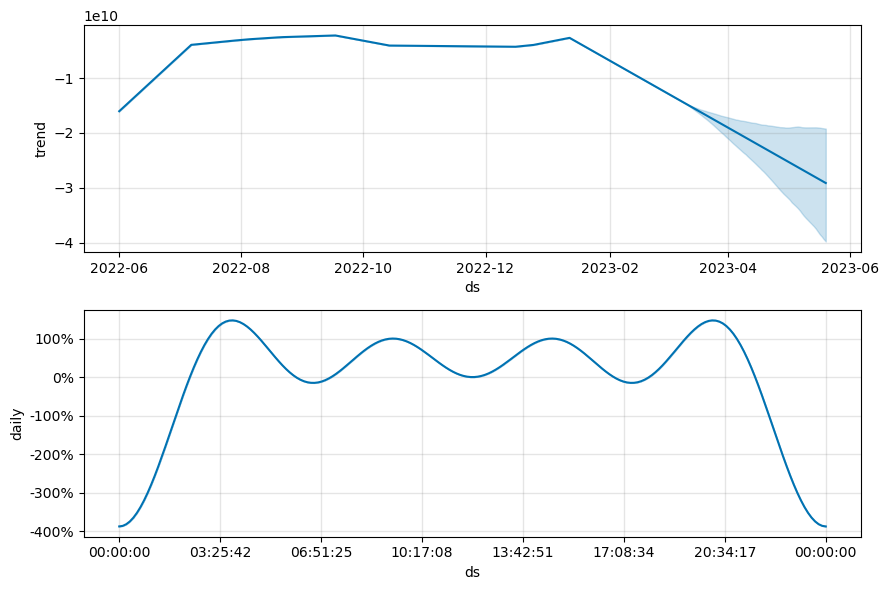

In [55]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

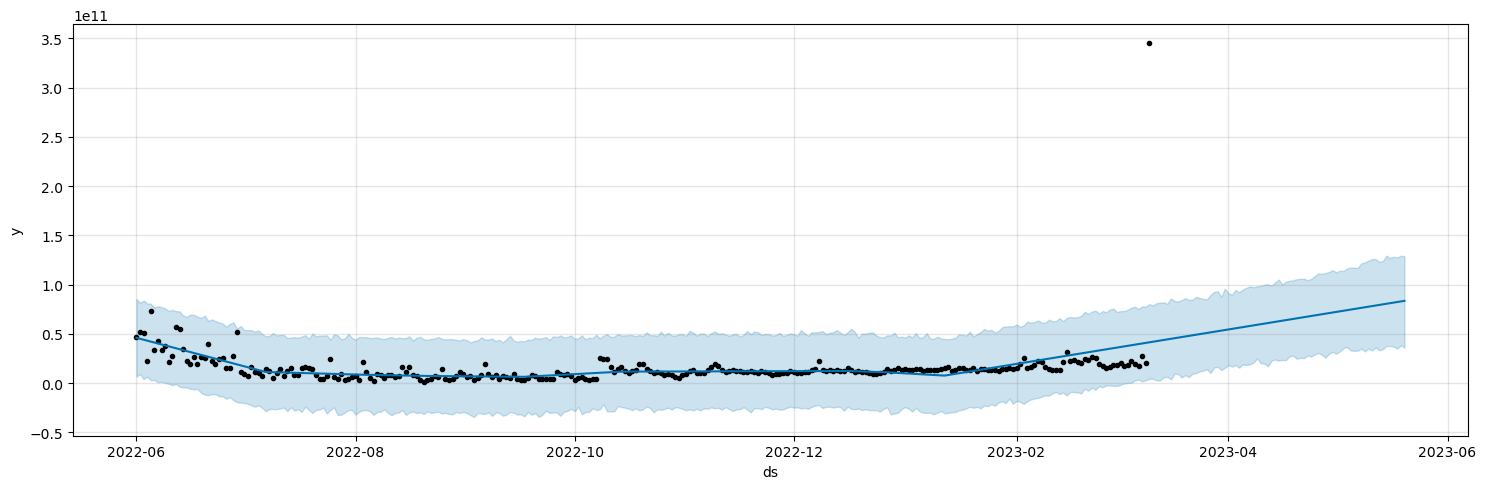

In [56]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [57]:
X_tst_final= final_model.predict(test)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds          yhat    yhat_lower    yhat_upper
64 2023-05-14  8.006489e+10  3.225629e+10  1.239603e+11
65 2023-05-15  8.065767e+10  3.502204e+10  1.268012e+11
66 2023-05-16  8.125044e+10  3.397391e+10  1.263109e+11
67 2023-05-17  8.184322e+10  3.570328e+10  1.237028e+11
68 2023-05-18  8.243599e+10  3.396069e+10  1.240570e+11
69 2023-05-19  8.302877e+10  4.096451e+10  1.289786e+11
70 2023-05-20  8.362154e+10  3.683759e+10  1.321147e+11

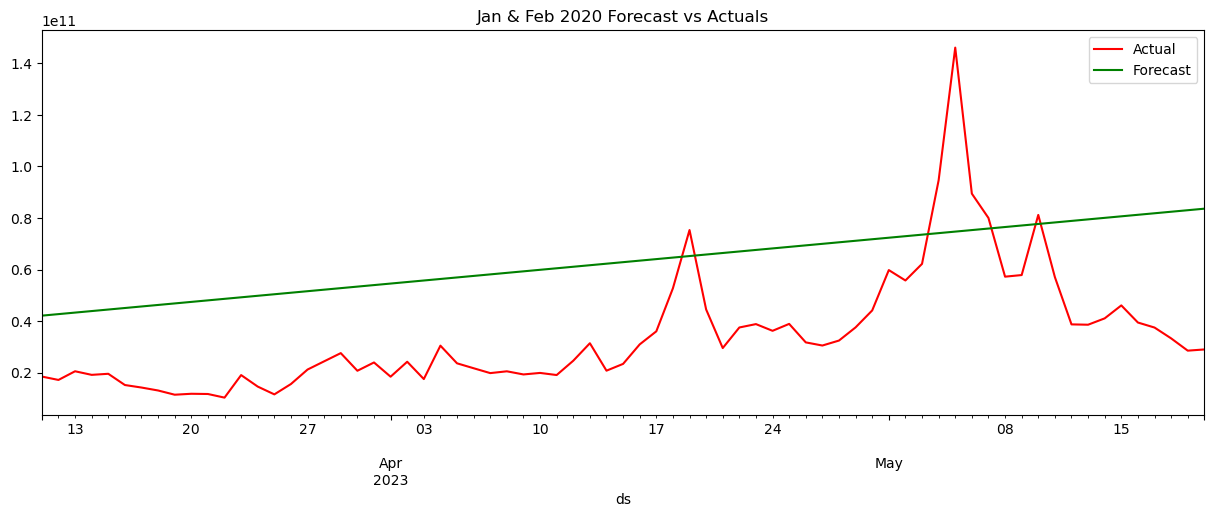

In [58]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

In [59]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [60]:
MAPE = mean_absolute_percentage_error(test['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

MAPE 132.00598825597453
